# **ROME** on **GPT2-XL** using EasyEdit Framework


Method: ROME

Paper:[Locating and Editing Factual Associations in GPT](https://arxiv.org/abs/2202.05262)
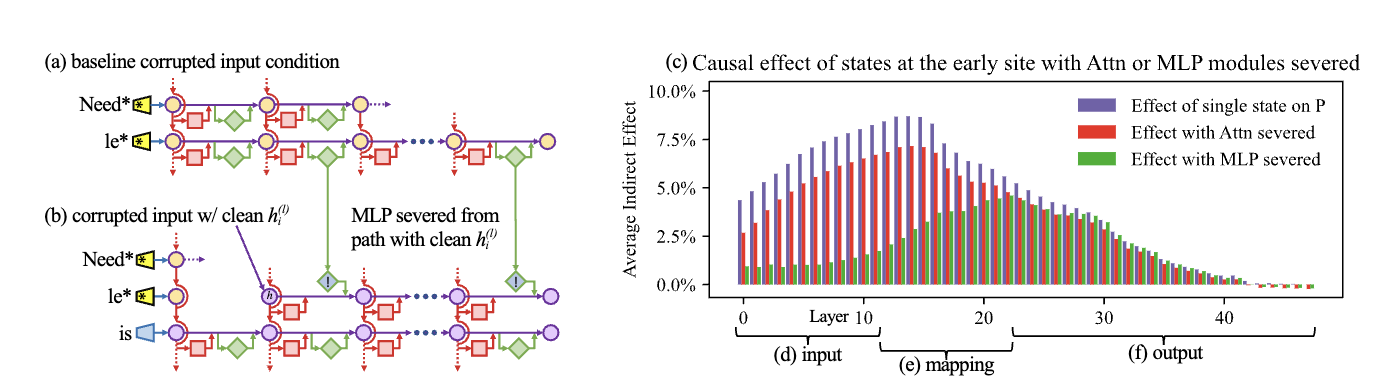

## Prepare the runtime environment

In [ ]:
# # !git clone https://github.com/zjunlp/EasyEdit
# %cd EasyEdit
# !ls

In [ ]:
# https://huggingface.co/gpt2/tree/main
# EasyEdit
# |———hugging-cache
#         |———— gpt2-xl
#             |———— config.json
#             |———— pytorch_model.bin
#             |———— vocab.json
#             |———— merges.txt
#             |———— tokenizer.json**

In [ ]:
# !apt-get install python3.9
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
# !sudo update-alternatives --config python3
# !apt-get install python3-pip
# %pip install -r requirements.txt

## Config Method Parameters



```python
# For ROME hparams:

alg_name: "ROME"
model_name: "./hugging_cache/gpt2-xl"
stats_dir: "./data/stats"
device: auto
layers: [5]
fact_token: "subject_last"
v_num_grad_steps: 20
v_lr: 5e-1
v_loss_layer: 20
v_weight_decay: 0.5
clamp_norm_factor: 4
kl_factor: 0.0625
mom2_adjustment: false
context_template_length_params: [[5, 10], [10, 10]]
rewrite_module_tmp: "transformer.h.{}.mlp.c_proj"
layer_module_tmp: "transformer.h.{}"
mlp_module_tmp: "transformer.h.{}.mlp"
attn_module_tmp: "transformer.h.{}.attn"
ln_f_module: "transformer.ln_f"
lm_head_module: "transformer.wte"
mom2_dataset: "wikipedia"
mom2_n_samples: 100000
mom2_dtype: "float32"
model_parallel: true
```

In [1]:
%cd ..

/home/ai23mtech14005/NLP_DL/EasyEdit


## Import modules & Run

### Edit GPT2-XL

In [2]:
from easyeditor import BaseEditor
from easyeditor import ROMEHyperParams
import os
import pandas as pd
import numpy as np
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
hparams = ROMEHyperParams.from_hparams('hparams/ROME/gpt2-xl.yaml')
data = pd.read_csv('data/benchmark_ZsRE_ZsRE-test-all.csv')

In [4]:
data.head()

subject  \
0                  Epaspidoceras   
1                           ZIC3   
2               Louise Grandjean   
3                    Wang Jipeng   
4  Charlotte of Schaumburg-Lippe   

                                             prompts  \
0         Which family does Epaspidoceras belong to?   
1                  What species is ZIC3 specific to?   
2               What voice type is Louise Grandjean?   
3               Who is listed as Wang Jipeng father?   
4  What was the name of Charlotte of Schaumburg-L...   

                   target_new                         ground_truth  \
0                   Noctuidae                      Aspidoceratidae   
1                        male                                human   
2               mezzo soprano                              soprano   
3               Wang Chonghua                          Wang Yanjun   
4  Charlotte of Bourbon-Parma  Princess Bathildis of Anhalt-Dessau   

                                    rephrase_prompts  \
0                     What family are Epaspidoceras?   
1           In which living being can you find ZIC3?   
2           What tone does Louise Grandjean sing in?   
3            What is the name of Wang Jipeng father?   
4  What was Charlotte the mother's name Schaumbur...   

                                    locality_prompts  
0                 The taxon rank of Epaspidoceras is  
1                  The strand orientation of ZIC3 is  
2  The country of citizenship of Louise Grandjean is  
3  The copyright status as a creator of Wang Jipe...  
4  The noble title of Charlotte of Schaumburg-Lip...

In [5]:
prompts = data['prompts'].tolist()
ground_truth = data['ground_truth'].tolist()
target_new = data['target_new'].tolist()
subject = data['subject'].tolist()
rephrase_prompts = data['rephrase_prompts'].tolist()
locality_prompts = data['locality_prompts'].tolist()

In [6]:
print(len(prompts), len(ground_truth), len(target_new), len(subject), len(rephrase_prompts), len(locality_prompts))

1301 1301 1301 1301 1301 1301


## BaseEditor training with ROME

In [7]:
editor = BaseEditor.from_hparams(hparams)
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    target_new=target_new,
    subject=subject,
    keep_original_weight=False,
    verbose=False
)
print(metrics)
print(type(edited_model))

2024-04-22 21:14:30,237 - easyeditor.editors.editor - INFO - Instantiating model
04/22/2024 21:14:30 - INFO - easyeditor.editors.editor -   Instantiating model
1301it [01:30, 14.40it/s]


Executing ROME algorithm for the update: [Which family does Epaspidoceras belong to?] -> [ Noctuidae]
Cached context templates ['{}', 'The first thing I did. {}', 'The most common form of. {}', 'Therefore, if we are. {}', 'Therefore, I would suggest. {}', 'Because it is not a. {}', "Because I'm the only. {}", 'I am very proud to. {}', "I'm going to be. {}", "You'll be able to. {}", 'You can find the latest. {}', 'The most recent data from the U.S.. {}', 'The same day, I received a message from the. {}', 'Therefore I have come to the conclusion that the time. {}', 'Therefore, the question arises whether the government should be. {}', "Because it's the first day and you've just. {}", 'Because of this, I have decided to make this. {}', 'I think the most important thing that I can say. {}', 'I have to admit to being surprised that the ". {}', 'You\'re going to be fine." ". {}', "You'll see a lot more of that in the. {}"]
Computing left vector (u)...
Selected u projection object Epaspidocer

2024-04-22 21:16:26,362 - easyeditor.editors.editor - INFO - Execution 0 editing took 8.463608026504517
04/22/2024 21:16:26 - INFO - easyeditor.editors.editor -   Execution 0 editing took 8.463608026504517
2024-04-22 21:16:26,434 - easyeditor.editors.editor - INFO - Evaluation took 0.06987690925598145
04/22/2024 21:16:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.06987690925598145


loss 0.124 = 0.006 + 0.021 + 0.098 avg prob of [ Noctuidae] 0.9939649701118469
Delta norm: 81.89875030517578
Change in target norm: 20.474687576293945 to 84.8180923461914 => 64.3434066772461
Division Factor: 14.05485725402832
Right vector norm: 5.827078342437744
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What species is ZIC3 specific to?] -> [ male]
Computing left vector (u)...
Selected u projection object ZIC3
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What species is ZIC3 specific to? | Token: 3
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.115 = 12.115 + 0.0 + 0.0 avg prob of [ male] 6.7443411353451665e-06
loss 11.494 = 11.475 + 0.001 + 0.019 avg prob of [ male] 1.276479997613933e-05
loss 9.966 = 

2024-04-22 21:16:32,848 - easyeditor.editors.editor - INFO - Execution 1 editing took 6.411638021469116
04/22/2024 21:16:32 - INFO - easyeditor.editors.editor -   Execution 1 editing took 6.411638021469116
2024-04-22 21:16:32,919 - easyeditor.editors.editor - INFO - Evaluation took 0.06918501853942871
04/22/2024 21:16:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.06918501853942871


loss 0.109 = 0.007 + 0.016 + 0.086 avg prob of [ male] 0.9932763576507568
Delta norm: 92.5854721069336
Change in target norm: 23.14636993408203 to 96.00790405273438 => 72.86153411865234
Division Factor: 14.281932830810547
Right vector norm: 6.482699394226074
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What voice type is Louise Grandjean?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Louise Grandjean
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What voice type is Louise Grandjean? mezzo sop | Token: ean
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.951 = 4.951 + 0.0 + 0.0 avg prob of [ mezzo soprano] 0.007270426955074072
loss 4.454 = 4.433 + 0.008 + 0.012 avg prob of [ mez

2024-04-22 21:16:40,372 - easyeditor.editors.editor - INFO - Execution 2 editing took 7.4508655071258545
04/22/2024 21:16:40 - INFO - easyeditor.editors.editor -   Execution 2 editing took 7.4508655071258545
2024-04-22 21:16:40,444 - easyeditor.editors.editor - INFO - Evaluation took 0.06945323944091797
04/22/2024 21:16:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.06945323944091797


loss 0.113 = 0.008 + 0.035 + 0.071 avg prob of [ mezzo soprano] 0.9920797944068909
Delta norm: 113.25251770019531
Change in target norm: 28.313129425048828 to 117.81114959716797 => 89.49801635742188
Division Factor: 17.03858757019043
Right vector norm: 6.646825790405273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Wang Jipeng father?] -> [ Wang Chonghua]
Computing left vector (u)...
Selected u projection object Wang Jipeng
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is listed as Wang Jipeng father? Wang Chongh | Token: eng
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.179 = 4.179 + 0.0 + 0.0 avg prob of [ Wang Chonghua] 0.015556879341602325
loss 3.655 = 3.618 + 0.028 + 0.008 avg prob

2024-04-22 21:16:47,889 - easyeditor.editors.editor - INFO - Execution 3 editing took 7.443238973617554
04/22/2024 21:16:47 - INFO - easyeditor.editors.editor -   Execution 3 editing took 7.443238973617554
2024-04-22 21:16:47,962 - easyeditor.editors.editor - INFO - Evaluation took 0.07076573371887207
04/22/2024 21:16:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07076573371887207


loss 0.086 = 0.013 + 0.015 + 0.058 avg prob of [ Wang Chonghua] 0.9873152375221252
Delta norm: 137.21322631835938
Change in target norm: 34.303306579589844 to 144.1526641845703 => 109.84935760498047
Division Factor: 14.350724220275879
Right vector norm: 9.56141471862793
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Charlotte of Schaumburg-Lippe mother?] -> [ Charlotte of Bourbon-Parma]
Computing left vector (u)...
Selected u projection object Charlotte of Schaumburg-Lippe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What was the name of Charlotte of Schaumburg-Lippe mother? Charlotte of Bourbon-P | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 3.053 = 3.053 + 0.0 + 0.0 avg prob

2024-04-22 21:16:56,669 - easyeditor.editors.editor - INFO - Execution 4 editing took 8.70471978187561
04/22/2024 21:16:56 - INFO - easyeditor.editors.editor -   Execution 4 editing took 8.70471978187561
2024-04-22 21:16:56,741 - easyeditor.editors.editor - INFO - Evaluation took 0.07015585899353027
04/22/2024 21:16:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.07015585899353027


loss 0.083 = 0.006 + 0.026 + 0.051 avg prob of [ Charlotte of Bourbon-Parma] 0.9936855435371399
Delta norm: 115.70741271972656
Change in target norm: 33.689632415771484 to 123.9253921508789 => 90.23576354980469
Division Factor: 14.531681060791016
Right vector norm: 7.962424278259277
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is home to Butterfly Cluster?] -> [ Orion]
Computing left vector (u)...
Selected u projection object Butterfly Cluster
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation is home to Butterfly Cluster? | Token:  Cluster
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.893 = 6.893 + 0.0 + 0.0 avg prob of [ Orion] 0.0013277636608108878
loss 4.021 = 3.996 + 0

2024-04-22 21:17:03,216 - easyeditor.editors.editor - INFO - Execution 5 editing took 6.472849130630493
04/22/2024 21:17:03 - INFO - easyeditor.editors.editor -   Execution 5 editing took 6.472849130630493
2024-04-22 21:17:03,287 - easyeditor.editors.editor - INFO - Evaluation took 0.06944632530212402
04/22/2024 21:17:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.06944632530212402


loss 0.098 = 0.001 + 0.032 + 0.065 avg prob of [ Orion] 0.9990743398666382
Delta norm: 122.32091522216797
Change in target norm: 30.58022689819336 to 129.0127716064453 => 98.43254089355469
Division Factor: 12.591029167175293
Right vector norm: 9.714925765991211
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Juan María Bordaberry is whom?] -> [ Gabrielle Bordaberry]
Computing left vector (u)...
Selected u projection object Juan María Bordaberry
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The father of Juan María Bordaberry is whom? Gabrielle Bordab | Token: erry
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 2.418 = 2.418 + 0.0 + 0.0 avg prob of [ Gabrielle Bordaberry] 0.09325284510850906
loss 1.

2024-04-22 21:17:11,086 - easyeditor.editors.editor - INFO - Execution 6 editing took 7.796311140060425
04/22/2024 21:17:11 - INFO - easyeditor.editors.editor -   Execution 6 editing took 7.796311140060425
2024-04-22 21:17:11,159 - easyeditor.editors.editor - INFO - Evaluation took 0.0716085433959961
04/22/2024 21:17:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.0716085433959961


loss 0.082 = 0.012 + 0.039 + 0.031 avg prob of [ Gabrielle Bordaberry] 0.9879128932952881
Delta norm: 123.81391906738281
Change in target norm: 44.9295539855957 to 133.78933715820312 => 88.85978698730469
Division Factor: 13.064054489135742
Right vector norm: 9.477449417114258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What level is Javan surili's iucn conservation status?] -> [ critically threatened]
Computing left vector (u)...
Selected u projection object Javan surili
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What level is Javan surili's iucn conservation status? critically | Token: ili
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.081 = 8.081 + 0.0 + 0.0 avg prob of [ critically threatened] 0.0003

2024-04-22 21:17:18,743 - easyeditor.editors.editor - INFO - Execution 7 editing took 7.581594467163086
04/22/2024 21:17:18 - INFO - easyeditor.editors.editor -   Execution 7 editing took 7.581594467163086
2024-04-22 21:17:18,815 - easyeditor.editors.editor - INFO - Evaluation took 0.06949877738952637
04/22/2024 21:17:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.06949877738952637


loss 0.085 = 0.009 + 0.048 + 0.028 avg prob of [ critically threatened] 0.9907822608947754
Delta norm: 121.46635437011719
Change in target norm: 46.38938903808594 to 135.29299926757812 => 88.90361022949219
Division Factor: 12.734367370605469
Right vector norm: 9.538467407226562
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was USA-199 launched?] -> [ 20 December 2007]
Computing left vector (u)...
Selected u projection object USA-199
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What day was USA-199 launched? 20 December | Token: 199
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.567 = 5.567 + 0.0 + 0.0 avg prob of [ 20 December 2007] 0.003936651162803173
loss 3.758 = 3.754 + 0.002 + 0.002 avg prob o

2024-04-22 21:17:23,958 - easyeditor.editors.editor - INFO - Execution 8 editing took 5.141034364700317
04/22/2024 21:17:23 - INFO - easyeditor.editors.editor -   Execution 8 editing took 5.141034364700317
2024-04-22 21:17:24,029 - easyeditor.editors.editor - INFO - Evaluation took 0.06903409957885742
04/22/2024 21:17:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.06903409957885742


loss 0.049 = 0.013 + 0.023 + 0.014 avg prob of [ 20 December 2007] 0.9871978759765625
Delta norm: 112.26268005371094
Change in target norm: 63.5997428894043 to 133.564208984375 => 69.96446228027344
Division Factor: 15.700700759887695
Right vector norm: 7.150169849395752
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the record label of Runaway Sunday?] -> [ Motown]
Computing left vector (u)...
Selected u projection object Runaway Sunday
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What was the record label of Runaway Sunday? Mot | Token:  Sunday
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.092 = 4.092 + 0.0 + 0.0 avg prob of [ Motown] 0.017809413373470306
loss 3.204 = 3.198 + 0.003 + 0.003 avg pro

2024-04-22 21:17:28,222 - easyeditor.editors.editor - INFO - Execution 9 editing took 4.1911468505859375
04/22/2024 21:17:28 - INFO - easyeditor.editors.editor -   Execution 9 editing took 4.1911468505859375
2024-04-22 21:17:28,293 - easyeditor.editors.editor - INFO - Evaluation took 0.06852960586547852
04/22/2024 21:17:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.06852960586547852


loss 0.046 = 0.002 + 0.031 + 0.014 avg prob of [ Motown] 0.9984021782875061
Delta norm: 85.99364471435547
Change in target norm: 56.12165451049805 to 107.62476348876953 => 51.503108978271484
Division Factor: 16.0809383392334
Right vector norm: 5.347551345825195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which league did Southern California Fusion join with?] -> [ USL First Division]
Computing left vector (u)...
Selected u projection object Southern California Fusion
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which league did Southern California Fusion join with? USL First | Token:  Fusion
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.576 = 4.576 + 0.0 + 0.0 avg prob of [ USL First Division] 0.01182413

2024-04-22 21:17:31,136 - easyeditor.editors.editor - INFO - Execution 10 editing took 2.840290069580078
04/22/2024 21:17:31 - INFO - easyeditor.editors.editor -   Execution 10 editing took 2.840290069580078
2024-04-22 21:17:31,208 - easyeditor.editors.editor - INFO - Evaluation took 0.06996607780456543
04/22/2024 21:17:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.06996607780456543


loss 0.044 = 0.009 + 0.022 + 0.013 avg prob of [ USL First Division] 0.9906526207923889
Delta norm: 79.46148681640625
Change in target norm: 55.15373611450195 to 95.46514129638672 => 40.311405181884766
Division Factor: 14.679515838623047
Right vector norm: 5.413086414337158
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can MT-TC be found?] -> [ human]
Computing left vector (u)...
Selected u projection object MT-TC
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what living being can MT-TC be found? | Token: TC
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.03 = 11.03 + 0.0 + 0.0 avg prob of [ human] 2.6033740141429007e-05
loss 9.556 = 9.549 + 0.005 + 0.002 avg prob of [ human] 9.888380

2024-04-22 21:17:38,138 - easyeditor.editors.editor - INFO - Execution 11 editing took 6.92858362197876
04/22/2024 21:17:38 - INFO - easyeditor.editors.editor -   Execution 11 editing took 6.92858362197876
2024-04-22 21:17:38,210 - easyeditor.editors.editor - INFO - Evaluation took 0.06910991668701172
04/22/2024 21:17:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.06910991668701172


loss 0.073 = 0.003 + 0.057 + 0.013 avg prob of [ human] 0.997272253036499
Delta norm: 113.85040283203125
Change in target norm: 65.19132995605469 to 140.5679168701172 => 75.3765869140625
Division Factor: 13.657034873962402
Right vector norm: 8.336392402648926
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Due to which disease did Joseph Papp die?] -> [ pneumonia]
Computing left vector (u)...
Selected u projection object Joseph Papp
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Due to which disease did Joseph Papp die? | Token: app
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.111 = 8.111 + 0.0 + 0.0 avg prob of [ pneumonia] 0.00045184072223491967
loss 6.866 = 6.858 + 0.003 + 0.005 avg prob of [ pneumonia] 0.

2024-04-22 21:17:45,123 - easyeditor.editors.editor - INFO - Execution 12 editing took 6.911276340484619
04/22/2024 21:17:45 - INFO - easyeditor.editors.editor -   Execution 12 editing took 6.911276340484619
2024-04-22 21:17:45,195 - easyeditor.editors.editor - INFO - Evaluation took 0.07044649124145508
04/22/2024 21:17:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.07044649124145508


loss 0.156 = 0.001 + 0.126 + 0.029 avg prob of [ pneumonia] 0.9987866878509521
Delta norm: 122.13174438476562
Change in target norm: 46.17642593383789 to 139.0286102294922 => 92.85218811035156
Division Factor: 13.701577186584473
Right vector norm: 8.91369915008545
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The designer for Holmenkollen Chapel was?] -> [ Norwegian Institute of Technology]
Computing left vector (u)...
Selected u projection object Holmenkollen Chapel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The designer for Holmenkollen Chapel was? Norwegian Institute of | Token:  Chapel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.013 = 8.013 + 0.0 + 0.0 avg prob of [ Norwegian Institute of Technolog

2024-04-22 21:17:52,836 - easyeditor.editors.editor - INFO - Execution 13 editing took 7.638744354248047
04/22/2024 21:17:52 - INFO - easyeditor.editors.editor -   Execution 13 editing took 7.638744354248047
2024-04-22 21:17:52,908 - easyeditor.editors.editor - INFO - Evaluation took 0.06963396072387695
04/22/2024 21:17:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.06963396072387695


loss 0.066 = 0.008 + 0.043 + 0.015 avg prob of [ Norwegian Institute of Technology] 0.9919129610061646
Delta norm: 128.52362060546875
Change in target norm: 66.57180786132812 to 148.9915008544922 => 82.41969299316406
Division Factor: 12.3356294631958
Right vector norm: 10.41889476776123
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Marc Moulin's mother?] -> [ Catherine Moulin]
Computing left vector (u)...
Selected u projection object Marc Moulin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who was Marc Moulin's mother? Catherine Mou | Token: lin
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 2.995 = 2.995 + 0.0 + 0.0 avg prob of [ Catherine Moulin] 0.052617091685533524
loss 1.59 = 1.538 + 0.049 + 0.00

2024-04-22 21:17:59,792 - easyeditor.editors.editor - INFO - Execution 14 editing took 6.882164716720581
04/22/2024 21:17:59 - INFO - easyeditor.editors.editor -   Execution 14 editing took 6.882164716720581
2024-04-22 21:17:59,864 - easyeditor.editors.editor - INFO - Evaluation took 0.07018041610717773
04/22/2024 21:17:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07018041610717773


loss 0.059 = 0.001 + 0.044 + 0.014 avg prob of [ Catherine Moulin] 0.9985973834991455
Delta norm: 115.32575225830078
Change in target norm: 65.12663269042969 to 137.7633056640625 => 72.63667297363281
Division Factor: 14.270353317260742
Right vector norm: 8.08149242401123
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What team is Nicolas Raffault associated with?] -> [ Arizona Coyotes]
Computing left vector (u)...
Selected u projection object Nicolas Raffault
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What team is Nicolas Raffault associated with? Arizona | Token: ault
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.229 = 9.229 + 0.0 + 0.0 avg prob of [ Arizona Coyotes] 0.00013346529158297926
loss 3.395 = 3

2024-04-22 21:18:06,809 - easyeditor.editors.editor - INFO - Execution 15 editing took 6.9423394203186035
04/22/2024 21:18:06 - INFO - easyeditor.editors.editor -   Execution 15 editing took 6.9423394203186035
2024-04-22 21:18:06,880 - easyeditor.editors.editor - INFO - Evaluation took 0.06884074211120605
04/22/2024 21:18:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.06884074211120605


loss 0.087 = 0.004 + 0.077 + 0.005 avg prob of [ Arizona Coyotes] 0.9957060217857361
Delta norm: 117.77751922607422
Change in target norm: 103.71182250976562 to 158.26864624023438 => 54.55682373046875
Division Factor: 15.254288673400879
Right vector norm: 7.720944881439209
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What river does Charity Creek connect to?] -> [  Charity River]
Computing left vector (u)...
Selected u projection object Charity Creek
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What river does Charity Creek connect to?  Charity | Token:  Creek
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.175 = 11.175 + 0.0 + 0.0 avg prob of [  Charity River] 1.5223497939587105e-05
loss 6.566 = 6.504 + 0

2024-04-22 21:18:13,154 - easyeditor.editors.editor - INFO - Execution 16 editing took 6.2720301151275635
04/22/2024 21:18:13 - INFO - easyeditor.editors.editor -   Execution 16 editing took 6.2720301151275635
2024-04-22 21:18:13,226 - easyeditor.editors.editor - INFO - Evaluation took 0.07055401802062988
04/22/2024 21:18:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.07055401802062988


loss 0.05 = 0.014 + 0.031 + 0.005 avg prob of [  Charity River] 0.9861432909965515
Delta norm: 107.02516174316406
Change in target norm: 106.08329010009766 to 150.62933349609375 => 44.546043395996094
Division Factor: 14.264431953430176
Right vector norm: 7.502938747406006
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Nils Palme father?] -> [ Lau Lauritzen]
Computing left vector (u)...
Selected u projection object Nils Palme
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the name of Nils Palme father? Lau Lauritz | Token: me
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.833 = 9.833 + 0.0 + 0.0 avg prob of [ Lau Lauritzen] 6.471892993431538e-05
loss 7.899 = 7.828 + 0.068 + 0.003 avg

2024-04-22 21:18:20,914 - easyeditor.editors.editor - INFO - Execution 17 editing took 7.685683727264404
04/22/2024 21:18:20 - INFO - easyeditor.editors.editor -   Execution 17 editing took 7.685683727264404
2024-04-22 21:18:20,988 - easyeditor.editors.editor - INFO - Evaluation took 0.0724642276763916
04/22/2024 21:18:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.0724642276763916


loss 0.121 = 0.012 + 0.086 + 0.022 avg prob of [ Lau Lauritzen] 0.9879368543624878
Delta norm: 153.3694305419922
Change in target norm: 58.584903717041016 to 168.11813354492188 => 109.53323364257812
Division Factor: 17.343013763427734
Right vector norm: 8.843297958374023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is an ecological status of Bali myna?] -> [  myna]
Computing left vector (u)...
Selected u projection object Bali myna
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is an ecological status of Bali myna?  my | Token: na
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.936 = 7.936 + 0.0 + 0.0 avg prob of [  myna] 0.0006762187695130706
loss 3.655 = 3.638 + 0.016 + 0.002 avg prob of [  myna] 

2024-04-22 21:18:28,585 - easyeditor.editors.editor - INFO - Execution 18 editing took 7.5948874950408936
04/22/2024 21:18:28 - INFO - easyeditor.editors.editor -   Execution 18 editing took 7.5948874950408936
2024-04-22 21:18:28,658 - easyeditor.editors.editor - INFO - Evaluation took 0.07026791572570801
04/22/2024 21:18:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.07026791572570801


loss 0.06 = 0.011 + 0.041 + 0.009 avg prob of [  myna] 0.9893727898597717
Delta norm: 108.72610473632812
Change in target norm: 78.74891662597656 to 137.6846160888672 => 58.935699462890625
Division Factor: 16.612646102905273
Right vector norm: 6.5447797775268555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Coevorden named after?] -> [ Alexander Coevorden]
Computing left vector (u)...
Selected u projection object Coevorden
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Coevorden named after? Alexander Coevord | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.377 = 6.377 + 0.0 + 0.0 avg prob of [ Alexander Coevorden] 0.0022526977118104696
loss 3.241 = 3.173 + 0.067 + 0.001 avg prob of 

2024-04-22 21:18:32,876 - easyeditor.editors.editor - INFO - Execution 19 editing took 4.216453552246094
04/22/2024 21:18:32 - INFO - easyeditor.editors.editor -   Execution 19 editing took 4.216453552246094
2024-04-22 21:18:32,948 - easyeditor.editors.editor - INFO - Evaluation took 0.06923961639404297
04/22/2024 21:18:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.06923961639404297


loss 0.046 = 0.017 + 0.023 + 0.006 avg prob of [ Alexander Coevorden] 0.9832369685173035
Delta norm: 95.28874969482422
Change in target norm: 89.66165924072266 to 128.82388305664062 => 39.16222381591797
Division Factor: 14.95860481262207
Right vector norm: 6.370163440704346
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which country's citizenship does Pedro Magallanes hold?] -> [ Colombia]
Computing left vector (u)...
Selected u projection object Pedro Magallanes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which country's citizenship does Pedro Magallanes hold? | Token: anes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 3.155 = 3.155 + 0.0 + 0.0 avg prob of [ Colombia] 0.047090817242860794
loss 0.105 = 0.09

2024-04-22 21:18:34,106 - easyeditor.editors.editor - INFO - Execution 20 editing took 1.1561756134033203
04/22/2024 21:18:34 - INFO - easyeditor.editors.editor -   Execution 20 editing took 1.1561756134033203
2024-04-22 21:18:34,178 - easyeditor.editors.editor - INFO - Evaluation took 0.07044601440429688
04/22/2024 21:18:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07044601440429688


loss 0.034 = 0.019 + 0.013 + 0.001 avg prob of [ Colombia] 0.9813537001609802
Delta norm: 33.32735061645508
Change in target norm: 108.66303253173828 to 114.49542236328125 => 5.832389831542969
Division Factor: 15.166772842407227
Right vector norm: 2.197392463684082
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who designed the Heroes Chronicles?] -> [ Chris Riddell]
Computing left vector (u)...
Selected u projection object Heroes Chronicles
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who designed the Heroes Chronicles? Chris Ridd | Token:  Chronicles
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.698 = 5.698 + 0.0 + 0.0 avg prob of [ Chris Riddell] 0.004887169227004051
loss 3.89 = 3.887 + 0.001 + 0.002 avg

2024-04-22 21:18:37,143 - easyeditor.editors.editor - INFO - Execution 21 editing took 2.962186336517334
04/22/2024 21:18:37 - INFO - easyeditor.editors.editor -   Execution 21 editing took 2.962186336517334
2024-04-22 21:18:37,216 - easyeditor.editors.editor - INFO - Evaluation took 0.07117366790771484
04/22/2024 21:18:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.07117366790771484


loss 0.042 = 0.025 + 0.01 + 0.007 avg prob of [ Chris Riddell] 0.9753446578979492
Delta norm: 84.25271606445312
Change in target norm: 75.11154174804688 to 116.85916137695312 => 41.74761962890625
Division Factor: 16.045217514038086
Right vector norm: 5.250954627990723
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Archduchess Mechthildis of Austria's father?] -> [ Infanta Maria Theresa of Portugal]
Computing left vector (u)...
Selected u projection object Archduchess Mechthildis of Austria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who is Archduchess Mechthildis of Austria's father? Infanta Maria Theresa of | Token:  Austria
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.507 = 4.507 + 0.0 + 0.0 avg

2024-04-22 21:18:44,622 - easyeditor.editors.editor - INFO - Execution 22 editing took 7.403874158859253
04/22/2024 21:18:44 - INFO - easyeditor.editors.editor -   Execution 22 editing took 7.403874158859253
2024-04-22 21:18:44,694 - easyeditor.editors.editor - INFO - Evaluation took 0.06959295272827148
04/22/2024 21:18:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.06959295272827148


loss 0.049 = 0.019 + 0.014 + 0.016 avg prob of [ Infanta Maria Theresa of Portugal] 0.9813759326934814
Delta norm: 151.2151641845703
Change in target norm: 69.0540771484375 to 168.2438507080078 => 99.18977355957031
Division Factor: 11.94894790649414
Right vector norm: 12.65510368347168
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The country for Ang TV was what?] -> [ Sri Lanka]
Computing left vector (u)...
Selected u projection object Ang TV
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The country for Ang TV was what? Sri | Token:  TV
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.604 = 7.604 + 0.0 + 0.0 avg prob of [ Sri Lanka] 0.0005972332437522709
loss 4.503 = 4.416 + 0.087 + 0.001 avg prob of [ Sri La

2024-04-22 21:18:51,121 - easyeditor.editors.editor - INFO - Execution 23 editing took 6.425813913345337
04/22/2024 21:18:51 - INFO - easyeditor.editors.editor -   Execution 23 editing took 6.425813913345337
2024-04-22 21:18:51,194 - easyeditor.editors.editor - INFO - Evaluation took 0.07013845443725586
04/22/2024 21:18:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.07013845443725586


loss 0.082 = 0.002 + 0.072 + 0.007 avg prob of [ Sri Lanka] 0.9978283047676086
Delta norm: 124.21869659423828
Change in target norm: 91.53797149658203 to 163.31809997558594 => 71.7801284790039
Division Factor: 13.659868240356445
Right vector norm: 9.093696594238281
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who made Alexanderson alternator known?] -> [ Ernest Alexanderson]
Computing left vector (u)...
Selected u projection object Alexanderson alternator
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who made Alexanderson alternator known? Ernest Alexand | Token: ator
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.841 = 7.841 + 0.0 + 0.0 avg prob of [ Ernest Alexanderson] 0.0004399439203552902
loss 5.908 = 

2024-04-22 21:18:58,037 - easyeditor.editors.editor - INFO - Execution 24 editing took 6.841752052307129
04/22/2024 21:18:58 - INFO - easyeditor.editors.editor -   Execution 24 editing took 6.841752052307129
2024-04-22 21:18:58,109 - easyeditor.editors.editor - INFO - Evaluation took 0.06934189796447754
04/22/2024 21:18:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.06934189796447754


loss 0.057 = 0.005 + 0.044 + 0.007 avg prob of [ Ernest Alexanderson] 0.9945558309555054
Delta norm: 140.8434600830078
Change in target norm: 97.18728637695312 to 179.61544799804688 => 82.42816162109375
Division Factor: 11.716241836547852
Right vector norm: 12.021215438842773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Mallory Reaves is whom?] -> [ Lalli Reaves]
Computing left vector (u)...
Selected u projection object Mallory Reaves
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The mother of Mallory Reaves is whom? Lalli Re | Token: aves
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.264 = 7.264 + 0.0 + 0.0 avg prob of [ Lalli Reaves] 0.0007326760096475482
loss 4.834 = 4.817 + 0.016 + 0.001 

2024-04-22 21:19:04,562 - easyeditor.editors.editor - INFO - Execution 25 editing took 6.451526165008545
04/22/2024 21:19:04 - INFO - easyeditor.editors.editor -   Execution 25 editing took 6.451526165008545
2024-04-22 21:19:04,634 - easyeditor.editors.editor - INFO - Evaluation took 0.06943488121032715
04/22/2024 21:19:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.06943488121032715


loss 0.044 = 0.012 + 0.028 + 0.004 avg prob of [ Lalli Reaves] 0.9882901906967163
Delta norm: 129.81439208984375
Change in target norm: 122.31745147705078 to 177.1228790283203 => 54.80542755126953
Division Factor: 13.929516792297363
Right vector norm: 9.319375038146973
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What disease did Harlo Jones have?] -> [ pneumonia]
Computing left vector (u)...
Selected u projection object Harlo Jones
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What disease did Harlo Jones have? | Token:  Jones
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.176 = 15.176 + 0.0 + 0.0 avg prob of [ pneumonia] 5.087528052172274e-07
loss 10.007 = 9.986 + 0.02 + 0.001 avg prob of [ pneumonia] 7.

2024-04-22 21:19:06,683 - easyeditor.editors.editor - INFO - Execution 26 editing took 2.0473883152008057
04/22/2024 21:19:06 - INFO - easyeditor.editors.editor -   Execution 26 editing took 2.0473883152008057
2024-04-22 21:19:06,754 - easyeditor.editors.editor - INFO - Evaluation took 0.06955289840698242
04/22/2024 21:19:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.06955289840698242


loss 0.05 = 0.028 + 0.019 + 0.004 avg prob of [ pneumonia] 0.972865104675293
Delta norm: 66.2721176147461
Change in target norm: 93.81037902832031 to 119.2961654663086 => 25.48578643798828
Division Factor: 14.284789085388184
Right vector norm: 4.63934850692749
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Battle of the Java Sea occur?] -> [ 27 February 1942]
Computing left vector (u)...
Selected u projection object Battle of the Java Sea
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: When did Battle of the Java Sea occur? 27 February | Token:  Sea
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.026 = 6.026 + 0.0 + 0.0 avg prob of [ 27 February 1942] 0.0031863099429756403
loss 4.069 = 4.062 + 0.006 + 0

2024-04-22 21:19:13,031 - easyeditor.editors.editor - INFO - Execution 27 editing took 6.275332927703857
04/22/2024 21:19:13 - INFO - easyeditor.editors.editor -   Execution 27 editing took 6.275332927703857
2024-04-22 21:19:13,103 - easyeditor.editors.editor - INFO - Evaluation took 0.0693812370300293
04/22/2024 21:19:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.0693812370300293


loss 0.047 = 0.025 + 0.016 + 0.006 avg prob of [ 27 February 1942] 0.9749318361282349
Delta norm: 138.75650024414062
Change in target norm: 109.88298797607422 to 176.34373474121094 => 66.46074676513672
Division Factor: 13.374438285827637
Right vector norm: 10.374753952026367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who developed Thomas the Tank Engine?] -> [ William Orpen]
Computing left vector (u)...
Selected u projection object Thomas the Tank Engine
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who developed Thomas the Tank Engine? William Or | Token:  Engine
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.118 = 8.118 + 0.0 + 0.0 avg prob of [ William Orpen] 0.00031238680821843445
loss 6.454 = 6.444 +

2024-04-22 21:19:18,688 - easyeditor.editors.editor - INFO - Execution 28 editing took 5.583279609680176
04/22/2024 21:19:18 - INFO - easyeditor.editors.editor -   Execution 28 editing took 5.583279609680176
2024-04-22 21:19:18,759 - easyeditor.editors.editor - INFO - Evaluation took 0.06907033920288086
04/22/2024 21:19:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.06907033920288086


loss 0.048 = 0.01 + 0.029 + 0.008 avg prob of [ William Orpen] 0.9898298382759094
Delta norm: 144.81871032714844
Change in target norm: 92.49917602539062 to 179.74769592285156 => 87.24851989746094
Division Factor: 19.375429153442383
Right vector norm: 7.474349021911621
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war or battle involved Alec Rose?] -> [ Spanish Civil War]
Computing left vector (u)...
Selected u projection object Alec Rose
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What war or battle involved Alec Rose? Spanish Civil | Token:  Rose
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.284 = 7.284 + 0.0 + 0.0 avg prob of [ Spanish Civil War] 0.0007641755510121584
loss 3.701 = 3.695 + 0.005 + 

2024-04-22 21:19:21,957 - easyeditor.editors.editor - INFO - Execution 29 editing took 3.196045160293579
04/22/2024 21:19:21 - INFO - easyeditor.editors.editor -   Execution 29 editing took 3.196045160293579
2024-04-22 21:19:22,028 - easyeditor.editors.editor - INFO - Evaluation took 0.06949949264526367
04/22/2024 21:19:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.06949949264526367


loss 0.045 = 0.03 + 0.012 + 0.004 avg prob of [ Spanish Civil War] 0.9726011157035828
Delta norm: 84.9632797241211
Change in target norm: 107.35101318359375 to 137.30368041992188 => 29.952667236328125
Division Factor: 14.919610977172852
Right vector norm: 5.694737911224365
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What network first aired The Smothers Brothers Comedy Hour?] -> [ NBC]
Computing left vector (u)...
Selected u projection object The Smothers Brothers Comedy Hour
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What network first aired The Smothers Brothers Comedy Hour? | Token:  Hour
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.369 = 6.369 + 0.0 + 0.0 avg prob of [ NBC] 0.005663744639605284
l

2024-04-22 21:19:23,894 - easyeditor.editors.editor - INFO - Execution 30 editing took 1.8638718128204346
04/22/2024 21:19:23 - INFO - easyeditor.editors.editor -   Execution 30 editing took 1.8638718128204346
2024-04-22 21:19:23,967 - easyeditor.editors.editor - INFO - Evaluation took 0.07046055793762207
04/22/2024 21:19:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07046055793762207


loss 0.047 = 0.005 + 0.039 + 0.003 avg prob of [ NBC] 0.9946300983428955
Delta norm: 55.60063552856445
Change in target norm: 105.11002349853516 to 121.92475128173828 => 16.814727783203125
Division Factor: 14.293472290039062
Right vector norm: 3.8899319171905518
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Anthony Delon is whom?] -> [ Alma Delon]
Computing left vector (u)...
Selected u projection object Anthony Delon
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The mother of Anthony Delon is whom? Alma Del | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.965 = 4.965 + 0.0 + 0.0 avg prob of [ Alma Delon] 0.009268499910831451
loss 3.365 = 3.349 + 0.014 + 0.002 avg prob of [ Alma Delon

2024-04-22 21:19:27,178 - easyeditor.editors.editor - INFO - Execution 31 editing took 3.20929217338562
04/22/2024 21:19:27 - INFO - easyeditor.editors.editor -   Execution 31 editing took 3.20929217338562
2024-04-22 21:19:27,251 - easyeditor.editors.editor - INFO - Evaluation took 0.07123160362243652
04/22/2024 21:19:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.07123160362243652


loss 0.047 = 0.003 + 0.036 + 0.008 avg prob of [ Alma Delon] 0.9968571662902832
Delta norm: 86.86968994140625
Change in target norm: 72.84971618652344 to 117.23651123046875 => 44.38679504394531
Division Factor: 15.407015800476074
Right vector norm: 5.638320446014404
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What sports team was Petteri Nummelin a member of?] -> [ Columbus Blue Bombers]
Computing left vector (u)...
Selected u projection object Petteri Nummelin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What sports team was Petteri Nummelin a member of? Columbus Blue Bom | Token: elin
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.509 = 4.509 + 0.0 + 0.0 avg prob of [ Columbus Blue Bombers] 0.0115808928

2024-04-22 21:19:29,726 - easyeditor.editors.editor - INFO - Execution 32 editing took 2.4720876216888428
04/22/2024 21:19:29 - INFO - easyeditor.editors.editor -   Execution 32 editing took 2.4720876216888428
2024-04-22 21:19:29,796 - easyeditor.editors.editor - INFO - Evaluation took 0.06822085380554199
04/22/2024 21:19:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.06822085380554199


loss 0.05 = 0.026 + 0.021 + 0.002 avg prob of [ Columbus Blue Bombers] 0.9746516942977905
Delta norm: 64.12903594970703
Change in target norm: 115.614013671875 to 135.76686096191406 => 20.152847290039062
Division Factor: 13.919571876525879
Right vector norm: 4.607112407684326
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which species has the CXCL10 gene?] -> [ male]
Computing left vector (u)...
Selected u projection object CXCL10
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which species has the CXCL10 gene? | Token: 10
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.046 = 14.046 + 0.0 + 0.0 avg prob of [ male] 1.0324446293452638e-06
loss 6.866 = 6.778 + 0.087 + 0.001 avg prob of [ male] 0.0013058882905170

2024-04-22 21:19:34,332 - easyeditor.editors.editor - INFO - Execution 33 editing took 4.534590482711792
04/22/2024 21:19:34 - INFO - easyeditor.editors.editor -   Execution 33 editing took 4.534590482711792
2024-04-22 21:19:34,404 - easyeditor.editors.editor - INFO - Evaluation took 0.06949591636657715
04/22/2024 21:19:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.06949591636657715


loss 0.048 = 0.016 + 0.028 + 0.004 avg prob of [ male] 0.9837474226951599
Delta norm: 98.2004165649414
Change in target norm: 114.0330581665039 to 157.28414916992188 => 43.25109100341797
Division Factor: 14.55670166015625
Right vector norm: 6.746062755584717
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Miliolacea?] -> [ Agaricaceae]
Computing left vector (u)...
Selected u projection object Miliolacea
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which was the family of Miliolacea? Agaric | Token: acea
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.433 = 4.433 + 0.0 + 0.0 avg prob of [ Agaricaceae] 0.013360588811337948
loss 1.892 = 1.871 + 0.02 + 0.001 avg prob of [ Agaricaceae] 0.157

2024-04-22 21:19:37,302 - easyeditor.editors.editor - INFO - Execution 34 editing took 2.895711660385132
04/22/2024 21:19:37 - INFO - easyeditor.editors.editor -   Execution 34 editing took 2.895711660385132
2024-04-22 21:19:37,374 - easyeditor.editors.editor - INFO - Evaluation took 0.07008790969848633
04/22/2024 21:19:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.07008790969848633


loss 0.044 = 0.022 + 0.018 + 0.004 avg prob of [ Agaricaceae] 0.9783669710159302
Delta norm: 78.42369842529297
Change in target norm: 105.31353759765625 to 132.8365936279297 => 27.523056030273438
Division Factor: 13.22230052947998
Right vector norm: 5.931169033050537
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Andy Luckey father?] -> [ Luckey the Dolphin]
Computing left vector (u)...
Selected u projection object Andy Luckey
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of Andy Luckey father? Luckey the | Token: key
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.904 = 6.904 + 0.0 + 0.0 avg prob of [ Luckey the Dolphin] 0.0011396786430850625
loss 3.143 = 3.138 + 0.004 + 0

2024-04-22 21:19:39,368 - easyeditor.editors.editor - INFO - Execution 35 editing took 1.9919090270996094
04/22/2024 21:19:39 - INFO - easyeditor.editors.editor -   Execution 35 editing took 1.9919090270996094
2024-04-22 21:19:39,439 - easyeditor.editors.editor - INFO - Evaluation took 0.06894040107727051
04/22/2024 21:19:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.06894040107727051


loss 0.036 = 0.026 + 0.008 + 0.003 avg prob of [ Luckey the Dolphin] 0.974897563457489
Delta norm: 52.79334259033203
Change in target norm: 92.76707458496094 to 109.59156799316406 => 16.824493408203125
Division Factor: 17.629274368286133
Right vector norm: 2.994640588760376
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Prince Karl Johann of Liechtenstein is who?] -> [ Princess Sophie of Greece and Denmark]
Computing left vector (u)...
Selected u projection object Prince Karl Johann of Liechtenstein
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: The person that is the mother of Prince Karl Johann of Liechtenstein is who? Princess Sophie of Greece and | Token: stein
Rewrite layer is 17
Tying optimization objective to 47
R

2024-04-22 21:19:48,725 - easyeditor.editors.editor - INFO - Execution 36 editing took 9.284134864807129
04/22/2024 21:19:48 - INFO - easyeditor.editors.editor -   Execution 36 editing took 9.284134864807129
2024-04-22 21:19:48,796 - easyeditor.editors.editor - INFO - Evaluation took 0.06901335716247559
04/22/2024 21:19:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.06901335716247559


loss 0.058 = 0.011 + 0.04 + 0.006 avg prob of [ Princess Sophie of Greece and Denmark] 0.9886071681976318
Delta norm: 143.65684509277344
Change in target norm: 110.01322937011719 to 184.65872192382812 => 74.64549255371094
Division Factor: 15.301246643066406
Right vector norm: 9.388571739196777
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what year did JS 7.62 enter service?] -> [ 1961]
Computing left vector (u)...
Selected u projection object JS 7.62
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what year did JS 7.62 enter service? | Token: 62
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.108 = 8.108 + 0.0 + 0.0 avg prob of [ 1961] 0.0005329828127287328
loss 5.11 = 5.084 + 0.025 + 0.001 avg prob of [

2024-04-22 21:19:55,745 - easyeditor.editors.editor - INFO - Execution 37 editing took 6.946984529495239
04/22/2024 21:19:55 - INFO - easyeditor.editors.editor -   Execution 37 editing took 6.946984529495239
2024-04-22 21:19:55,816 - easyeditor.editors.editor - INFO - Evaluation took 0.06946253776550293
04/22/2024 21:19:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.06946253776550293


loss 0.066 = 0.006 + 0.053 + 0.007 avg prob of [ 1961] 0.994359016418457
Delta norm: 130.37210083007812
Change in target norm: 99.49117279052734 to 168.41050720214844 => 68.9193344116211
Division Factor: 13.092673301696777
Right vector norm: 9.957637786865234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The point in time of Air France Flight 447 was when?] -> [ 12 July 1944]
Computing left vector (u)...
Selected u projection object Air France Flight 447
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The point in time of Air France Flight 447 was when? 12 July | Token: 47
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.726 = 4.726 + 0.0 + 0.0 avg prob of [ 12 July 1944] 0.00902803335338831
loss 3.173 = 3.144 +

2024-04-22 21:20:02,730 - easyeditor.editors.editor - INFO - Execution 38 editing took 6.911487102508545
04/22/2024 21:20:02 - INFO - easyeditor.editors.editor -   Execution 38 editing took 6.911487102508545
2024-04-22 21:20:02,801 - easyeditor.editors.editor - INFO - Evaluation took 0.06935691833496094
04/22/2024 21:20:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.06935691833496094


loss 0.049 = 0.011 + 0.034 + 0.004 avg prob of [ 12 July 1944] 0.9893419146537781
Delta norm: 135.03929138183594
Change in target norm: 124.02535247802734 to 189.18313598632812 => 65.15778350830078
Division Factor: 16.148473739624023
Right vector norm: 8.362356185913086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Over which river does Dexter Coffin Bridge cross?] -> [ Connecticut Creek]
Computing left vector (u)...
Selected u projection object Dexter Coffin Bridge
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Over which river does Dexter Coffin Bridge cross? Connecticut | Token:  Bridge
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.008 = 8.008 + 0.0 + 0.0 avg prob of [ Connecticut Creek] 0.000349084875779

2024-04-22 21:20:04,976 - easyeditor.editors.editor - INFO - Execution 39 editing took 2.1728286743164062
04/22/2024 21:20:04 - INFO - easyeditor.editors.editor -   Execution 39 editing took 2.1728286743164062
2024-04-22 21:20:05,049 - easyeditor.editors.editor - INFO - Evaluation took 0.07065844535827637
04/22/2024 21:20:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.07065844535827637


loss 0.046 = 0.017 + 0.028 + 0.001 avg prob of [ Connecticut Creek] 0.9832468628883362
Delta norm: 64.43238067626953
Change in target norm: 159.3775177001953 to 172.74502563476562 => 13.367507934570312
Division Factor: 12.707914352416992
Right vector norm: 5.070256233215332
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war or battle did Ridgely Gaither fight in?] -> [ World War II]
Computing left vector (u)...
Selected u projection object Ridgely Gaither
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What war or battle did Ridgely Gaither fight in? World War | Token: ither
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 3.452 = 3.452 + 0.0 + 0.0 avg prob of [ World War II] 0.032797858119010925
loss 1.856 = 

2024-04-22 21:20:07,442 - easyeditor.editors.editor - INFO - Execution 40 editing took 2.3904855251312256
04/22/2024 21:20:07 - INFO - easyeditor.editors.editor -   Execution 40 editing took 2.3904855251312256
2024-04-22 21:20:07,514 - easyeditor.editors.editor - INFO - Evaluation took 0.07042908668518066
04/22/2024 21:20:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.07042908668518066


loss 0.025 = 0.009 + 0.013 + 0.002 avg prob of [ World War II] 0.9905713796615601
Delta norm: 61.1742057800293
Change in target norm: 115.62879180908203 to 130.60203552246094 => 14.973243713378906
Division Factor: 14.023576736450195
Right vector norm: 4.362239837646484
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Jon Skolmen's sister?] -> [ Linda Skolmen]
Computing left vector (u)...
Selected u projection object Jon Skolmen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is Jon Skolmen's sister? Linda Skol | Token: men
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.718 = 5.718 + 0.0 + 0.0 avg prob of [ Linda Skolmen] 0.004424963612109423
loss 3.454 = 3.382 + 0.071 + 0.001 avg prob of [ Linda Skolme

2024-04-22 21:20:14,513 - easyeditor.editors.editor - INFO - Execution 41 editing took 6.996980905532837
04/22/2024 21:20:14 - INFO - easyeditor.editors.editor -   Execution 41 editing took 6.996980905532837
2024-04-22 21:20:14,585 - easyeditor.editors.editor - INFO - Evaluation took 0.07027482986450195
04/22/2024 21:20:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07027482986450195


loss 0.068 = 0.006 + 0.056 + 0.006 avg prob of [ Linda Skolmen] 0.9939618706703186
Delta norm: 126.71732330322266
Change in target norm: 102.02992248535156 to 165.48643493652344 => 63.456512451171875
Division Factor: 11.540671348571777
Right vector norm: 10.980064392089844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the founding year of Sigil Games Online?] -> [ 1999]
Computing left vector (u)...
Selected u projection object Sigil Games Online
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the founding year of Sigil Games Online? | Token:  Online
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.132 = 14.132 + 0.0 + 0.0 avg prob of [ 1999] 1.2727685998470406e-06
loss 6.444 = 6.416 + 0.027 + 

2024-04-22 21:20:21,573 - easyeditor.editors.editor - INFO - Execution 42 editing took 6.9859466552734375
04/22/2024 21:20:21 - INFO - easyeditor.editors.editor -   Execution 42 editing took 6.9859466552734375
2024-04-22 21:20:21,646 - easyeditor.editors.editor - INFO - Evaluation took 0.07024979591369629
04/22/2024 21:20:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07024979591369629


loss 0.126 = 0.006 + 0.116 + 0.004 avg prob of [ 1999] 0.9936973452568054
Delta norm: 122.08335876464844
Change in target norm: 129.72381591796875 to 181.95188903808594 => 52.22807312011719
Division Factor: 13.1738862991333
Right vector norm: 9.267072677612305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what city did Ralph Habib die?] -> [ Chicago]
Computing left vector (u)...
Selected u projection object Ralph Habib
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In what city did Ralph Habib die? | Token: ib
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.176 = 6.176 + 0.0 + 0.0 avg prob of [ Chicago] 0.0029469355940818787
loss 2.235 = 2.233 + 0.001 + 0.001 avg prob of [ Chicago] 0.13453435897827148
loss 

2024-04-22 21:20:23,388 - easyeditor.editors.editor - INFO - Execution 43 editing took 1.7399888038635254
04/22/2024 21:20:23 - INFO - easyeditor.editors.editor -   Execution 43 editing took 1.7399888038635254
2024-04-22 21:20:23,460 - easyeditor.editors.editor - INFO - Evaluation took 0.07040905952453613
04/22/2024 21:20:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07040905952453613


loss 0.046 = 0.04 + 0.003 + 0.003 avg prob of [ Chicago] 0.9620010852813721
Delta norm: 56.63420486450195
Change in target norm: 92.50409698486328 to 114.31465148925781 => 21.81055450439453
Division Factor: 15.720205307006836
Right vector norm: 3.602638006210327
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which language is Pleine Vie written in?] -> [ Coptic]
Computing left vector (u)...
Selected u projection object Pleine Vie
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which language is Pleine Vie written in? Cop | Token:  Vie
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.347 = 10.347 + 0.0 + 0.0 avg prob of [ Coptic] 4.484111923375167e-05
loss 7.645 = 7.611 + 0.032 + 0.001 avg prob of [ Coptic] 0.000

2024-04-22 21:20:28,334 - easyeditor.editors.editor - INFO - Execution 44 editing took 4.871419906616211
04/22/2024 21:20:28 - INFO - easyeditor.editors.editor -   Execution 44 editing took 4.871419906616211
2024-04-22 21:20:28,405 - easyeditor.editors.editor - INFO - Evaluation took 0.06911945343017578
04/22/2024 21:20:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.06911945343017578


loss 0.047 = 0.008 + 0.035 + 0.004 avg prob of [ Coptic] 0.992531955242157
Delta norm: 116.5315170288086
Change in target norm: 115.46934509277344 to 166.9709930419922 => 51.50164794921875
Division Factor: 13.548888206481934
Right vector norm: 8.600817680358887
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was USA-126 launched?] -> [ 26 September126]
Computing left vector (u)...
Selected u projection object USA-126
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What day was USA-126 launched? 26 September | Token: 126
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.6 = 9.6 + 0.0 + 0.0 avg prob of [ 26 September126] 7.564001134596765e-05
loss 5.609 = 5.607 + 0.001 + 0.0 avg prob of [ 26 September126] 0.

2024-04-22 21:20:32,288 - easyeditor.editors.editor - INFO - Execution 45 editing took 3.8814947605133057
04/22/2024 21:20:32 - INFO - easyeditor.editors.editor -   Execution 45 editing took 3.8814947605133057
2024-04-22 21:20:32,360 - easyeditor.editors.editor - INFO - Evaluation took 0.0697178840637207
04/22/2024 21:20:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.0697178840637207


loss 0.046 = 0.042 + 0.002 + 0.002 avg prob of [ 26 September126] 0.9589170813560486
Delta norm: 108.48942565917969
Change in target norm: 173.64776611328125 to 205.28582763671875 => 31.6380615234375
Division Factor: 15.832326889038086
Right vector norm: 6.8523993492126465
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the male parent of Eteocles?] -> [ Dagobert]
Computing left vector (u)...
Selected u projection object Eteocles
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who was the male parent of Eteocles? Dagober | Token: les
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.058 = 7.058 + 0.0 + 0.0 avg prob of [ Dagobert] 0.0009298644727095962
loss 3.945 = 3.937 + 0.007 + 0.001 avg prob of [ Dagober

2024-04-22 21:20:34,740 - easyeditor.editors.editor - INFO - Execution 46 editing took 2.3780441284179688
04/22/2024 21:20:34 - INFO - easyeditor.editors.editor -   Execution 46 editing took 2.3780441284179688
2024-04-22 21:20:34,812 - easyeditor.editors.editor - INFO - Evaluation took 0.07002735137939453
04/22/2024 21:20:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07002735137939453


loss 0.046 = 0.04 + 0.004 + 0.002 avg prob of [ Dagobert] 0.961821973323822
Delta norm: 65.14904022216797
Change in target norm: 119.0722427368164 to 137.3154754638672 => 18.24323272705078
Division Factor: 17.178770065307617
Right vector norm: 3.7924156188964844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The appearance of Tristan von Lahnstein is seen in what work?] -> [ Inspector Morse]
Computing left vector (u)...
Selected u projection object Tristan von Lahnstein
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The appearance of Tristan von Lahnstein is seen in what work? Inspector | Token: stein
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.082 = 13.082 + 0.0 + 0.0 avg prob of [ Inspector Morse] 3.1160

2024-04-22 21:20:39,221 - easyeditor.editors.editor - INFO - Execution 47 editing took 4.407168865203857
04/22/2024 21:20:39 - INFO - easyeditor.editors.editor -   Execution 47 editing took 4.407168865203857
2024-04-22 21:20:39,292 - easyeditor.editors.editor - INFO - Evaluation took 0.06845498085021973
04/22/2024 21:20:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.06845498085021973


loss 0.047 = 0.009 + 0.034 + 0.003 avg prob of [ Inspector Morse] 0.9907833337783813
Delta norm: 96.22222900390625
Change in target norm: 119.81156921386719 to 158.46339416503906 => 38.651824951171875
Division Factor: 12.836650848388672
Right vector norm: 7.495898246765137
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What business published Street Rod 2?] -> [ Sierra Entertainment]
Computing left vector (u)...
Selected u projection object Street Rod 2
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What business published Street Rod 2? Sierra | Token:  2
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.456 = 12.456 + 0.0 + 0.0 avg prob of [ Sierra Entertainment] 7.244372682180256e-06
loss 9.131 = 9.05 + 0.081 

2024-04-22 21:20:42,899 - easyeditor.editors.editor - INFO - Execution 48 editing took 3.604931354522705
04/22/2024 21:20:42 - INFO - easyeditor.editors.editor -   Execution 48 editing took 3.604931354522705
2024-04-22 21:20:42,969 - easyeditor.editors.editor - INFO - Evaluation took 0.06862235069274902
04/22/2024 21:20:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.06862235069274902


loss 0.032 = 0.012 + 0.017 + 0.002 avg prob of [ Sierra Entertainment] 0.9880126714706421
Delta norm: 92.83402252197266
Change in target norm: 138.60227966308594 to 169.9091033935547 => 31.30682373046875
Division Factor: 12.768884658813477
Right vector norm: 7.270331382751465
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can CD4 be found?] -> [ human]
Computing left vector (u)...
Selected u projection object CD4
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In what living being can CD4 be found? | Token: 4
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.114 = 10.114 + 0.0 + 0.0 avg prob of [ human] 6.359854887705296e-05
loss 7.797 = 7.784 + 0.012 + 0.001 avg prob of [ human] 0.0006330970

2024-04-22 21:20:45,802 - easyeditor.editors.editor - INFO - Execution 49 editing took 2.8304736614227295
04/22/2024 21:20:45 - INFO - easyeditor.editors.editor -   Execution 49 editing took 2.8304736614227295
2024-04-22 21:20:45,874 - easyeditor.editors.editor - INFO - Evaluation took 0.07029438018798828
04/22/2024 21:20:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.07029438018798828


loss 0.03 = 0.018 + 0.006 + 0.006 avg prob of [ human] 0.982481837272644
Delta norm: 90.18428039550781
Change in target norm: 85.68168640136719 to 131.18316650390625 => 45.50148010253906
Division Factor: 16.73294448852539
Right vector norm: 5.389624118804932
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What body of water does Suggan Buggan River join?] -> [ Bass Strait]
Computing left vector (u)...
Selected u projection object Suggan Buggan River
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What body of water does Suggan Buggan River join? Bass | Token:  River
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.837 = 12.837 + 0.0 + 0.0 avg prob of [ Bass Strait] 3.072599156439537e-06
loss 10.836 = 10.828 + 0.0

2024-04-22 21:20:53,508 - easyeditor.editors.editor - INFO - Execution 50 editing took 7.632234334945679
04/22/2024 21:20:53 - INFO - easyeditor.editors.editor -   Execution 50 editing took 7.632234334945679
2024-04-22 21:20:53,581 - easyeditor.editors.editor - INFO - Evaluation took 0.07021284103393555
04/22/2024 21:20:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07021284103393555


loss 0.182 = 0.009 + 0.17 + 0.003 avg prob of [ Bass Strait] 0.9911559224128723
Delta norm: 165.5897674560547
Change in target norm: 158.4053497314453 to 239.090087890625 => 80.68473815917969
Division Factor: 12.999530792236328
Right vector norm: 12.738134384155273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Arwen's mother?] -> [ Doris]
Computing left vector (u)...
Selected u projection object Arwen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who was Arwen's mother? Dor | Token: wen
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.257 = 6.257 + 0.0 + 0.0 avg prob of [ Doris] 0.0028867723885923624
loss 3.935 = 3.898 + 0.036 + 0.001 avg prob of [ Doris] 0.026342498138546944
loss 2.056 = 1.993 + 0.062

2024-04-22 21:21:00,059 - easyeditor.editors.editor - INFO - Execution 51 editing took 6.476755142211914
04/22/2024 21:21:00 - INFO - easyeditor.editors.editor -   Execution 51 editing took 6.476755142211914
2024-04-22 21:21:00,133 - easyeditor.editors.editor - INFO - Evaluation took 0.07176446914672852
04/22/2024 21:21:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.07176446914672852


loss 0.053 = 0.002 + 0.046 + 0.005 avg prob of [ Doris] 0.9983535408973694
Delta norm: 129.7974853515625
Change in target norm: 108.71527099609375 to 177.5491485595703 => 68.83387756347656
Division Factor: 14.770340919494629
Right vector norm: 8.787712097167969
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Hans Ulrik Gyldenløve?] -> [ Marie Louise Föhse]
Computing left vector (u)...
Selected u projection object Hans Ulrik Gyldenløve
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Who was the mother of Hans Ulrik Gyldenløve? Marie Louise Föh | Token: ve
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.701 = 7.701 + 0.0 + 0.0 avg prob of [ Marie Louise Föhse] 0.00048374300240539014
loss 5.44

2024-04-22 21:21:07,153 - easyeditor.editors.editor - INFO - Execution 52 editing took 7.017640590667725
04/22/2024 21:21:07 - INFO - easyeditor.editors.editor -   Execution 52 editing took 7.017640590667725
2024-04-22 21:21:07,225 - easyeditor.editors.editor - INFO - Evaluation took 0.06957483291625977
04/22/2024 21:21:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.06957483291625977


loss 0.045 = 0.04 + 0.002 + 0.003 avg prob of [ Marie Louise Föhse] 0.9611994624137878
Delta norm: 116.67742919921875
Change in target norm: 137.09988403320312 to 181.4634552001953 => 44.36357116699219
Division Factor: 14.103607177734375
Right vector norm: 8.272878646850586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that NGC 5985 is a part of?] -> [ Boötes]
Computing left vector (u)...
Selected u projection object NGC 5985
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the constellation that NGC 5985 is a part of? Boö | Token: 985
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.489 = 7.489 + 0.0 + 0.0 avg prob of [ Boötes] 0.0006612055003643036
loss 6.182 = 6.18 + 0.002 + 0

2024-04-22 21:21:15,099 - easyeditor.editors.editor - INFO - Execution 53 editing took 7.871837854385376
04/22/2024 21:21:15 - INFO - easyeditor.editors.editor -   Execution 53 editing took 7.871837854385376
2024-04-22 21:21:15,170 - easyeditor.editors.editor - INFO - Evaluation took 0.06960606575012207
04/22/2024 21:21:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.06960606575012207


loss 0.05 = 0.004 + 0.043 + 0.003 avg prob of [ Boötes] 0.9964472651481628
Delta norm: 150.2401123046875
Change in target norm: 150.70278930664062 to 220.68994140625 => 69.98715209960938
Division Factor: 13.331681251525879
Right vector norm: 11.269404411315918
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which constellation is Tau Herculis?] -> [ Hornax]
Computing left vector (u)...
Selected u projection object Tau Herculis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which constellation is Tau Herculis? Horn | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.274 = 12.274 + 0.0 + 0.0 avg prob of [ Hornax] 5.402054284786573e-06
loss 7.768 = 7.702 + 0.066 + 0.0 avg prob of [ Hornax] 0.00055717

2024-04-22 21:21:22,131 - easyeditor.editors.editor - INFO - Execution 54 editing took 6.959249258041382
04/22/2024 21:21:22 - INFO - easyeditor.editors.editor -   Execution 54 editing took 6.959249258041382
2024-04-22 21:21:22,206 - easyeditor.editors.editor - INFO - Evaluation took 0.07203149795532227
04/22/2024 21:21:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07203149795532227


loss 0.082 = 0.005 + 0.074 + 0.003 avg prob of [ Hornax] 0.9945693612098694
Delta norm: 136.63711547851562
Change in target norm: 148.54690551757812 to 203.56158447265625 => 55.014678955078125
Division Factor: 14.943385124206543
Right vector norm: 9.14365291595459
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What studio produced When China Met Africa?] -> [ Famous Players Television]
Computing left vector (u)...
Selected u projection object When China Met Africa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What studio produced When China Met Africa? Famous Players | Token:  Africa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.257 = 14.257 + 0.0 + 0.0 avg prob of [ Famous Players Television] 7.98460632722

2024-04-22 21:21:29,092 - easyeditor.editors.editor - INFO - Execution 55 editing took 6.884639263153076
04/22/2024 21:21:29 - INFO - easyeditor.editors.editor -   Execution 55 editing took 6.884639263153076
2024-04-22 21:21:29,163 - easyeditor.editors.editor - INFO - Evaluation took 0.06898975372314453
04/22/2024 21:21:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.06898975372314453


loss 0.057 = 0.014 + 0.04 + 0.003 avg prob of [ Famous Players Television] 0.9859756231307983
Delta norm: 146.2617645263672
Change in target norm: 146.22084045410156 to 210.80210876464844 => 64.58126831054688
Division Factor: 16.432388305664062
Right vector norm: 8.900821685791016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was 503 Evelyn discovered?] -> [ 17 503]
Computing left vector (u)...
Selected u projection object 503 Evelyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: When was 503 Evelyn discovered? 17 | Token: lyn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.9 = 11.9 + 0.0 + 0.0 avg prob of [ 17 503] 1.867389255494345e-05
loss 7.195 = 7.153 + 0.041 + 0.001 avg prob of [ 17 503] 0.00176131

2024-04-22 21:21:34,067 - easyeditor.editors.editor - INFO - Execution 56 editing took 4.901354551315308
04/22/2024 21:21:34 - INFO - easyeditor.editors.editor -   Execution 56 editing took 4.901354551315308
2024-04-22 21:21:34,138 - easyeditor.editors.editor - INFO - Evaluation took 0.06969857215881348
04/22/2024 21:21:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.06969857215881348


loss 0.048 = 0.025 + 0.019 + 0.004 avg prob of [ 17 503] 0.974945604801178
Delta norm: 123.78852081298828
Change in target norm: 129.48770141601562 to 181.4734344482422 => 51.98573303222656
Division Factor: 15.539896011352539
Right vector norm: 7.9658522605896
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was JS 7.62 made?] -> [ 1963]
Computing left vector (u)...
Selected u projection object JS 7.62
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What year was JS 7.62 made? | Token: 62
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.88 = 4.88 + 0.0 + 0.0 avg prob of [ 1963] 0.0174935981631279
loss 2.068 = 2.027 + 0.042 + 0.0 avg prob of [ 1963] 0.16251660883426666
loss 0.806 = 0.715 + 0.09 + 0.0 avg p

2024-04-22 21:21:36,183 - easyeditor.editors.editor - INFO - Execution 57 editing took 2.0427045822143555
04/22/2024 21:21:36 - INFO - easyeditor.editors.editor -   Execution 57 editing took 2.0427045822143555
2024-04-22 21:21:36,255 - easyeditor.editors.editor - INFO - Evaluation took 0.06978631019592285
04/22/2024 21:21:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.06978631019592285


loss 0.031 = 0.013 + 0.017 + 0.001 avg prob of [ 1963] 0.9867170453071594
Delta norm: 68.49481201171875
Change in target norm: 202.4352569580078 to 217.74644470214844 => 15.311187744140625
Division Factor: 13.77015209197998
Right vector norm: 4.974150657653809
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what war did Svend Poulsen fight in?] -> [ War of 1812]
Computing left vector (u)...
Selected u projection object Svend Poulsen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In what war did Svend Poulsen fight in? War of 18 | Token: sen
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.72 = 5.72 + 0.0 + 0.0 avg prob of [ War of 1812] 0.0035270703956484795
loss 2.899 = 2.898 + 0.0 + 0.0 avg prob of [ War of 

2024-04-22 21:21:39,756 - easyeditor.editors.editor - INFO - Execution 58 editing took 3.498613119125366
04/22/2024 21:21:39 - INFO - easyeditor.editors.editor -   Execution 58 editing took 3.498613119125366
2024-04-22 21:21:39,828 - easyeditor.editors.editor - INFO - Evaluation took 0.07000231742858887
04/22/2024 21:21:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.07000231742858887


loss 0.037 = 0.025 + 0.011 + 0.001 avg prob of [ War of 1812] 0.9757703542709351
Delta norm: 93.1149673461914
Change in target norm: 188.53219604492188 to 211.86851501464844 => 23.336318969726562
Division Factor: 13.109882354736328
Right vector norm: 7.102654933929443
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Juno Temple is whom?] -> [ Jupiter]
Computing left vector (u)...
Selected u projection object Juno Temple
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The father of Juno Temple is whom? | Token:  Temple
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.428 = 9.428 + 0.0 + 0.0 avg prob of [ Jupiter] 0.00019892820273526013
loss 4.64 = 4.622 + 0.017 + 0.0 avg prob of [ Jupiter] 0.0276453793

2024-04-22 21:21:46,329 - easyeditor.editors.editor - INFO - Execution 59 editing took 6.4996254444122314
04/22/2024 21:21:46 - INFO - easyeditor.editors.editor -   Execution 59 editing took 6.4996254444122314
2024-04-22 21:21:46,402 - easyeditor.editors.editor - INFO - Evaluation took 0.07033729553222656
04/22/2024 21:21:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.07033729553222656


loss 0.078 = 0.001 + 0.074 + 0.003 avg prob of [ Jupiter] 0.9987705945968628
Delta norm: 134.54550170898438
Change in target norm: 156.886962890625 to 214.97776794433594 => 58.09080505371094
Division Factor: 12.33060073852539
Right vector norm: 10.91151237487793
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the chromosome where you can find RSPH6A?] -> [ chromosome 19]
Computing left vector (u)...
Selected u projection object RSPH6A
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 15 | Sentence: What is the name of the chromosome where you can find RSPH6A? chromosome | Token: A
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.683 = 10.683 + 0.0 + 0.0 avg prob of [ chromosome 19] 2.792770101223141e-05
loss 

2024-04-22 21:21:53,280 - easyeditor.editors.editor - INFO - Execution 60 editing took 6.875870943069458
04/22/2024 21:21:53 - INFO - easyeditor.editors.editor -   Execution 60 editing took 6.875870943069458
2024-04-22 21:21:53,352 - easyeditor.editors.editor - INFO - Evaluation took 0.07013130187988281
04/22/2024 21:21:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07013130187988281


loss 0.05 = 0.033 + 0.014 + 0.002 avg prob of [ chromosome 19] 0.9676989912986755
Delta norm: 146.3170928955078
Change in target norm: 179.9955291748047 to 238.69252014160156 => 58.696990966796875
Division Factor: 12.41982650756836
Right vector norm: 11.780928611755371
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company published Alien Front Online?] -> [ 2K Games]
Computing left vector (u)...
Selected u projection object Alien Front Online
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What company published Alien Front Online? 2K | Token:  Online
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.78 = 6.78 + 0.0 + 0.0 avg prob of [ 2K Games] 0.0015275751939043403
loss 3.483 = 3.463 + 0.02 + 0.0 avg prob 

2024-04-22 21:21:56,370 - easyeditor.editors.editor - INFO - Execution 61 editing took 3.015747308731079
04/22/2024 21:21:56 - INFO - easyeditor.editors.editor -   Execution 61 editing took 3.015747308731079
2024-04-22 21:21:56,441 - easyeditor.editors.editor - INFO - Evaluation took 0.06923866271972656
04/22/2024 21:21:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.06923866271972656


loss 0.045 = 0.005 + 0.038 + 0.002 avg prob of [ 2K Games] 0.995000422000885
Delta norm: 91.37157440185547
Change in target norm: 172.12782287597656 to 197.3638153076172 => 25.235992431640625
Division Factor: 13.91164779663086
Right vector norm: 6.567990779876709
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation which HD 177808 belongs?] -> [ Lynx]
Computing left vector (u)...
Selected u projection object HD 177808
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the constellation which HD 177808 belongs? Lyn | Token: 808
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.593 = 8.593 + 0.0 + 0.0 avg prob of [ Lynx] 0.0002768344711512327
loss 5.657 = 5.656 + 0.0

2024-04-22 21:21:59,217 - easyeditor.editors.editor - INFO - Execution 62 editing took 2.7745437622070312
04/22/2024 21:21:59 - INFO - easyeditor.editors.editor -   Execution 62 editing took 2.7745437622070312
2024-04-22 21:21:59,290 - easyeditor.editors.editor - INFO - Evaluation took 0.07040882110595703
04/22/2024 21:21:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07040882110595703


loss 0.014 = 0.008 + 0.005 + 0.001 avg prob of [ Lynx] 0.9917768836021423
Delta norm: 80.7243423461914
Change in target norm: 171.35777282714844 to 192.6804962158203 => 21.322723388671875
Division Factor: 13.250616073608398
Right vector norm: 6.0921196937561035
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war did Alec Rose participate in?] -> [ Spanish Civil War]
Computing left vector (u)...
Selected u projection object Alec Rose
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What war did Alec Rose participate in? Spanish Civil | Token:  Rose
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.613 = 5.613 + 0.0 + 0.0 avg prob of [ Spanish Civil War] 0.004305736627429724
loss 2.517 = 2.515 + 0.002 + 0.0 avg p

2024-04-22 21:22:02,469 - easyeditor.editors.editor - INFO - Execution 63 editing took 3.1767995357513428
04/22/2024 21:22:02 - INFO - easyeditor.editors.editor -   Execution 63 editing took 3.1767995357513428
2024-04-22 21:22:02,541 - easyeditor.editors.editor - INFO - Evaluation took 0.07073664665222168
04/22/2024 21:22:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.07073664665222168


loss 0.04 = 0.032 + 0.006 + 0.001 avg prob of [ Spanish Civil War] 0.9687182307243347
Delta norm: 86.16041564941406
Change in target norm: 184.30172729492188 to 207.14129638671875 => 22.839569091796875
Division Factor: 15.593960762023926
Right vector norm: 5.525242328643799
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star HD 85622 is a part of the constellation named what?] -> [ Carina]
Computing left vector (u)...
Selected u projection object HD 85622
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The star HD 85622 is a part of the constellation named what? Car | Token: 22
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.084 = 10.084 + 0.0 + 0.0 avg prob of [ Carina] 4.9504495109431446e-05
loss 6.905 = 

2024-04-22 21:22:08,485 - easyeditor.editors.editor - INFO - Execution 64 editing took 5.940518856048584
04/22/2024 21:22:08 - INFO - easyeditor.editors.editor -   Execution 64 editing took 5.940518856048584
2024-04-22 21:22:08,555 - easyeditor.editors.editor - INFO - Evaluation took 0.06857562065124512
04/22/2024 21:22:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.06857562065124512


loss 0.049 = 0.004 + 0.043 + 0.002 avg prob of [ Carina] 0.9963591694831848
Delta norm: 132.91317749023438
Change in target norm: 170.86727905273438 to 225.9180450439453 => 55.05076599121094
Division Factor: 14.235306739807129
Right vector norm: 9.336868286132812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Holmenkollen Chapel project's architect was who?] -> [ Inigo Jones]
Computing left vector (u)...
Selected u projection object Holmenkollen Chapel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The Holmenkollen Chapel project's architect was who? Inigo | Token:  Chapel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.895 = 10.895 + 0.0 + 0.0 avg prob of [ Inigo Jones] 2.0512277842499316e-05
loss 9.188 =

2024-04-22 21:22:16,183 - easyeditor.editors.editor - INFO - Execution 65 editing took 7.6257407665252686
04/22/2024 21:22:16 - INFO - easyeditor.editors.editor -   Execution 65 editing took 7.6257407665252686
2024-04-22 21:22:16,254 - easyeditor.editors.editor - INFO - Evaluation took 0.06955075263977051
04/22/2024 21:22:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.06955075263977051


loss 0.075 = 0.013 + 0.06 + 0.002 avg prob of [ Inigo Jones] 0.9868224263191223
Delta norm: 177.58030700683594
Change in target norm: 199.4383087158203 to 280.272216796875 => 80.83390808105469
Division Factor: 11.788309097290039
Right vector norm: 15.064102172851562
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was Old Quebec Street Mall launched?] -> [ 2002]
Computing left vector (u)...
Selected u projection object Old Quebec Street Mall
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: When was Old Quebec Street Mall launched? | Token:  Mall
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.766 = 12.766 + 0.0 + 0.0 avg prob of [ 2002] 8.964373591879848e-06
loss 9.083 = 9.081 + 0.002 + 0.0 avg prob of [ 2002

2024-04-22 21:22:22,861 - easyeditor.editors.editor - INFO - Execution 66 editing took 6.604842185974121
04/22/2024 21:22:22 - INFO - easyeditor.editors.editor -   Execution 66 editing took 6.604842185974121
2024-04-22 21:22:22,945 - easyeditor.editors.editor - INFO - Evaluation took 0.08202958106994629
04/22/2024 21:22:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.08202958106994629


loss 0.052 = 0.019 + 0.031 + 0.002 avg prob of [ 2002] 0.9810200929641724
Delta norm: 163.4807891845703
Change in target norm: 221.97682189941406 to 283.8673095703125 => 61.89048767089844
Division Factor: 14.061463356018066
Right vector norm: 11.626157760620117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What programming language was used to write GNOME Chess?] -> [ Python]
Computing left vector (u)...
Selected u projection object GNOME Chess
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What programming language was used to write GNOME Chess? | Token:  Chess
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.731 = 13.731 + 0.0 + 0.0 avg prob of [ Python] 1.3464475614455296e-06
loss 9.728 = 9.718 + 0.01 + 0.0

2024-04-22 21:22:26,270 - easyeditor.editors.editor - INFO - Execution 67 editing took 3.322350025177002
04/22/2024 21:22:26 - INFO - easyeditor.editors.editor -   Execution 67 editing took 3.322350025177002
2024-04-22 21:22:26,356 - easyeditor.editors.editor - INFO - Evaluation took 0.0844259262084961
04/22/2024 21:22:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.0844259262084961


loss 0.036 = 0.003 + 0.031 + 0.002 avg prob of [ Python] 0.996981680393219
Delta norm: 107.06077575683594
Change in target norm: 181.16497802734375 to 219.05075073242188 => 37.885772705078125
Division Factor: 11.616199493408203
Right vector norm: 9.216506004333496
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Hannelore Kohl's spouse's name?] -> [ John Kohl]
Computing left vector (u)...
Selected u projection object Hannelore Kohl
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Hannelore Kohl's spouse's name? John Koh | Token: l
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.904 = 7.904 + 0.0 + 0.0 avg prob of [ John Kohl] 0.0004365808854345232
loss 6.613 = 6.598 + 0.015 + 0.001 avg prob of [ Joh

2024-04-22 21:22:34,294 - easyeditor.editors.editor - INFO - Execution 68 editing took 7.935797452926636
04/22/2024 21:22:34 - INFO - easyeditor.editors.editor -   Execution 68 editing took 7.935797452926636
2024-04-22 21:22:34,379 - easyeditor.editors.editor - INFO - Evaluation took 0.08304381370544434
04/22/2024 21:22:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.08304381370544434


loss 0.089 = 0.018 + 0.067 + 0.004 avg prob of [ John Kohl] 0.9824140667915344
Delta norm: 162.0089874267578
Change in target norm: 140.36410522460938 to 222.79051208496094 => 82.42640686035156
Division Factor: 14.729753494262695
Right vector norm: 10.998757362365723
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Kishar?] -> [ Bhutan]
Computing left vector (u)...
Selected u projection object Kishar
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was the mother of Kishar? Bh | Token: ar
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.251 = 15.251 + 0.0 + 0.0 avg prob of [ Bhutan] 2.620583927637199e-07
loss 14.802 = 14.796 + 0.004 + 0.001 avg prob of [ Bhutan] 4.070883505846723e-07
loss 

2024-04-22 21:22:41,583 - easyeditor.editors.editor - INFO - Execution 69 editing took 7.20124626159668
04/22/2024 21:22:41 - INFO - easyeditor.editors.editor -   Execution 69 editing took 7.20124626159668
2024-04-22 21:22:41,666 - easyeditor.editors.editor - INFO - Evaluation took 0.08158612251281738
04/22/2024 21:22:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.08158612251281738


loss 0.094 = 0.008 + 0.076 + 0.009 avg prob of [ Bhutan] 0.9915833473205566
Delta norm: 158.6879119873047
Change in target norm: 93.04682922363281 to 186.54747009277344 => 93.50064086914062
Division Factor: 17.19409942626953
Right vector norm: 9.229207038879395
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Rhinocoryne?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Rhinocoryne
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the family of Rhinocoryne? Noctuid | Token: ne
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.057 = 12.057 + 0.0 + 0.0 avg prob of [ Noctuidae] 6.726634182996349e-06
loss 9.776 = 9.772 + 0.004 + 0.0 avg prob of [ Noctuidae] 8.06

2024-04-22 21:22:49,550 - easyeditor.editors.editor - INFO - Execution 70 editing took 7.881661415100098
04/22/2024 21:22:49 - INFO - easyeditor.editors.editor -   Execution 70 editing took 7.881661415100098
2024-04-22 21:22:49,635 - easyeditor.editors.editor - INFO - Evaluation took 0.08269739151000977
04/22/2024 21:22:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.08269739151000977


loss 0.054 = 0.022 + 0.029 + 0.003 avg prob of [ Noctuidae] 0.9784845113754272
Delta norm: 165.8933563232422
Change in target norm: 172.00979614257812 to 256.4822998046875 => 84.47250366210938
Division Factor: 15.316933631896973
Right vector norm: 10.830716133117676
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Alexander Aris is whom?] -> [ Irving Kane Pond]
Computing left vector (u)...
Selected u projection object Alexander Aris
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The mother of Alexander Aris is whom? Irving Kane | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 16.061 = 16.061 + 0.0 + 0.0 avg prob of [ Irving Kane Pond] 1.5391324836855347e-07
loss 15.093 = 15.088 + 0.005 + 0.

2024-04-22 21:22:56,900 - easyeditor.editors.editor - INFO - Execution 71 editing took 7.263463258743286
04/22/2024 21:22:56 - INFO - easyeditor.editors.editor -   Execution 71 editing took 7.263463258743286
2024-04-22 21:22:56,985 - easyeditor.editors.editor - INFO - Evaluation took 0.08279132843017578
04/22/2024 21:22:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.08279132843017578


loss 0.089 = 0.081 + 0.003 + 0.004 avg prob of [ Irving Kane Pond] 0.9223836660385132
Delta norm: 133.09573364257812
Change in target norm: 123.14306640625 to 184.79759216308594 => 61.65452575683594
Division Factor: 17.863039016723633
Right vector norm: 7.450900554656982
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the date of birth for Nermin Čeliković?] -> [ 8 September 1981]
Computing left vector (u)...
Selected u projection object Nermin Čeliković
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: What is the date of birth for Nermin Čeliković? 8 September | Token: ć
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.294 = 8.294 + 0.0 + 0.0 avg prob of [ 8 September 1981] 0.0002812394523061812
loss 6.85

2024-04-22 21:23:05,302 - easyeditor.editors.editor - INFO - Execution 72 editing took 8.31513261795044
04/22/2024 21:23:05 - INFO - easyeditor.editors.editor -   Execution 72 editing took 8.31513261795044
2024-04-22 21:23:05,386 - easyeditor.editors.editor - INFO - Evaluation took 0.0812230110168457
04/22/2024 21:23:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.0812230110168457


loss 0.062 = 0.035 + 0.024 + 0.002 avg prob of [ 8 September 1981] 0.9653323292732239
Delta norm: 185.083740234375
Change in target norm: 205.2891082763672 to 291.75360107421875 => 86.46449279785156
Division Factor: 13.679906845092773
Right vector norm: 13.529605865478516
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the launch date of USA-64?] -> [ 3 December 1992]
Computing left vector (u)...
Selected u projection object USA-64
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What was the launch date of USA-64? 3 December | Token: 64
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.645 = 8.645 + 0.0 + 0.0 avg prob of [ 3 December 1992] 0.00019738766422960907
loss 6.847 = 6.843 + 0.003 + 0.0 avg prob of

2024-04-22 21:23:12,665 - easyeditor.editors.editor - INFO - Execution 73 editing took 7.276972532272339
04/22/2024 21:23:12 - INFO - easyeditor.editors.editor -   Execution 73 editing took 7.276972532272339
2024-04-22 21:23:12,751 - easyeditor.editors.editor - INFO - Evaluation took 0.08420205116271973
04/22/2024 21:23:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.08420205116271973


loss 0.087 = 0.055 + 0.03 + 0.002 avg prob of [ 3 December 1992] 0.9463367462158203
Delta norm: 175.8666229248047
Change in target norm: 224.96261596679688 to 298.52496337890625 => 73.56234741210938
Division Factor: 14.505817413330078
Right vector norm: 12.123868942260742
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what war did Herbert T. Levack fight in?] -> [ American Civil War]
Computing left vector (u)...
Selected u projection object Herbert T. Levack
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In what war did Herbert T. Levack fight in? American Civil | Token: ack
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.849 = 8.849 + 0.0 + 0.0 avg prob of [ American Civil War] 0.00017458635556977242
loss 6

2024-04-22 21:23:18,704 - easyeditor.editors.editor - INFO - Execution 74 editing took 5.9507896900177
04/22/2024 21:23:18 - INFO - easyeditor.editors.editor -   Execution 74 editing took 5.9507896900177
2024-04-22 21:23:18,790 - easyeditor.editors.editor - INFO - Evaluation took 0.08409547805786133
04/22/2024 21:23:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.08409547805786133


loss 0.047 = 0.044 + 0.001 + 0.003 avg prob of [ American Civil War] 0.9573208093643188
Delta norm: 140.73793029785156
Change in target norm: 166.0885772705078 to 239.61436462402344 => 73.52578735351562
Division Factor: 16.177135467529297
Right vector norm: 8.69980525970459
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Leonor, Princess of Asturias father?] -> [ Leonor III of Spain]
Computing left vector (u)...
Selected u projection object Leonor, Princess of Asturias
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who is listed as Leonor, Princess of Asturias father? Leonor III of | Token: ias
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.735 = 8.735 + 0.0 + 0.0 avg prob of [ Leonor III of S

2024-04-22 21:23:27,069 - easyeditor.editors.editor - INFO - Execution 75 editing took 8.276973724365234
04/22/2024 21:23:27 - INFO - easyeditor.editors.editor -   Execution 75 editing took 8.276973724365234
2024-04-22 21:23:27,153 - easyeditor.editors.editor - INFO - Evaluation took 0.08124327659606934
04/22/2024 21:23:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.08124327659606934


loss 0.11 = 0.104 + 0.004 + 0.003 avg prob of [ Leonor III of Spain] 0.9022115468978882
Delta norm: 174.8379669189453
Change in target norm: 177.64785766601562 to 255.33291625976562 => 77.68505859375
Division Factor: 17.014827728271484
Right vector norm: 10.275623321533203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Whom is Bethune Memorial House named after?] -> [ Mary Bethune]
Computing left vector (u)...
Selected u projection object Bethune Memorial House
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Whom is Bethune Memorial House named after? Mary Beth | Token:  House
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.79 = 8.79 + 0.0 + 0.0 avg prob of [ Mary Bethune] 0.0001757852005539462
loss 5.721 = 5.71

2024-04-22 21:23:34,433 - easyeditor.editors.editor - INFO - Execution 76 editing took 7.277801752090454
04/22/2024 21:23:34 - INFO - easyeditor.editors.editor -   Execution 76 editing took 7.277801752090454
2024-04-22 21:23:34,519 - easyeditor.editors.editor - INFO - Evaluation took 0.08377742767333984
04/22/2024 21:23:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.08377742767333984


loss 0.068 = 0.048 + 0.019 + 0.001 avg prob of [ Mary Bethune] 0.9534065127372742
Delta norm: 166.7169952392578
Change in target norm: 255.97830200195312 to 307.5049133300781 => 51.526611328125
Division Factor: 13.070840835571289
Right vector norm: 12.754878044128418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company is Tupolev part of?] -> [ Kazan Airlines]
Computing left vector (u)...
Selected u projection object Tupolev
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What company is Tupolev part of? Kazan | Token: v
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.051 = 13.051 + 0.0 + 0.0 avg prob of [ Kazan Airlines] 2.334088776478893e-06
loss 10.122 = 10.114 + 0.008 + 0.0 avg prob of [ Kazan Airlin

2024-04-22 21:23:41,720 - easyeditor.editors.editor - INFO - Execution 77 editing took 7.199010610580444
04/22/2024 21:23:41 - INFO - easyeditor.editors.editor -   Execution 77 editing took 7.199010610580444
2024-04-22 21:23:41,805 - easyeditor.editors.editor - INFO - Evaluation took 0.08258652687072754
04/22/2024 21:23:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.08258652687072754


loss 0.056 = 0.023 + 0.031 + 0.003 avg prob of [ Kazan Airlines] 0.9777774810791016
Delta norm: 164.94754028320312
Change in target norm: 173.93551635742188 to 250.4613037109375 => 76.52578735351562
Division Factor: 16.666879653930664
Right vector norm: 9.896726608276367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year did Vindhya Pradesh dissolve?] -> [ 1856]
Computing left vector (u)...
Selected u projection object Vindhya Pradesh
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What year did Vindhya Pradesh dissolve? 18 | Token:  Pradesh
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.914 = 5.914 + 0.0 + 0.0 avg prob of [ 1856] 0.003345297649502754
loss 3.848 = 3.838 + 0.01 + 0.0 avg prob of [ 1856] 0.

2024-04-22 21:23:48,970 - easyeditor.editors.editor - INFO - Execution 78 editing took 7.163175344467163
04/22/2024 21:23:48 - INFO - easyeditor.editors.editor -   Execution 78 editing took 7.163175344467163
2024-04-22 21:23:49,054 - easyeditor.editors.editor - INFO - Evaluation took 0.08216476440429688
04/22/2024 21:23:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.08216476440429688


loss 0.089 = 0.009 + 0.079 + 0.001 avg prob of [ 1856] 0.9914276599884033
Delta norm: 151.49363708496094
Change in target norm: 225.14053344726562 to 283.45281982421875 => 58.312286376953125
Division Factor: 11.569087028503418
Right vector norm: 13.094691276550293
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [To which country does Zdeněk Nejedlý belong as its citizen?] -> [ Slovakia]
Computing left vector (u)...
Selected u projection object Zdeněk Nejedlý
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: To which country does Zdeněk Nejedlý belong as its citizen? | Token:  
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 16.536 = 16.536 + 0.0 + 0.0 avg prob of [ Slovakia] 1.0219381607612377e-07
loss 11.309 = 11.30

2024-04-22 21:23:58,088 - easyeditor.editors.editor - INFO - Execution 79 editing took 9.031824111938477
04/22/2024 21:23:58 - INFO - easyeditor.editors.editor -   Execution 79 editing took 9.031824111938477
2024-04-22 21:23:58,173 - easyeditor.editors.editor - INFO - Evaluation took 0.08189105987548828
04/22/2024 21:23:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.08189105987548828


loss 0.064 = 0.018 + 0.043 + 0.002 avg prob of [ Slovakia] 0.9819532036781311
Delta norm: 152.59036254882812
Change in target norm: 181.66397094726562 to 247.32254028320312 => 65.6585693359375
Division Factor: 14.087411880493164
Right vector norm: 10.831682205200195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Gabb's snail of?] -> [ Lymantriurus]
Computing left vector (u)...
Selected u projection object Gabb's snail
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What kind of family is Gabb's snail of? Lymantri | Token:  snail
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.131 = 11.131 + 0.0 + 0.0 avg prob of [ Lymantriurus] 1.5179779438767582e-05
loss 9.689 = 9.682 + 0.006 + 0.0 avg p

2024-04-22 21:24:06,040 - easyeditor.editors.editor - INFO - Execution 80 editing took 7.86475133895874
04/22/2024 21:24:06 - INFO - easyeditor.editors.editor -   Execution 80 editing took 7.86475133895874
2024-04-22 21:24:06,126 - easyeditor.editors.editor - INFO - Evaluation took 0.08431601524353027
04/22/2024 21:24:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.08431601524353027


loss 0.158 = 0.105 + 0.052 + 0.002 avg prob of [ Lymantriurus] 0.9009225368499756
Delta norm: 167.57994079589844
Change in target norm: 216.4378662109375 to 280.66033935546875 => 64.22247314453125
Division Factor: 12.160316467285156
Right vector norm: 13.78088665008545
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the constellation for HD 180902?] -> [ Ophiuchus]
Computing left vector (u)...
Selected u projection object HD 180902
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the constellation for HD 180902? Ophiuch | Token: 02
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.749 = 8.749 + 0.0 + 0.0 avg prob of [ Ophiuchus] 0.00016570322623010725
loss 7.161 = 7.16 + 0.001 + 0.0 avg prob of [

2024-04-22 21:24:13,986 - easyeditor.editors.editor - INFO - Execution 81 editing took 7.856994867324829
04/22/2024 21:24:13 - INFO - easyeditor.editors.editor -   Execution 81 editing took 7.856994867324829
2024-04-22 21:24:14,069 - easyeditor.editors.editor - INFO - Evaluation took 0.08154892921447754
04/22/2024 21:24:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08154892921447754


loss 0.121 = 0.045 + 0.075 + 0.001 avg prob of [ Ophiuchus] 0.9561401605606079
Delta norm: 173.09706115722656
Change in target norm: 257.5462646484375 to 318.5631408691406 => 61.016876220703125
Division Factor: 14.47177505493164
Right vector norm: 11.961010932922363
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can Chitinase be found?] -> [ male]
Computing left vector (u)...
Selected u projection object Chitinase
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In what living being can Chitinase be found? | Token: ase
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.356 = 11.356 + 0.0 + 0.0 avg prob of [ male] 1.4183568964654114e-05
loss 7.572 = 7.569 + 0.003 + 0.0 avg prob of [ male] 0.0006

2024-04-22 21:24:17,430 - easyeditor.editors.editor - INFO - Execution 82 editing took 3.358341932296753
04/22/2024 21:24:17 - INFO - easyeditor.editors.editor -   Execution 82 editing took 3.358341932296753
2024-04-22 21:24:17,514 - easyeditor.editors.editor - INFO - Evaluation took 0.08186841011047363
04/22/2024 21:24:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.08186841011047363


loss 0.03 = 0.015 + 0.014 + 0.001 avg prob of [ male] 0.9848849773406982
Delta norm: 106.24541473388672
Change in target norm: 223.04226684570312 to 257.14178466796875 => 34.099517822265625
Division Factor: 14.338712692260742
Right vector norm: 7.409689903259277
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What cause of death was listed for Aykut Barka?] -> [ accident]
Computing left vector (u)...
Selected u projection object Aykut Barka
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What cause of death was listed for Aykut Barka? | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.392 = 9.392 + 0.0 + 0.0 avg prob of [ accident] 0.00011148900375701487
loss 5.481 = 5.445 + 0.036 + 0.0 avg prob of [ acc

2024-04-22 21:24:25,391 - easyeditor.editors.editor - INFO - Execution 83 editing took 7.875567197799683
04/22/2024 21:24:25 - INFO - easyeditor.editors.editor -   Execution 83 editing took 7.875567197799683
2024-04-22 21:24:25,474 - easyeditor.editors.editor - INFO - Evaluation took 0.08099961280822754
04/22/2024 21:24:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.08099961280822754


loss 0.126 = 0.001 + 0.123 + 0.002 avg prob of [ accident] 0.998686671257019
Delta norm: 143.4903106689453
Change in target norm: 207.45437622070312 to 267.59429931640625 => 60.139923095703125
Division Factor: 12.757463455200195
Right vector norm: 11.247557640075684
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Odelay nominated for?] -> [ Academy Award for Best Picture]
Computing left vector (u)...
Selected u projection object Odelay
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What was Odelay nominated for? Academy Award for Best | Token: ay
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.936 = 8.936 + 0.0 + 0.0 avg prob of [ Academy Award for Best Picture] 0.00025649237795732915
loss 7.243 = 7.223

2024-04-22 21:24:32,732 - easyeditor.editors.editor - INFO - Execution 84 editing took 7.255335807800293
04/22/2024 21:24:32 - INFO - easyeditor.editors.editor -   Execution 84 editing took 7.255335807800293
2024-04-22 21:24:32,816 - easyeditor.editors.editor - INFO - Evaluation took 0.08218169212341309
04/22/2024 21:24:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.08218169212341309


loss 0.138 = 0.036 + 0.1 + 0.002 avg prob of [ Academy Award for Best Picture] 0.9650588631629944
Delta norm: 153.84352111816406
Change in target norm: 183.13876342773438 to 250.2303009033203 => 67.09153747558594
Division Factor: 17.504623413085938
Right vector norm: 8.788736343383789
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which species has the MSH3 gene?] -> [ male]
Computing left vector (u)...
Selected u projection object MSH3
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which species has the MSH3 gene? | Token: 3
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.758 = 4.758 + 0.0 + 0.0 avg prob of [ male] 0.00950028095394373
loss 2.578 = 2.575 + 0.002 + 0.0 avg prob of [ male] 0.08356177061796188
los

2024-04-22 21:24:34,971 - easyeditor.editors.editor - INFO - Execution 85 editing took 2.1531944274902344
04/22/2024 21:24:34 - INFO - easyeditor.editors.editor -   Execution 85 editing took 2.1531944274902344
2024-04-22 21:24:35,055 - easyeditor.editors.editor - INFO - Evaluation took 0.08161783218383789
04/22/2024 21:24:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.08161783218383789


loss 0.036 = 0.024 + 0.011 + 0.001 avg prob of [ male] 0.9761955738067627
Delta norm: 69.17840576171875
Change in target norm: 237.2276611328125 to 250.70457458496094 => 13.476913452148438
Division Factor: 14.690753936767578
Right vector norm: 4.708975315093994
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation where 4 Sagittarii belongs?] -> [ Sagittarius]
Computing left vector (u)...
Selected u projection object 4 Sagittarii
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the name of the constellation where 4 Sagittarii belongs? Sagitt | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.3 = 7.3 + 0.0 + 0.0 avg prob of [ Sagittarius] 0.0007289392524398863
loss 4

2024-04-22 21:24:43,275 - easyeditor.editors.editor - INFO - Execution 86 editing took 8.21781849861145
04/22/2024 21:24:43 - INFO - easyeditor.editors.editor -   Execution 86 editing took 8.21781849861145
2024-04-22 21:24:43,357 - easyeditor.editors.editor - INFO - Evaluation took 0.08047032356262207
04/22/2024 21:24:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.08047032356262207


loss 0.089 = 0.016 + 0.072 + 0.001 avg prob of [ Sagittarius] 0.9840378761291504
Delta norm: 136.43017578125
Change in target norm: 244.96119689941406 to 301.1778259277344 => 56.21662902832031
Division Factor: 14.980447769165039
Right vector norm: 9.107215881347656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of tone does Gwendolyn Killebrew sing in?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Gwendolyn Killebrew
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What type of tone does Gwendolyn Killebrew sing in? mezzo sop | Token: brew
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.644 = 8.644 + 0.0 + 0.0 avg prob of [ mezzo soprano] 0.00018962717149406672
loss 6.6

2024-04-22 21:24:51,713 - easyeditor.editors.editor - INFO - Execution 87 editing took 8.353569030761719
04/22/2024 21:24:51 - INFO - easyeditor.editors.editor -   Execution 87 editing took 8.353569030761719
2024-04-22 21:24:51,799 - easyeditor.editors.editor - INFO - Evaluation took 0.08341693878173828
04/22/2024 21:24:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.08341693878173828


loss 0.093 = 0.048 + 0.044 + 0.001 avg prob of [ mezzo soprano] 0.9534826278686523
Delta norm: 158.0259246826172
Change in target norm: 257.9423522949219 to 307.09759521484375 => 49.155242919921875
Division Factor: 14.956571578979492
Right vector norm: 10.565650939941406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Gate Dancer was who?] -> [ Dancer of the East]
Computing left vector (u)...
Selected u projection object Gate Dancer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The father of Gate Dancer was who? Dancer of the | Token: ancer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.201 = 6.201 + 0.0 + 0.0 avg prob of [ Dancer of the East] 0.0021890446078032255
loss 4.511 = 4.507 + 0.004 + 0.

2024-04-22 21:24:59,755 - easyeditor.editors.editor - INFO - Execution 88 editing took 7.954697370529175
04/22/2024 21:24:59 - INFO - easyeditor.editors.editor -   Execution 88 editing took 7.954697370529175
2024-04-22 21:24:59,840 - easyeditor.editors.editor - INFO - Evaluation took 0.08320975303649902
04/22/2024 21:24:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.08320975303649902


loss 0.141 = 0.101 + 0.039 + 0.001 avg prob of [ Dancer of the East] 0.9043561220169067
Delta norm: 173.86766052246094
Change in target norm: 271.2103271484375 to 331.1526184082031 => 59.942291259765625
Division Factor: 15.366769790649414
Right vector norm: 11.314522743225098
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which industry is Noticias ECO associated with?] -> [ publishing]
Computing left vector (u)...
Selected u projection object Noticias ECO
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which industry is Noticias ECO associated with? | Token:  ECO
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.547 = 15.547 + 0.0 + 0.0 avg prob of [ publishing] 1.9945404972077085e-07
loss 13.384 = 13.38 + 0.003

2024-04-22 21:25:07,090 - easyeditor.editors.editor - INFO - Execution 89 editing took 7.247473478317261
04/22/2024 21:25:07 - INFO - easyeditor.editors.editor -   Execution 89 editing took 7.247473478317261
2024-04-22 21:25:07,177 - easyeditor.editors.editor - INFO - Evaluation took 0.08492207527160645
04/22/2024 21:25:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.08492207527160645


loss 0.35 = 0.01 + 0.338 + 0.001 avg prob of [ publishing] 0.9903262853622437
Delta norm: 164.28814697265625
Change in target norm: 234.1041717529297 to 297.5044250488281 => 63.40025329589844
Division Factor: 11.239025115966797
Right vector norm: 14.617650032043457
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which year Order of the Black Eagle ceased to exist?] -> [ 1915]
Computing left vector (u)...
Selected u projection object Order of the Black Eagle
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which year Order of the Black Eagle ceased to exist? | Token:  Eagle
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.525 = 11.525 + 0.0 + 0.0 avg prob of [ 1915] 1.4051064681552816e-05
loss 8.289 = 8.278 +

2024-04-22 21:25:13,412 - easyeditor.editors.editor - INFO - Execution 90 editing took 6.232053756713867
04/22/2024 21:25:13 - INFO - easyeditor.editors.editor -   Execution 90 editing took 6.232053756713867
2024-04-22 21:25:13,495 - easyeditor.editors.editor - INFO - Evaluation took 0.08167815208435059
04/22/2024 21:25:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.08167815208435059


loss 0.046 = 0.0 + 0.044 + 0.002 avg prob of [ 1915] 0.9997504353523254
Delta norm: 139.82144165039062
Change in target norm: 205.3202667236328 to 274.50872802734375 => 69.18846130371094
Division Factor: 15.415595054626465
Right vector norm: 9.07012939453125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Atreus's spouse's name?] -> [ Darius III]
Computing left vector (u)...
Selected u projection object Atreus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Atreus's spouse's name? Darius | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.846 = 10.846 + 0.0 + 0.0 avg prob of [ Darius III] 2.1577296138275415e-05
loss 8.481 = 8.473 + 0.008 + 0.0 avg prob of [ Darius III] 0.00023946295550558

2024-04-22 21:25:20,663 - easyeditor.editors.editor - INFO - Execution 91 editing took 7.165924310684204
04/22/2024 21:25:20 - INFO - easyeditor.editors.editor -   Execution 91 editing took 7.165924310684204
2024-04-22 21:25:20,746 - easyeditor.editors.editor - INFO - Evaluation took 0.08107733726501465
04/22/2024 21:25:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.08107733726501465


loss 0.081 = 0.038 + 0.042 + 0.002 avg prob of [ Darius III] 0.9633797407150269
Delta norm: 132.4959716796875
Change in target norm: 202.94601440429688 to 253.94967651367188 => 51.003662109375
Division Factor: 15.144172668457031
Right vector norm: 8.748973846435547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation does NGC 634 belong to?] -> [ Triangulum]
Computing left vector (u)...
Selected u projection object NGC 634
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation does NGC 634 belong to? Triang | Token: 34
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.137 = 10.137 + 0.0 + 0.0 avg prob of [ Triangulum] 4.311792872613296e-05
loss 7.651 = 7.651 + 0.001 + 0.0 avg prob of [ Tr

2024-04-22 21:25:25,866 - easyeditor.editors.editor - INFO - Execution 92 editing took 5.117825031280518
04/22/2024 21:25:25 - INFO - easyeditor.editors.editor -   Execution 92 editing took 5.117825031280518
2024-04-22 21:25:25,951 - easyeditor.editors.editor - INFO - Evaluation took 0.08243894577026367
04/22/2024 21:25:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.08243894577026367


loss 0.043 = 0.011 + 0.031 + 0.001 avg prob of [ Triangulum] 0.9886529445648193
Delta norm: 151.11849975585938
Change in target norm: 317.23028564453125 to 348.27093505859375 => 31.0406494140625
Division Factor: 13.25809097290039
Right vector norm: 11.398209571838379
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What business published Bioscience Horizons?] -> [ Wiley-Blackwell]
Computing left vector (u)...
Selected u projection object Bioscience Horizons
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What business published Bioscience Horizons? Wiley-Black | Token:  Horizons
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.847 = 9.847 + 0.0 + 0.0 avg prob of [ Wiley-Blackwell] 5.4103733418742195e-05
loss 8.286

2024-04-22 21:25:33,159 - easyeditor.editors.editor - INFO - Execution 93 editing took 7.206271171569824
04/22/2024 21:25:33 - INFO - easyeditor.editors.editor -   Execution 93 editing took 7.206271171569824
2024-04-22 21:25:33,244 - easyeditor.editors.editor - INFO - Evaluation took 0.08234477043151855
04/22/2024 21:25:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.08234477043151855


loss 0.064 = 0.033 + 0.03 + 0.001 avg prob of [ Wiley-Blackwell] 0.9679022431373596
Delta norm: 166.0074920654297
Change in target norm: 269.9520263671875 to 330.7134094238281 => 60.761383056640625
Division Factor: 13.404401779174805
Right vector norm: 12.384550094604492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which constellation is HD 125658?] -> [ Leo Minor]
Computing left vector (u)...
Selected u projection object HD 125658
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In which constellation is HD 125658? Leo | Token: 658
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.554 = 10.554 + 0.0 + 0.0 avg prob of [ Leo Minor] 3.200563878635876e-05
loss 7.945 = 7.943 + 0.001 + 0.0 avg prob of [ Leo Minor]

2024-04-22 21:25:40,010 - easyeditor.editors.editor - INFO - Execution 94 editing took 6.763978481292725
04/22/2024 21:25:40 - INFO - easyeditor.editors.editor -   Execution 94 editing took 6.763978481292725
2024-04-22 21:25:40,094 - easyeditor.editors.editor - INFO - Evaluation took 0.08230161666870117
04/22/2024 21:25:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.08230161666870117


loss 0.098 = 0.068 + 0.03 + 0.001 avg prob of [ Leo Minor] 0.9392273426055908
Delta norm: 160.34805297851562
Change in target norm: 325.8780822753906 to 364.2583923339844 => 38.38031005859375
Division Factor: 14.030937194824219
Right vector norm: 11.428178787231445
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The song Colorhythm was by whom?] -> [ Lil' Mo]
Computing left vector (u)...
Selected u projection object Colorhythm
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The song Colorhythm was by whom? Lil' | Token: ythm
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.804 = 10.804 + 0.0 + 0.0 avg prob of [ Lil' Mo] 2.2296426323009655e-05
loss 9.318 = 9.313 + 0.005 + 0.0 avg prob of [ Lil' Mo] 0.0001061812436

2024-04-22 21:25:47,283 - easyeditor.editors.editor - INFO - Execution 95 editing took 7.186951398849487
04/22/2024 21:25:47 - INFO - easyeditor.editors.editor -   Execution 95 editing took 7.186951398849487
2024-04-22 21:25:47,367 - easyeditor.editors.editor - INFO - Evaluation took 0.08135533332824707
04/22/2024 21:25:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.08135533332824707


loss 0.132 = 0.017 + 0.114 + 0.002 avg prob of [ Lil' Mo] 0.9830504059791565
Delta norm: 171.06715393066406
Change in target norm: 237.94798278808594 to 310.9903259277344 => 73.04234313964844
Division Factor: 14.559322357177734
Right vector norm: 11.749663352966309
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Maria Antonia of Austria?] -> [ Elisabeth of Bavaria]
Computing left vector (u)...
Selected u projection object Maria Antonia of Austria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who was the mother of Maria Antonia of Austria? Elisabeth of Bav | Token:  Austria
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.127 = 7.127 + 0.0 + 0.0 avg prob of [ Elisabeth of Bavaria] 0.00083869

2024-04-22 21:25:55,437 - easyeditor.editors.editor - INFO - Execution 96 editing took 8.068604946136475
04/22/2024 21:25:55 - INFO - easyeditor.editors.editor -   Execution 96 editing took 8.068604946136475
2024-04-22 21:25:55,519 - easyeditor.editors.editor - INFO - Evaluation took 0.07968401908874512
04/22/2024 21:25:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.07968401908874512


loss 0.183 = 0.15 + 0.032 + 0.001 avg prob of [ Elisabeth of Bavaria] 0.8607515096664429
Delta norm: 196.81044006347656
Change in target norm: 264.2692565917969 to 350.0355529785156 => 85.76629638671875
Division Factor: 11.801671981811523
Right vector norm: 16.676488876342773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the architect who worked on Estate Exchange?] -> [ Welton Becket]
Computing left vector (u)...
Selected u projection object Estate Exchange
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the name of the architect who worked on Estate Exchange? Welton Beck | Token:  Exchange
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.767 = 9.767 + 0.0 + 0.0 avg prob of [ Welt

2024-04-22 21:26:03,590 - easyeditor.editors.editor - INFO - Execution 97 editing took 8.068754196166992
04/22/2024 21:26:03 - INFO - easyeditor.editors.editor -   Execution 97 editing took 8.068754196166992
2024-04-22 21:26:03,672 - easyeditor.editors.editor - INFO - Evaluation took 0.08045148849487305
04/22/2024 21:26:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.08045148849487305


loss 0.121 = 0.03 + 0.089 + 0.001 avg prob of [ Welton Becket] 0.9700865149497986
Delta norm: 163.5078582763672
Change in target norm: 253.6641387939453 to 326.6559753417969 => 72.99183654785156
Division Factor: 13.512334823608398
Right vector norm: 12.100637435913086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What architect designed Château Mont-Royal?] -> [ Édouard Niermans]
Computing left vector (u)...
Selected u projection object Château Mont-Royal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What architect designed Château Mont-Royal? Édouard Nier | Token: Royal
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.38 = 9.38 + 0.0 + 0.0 avg prob of [ Édouard Niermans] 9.031095396494493e-05
loss 8.993 = 8.9

2024-04-22 21:26:11,855 - easyeditor.editors.editor - INFO - Execution 98 editing took 8.180918216705322
04/22/2024 21:26:11 - INFO - easyeditor.editors.editor -   Execution 98 editing took 8.180918216705322
2024-04-22 21:26:11,937 - easyeditor.editors.editor - INFO - Evaluation took 0.07995247840881348
04/22/2024 21:26:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.07995247840881348


loss 0.127 = 0.084 + 0.041 + 0.002 avg prob of [ Édouard Niermans] 0.9213338494300842
Delta norm: 173.46546936035156
Change in target norm: 207.39805603027344 to 290.1169738769531 => 82.71891784667969
Division Factor: 16.275217056274414
Right vector norm: 10.658258438110352
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the fictional universe that Moses Magnum belong to?] -> [ Noon Universe]
Computing left vector (u)...
Selected u projection object Moses Magnum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the fictional universe that Moses Magnum belong to? Noon | Token:  Magnum
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.459 = 13.459 + 0.0 + 0.0 avg prob of [ Noon Universe] 1.733234967105

2024-04-22 21:26:19,210 - easyeditor.editors.editor - INFO - Execution 99 editing took 7.270875453948975
04/22/2024 21:26:19 - INFO - easyeditor.editors.editor -   Execution 99 editing took 7.270875453948975
2024-04-22 21:26:19,294 - easyeditor.editors.editor - INFO - Evaluation took 0.08183550834655762
04/22/2024 21:26:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.08183550834655762


loss 0.148 = 0.069 + 0.078 + 0.002 avg prob of [ Noon Universe] 0.9339233040809631
Delta norm: 179.564697265625
Change in target norm: 244.36549377441406 to 322.49755859375 => 78.13206481933594
Division Factor: 13.024898529052734
Right vector norm: 13.786264419555664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year did Fritz X come into use?] -> [ 1940]
Computing left vector (u)...
Selected u projection object Fritz X
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What year did Fritz X come into use? | Token:  X
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.762 = 9.762 + 0.0 + 0.0 avg prob of [ 1940] 0.00012972326658200473
loss 6.995 = 6.97 + 0.024 + 0.0 avg prob of [ 1940] 0.0021722624078392982
loss 

2024-04-22 21:26:26,079 - easyeditor.editors.editor - INFO - Execution 100 editing took 6.783079147338867
04/22/2024 21:26:26 - INFO - easyeditor.editors.editor -   Execution 100 editing took 6.783079147338867
2024-04-22 21:26:26,163 - easyeditor.editors.editor - INFO - Evaluation took 0.08155179023742676
04/22/2024 21:26:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.08155179023742676


loss 0.088 = 0.024 + 0.063 + 0.001 avg prob of [ 1940] 0.9760422706604004
Delta norm: 148.9551544189453
Change in target norm: 246.70591735839844 to 305.0303649902344 => 58.32444763183594
Division Factor: 13.556676864624023
Right vector norm: 10.98758602142334
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what date did Mongenast Ministry end?] -> [ 1941]
Computing left vector (u)...
Selected u projection object Mongenast Ministry
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: On what date did Mongenast Ministry end? | Token:  Ministry
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.245 = 11.245 + 0.0 + 0.0 avg prob of [ 1941] 1.9304494344396517e-05
loss 7.397 = 7.392 + 0.005 + 0.0 avg prob of [ 1941] 0.000

2024-04-22 21:26:33,314 - easyeditor.editors.editor - INFO - Execution 101 editing took 7.14905047416687
04/22/2024 21:26:33 - INFO - easyeditor.editors.editor -   Execution 101 editing took 7.14905047416687
2024-04-22 21:26:33,397 - easyeditor.editors.editor - INFO - Evaluation took 0.08112382888793945
04/22/2024 21:26:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.08112382888793945


loss 0.215 = 0.01 + 0.204 + 0.001 avg prob of [ 1941] 0.9902600049972534
Delta norm: 150.73223876953125
Change in target norm: 332.2248840332031 to 372.5061950683594 => 40.28131103515625
Division Factor: 13.91356086730957
Right vector norm: 10.833477020263672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family does Halenia belong to?] -> [ Geometridae]
Computing left vector (u)...
Selected u projection object Halenia
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which family does Halenia belong to? Geometrid | Token: ia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.051 = 9.051 + 0.0 + 0.0 avg prob of [ Geometridae] 0.00012456561671569943
loss 6.266 = 6.258 + 0.008 + 0.0 avg prob of [ Geometridae] 0.0

2024-04-22 21:26:40,634 - easyeditor.editors.editor - INFO - Execution 102 editing took 7.235074520111084
04/22/2024 21:26:40 - INFO - easyeditor.editors.editor -   Execution 102 editing took 7.235074520111084
2024-04-22 21:26:40,718 - easyeditor.editors.editor - INFO - Evaluation took 0.08229565620422363
04/22/2024 21:26:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.08229565620422363


loss 0.055 = 0.024 + 0.03 + 0.001 avg prob of [ Geometridae] 0.9762842059135437
Delta norm: 158.2758026123047
Change in target norm: 302.76953125 to 348.23675537109375 => 45.46722412109375
Division Factor: 14.22465705871582
Right vector norm: 11.126862525939941
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of instrument is Ariadne musica designed for?] -> [ orchestra]
Computing left vector (u)...
Selected u projection object Ariadne musica
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What type of instrument is Ariadne musica designed for? | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.97 = 12.97 + 0.0 + 0.0 avg prob of [ orchestra] 2.685414528968977e-06
loss 8.785 = 8.784 + 0.001 + 0.0

2024-04-22 21:26:44,310 - easyeditor.editors.editor - INFO - Execution 103 editing took 3.589452028274536
04/22/2024 21:26:44 - INFO - easyeditor.editors.editor -   Execution 103 editing took 3.589452028274536
2024-04-22 21:26:44,382 - easyeditor.editors.editor - INFO - Evaluation took 0.07011675834655762
04/22/2024 21:26:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.07011675834655762


loss 0.021 = 0.004 + 0.016 + 0.0 avg prob of [ orchestra] 0.9960862398147583
Delta norm: 101.11123657226562
Change in target norm: 339.25390625 to 355.09796142578125 => 15.84405517578125
Division Factor: 14.397577285766602
Right vector norm: 7.022795677185059
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the company which distributed Simple Souls?] -> [ TSR]
Computing left vector (u)...
Selected u projection object Simple Souls
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the company which distributed Simple Souls? T | Token:  Souls
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.348 = 11.348 + 0.0 + 0.0 avg prob of [ TSR] 1.370781956211431e-05
loss 7.656 = 7.65 + 0.

2024-04-22 21:26:50,178 - easyeditor.editors.editor - INFO - Execution 104 editing took 5.794105768203735
04/22/2024 21:26:50 - INFO - easyeditor.editors.editor -   Execution 104 editing took 5.794105768203735
2024-04-22 21:26:50,253 - easyeditor.editors.editor - INFO - Evaluation took 0.0725255012512207
04/22/2024 21:26:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.0725255012512207


loss 0.05 = 0.027 + 0.022 + 0.001 avg prob of [ TSR] 0.9733595252037048
Delta norm: 130.5078582763672
Change in target norm: 314.2226257324219 to 348.3229675292969 => 34.100341796875
Division Factor: 13.652446746826172
Right vector norm: 9.55930233001709
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [How endangered does the iucn consider Anhui musk deer?] -> [ vulnerable]
Computing left vector (u)...
Selected u projection object Anhui musk deer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: How endangered does the iucn consider Anhui musk deer? | Token:  deer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.511 = 14.511 + 0.0 + 0.0 avg prob of [ vulnerable] 5.477980380419467e-07
loss 13.559 = 13.558 + 0.001 + 

2024-04-22 21:26:57,981 - easyeditor.editors.editor - INFO - Execution 105 editing took 7.725675106048584
04/22/2024 21:26:57 - INFO - easyeditor.editors.editor -   Execution 105 editing took 7.725675106048584
2024-04-22 21:26:58,053 - easyeditor.editors.editor - INFO - Evaluation took 0.06941437721252441
04/22/2024 21:26:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.06941437721252441


loss 0.1 = 0.065 + 0.034 + 0.001 avg prob of [ vulnerable] 0.9389786720275879
Delta norm: 196.87567138671875
Change in target norm: 306.7562561035156 to 388.5799560546875 => 81.82369995117188
Division Factor: 12.599761009216309
Right vector norm: 15.625349044799805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What team is Andrew Toney on?] -> [ Vancouver Canucks]
Computing left vector (u)...
Selected u projection object Andrew Toney
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What team is Andrew Toney on? Vancouver | Token: oney
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.554 = 13.554 + 0.0 + 0.0 avg prob of [ Vancouver Canucks] 1.6534972928639036e-06
loss 10.886 = 10.881 + 0.005 + 0.0 avg prob of [ V

2024-04-22 21:27:04,599 - easyeditor.editors.editor - INFO - Execution 106 editing took 6.544358491897583
04/22/2024 21:27:04 - INFO - easyeditor.editors.editor -   Execution 106 editing took 6.544358491897583
2024-04-22 21:27:04,671 - easyeditor.editors.editor - INFO - Evaluation took 0.07022666931152344
04/22/2024 21:27:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07022666931152344


loss 0.093 = 0.071 + 0.021 + 0.001 avg prob of [ Vancouver Canucks] 0.9316242933273315
Delta norm: 164.7338104248047
Change in target norm: 308.9607849121094 to 365.67138671875 => 56.710601806640625
Division Factor: 14.757547378540039
Right vector norm: 11.162681579589844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Horkos mother?] -> [ Amenhotep III]
Computing left vector (u)...
Selected u projection object Horkos
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What was the name of Horkos mother? Amenhotep | Token: os
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.063 = 11.063 + 0.0 + 0.0 avg prob of [ Amenhotep III] 1.6859961760928854e-05
loss 10.085 = 10.078 + 0.007 + 0.0 avg prob of 

2024-04-22 21:27:12,359 - easyeditor.editors.editor - INFO - Execution 107 editing took 7.685973644256592
04/22/2024 21:27:12 - INFO - easyeditor.editors.editor -   Execution 107 editing took 7.685973644256592
2024-04-22 21:27:12,430 - easyeditor.editors.editor - INFO - Evaluation took 0.0685880184173584
04/22/2024 21:27:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.0685880184173584


loss 0.128 = 0.064 + 0.062 + 0.002 avg prob of [ Amenhotep III] 0.938086748123169
Delta norm: 160.88531494140625
Change in target norm: 212.05426025390625 to 274.1629638671875 => 62.10870361328125
Division Factor: 16.290855407714844
Right vector norm: 9.875805854797363
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who directed or edited The Last Days?] -> [ Peter Bogdanovich]
Computing left vector (u)...
Selected u projection object The Last Days
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who directed or edited The Last Days? Peter Bogdan | Token:  Days
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.207 = 12.207 + 0.0 + 0.0 avg prob of [ Peter Bogdanovich] 5.316231181495823e-06
loss 12.023 = 12.022 + 0.0

2024-04-22 21:27:19,362 - easyeditor.editors.editor - INFO - Execution 108 editing took 6.929912567138672
04/22/2024 21:27:19 - INFO - easyeditor.editors.editor -   Execution 108 editing took 6.929912567138672
2024-04-22 21:27:19,433 - easyeditor.editors.editor - INFO - Evaluation took 0.06866145133972168
04/22/2024 21:27:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.06866145133972168


loss 0.846 = 0.813 + 0.03 + 0.003 avg prob of [ Peter Bogdanovich] 0.44564738869667053
Delta norm: 202.65257263183594
Change in target norm: 176.28977966308594 to 273.99322509765625 => 97.70344543457031
Division Factor: 18.31137466430664
Right vector norm: 11.067032814025879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Fimpen directed or edited by?] -> [ Wolfgang Becker]
Computing left vector (u)...
Selected u projection object Fimpen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who was Fimpen directed or edited by? Wolfgang | Token: pen
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.995 = 10.995 + 0.0 + 0.0 avg prob of [ Wolfgang Becker] 1.9596958736656234e-05
loss 10.149 = 10.144 + 0.005 + 0.0 a

2024-04-22 21:27:26,437 - easyeditor.editors.editor - INFO - Execution 109 editing took 7.0022265911102295
04/22/2024 21:27:26 - INFO - easyeditor.editors.editor -   Execution 109 editing took 7.0022265911102295
2024-04-22 21:27:26,517 - easyeditor.editors.editor - INFO - Evaluation took 0.07870721817016602
04/22/2024 21:27:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.07870721817016602


loss 0.056 = 0.018 + 0.037 + 0.001 avg prob of [ Wolfgang Becker] 0.9820911288261414
Delta norm: 169.7794189453125
Change in target norm: 245.53807067871094 to 326.7831726074219 => 81.24510192871094
Division Factor: 15.210958480834961
Right vector norm: 11.161651611328125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the year JS 7.62 entered service?] -> [ 1966]
Computing left vector (u)...
Selected u projection object JS 7.62
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What was the year JS 7.62 entered service? | Token: 62
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.672 = 7.672 + 0.0 + 0.0 avg prob of [ 1966] 0.0006393389194272459
loss 7.271 = 7.27 + 0.001 + 0.0 avg prob of [ 1966] 0.000959648

2024-04-22 21:27:33,728 - easyeditor.editors.editor - INFO - Execution 110 editing took 7.2093048095703125
04/22/2024 21:27:33 - INFO - easyeditor.editors.editor -   Execution 110 editing took 7.2093048095703125
2024-04-22 21:27:33,823 - easyeditor.editors.editor - INFO - Evaluation took 0.09308338165283203
04/22/2024 21:27:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.09308338165283203


loss 0.066 = 0.005 + 0.059 + 0.001 avg prob of [ 1966] 0.9948282837867737
Delta norm: 207.568359375
Change in target norm: 322.3797607421875 to 397.3691101074219 => 74.98934936523438
Division Factor: 13.41159439086914
Right vector norm: 15.476784706115723
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was the birth of Philipp Orter?] -> [ 20 April 1894]
Computing left vector (u)...
Selected u projection object Philipp Orter
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: When was the birth of Philipp Orter? 20 April 18 | Token: ter
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.851 = 7.851 + 0.0 + 0.0 avg prob of [ 20 April 1894] 0.00045145751209929585
loss 7.554 = 7.554 + 0.0 + 0.0 avg prob of [ 20 April 

2024-04-22 21:27:41,083 - easyeditor.editors.editor - INFO - Execution 111 editing took 7.259786605834961
04/22/2024 21:27:41 - INFO - easyeditor.editors.editor -   Execution 111 editing took 7.259786605834961
2024-04-22 21:27:41,164 - easyeditor.editors.editor - INFO - Evaluation took 0.07925081253051758
04/22/2024 21:27:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.07925081253051758


loss 0.32 = 0.304 + 0.014 + 0.002 avg prob of [ 20 April 1894] 0.742063045501709
Delta norm: 201.4782257080078
Change in target norm: 236.7062225341797 to 335.34820556640625 => 98.64198303222656
Division Factor: 14.750102996826172
Right vector norm: 13.659444808959961
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Anguispira of?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Anguispira
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What kind of family is Anguispira of? Crambid | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.949 = 11.949 + 0.0 + 0.0 avg prob of [ Crambidae] 7.029205789876869e-06
loss 10.345 = 10.343 + 0.002 + 0.0 avg prob of [ Crambi

2024-04-22 21:27:48,950 - easyeditor.editors.editor - INFO - Execution 112 editing took 7.78505277633667
04/22/2024 21:27:48 - INFO - easyeditor.editors.editor -   Execution 112 editing took 7.78505277633667
2024-04-22 21:27:49,030 - easyeditor.editors.editor - INFO - Evaluation took 0.0784454345703125
04/22/2024 21:27:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.0784454345703125


loss 0.207 = 0.183 + 0.023 + 0.001 avg prob of [ Crambidae] 0.8332647085189819
Delta norm: 172.44972229003906
Change in target norm: 367.7996520996094 to 416.2026672363281 => 48.40301513671875
Division Factor: 14.057683944702148
Right vector norm: 12.267292022705078
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the position of Melissa Magstadt?] -> [ member of the Illinois House of Representatives]
Computing left vector (u)...
Selected u projection object Melissa Magstadt
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the position of Melissa Magstadt? member of the Illinois House of | Token: stadt
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.22 = 7.22 + 0.0 + 0.0 avg prob of [ member of the 

2024-04-22 21:27:56,795 - easyeditor.editors.editor - INFO - Execution 113 editing took 7.763610124588013
04/22/2024 21:27:56 - INFO - easyeditor.editors.editor -   Execution 113 editing took 7.763610124588013
2024-04-22 21:27:56,887 - easyeditor.editors.editor - INFO - Evaluation took 0.09062743186950684
04/22/2024 21:27:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.09062743186950684


loss 0.224 = 0.214 + 0.009 + 0.001 avg prob of [ member of the Illinois House of Representatives] 0.8088538646697998
Delta norm: 182.0354766845703
Change in target norm: 280.37274169921875 to 358.7582092285156 => 78.38546752929688
Division Factor: 13.593632698059082
Right vector norm: 13.391231536865234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the year that MAT-49 entered service?] -> [ 2011]
Computing left vector (u)...
Selected u projection object MAT-49
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What was the year that MAT-49 entered service? | Token: 49
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.869 = 9.869 + 0.0 + 0.0 avg prob of [ 2011] 5.822532330057584e-05
loss 6.045 = 6.043 + 0.0

2024-04-22 21:28:01,543 - easyeditor.editors.editor - INFO - Execution 114 editing took 4.6553754806518555
04/22/2024 21:28:01 - INFO - easyeditor.editors.editor -   Execution 114 editing took 4.6553754806518555
2024-04-22 21:28:01,623 - easyeditor.editors.editor - INFO - Evaluation took 0.07859420776367188
04/22/2024 21:28:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.07859420776367188


loss 0.048 = 0.039 + 0.008 + 0.0 avg prob of [ 2011] 0.9630197882652283
Delta norm: 131.572021484375
Change in target norm: 386.9706726074219 to 412.4591369628906 => 25.48846435546875
Division Factor: 13.271506309509277
Right vector norm: 9.913871765136719
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what year did Fritz X enter service?] -> [ 1940]
Computing left vector (u)...
Selected u projection object Fritz X
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: In what year did Fritz X enter service? | Token:  X
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 3.4 = 3.4 + 0.0 + 0.0 avg prob of [ 1940] 0.06805960834026337
loss 0.959 = 0.958 + 0.001 + 0.0 avg prob of [ 1940] 0.49302682280540466
loss 0.193 = 0.176

2024-04-22 21:28:03,986 - easyeditor.editors.editor - INFO - Execution 115 editing took 2.3615856170654297
04/22/2024 21:28:03 - INFO - easyeditor.editors.editor -   Execution 115 editing took 2.3615856170654297
2024-04-22 21:28:04,065 - easyeditor.editors.editor - INFO - Evaluation took 0.07835268974304199
04/22/2024 21:28:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07835268974304199


loss 0.044 = 0.004 + 0.04 + 0.0 avg prob of [ 1940] 0.9963468313217163
Delta norm: 76.28372192382812
Change in target norm: 345.4021301269531 to 363.71197509765625 => 18.309844970703125
Division Factor: 13.723959922790527
Right vector norm: 5.558433532714844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Where did Josef Lada live when he died?] -> [ Seville]
Computing left vector (u)...
Selected u projection object Josef Lada
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Where did Josef Lada live when he died? Se | Token: ada
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.788 = 12.788 + 0.0 + 0.0 avg prob of [ Seville] 3.2229588668997167e-06
loss 12.063 = 12.056 + 0.007 + 0.0 avg prob of [ Seville] 7.2067709

2024-04-22 21:28:11,001 - easyeditor.editors.editor - INFO - Execution 116 editing took 6.933941841125488
04/22/2024 21:28:11 - INFO - easyeditor.editors.editor -   Execution 116 editing took 6.933941841125488
2024-04-22 21:28:11,069 - easyeditor.editors.editor - INFO - Evaluation took 0.06764578819274902
04/22/2024 21:28:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06764578819274902


loss 0.128 = 0.067 + 0.06 + 0.001 avg prob of [ Seville] 0.9363061189651489
Delta norm: 185.81744384765625
Change in target norm: 260.1573791503906 to 362.6421203613281 => 102.4847412109375
Division Factor: 13.700185775756836
Right vector norm: 13.563133239746094
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What label was responsible for Fambly 42?] -> [ Warner Bros]
Computing left vector (u)...
Selected u projection object Fambly 42
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What label was responsible for Fambly 42? Warner | Token:  42
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.319 = 11.319 + 0.0 + 0.0 avg prob of [ Warner Bros] 1.4724010725331027e-05
loss 8.061 = 8.061 + 0.0 + 0.0 avg prob of [ Wa

2024-04-22 21:28:16,348 - easyeditor.editors.editor - INFO - Execution 117 editing took 5.277507781982422
04/22/2024 21:28:16 - INFO - easyeditor.editors.editor -   Execution 117 editing took 5.277507781982422
2024-04-22 21:28:16,419 - easyeditor.editors.editor - INFO - Evaluation took 0.06858611106872559
04/22/2024 21:28:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.06858611106872559


loss 0.048 = 0.036 + 0.011 + 0.0 avg prob of [ Warner Bros] 0.9649043679237366
Delta norm: 153.93104553222656
Change in target norm: 392.5330505371094 to 427.1907958984375 => 34.657745361328125
Division Factor: 15.064565658569336
Right vector norm: 10.218087196350098
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the cause of death of José Wilker?] -> [ yellow fever]
Computing left vector (u)...
Selected u projection object José Wilker
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the cause of death of José Wilker? yellow | Token: ker
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.769 = 14.769 + 0.0 + 0.0 avg prob of [ yellow fever] 4.581275732107315e-07
loss 14.207 = 14.207 + 0.001 + 0.0 a

2024-04-22 21:28:23,589 - easyeditor.editors.editor - INFO - Execution 118 editing took 7.168526649475098
04/22/2024 21:28:23 - INFO - easyeditor.editors.editor -   Execution 118 editing took 7.168526649475098
2024-04-22 21:28:23,677 - easyeditor.editors.editor - INFO - Evaluation took 0.08556008338928223
04/22/2024 21:28:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.08556008338928223


loss 0.151 = 0.12 + 0.03 + 0.002 avg prob of [ yellow fever] 0.8901579976081848
Delta norm: 192.58474731445312
Change in target norm: 248.1796112060547 to 352.70855712890625 => 104.52894592285156
Division Factor: 14.037769317626953
Right vector norm: 13.719042778015137
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is Southern Crab Nebula a part?] -> [ Cygnus]
Computing left vector (u)...
Selected u projection object Southern Crab Nebula
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Of which constellation is Southern Crab Nebula a part? Cygn | Token:  Nebula
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.902 = 8.902 + 0.0 + 0.0 avg prob of [ Cygnus] 0.00014520691183861345
loss 8.519 = 8

2024-04-22 21:28:30,717 - easyeditor.editors.editor - INFO - Execution 119 editing took 7.038803339004517
04/22/2024 21:28:30 - INFO - easyeditor.editors.editor -   Execution 119 editing took 7.038803339004517
2024-04-22 21:28:30,787 - easyeditor.editors.editor - INFO - Evaluation took 0.06933307647705078
04/22/2024 21:28:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.06933307647705078


loss 0.15 = 0.134 + 0.015 + 0.001 avg prob of [ Cygnus] 0.8814921975135803
Delta norm: 225.02294921875
Change in target norm: 323.17401123046875 to 413.8990173339844 => 90.72500610351562
Division Factor: 13.528037071228027
Right vector norm: 16.633821487426758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what fictional work would you find a character named Esther Bloom?] -> [ The Divine Comedy]
Computing left vector (u)...
Selected u projection object Esther Bloom
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: In what fictional work would you find a character named Esther Bloom? The Divine | Token:  Bloom
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.928 = 9.928 + 0.0 + 0.0 avg prob of [ The Divine Come

2024-04-22 21:28:38,309 - easyeditor.editors.editor - INFO - Execution 120 editing took 7.519899606704712
04/22/2024 21:28:38 - INFO - easyeditor.editors.editor -   Execution 120 editing took 7.519899606704712
2024-04-22 21:28:38,379 - easyeditor.editors.editor - INFO - Evaluation took 0.06784772872924805
04/22/2024 21:28:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.06784772872924805


loss 0.266 = 0.247 + 0.018 + 0.001 avg prob of [ The Divine Comedy] 0.7819997072219849
Delta norm: 174.26502990722656
Change in target norm: 366.12689208984375 to 426.1315002441406 => 60.004608154296875
Division Factor: 12.739665031433105
Right vector norm: 13.678933143615723
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company made British Rail Class 47?] -> [ Trimark]
Computing left vector (u)...
Selected u projection object British Rail Class 47
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What company made British Rail Class 47? Trim | Token:  47
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.383 = 11.383 + 0.0 + 0.0 avg prob of [ Trimark] 1.1849570910271723e-05
loss 9.533 = 9.524 + 0.009 + 0.0 a

2024-04-22 21:28:45,181 - easyeditor.editors.editor - INFO - Execution 121 editing took 6.800131797790527
04/22/2024 21:28:45 - INFO - easyeditor.editors.editor -   Execution 121 editing took 6.800131797790527
2024-04-22 21:28:45,256 - easyeditor.editors.editor - INFO - Evaluation took 0.0738983154296875
04/22/2024 21:28:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.0738983154296875


loss 0.434 = 0.273 + 0.161 + 0.001 avg prob of [ Trimark] 0.7635440230369568
Delta norm: 167.8512725830078
Change in target norm: 378.8307800292969 to 431.2022399902344 => 52.3714599609375
Division Factor: 12.628536224365234
Right vector norm: 13.291427612304688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which war did Nikolaos Kriezotis serve in?] -> [ Greco-Italian War]
Computing left vector (u)...
Selected u projection object Nikolaos Kriezotis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which war did Nikolaos Kriezotis serve in? Greco-Italian | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.838 = 9.838 + 0.0 + 0.0 avg prob of [ Greco-Italian War] 5.467691153171472e-05
loss 8.395 = 8.394 + 0

2024-04-22 21:28:53,360 - easyeditor.editors.editor - INFO - Execution 122 editing took 8.102849245071411
04/22/2024 21:28:53 - INFO - easyeditor.editors.editor -   Execution 122 editing took 8.102849245071411
2024-04-22 21:28:53,443 - easyeditor.editors.editor - INFO - Evaluation took 0.08031558990478516
04/22/2024 21:28:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.08031558990478516


loss 0.169 = 0.155 + 0.014 + 0.001 avg prob of [ Greco-Italian War] 0.8575645089149475
Delta norm: 183.74655151367188
Change in target norm: 369.4964599609375 to 435.2810363769531 => 65.78457641601562
Division Factor: 13.527006149291992
Right vector norm: 13.583683013916016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the record label for The Queen and the Dreams?] -> [ Motown]
Computing left vector (u)...
Selected u projection object The Queen and the Dreams
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which was the record label for The Queen and the Dreams? Mot | Token:  Dreams
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.171 = 12.171 + 0.0 + 0.0 avg prob of [ Motown] 5.562302249018103e-06


2024-04-22 21:29:01,335 - easyeditor.editors.editor - INFO - Execution 123 editing took 7.890419960021973
04/22/2024 21:29:01 - INFO - easyeditor.editors.editor -   Execution 123 editing took 7.890419960021973
2024-04-22 21:29:01,426 - easyeditor.editors.editor - INFO - Evaluation took 0.09012293815612793
04/22/2024 21:29:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.09012293815612793


loss 0.105 = 0.08 + 0.023 + 0.001 avg prob of [ Motown] 0.9240208864212036
Delta norm: 194.01034545898438
Change in target norm: 293.5713806152344 to 362.0743408203125 => 68.50296020507812
Division Factor: 13.489082336425781
Right vector norm: 14.382767677307129
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the state where Antônio Cardoso is located?] -> [ Rio Grande do Sul]
Computing left vector (u)...
Selected u projection object Antônio Cardoso
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is the name of the state where Antônio Cardoso is located? Rio Grande do | Token: oso
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.457 = 11.457 + 0.0 + 0.0 avg prob of [ Rio Grande do Sul] 1

2024-04-22 21:29:10,510 - easyeditor.editors.editor - INFO - Execution 124 editing took 9.081355094909668
04/22/2024 21:29:10 - INFO - easyeditor.editors.editor -   Execution 124 editing took 9.081355094909668
2024-04-22 21:29:10,598 - easyeditor.editors.editor - INFO - Evaluation took 0.08605718612670898
04/22/2024 21:29:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.08605718612670898


loss 0.395 = 0.376 + 0.018 + 0.001 avg prob of [ Rio Grande do Sul] 0.6883754134178162
Delta norm: 159.47128295898438
Change in target norm: 396.3370056152344 to 445.6394958496094 => 49.302490234375
Division Factor: 14.969029426574707
Right vector norm: 10.653414726257324
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war did Lloyd Thomas fight in?] -> [ Spanish Civil War]
Computing left vector (u)...
Selected u projection object Lloyd Thomas
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What war did Lloyd Thomas fight in? Spanish Civil | Token:  Thomas
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.58 = 5.58 + 0.0 + 0.0 avg prob of [ Spanish Civil War] 0.0038681637961417437
loss 3.057 = 3.056 + 0.001 + 

2024-04-22 21:29:17,873 - easyeditor.editors.editor - INFO - Execution 125 editing took 7.272878885269165
04/22/2024 21:29:17 - INFO - easyeditor.editors.editor -   Execution 125 editing took 7.272878885269165
2024-04-22 21:29:17,956 - easyeditor.editors.editor - INFO - Evaluation took 0.0809178352355957
04/22/2024 21:29:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.0809178352355957


loss 0.169 = 0.163 + 0.006 + 0.0 avg prob of [ Spanish Civil War] 0.8534331917762756
Delta norm: 130.78799438476562
Change in target norm: 400.0738830566406 to 434.84307861328125 => 34.769195556640625
Division Factor: 14.9974365234375
Right vector norm: 8.72068977355957
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family is Angolan African dormouse a part of?] -> [ Lecithoceridae]
Computing left vector (u)...
Selected u projection object Angolan African dormouse
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which family is Angolan African dormouse a part of? Lecithocer | Token: ouse
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.439 = 10.439 + 0.0 + 0.0 avg prob of [ Lecithoceridae] 3.022369310201611

2024-04-22 21:29:26,236 - easyeditor.editors.editor - INFO - Execution 126 editing took 8.278630495071411
04/22/2024 21:29:26 - INFO - easyeditor.editors.editor -   Execution 126 editing took 8.278630495071411
2024-04-22 21:29:26,325 - easyeditor.editors.editor - INFO - Evaluation took 0.08751988410949707
04/22/2024 21:29:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.08751988410949707


loss 0.627 = 0.592 + 0.034 + 0.001 avg prob of [ Lecithoceridae] 0.5543180108070374
Delta norm: 206.87986755371094
Change in target norm: 374.6057434082031 to 456.4031066894531 => 81.79736328125
Division Factor: 15.189563751220703
Right vector norm: 13.61987018585205
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war was Lloyd Thomas in?] -> [ Spanish Civil War]
Computing left vector (u)...
Selected u projection object Lloyd Thomas
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What war was Lloyd Thomas in? Spanish Civil | Token:  Thomas
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 0.25 = 0.25 + 0.0 + 0.0 avg prob of [ Spanish Civil War] 0.7896768450737
loss 0.27 = 0.269 + 0.001 + 0.0 avg prob of [ Spanis

2024-04-22 21:29:30,073 - easyeditor.editors.editor - INFO - Execution 127 editing took 3.7472000122070312
04/22/2024 21:29:30 - INFO - easyeditor.editors.editor -   Execution 127 editing took 3.7472000122070312
2024-04-22 21:29:30,144 - easyeditor.editors.editor - INFO - Evaluation took 0.06926870346069336
04/22/2024 21:29:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.06926870346069336


loss 0.047 = 0.047 + 0.0 + 0.0 avg prob of [ Spanish Civil War] 0.9542781710624695
Delta norm: 63.49970245361328
Change in target norm: 441.5751647949219 to 455.1158447265625 => 13.540679931640625
Division Factor: 15.143244743347168
Right vector norm: 4.193269729614258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which species has the Leucyl/cystinyl aminopeptidase gene?] -> [ male]
Computing left vector (u)...
Selected u projection object Leucyl/cystinyl aminopeptidase
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 16 | Sentence: Which species has the Leucyl/cystinyl aminopeptidase gene? | Token: ase
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.058 = 11.058 + 0.0 + 0.0 avg prob of [ male] 1.80775678018108e-05
loss 10.

2024-04-22 21:29:38,822 - easyeditor.editors.editor - INFO - Execution 128 editing took 8.675677061080933
04/22/2024 21:29:38 - INFO - easyeditor.editors.editor -   Execution 128 editing took 8.675677061080933
2024-04-22 21:29:38,902 - easyeditor.editors.editor - INFO - Evaluation took 0.07752466201782227
04/22/2024 21:29:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07752466201782227


loss 0.668 = 0.006 + 0.662 + 0.001 avg prob of [ male] 0.994323194026947
Delta norm: 191.56320190429688
Change in target norm: 328.8644104003906 to 414.9544982910156 => 86.090087890625
Division Factor: 13.722370147705078
Right vector norm: 13.959920883178711
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Cercestis of?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Cercestis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What kind of family is Cercestis of? Noctuid | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.754 = 8.754 + 0.0 + 0.0 avg prob of [ Noctuidae] 0.00016403150220867246
loss 5.989 = 5.989 + 0.0 + 0.0 avg prob of [ Noctuidae] 0.0028596667

2024-04-22 21:29:46,696 - easyeditor.editors.editor - INFO - Execution 129 editing took 7.7920005321502686
04/22/2024 21:29:46 - INFO - easyeditor.editors.editor -   Execution 129 editing took 7.7920005321502686


loss 0.088 = 0.086 + 0.001 + 0.0 avg prob of [ Noctuidae] 0.9178361892700195
Delta norm: 151.02667236328125
Change in target norm: 416.34857177734375 to 463.0957336425781 => 46.747161865234375
Division Factor: 13.462179183959961
Right vector norm: 11.218589782714844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:29:46,804 - easyeditor.editors.editor - INFO - Evaluation took 0.10724043846130371
04/22/2024 21:29:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.10724043846130371


Executing ROME algorithm for the update: [What is the constellation that is made with NGC 2?] -> [ Dorado]
Computing left vector (u)...
Selected u projection object NGC 2
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the constellation that is made with NGC 2? Dor | Token:  2
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.223 = 13.223 + 0.0 + 0.0 avg prob of [ Dorado] 1.8867995095206425e-06
loss 12.715 = 12.713 + 0.001 + 0.0 avg prob of [ Dorado] 3.220270400561276e-06
loss 11.911 = 11.907 + 0.004 + 0.0 avg prob of [ Dorado] 7.783388355164789e-06
loss 10.429 = 10.417 + 0.013 + 0.0 avg prob of [ Dorado] 3.873515743180178e-05
loss 8.404 = 8.377 + 0.027 + 0.0 avg prob of [ Dorado] 0.0003061247698497027
loss 6.157 = 6.111 + 0.046 + 0.0 avg prob of [ Dorado] 0.002881578868255019
loss 3.883 = 3.802 + 0.08 + 0.0 avg prob of [ Dorado] 0.027961773797869682
loss 2.106 = 1.918 + 0.187 + 0.0 a

2024-04-22 21:29:54,252 - easyeditor.editors.editor - INFO - Execution 130 editing took 7.446176290512085
04/22/2024 21:29:54 - INFO - easyeditor.editors.editor -   Execution 130 editing took 7.446176290512085
2024-04-22 21:29:54,320 - easyeditor.editors.editor - INFO - Evaluation took 0.06688928604125977
04/22/2024 21:29:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.06688928604125977


loss 0.167 = 0.12 + 0.047 + 0.001 avg prob of [ Dorado] 0.8891944885253906
Delta norm: 186.97190856933594
Change in target norm: 352.2949523925781 to 433.77752685546875 => 81.48257446289062
Division Factor: 13.868979454040527
Right vector norm: 13.481303215026855
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star Wolf 359 is part of the constellation known as what?] -> [ Auriga]
Computing left vector (u)...
Selected u projection object Wolf 359
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The star Wolf 359 is part of the constellation known as what? Aur | Token:  359
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.364 = 14.364 + 0.0 + 0.0 avg prob of [ Auriga] 6.476520297837851e-07
loss 11.15 = 11.146 +

2024-04-22 21:30:01,815 - easyeditor.editors.editor - INFO - Execution 131 editing took 7.494244575500488
04/22/2024 21:30:01 - INFO - easyeditor.editors.editor -   Execution 131 editing took 7.494244575500488
2024-04-22 21:30:01,885 - easyeditor.editors.editor - INFO - Evaluation took 0.0677499771118164
04/22/2024 21:30:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.0677499771118164


loss 0.136 = 0.072 + 0.064 + 0.0 avg prob of [ Auriga] 0.931738555431366
Delta norm: 161.2082061767578
Change in target norm: 419.38653564453125 to 469.7998962402344 => 50.413360595703125
Division Factor: 13.219961166381836
Right vector norm: 12.194302558898926
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Where did Mohammad Naseem live when he died?] -> [ Tajikistan]
Computing left vector (u)...
Selected u projection object Mohammad Naseem
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Where did Mohammad Naseem live when he died? Tajik | Token: em
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.194 = 9.194 + 0.0 + 0.0 avg prob of [ Tajikistan] 0.00011080170224886388
loss 8.904 = 8.903 + 0.002 + 0.0 avg prob o

2024-04-22 21:30:09,415 - easyeditor.editors.editor - INFO - Execution 132 editing took 7.528536319732666
04/22/2024 21:30:09 - INFO - easyeditor.editors.editor -   Execution 132 editing took 7.528536319732666
2024-04-22 21:30:09,495 - easyeditor.editors.editor - INFO - Evaluation took 0.07828021049499512
04/22/2024 21:30:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.07828021049499512


loss 0.308 = 0.117 + 0.189 + 0.001 avg prob of [ Tajikistan] 0.8899586200714111
Delta norm: 206.45704650878906
Change in target norm: 298.34375 to 409.6080322265625 => 111.2642822265625
Division Factor: 15.854449272155762
Right vector norm: 13.022026062011719
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What label was responsible for United Abominations?] -> [ Arista Records]
Computing left vector (u)...
Selected u projection object United Abominations
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What label was responsible for United Abominations? Arista | Token: ations
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.955 = 9.955 + 0.0 + 0.0 avg prob of [ Arista Records] 5.050111576565541e-05
loss 8.019 = 8.

2024-04-22 21:30:16,661 - easyeditor.editors.editor - INFO - Execution 133 editing took 7.165194272994995
04/22/2024 21:30:16 - INFO - easyeditor.editors.editor -   Execution 133 editing took 7.165194272994995
2024-04-22 21:30:16,751 - easyeditor.editors.editor - INFO - Evaluation took 0.08826732635498047
04/22/2024 21:30:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.08826732635498047


loss 0.52 = 0.103 + 0.416 + 0.0 avg prob of [ Arista Records] 0.9025515913963318
Delta norm: 174.75527954101562
Change in target norm: 438.53424072265625 to 499.0207824707031 => 60.486541748046875
Division Factor: 14.15827465057373
Right vector norm: 12.342977523803711
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The death of Beatriz Balzi occured on what date?] -> [ 17 May 2015]
Computing left vector (u)...
Selected u projection object Beatriz Balzi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The death of Beatriz Balzi occured on what date? 17 May | Token: zi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.792 = 6.792 + 0.0 + 0.0 avg prob of [ 17 May 2015] 0.0011967248283326626
loss 6.429 = 6.427 + 0.002 

2024-04-22 21:30:24,634 - easyeditor.editors.editor - INFO - Execution 134 editing took 7.880774974822998
04/22/2024 21:30:24 - INFO - easyeditor.editors.editor -   Execution 134 editing took 7.880774974822998
2024-04-22 21:30:24,715 - easyeditor.editors.editor - INFO - Evaluation took 0.07915616035461426
04/22/2024 21:30:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.07915616035461426


loss 0.118 = 0.071 + 0.046 + 0.001 avg prob of [ 17 May 2015] 0.9317519068717957
Delta norm: 191.4901885986328
Change in target norm: 296.23016357421875 to 391.1495361328125 => 94.91937255859375
Division Factor: 13.537358283996582
Right vector norm: 14.14531421661377
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Prince Emmanuel of Belgium father?] -> [ Prince Philippe of Belgium]
Computing left vector (u)...
Selected u projection object Prince Emmanuel of Belgium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the name of Prince Emmanuel of Belgium father? Prince Philippe of | Token:  Belgium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.436 = 7.436 + 0.0 + 0.0 avg prob of [ Prince

2024-04-22 21:30:32,404 - easyeditor.editors.editor - INFO - Execution 135 editing took 7.688264608383179
04/22/2024 21:30:32 - INFO - easyeditor.editors.editor -   Execution 135 editing took 7.688264608383179
2024-04-22 21:30:32,484 - easyeditor.editors.editor - INFO - Evaluation took 0.07867622375488281
04/22/2024 21:30:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.07867622375488281


loss 0.522 = 0.489 + 0.033 + 0.001 avg prob of [ Prince Philippe of Belgium] 0.6168700456619263
Delta norm: 178.6141357421875
Change in target norm: 400.55126953125 to 456.825927734375 => 56.274658203125
Division Factor: 11.922318458557129
Right vector norm: 14.981493949890137
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Perfect Drift's father?] -> [ Danehill Drift]
Computing left vector (u)...
Selected u projection object Perfect Drift
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who was Perfect Drift's father? Danehill | Token:  Drift
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.102 = 12.102 + 0.0 + 0.0 avg prob of [ Danehill Drift] 6.0800271057814825e-06
loss 10.034 = 10.005 + 0.028 + 0.0 avg

2024-04-22 21:30:38,820 - easyeditor.editors.editor - INFO - Execution 136 editing took 6.335020065307617
04/22/2024 21:30:38 - INFO - easyeditor.editors.editor -   Execution 136 editing took 6.335020065307617
2024-04-22 21:30:38,892 - easyeditor.editors.editor - INFO - Evaluation took 0.0692906379699707
04/22/2024 21:30:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.0692906379699707


loss 0.47 = 0.399 + 0.07 + 0.0 avg prob of [ Danehill Drift] 0.6815764904022217
Delta norm: 154.7052764892578
Change in target norm: 456.4449157714844 to 511.03851318359375 => 54.593597412109375
Division Factor: 12.919675827026367
Right vector norm: 11.974392890930176
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The country for Cassoeula was what?] -> [ Italy]
Computing left vector (u)...
Selected u projection object Cassoeula
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The country for Cassoeula was what? | Token: ula
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.034 = 12.034 + 0.0 + 0.0 avg prob of [ Italy] 6.962325187487295e-06
loss 10.027 = 10.026 + 0.001 + 0.0 avg prob of [ Italy] 7.108337740646675e

2024-04-22 21:30:42,892 - easyeditor.editors.editor - INFO - Execution 137 editing took 3.998016834259033
04/22/2024 21:30:42 - INFO - easyeditor.editors.editor -   Execution 137 editing took 3.998016834259033
2024-04-22 21:30:42,962 - easyeditor.editors.editor - INFO - Evaluation took 0.06843948364257812
04/22/2024 21:30:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.06843948364257812


loss 0.041 = 0.012 + 0.029 + 0.0 avg prob of [ Italy] 0.9883325099945068
Delta norm: 138.5991668701172
Change in target norm: 435.13885498046875 to 467.42724609375 => 32.28839111328125
Division Factor: 15.193997383117676
Right vector norm: 9.121969223022461
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the position of Daniel Haines?] -> [ member of the Louisiana House of Representatives]
Computing left vector (u)...
Selected u projection object Daniel Haines
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the position of Daniel Haines? member of the Louisiana House of | Token: es
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.864 = 6.864 + 0.0 + 0.0 avg prob of [ member of the Louisiana House o

2024-04-22 21:30:51,068 - easyeditor.editors.editor - INFO - Execution 138 editing took 8.104218244552612
04/22/2024 21:30:51 - INFO - easyeditor.editors.editor -   Execution 138 editing took 8.104218244552612
2024-04-22 21:30:51,150 - easyeditor.editors.editor - INFO - Evaluation took 0.08108854293823242
04/22/2024 21:30:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.08108854293823242


loss 0.332 = 0.29 + 0.041 + 0.001 avg prob of [ member of the Louisiana House of Representatives] 0.7498384118080139
Delta norm: 179.34173583984375
Change in target norm: 413.9916687011719 to 484.180419921875 => 70.18875122070312
Division Factor: 13.775793075561523
Right vector norm: 13.018613815307617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Nicolas De Santis's father?] -> [ José De Santis]
Computing left vector (u)...
Selected u projection object Nicolas De Santis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who was Nicolas De Santis's father? José De Sant | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.401 = 8.401 + 0.0 + 0.0 avg prob of [ José De Santis] 0.00023027729184832424
lo

2024-04-22 21:30:58,490 - easyeditor.editors.editor - INFO - Execution 139 editing took 7.338274955749512
04/22/2024 21:30:58 - INFO - easyeditor.editors.editor -   Execution 139 editing took 7.338274955749512
2024-04-22 21:30:58,584 - easyeditor.editors.editor - INFO - Evaluation took 0.09304070472717285
04/22/2024 21:30:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.09304070472717285


loss 0.355 = 0.346 + 0.009 + 0.0 avg prob of [ José De Santis] 0.710056483745575
Delta norm: 166.669189453125
Change in target norm: 428.9657897949219 to 486.54754638671875 => 57.581756591796875
Division Factor: 16.16874885559082
Right vector norm: 10.308106422424316
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Mary Benedict Cushing father?] -> [ William Cushing, 1st Baron Cushing]
Computing left vector (u)...
Selected u projection object Mary Benedict Cushing
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is listed as Mary Benedict Cushing father? William Cushing, 1st Baron C | Token: ushing
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.752 = 7.752 + 0.0 + 0.0 avg prob of [ William Cus

2024-04-22 21:31:06,819 - easyeditor.editors.editor - INFO - Execution 140 editing took 8.23422360420227
04/22/2024 21:31:06 - INFO - easyeditor.editors.editor -   Execution 140 editing took 8.23422360420227
2024-04-22 21:31:06,902 - easyeditor.editors.editor - INFO - Evaluation took 0.08127927780151367
04/22/2024 21:31:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.08127927780151367


loss 0.692 = 0.678 + 0.014 + 0.0 avg prob of [ William Cushing, 1st Baron Cushing] 0.5091680288314819
Delta norm: 192.784423828125
Change in target norm: 449.0611877441406 to 522.2802734375 => 73.21908569335938
Division Factor: 14.131657600402832
Right vector norm: 13.642024993896484
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Robert Collett?] -> [ Helen Collett]
Computing left vector (u)...
Selected u projection object Robert Collett
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was the mother of Robert Collett? Helen Col | Token: lett
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.761 = 9.761 + 0.0 + 0.0 avg prob of [ Helen Collett] 6.015288454364054e-05
loss 9.357 = 9.355 + 0.0

2024-04-22 21:31:14,153 - easyeditor.editors.editor - INFO - Execution 141 editing took 7.250107288360596
04/22/2024 21:31:14 - INFO - easyeditor.editors.editor -   Execution 141 editing took 7.250107288360596
2024-04-22 21:31:14,239 - easyeditor.editors.editor - INFO - Evaluation took 0.08389520645141602
04/22/2024 21:31:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08389520645141602


loss 0.147 = 0.118 + 0.028 + 0.001 avg prob of [ Helen Collett] 0.8887487053871155
Delta norm: 206.89019775390625
Change in target norm: 328.043212890625 to 422.652099609375 => 94.60888671875
Division Factor: 17.158153533935547
Right vector norm: 12.057836532592773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the status of Cross River gorilla?] -> [ near threatened]
Computing left vector (u)...
Selected u projection object Cross River gorilla
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the status of Cross River gorilla? near | Token:  gorilla
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.363 = 10.363 + 0.0 + 0.0 avg prob of [ near threatened] 3.280578675912693e-05
loss 9.104 = 9.101 + 0.

2024-04-22 21:31:21,310 - easyeditor.editors.editor - INFO - Execution 142 editing took 7.0707175731658936
04/22/2024 21:31:21 - INFO - easyeditor.editors.editor -   Execution 142 editing took 7.0707175731658936
2024-04-22 21:31:21,402 - easyeditor.editors.editor - INFO - Evaluation took 0.09014415740966797
04/22/2024 21:31:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.09014415740966797


loss 0.545 = 0.492 + 0.053 + 0.0 avg prob of [ near threatened] 0.62278813123703
Delta norm: 200.63832092285156
Change in target norm: 471.8345947265625 to 533.6114501953125 => 61.77685546875
Division Factor: 11.685765266418457
Right vector norm: 17.169464111328125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war or battle involved Field Harris?] -> [ American Revolutionary War]
Computing left vector (u)...
Selected u projection object Field Harris
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What war or battle involved Field Harris? American Revolutionary | Token:  Harris
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.599 = 8.599 + 0.0 + 0.0 avg prob of [ American Revolutionary War] 0.000193202489754

2024-04-22 21:31:28,167 - easyeditor.editors.editor - INFO - Execution 143 editing took 6.763231039047241
04/22/2024 21:31:28 - INFO - easyeditor.editors.editor -   Execution 143 editing took 6.763231039047241
2024-04-22 21:31:28,237 - easyeditor.editors.editor - INFO - Evaluation took 0.06845378875732422
04/22/2024 21:31:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.06845378875732422


loss 0.363 = 0.33 + 0.032 + 0.0 avg prob of [ American Revolutionary War] 0.7209745049476624
Delta norm: 155.3762664794922
Change in target norm: 575.74853515625 to 605.2564086914062 => 29.50787353515625
Division Factor: 16.39434051513672
Right vector norm: 9.477433204650879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The director of Muddu Bidda is who?] -> [ P Bhaskaran]
Computing left vector (u)...
Selected u projection object Muddu Bidda
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The director of Muddu Bidda is who? P Bhask | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.896 = 8.896 + 0.0 + 0.0 avg prob of [ P Bhaskaran] 0.00013938936172053218
loss 7.877 = 7.875 + 0.002 + 0.0 avg prob of [ P

2024-04-22 21:31:36,024 - easyeditor.editors.editor - INFO - Execution 144 editing took 7.7866551876068115
04/22/2024 21:31:36 - INFO - easyeditor.editors.editor -   Execution 144 editing took 7.7866551876068115
2024-04-22 21:31:36,097 - easyeditor.editors.editor - INFO - Evaluation took 0.07146573066711426
04/22/2024 21:31:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.07146573066711426


loss 0.146 = 0.121 + 0.025 + 0.0 avg prob of [ P Bhaskaran] 0.8860559463500977
Delta norm: 193.74148559570312
Change in target norm: 460.1208801269531 to 522.8033447265625 => 62.682464599609375
Division Factor: 14.485310554504395
Right vector norm: 13.375030517578125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who are the cast members of Cherry Tree Lane?] -> [ Linda Darnell]
Computing left vector (u)...
Selected u projection object Cherry Tree Lane
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who are the cast members of Cherry Tree Lane? Linda Darn | Token:  Lane
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.095 = 10.095 + 0.0 + 0.0 avg prob of [ Linda Darnell] 4.2176718125119805e-05
loss 8.684 = 8.683

2024-04-22 21:31:43,555 - easyeditor.editors.editor - INFO - Execution 145 editing took 7.456006050109863
04/22/2024 21:31:43 - INFO - easyeditor.editors.editor -   Execution 145 editing took 7.456006050109863
2024-04-22 21:31:43,625 - easyeditor.editors.editor - INFO - Evaluation took 0.06830739974975586
04/22/2024 21:31:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.06830739974975586


loss 0.399 = 0.383 + 0.016 + 0.0 avg prob of [ Linda Darnell] 0.6967761516571045
Delta norm: 194.6794891357422
Change in target norm: 496.4979553222656 to 555.834716796875 => 59.336761474609375
Division Factor: 16.218618392944336
Right vector norm: 12.003457069396973
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what year did Bedford Vehicles originate?] -> [ 1991]
Computing left vector (u)...
Selected u projection object Bedford Vehicles
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: In what year did Bedford Vehicles originate? | Token:  Vehicles
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.979 = 12.979 + 0.0 + 0.0 avg prob of [ 1991] 2.8115966870245757e-06
loss 10.265 = 10.264 + 0.001 + 0.0 avg prob o

2024-04-22 21:31:50,262 - easyeditor.editors.editor - INFO - Execution 146 editing took 6.6347432136535645
04/22/2024 21:31:50 - INFO - easyeditor.editors.editor -   Execution 146 editing took 6.6347432136535645
2024-04-22 21:31:50,333 - easyeditor.editors.editor - INFO - Evaluation took 0.06882095336914062
04/22/2024 21:31:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.06882095336914062


loss 0.308 = 0.227 + 0.081 + 0.0 avg prob of [ 1991] 0.8348832130432129
Delta norm: 179.42245483398438
Change in target norm: 463.4433288574219 to 534.1808471679688 => 70.73751831054688
Division Factor: 12.457696914672852
Right vector norm: 14.402538299560547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Daniel Pipes is whom?] -> [ James Pipes]
Computing left vector (u)...
Selected u projection object Daniel Pipes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The father of Daniel Pipes is whom? James P | Token: ipes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.383 = 9.383 + 0.0 + 0.0 avg prob of [ James Pipes] 9.493842662777752e-05
loss 8.018 = 8.007 + 0.011 + 0.0 avg prob of [ James Pipes] 0

2024-04-22 21:31:57,383 - easyeditor.editors.editor - INFO - Execution 147 editing took 7.048401117324829
04/22/2024 21:31:57 - INFO - easyeditor.editors.editor -   Execution 147 editing took 7.048401117324829
2024-04-22 21:31:57,454 - easyeditor.editors.editor - INFO - Evaluation took 0.0694878101348877
04/22/2024 21:31:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.0694878101348877


loss 0.189 = 0.07 + 0.119 + 0.001 avg prob of [ James Pipes] 0.9327159523963928
Delta norm: 198.0265655517578
Change in target norm: 396.5755310058594 to 491.0430603027344 => 94.467529296875
Division Factor: 14.898735046386719
Right vector norm: 13.291501998901367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What college did Tatiana Vladislavovna Petrova go to?] -> [ Moscow State Institute of International Relations]
Computing left vector (u)...
Selected u projection object Tatiana Vladislavovna Petrova
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What college did Tatiana Vladislavovna Petrova go to? Moscow State Institute of International | Token: va
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.496 = 7

2024-04-22 21:32:06,355 - easyeditor.editors.editor - INFO - Execution 148 editing took 8.89815640449524
04/22/2024 21:32:06 - INFO - easyeditor.editors.editor -   Execution 148 editing took 8.89815640449524
2024-04-22 21:32:06,426 - easyeditor.editors.editor - INFO - Evaluation took 0.06880903244018555
04/22/2024 21:32:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.06880903244018555


loss 0.82 = 0.779 + 0.041 + 0.0 avg prob of [ Moscow State Institute of International Relations] 0.4608510732650757
Delta norm: 194.0205841064453
Change in target norm: 543.8212890625 to 591.2957153320312 => 47.47442626953125
Division Factor: 15.024627685546875
Right vector norm: 12.913503646850586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Kim Han-sol's father's name?] -> [ Kim Jong-suk]
Computing left vector (u)...
Selected u projection object Kim Han-sol
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Kim Han-sol's father's name? Kim Jong-su | Token: sol
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.081 = 8.081 + 0.0 + 0.0 avg prob of [ Kim Jong-suk] 0.00031571646104566753
loss 6.116 = 6

2024-04-22 21:32:14,288 - easyeditor.editors.editor - INFO - Execution 149 editing took 7.860018730163574
04/22/2024 21:32:14 - INFO - easyeditor.editors.editor -   Execution 149 editing took 7.860018730163574
2024-04-22 21:32:14,381 - easyeditor.editors.editor - INFO - Evaluation took 0.09117913246154785
04/22/2024 21:32:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.09117913246154785


loss 0.793 = 0.725 + 0.068 + 0.0 avg prob of [ Kim Jong-suk] 0.48793166875839233
Delta norm: 165.3121795654297
Change in target norm: 527.68017578125 to 569.6356811523438 => 41.95550537109375
Division Factor: 15.018585205078125
Right vector norm: 11.007174491882324
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the date of birth for Mira W.?] -> [ 1947]
Computing left vector (u)...
Selected u projection object Mira W.
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the date of birth for Mira W.? | Token: .?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.837 = 13.837 + 0.0 + 0.0 avg prob of [ 1947] 1.2120555084038642e-06
loss 7.926 = 7.912 + 0.014 + 0.0 avg prob of [ 1947] 0.0004526650009211153

2024-04-22 21:32:21,711 - easyeditor.editors.editor - INFO - Execution 150 editing took 7.328356027603149
04/22/2024 21:32:21 - INFO - easyeditor.editors.editor -   Execution 150 editing took 7.328356027603149
2024-04-22 21:32:21,792 - easyeditor.editors.editor - INFO - Evaluation took 0.07822990417480469
04/22/2024 21:32:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07822990417480469


loss 1.022 = 0.0 + 1.022 + 0.0 avg prob of [ 1947] 0.9998284578323364
Delta norm: 154.9224395751953
Change in target norm: 428.63861083984375 to 460.12896728515625 => 31.4903564453125
Division Factor: 13.783849716186523
Right vector norm: 11.23941707611084
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [By which body of water is Färingsö located?] -> [ Örtälje]
Computing left vector (u)...
Selected u projection object Färingsö
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: By which body of water is Färingsö located? Örtäl | Token: ö
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.639 = 12.639 + 0.0 + 0.0 avg prob of [ Örtälje] 3.366686087247217e-06
loss 12.203 = 12.201 + 0.002 + 0.0 avg prob of [ Örtälje] 5.278

2024-04-22 21:32:29,828 - easyeditor.editors.editor - INFO - Execution 151 editing took 8.035614728927612
04/22/2024 21:32:29 - INFO - easyeditor.editors.editor -   Execution 151 editing took 8.035614728927612
2024-04-22 21:32:29,906 - easyeditor.editors.editor - INFO - Evaluation took 0.07645940780639648
04/22/2024 21:32:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.07645940780639648


loss 0.948 = 0.828 + 0.12 + 0.001 avg prob of [ Örtälje] 0.4390401840209961
Delta norm: 228.3485565185547
Change in target norm: 418.63641357421875 to 518.3157958984375 => 99.67938232421875
Division Factor: 14.855916976928711
Right vector norm: 15.370882987976074
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Lin Liheng is who?] -> [ Lady Wu]
Computing left vector (u)...
Selected u projection object Lin Liheng
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The person that is the mother of Lin Liheng is who? Lady | Token: heng
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.984 = 10.984 + 0.0 + 0.0 avg prob of [ Lady Wu] 1.9798193534370512e-05
loss 10.183 = 10.181 + 0.002 + 0.0 

2024-04-22 21:32:37,673 - easyeditor.editors.editor - INFO - Execution 152 editing took 7.7657389640808105
04/22/2024 21:32:37 - INFO - easyeditor.editors.editor -   Execution 152 editing took 7.7657389640808105
2024-04-22 21:32:37,744 - easyeditor.editors.editor - INFO - Evaluation took 0.06932497024536133
04/22/2024 21:32:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.06932497024536133


loss 0.061 = 0.04 + 0.021 + 0.001 avg prob of [ Lady Wu] 0.9617009162902832
Delta norm: 199.59890747070312
Change in target norm: 446.1461486816406 to 528.3511352539062 => 82.20498657226562
Division Factor: 15.20013427734375
Right vector norm: 13.131391525268555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Christina of Vasaborg is whom?] -> [ William IV, Duke of Lithuania]
Computing left vector (u)...
Selected u projection object Christina of Vasaborg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The father of Christina of Vasaborg is whom? William IV, Duke of | Token: org
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.533 = 8.533 + 0.0 + 0.0 avg prob of [ William IV, Duke of Lithuania] 0.0002

2024-04-22 21:32:45,642 - easyeditor.editors.editor - INFO - Execution 153 editing took 7.896076202392578
04/22/2024 21:32:45 - INFO - easyeditor.editors.editor -   Execution 153 editing took 7.896076202392578
2024-04-22 21:32:45,713 - easyeditor.editors.editor - INFO - Evaluation took 0.06830930709838867
04/22/2024 21:32:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.06830930709838867


loss 0.794 = 0.722 + 0.071 + 0.001 avg prob of [ William IV, Duke of Lithuania] 0.48743295669555664
Delta norm: 220.99180603027344
Change in target norm: 390.2196044921875 to 499.0702819824219 => 108.85067749023438
Division Factor: 14.180526733398438
Right vector norm: 15.584174156188965
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Rienzi vowing to obtain justice for the death of his young brother, slain in a skirmish between the Colonna and the Orsini factions by?] -> [ Edward Gorey]
Computing left vector (u)...
Selected u projection object Rienzi vowing to obtain justice for the death of his young brother, slain in a skirmish between the Colonna and the Orsini factions
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 32 | Sentence: Who is Rienzi vowing to obt

2024-04-22 21:32:58,129 - easyeditor.editors.editor - INFO - Execution 154 editing took 12.414782762527466
04/22/2024 21:32:58 - INFO - easyeditor.editors.editor -   Execution 154 editing took 12.414782762527466
2024-04-22 21:32:58,208 - easyeditor.editors.editor - INFO - Evaluation took 0.07683587074279785
04/22/2024 21:32:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.07683587074279785


loss 2.856 = 2.562 + 0.293 + 0.001 avg prob of [ Edward Gorey] 0.08108167350292206
Delta norm: 230.71603393554688
Change in target norm: 362.575927734375 to 457.4603271484375 => 94.8843994140625
Division Factor: 14.060672760009766
Right vector norm: 16.408607482910156
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what constellation can 2 Cygni be found?] -> [ Cygnus]
Computing left vector (u)...
Selected u projection object 2 Cygni
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what constellation can 2 Cygni be found? Cygn | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.204 = 9.204 + 0.0 + 0.0 avg prob of [ Cygnus] 0.00014563500008080155
loss 8.2 = 8.192 + 0.008 + 0.0 avg prob of [ Cygnus] 0.0

2024-04-22 21:33:05,974 - easyeditor.editors.editor - INFO - Execution 155 editing took 7.763556241989136
04/22/2024 21:33:05 - INFO - easyeditor.editors.editor -   Execution 155 editing took 7.763556241989136
2024-04-22 21:33:06,065 - easyeditor.editors.editor - INFO - Evaluation took 0.08953332901000977
04/22/2024 21:33:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.08953332901000977


loss 0.169 = 0.098 + 0.071 + 0.001 avg prob of [ Cygnus] 0.9220861196517944
Delta norm: 197.9242401123047
Change in target norm: 444.0587158203125 to 530.2767944335938 => 86.21807861328125
Division Factor: 14.737642288208008
Right vector norm: 13.429844856262207
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can Oxoeicosanoid receptor 1 be found?] -> [ male]
Computing left vector (u)...
Selected u projection object Oxoeicosanoid receptor 1
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: In what living being can Oxoeicosanoid receptor 1 be found? | Token:  1
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.588 = 11.588 + 0.0 + 0.0 avg prob of [ male] 1.2328632692515384e-05
loss 9.352 = 9.349

2024-04-22 21:33:14,161 - easyeditor.editors.editor - INFO - Execution 156 editing took 8.094520807266235
04/22/2024 21:33:14 - INFO - easyeditor.editors.editor -   Execution 156 editing took 8.094520807266235
2024-04-22 21:33:14,229 - easyeditor.editors.editor - INFO - Evaluation took 0.06687521934509277
04/22/2024 21:33:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.06687521934509277


loss 0.101 = 0.068 + 0.032 + 0.0 avg prob of [ male] 0.9380655288696289
Delta norm: 195.484375
Change in target norm: 499.3266906738281 to 555.5199584960938 => 56.193267822265625
Division Factor: 12.643117904663086
Right vector norm: 15.461722373962402
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which place does Sket exist in?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object Sket
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which place does Sket exist in? New | Token: et
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.623 = 9.623 + 0.0 + 0.0 avg prob of [ New Jersey] 7.007098611211404e-05
loss 9.131 = 9.126 + 0.005 + 0.0 avg prob of [ New Jersey] 0.00011631059169303626
loss 8.41 

2024-04-22 21:33:21,030 - easyeditor.editors.editor - INFO - Execution 157 editing took 6.798900842666626
04/22/2024 21:33:21 - INFO - easyeditor.editors.editor -   Execution 157 editing took 6.798900842666626
2024-04-22 21:33:21,117 - easyeditor.editors.editor - INFO - Evaluation took 0.08504223823547363
04/22/2024 21:33:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.08504223823547363


loss 0.254 = 0.169 + 0.085 + 0.001 avg prob of [ New Jersey] 0.8447771668434143
Delta norm: 201.05455017089844
Change in target norm: 386.0445251464844 to 445.798095703125 => 59.753570556640625
Division Factor: 15.730424880981445
Right vector norm: 12.781253814697266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Ahmad Shah Bahadur's father's name?] -> [ Muhammad Azam Shah Alam]
Computing left vector (u)...
Selected u projection object Ahmad Shah Bahadur
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Ahmad Shah Bahadur's father's name? Muhammad Azam Shah | Token: ur
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.156 = 11.156 + 0.0 + 0.0 avg prob of [ Muhammad Azam Shah Alam] 1.5639707271475345

2024-04-22 21:33:29,148 - easyeditor.editors.editor - INFO - Execution 158 editing took 8.029083490371704
04/22/2024 21:33:29 - INFO - easyeditor.editors.editor -   Execution 158 editing took 8.029083490371704
2024-04-22 21:33:29,223 - easyeditor.editors.editor - INFO - Evaluation took 0.07375597953796387
04/22/2024 21:33:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.07375597953796387


loss 1.096 = 0.99 + 0.105 + 0.001 avg prob of [ Muhammad Azam Shah Alam] 0.3731928765773773
Delta norm: 211.2353057861328
Change in target norm: 361.8688659667969 to 429.50531005859375 => 67.63644409179688
Division Factor: 14.897457122802734
Right vector norm: 14.179286003112793
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can PRDM16 be found?] -> [ male]
Computing left vector (u)...
Selected u projection object PRDM16
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what living being can PRDM16 be found? | Token: 16
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.29 = 8.29 + 0.0 + 0.0 avg prob of [ male] 0.0004103794926777482
loss 5.211 = 5.21 + 0.001 + 0.0 avg prob of [ male] 0.0108513

2024-04-22 21:33:36,290 - easyeditor.editors.editor - INFO - Execution 159 editing took 7.0666632652282715
04/22/2024 21:33:36 - INFO - easyeditor.editors.editor -   Execution 159 editing took 7.0666632652282715
2024-04-22 21:33:36,359 - easyeditor.editors.editor - INFO - Evaluation took 0.06690073013305664
04/22/2024 21:33:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.06690073013305664


loss 0.079 = 0.059 + 0.019 + 0.0 avg prob of [ male] 0.9464385509490967
Delta norm: 168.11402893066406
Change in target norm: 594.5692749023438 to 626.4605712890625 => 31.89129638671875
Division Factor: 14.039726257324219
Right vector norm: 11.974167823791504
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Lasaeola is a part of what family?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Lasaeola
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The genus Lasaeola is a part of what family? Crambid | Token: ola
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.623 = 10.623 + 0.0 + 0.0 avg prob of [ Crambidae] 2.494858199497685e-05
loss 9.657 = 9.655 + 0.002 + 0.0 avg prob of [ Cra

2024-04-22 21:33:44,152 - easyeditor.editors.editor - INFO - Execution 160 editing took 7.79090142250061
04/22/2024 21:33:44 - INFO - easyeditor.editors.editor -   Execution 160 editing took 7.79090142250061


loss 0.496 = 0.454 + 0.042 + 0.0 avg prob of [ Crambidae] 0.6465597748756409
Delta norm: 206.11473083496094
Change in target norm: 517.41845703125 to 589.6064453125 => 72.18798828125
Division Factor: 14.428834915161133
Right vector norm: 14.284918785095215
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:33:44,324 - easyeditor.editors.editor - INFO - Evaluation took 0.10123538970947266
04/22/2024 21:33:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.10123538970947266


Executing ROME algorithm for the update: [What is the ending year of Republic of Mahabad?] -> [ 1918]
Computing left vector (u)...
Selected u projection object Republic of Mahabad
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the ending year of Republic of Mahabad? | Token: abad
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.566 = 9.566 + 0.0 + 0.0 avg prob of [ 1918] 7.844384526833892e-05
loss 6.024 = 6.023 + 0.001 + 0.0 avg prob of [ 1918] 0.0033549468498677015
loss 3.021 = 3.016 + 0.005 + 0.0 avg prob of [ 1918] 0.07881283015012741
loss 1.15 = 1.125 + 0.025 + 0.0 avg prob of [ 1918] 0.45052042603492737
loss 0.6 = 0.424 + 0.175 + 0.0 avg prob of [ 1918] 0.756439745426178
loss 0.572 = 0.206 + 0.366 + 0.0 avg prob of [ 1918] 0.8690097332000732
loss 0.455 = 0.124 + 0.331 + 0.0 avg prob of [ 1918] 0.9122515320777893
loss 0.256 = 0.089 + 0.167 + 0.0 avg prob of [ 1918] 0.9324643611907

2024-04-22 21:33:51,460 - easyeditor.editors.editor - INFO - Execution 161 editing took 7.133932590484619
04/22/2024 21:33:51 - INFO - easyeditor.editors.editor -   Execution 161 editing took 7.133932590484619
2024-04-22 21:33:51,530 - easyeditor.editors.editor - INFO - Evaluation took 0.0685720443725586
04/22/2024 21:33:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.0685720443725586


loss 0.055 = 0.028 + 0.027 + 0.0 avg prob of [ 1918] 0.9745771288871765
Delta norm: 166.2890167236328
Change in target norm: 584.6585693359375 to 615.646484375 => 30.9879150390625
Division Factor: 16.1529541015625
Right vector norm: 10.294650077819824
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Abudefduf of?] -> [ Tineidae]
Computing left vector (u)...
Selected u projection object Abudefduf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What kind of family is Abudefduf of? Tine | Token: f
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.764 = 13.764 + 0.0 + 0.0 avg prob of [ Tineidae] 1.1060698170695105e-06
loss 13.314 = 13.313 + 0.001 + 0.0 avg prob of [ Tineidae] 1.739493654895341e-0

2024-04-22 21:33:59,361 - easyeditor.editors.editor - INFO - Execution 162 editing took 7.828428030014038
04/22/2024 21:33:59 - INFO - easyeditor.editors.editor -   Execution 162 editing took 7.828428030014038
2024-04-22 21:33:59,452 - easyeditor.editors.editor - INFO - Evaluation took 0.09032106399536133
04/22/2024 21:33:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.09032106399536133


loss 1.013 = 0.877 + 0.135 + 0.001 avg prob of [ Tineidae] 0.41946175694465637
Delta norm: 218.98956298828125
Change in target norm: 406.8169860839844 to 497.18292236328125 => 90.36593627929688
Division Factor: 15.239755630493164
Right vector norm: 14.369624137878418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Was the death of Charles Boyer an accident or suicide?] -> [ assassination]
Computing left vector (u)...
Selected u projection object Charles Boyer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Was the death of Charles Boyer an accident or suicide? | Token: er
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.756 = 15.756 + 0.0 + 0.0 avg prob of [ assassination] 1.5559035659862275e-07
loss 10.512 = 10.

2024-04-22 21:34:06,553 - easyeditor.editors.editor - INFO - Execution 163 editing took 7.098700761795044
04/22/2024 21:34:06 - INFO - easyeditor.editors.editor -   Execution 163 editing took 7.098700761795044
2024-04-22 21:34:06,645 - easyeditor.editors.editor - INFO - Evaluation took 0.09005045890808105
04/22/2024 21:34:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.09005045890808105


loss 1.114 = 0.018 + 1.095 + 0.0 avg prob of [ assassination] 0.9832603335380554
Delta norm: 169.12879943847656
Change in target norm: 548.6791381835938 to 586.4592895507812 => 37.7801513671875
Division Factor: 13.552827835083008
Right vector norm: 12.479226112365723
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Évrard Chauveau's father?] -> [ Michel Chauveau]
Computing left vector (u)...
Selected u projection object Évrard Chauveau
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was Évrard Chauveau's father? Michel Chauve | Token: au
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.587 = 10.587 + 0.0 + 0.0 avg prob of [ Michel Chauveau] 2.62231333181262e-05
loss 8.844 = 8.842 + 0.002 + 0.0 avg prob

2024-04-22 21:34:14,361 - easyeditor.editors.editor - INFO - Execution 164 editing took 7.7154834270477295
04/22/2024 21:34:14 - INFO - easyeditor.editors.editor -   Execution 164 editing took 7.7154834270477295
2024-04-22 21:34:14,432 - easyeditor.editors.editor - INFO - Evaluation took 0.06887435913085938
04/22/2024 21:34:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.06887435913085938


loss 0.609 = 0.578 + 0.031 + 0.0 avg prob of [ Michel Chauveau] 0.5620394349098206
Delta norm: 197.6508026123047
Change in target norm: 547.5518188476562 to 599.7040405273438 => 52.1522216796875
Division Factor: 15.522150993347168
Right vector norm: 12.733467102050781
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What original network is Laurel Avenue on?] -> [ Discovery Kids]
Computing left vector (u)...
Selected u projection object Laurel Avenue
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What original network is Laurel Avenue on? Discovery | Token:  Avenue
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 17.932 = 17.932 + 0.0 + 0.0 avg prob of [ Discovery Kids] 1.728415455204413e-08
loss 16.26 = 16.257 + 0.

2024-04-22 21:34:20,825 - easyeditor.editors.editor - INFO - Execution 165 editing took 6.3904709815979
04/22/2024 21:34:20 - INFO - easyeditor.editors.editor -   Execution 165 editing took 6.3904709815979
2024-04-22 21:34:20,893 - easyeditor.editors.editor - INFO - Evaluation took 0.06679415702819824
04/22/2024 21:34:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.06679415702819824


loss 0.305 = 0.239 + 0.066 + 0.0 avg prob of [ Discovery Kids] 0.799038290977478
Delta norm: 205.864501953125
Change in target norm: 598.1802978515625 to 649.2731323242188 => 51.09283447265625
Division Factor: 12.5896577835083
Right vector norm: 16.35187339782715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the country MedTalk is from?] -> [ United Nations]
Computing left vector (u)...
Selected u projection object MedTalk
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is the country MedTalk is from? United | Token: Talk
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.539 = 10.539 + 0.0 + 0.0 avg prob of [ United Nations] 2.8204627597006038e-05
loss 10.182 = 10.176 + 0.005 + 0.0 avg prob of [ Uni

2024-04-22 21:34:27,688 - easyeditor.editors.editor - INFO - Execution 166 editing took 6.792929172515869
04/22/2024 21:34:27 - INFO - easyeditor.editors.editor -   Execution 166 editing took 6.792929172515869
2024-04-22 21:34:27,758 - easyeditor.editors.editor - INFO - Evaluation took 0.06797099113464355
04/22/2024 21:34:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.06797099113464355


loss 0.211 = 0.129 + 0.081 + 0.001 avg prob of [ United Nations] 0.8805564641952515
Delta norm: 206.65521240234375
Change in target norm: 436.04150390625 to 508.0081481933594 => 71.96664428710938
Division Factor: 16.53485107421875
Right vector norm: 12.498160362243652
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that is made with HD 93607?] -> [ Carina]
Computing left vector (u)...
Selected u projection object HD 93607
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the constellation that is made with HD 93607? Car | Token: 607
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.439 = 14.439 + 0.0 + 0.0 avg prob of [ Carina] 5.504978162207408e-07
loss 14.069 = 14.068 + 0.001 + 0

2024-04-22 21:34:35,290 - easyeditor.editors.editor - INFO - Execution 167 editing took 7.530409812927246
04/22/2024 21:34:35 - INFO - easyeditor.editors.editor -   Execution 167 editing took 7.530409812927246
2024-04-22 21:34:35,361 - easyeditor.editors.editor - INFO - Evaluation took 0.06886529922485352
04/22/2024 21:34:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.06886529922485352


loss 0.72 = 0.578 + 0.142 + 0.0 avg prob of [ Carina] 0.5724459886550903
Delta norm: 246.91673278808594
Change in target norm: 528.357177734375 to 599.1356811523438 => 70.77850341796875
Division Factor: 14.372151374816895
Right vector norm: 17.180219650268555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family lineage was James Mayer de Rothschild part of?] -> [ Rothschild dynasty]
Computing left vector (u)...
Selected u projection object James Mayer de Rothschild
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What family lineage was James Mayer de Rothschild part of? Rothschild | Token:  Rothschild
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.716 = 7.716 + 0.0 + 0.0 avg prob of [ Rothschild dynasty] 

2024-04-22 21:34:42,348 - easyeditor.editors.editor - INFO - Execution 168 editing took 6.9844231605529785
04/22/2024 21:34:42 - INFO - easyeditor.editors.editor -   Execution 168 editing took 6.9844231605529785
2024-04-22 21:34:42,427 - easyeditor.editors.editor - INFO - Evaluation took 0.07778716087341309
04/22/2024 21:34:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.07778716087341309


loss 0.203 = 0.168 + 0.035 + 0.0 avg prob of [ Rothschild dynasty] 0.8499767184257507
Delta norm: 166.01580810546875
Change in target norm: 526.321533203125 to 575.0036010742188 => 48.68206787109375
Division Factor: 13.01042366027832
Right vector norm: 12.760214805603027
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the record label for Ray Guns Are Not Just the Future?] -> [ Roc Nation]
Computing left vector (u)...
Selected u projection object Ray Guns Are Not Just the Future
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Which was the record label for Ray Guns Are Not Just the Future? Roc | Token:  Future
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.09 = 14.09 + 0.0 + 0.0 avg prob of [ Roc Nat

2024-04-22 21:34:50,189 - easyeditor.editors.editor - INFO - Execution 169 editing took 7.760362386703491
04/22/2024 21:34:50 - INFO - easyeditor.editors.editor -   Execution 169 editing took 7.760362386703491
2024-04-22 21:34:50,271 - easyeditor.editors.editor - INFO - Evaluation took 0.07941198348999023
04/22/2024 21:34:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.07941198348999023


loss 0.856 = 0.755 + 0.1 + 0.001 avg prob of [ Roc Nation] 0.4772036075592041
Delta norm: 228.835205078125
Change in target norm: 382.4782409667969 to 450.1289978027344 => 67.6507568359375
Division Factor: 15.89385986328125
Right vector norm: 14.397710800170898
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the mother of Maximilian, Margrave of Baden?] -> [ Archduchess Maria Antonie of Austria]
Computing left vector (u)...
Selected u projection object Maximilian, Margrave of Baden
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Who is the mother of Maximilian, Margrave of Baden? Archduchess Maria Antonie of | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.122 = 9.122 + 0.0 + 0.0 avg prob of [ 

2024-04-22 21:34:59,542 - easyeditor.editors.editor - INFO - Execution 170 editing took 9.270788669586182
04/22/2024 21:34:59 - INFO - easyeditor.editors.editor -   Execution 170 editing took 9.270788669586182
2024-04-22 21:34:59,618 - easyeditor.editors.editor - INFO - Evaluation took 0.07307624816894531
04/22/2024 21:34:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07307624816894531


loss 2.738 = 2.64 + 0.097 + 0.001 avg prob of [ Archduchess Maria Antonie of Austria] 0.07148187607526779
Delta norm: 206.1053009033203
Change in target norm: 363.9048156738281 to 427.9322509765625 => 64.02743530273438
Division Factor: 15.986052513122559
Right vector norm: 12.892820358276367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company produced Slide, Kelly, Slide?] -> [ United States Geological Survey]
Computing left vector (u)...
Selected u projection object Slide, Kelly, Slide
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What company produced Slide, Kelly, Slide? United States Geological | Token:  Slide
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.946 = 9.946 + 0.0 + 0.0 avg prob of [ Uni

2024-04-22 21:35:06,821 - easyeditor.editors.editor - INFO - Execution 171 editing took 7.20179557800293
04/22/2024 21:35:06 - INFO - easyeditor.editors.editor -   Execution 171 editing took 7.20179557800293
2024-04-22 21:35:06,890 - easyeditor.editors.editor - INFO - Evaluation took 0.0669257640838623
04/22/2024 21:35:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.0669257640838623


loss 0.729 = 0.628 + 0.101 + 0.0 avg prob of [ United States Geological Survey] 0.5360077619552612
Delta norm: 238.52667236328125
Change in target norm: 511.3297119140625 to 601.0519409179688 => 89.72222900390625
Division Factor: 14.677459716796875
Right vector norm: 16.251222610473633
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Esha Deol was who?] -> [ Deol Chatterjee]
Computing left vector (u)...
Selected u projection object Esha Deol
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The father of Esha Deol was who? Deol Chatter | Token: ol
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.758 = 9.758 + 0.0 + 0.0 avg prob of [ Deol Chatterjee] 5.8753645134856924e-05
loss 9.151 = 9.148 + 0.003 + 0.

2024-04-22 21:35:14,555 - easyeditor.editors.editor - INFO - Execution 172 editing took 7.6634697914123535
04/22/2024 21:35:14 - INFO - easyeditor.editors.editor -   Execution 172 editing took 7.6634697914123535
2024-04-22 21:35:14,626 - easyeditor.editors.editor - INFO - Evaluation took 0.06870675086975098
04/22/2024 21:35:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.06870675086975098


loss 0.564 = 0.486 + 0.078 + 0.001 avg prob of [ Deol Chatterjee] 0.6168802976608276
Delta norm: 218.0929412841797
Change in target norm: 433.6019592285156 to 501.5724792480469 => 67.97052001953125
Division Factor: 14.280782699584961
Right vector norm: 15.271778106689453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is NGC 6604 in?] -> [ Andromeda]
Computing left vector (u)...
Selected u projection object NGC 6604
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which constellation is NGC 6604 in? | Token: 604
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.018 = 12.018 + 0.0 + 0.0 avg prob of [ Andromeda] 6.7978926381329075e-06
loss 9.353 = 9.353 + 0.0 + 0.0 avg prob of [ Andromeda] 9.71162

2024-04-22 21:35:17,003 - easyeditor.editors.editor - INFO - Execution 173 editing took 2.375291347503662
04/22/2024 21:35:17 - INFO - easyeditor.editors.editor -   Execution 173 editing took 2.375291347503662
2024-04-22 21:35:17,074 - easyeditor.editors.editor - INFO - Evaluation took 0.06918668746948242
04/22/2024 21:35:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.06918668746948242


loss 0.041 = 0.024 + 0.017 + 0.0 avg prob of [ Andromeda] 0.9763203859329224
Delta norm: 96.2594223022461
Change in target norm: 664.6903076171875 to 672.3001708984375 => 7.60986328125
Division Factor: 13.172191619873047
Right vector norm: 7.30777645111084
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Muhammadu Attahiru II is whom?] -> [ Muhammadu Muhammed]
Computing left vector (u)...
Selected u projection object Muhammadu Attahiru II
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The father of Muhammadu Attahiru II is whom? Muhammadu Muham | Token:  II
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.224 = 10.224 + 0.0 + 0.0 avg prob of [ Muhammadu Muhammed] 3.7133060686755925e-05
loss 9.143 = 

2024-04-22 21:35:25,054 - easyeditor.editors.editor - INFO - Execution 174 editing took 7.977776765823364
04/22/2024 21:35:25 - INFO - easyeditor.editors.editor -   Execution 174 editing took 7.977776765823364
2024-04-22 21:35:25,142 - easyeditor.editors.editor - INFO - Evaluation took 0.0865945816040039
04/22/2024 21:35:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.0865945816040039


loss 0.501 = 0.44 + 0.061 + 0.0 avg prob of [ Muhammadu Muhammed] 0.6457051634788513
Delta norm: 202.97618103027344
Change in target norm: 563.0347290039062 to 624.7574462890625 => 61.72271728515625
Division Factor: 14.392660140991211
Right vector norm: 14.102755546569824
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can Lysozyme be found?] -> [ male]
Computing left vector (u)...
Selected u projection object Lysozyme
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what living being can Lysozyme be found? | Token: zyme
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.192 = 8.192 + 0.0 + 0.0 avg prob of [ male] 0.00040388054912909865
loss 5.516 = 5.512 + 0.004 + 0.0 avg prob of [ male] 0.00

2024-04-22 21:35:32,219 - easyeditor.editors.editor - INFO - Execution 175 editing took 7.075739622116089
04/22/2024 21:35:32 - INFO - easyeditor.editors.editor -   Execution 175 editing took 7.075739622116089
2024-04-22 21:35:32,298 - easyeditor.editors.editor - INFO - Evaluation took 0.07764506340026855
04/22/2024 21:35:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.07764506340026855


loss 0.406 = 0.015 + 0.391 + 0.0 avg prob of [ male] 0.9851894378662109
Delta norm: 177.96620178222656
Change in target norm: 589.9380493164062 to 633.9591674804688 => 44.0211181640625
Division Factor: 15.654586791992188
Right vector norm: 11.36830997467041
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [At what location did Manuel Abad y Queipo die?] -> [ Curaçao]
Computing left vector (u)...
Selected u projection object Manuel Abad y Queipo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: At what location did Manuel Abad y Queipo die? Curaç | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.859 = 8.859 + 0.0 + 0.0 avg prob of [ Curaçao] 0.0001440043852198869
loss 6.913 = 6.91 + 0.003 + 0.0 avg prob of [

2024-04-22 21:35:40,317 - easyeditor.editors.editor - INFO - Execution 176 editing took 8.018665313720703
04/22/2024 21:35:40 - INFO - easyeditor.editors.editor -   Execution 176 editing took 8.018665313720703
2024-04-22 21:35:40,406 - easyeditor.editors.editor - INFO - Evaluation took 0.08716654777526855
04/22/2024 21:35:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.08716654777526855


loss 0.489 = 0.442 + 0.047 + 0.0 avg prob of [ Curaçao] 0.647231936454773
Delta norm: 178.0629119873047
Change in target norm: 560.5564575195312 to 619.7526245117188 => 59.1961669921875
Division Factor: 12.504087448120117
Right vector norm: 14.240376472473145
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the endangered status of Swinhoe's storm petrel?] -> [ least concern]
Computing left vector (u)...
Selected u projection object Swinhoe's storm petrel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the endangered status of Swinhoe's storm petrel? least | Token: rel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.978 = 10.978 + 0.0 + 0.0 avg prob of [ least concern] 1.7237372958334163e-05
loss

2024-04-22 21:35:47,997 - easyeditor.editors.editor - INFO - Execution 177 editing took 7.589400768280029
04/22/2024 21:35:47 - INFO - easyeditor.editors.editor -   Execution 177 editing took 7.589400768280029
2024-04-22 21:35:48,072 - easyeditor.editors.editor - INFO - Evaluation took 0.07411789894104004
04/22/2024 21:35:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.07411789894104004


loss 1.337 = 1.259 + 0.078 + 0.0 avg prob of [ least concern] 0.29028841853141785
Delta norm: 253.4228057861328
Change in target norm: 609.5457153320312 to 682.2717895507812 => 72.72607421875
Division Factor: 17.241212844848633
Right vector norm: 14.698664665222168
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What disease did Gerald Ganglbauer contract?] -> [ tuberculosis]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What disease did Gerald Ganglbauer contract? | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.446 = 12.446 + 0.0 + 0.0 avg prob of [ tuberculosis] 4.842999715037877e-06
loss 6.755 = 6.753 + 0.002 + 0.0 avg

2024-04-22 21:35:51,076 - easyeditor.editors.editor - INFO - Execution 178 editing took 3.0026698112487793
04/22/2024 21:35:51 - INFO - easyeditor.editors.editor -   Execution 178 editing took 3.0026698112487793
2024-04-22 21:35:51,157 - easyeditor.editors.editor - INFO - Evaluation took 0.07944536209106445
04/22/2024 21:35:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.07944536209106445


loss 0.045 = 0.022 + 0.023 + 0.0 avg prob of [ tuberculosis] 0.981964647769928
Delta norm: 109.8433609008789
Change in target norm: 693.9784545898438 to 700.09375 => 6.11529541015625
Division Factor: 13.796438217163086
Right vector norm: 7.961719036102295
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of university that educated Lucinda Bruce-Gardyne?] -> [ University of Wisconsin-Madison]
Computing left vector (u)...
Selected u projection object Lucinda Bruce-Gardyne
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: What is the name of university that educated Lucinda Bruce-Gardyne? University of Wisconsin- | Token: ne
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.119 = 8.119 + 0.0 + 0.0 avg p

2024-04-22 21:35:59,757 - easyeditor.editors.editor - INFO - Execution 179 editing took 8.597762823104858
04/22/2024 21:35:59 - INFO - easyeditor.editors.editor -   Execution 179 editing took 8.597762823104858
2024-04-22 21:35:59,835 - easyeditor.editors.editor - INFO - Evaluation took 0.07688331604003906
04/22/2024 21:35:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07688331604003906


loss 0.891 = 0.856 + 0.035 + 0.0 avg prob of [ University of Wisconsin-Madison] 0.43036606907844543
Delta norm: 191.7014617919922
Change in target norm: 679.9567260742188 to 713.1793823242188 => 33.22265625
Division Factor: 14.5418119430542
Right vector norm: 13.182777404785156
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the male parent of Francis Folger Franklin?] -> [ Francis Franklin]
Computing left vector (u)...
Selected u projection object Francis Folger Franklin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who was the male parent of Francis Folger Franklin? Francis | Token:  Franklin
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.182 = 9.182 + 0.0 + 0.0 avg prob of [ Francis Franklin] 0.0001

2024-04-22 21:36:06,756 - easyeditor.editors.editor - INFO - Execution 180 editing took 6.919367790222168
04/22/2024 21:36:06 - INFO - easyeditor.editors.editor -   Execution 180 editing took 6.919367790222168
2024-04-22 21:36:06,829 - easyeditor.editors.editor - INFO - Evaluation took 0.07145929336547852
04/22/2024 21:36:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07145929336547852


loss 0.584 = 0.438 + 0.146 + 0.0 avg prob of [ Francis Franklin] 0.6474345922470093
Delta norm: 174.53298950195312
Change in target norm: 596.7455444335938 to 651.391845703125 => 54.64630126953125
Division Factor: 14.705495834350586
Right vector norm: 11.868555068969727
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Armas Järnefelt?] -> [ Ingeborg Järnefelt]
Computing left vector (u)...
Selected u projection object Armas Järnefelt
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who was the mother of Armas Järnefelt? Ingeborg Järne | Token: felt
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.117 = 9.117 + 0.0 + 0.0 avg prob of [ Ingeborg Järnefelt] 0.00011145234748255461
loss 8.178 = 8.173

2024-04-22 21:36:15,512 - easyeditor.editors.editor - INFO - Execution 181 editing took 8.681451082229614
04/22/2024 21:36:15 - INFO - easyeditor.editors.editor -   Execution 181 editing took 8.681451082229614
2024-04-22 21:36:15,587 - easyeditor.editors.editor - INFO - Evaluation took 0.07366180419921875
04/22/2024 21:36:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.07366180419921875


loss 2.181 = 2.108 + 0.073 + 0.0 avg prob of [ Ingeborg Järnefelt] 0.12290791422128677
Delta norm: 203.17189025878906
Change in target norm: 629.2848510742188 to 693.1622314453125 => 63.87738037109375
Division Factor: 12.25418472290039
Right vector norm: 16.579795837402344
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city was William Smithers born in?] -> [ San Francisco]
Computing left vector (u)...
Selected u projection object William Smithers
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What city was William Smithers born in? San | Token: s
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.135 = 8.135 + 0.0 + 0.0 avg prob of [ San Francisco] 0.00031424107146449387
loss 4.779 = 4.776 + 0.003 + 0.0 avg 

2024-04-22 21:36:22,409 - easyeditor.editors.editor - INFO - Execution 182 editing took 6.82005500793457
04/22/2024 21:36:22 - INFO - easyeditor.editors.editor -   Execution 182 editing took 6.82005500793457
2024-04-22 21:36:22,488 - easyeditor.editors.editor - INFO - Evaluation took 0.07736611366271973
04/22/2024 21:36:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07736611366271973


loss 0.253 = 0.213 + 0.04 + 0.0 avg prob of [ San Francisco] 0.819345235824585
Delta norm: 159.77064514160156
Change in target norm: 778.8168334960938 to 797.414306640625 => 18.59747314453125
Division Factor: 16.457096099853516
Right vector norm: 9.708313941955566
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the director of L'Étoile de mer?] -> [ Jean-Pierre Mocky]
Computing left vector (u)...
Selected u projection object L'Étoile de mer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who was the director of L'Étoile de mer? Jean-Pierre Mock | Token:  mer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.958 = 10.958 + 0.0 + 0.0 avg prob of [ Jean-Pierre Mocky] 1.7529922843095846e-05
loss 10.593 = 10.5

2024-04-22 21:36:30,906 - easyeditor.editors.editor - INFO - Execution 183 editing took 8.416650533676147
04/22/2024 21:36:30 - INFO - easyeditor.editors.editor -   Execution 183 editing took 8.416650533676147
2024-04-22 21:36:30,985 - easyeditor.editors.editor - INFO - Evaluation took 0.0771021842956543
04/22/2024 21:36:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.0771021842956543


loss 1.538 = 1.404 + 0.133 + 0.0 avg prob of [ Jean-Pierre Mocky] 0.24611961841583252
Delta norm: 221.36244201660156
Change in target norm: 507.064697265625 to 572.713134765625 => 65.6484375
Division Factor: 14.056600570678711
Right vector norm: 15.74793529510498
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family does Tyspanodes belong to?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Tyspanodes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which family does Tyspanodes belong to? Noctuid | Token: odes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.84 = 8.84 + 0.0 + 0.0 avg prob of [ Noctuidae] 0.0001577655493747443
loss 7.374 = 7.371 + 0.003 + 0.0 avg prob of [ Noctuidae]

2024-04-22 21:36:38,365 - easyeditor.editors.editor - INFO - Execution 184 editing took 7.378695249557495
04/22/2024 21:36:38 - INFO - easyeditor.editors.editor -   Execution 184 editing took 7.378695249557495
2024-04-22 21:36:38,449 - easyeditor.editors.editor - INFO - Evaluation took 0.08185410499572754
04/22/2024 21:36:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.08185410499572754


loss 0.272 = 0.226 + 0.046 + 0.0 avg prob of [ Noctuidae] 0.805029034614563
Delta norm: 191.2415008544922
Change in target norm: 590.5745849609375 to 663.8656005859375 => 73.291015625
Division Factor: 13.669836044311523
Right vector norm: 13.990036964416504
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When is the date of birth of Józef Kiszkurno?] -> [ 19 March 1891]
Computing left vector (u)...
Selected u projection object Józef Kiszkurno
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 15 | Sentence: When is the date of birth of Józef Kiszkurno? 19 March 18 | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.232 = 8.232 + 0.0 + 0.0 avg prob of [ 19 March 1891] 0.0002684470091480762
loss 6.48 = 6.479 + 0.001 + 0.0 av

2024-04-22 21:36:47,682 - easyeditor.editors.editor - INFO - Execution 185 editing took 9.231360912322998
04/22/2024 21:36:47 - INFO - easyeditor.editors.editor -   Execution 185 editing took 9.231360912322998
2024-04-22 21:36:47,772 - easyeditor.editors.editor - INFO - Evaluation took 0.08797240257263184
04/22/2024 21:36:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.08797240257263184


loss 0.845 = 0.803 + 0.041 + 0.0 avg prob of [ 19 March 1891] 0.4523380994796753
Delta norm: 185.15037536621094
Change in target norm: 610.3236083984375 to 668.2311401367188 => 57.90753173828125
Division Factor: 11.847494125366211
Right vector norm: 15.627809524536133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the male parent of Hawkster?] -> [ Hobart]
Computing left vector (u)...
Selected u projection object Hawkster
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was the male parent of Hawkster? Hob | Token: ster
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.368 = 11.368 + 0.0 + 0.0 avg prob of [ Hobart] 1.1931571862078272e-05
loss 9.459 = 9.457 + 0.001 + 0.0 avg prob of [ Hobart] 8.57169725

2024-04-22 21:36:55,090 - easyeditor.editors.editor - INFO - Execution 186 editing took 7.316720008850098
04/22/2024 21:36:55 - INFO - easyeditor.editors.editor -   Execution 186 editing took 7.316720008850098
2024-04-22 21:36:55,181 - easyeditor.editors.editor - INFO - Evaluation took 0.08955502510070801
04/22/2024 21:36:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.08955502510070801


loss 0.388 = 0.364 + 0.024 + 0.0 avg prob of [ Hobart] 0.7020242214202881
Delta norm: 190.88809204101562
Change in target norm: 638.629638671875 to 690.527099609375 => 51.8974609375
Division Factor: 13.339922904968262
Right vector norm: 14.30953598022461
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What noble family was Ferdinand de Rothschild part of?] -> [ Rothschild dynasty]
Computing left vector (u)...
Selected u projection object Ferdinand de Rothschild
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What noble family was Ferdinand de Rothschild part of? Rothschild | Token:  Rothschild
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 2.085 = 2.085 + 0.0 + 0.0 avg prob of [ Rothschild dynasty] 0.1533997356891

2024-04-22 21:37:02,491 - easyeditor.editors.editor - INFO - Execution 187 editing took 7.306390285491943
04/22/2024 21:37:02 - INFO - easyeditor.editors.editor -   Execution 187 editing took 7.306390285491943
2024-04-22 21:37:02,564 - easyeditor.editors.editor - INFO - Evaluation took 0.07082509994506836
04/22/2024 21:37:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.07082509994506836


loss 0.092 = 0.077 + 0.015 + 0.0 avg prob of [ Rothschild dynasty] 0.9277873635292053
Delta norm: 123.56889343261719
Change in target norm: 625.7033081054688 to 666.4365234375 => 40.73321533203125
Division Factor: 12.779492378234863
Right vector norm: 9.6693115234375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the year Kh-58 entered service?] -> [ 1993]
Computing left vector (u)...
Selected u projection object Kh-58
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What was the year Kh-58 entered service? | Token: 58
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.173 = 10.173 + 0.0 + 0.0 avg prob of [ 1993] 4.188414823147468e-05
loss 7.425 = 7.424 + 0.001 + 0.0 avg prob of [ 1993] 0.00073866092134267

2024-04-22 21:37:09,873 - easyeditor.editors.editor - INFO - Execution 188 editing took 7.307706117630005
04/22/2024 21:37:09 - INFO - easyeditor.editors.editor -   Execution 188 editing took 7.307706117630005
2024-04-22 21:37:09,960 - easyeditor.editors.editor - INFO - Evaluation took 0.0838479995727539
04/22/2024 21:37:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.0838479995727539


loss 0.141 = 0.085 + 0.056 + 0.0 avg prob of [ 1993] 0.9368718862533569
Delta norm: 180.66012573242188
Change in target norm: 602.6947631835938 to 658.5272216796875 => 55.83245849609375
Division Factor: 14.745916366577148
Right vector norm: 12.251535415649414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What town is KTGO liscensed in?] -> [ Santa Monica]
Computing left vector (u)...
Selected u projection object KTGO
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What town is KTGO liscensed in? Santa | Token: GO
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.432 = 9.432 + 0.0 + 0.0 avg prob of [ Santa Monica] 8.40029024402611e-05
loss 8.337 = 8.334 + 0.003 + 0.0 avg prob of [ Santa Monica] 0.00025815507979132

2024-04-22 21:37:17,047 - easyeditor.editors.editor - INFO - Execution 189 editing took 7.08631157875061
04/22/2024 21:37:17 - INFO - easyeditor.editors.editor -   Execution 189 editing took 7.08631157875061
2024-04-22 21:37:17,131 - easyeditor.editors.editor - INFO - Evaluation took 0.08191227912902832
04/22/2024 21:37:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.08191227912902832


loss 0.224 = 0.166 + 0.058 + 0.0 avg prob of [ Santa Monica] 0.8479236364364624
Delta norm: 193.4564971923828
Change in target norm: 598.4794921875 to 671.9500122070312 => 73.47052001953125
Division Factor: 14.762449264526367
Right vector norm: 13.104634284973145
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Prince Andrew of Greece and Denmark's mother?] -> [ Alexandra, Countess of Flanders]
Computing left vector (u)...
Selected u projection object Prince Andrew of Greece and Denmark
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is Prince Andrew of Greece and Denmark's mother? Alexandra, Countess of F | Token:  Denmark
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.598 = 8.598 + 0.0 + 0.0 avg prob

2024-04-22 21:37:25,196 - easyeditor.editors.editor - INFO - Execution 190 editing took 8.062459468841553
04/22/2024 21:37:25 - INFO - easyeditor.editors.editor -   Execution 190 editing took 8.062459468841553
2024-04-22 21:37:25,265 - easyeditor.editors.editor - INFO - Evaluation took 0.06686902046203613
04/22/2024 21:37:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.06686902046203613


loss 2.07 = 1.951 + 0.118 + 0.0 avg prob of [ Alexandra, Countess of Flanders] 0.14765898883342743
Delta norm: 237.47972106933594
Change in target norm: 620.7545166015625 to 704.8023681640625 => 84.0478515625
Division Factor: 13.381174087524414
Right vector norm: 17.74730110168457
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who released Not My Soul album?] -> [ REM]
Computing left vector (u)...
Selected u projection object Not My Soul
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who released Not My Soul album? | Token:  Soul
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.345 = 15.345 + 0.0 + 0.0 avg prob of [ REM] 2.3266183291070774e-07
loss 14.752 = 14.747 + 0.004 + 0.0 avg prob of [ REM] 4.303883258671

2024-04-22 21:37:31,801 - easyeditor.editors.editor - INFO - Execution 191 editing took 6.534097194671631
04/22/2024 21:37:31 - INFO - easyeditor.editors.editor -   Execution 191 editing took 6.534097194671631
2024-04-22 21:37:31,892 - easyeditor.editors.editor - INFO - Evaluation took 0.08944988250732422
04/22/2024 21:37:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.08944988250732422


loss 0.107 = 0.009 + 0.098 + 0.0 avg prob of [ REM] 0.9914727210998535
Delta norm: 237.39085388183594
Change in target norm: 524.7893676757812 to 600.9291381835938 => 76.1397705078125
Division Factor: 14.699538230895996
Right vector norm: 16.149545669555664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Anne de Gaulle's mother?] -> [  Gaulle]
Computing left vector (u)...
Selected u projection object Anne de Gaulle
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who was Anne de Gaulle's mother?  Gaul | Token: le
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.032 = 9.032 + 0.0 + 0.0 avg prob of [  Gaulle] 0.00012671563308686018
loss 8.743 = 8.742 + 0.001 + 0.0 avg prob of [  Gaulle] 0.00017160462448373437

2024-04-22 21:37:38,773 - easyeditor.editors.editor - INFO - Execution 192 editing took 6.879799842834473
04/22/2024 21:37:38 - INFO - easyeditor.editors.editor -   Execution 192 editing took 6.879799842834473
2024-04-22 21:37:38,866 - easyeditor.editors.editor - INFO - Evaluation took 0.0909423828125
04/22/2024 21:37:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.0909423828125


loss 1.246 = 1.198 + 0.048 + 0.0 avg prob of [  Gaulle] 0.30561596155166626
Delta norm: 218.60464477539062
Change in target norm: 581.0244750976562 to 664.1064453125 => 83.08197021484375
Division Factor: 18.668058395385742
Right vector norm: 11.710089683532715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which architect was responsible for Château Mont-Royal?] -> [ Claude Nicolas Ledoux]
Computing left vector (u)...
Selected u projection object Château Mont-Royal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which architect was responsible for Château Mont-Royal? Claude Nicolas Led | Token: Royal
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.57 = 12.57 + 0.0 + 0.0 avg prob of [ Claude Nicolas Ledoux] 3.5

2024-04-22 21:37:46,826 - easyeditor.editors.editor - INFO - Execution 193 editing took 7.958284139633179
04/22/2024 21:37:46 - INFO - easyeditor.editors.editor -   Execution 193 editing took 7.958284139633179
2024-04-22 21:37:46,904 - easyeditor.editors.editor - INFO - Evaluation took 0.07676029205322266
04/22/2024 21:37:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.07676029205322266


loss 6.042 = 5.982 + 0.06 + 0.0 avg prob of [ Claude Nicolas Ledoux] 0.0025679313112050295
Delta norm: 251.8375701904297
Change in target norm: 549.5634155273438 to 614.35107421875 => 64.78765869140625
Division Factor: 16.532508850097656
Right vector norm: 15.232871055603027
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Nebaioth's father?] -> [ Babur]
Computing left vector (u)...
Selected u projection object Nebaioth
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who is Nebaioth's father? Bab | Token: oth
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.033 = 12.033 + 0.0 + 0.0 avg prob of [ Babur] 6.136594947747653e-06
loss 11.598 = 11.596 + 0.001 + 0.0 avg prob of [ Babur] 9.607661013433244e-06
loss 1

2024-04-22 21:37:53,504 - easyeditor.editors.editor - INFO - Execution 194 editing took 6.599292755126953
04/22/2024 21:37:53 - INFO - easyeditor.editors.editor -   Execution 194 editing took 6.599292755126953
2024-04-22 21:37:53,577 - easyeditor.editors.editor - INFO - Evaluation took 0.07068705558776855
04/22/2024 21:37:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07068705558776855


loss 0.34 = 0.259 + 0.081 + 0.0 avg prob of [ Babur] 0.780156672000885
Delta norm: 235.2096405029297
Change in target norm: 519.6455688476562 to 621.3575439453125 => 101.71197509765625
Division Factor: 15.67998218536377
Right vector norm: 15.000631332397461
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Galilei number was named for whom?] -> [ Augustin Galilei]
Computing left vector (u)...
Selected u projection object Galilei number
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The Galilei number was named for whom? Augustin Galile | Token:  number
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.175 = 10.175 + 0.0 + 0.0 avg prob of [ Augustin Galilei] 4.184976569376886e-05
loss 9.885 = 9.884 + 0.001 + 0.0

2024-04-22 21:38:00,739 - easyeditor.editors.editor - INFO - Execution 195 editing took 7.159491539001465
04/22/2024 21:38:00 - INFO - easyeditor.editors.editor -   Execution 195 editing took 7.159491539001465
2024-04-22 21:38:00,830 - easyeditor.editors.editor - INFO - Evaluation took 0.09021782875061035
04/22/2024 21:38:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.09021782875061035


loss 2.371 = 2.275 + 0.096 + 0.0 avg prob of [ Augustin Galilei] 0.10841412842273712
Delta norm: 240.51681518554688
Change in target norm: 559.02294921875 to 649.5536499023438 => 90.53070068359375
Division Factor: 14.980738639831543
Right vector norm: 16.055070877075195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who created Holmenkollen Chapel?] -> [ Norwegian Institute of Technology]
Computing left vector (u)...
Selected u projection object Holmenkollen Chapel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who created Holmenkollen Chapel? Norwegian Institute of | Token:  Chapel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.969 = 8.969 + 0.0 + 0.0 avg prob of [ Norwegian Institute of Technology] 0.0001304

2024-04-22 21:38:07,939 - easyeditor.editors.editor - INFO - Execution 196 editing took 7.1072447299957275
04/22/2024 21:38:07 - INFO - easyeditor.editors.editor -   Execution 196 editing took 7.1072447299957275
2024-04-22 21:38:08,019 - easyeditor.editors.editor - INFO - Evaluation took 0.07862186431884766
04/22/2024 21:38:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.07862186431884766


loss 2.341 = 2.291 + 0.049 + 0.0 avg prob of [ Norwegian Institute of Technology] 0.10664152354001999
Delta norm: 242.11688232421875
Change in target norm: 666.31005859375 to 713.212158203125 => 46.902099609375
Division Factor: 12.610339164733887
Right vector norm: 19.199871063232422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city is the band Mini Mansions from?] -> [ Manchester]
Computing left vector (u)...
Selected u projection object Mini Mansions
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What city is the band Mini Mansions from? | Token: ions
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.409 = 11.409 + 0.0 + 0.0 avg prob of [ Manchester] 1.3234532161732204e-05
loss 9.755 = 9.755 + 0.001 + 0

2024-04-22 21:38:15,067 - easyeditor.editors.editor - INFO - Execution 197 editing took 7.047459363937378
04/22/2024 21:38:15 - INFO - easyeditor.editors.editor -   Execution 197 editing took 7.047459363937378
2024-04-22 21:38:15,159 - easyeditor.editors.editor - INFO - Evaluation took 0.09058356285095215
04/22/2024 21:38:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.09058356285095215


loss 0.074 = 0.04 + 0.034 + 0.0 avg prob of [ Manchester] 0.9699792861938477
Delta norm: 204.72239685058594
Change in target norm: 706.5712280273438 to 762.909423828125 => 56.33819580078125
Division Factor: 14.635671615600586
Right vector norm: 13.987906455993652
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The inventor of Penrose stairs was whom?] -> [ Richard Penrose]
Computing left vector (u)...
Selected u projection object Penrose stairs
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The inventor of Penrose stairs was whom? Richard Pen | Token:  stairs
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.541 = 12.541 + 0.0 + 0.0 avg prob of [ Richard Penrose] 3.7975025861669565e-06
loss 11.255 = 11.255 + 0.00

2024-04-22 21:38:22,297 - easyeditor.editors.editor - INFO - Execution 198 editing took 7.136317014694214
04/22/2024 21:38:22 - INFO - easyeditor.editors.editor -   Execution 198 editing took 7.136317014694214
2024-04-22 21:38:22,382 - easyeditor.editors.editor - INFO - Evaluation took 0.08369684219360352
04/22/2024 21:38:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.08369684219360352


loss 1.409 = 1.197 + 0.212 + 0.0 avg prob of [ Richard Penrose] 0.31837213039398193
Delta norm: 229.68014526367188
Change in target norm: 621.4219970703125 to 691.5841674804688 => 70.16217041015625
Division Factor: 13.757877349853516
Right vector norm: 16.694446563720703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which language is Ilta-Sanomat made in?] -> [ Armenian]
Computing left vector (u)...
Selected u projection object Ilta-Sanomat
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: In which language is Ilta-Sanomat made in? | Token: at
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.618 = 13.618 + 0.0 + 0.0 avg prob of [ Armenian] 1.2778159543813672e-06
loss 13.256 = 13.255 + 0.001 + 0.0 avg prob of 

2024-04-22 21:38:30,286 - easyeditor.editors.editor - INFO - Execution 199 editing took 7.902135848999023
04/22/2024 21:38:30 - INFO - easyeditor.editors.editor -   Execution 199 editing took 7.902135848999023
2024-04-22 21:38:30,359 - easyeditor.editors.editor - INFO - Evaluation took 0.07148313522338867
04/22/2024 21:38:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.07148313522338867


loss 0.283 = 0.165 + 0.117 + 0.001 avg prob of [ Armenian] 0.8479187488555908
Delta norm: 224.63165283203125
Change in target norm: 467.0953063964844 to 523.3494262695312 => 56.254119873046875
Division Factor: 13.64274787902832
Right vector norm: 16.465280532836914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Teodora Matejko's spouse's name?] -> [ Jakub Matejko]
Computing left vector (u)...
Selected u projection object Teodora Matejko
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is Teodora Matejko's spouse's name? Jakub Matej | Token: ko
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.492 = 9.492 + 0.0 + 0.0 avg prob of [ Jakub Matejko] 7.73846622905694e-05
loss 8.363 = 8.362 + 0.001 + 0.0 avg 

2024-04-22 21:38:38,585 - easyeditor.editors.editor - INFO - Execution 200 editing took 8.22502326965332
04/22/2024 21:38:38 - INFO - easyeditor.editors.editor -   Execution 200 editing took 8.22502326965332
2024-04-22 21:38:38,661 - easyeditor.editors.editor - INFO - Evaluation took 0.07447957992553711
04/22/2024 21:38:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07447957992553711


loss 1.339 = 1.284 + 0.056 + 0.0 avg prob of [ Jakub Matejko] 0.2818196713924408
Delta norm: 207.41871643066406
Change in target norm: 680.2633666992188 to 756.8465576171875 => 76.58319091796875
Division Factor: 13.60251235961914
Right vector norm: 15.248559951782227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Fakhr-un-Nissa is who?] -> [ Khuzestan Empire]
Computing left vector (u)...
Selected u projection object Fakhr-un-Nissa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: The person that is the mother of Fakhr-un-Nissa is who? Khuzestan | Token: issa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.886 = 10.886 + 0.0 + 0.0 avg prob of [ Khuzestan Empire] 1.8927385099232197

2024-04-22 21:38:47,894 - easyeditor.editors.editor - INFO - Execution 201 editing took 9.23141360282898
04/22/2024 21:38:47 - INFO - easyeditor.editors.editor -   Execution 201 editing took 9.23141360282898
2024-04-22 21:38:47,972 - easyeditor.editors.editor - INFO - Evaluation took 0.07665896415710449
04/22/2024 21:38:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07665896415710449


loss 3.071 = 3.035 + 0.036 + 0.0 avg prob of [ Khuzestan Empire] 0.050808072090148926
Delta norm: 227.77145385742188
Change in target norm: 632.3660278320312 to 723.21337890625 => 90.84735107421875
Division Factor: 14.481295585632324
Right vector norm: 15.728666305541992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what city was František Patočka born?] -> [ Třebíč]
Computing left vector (u)...
Selected u projection object František Patočka
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: In what city was František Patočka born? Třebí | Token: ka
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.254 = 8.254 + 0.0 + 0.0 avg prob of [ Třebíč] 0.00026171968784183264
loss 6.924 = 6.923 + 0.001 + 0.0 avg prob of [

2024-04-22 21:38:56,924 - easyeditor.editors.editor - INFO - Execution 202 editing took 8.949243068695068
04/22/2024 21:38:56 - INFO - easyeditor.editors.editor -   Execution 202 editing took 8.949243068695068
2024-04-22 21:38:57,008 - easyeditor.editors.editor - INFO - Evaluation took 0.08164119720458984
04/22/2024 21:38:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.08164119720458984


loss 1.532 = 1.492 + 0.041 + 0.0 avg prob of [ Třebíč] 0.22742898762226105
Delta norm: 197.71279907226562
Change in target norm: 742.4645385742188 to 790.8480834960938 => 48.383544921875
Division Factor: 12.438180923461914
Right vector norm: 15.895636558532715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [To which fictional work does Esther Bloom appear in?] -> [ The Divine Comedy]
Computing left vector (u)...
Selected u projection object Esther Bloom
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: To which fictional work does Esther Bloom appear in? The Divine | Token:  Bloom
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.589 = 7.589 + 0.0 + 0.0 avg prob of [ The Divine Comedy] 0.0005357771296985447
loss 6.56

2024-04-22 21:39:04,285 - easyeditor.editors.editor - INFO - Execution 203 editing took 7.2736101150512695
04/22/2024 21:39:04 - INFO - easyeditor.editors.editor -   Execution 203 editing took 7.2736101150512695
2024-04-22 21:39:04,363 - easyeditor.editors.editor - INFO - Evaluation took 0.07630562782287598
04/22/2024 21:39:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07630562782287598


loss 0.843 = 0.811 + 0.033 + 0.0 avg prob of [ The Divine Comedy] 0.4594813883304596
Delta norm: 220.44970703125
Change in target norm: 830.6361083984375 to 878.9472045898438 => 48.31109619140625
Division Factor: 13.269209861755371
Right vector norm: 16.61362648010254
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city did Dulcina de Moraes live when he died?] -> [ São Paulo]
Computing left vector (u)...
Selected u projection object Dulcina de Moraes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What city did Dulcina de Moraes live when he died? São | Token: es
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.468 = 11.468 + 0.0 + 0.0 avg prob of [ São Paulo] 1.0662231034075376e-05
loss 10.574 = 10.574 + 0

2024-04-22 21:39:12,400 - easyeditor.editors.editor - INFO - Execution 204 editing took 8.036415576934814
04/22/2024 21:39:12 - INFO - easyeditor.editors.editor -   Execution 204 editing took 8.036415576934814
2024-04-22 21:39:12,470 - easyeditor.editors.editor - INFO - Evaluation took 0.06779646873474121
04/22/2024 21:39:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.06779646873474121


loss 2.43 = 2.386 + 0.043 + 0.0 avg prob of [ São Paulo] 0.09801164269447327
Delta norm: 222.5242156982422
Change in target norm: 818.6522827148438 to 879.0747680664062 => 60.4224853515625
Division Factor: 15.403589248657227
Right vector norm: 14.446257591247559
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was USA-203 launched?] -> [ 23 September 2004]
Computing left vector (u)...
Selected u projection object USA-203
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What day was USA-203 launched? 23 September | Token: 203
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.5 = 10.5 + 0.0 + 0.0 avg prob of [ 23 September 2004] 2.8652779292315245e-05
loss 9.525 = 9.524 + 0.001 + 0.0 avg prob of [ 23 Septembe

2024-04-22 21:39:19,443 - easyeditor.editors.editor - INFO - Execution 205 editing took 6.970252752304077
04/22/2024 21:39:19 - INFO - easyeditor.editors.editor -   Execution 205 editing took 6.970252752304077
2024-04-22 21:39:19,514 - easyeditor.editors.editor - INFO - Evaluation took 0.0688321590423584
04/22/2024 21:39:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.0688321590423584


loss 2.311 = 2.251 + 0.06 + 0.0 avg prob of [ 23 September 2004] 0.1171957477927208
Delta norm: 231.29673767089844
Change in target norm: 862.381103515625 to 891.9400634765625 => 29.5589599609375
Division Factor: 14.689593315124512
Right vector norm: 15.745619773864746
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Derek Whitehead's team?] -> [ London Broncos]
Computing left vector (u)...
Selected u projection object Derek Whitehead
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What was the name of Derek Whitehead's team? London | Token: head
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.658 = 11.658 + 0.0 + 0.0 avg prob of [ London Broncos] 8.864314622769598e-06
loss 9.503 = 9.502 + 0.

2024-04-22 21:39:26,767 - easyeditor.editors.editor - INFO - Execution 206 editing took 7.25090479850769
04/22/2024 21:39:26 - INFO - easyeditor.editors.editor -   Execution 206 editing took 7.25090479850769
2024-04-22 21:39:26,845 - easyeditor.editors.editor - INFO - Evaluation took 0.07620763778686523
04/22/2024 21:39:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.07620763778686523


loss 0.85 = 0.777 + 0.073 + 0.0 avg prob of [ London Broncos] 0.4658467471599579
Delta norm: 204.66932678222656
Change in target norm: 840.4732055664062 to 881.1122436523438 => 40.6390380859375
Division Factor: 14.422090530395508
Right vector norm: 14.191376686096191
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Lynn Loring's career?] -> [ novelist]
Computing left vector (u)...
Selected u projection object Lynn Loring
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What was Lynn Loring's career? | Token: oring
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.176 = 11.176 + 0.0 + 0.0 avg prob of [ novelist] 1.4771050700801425e-05
loss 8.283 = 8.281 + 0.002 + 0.0 avg prob of [ novelist] 0.000291999545879

2024-04-22 21:39:33,321 - easyeditor.editors.editor - INFO - Execution 207 editing took 6.473994493484497
04/22/2024 21:39:33 - INFO - easyeditor.editors.editor -   Execution 207 editing took 6.473994493484497
2024-04-22 21:39:33,416 - easyeditor.editors.editor - INFO - Evaluation took 0.09325313568115234
04/22/2024 21:39:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.09325313568115234


loss 0.255 = 0.145 + 0.109 + 0.0 avg prob of [ novelist] 0.9179244637489319
Delta norm: 191.03594970703125
Change in target norm: 798.3887939453125 to 837.7430419921875 => 39.354248046875
Division Factor: 14.702128410339355
Right vector norm: 12.993762016296387
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was the inception of Parcelforce?] -> [ 1961]
Computing left vector (u)...
Selected u projection object Parcelforce
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: When was the inception of Parcelforce? | Token: force
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.376 = 11.376 + 0.0 + 0.0 avg prob of [ 1961] 1.2228799278091174e-05
loss 10.95 = 10.948 + 0.002 + 0.0 avg prob of [ 1961] 1.883328332041856e

2024-04-22 21:39:39,899 - easyeditor.editors.editor - INFO - Execution 208 editing took 6.480611085891724
04/22/2024 21:39:39 - INFO - easyeditor.editors.editor -   Execution 208 editing took 6.480611085891724
2024-04-22 21:39:39,980 - easyeditor.editors.editor - INFO - Evaluation took 0.07956457138061523
04/22/2024 21:39:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.07956457138061523


loss 0.24 = 0.189 + 0.051 + 0.0 avg prob of [ 1961] 0.8695701360702515
Delta norm: 219.8219757080078
Change in target norm: 547.1430053710938 to 674.0487670898438 => 126.90576171875
Division Factor: 15.050569534301758
Right vector norm: 14.605558395385742
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What species is HLA-DR specific to?] -> [ male]
Computing left vector (u)...
Selected u projection object HLA-DR
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What species is HLA-DR specific to? | Token: DR
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.812 = 9.812 + 0.0 + 0.0 avg prob of [ male] 6.235213368199766e-05
loss 8.242 = 8.241 + 0.001 + 0.0 avg prob of [ male] 0.000335165299475193
loss 6.771 = 6.767 + 

2024-04-22 21:39:46,950 - easyeditor.editors.editor - INFO - Execution 209 editing took 6.969284772872925
04/22/2024 21:39:46 - INFO - easyeditor.editors.editor -   Execution 209 editing took 6.969284772872925
2024-04-22 21:39:47,033 - easyeditor.editors.editor - INFO - Evaluation took 0.08061456680297852
04/22/2024 21:39:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.08061456680297852


loss 0.098 = 0.063 + 0.034 + 0.0 avg prob of [ male] 0.9432778358459473
Delta norm: 201.78395080566406
Change in target norm: 695.669921875 to 770.0011596679688 => 74.33123779296875
Division Factor: 12.256064414978027
Right vector norm: 16.464008331298828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Madeleine Patin's spouse's name?] -> [ Charles-François Patin]
Computing left vector (u)...
Selected u projection object Madeleine Patin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Madeleine Patin's spouse's name? Charles-François Pat | Token: in
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.97 = 8.97 + 0.0 + 0.0 avg prob of [ Charles-François Patin] 0.00012754395720548928
loss 8.239 = 8.238 +

2024-04-22 21:39:55,833 - easyeditor.editors.editor - INFO - Execution 210 editing took 8.7986478805542
04/22/2024 21:39:55 - INFO - easyeditor.editors.editor -   Execution 210 editing took 8.7986478805542
2024-04-22 21:39:55,903 - easyeditor.editors.editor - INFO - Evaluation took 0.06833195686340332
04/22/2024 21:39:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.06833195686340332


loss 2.425 = 2.394 + 0.03 + 0.0 avg prob of [ Charles-François Patin] 0.095036581158638
Delta norm: 210.97215270996094
Change in target norm: 718.34912109375 to 811.857421875 => 93.50830078125
Division Factor: 15.451787948608398
Right vector norm: 13.65357494354248
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Kyrre Nakkim is whom?] -> [ Babur]
Computing left vector (u)...
Selected u projection object Kyrre Nakkim
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The mother of Kyrre Nakkim is whom? Bab | Token: im
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.023 = 13.023 + 0.0 + 0.0 avg prob of [ Babur] 2.287707275172579e-06
loss 12.466 = 12.465 + 0.001 + 0.0 avg prob of [ Babur] 4.0151671782950

2024-04-22 21:40:03,013 - easyeditor.editors.editor - INFO - Execution 211 editing took 7.108325004577637
04/22/2024 21:40:03 - INFO - easyeditor.editors.editor -   Execution 211 editing took 7.108325004577637
2024-04-22 21:40:03,084 - easyeditor.editors.editor - INFO - Evaluation took 0.06817054748535156
04/22/2024 21:40:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.06817054748535156


loss 0.695 = 0.542 + 0.152 + 0.0 avg prob of [ Babur] 0.5882560610771179
Delta norm: 238.62200927734375
Change in target norm: 540.6566772460938 to 616.347412109375 => 75.69073486328125
Division Factor: 14.105146408081055
Right vector norm: 16.91737174987793
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which is the license of CSPro?] -> [ BSD license]
Computing left vector (u)...
Selected u projection object CSPro
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which is the license of CSPro? BSD | Token: Pro
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.161 = 8.161 + 0.0 + 0.0 avg prob of [ BSD license] 0.0002889986499212682
loss 7.73 = 7.728 + 0.002 + 0.0 avg prob of [ BSD license] 0.0004481667128857225
los

2024-04-22 21:40:10,013 - easyeditor.editors.editor - INFO - Execution 212 editing took 6.9270641803741455
04/22/2024 21:40:10 - INFO - easyeditor.editors.editor -   Execution 212 editing took 6.9270641803741455
2024-04-22 21:40:10,084 - easyeditor.editors.editor - INFO - Evaluation took 0.06969857215881348
04/22/2024 21:40:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.06969857215881348


loss 0.421 = 0.382 + 0.039 + 0.0 avg prob of [ BSD license] 0.6836944222450256
Delta norm: 233.0520782470703
Change in target norm: 639.0382690429688 to 711.632080078125 => 72.59381103515625
Division Factor: 13.294329643249512
Right vector norm: 17.53018569946289
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which woman was the sister of Maria Elizabetha Jacson?] -> [ Maria Elizabetha Jacson]
Computing left vector (u)...
Selected u projection object Maria Elizabetha Jacson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which woman was the sister of Maria Elizabetha Jacson? Maria Elizabetha Jac | Token: son
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.12 = 11.12 + 0.0 + 0.0 avg prob of [ Maria Elizabetha J

2024-04-22 21:40:18,707 - easyeditor.editors.editor - INFO - Execution 213 editing took 8.619978666305542
04/22/2024 21:40:18 - INFO - easyeditor.editors.editor -   Execution 213 editing took 8.619978666305542


loss 3.402 = 3.369 + 0.032 + 0.0 avg prob of [ Maria Elizabetha Jacson] 0.039205703884363174
Delta norm: 205.00222778320312
Change in target norm: 774.6481323242188 to 842.5314331054688 => 67.88330078125
Division Factor: 12.606700897216797
Right vector norm: 16.261369705200195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:40:18,825 - easyeditor.editors.editor - INFO - Evaluation took 0.11684107780456543
04/22/2024 21:40:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.11684107780456543


Executing ROME algorithm for the update: [What kind of family is Loxops of?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Loxops
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What kind of family is Loxops of? Crambid | Token: ops
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.201 = 10.201 + 0.0 + 0.0 avg prob of [ Crambidae] 3.7495883589144796e-05
loss 9.425 = 9.423 + 0.002 + 0.0 avg prob of [ Crambidae] 8.264971984317526e-05
loss 8.748 = 8.742 + 0.006 + 0.0 avg prob of [ Crambidae] 0.00016770733054727316
loss 8.175 = 8.162 + 0.014 + 0.0 avg prob of [ Crambidae] 0.0003093821578659117
loss 7.692 = 7.666 + 0.026 + 0.0 avg prob of [ Crambidae] 0.0005241083563305438
loss 7.274 = 7.231 + 0.043 + 0.0 avg prob of [ Crambidae] 0.0008318236214108765
loss 6.903 = 6.839 + 0.064 + 0.0 avg prob of [ Crambidae] 0.0012570334365591407
loss 6.56 = 6.48 + 0.08 + 0.0 avg prob of

2024-04-22 21:40:27,829 - easyeditor.editors.editor - INFO - Execution 214 editing took 9.001090288162231
04/22/2024 21:40:27 - INFO - easyeditor.editors.editor -   Execution 214 editing took 9.001090288162231


loss 3.854 = 3.795 + 0.059 + 0.0 avg prob of [ Crambidae] 0.0251142755150795
Delta norm: 209.30101013183594
Change in target norm: 764.31494140625 to 842.4446411132812 => 78.12969970703125
Division Factor: 14.76803970336914
Right vector norm: 14.172566413879395
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:40:27,922 - easyeditor.editors.editor - INFO - Evaluation took 0.09129071235656738
04/22/2024 21:40:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.09129071235656738


Executing ROME algorithm for the update: [In what fictional work would you find a character named Tamwar Masood?] -> [ Neighbours]
Computing left vector (u)...
Selected u projection object Tamwar Masood
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: In what fictional work would you find a character named Tamwar Masood? Neighb | Token: ood
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.371 = 11.371 + 0.0 + 0.0 avg prob of [ Neighbours] 1.1599392564676236e-05
loss 10.708 = 10.706 + 0.002 + 0.0 avg prob of [ Neighbours] 2.3130931367632e-05
loss 10.023 = 10.016 + 0.007 + 0.0 avg prob of [ Neighbours] 4.875160084338859e-05
loss 9.276 = 9.265 + 0.011 + 0.0 avg prob of [ Neighbours] 0.0001108383439714089
loss 8.545 = 8.529 + 0.016 + 0.0 avg prob of [ Neighbours] 0.00024514435790479183
loss 7.893 = 7.872 + 0.021 + 0.0 avg prob of [ Neighbours] 0.0004919070051982999
loss 7.317 = 7.291 + 0.026 + 0.

2024-04-22 21:40:36,968 - easyeditor.editors.editor - INFO - Execution 215 editing took 9.04369330406189
04/22/2024 21:40:36 - INFO - easyeditor.editors.editor -   Execution 215 editing took 9.04369330406189
2024-04-22 21:40:37,058 - easyeditor.editors.editor - INFO - Evaluation took 0.0886232852935791
04/22/2024 21:40:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.0886232852935791


loss 2.356 = 2.279 + 0.077 + 0.0 avg prob of [ Neighbours] 0.13234353065490723
Delta norm: 212.6697235107422
Change in target norm: 661.8971557617188 to 772.1597290039062 => 110.2625732421875
Division Factor: 15.152242660522461
Right vector norm: 14.035527229309082
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was John Bowes, 10th Earl of Strathmore and Kinghorne's mother?] -> [ Kay Bowes, 9th Earl of Strathmore and Kinghorne]
Computing left vector (u)...
Selected u projection object John Bowes, 10th Earl of Strathmore and Kinghorne
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 16 | Sentence: Who was John Bowes, 10th Earl of Strathmore and Kinghorne's mother? Kay Bowes, 9th Earl of Strathmore and Kingh | Token: orne
Rewrite layer is 17
Tying optimization objecti

2024-04-22 21:40:49,584 - easyeditor.editors.editor - INFO - Execution 216 editing took 12.524213314056396
04/22/2024 21:40:49 - INFO - easyeditor.editors.editor -   Execution 216 editing took 12.524213314056396
2024-04-22 21:40:49,670 - easyeditor.editors.editor - INFO - Evaluation took 0.08459734916687012
04/22/2024 21:40:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.08459734916687012


loss 5.297 = 5.278 + 0.02 + 0.0 avg prob of [ Kay Bowes, 9th Earl of Strathmore and Kinghorne] 0.005156158469617367
Delta norm: 247.27932739257812
Change in target norm: 837.0569458007812 to 903.1544189453125 => 66.09747314453125
Division Factor: 14.083524703979492
Right vector norm: 17.558055877685547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company made Volvo B12M?] -> [ Volkswagen Group]
Computing left vector (u)...
Selected u projection object Volvo B12M
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What company made Volvo B12M? Volkswagen | Token: M
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.512 = 10.512 + 0.0 + 0.0 avg prob of [ Volkswagen Group] 2.8058473617420532e-05
loss 9.623 = 9.622

2024-04-22 21:40:57,129 - easyeditor.editors.editor - INFO - Execution 217 editing took 7.457108497619629
04/22/2024 21:40:57 - INFO - easyeditor.editors.editor -   Execution 217 editing took 7.457108497619629
2024-04-22 21:40:57,216 - easyeditor.editors.editor - INFO - Evaluation took 0.08363056182861328
04/22/2024 21:40:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.08363056182861328


loss 1.639 = 1.516 + 0.122 + 0.0 avg prob of [ Volkswagen Group] 0.23573803901672363
Delta norm: 213.9879913330078
Change in target norm: 777.8563842773438 to 859.909423828125 => 82.05303955078125
Division Factor: 13.505488395690918
Right vector norm: 15.844520568847656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Yuan Huangtou's father's name?] -> [ Xuan Yan]
Computing left vector (u)...
Selected u projection object Yuan Huangtou
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Yuan Huangtou's father's name? Xuan | Token: ou
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.768 = 10.768 + 0.0 + 0.0 avg prob of [ Xuan Yan] 2.7346861315891147e-05
loss 8.676 = 8.676 + 0.001 + 0.0 avg prob of [ Xuan

2024-04-22 21:41:05,077 - easyeditor.editors.editor - INFO - Execution 218 editing took 7.859239339828491
04/22/2024 21:41:05 - INFO - easyeditor.editors.editor -   Execution 218 editing took 7.859239339828491


loss 1.233 = 1.2 + 0.032 + 0.0 avg prob of [ Xuan Yan] 0.3304120898246765
Delta norm: 187.6950225830078
Change in target norm: 888.6724853515625 to 932.3445434570312 => 43.67205810546875
Division Factor: 12.702009201049805
Right vector norm: 14.776798248291016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:41:05,174 - easyeditor.editors.editor - INFO - Evaluation took 0.09538602828979492
04/22/2024 21:41:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.09538602828979492


Executing ROME algorithm for the update: [What type of voice does Ernst Kraus have?] -> [ baritone]
Computing left vector (u)...
Selected u projection object Ernst Kraus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What type of voice does Ernst Kraus have? bar | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.515 = 14.515 + 0.0 + 0.0 avg prob of [ baritone] 5.06991625570663e-07
loss 13.399 = 13.398 + 0.001 + 0.0 avg prob of [ baritone] 1.602340830686444e-06
loss 12.372 = 12.369 + 0.003 + 0.0 avg prob of [ baritone] 5.024474376114085e-06
loss 11.391 = 11.385 + 0.006 + 0.0 avg prob of [ baritone] 1.571821303514298e-05
loss 10.434 = 10.424 + 0.01 + 0.0 avg prob of [ baritone] 4.822960545425303e-05
loss 9.505 = 9.49 + 0.015 + 0.0 avg prob of [ baritone] 0.00014038296649232507
loss 8.613 = 8.593 + 0.02 + 0.0 avg prob of [ baritone] 0.00037803093437105417
loss 7.763 = 7.738 + 0.025 + 

2024-04-22 21:41:13,297 - easyeditor.editors.editor - INFO - Execution 219 editing took 8.119925498962402
04/22/2024 21:41:13 - INFO - easyeditor.editors.editor -   Execution 219 editing took 8.119925498962402


loss 1.489 = 1.42 + 0.069 + 0.0 avg prob of [ baritone] 0.3505728542804718
Delta norm: 220.38665771484375
Change in target norm: 727.4275512695312 to 822.0111083984375 => 94.58355712890625
Division Factor: 14.688824653625488
Right vector norm: 15.00369644165039
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:41:13,391 - easyeditor.editors.editor - INFO - Evaluation took 0.09160900115966797
04/22/2024 21:41:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.09160900115966797


Executing ROME algorithm for the update: [Who was Princess Yolanda of Savoy's mother?] -> [ Princess Carolina of Guimarães]
Computing left vector (u)...
Selected u projection object Princess Yolanda of Savoy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was Princess Yolanda of Savoy's mother? Princess Carolina of Guimarã | Token: oy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.671 = 10.671 + 0.0 + 0.0 avg prob of [ Princess Carolina of Guimarães] 2.341646541026421e-05
loss 10.5 = 10.499 + 0.001 + 0.0 avg prob of [ Princess Carolina of Guimarães] 2.7849691832670942e-05
loss 10.265 = 10.26 + 0.005 + 0.0 avg prob of [ Princess Carolina of Guimarães] 3.536717122187838e-05
loss 9.953 = 9.941 + 0.011 + 0.0 avg prob of [ Princess Carolina of Guimarães] 4.868552059633657e-05
loss 9.584 = 9.563 + 0.02 + 0.0 avg prob of [ Princess Carolina of Guimarães] 7.112562889233232e-05
loss 9.191 = 9.16

2024-04-22 21:41:21,807 - easyeditor.editors.editor - INFO - Execution 220 editing took 8.415518045425415
04/22/2024 21:41:21 - INFO - easyeditor.editors.editor -   Execution 220 editing took 8.415518045425415
2024-04-22 21:41:21,878 - easyeditor.editors.editor - INFO - Evaluation took 0.0686650276184082
04/22/2024 21:41:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.0686650276184082


loss 5.466 = 5.386 + 0.079 + 0.0 avg prob of [ Princess Carolina of Guimarães] 0.004687029868364334
Delta norm: 253.1748046875
Change in target norm: 506.25994873046875 to 573.3441162109375 => 67.08416748046875
Division Factor: 16.279592514038086
Right vector norm: 15.551668167114258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Marina Vlady's sister?] -> [ Grigory Neujmin]
Computing left vector (u)...
Selected u projection object Marina Vlady
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is Marina Vlady's sister? Grigory Neuj | Token: ady
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.971 = 10.971 + 0.0 + 0.0 avg prob of [ Grigory Neujmin] 1.729830910335295e-05
loss 10.679 = 10.678 + 0.001 + 0.0

2024-04-22 21:41:29,749 - easyeditor.editors.editor - INFO - Execution 221 editing took 7.8689844608306885
04/22/2024 21:41:29 - INFO - easyeditor.editors.editor -   Execution 221 editing took 7.8689844608306885
2024-04-22 21:41:29,827 - easyeditor.editors.editor - INFO - Evaluation took 0.07488226890563965
04/22/2024 21:41:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.07488226890563965


loss 3.482 = 3.394 + 0.088 + 0.0 avg prob of [ Grigory Neujmin] 0.03420628234744072
Delta norm: 251.18603515625
Change in target norm: 613.436279296875 to 685.5963134765625 => 72.1600341796875
Division Factor: 13.429997444152832
Right vector norm: 18.70335578918457
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is formed by NGC 6397?] -> [ A397]
Computing left vector (u)...
Selected u projection object NGC 6397
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which constellation is formed by NGC 6397? A | Token: 397
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.149 = 11.149 + 0.0 + 0.0 avg prob of [ A397] 1.4615262443840038e-05
loss 10.536 = 10.535 + 0.001 + 0.0 avg prob of [ A397] 2.715493

2024-04-22 21:41:37,096 - easyeditor.editors.editor - INFO - Execution 222 editing took 7.2677881717681885
04/22/2024 21:41:37 - INFO - easyeditor.editors.editor -   Execution 222 editing took 7.2677881717681885
2024-04-22 21:41:37,176 - easyeditor.editors.editor - INFO - Evaluation took 0.07843446731567383
04/22/2024 21:41:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.07843446731567383


loss 4.233 = 4.167 + 0.066 + 0.0 avg prob of [ A397] 0.01726558990776539
Delta norm: 244.90432739257812
Change in target norm: 818.5989379882812 to 885.586669921875 => 66.98773193359375
Division Factor: 11.813182830810547
Right vector norm: 20.731443405151367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Arthur Stewart, Duke of Rothesay father?] -> [ James II of Scotland]
Computing left vector (u)...
Selected u projection object Arthur Stewart, Duke of Rothesay
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the name of Arthur Stewart, Duke of Rothesay father? James II of | Token: ay
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.187 = 8.187 + 0.0 + 0.0 avg prob of [ James II of Sc

2024-04-22 21:41:46,133 - easyeditor.editors.editor - INFO - Execution 223 editing took 8.955168008804321
04/22/2024 21:41:46 - INFO - easyeditor.editors.editor -   Execution 223 editing took 8.955168008804321
2024-04-22 21:41:46,222 - easyeditor.editors.editor - INFO - Evaluation took 0.08650875091552734
04/22/2024 21:41:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.08650875091552734


loss 3.689 = 3.652 + 0.037 + 0.0 avg prob of [ James II of Scotland] 0.026897788047790527
Delta norm: 243.40977478027344
Change in target norm: 721.5521240234375 to 803.6234130859375 => 82.0712890625
Division Factor: 15.33637809753418
Right vector norm: 15.87139892578125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star Kappa Delphini is part of the constellation known as what?] -> [ Dorado]
Computing left vector (u)...
Selected u projection object Kappa Delphini
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The star Kappa Delphini is part of the constellation known as what? Dor | Token: ini
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.664 = 11.664 + 0.0 + 0.0 avg prob of [ Dorado] 8.844142939778976e

2024-04-22 21:41:54,842 - easyeditor.editors.editor - INFO - Execution 224 editing took 8.618124961853027
04/22/2024 21:41:54 - INFO - easyeditor.editors.editor -   Execution 224 editing took 8.618124961853027
2024-04-22 21:41:54,944 - easyeditor.editors.editor - INFO - Evaluation took 0.09833598136901855
04/22/2024 21:41:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.09833598136901855


loss 1.477 = 1.449 + 0.027 + 0.0 avg prob of [ Dorado] 0.2683897316455841
Delta norm: 211.06063842773438
Change in target norm: 909.7880859375 to 966.8348388671875 => 57.0467529296875
Division Factor: 13.457773208618164
Right vector norm: 15.68317699432373
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family is Todarodinae a part of?] -> [ Todaridae]
Computing left vector (u)...
Selected u projection object Todarodinae
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which family is Todarodinae a part of? Todar | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.961 = 8.961 + 0.0 + 0.0 avg prob of [ Todaridae] 0.0001314476248808205
loss 8.651 = 8.651 + 0.0 + 0.0 avg prob of [ Todaridae] 0.0001804672

2024-04-22 21:42:04,096 - easyeditor.editors.editor - INFO - Execution 225 editing took 9.150860786437988
04/22/2024 21:42:04 - INFO - easyeditor.editors.editor -   Execution 225 editing took 9.150860786437988
2024-04-22 21:42:04,179 - easyeditor.editors.editor - INFO - Evaluation took 0.08074092864990234
04/22/2024 21:42:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.08074092864990234


loss 3.086 = 2.948 + 0.138 + 0.0 avg prob of [ Todaridae] 0.05369817838072777
Delta norm: 251.15228271484375
Change in target norm: 839.7525024414062 to 911.6339111328125 => 71.88140869140625
Division Factor: 14.800580978393555
Right vector norm: 16.96908187866211
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which constellation is HIP 5158?] -> [ Fornax]
Computing left vector (u)...
Selected u projection object HIP 5158
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In which constellation is HIP 5158? Forn | Token: 158
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.929 = 9.929 + 0.0 + 0.0 avg prob of [ Fornax] 4.9017959099728614e-05
loss 9.236 = 9.235 + 0.0 + 0.0 avg prob of [ Fornax] 9.821223648032174e-0

2024-04-22 21:42:11,916 - easyeditor.editors.editor - INFO - Execution 226 editing took 7.736064910888672
04/22/2024 21:42:11 - INFO - easyeditor.editors.editor -   Execution 226 editing took 7.736064910888672
2024-04-22 21:42:11,994 - easyeditor.editors.editor - INFO - Evaluation took 0.07550239562988281
04/22/2024 21:42:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.07550239562988281


loss 3.849 = 3.813 + 0.035 + 0.0 avg prob of [ Fornax] 0.02328004688024521
Delta norm: 235.9171905517578
Change in target norm: 903.6617431640625 to 955.3768920898438 => 51.71514892578125
Division Factor: 11.621872901916504
Right vector norm: 20.29941177368164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which place is When Every Day Was the Fourth of July in?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object When Every Day Was the Fourth of July
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which place is When Every Day Was the Fourth of July in? New | Token:  July
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.853 = 9.853 + 0.0 + 0.0 avg prob of [ New Jersey] 5.479105675476603e-

2024-04-22 21:42:19,801 - easyeditor.editors.editor - INFO - Execution 227 editing took 7.80496072769165
04/22/2024 21:42:19 - INFO - easyeditor.editors.editor -   Execution 227 editing took 7.80496072769165
2024-04-22 21:42:19,876 - easyeditor.editors.editor - INFO - Evaluation took 0.07270240783691406
04/22/2024 21:42:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07270240783691406


loss 2.938 = 2.85 + 0.087 + 0.0 avg prob of [ New Jersey] 0.06212498992681503
Delta norm: 261.2419738769531
Change in target norm: 514.614501953125 to 602.2529296875 => 87.638427734375
Division Factor: 17.382593154907227
Right vector norm: 15.02894115447998
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was Intelsat 603 launched?] -> [  Intelsat Records]
Computing left vector (u)...
Selected u projection object Intelsat 603
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What day was Intelsat 603 launched?  Intelsat | Token: 03
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.718 = 8.718 + 0.0 + 0.0 avg prob of [  Intelsat Records] 0.00016445522487629205
loss 8.237 = 8.236 + 0.001 + 0.0 avg prob of [  In

2024-04-22 21:42:28,187 - easyeditor.editors.editor - INFO - Execution 228 editing took 8.308738708496094
04/22/2024 21:42:28 - INFO - easyeditor.editors.editor -   Execution 228 editing took 8.308738708496094


loss 3.752 = 3.678 + 0.074 + 0.0 avg prob of [  Intelsat Records] 0.025803619995713234
Delta norm: 239.6652069091797
Change in target norm: 994.501953125 to 1036.529541015625 => 42.027587890625
Division Factor: 13.726485252380371
Right vector norm: 17.46005630493164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:42:28,334 - easyeditor.editors.editor - INFO - Evaluation took 0.1401057243347168
04/22/2024 21:42:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.1401057243347168


Executing ROME algorithm for the update: [Who is the director of Tabbaliyu Neenade Magane?] -> [ P Padmarajan]
Computing left vector (u)...
Selected u projection object Tabbaliyu Neenade Magane
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Who is the director of Tabbaliyu Neenade Magane? P Padmaraj | Token: ane
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.678 = 9.678 + 0.0 + 0.0 avg prob of [ P Padmarajan] 6.282209506025538e-05
loss 9.612 = 9.611 + 0.001 + 0.0 avg prob of [ P Padmarajan] 6.716806092299521e-05
loss 9.558 = 9.556 + 0.002 + 0.0 avg prob of [ P Padmarajan] 7.099618233041838e-05
loss 9.487 = 9.484 + 0.003 + 0.0 avg prob of [ P Padmarajan] 7.632654160261154e-05
loss 9.366 = 9.361 + 0.004 + 0.0 avg prob of [ P Padmarajan] 8.627946226624772e-05
loss 9.196 = 9.188 + 0.007 + 0.0 avg prob of [ P Padmarajan] 0.00010256355017190799
loss 8.988 = 8.976 + 0.012 + 0.0 avg prob of [ P Pa

2024-04-22 21:42:37,376 - easyeditor.editors.editor - INFO - Execution 229 editing took 9.039555072784424
04/22/2024 21:42:37 - INFO - easyeditor.editors.editor -   Execution 229 editing took 9.039555072784424
2024-04-22 21:42:37,449 - easyeditor.editors.editor - INFO - Evaluation took 0.07067060470581055
04/22/2024 21:42:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.07067060470581055


loss 5.584 = 5.521 + 0.063 + 0.0 avg prob of [ P Padmarajan] 0.00401722127571702
Delta norm: 249.32260131835938
Change in target norm: 626.0241088867188 to 687.9152221679688 => 61.89111328125
Division Factor: 13.472259521484375
Right vector norm: 18.50636863708496
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was USA-35 launched?] -> [ 9 April 1935]
Computing left vector (u)...
Selected u projection object USA-35
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What day was USA-35 launched? 9 April | Token: 35
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.869 = 8.869 + 0.0 + 0.0 avg prob of [ 9 April 1935] 0.00014463908155448735
loss 8.062 = 8.061 + 0.001 + 0.0 avg prob of [ 9 April 1935] 0.0003263924

2024-04-22 21:42:44,981 - easyeditor.editors.editor - INFO - Execution 230 editing took 7.530656099319458
04/22/2024 21:42:44 - INFO - easyeditor.editors.editor -   Execution 230 editing took 7.530656099319458


loss 2.642 = 2.595 + 0.047 + 0.0 avg prob of [ 9 April 1935] 0.08247684687376022
Delta norm: 229.99896240234375
Change in target norm: 959.1525268554688 to 1000.3595581054688 => 41.20703125
Division Factor: 15.924965858459473
Right vector norm: 14.442665100097656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:42:45,086 - easyeditor.editors.editor - INFO - Evaluation took 0.10350179672241211
04/22/2024 21:42:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.10350179672241211


Executing ROME algorithm for the update: [At what location did John Walter Scott die?] -> [ San Diego]
Computing left vector (u)...
Selected u projection object John Walter Scott
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: At what location did John Walter Scott die? San | Token:  Scott
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.364 = 11.364 + 0.0 + 0.0 avg prob of [ San Diego] 1.2095742022211198e-05
loss 10.054 = 10.052 + 0.001 + 0.0 avg prob of [ San Diego] 4.683838051278144e-05
loss 8.857 = 8.852 + 0.005 + 0.0 avg prob of [ San Diego] 0.0001653286744840443
loss 7.793 = 7.776 + 0.017 + 0.0 avg prob of [ San Diego] 0.0005188552895560861
loss 6.903 = 6.846 + 0.056 + 0.0 avg prob of [ San Diego] 0.0013958225026726723
loss 6.226 = 6.076 + 0.15 + 0.0 avg prob of [ San Diego] 0.003154998878017068
loss 5.705 = 5.459 + 0.246 + 0.0 avg prob of [ San Diego] 0.006028225179761648
loss 5.259 = 

2024-04-22 21:42:52,697 - easyeditor.editors.editor - INFO - Execution 231 editing took 7.607568740844727
04/22/2024 21:42:52 - INFO - easyeditor.editors.editor -   Execution 231 editing took 7.607568740844727
2024-04-22 21:42:52,790 - easyeditor.editors.editor - INFO - Evaluation took 0.08914637565612793
04/22/2024 21:42:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.08914637565612793


loss 1.971 = 1.884 + 0.087 + 0.0 avg prob of [ San Diego] 0.19113123416900635
Delta norm: 205.54762268066406
Change in target norm: 821.4535522460938 to 891.7044067382812 => 70.2508544921875
Division Factor: 15.435089111328125
Right vector norm: 13.316905975341797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the date of death for José Velázquez?] -> [ 1921]
Computing left vector (u)...
Selected u projection object José Velázquez
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the date of death for José Velázquez? | Token: quez
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.52 = 11.52 + 0.0 + 0.0 avg prob of [ 1921] 1.0498729352548253e-05
loss 9.677 = 9.677 + 0.001 + 0.0 avg prob of [ 1921] 6

2024-04-22 21:43:00,867 - easyeditor.editors.editor - INFO - Execution 232 editing took 8.0751953125
04/22/2024 21:43:00 - INFO - easyeditor.editors.editor -   Execution 232 editing took 8.0751953125
2024-04-22 21:43:00,954 - easyeditor.editors.editor - INFO - Evaluation took 0.0847780704498291
04/22/2024 21:43:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.0847780704498291


loss 0.326 = 0.299 + 0.026 + 0.0 avg prob of [ 1921] 0.8427057862281799
Delta norm: 224.8375701904297
Change in target norm: 956.61669921875 to 989.6022338867188 => 32.98553466796875
Division Factor: 11.733076095581055
Right vector norm: 19.1627140045166
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the record label for New Faces, New Sounds?] -> [ Motown]
Computing left vector (u)...
Selected u projection object New Faces, New Sounds
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which was the record label for New Faces, New Sounds? Mot | Token:  Sounds
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.779 = 13.779 + 0.0 + 0.0 avg prob of [ Motown] 1.0513113011256792e-06
loss 13.642 = 13.641 + 0.001

2024-04-22 21:43:09,099 - easyeditor.editors.editor - INFO - Execution 233 editing took 8.142539262771606
04/22/2024 21:43:09 - INFO - easyeditor.editors.editor -   Execution 233 editing took 8.142539262771606


loss 6.254 = 6.18 + 0.074 + 0.0 avg prob of [ Motown] 0.002158357296139002
Delta norm: 270.42156982421875
Change in target norm: 672.2222290039062 to 737.6123046875 => 65.39007568359375
Division Factor: 14.421809196472168
Right vector norm: 18.750877380371094
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:43:09,193 - easyeditor.editors.editor - INFO - Evaluation took 0.09258890151977539
04/22/2024 21:43:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.09258890151977539


Executing ROME algorithm for the update: [In which year Sunnyside Hospital ceased to exist?] -> [ 1956]
Computing left vector (u)...
Selected u projection object Sunnyside Hospital
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which year Sunnyside Hospital ceased to exist? | Token:  Hospital
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.028 = 11.028 + 0.0 + 0.0 avg prob of [ 1956] 1.7298394595854916e-05
loss 9.525 = 9.525 + 0.0 + 0.0 avg prob of [ 1956] 7.772869139444083e-05
loss 8.122 = 8.12 + 0.002 + 0.0 avg prob of [ 1956] 0.00032493332400918007
loss 6.85 = 6.843 + 0.007 + 0.0 avg prob of [ 1956] 0.0012204751837998629
loss 5.738 = 5.714 + 0.023 + 0.0 avg prob of [ 1956] 0.004020709544420242
loss 4.841 = 4.739 + 0.102 + 0.0 avg prob of [ 1956] 0.011461663991212845
loss 4.234 = 3.915 + 0.319 + 0.0 avg prob of [ 1956] 0.027873288840055466
loss 3.75 = 3.237 + 0.513 + 0.0 avg prob of [ 

2024-04-22 21:43:16,362 - easyeditor.editors.editor - INFO - Execution 234 editing took 7.165927886962891
04/22/2024 21:43:16 - INFO - easyeditor.editors.editor -   Execution 234 editing took 7.165927886962891
2024-04-22 21:43:16,437 - easyeditor.editors.editor - INFO - Evaluation took 0.07301783561706543
04/22/2024 21:43:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.07301783561706543


loss 0.534 = 0.502 + 0.032 + 0.0 avg prob of [ 1956] 0.6569552421569824
Delta norm: 225.1858367919922
Change in target norm: 887.0903930664062 to 936.7040405273438 => 49.6136474609375
Division Factor: 12.812789916992188
Right vector norm: 17.575082778930664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which artist or group performed Cash Machine?] -> [ Kenny Burrell]
Computing left vector (u)...
Selected u projection object Cash Machine
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which artist or group performed Cash Machine? Kenny Bur | Token:  Machine
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.006 = 11.006 + 0.0 + 0.0 avg prob of [ Kenny Burrell] 1.6730358765926212e-05
loss 10.173 = 10.172 + 0.001 +

2024-04-22 21:43:24,112 - easyeditor.editors.editor - INFO - Execution 235 editing took 7.672683000564575
04/22/2024 21:43:24 - INFO - easyeditor.editors.editor -   Execution 235 editing took 7.672683000564575
2024-04-22 21:43:24,199 - easyeditor.editors.editor - INFO - Evaluation took 0.08564925193786621
04/22/2024 21:43:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.08564925193786621


loss 1.919 = 1.867 + 0.052 + 0.0 avg prob of [ Kenny Burrell] 0.19769273698329926
Delta norm: 223.54531860351562
Change in target norm: 808.9525146484375 to 896.7158813476562 => 87.76336669921875
Division Factor: 14.09930419921875
Right vector norm: 15.855060577392578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name university that educated Tanvir Ahmad Khan?] -> [ Aligarh Muslim University]
Computing left vector (u)...
Selected u projection object Tanvir Ahmad Khan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name university that educated Tanvir Ahmad Khan? Aligarh Muslim | Token:  Khan
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.972 = 7.972 + 0.0 + 0.0 avg prob of [ Aligarh M

2024-04-22 21:43:33,114 - easyeditor.editors.editor - INFO - Execution 236 editing took 8.912038326263428
04/22/2024 21:43:33 - INFO - easyeditor.editors.editor -   Execution 236 editing took 8.912038326263428
2024-04-22 21:43:33,212 - easyeditor.editors.editor - INFO - Evaluation took 0.0966346263885498
04/22/2024 21:43:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.0966346263885498


loss 2.892 = 2.846 + 0.046 + 0.0 avg prob of [ Aligarh Muslim University] 0.06304123997688293
Delta norm: 225.34397888183594
Change in target norm: 878.41943359375 to 953.1795043945312 => 74.76007080078125
Division Factor: 14.99734115600586
Right vector norm: 15.025595664978027
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is NSW TrainLink's parent company?] -> [ Caterpillar Inc]
Computing left vector (u)...
Selected u projection object NSW TrainLink
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is NSW TrainLink's parent company? Caterpillar | Token: Link
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.113 = 10.113 + 0.0 + 0.0 avg prob of [ Caterpillar Inc] 4.1427854739595205e-05
loss 8.975 = 8.974

2024-04-22 21:43:41,103 - easyeditor.editors.editor - INFO - Execution 237 editing took 7.888110876083374
04/22/2024 21:43:41 - INFO - easyeditor.editors.editor -   Execution 237 editing took 7.888110876083374


loss 1.887 = 1.823 + 0.064 + 0.0 avg prob of [ Caterpillar Inc] 0.17910252511501312
Delta norm: 209.3133544921875
Change in target norm: 916.7058715820312 to 971.8527221679688 => 55.1468505859375
Division Factor: 13.21043586730957
Right vector norm: 15.844545364379883
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:43:41,212 - easyeditor.editors.editor - INFO - Evaluation took 0.10672712326049805
04/22/2024 21:43:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.10672712326049805


Executing ROME algorithm for the update: [Which family does Hume's whitethroat belong to?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Hume's whitethroat
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which family does Hume's whitethroat belong to? Noctuid | Token: at
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.057 = 12.057 + 0.0 + 0.0 avg prob of [ Noctuidae] 5.948589659965364e-06
loss 11.587 = 11.586 + 0.001 + 0.0 avg prob of [ Noctuidae] 9.741763278725557e-06
loss 11.114 = 11.112 + 0.002 + 0.0 avg prob of [ Noctuidae] 1.626649645913858e-05
loss 10.621 = 10.616 + 0.005 + 0.0 avg prob of [ Noctuidae] 2.7981957828160375e-05
loss 10.101 = 10.093 + 0.008 + 0.0 avg prob of [ Noctuidae] 4.93375955556985e-05
loss 9.557 = 9.545 + 0.012 + 0.0 avg prob of [ Noctuidae] 8.774975867709145e-05
loss 9.006 = 8.989 + 0.016 + 0.0 avg prob of [ Noctuidae] 0.0001544255064800

2024-04-22 21:43:49,702 - easyeditor.editors.editor - INFO - Execution 238 editing took 8.487558603286743
04/22/2024 21:43:49 - INFO - easyeditor.editors.editor -   Execution 238 editing took 8.487558603286743
2024-04-22 21:43:49,785 - easyeditor.editors.editor - INFO - Evaluation took 0.08118104934692383
04/22/2024 21:43:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.08118104934692383


loss 4.168 = 4.08 + 0.088 + 0.0 avg prob of [ Noctuidae] 0.01914607174694538
Delta norm: 253.31350708007812
Change in target norm: 823.8933715820312 to 895.3414916992188 => 71.4481201171875
Division Factor: 15.034622192382812
Right vector norm: 16.848678588867188
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation where California Nebula belongs?] -> [ Ursa Major]
Computing left vector (u)...
Selected u projection object California Nebula
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the name of the constellation where California Nebula belongs? Ursa | Token:  Nebula
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.777 = 9.777 + 0.0 + 0.0 avg prob of [ Ursa Major] 5.7127

2024-04-22 21:43:58,307 - easyeditor.editors.editor - INFO - Execution 239 editing took 8.519304037094116
04/22/2024 21:43:58 - INFO - easyeditor.editors.editor -   Execution 239 editing took 8.519304037094116
2024-04-22 21:43:58,404 - easyeditor.editors.editor - INFO - Evaluation took 0.0948171615600586


loss 2.761 = 2.681 + 0.08 + 0.0 avg prob of [ Ursa Major] 0.07287317514419556
Delta norm: 235.52272033691406
Change in target norm: 854.9075317382812 to 909.9288330078125 => 55.02130126953125
Division Factor: 13.654561996459961
Right vector norm: 17.248645782470703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


04/22/2024 21:43:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.0948171615600586


Executing ROME algorithm for the update: [The film To All a Goodnight was directed by who?] -> [ Mervyn Johns]
Computing left vector (u)...
Selected u projection object To All a Goodnight
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The film To All a Goodnight was directed by who? Mervyn | Token: night
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.3 = 11.3 + 0.0 + 0.0 avg prob of [ Mervyn Johns] 1.247475029231282e-05
loss 11.081 = 11.079 + 0.002 + 0.0 avg prob of [ Mervyn Johns] 1.5596693629049696e-05
loss 10.877 = 10.872 + 0.005 + 0.0 avg prob of [ Mervyn Johns] 1.929968493641354e-05
loss 10.644 = 10.635 + 0.009 + 0.0 avg prob of [ Mervyn Johns] 2.466388286848087e-05
loss 10.36 = 10.347 + 0.013 + 0.0 avg prob of [ Mervyn Johns] 3.323393320897594e-05
loss 10.024 = 10.006 + 0.018 + 0.0 avg prob of [ Mervyn Johns] 4.720579454442486e-05
loss 9.65 = 9.628 + 0.022 + 0.0 avg prob of [ Mervyn 

2024-04-22 21:44:06,901 - easyeditor.editors.editor - INFO - Execution 240 editing took 8.49069595336914
04/22/2024 21:44:06 - INFO - easyeditor.editors.editor -   Execution 240 editing took 8.49069595336914
2024-04-22 21:44:06,982 - easyeditor.editors.editor - INFO - Evaluation took 0.07938933372497559
04/22/2024 21:44:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07938933372497559


loss 5.639 = 5.589 + 0.05 + 0.0 avg prob of [ Mervyn Johns] 0.0038826835807412863
Delta norm: 247.31594848632812
Change in target norm: 680.9385375976562 to 765.419189453125 => 84.48065185546875
Division Factor: 17.172456741333008
Right vector norm: 14.401896476745605
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family does European plaice belong to?] -> [ Lupus]
Computing left vector (u)...
Selected u projection object European plaice
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which family does European plaice belong to? Lup | Token: ice
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.758 = 9.758 + 0.0 + 0.0 avg prob of [ Lupus] 6.03948938078247e-05
loss 8.582 = 8.581 + 0.001 + 0.0 avg prob of [ Lu

2024-04-22 21:44:15,178 - easyeditor.editors.editor - INFO - Execution 241 editing took 8.195068120956421
04/22/2024 21:44:15 - INFO - easyeditor.editors.editor -   Execution 241 editing took 8.195068120956421


loss 1.506 = 1.454 + 0.052 + 0.0 avg prob of [ Lupus] 0.25866031646728516
Delta norm: 221.1775360107422
Change in target norm: 985.589599609375 to 1033.9764404296875 => 48.3868408203125
Division Factor: 14.254469871520996
Right vector norm: 15.516362190246582
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:44:15,293 - easyeditor.editors.editor - INFO - Evaluation took 0.11257123947143555
04/22/2024 21:44:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.11257123947143555


Executing ROME algorithm for the update: [What team is Bernardo Laureiro affiliated with?] -> [ FC Barcelona]
Computing left vector (u)...
Selected u projection object Bernardo Laureiro
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What team is Bernardo Laureiro affiliated with? FC | Token: iro
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.318 = 9.318 + 0.0 + 0.0 avg prob of [ FC Barcelona] 9.306943684350699e-05
loss 7.337 = 7.336 + 0.001 + 0.0 avg prob of [ FC Barcelona] 0.0007210042094811797
loss 5.587 = 5.583 + 0.003 + 0.0 avg prob of [ FC Barcelona] 0.004616678226739168
loss 4.154 = 4.141 + 0.012 + 0.0 avg prob of [ FC Barcelona] 0.021805621683597565
loss 3.13 = 3.088 + 0.041 + 0.0 avg prob of [ FC Barcelona] 0.06688737869262695
loss 2.51 = 2.414 + 0.095 + 0.0 avg prob of [ FC Barcelona] 0.13299348950386047
loss 2.122 = 1.976 + 0.146 + 0.0 avg prob of [ FC Barcelona] 0.205800876021385

2024-04-22 21:44:22,933 - easyeditor.editors.editor - INFO - Execution 242 editing took 7.637236595153809
04/22/2024 21:44:22 - INFO - easyeditor.editors.editor -   Execution 242 editing took 7.637236595153809
2024-04-22 21:44:23,013 - easyeditor.editors.editor - INFO - Evaluation took 0.07768821716308594
04/22/2024 21:44:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07768821716308594


loss 0.691 = 0.654 + 0.037 + 0.0 avg prob of [ FC Barcelona] 0.6140438914299011
Delta norm: 195.8180694580078
Change in target norm: 889.2329711914062 to 940.7058715820312 => 51.472900390625
Division Factor: 14.984614372253418
Right vector norm: 13.06794261932373
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Lake Victoria squeaker of?] -> [ Sterna]
Computing left vector (u)...
Selected u projection object Lake Victoria squeaker
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What kind of family is Lake Victoria squeaker of? Stern | Token: aker
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.169 = 13.169 + 0.0 + 0.0 avg prob of [ Sterna] 1.9806018372037215e-06
loss 12.275 = 12.275 + 0.0 +

2024-04-22 21:44:30,840 - easyeditor.editors.editor - INFO - Execution 243 editing took 7.824816942214966
04/22/2024 21:44:30 - INFO - easyeditor.editors.editor -   Execution 243 editing took 7.824816942214966


loss 4.34 = 4.254 + 0.085 + 0.0 avg prob of [ Sterna] 0.01615041494369507
Delta norm: 217.01649475097656
Change in target norm: 867.7088012695312 to 953.6982421875 => 85.98944091796875
Division Factor: 15.64462661743164
Right vector norm: 13.87163257598877
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:44:30,933 - easyeditor.editors.editor - INFO - Evaluation took 0.09139299392700195
04/22/2024 21:44:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.09139299392700195


Executing ROME algorithm for the update: [Who was the designor of Mark 19 torpedo?] -> [ United States Marine Corps]
Computing left vector (u)...
Selected u projection object Mark 19 torpedo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was the designor of Mark 19 torpedo? United States Marine | Token:  torpedo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.614 = 9.614 + 0.0 + 0.0 avg prob of [ United States Marine Corps] 6.790192855987698e-05
loss 9.225 = 9.223 + 0.002 + 0.0 avg prob of [ United States Marine Corps] 0.00010118724458152428
loss 8.781 = 8.772 + 0.008 + 0.0 avg prob of [ United States Marine Corps] 0.00016054991283454
loss 8.274 = 8.257 + 0.017 + 0.0 avg prob of [ United States Marine Corps] 0.00027092263917438686
loss 7.74 = 7.711 + 0.029 + 0.0 avg prob of [ United States Marine Corps] 0.00046881812158972025
loss 7.216 = 7.166 + 0.049 + 0.0 avg prob of [ United States M

2024-04-22 21:44:38,967 - easyeditor.editors.editor - INFO - Execution 244 editing took 8.032425880432129
04/22/2024 21:44:38 - INFO - easyeditor.editors.editor -   Execution 244 editing took 8.032425880432129
2024-04-22 21:44:39,050 - easyeditor.editors.editor - INFO - Evaluation took 0.08162117004394531
04/22/2024 21:44:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.08162117004394531


loss 2.573 = 2.406 + 0.167 + 0.0 avg prob of [ United States Marine Corps] 0.09349364042282104
Delta norm: 250.57899475097656
Change in target norm: 777.86181640625 to 859.4446411132812 => 81.58282470703125
Division Factor: 11.163583755493164
Right vector norm: 22.446107864379883
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Elizabeth Grey, Countess of Kent's spouse's name?] -> [ John Grey, 1st Duke of Kent]
Computing left vector (u)...
Selected u projection object Elizabeth Grey, Countess of Kent
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is Elizabeth Grey, Countess of Kent's spouse's name? John Grey, 1st Duke of | Token:  Kent
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.283 = 7.283 + 0.0

2024-04-22 21:44:47,879 - easyeditor.editors.editor - INFO - Execution 245 editing took 8.826104164123535
04/22/2024 21:44:47 - INFO - easyeditor.editors.editor -   Execution 245 editing took 8.826104164123535
2024-04-22 21:44:47,953 - easyeditor.editors.editor - INFO - Evaluation took 0.07185697555541992
04/22/2024 21:44:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07185697555541992


loss 4.118 = 4.099 + 0.019 + 0.0 avg prob of [ John Grey, 1st Duke of Kent] 0.01688149943947792
Delta norm: 256.14202880859375
Change in target norm: 793.8467407226562 to 850.6360473632812 => 56.789306640625
Division Factor: 13.660614967346191
Right vector norm: 18.750402450561523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the conservation status of Swinhoe's storm petrel?] -> [ near threatened]
Computing left vector (u)...
Selected u projection object Swinhoe's storm petrel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the conservation status of Swinhoe's storm petrel? near | Token: rel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.357 = 11.357 + 0.0 + 0.0 avg prob of [ near threatened

2024-04-22 21:44:55,852 - easyeditor.editors.editor - INFO - Execution 246 editing took 7.897001504898071
04/22/2024 21:44:55 - INFO - easyeditor.editors.editor -   Execution 246 editing took 7.897001504898071


loss 6.177 = 6.137 + 0.04 + 0.0 avg prob of [ near threatened] 0.002256217645481229
Delta norm: 268.7526550292969
Change in target norm: 1053.0225830078125 to 1082.106201171875 => 29.0836181640625
Division Factor: 17.072593688964844
Right vector norm: 15.741759300231934
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:44:55,956 - easyeditor.editors.editor - INFO - Evaluation took 0.1016225814819336
04/22/2024 21:44:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.1016225814819336


Executing ROME algorithm for the update: [What constellation is Palomar 6 part of?] -> [ Puppis]
Computing left vector (u)...
Selected u projection object Palomar 6
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation is Palomar 6 part of? Pupp | Token:  6
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.414 = 12.414 + 0.0 + 0.0 avg prob of [ Puppis] 4.178326435066992e-06
loss 11.489 = 11.489 + 0.0 + 0.0 avg prob of [ Puppis] 1.0670095434761606e-05
loss 10.645 = 10.644 + 0.001 + 0.0 avg prob of [ Puppis] 2.5383313186466694e-05
loss 9.87 = 9.867 + 0.003 + 0.0 avg prob of [ Puppis] 5.6714125094003975e-05
loss 9.153 = 9.149 + 0.005 + 0.0 avg prob of [ Puppis] 0.0001201891282107681
loss 8.486 = 8.477 + 0.01 + 0.0 avg prob of [ Puppis] 0.00024383772688452154
loss 7.869 = 7.844 + 0.026 + 0.0 avg prob of [ Puppis] 0.0004767347127199173
loss 7.323 = 7.244 + 0.078 + 0.0 avg prob of [ Pup

2024-04-22 21:45:03,958 - easyeditor.editors.editor - INFO - Execution 247 editing took 7.997228145599365
04/22/2024 21:45:03 - INFO - easyeditor.editors.editor -   Execution 247 editing took 7.997228145599365


loss 3.294 = 3.258 + 0.036 + 0.0 avg prob of [ Puppis] 0.04347030445933342
Delta norm: 231.20701599121094
Change in target norm: 1077.6312255859375 to 1113.2584228515625 => 35.627197265625
Division Factor: 14.007949829101562
Right vector norm: 16.505414962768555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:45:04,059 - easyeditor.editors.editor - INFO - Evaluation took 0.09821438789367676
04/22/2024 21:45:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.09821438789367676


Executing ROME algorithm for the update: [Which is the cause of death of Robert Rental?] -> [ pneumonia]
Computing left vector (u)...
Selected u projection object Robert Rental
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which is the cause of death of Robert Rental? | Token: ental
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 17.688 = 17.688 + 0.0 + 0.0 avg prob of [ pneumonia] 2.1193576671407754e-08
loss 16.807 = 16.806 + 0.001 + 0.0 avg prob of [ pneumonia] 5.127764879375718e-08
loss 15.948 = 15.943 + 0.004 + 0.0 avg prob of [ pneumonia] 1.2374286484373442e-07
loss 15.066 = 15.056 + 0.009 + 0.0 avg prob of [ pneumonia] 3.09079382532218e-07
loss 14.143 = 14.127 + 0.016 + 0.0 avg prob of [ pneumonia] 8.067460726124409e-07
loss 13.183 = 13.159 + 0.024 + 0.0 avg prob of [ pneumonia] 2.1776265839434927e-06
loss 12.21 = 12.171 + 0.039 + 0.0 avg prob of [ pneumonia] 5.937607511441456e-06
loss 

2024-04-22 21:45:12,138 - easyeditor.editors.editor - INFO - Execution 248 editing took 8.076812505722046
04/22/2024 21:45:12 - INFO - easyeditor.editors.editor -   Execution 248 editing took 8.076812505722046


loss 2.706 = 2.594 + 0.112 + 0.0 avg prob of [ pneumonia] 0.08407246321439743
Delta norm: 255.04119873046875
Change in target norm: 812.2171020507812 to 891.4300537109375 => 79.21295166015625
Division Factor: 14.839241981506348
Right vector norm: 17.18694305419922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:45:12,279 - easyeditor.editors.editor - INFO - Evaluation took 0.13746953010559082
04/22/2024 21:45:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.13746953010559082


Executing ROME algorithm for the update: [Which was the family of Dimeroceratoidea?] -> [ Dryoceratoidea]
Computing left vector (u)...
Selected u projection object Dimeroceratoidea
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which was the family of Dimeroceratoidea? Dryoceratoide | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.542 = 10.542 + 0.0 + 0.0 avg prob of [ Dryoceratoidea] 2.6714944397099316e-05
loss 10.271 = 10.27 + 0.0 + 0.0 avg prob of [ Dryoceratoidea] 3.508670852170326e-05
loss 10.017 = 10.016 + 0.001 + 0.0 avg prob of [ Dryoceratoidea] 4.527816781774163e-05
loss 9.769 = 9.766 + 0.003 + 0.0 avg prob of [ Dryoceratoidea] 5.818606587126851e-05
loss 9.522 = 9.516 + 0.006 + 0.0 avg prob of [ Dryoceratoidea] 7.47373778722249e-05
loss 9.278 = 9.268 + 0.01 + 0.0 avg prob of [ Dryoceratoidea] 9.583160135662183e-05
loss 9.038 = 9.024 + 0.014 + 0.0 avg prob of [ Dryocerato

2024-04-22 21:45:21,410 - easyeditor.editors.editor - INFO - Execution 249 editing took 9.128519058227539
04/22/2024 21:45:21 - INFO - easyeditor.editors.editor -   Execution 249 editing took 9.128519058227539


loss 6.628 = 6.591 + 0.038 + 0.0 avg prob of [ Dryoceratoidea] 0.001397044863551855
Delta norm: 271.9388732910156
Change in target norm: 994.8444213867188 to 1040.83251953125 => 45.98809814453125
Division Factor: 14.421897888183594
Right vector norm: 18.85597038269043
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:45:21,517 - easyeditor.editors.editor - INFO - Evaluation took 0.10536861419677734
04/22/2024 21:45:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.10536861419677734


Executing ROME algorithm for the update: [The person that is the mother of Duchess Maria Dorothea of Württemberg is who?] -> [ Duchess Elisabeth of Meissen]
Computing left vector (u)...
Selected u projection object Duchess Maria Dorothea of Württemberg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 17 | Sentence: The person that is the mother of Duchess Maria Dorothea of Württemberg is who? Duchess Elisabeth of Meiss | Token: g
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.76 = 8.76 + 0.0 + 0.0 avg prob of [ Duchess Elisabeth of Meissen] 0.0001571766333654523
loss 8.492 = 8.492 + 0.001 + 0.0 avg prob of [ Duchess Elisabeth of Meissen] 0.00020559143740683794
loss 8.223 = 8.221 + 0.002 + 0.0 avg prob of [ Duchess Elisabeth of Meissen] 0.000269633048446849
loss 7.952 = 7.947 + 0.004 + 0.0 avg prob of [ Duchess Elisabeth of Meissen] 0.00035463020321913064
loss 7.681 = 7.673 + 0.007 + 0.0 avg prob of [ Duche

2024-04-22 21:45:33,001 - easyeditor.editors.editor - INFO - Execution 250 editing took 11.482872009277344
04/22/2024 21:45:33 - INFO - easyeditor.editors.editor -   Execution 250 editing took 11.482872009277344


loss 4.643 = 4.603 + 0.04 + 0.0 avg prob of [ Duchess Elisabeth of Meissen] 0.010085846297442913
Delta norm: 284.35467529296875
Change in target norm: 756.1627807617188 to 817.1778564453125 => 61.01507568359375
Division Factor: 17.779756546020508
Right vector norm: 15.993169784545898
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:45:33,099 - easyeditor.editors.editor - INFO - Evaluation took 0.0953667163848877
04/22/2024 21:45:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.0953667163848877


Executing ROME algorithm for the update: [What piece of fiction does Jack Harkness appear in?] -> [ Lost]
Computing left vector (u)...
Selected u projection object Jack Harkness
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What piece of fiction does Jack Harkness appear in? | Token: ness
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.043 = 8.043 + 0.0 + 0.0 avg prob of [ Lost] 0.0003329843166284263
loss 6.766 = 6.765 + 0.0 + 0.0 avg prob of [ Lost] 0.0011918043019250035
loss 5.564 = 5.563 + 0.001 + 0.0 avg prob of [ Lost] 0.004039539489895105
loss 4.439 = 4.432 + 0.007 + 0.0 avg prob of [ Lost] 0.012926751747727394
loss 3.406 = 3.371 + 0.035 + 0.0 avg prob of [ Lost] 0.038689084351062775
loss 2.51 = 2.401 + 0.11 + 0.0 avg prob of [ Lost] 0.10436337441205978
loss 1.776 = 1.582 + 0.194 + 0.0 avg prob of [ Lost] 0.23448042571544647
loss 1.206 = 0.98 + 0.226 + 0.0 avg prob of [ Lost] 0.413627

2024-04-22 21:45:40,727 - easyeditor.editors.editor - INFO - Execution 251 editing took 7.626878023147583
04/22/2024 21:45:40 - INFO - easyeditor.editors.editor -   Execution 251 editing took 7.626878023147583


loss 0.058 = 0.042 + 0.016 + 0.0 avg prob of [ Lost] 0.9600856304168701
Delta norm: 215.5715789794922
Change in target norm: 926.6630859375 to 984.3469848632812 => 57.68389892578125
Division Factor: 16.38510513305664
Right vector norm: 13.156557083129883
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:45:40,827 - easyeditor.editors.editor - INFO - Evaluation took 0.09808182716369629
04/22/2024 21:45:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.09808182716369629


Executing ROME algorithm for the update: [Who is the designer of Mark 19 torpedo?] -> [ Washington Navy Yard]
Computing left vector (u)...
Selected u projection object Mark 19 torpedo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is the designer of Mark 19 torpedo? Washington Navy | Token:  torpedo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.204 = 10.204 + 0.0 + 0.0 avg prob of [ Washington Navy Yard] 3.7680518289562315e-05
loss 9.62 = 9.619 + 0.001 + 0.0 avg prob of [ Washington Navy Yard] 6.767082231817767e-05
loss 9.077 = 9.072 + 0.005 + 0.0 avg prob of [ Washington Navy Yard] 0.00011700677714543417
loss 8.574 = 8.562 + 0.013 + 0.0 avg prob of [ Washington Navy Yard] 0.00019516845350153744
loss 8.111 = 8.086 + 0.025 + 0.0 avg prob of [ Washington Navy Yard] 0.0003147051902487874
loss 7.689 = 7.642 + 0.047 + 0.0 avg prob of [ Washington Navy Yard] 0.0004917283076792955
loss 7.314

2024-04-22 21:45:48,752 - easyeditor.editors.editor - INFO - Execution 252 editing took 7.9237353801727295
04/22/2024 21:45:48 - INFO - easyeditor.editors.editor -   Execution 252 editing took 7.9237353801727295
2024-04-22 21:45:48,831 - easyeditor.editors.editor - INFO - Evaluation took 0.07659482955932617
04/22/2024 21:45:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.07659482955932617


loss 4.543 = 4.43 + 0.113 + 0.0 avg prob of [ Washington Navy Yard] 0.012399759143590927
Delta norm: 249.68858337402344
Change in target norm: 891.3367309570312 to 943.7134399414062 => 52.376708984375
Division Factor: 10.91349983215332
Right vector norm: 22.87887191772461
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the official year for the approval of M4 carbine?] -> [ 1945]
Computing left vector (u)...
Selected u projection object M4 carbine
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Which was the official year for the approval of M4 carbine? | Token: ine
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.491 = 10.491 + 0.0 + 0.0 avg prob of [ 1945] 3.0923452868591994e-05
loss 9.841 = 9.841 + 

2024-04-22 21:45:56,868 - easyeditor.editors.editor - INFO - Execution 253 editing took 8.034686803817749
04/22/2024 21:45:56 - INFO - easyeditor.editors.editor -   Execution 253 editing took 8.034686803817749
2024-04-22 21:45:56,942 - easyeditor.editors.editor - INFO - Evaluation took 0.07259631156921387
04/22/2024 21:45:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.07259631156921387


loss 2.569 = 2.504 + 0.065 + 0.0 avg prob of [ 1945] 0.09671922028064728
Delta norm: 252.8475341796875
Change in target norm: 893.6025390625 to 953.857421875 => 60.2548828125
Division Factor: 14.234436988830566
Right vector norm: 17.763086318969727
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which sports team is Ilgar Nabiyev playing for?] -> [ FC Atyrau]
Computing left vector (u)...
Selected u projection object Ilgar Nabiyev
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which sports team is Ilgar Nabiyev playing for? FC Atyra | Token: ev
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.601 = 9.601 + 0.0 + 0.0 avg prob of [ FC Atyrau] 6.777725502615795e-05
loss 9.04 = 9.04 + 0.0 + 0.0 avg prob of [ FC Atyrau

2024-04-22 21:46:04,986 - easyeditor.editors.editor - INFO - Execution 254 editing took 8.041133642196655
04/22/2024 21:46:04 - INFO - easyeditor.editors.editor -   Execution 254 editing took 8.041133642196655
2024-04-22 21:46:05,070 - easyeditor.editors.editor - INFO - Evaluation took 0.0825951099395752
04/22/2024 21:46:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.0825951099395752


loss 4.461 = 4.42 + 0.04 + 0.0 avg prob of [ FC Atyrau] 0.012250914238393307
Delta norm: 244.04637145996094
Change in target norm: 1129.24462890625 to 1167.1126708984375 => 37.8680419921875
Division Factor: 14.54787826538086
Right vector norm: 16.775392532348633
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Player Brad Brown played for which team?] -> [ Buffalo Sabres]
Computing left vector (u)...
Selected u projection object Brad Brown
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 2 | Sentence: Player Brad Brown played for which team? Buffalo | Token:  Brown
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.722 = 10.722 + 0.0 + 0.0 avg prob of [ Buffalo Sabres] 2.3208598577184603e-05
loss 8.646 = 8.645 + 0.001 + 0.0 avg pr

2024-04-22 21:46:11,698 - easyeditor.editors.editor - INFO - Execution 255 editing took 6.624460458755493
04/22/2024 21:46:11 - INFO - easyeditor.editors.editor -   Execution 255 editing took 6.624460458755493
2024-04-22 21:46:11,768 - easyeditor.editors.editor - INFO - Evaluation took 0.06842303276062012
04/22/2024 21:46:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06842303276062012


loss 0.251 = 0.241 + 0.01 + 0.0 avg prob of [ Buffalo Sabres] 0.7867254018783569
Delta norm: 207.8483123779297
Change in target norm: 810.054931640625 to 867.520263671875 => 57.46533203125
Division Factor: 12.757454872131348
Right vector norm: 16.292301177978516
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Sigmatineurum belong?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Sigmatineurum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What family does Sigmatineurum belong? Crambid | Token: um
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.957 = 9.957 + 0.0 + 0.0 avg prob of [ Crambidae] 4.7890320274746045e-05
loss 9.573 = 9.573 + 0.0 + 0.0 avg prob of [ Crambidae] 

2024-04-22 21:46:19,469 - easyeditor.editors.editor - INFO - Execution 256 editing took 7.698460340499878
04/22/2024 21:46:19 - INFO - easyeditor.editors.editor -   Execution 256 editing took 7.698460340499878
2024-04-22 21:46:19,538 - easyeditor.editors.editor - INFO - Evaluation took 0.06669855117797852
04/22/2024 21:46:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.06669855117797852


loss 5.101 = 5.071 + 0.03 + 0.0 avg prob of [ Crambidae] 0.006395027972757816
Delta norm: 263.564697265625
Change in target norm: 954.1754760742188 to 1005.0894775390625 => 50.91400146484375
Division Factor: 14.118498802185059
Right vector norm: 18.668039321899414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What business published NASCAR Legends?] -> [ Activision]
Computing left vector (u)...
Selected u projection object NASCAR Legends
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What business published NASCAR Legends? | Token:  Legends
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.202 = 14.202 + 0.0 + 0.0 avg prob of [ Activision] 6.918983217474306e-07
loss 13.486 = 13.485 + 0.001 + 0.0 avg prob of [ A

2024-04-22 21:46:25,289 - easyeditor.editors.editor - INFO - Execution 257 editing took 5.74913763999939
04/22/2024 21:46:25 - INFO - easyeditor.editors.editor -   Execution 257 editing took 5.74913763999939
2024-04-22 21:46:25,358 - easyeditor.editors.editor - INFO - Evaluation took 0.06744933128356934
04/22/2024 21:46:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.06744933128356934


loss 0.805 = 0.691 + 0.114 + 0.0 avg prob of [ Activision] 0.5571229457855225
Delta norm: 249.30642700195312
Change in target norm: 891.41455078125 to 959.2764892578125 => 67.8619384765625
Division Factor: 12.831937789916992
Right vector norm: 19.428586959838867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of submarine was USS Parrott (DD-218) classified as?] -> [ Gearing-class destroyer]
Computing left vector (u)...
Selected u projection object USS Parrott
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What type of submarine was USS Parrott (DD-218) classified as? Gearing-class | Token: tt
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.784 = 9.784 + 0.0 + 0.0 avg prob of [ Gearing-class destroyer]

2024-04-22 21:46:34,088 - easyeditor.editors.editor - INFO - Execution 258 editing took 8.727561950683594
04/22/2024 21:46:34 - INFO - easyeditor.editors.editor -   Execution 258 editing took 8.727561950683594
2024-04-22 21:46:34,157 - easyeditor.editors.editor - INFO - Evaluation took 0.06724357604980469
04/22/2024 21:46:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.06724357604980469


loss 4.096 = 4.031 + 0.065 + 0.0 avg prob of [ Gearing-class destroyer] 0.018078362569212914
Delta norm: 260.62371826171875
Change in target norm: 819.3596801757812 to 892.5198364257812 => 73.16015625
Division Factor: 13.278178215026855
Right vector norm: 19.627971649169922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is HD 35984 part of?] -> [ Scorpio]
Computing left vector (u)...
Selected u projection object HD 35984
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What constellation is HD 35984 part of? Scorp | Token: 84
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.302 = 10.302 + 0.0 + 0.0 avg prob of [ Scorpio] 3.6881792766507715e-05
loss 9.428 = 9.428 + 0.0 + 0.0 avg prob of [ Scorpi

2024-04-22 21:46:41,058 - easyeditor.editors.editor - INFO - Execution 259 editing took 6.899011611938477
04/22/2024 21:46:41 - INFO - easyeditor.editors.editor -   Execution 259 editing took 6.899011611938477
2024-04-22 21:46:41,130 - easyeditor.editors.editor - INFO - Evaluation took 0.06982803344726562
04/22/2024 21:46:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.06982803344726562


loss 2.443 = 2.396 + 0.047 + 0.0 avg prob of [ Scorpio] 0.11294303834438324
Delta norm: 239.95420837402344
Change in target norm: 1065.11962890625 to 1112.6591796875 => 47.53955078125
Division Factor: 14.20377254486084
Right vector norm: 16.893695831298828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the publisher of Prey the Stars?] -> [ Sega]
Computing left vector (u)...
Selected u projection object Prey the Stars
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the publisher of Prey the Stars? | Token:  Stars
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.578 = 10.578 + 0.0 + 0.0 avg prob of [ Sega] 2.8576148906722665e-05
loss 9.777 = 9.776 + 0.001 + 0.0 avg prob of

2024-04-22 21:46:48,807 - easyeditor.editors.editor - INFO - Execution 260 editing took 7.675086498260498
04/22/2024 21:46:48 - INFO - easyeditor.editors.editor -   Execution 260 editing took 7.675086498260498
2024-04-22 21:46:48,877 - easyeditor.editors.editor - INFO - Evaluation took 0.06876492500305176
04/22/2024 21:46:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.06876492500305176


loss 0.246 = 0.22 + 0.026 + 0.0 avg prob of [ Sega] 0.8504897952079773
Delta norm: 233.18565368652344
Change in target norm: 812.9520874023438 to 899.0963745117188 => 86.144287109375
Division Factor: 15.127126693725586
Right vector norm: 15.41506576538086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which war did Severus William Lynam Stretton serve in?] -> [ Crimean War]
Computing left vector (u)...
Selected u projection object Severus William Lynam Stretton
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which war did Severus William Lynam Stretton serve in? Crimean | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.105 = 10.105 + 0.0 + 0.0 avg prob of [ Crimean War] 4.428042666404508e-05
loss 9.31

2024-04-22 21:46:56,517 - easyeditor.editors.editor - INFO - Execution 261 editing took 7.638071060180664
04/22/2024 21:46:56 - INFO - easyeditor.editors.editor -   Execution 261 editing took 7.638071060180664
2024-04-22 21:46:56,597 - easyeditor.editors.editor - INFO - Evaluation took 0.07885479927062988
04/22/2024 21:46:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.07885479927062988


loss 1.712 = 1.682 + 0.031 + 0.0 avg prob of [ Crimean War] 0.21326914429664612
Delta norm: 259.6623229980469
Change in target norm: 1373.578857421875 to 1380.1273193359375 => 6.5484619140625
Division Factor: 15.873941421508789
Right vector norm: 16.357772827148438
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is 32 Pegasi in?] -> [ Ursa Major]
Computing left vector (u)...
Selected u projection object 32 Pegasi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What constellation is 32 Pegasi in? Ursa | Token: asi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.61 = 9.61 + 0.0 + 0.0 avg prob of [ Ursa Major] 6.790766201447695e-05
loss 9.381 = 9.38 + 0.001 + 0.0 avg prob of [ Ursa Major] 8.583388

2024-04-22 21:47:03,529 - easyeditor.editors.editor - INFO - Execution 262 editing took 6.930259466171265
04/22/2024 21:47:03 - INFO - easyeditor.editors.editor -   Execution 262 editing took 6.930259466171265
2024-04-22 21:47:03,599 - easyeditor.editors.editor - INFO - Evaluation took 0.06811237335205078
04/22/2024 21:47:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.06811237335205078


loss 3.348 = 3.324 + 0.024 + 0.0 avg prob of [ Ursa Major] 0.038874123245477676
Delta norm: 281.5746154785156
Change in target norm: 708.2128295898438 to 765.5965576171875 => 57.38372802734375
Division Factor: 15.177132606506348
Right vector norm: 18.55255699157715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Catreus is who?] -> [ Fausta]
Computing left vector (u)...
Selected u projection object Catreus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The person that is the mother of Catreus is who? Faust | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.358 = 11.358 + 0.0 + 0.0 avg prob of [ Fausta] 1.2311166756262537e-05
loss 10.642 = 10.642 + 0.0 + 0.0 avg prob of 

2024-04-22 21:47:11,289 - easyeditor.editors.editor - INFO - Execution 263 editing took 7.688019275665283
04/22/2024 21:47:11 - INFO - easyeditor.editors.editor -   Execution 263 editing took 7.688019275665283
2024-04-22 21:47:11,367 - easyeditor.editors.editor - INFO - Evaluation took 0.07657790184020996
04/22/2024 21:47:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.07657790184020996


loss 3.714 = 3.69 + 0.024 + 0.0 avg prob of [ Fausta] 0.025368105620145798
Delta norm: 239.56716918945312
Change in target norm: 991.9786376953125 to 1041.4273681640625 => 49.44873046875
Division Factor: 13.753702163696289
Right vector norm: 17.418376922607422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Catherine of Nassau-Dillenburg mother?] -> [ Catherine of Cleves]
Computing left vector (u)...
Selected u projection object Catherine of Nassau-Dillenburg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What was the name of Catherine of Nassau-Dillenburg mother? Catherine of Cle | Token: enburg
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.656 = 9.656 + 0.0 + 0.0 avg prob of [ Catherine

2024-04-22 21:47:19,456 - easyeditor.editors.editor - INFO - Execution 264 editing took 8.08859133720398
04/22/2024 21:47:19 - INFO - easyeditor.editors.editor -   Execution 264 editing took 8.08859133720398
2024-04-22 21:47:19,555 - easyeditor.editors.editor - INFO - Evaluation took 0.0959165096282959
04/22/2024 21:47:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.0959165096282959


loss 3.661 = 3.599 + 0.062 + 0.0 avg prob of [ Catherine of Cleves] 0.02957925759255886
Delta norm: 237.92092895507812
Change in target norm: 1029.6923828125 to 1076.4288330078125 => 46.7364501953125
Division Factor: 12.772355079650879
Right vector norm: 18.627803802490234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was Cassiopeia Dwarf found or made?] -> [ 19 Dwarf]
Computing left vector (u)...
Selected u projection object Cassiopeia Dwarf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: When was Cassiopeia Dwarf found or made? 19 | Token:  Dwarf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.825 = 10.825 + 0.0 + 0.0 avg prob of [ 19 Dwarf] 2.0581788703566417e-05
loss 10.28 = 10.28 + 0.001 + 0.0 avg pr

2024-04-22 21:47:26,447 - easyeditor.editors.editor - INFO - Execution 265 editing took 6.890034198760986
04/22/2024 21:47:26 - INFO - easyeditor.editors.editor -   Execution 265 editing took 6.890034198760986
2024-04-22 21:47:26,516 - easyeditor.editors.editor - INFO - Evaluation took 0.0684211254119873
04/22/2024 21:47:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.0684211254119873


loss 5.192 = 5.001 + 0.191 + 0.0 avg prob of [ 19 Dwarf] 0.007697505876421928
Delta norm: 227.73094177246094
Change in target norm: 954.461669921875 to 1016.2727661132812 => 61.81109619140625
Division Factor: 12.060687065124512
Right vector norm: 18.88208770751953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Pharis father?] -> [ Darius III]
Computing left vector (u)...
Selected u projection object Pharis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the name of Pharis father? Darius | Token: aris
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.163 = 12.163 + 0.0 + 0.0 avg prob of [ Darius III] 5.2643922572315205e-06
loss 11.685 = 11.683 + 0.002 + 0.0 avg prob of [ Darius III] 8.5

2024-04-22 21:47:33,287 - easyeditor.editors.editor - INFO - Execution 266 editing took 6.769314527511597
04/22/2024 21:47:33 - INFO - easyeditor.editors.editor -   Execution 266 editing took 6.769314527511597
2024-04-22 21:47:33,370 - easyeditor.editors.editor - INFO - Evaluation took 0.08145260810852051
04/22/2024 21:47:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.08145260810852051


loss 1.054 = 0.975 + 0.079 + 0.0 avg prob of [ Darius III] 0.38515210151672363
Delta norm: 265.36865234375
Change in target norm: 745.7792358398438 to 822.7682495117188 => 76.989013671875
Division Factor: 13.595084190368652
Right vector norm: 19.519454956054688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Argyroptocha of?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Argyroptocha
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What kind of family is Argyroptocha of? Crambid | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.805 = 9.805 + 0.0 + 0.0 avg prob of [ Crambidae] 5.586283441516571e-05
loss 9.575 = 9.575 + 0.0 + 0.0 avg prob of [ Crambidae] 7

2024-04-22 21:47:41,220 - easyeditor.editors.editor - INFO - Execution 267 editing took 7.848438739776611
04/22/2024 21:47:41 - INFO - easyeditor.editors.editor -   Execution 267 editing took 7.848438739776611
2024-04-22 21:47:41,301 - easyeditor.editors.editor - INFO - Evaluation took 0.08020472526550293
04/22/2024 21:47:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.08020472526550293


loss 4.836 = 4.795 + 0.041 + 0.0 avg prob of [ Crambidae] 0.00855583418160677
Delta norm: 278.6468811035156
Change in target norm: 803.7876586914062 to 874.8989868164062 => 71.111328125
Division Factor: 16.31513786315918
Right vector norm: 17.079038619995117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The college Cyril Bourlon de Rouvre attended was what?] -> [ University of Paris]
Computing left vector (u)...
Selected u projection object Cyril Bourlon de Rouvre
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The college Cyril Bourlon de Rouvre attended was what? University of | Token: vre
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.266 = 7.266 + 0.0 + 0.0 avg prob of [ University of Paris] 0.000705454032

2024-04-22 21:47:48,823 - easyeditor.editors.editor - INFO - Execution 268 editing took 7.520299673080444
04/22/2024 21:47:48 - INFO - easyeditor.editors.editor -   Execution 268 editing took 7.520299673080444
2024-04-22 21:47:48,895 - easyeditor.editors.editor - INFO - Evaluation took 0.06954574584960938
04/22/2024 21:47:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.06954574584960938


loss 1.762 = 1.741 + 0.021 + 0.0 avg prob of [ University of Paris] 0.18767637014389038
Delta norm: 258.0008239746094
Change in target norm: 1223.8377685546875 to 1242.4456787109375 => 18.60791015625
Division Factor: 12.930909156799316
Right vector norm: 19.95225715637207
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What noble family was Carl, Duke of Württemberg part of?] -> [ Hohenzollern]
Computing left vector (u)...
Selected u projection object Carl, Duke of Württemberg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What noble family was Carl, Duke of Württemberg part of? Hohenzoll | Token: g
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.559 = 10.559 + 0.0 + 0.0 avg prob of [ Hohenzollern] 2.605204281

2024-04-22 21:47:57,558 - easyeditor.editors.editor - INFO - Execution 269 editing took 8.661534309387207
04/22/2024 21:47:57 - INFO - easyeditor.editors.editor -   Execution 269 editing took 8.661534309387207
2024-04-22 21:47:57,637 - easyeditor.editors.editor - INFO - Evaluation took 0.07670187950134277
04/22/2024 21:47:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07670187950134277


loss 5.029 = 4.989 + 0.04 + 0.0 avg prob of [ Hohenzollern] 0.006871847901493311
Delta norm: 274.8807678222656
Change in target norm: 907.1367797851562 to 946.3504638671875 => 39.21368408203125
Division Factor: 17.730653762817383
Right vector norm: 15.50313663482666
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year did Kh-58 come into use?] -> [ 1991]
Computing left vector (u)...
Selected u projection object Kh-58
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What year did Kh-58 come into use? | Token: 58
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.299 = 9.299 + 0.0 + 0.0 avg prob of [ 1991] 0.00010870294499909505
loss 8.617 = 8.616 + 0.001 + 0.0 avg prob of [ 1991] 0.00022455981525126845
loss 7.976

2024-04-22 21:48:04,384 - easyeditor.editors.editor - INFO - Execution 270 editing took 6.746402263641357
04/22/2024 21:48:04 - INFO - easyeditor.editors.editor -   Execution 270 editing took 6.746402263641357
2024-04-22 21:48:04,456 - easyeditor.editors.editor - INFO - Evaluation took 0.06968116760253906
04/22/2024 21:48:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.06968116760253906


loss 2.697 = 2.639 + 0.058 + 0.0 avg prob of [ 1991] 0.10436870902776718
Delta norm: 246.04962158203125
Change in target norm: 995.7191772460938 to 1067.089111328125 => 71.36993408203125
Division Factor: 15.107053756713867
Right vector norm: 16.28706932067871
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city did William Croswell Doane live when he died?] -> [ New Orleans]
Computing left vector (u)...
Selected u projection object William Croswell Doane
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What city did William Croswell Doane live when he died? New | Token: ane
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.453 = 7.453 + 0.0 + 0.0 avg prob of [ New Orleans] 0.0005995772080495954
loss 6.953 = 6.9

2024-04-22 21:48:12,033 - easyeditor.editors.editor - INFO - Execution 271 editing took 7.574868440628052
04/22/2024 21:48:12 - INFO - easyeditor.editors.editor -   Execution 271 editing took 7.574868440628052
2024-04-22 21:48:12,102 - easyeditor.editors.editor - INFO - Evaluation took 0.06745123863220215
04/22/2024 21:48:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.06745123863220215


loss 0.981 = 0.953 + 0.028 + 0.0 avg prob of [ New Orleans] 0.3982353210449219
Delta norm: 265.9611511230469
Change in target norm: 1126.21728515625 to 1158.905029296875 => 32.687744140625
Division Factor: 16.220993041992188
Right vector norm: 16.396108627319336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company built Personal Urban Mobility and Accessibility?] -> [ BMJ]
Computing left vector (u)...
Selected u projection object Personal Urban Mobility and Accessibility
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What company built Personal Urban Mobility and Accessibility? BM | Token: ibility
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.856 = 8.856 + 0.0 + 0.0 avg prob of [ BMJ] 0.000144017802085

2024-04-22 21:48:18,950 - easyeditor.editors.editor - INFO - Execution 272 editing took 6.8462584018707275
04/22/2024 21:48:18 - INFO - easyeditor.editors.editor -   Execution 272 editing took 6.8462584018707275
2024-04-22 21:48:19,021 - easyeditor.editors.editor - INFO - Evaluation took 0.06871819496154785
04/22/2024 21:48:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.06871819496154785


loss 3.403 = 3.326 + 0.077 + 0.0 avg prob of [ BMJ] 0.03699108585715294
Delta norm: 266.09539794921875
Change in target norm: 764.8948364257812 to 831.9183959960938 => 67.0235595703125
Division Factor: 14.055458068847656
Right vector norm: 18.931819915771484
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which historic war did Lloyd Thomas participate?] -> [ Second Boer War]
Computing left vector (u)...
Selected u projection object Lloyd Thomas
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which historic war did Lloyd Thomas participate? Second Boer | Token:  Thomas
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.185 = 8.185 + 0.0 + 0.0 avg prob of [ Second Boer War] 0.0002834116166923195
loss 7.662 = 7.662 + 

2024-04-22 21:48:25,857 - easyeditor.editors.editor - INFO - Execution 273 editing took 6.834911584854126
04/22/2024 21:48:25 - INFO - easyeditor.editors.editor -   Execution 273 editing took 6.834911584854126
2024-04-22 21:48:25,928 - easyeditor.editors.editor - INFO - Evaluation took 0.06825947761535645
04/22/2024 21:48:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.06825947761535645


loss 3.125 = 3.11 + 0.015 + 0.0 avg prob of [ Second Boer War] 0.04913103207945824
Delta norm: 245.963134765625
Change in target norm: 1123.6510009765625 to 1166.2554931640625 => 42.6044921875
Division Factor: 14.996856689453125
Right vector norm: 16.40097999572754
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What material was used for Captain Lord George Graham in his Cabin?] -> [ bronze]
Computing left vector (u)...
Selected u projection object Captain Lord George Graham in his Cabin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What material was used for Captain Lord George Graham in his Cabin? | Token:  Cabin
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.036 = 13.036 + 0.0 + 0.0 avg prob of [ bronze]

2024-04-22 21:48:33,457 - easyeditor.editors.editor - INFO - Execution 274 editing took 7.527166128158569
04/22/2024 21:48:33 - INFO - easyeditor.editors.editor -   Execution 274 editing took 7.527166128158569
2024-04-22 21:48:33,537 - easyeditor.editors.editor - INFO - Evaluation took 0.07870101928710938
04/22/2024 21:48:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.07870101928710938


loss 3.441 = 3.354 + 0.087 + 0.0 avg prob of [ bronze] 0.04249734431505203
Delta norm: 264.8109436035156
Change in target norm: 841.6837768554688 to 904.6832885742188 => 62.99951171875
Division Factor: 10.18508529663086
Right vector norm: 25.999876022338867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was the end of Sunnyside Hospital?] -> [ 1962]
Computing left vector (u)...
Selected u projection object Sunnyside Hospital
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What year was the end of Sunnyside Hospital? | Token:  Hospital
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.38 = 11.38 + 0.0 + 0.0 avg prob of [ 1962] 1.2886157492175698e-05
loss 10.589 = 10.588 + 0.001 + 0.0 avg prob of [ 1962]

2024-04-22 21:48:40,393 - easyeditor.editors.editor - INFO - Execution 275 editing took 6.854417562484741
04/22/2024 21:48:40 - INFO - easyeditor.editors.editor -   Execution 275 editing took 6.854417562484741
2024-04-22 21:48:40,462 - easyeditor.editors.editor - INFO - Evaluation took 0.06785106658935547
04/22/2024 21:48:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.06785106658935547


loss 4.816 = 4.674 + 0.142 + 0.0 avg prob of [ 1962] 0.012939685955643654
Delta norm: 240.97055053710938
Change in target norm: 1099.795654296875 to 1140.3785400390625 => 40.5828857421875
Division Factor: 13.26346206665039
Right vector norm: 18.167997360229492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What artist created Halle Berry (She's Fine)?] -> [ Sacha Baron Cohen]
Computing left vector (u)...
Selected u projection object Halle Berry (She's Fine)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What artist created Halle Berry (She's Fine)? Sacha Baron | Token: )?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.315 = 12.315 + 0.0 + 0.0 avg prob of [ Sacha Baron Cohen] 4.496793280850397e-06
loss 11.515

2024-04-22 21:48:47,945 - easyeditor.editors.editor - INFO - Execution 276 editing took 7.480387449264526
04/22/2024 21:48:47 - INFO - easyeditor.editors.editor -   Execution 276 editing took 7.480387449264526
2024-04-22 21:48:48,023 - easyeditor.editors.editor - INFO - Evaluation took 0.07627677917480469
04/22/2024 21:48:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.07627677917480469


loss 7.485 = 7.283 + 0.202 + 0.0 avg prob of [ Sacha Baron Cohen] 0.000692627567332238
Delta norm: 170.28793334960938
Change in target norm: 833.887939453125 to 871.961181640625 => 38.0732421875
Division Factor: 12.398147583007812
Right vector norm: 13.734950065612793
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Ctimene's spouse's name?] -> [ Danehill Dancer]
Computing left vector (u)...
Selected u projection object Ctimene
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Ctimene's spouse's name? Danehill D | Token: ene
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.905 = 11.905 + 0.0 + 0.0 avg prob of [ Danehill Dancer] 6.786670383007731e-06
loss 11.449 = 11.449 + 0.0 + 0.0 avg prob of [ Dane

2024-04-22 21:48:55,578 - easyeditor.editors.editor - INFO - Execution 277 editing took 7.554109811782837
04/22/2024 21:48:55 - INFO - easyeditor.editors.editor -   Execution 277 editing took 7.554109811782837
2024-04-22 21:48:55,670 - easyeditor.editors.editor - INFO - Evaluation took 0.09052729606628418
04/22/2024 21:48:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.09052729606628418


loss 7.105 = 7.072 + 0.033 + 0.0 avg prob of [ Danehill Dancer] 0.0009131163242273033
Delta norm: 242.9395751953125
Change in target norm: 1090.808349609375 to 1140.7625732421875 => 49.9542236328125
Division Factor: 13.862167358398438
Right vector norm: 17.52536964416504
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which series was Donut Run in?] -> [ 30 Rock]
Computing left vector (u)...
Selected u projection object Donut Run
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which series was Donut Run in? 30 | Token:  Run
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.338 = 10.338 + 0.0 + 0.0 avg prob of [ 30 Rock] 3.278294752817601e-05
loss 9.995 = 9.995 + 0.0 + 0.0 avg prob of [ 30 Rock] 4.610080213751644e-

2024-04-22 21:49:02,125 - easyeditor.editors.editor - INFO - Execution 278 editing took 6.453455448150635
04/22/2024 21:49:02 - INFO - easyeditor.editors.editor -   Execution 278 editing took 6.453455448150635
2024-04-22 21:49:02,197 - easyeditor.editors.editor - INFO - Evaluation took 0.07026958465576172
04/22/2024 21:49:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.07026958465576172


loss 4.633 = 4.601 + 0.032 + 0.0 avg prob of [ 30 Rock] 0.010550789535045624
Delta norm: 250.62445068359375
Change in target norm: 967.9252319335938 to 1030.728759765625 => 62.80352783203125
Division Factor: 13.10458755493164
Right vector norm: 19.124940872192383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is Gliese 667 part of?] -> [ Lyra]
Computing left vector (u)...
Selected u projection object Gliese 667
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What constellation is Gliese 667 part of? Ly | Token: 67
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.071 = 11.071 + 0.0 + 0.0 avg prob of [ Lyra] 1.6060237612691708e-05
loss 10.477 = 10.477 + 0.0 + 0.0 avg prob of [ Lyra] 3.0035585950

2024-04-22 21:49:09,122 - easyeditor.editors.editor - INFO - Execution 279 editing took 6.92290186882019
04/22/2024 21:49:09 - INFO - easyeditor.editors.editor -   Execution 279 editing took 6.92290186882019
2024-04-22 21:49:09,198 - easyeditor.editors.editor - INFO - Evaluation took 0.07412409782409668
04/22/2024 21:49:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.07412409782409668


loss 4.608 = 4.547 + 0.061 + 0.0 avg prob of [ Lyra] 0.014509817585349083
Delta norm: 245.3485565185547
Change in target norm: 1084.5185546875 to 1138.9925537109375 => 54.4739990234375
Division Factor: 14.913331985473633
Right vector norm: 16.45162582397461
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the position of Phyllis Mundy?] -> [ member of the Minnesota House of Representatives]
Computing left vector (u)...
Selected u projection object Phyllis Mundy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the position of Phyllis Mundy? member of the Minnesota House of | Token: y
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.002 = 7.002 + 0.0 + 0.0 avg prob of [ member of the Minnesota House of

2024-04-22 21:49:17,044 - easyeditor.editors.editor - INFO - Execution 280 editing took 7.845408201217651
04/22/2024 21:49:17 - INFO - easyeditor.editors.editor -   Execution 280 editing took 7.845408201217651
2024-04-22 21:49:17,118 - easyeditor.editors.editor - INFO - Evaluation took 0.07201075553894043
04/22/2024 21:49:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.07201075553894043


loss 3.122 = 3.104 + 0.017 + 0.0 avg prob of [ member of the Minnesota House of Representatives] 0.045282721519470215
Delta norm: 255.17340087890625
Change in target norm: 873.6929931640625 to 941.2015380859375 => 67.508544921875
Division Factor: 16.069669723510742
Right vector norm: 15.879193305969238
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the iucn conservation status of Visayan spotted deer?] -> [ endangered species]
Computing left vector (u)...
Selected u projection object Visayan spotted deer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the iucn conservation status of Visayan spotted deer? endangered | Token:  deer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.911 = 9.911 + 0.0 

2024-04-22 21:49:24,659 - easyeditor.editors.editor - INFO - Execution 281 editing took 7.539416551589966
04/22/2024 21:49:24 - INFO - easyeditor.editors.editor -   Execution 281 editing took 7.539416551589966
2024-04-22 21:49:24,728 - easyeditor.editors.editor - INFO - Evaluation took 0.06754064559936523
04/22/2024 21:49:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.06754064559936523


loss 4.869 = 4.837 + 0.032 + 0.0 avg prob of [ endangered species] 0.008317987434566021
Delta norm: 251.5648651123047
Change in target norm: 947.3359985351562 to 1005.76953125 => 58.43353271484375
Division Factor: 12.805198669433594
Right vector norm: 19.645524978637695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Sisowath Monipong is whom?] -> [ Sisowath Duonggaung]
Computing left vector (u)...
Selected u projection object Sisowath Monipong
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The father of Sisowath Monipong is whom? Sisowath Duonggaun | Token: ong
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.271 = 9.271 + 0.0 + 0.0 avg prob of [ Sisowath Duonggaung] 9.486330236541107e-05
loss 9.11

2024-04-22 21:49:33,393 - easyeditor.editors.editor - INFO - Execution 282 editing took 8.662755966186523
04/22/2024 21:49:33 - INFO - easyeditor.editors.editor -   Execution 282 editing took 8.662755966186523
2024-04-22 21:49:33,465 - easyeditor.editors.editor - INFO - Evaluation took 0.07062149047851562
04/22/2024 21:49:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.07062149047851562


loss 6.144 = 6.105 + 0.038 + 0.0 avg prob of [ Sisowath Duonggaung] 0.0022503859363496304
Delta norm: 260.50885009765625
Change in target norm: 977.3386840820312 to 1037.8360595703125 => 60.49737548828125
Division Factor: 15.34836483001709
Right vector norm: 16.973068237304688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Siberian roe deer?] -> [ Permopterus]
Computing left vector (u)...
Selected u projection object Siberian roe deer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the family of Siberian roe deer? Permopter | Token:  deer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.853 = 9.853 + 0.0 + 0.0 avg prob of [ Permopterus] 5.2754836360691115e-05
loss 9.459 = 9.458 +

2024-04-22 21:49:40,966 - easyeditor.editors.editor - INFO - Execution 283 editing took 7.498376131057739
04/22/2024 21:49:40 - INFO - easyeditor.editors.editor -   Execution 283 editing took 7.498376131057739
2024-04-22 21:49:41,039 - easyeditor.editors.editor - INFO - Evaluation took 0.07076096534729004
04/22/2024 21:49:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.07076096534729004


loss 5.618 = 5.551 + 0.067 + 0.0 avg prob of [ Permopterus] 0.003910310100764036
Delta norm: 269.16357421875
Change in target norm: 1038.7935791015625 to 1085.823974609375 => 47.0303955078125
Division Factor: 14.103799819946289
Right vector norm: 19.08447265625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Player Natalie Achonwa played for which team?] -> [ USM Alger]
Computing left vector (u)...
Selected u projection object Natalie Achonwa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Player Natalie Achonwa played for which team? USM | Token: wa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.263 = 8.263 + 0.0 + 0.0 avg prob of [ USM Alger] 0.00026153778890147805
loss 7.486 = 7.486 + 0.0 + 0.0 avg prob of [ 

2024-04-22 21:49:48,062 - easyeditor.editors.editor - INFO - Execution 284 editing took 7.021482229232788
04/22/2024 21:49:48 - INFO - easyeditor.editors.editor -   Execution 284 editing took 7.021482229232788
2024-04-22 21:49:48,136 - easyeditor.editors.editor - INFO - Evaluation took 0.07113528251647949
04/22/2024 21:49:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.07113528251647949


loss 1.097 = 1.076 + 0.021 + 0.0 avg prob of [ USM Alger] 0.34814584255218506
Delta norm: 231.86460876464844
Change in target norm: 883.1163940429688 to 946.3342895507812 => 63.2178955078125
Division Factor: 13.14188289642334
Right vector norm: 17.64318084716797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What language is IRIB Amoozesh written?] -> [ Enga]
Computing left vector (u)...
Selected u projection object IRIB Amoozesh
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What language is IRIB Amoozesh written? Eng | Token: esh
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.2 = 10.2 + 0.0 + 0.0 avg prob of [ Enga] 3.758353341254406e-05
loss 9.875 = 9.874 + 0.001 + 0.0 avg prob of [ Enga] 5.196776692173444

2024-04-22 21:49:55,742 - easyeditor.editors.editor - INFO - Execution 285 editing took 7.604788541793823
04/22/2024 21:49:55 - INFO - easyeditor.editors.editor -   Execution 285 editing took 7.604788541793823
2024-04-22 21:49:55,822 - easyeditor.editors.editor - INFO - Evaluation took 0.0771951675415039
04/22/2024 21:49:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.0771951675415039


loss 2.205 = 2.108 + 0.097 + 0.0 avg prob of [ Enga] 0.12506933510303497
Delta norm: 258.28997802734375
Change in target norm: 782.9310913085938 to 830.3677368164062 => 47.4366455078125
Division Factor: 15.141100883483887
Right vector norm: 17.05886459350586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Adriano Giannini is whom?] -> [ Adriano Giannini]
Computing left vector (u)...
Selected u projection object Adriano Giannini
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The father of Adriano Giannini is whom? Adriano Giann | Token: ini
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.948 = 9.948 + 0.0 + 0.0 avg prob of [ Adriano Giannini] 4.8452111514052376e-05
loss 9.428 = 9.428 + 0.0 + 0.0 avg

2024-04-22 21:50:03,474 - easyeditor.editors.editor - INFO - Execution 286 editing took 7.650799751281738
04/22/2024 21:50:03 - INFO - easyeditor.editors.editor -   Execution 286 editing took 7.650799751281738
2024-04-22 21:50:03,573 - easyeditor.editors.editor - INFO - Evaluation took 0.09835624694824219
04/22/2024 21:50:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.09835624694824219


loss 5.052 = 5.025 + 0.027 + 0.0 avg prob of [ Adriano Giannini] 0.007721369620412588
Delta norm: 249.9453582763672
Change in target norm: 1235.79296875 to 1266.860595703125 => 31.067626953125
Division Factor: 12.9652099609375
Right vector norm: 19.278156280517578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Björk's father?] -> [ Frederick II of Germany]
Computing left vector (u)...
Selected u projection object Björk
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who was Björk's father? Frederick II of | Token: k
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.529 = 8.529 + 0.0 + 0.0 avg prob of [ Frederick II of Germany] 0.00019916886230930686
loss 8.428 = 8.428 + 0.001 + 0.0 avg prob of [ Frederick 

2024-04-22 21:50:10,548 - easyeditor.editors.editor - INFO - Execution 287 editing took 6.973813772201538
04/22/2024 21:50:10 - INFO - easyeditor.editors.editor -   Execution 287 editing took 6.973813772201538
2024-04-22 21:50:10,623 - easyeditor.editors.editor - INFO - Evaluation took 0.07265043258666992
04/22/2024 21:50:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.07265043258666992


loss 4.139 = 4.09 + 0.049 + 0.0 avg prob of [ Frederick II of Germany] 0.017283542081713676
Delta norm: 253.6702423095703
Change in target norm: 772.8470458984375 to 853.1414794921875 => 80.29443359375
Division Factor: 16.22186279296875
Right vector norm: 15.637553215026855
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city is Tamás Giák from?] -> [ Gyula]
Computing left vector (u)...
Selected u projection object Tamás Giák
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What city is Tamás Giák from? Gy | Token: k
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.628 = 11.628 + 0.0 + 0.0 avg prob of [ Gyula] 9.181680979963858e-06
loss 11.307 = 11.305 + 0.001 + 0.0 avg prob of [ Gyula] 1.2684965440712404e-05

2024-04-22 21:50:18,486 - easyeditor.editors.editor - INFO - Execution 288 editing took 7.860565423965454
04/22/2024 21:50:18 - INFO - easyeditor.editors.editor -   Execution 288 editing took 7.860565423965454


loss 0.723 = 0.555 + 0.167 + 0.0 avg prob of [ Gyula] 0.5753998160362244
Delta norm: 252.7367401123047
Change in target norm: 720.2816162109375 to 770.6380615234375 => 50.3564453125
Division Factor: 13.938190460205078
Right vector norm: 18.132678985595703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:50:18,596 - easyeditor.editors.editor - INFO - Evaluation took 0.10582494735717773
04/22/2024 21:50:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.10582494735717773


Executing ROME algorithm for the update: [The person that is the mother of Fakhr-un-Nissa is who?] -> [ Nissa I of Egypt]
Computing left vector (u)...
Selected u projection object Fakhr-un-Nissa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: The person that is the mother of Fakhr-un-Nissa is who? Nissa I of | Token: issa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.553 = 8.553 + 0.0 + 0.0 avg prob of [ Nissa I of Egypt] 0.00019478783360682428
loss 8.083 = 8.083 + 0.0 + 0.0 avg prob of [ Nissa I of Egypt] 0.00031136127654463053
loss 7.619 = 7.618 + 0.001 + 0.0 avg prob of [ Nissa I of Egypt] 0.0004953156458213925
loss 7.161 = 7.159 + 0.001 + 0.0 avg prob of [ Nissa I of Egypt] 0.0007844024803489447
loss 6.712 = 6.709 + 0.002 + 0.0 avg prob of [ Nissa I of Egypt] 0.0012313282350078225
loss 6.28 = 6.276 + 0.004 + 0.0 avg prob of [ Nissa I of Egypt] 0.0019010050455108285
loss 5.876 = 5.871 +

2024-04-22 21:50:28,597 - easyeditor.editors.editor - INFO - Execution 289 editing took 9.997092008590698
04/22/2024 21:50:28 - INFO - easyeditor.editors.editor -   Execution 289 editing took 9.997092008590698


loss 3.606 = 3.585 + 0.021 + 0.0 avg prob of [ Nissa I of Egypt] 0.028038496151566505
Delta norm: 257.84320068359375
Change in target norm: 1054.0008544921875 to 1079.258544921875 => 25.2576904296875
Division Factor: 14.481295585632324
Right vector norm: 17.80525779724121
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:50:28,702 - easyeditor.editors.editor - INFO - Evaluation took 0.10370707511901855
04/22/2024 21:50:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.10370707511901855


Executing ROME algorithm for the update: [When was the inception of Social Reform Party?] -> [ 1909]
Computing left vector (u)...
Selected u projection object Social Reform Party
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: When was the inception of Social Reform Party? | Token:  Party
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.912 = 13.912 + 0.0 + 0.0 avg prob of [ 1909] 9.457863257011923e-07
loss 12.737 = 12.737 + 0.0 + 0.0 avg prob of [ 1909] 3.1521092296316056e-06
loss 11.618 = 11.618 + 0.001 + 0.0 avg prob of [ 1909] 1.0128901521966327e-05
loss 10.572 = 10.571 + 0.002 + 0.0 avg prob of [ 1909] 3.082128023379482e-05
loss 9.612 = 9.609 + 0.003 + 0.0 avg prob of [ 1909] 8.771770080784336e-05
loss 8.745 = 8.74 + 0.005 + 0.0 avg prob of [ 1909] 0.00023158387921284884
loss 7.976 = 7.966 + 0.01 + 0.0 avg prob of [ 1909] 0.0005640951567329466
loss 7.312 = 7.287 + 0.025 + 0.0 avg prob of

2024-04-22 21:50:36,320 - easyeditor.editors.editor - INFO - Execution 290 editing took 7.615499019622803
04/22/2024 21:50:36 - INFO - easyeditor.editors.editor -   Execution 290 editing took 7.615499019622803


loss 3.437 = 3.372 + 0.066 + 0.0 avg prob of [ 1909] 0.07842668890953064
Delta norm: 239.02537536621094
Change in target norm: 1052.7098388671875 to 1092.7969970703125 => 40.087158203125
Division Factor: 12.630047798156738
Right vector norm: 18.92513656616211
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:50:36,440 - easyeditor.editors.editor - INFO - Evaluation took 0.11378121376037598
04/22/2024 21:50:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.11378121376037598


Executing ROME algorithm for the update: [What is the surface of Commandaria made of?] -> [ marzipan]
Computing left vector (u)...
Selected u projection object Commandaria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the surface of Commandaria made of? marzip | Token: aria
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.918 = 10.918 + 0.0 + 0.0 avg prob of [ marzipan] 1.8401102352072485e-05
loss 10.278 = 10.278 + 0.0 + 0.0 avg prob of [ marzipan] 3.505222048261203e-05
loss 9.682 = 9.681 + 0.001 + 0.0 avg prob of [ marzipan] 6.414674135157838e-05
loss 9.135 = 9.134 + 0.001 + 0.0 avg prob of [ marzipan] 0.00011212124081794173
loss 8.641 = 8.638 + 0.002 + 0.0 avg prob of [ marzipan] 0.00018631445709615946
loss 8.199 = 8.196 + 0.004 + 0.0 avg prob of [ marzipan] 0.00029394429293461144
loss 7.809 = 7.804 + 0.005 + 0.0 avg prob of [ marzipan] 0.00044119765516370535
loss 7.464 = 7.456 + 

2024-04-22 21:50:44,499 - easyeditor.editors.editor - INFO - Execution 291 editing took 8.05621337890625
04/22/2024 21:50:44 - INFO - easyeditor.editors.editor -   Execution 291 editing took 8.05621337890625


loss 5.094 = 5.054 + 0.039 + 0.0 avg prob of [ marzipan] 0.0075308531522750854
Delta norm: 250.1283721923828
Change in target norm: 1161.1614990234375 to 1204.7938232421875 => 43.63232421875
Division Factor: 15.382843017578125
Right vector norm: 16.260217666625977
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:50:44,594 - easyeditor.editors.editor - INFO - Evaluation took 0.09241223335266113
04/22/2024 21:50:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.09241223335266113


Executing ROME algorithm for the update: [The person that is the mother of Michael de la Pole, 3rd Earl of Suffolk is who?] -> [ Eleanor de la Pole, Duchess of Suffolk]
Computing left vector (u)...
Selected u projection object Michael de la Pole, 3rd Earl of Suffolk
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 16 | Sentence: The person that is the mother of Michael de la Pole, 3rd Earl of Suffolk is who? Eleanor de la Pole, Duchess of | Token:  Suffolk
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.997 = 8.997 + 0.0 + 0.0 avg prob of [ Eleanor de la Pole, Duchess of Suffolk] 0.00012458639685064554
loss 8.8 = 8.8 + 0.0 + 0.0 avg prob of [ Eleanor de la Pole, Duchess of Suffolk] 0.00015164613432716578
loss 8.616 = 8.615 + 0.001 + 0.0 avg prob of [ Eleanor de la Pole, Duchess of Suffolk] 0.00018221391655970365
loss 8.438 = 8.436 + 0.002 + 0.0 avg prob of [ Eleanor de la Pole, Duchess of Suffolk] 0.0002178

2024-04-22 21:50:55,620 - easyeditor.editors.editor - INFO - Execution 292 editing took 11.02467966079712
04/22/2024 21:50:55 - INFO - easyeditor.editors.editor -   Execution 292 editing took 11.02467966079712


loss 5.722 = 5.703 + 0.019 + 0.0 avg prob of [ Eleanor de la Pole, Duchess of Suffolk] 0.0033609229139983654
Delta norm: 272.19720458984375
Change in target norm: 1037.856201171875 to 1062.6951904296875 => 24.8389892578125
Division Factor: 12.573297500610352
Right vector norm: 21.648832321166992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:50:55,719 - easyeditor.editors.editor - INFO - Evaluation took 0.09705376625061035
04/22/2024 21:50:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.09705376625061035


Executing ROME algorithm for the update: [What is Nephalion's father's name?] -> [ Eetion]
Computing left vector (u)...
Selected u projection object Nephalion
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Nephalion's father's name? Eet | Token: ion
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.382 = 9.382 + 0.0 + 0.0 avg prob of [ Eetion] 8.498515671817586e-05
loss 8.833 = 8.832 + 0.0 + 0.0 avg prob of [ Eetion] 0.00014839982031844556
loss 8.305 = 8.303 + 0.002 + 0.0 avg prob of [ Eetion] 0.00025458764866925776
loss 7.804 = 7.8 + 0.003 + 0.0 avg prob of [ Eetion] 0.0004264142189640552
loss 7.333 = 7.327 + 0.006 + 0.0 avg prob of [ Eetion] 0.0006943277548998594
loss 6.894 = 6.886 + 0.008 + 0.0 avg prob of [ Eetion] 0.0010965524706989527
loss 6.487 = 6.475 + 0.012 + 0.0 avg prob of [ Eetion] 0.0016784830950200558
loss 6.111 = 6.096 + 0.015 + 0.0 avg prob of [ Eetion] 0.0024908236227

2024-04-22 21:51:03,044 - easyeditor.editors.editor - INFO - Execution 293 editing took 7.322046756744385
04/22/2024 21:51:03 - INFO - easyeditor.editors.editor -   Execution 293 editing took 7.322046756744385
2024-04-22 21:51:03,123 - easyeditor.editors.editor - INFO - Evaluation took 0.07690191268920898
04/22/2024 21:51:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.07690191268920898


loss 3.369 = 3.328 + 0.041 + 0.0 avg prob of [ Eetion] 0.04052893817424774
Delta norm: 259.4745178222656
Change in target norm: 1104.2030029296875 to 1149.6268310546875 => 45.423828125
Division Factor: 14.685922622680664
Right vector norm: 17.66824722290039
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Raoul Gradis's father?] -> [ Heinz Gradis]
Computing left vector (u)...
Selected u projection object Raoul Gradis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who was Raoul Gradis's father? Heinz Grad | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.208 = 9.208 + 0.0 + 0.0 avg prob of [ Heinz Gradis] 0.00010105575347552076
loss 8.843 = 8.843 + 0.0 + 0.0 avg prob of [ Heinz Gradis] 0.00014587

2024-04-22 21:51:10,338 - easyeditor.editors.editor - INFO - Execution 294 editing took 7.2135701179504395
04/22/2024 21:51:10 - INFO - easyeditor.editors.editor -   Execution 294 editing took 7.2135701179504395
2024-04-22 21:51:10,419 - easyeditor.editors.editor - INFO - Evaluation took 0.078460693359375
04/22/2024 21:51:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.078460693359375


loss 2.342 = 2.27 + 0.072 + 0.0 avg prob of [ Heinz Gradis] 0.10514593124389648
Delta norm: 268.2161865234375
Change in target norm: 983.1727905273438 to 1024.581787109375 => 41.40899658203125
Division Factor: 15.723661422729492
Right vector norm: 17.058124542236328
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is Zeta Lupi part of?] -> [ Ursa Major]
Computing left vector (u)...
Selected u projection object Zeta Lupi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation is Zeta Lupi part of? Ursa | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.594 = 8.594 + 0.0 + 0.0 avg prob of [ Ursa Major] 0.00019276683451607823
loss 7.967 = 7.966 + 0.0 + 0.0 avg prob of [ Ursa Majo

2024-04-22 21:51:17,516 - easyeditor.editors.editor - INFO - Execution 295 editing took 7.095009088516235
04/22/2024 21:51:17 - INFO - easyeditor.editors.editor -   Execution 295 editing took 7.095009088516235
2024-04-22 21:51:17,592 - easyeditor.editors.editor - INFO - Evaluation took 0.07553267478942871
04/22/2024 21:51:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.07553267478942871


loss 2.567 = 2.536 + 0.031 + 0.0 avg prob of [ Ursa Major] 0.0864667147397995
Delta norm: 251.89932250976562
Change in target norm: 1050.841064453125 to 1104.576171875 => 53.735107421875
Division Factor: 15.16274356842041
Right vector norm: 16.61304473876953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can RUVBL2 be found?] -> [ male]
Computing left vector (u)...
Selected u projection object RUVBL2
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In what living being can RUVBL2 be found? | Token: 2
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.955 = 9.955 + 0.0 + 0.0 avg prob of [ male] 5.20833746122662e-05
loss 9.272 = 9.271 + 0.001 + 0.0 avg prob of [ male] 0.00010522122465772554
loss 8

2024-04-22 21:51:24,494 - easyeditor.editors.editor - INFO - Execution 296 editing took 6.899328947067261
04/22/2024 21:51:24 - INFO - easyeditor.editors.editor -   Execution 296 editing took 6.899328947067261
2024-04-22 21:51:24,566 - easyeditor.editors.editor - INFO - Evaluation took 0.06999731063842773
04/22/2024 21:51:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.06999731063842773


loss 3.478 = 3.405 + 0.073 + 0.0 avg prob of [ male] 0.04803738743066788
Delta norm: 252.4597930908203
Change in target norm: 1155.77978515625 to 1190.5379638671875 => 34.7581787109375
Division Factor: 13.286673545837402
Right vector norm: 19.000978469848633
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Donald Gorm MacDonald of Carey?] -> [ James MacDonald, 6th Baron MacDonald]
Computing left vector (u)...
Selected u projection object Donald Gorm MacDonald of Carey
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Who was the mother of Donald Gorm MacDonald of Carey? James MacDonald, 6th Baron | Token:  Carey
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.166 = 9.166 + 0.0 + 0.0 avg prob o

2024-04-22 21:51:32,447 - easyeditor.editors.editor - INFO - Execution 297 editing took 7.878615379333496
04/22/2024 21:51:32 - INFO - easyeditor.editors.editor -   Execution 297 editing took 7.878615379333496
2024-04-22 21:51:32,525 - easyeditor.editors.editor - INFO - Evaluation took 0.076385498046875
04/22/2024 21:51:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.076385498046875


loss 5.232 = 5.142 + 0.09 + 0.0 avg prob of [ James MacDonald, 6th Baron MacDonald] 0.005879577714949846
Delta norm: 271.4941101074219
Change in target norm: 896.6132202148438 to 929.8903198242188 => 33.277099609375
Division Factor: 10.157709121704102
Right vector norm: 26.727888107299805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Where did Dorothea Maria Graff live when he died?] -> [ Munich]
Computing left vector (u)...
Selected u projection object Dorothea Maria Graff
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Where did Dorothea Maria Graff live when he died? | Token: ff
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.772 = 11.772 + 0.0 + 0.0 avg prob of [ Munich] 8.498305760440417e-06
loss 10.895 =

2024-04-22 21:51:40,056 - easyeditor.editors.editor - INFO - Execution 298 editing took 7.529733419418335
04/22/2024 21:51:40 - INFO - easyeditor.editors.editor -   Execution 298 editing took 7.529733419418335
2024-04-22 21:51:40,138 - easyeditor.editors.editor - INFO - Evaluation took 0.07999277114868164
04/22/2024 21:51:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.07999277114868164


loss 0.179 = 0.082 + 0.097 + 0.0 avg prob of [ Munich] 0.9221090078353882
Delta norm: 243.84381103515625
Change in target norm: 826.9441528320312 to 872.9130249023438 => 45.9688720703125
Division Factor: 13.159214973449707
Right vector norm: 18.530271530151367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the voice type that Gwendolyn Killebrew had?] -> [ contralto]
Computing left vector (u)...
Selected u projection object Gwendolyn Killebrew
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which was the voice type that Gwendolyn Killebrew had? contral | Token: brew
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.2 = 11.2 + 0.0 + 0.0 avg prob of [ contralto] 1.3717082765651867e-05
loss 10.899 = 10.89

2024-04-22 21:51:47,909 - easyeditor.editors.editor - INFO - Execution 299 editing took 7.7704551219940186
04/22/2024 21:51:47 - INFO - easyeditor.editors.editor -   Execution 299 editing took 7.7704551219940186
2024-04-22 21:51:47,982 - easyeditor.editors.editor - INFO - Evaluation took 0.07077217102050781
04/22/2024 21:51:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07077217102050781


loss 5.549 = 5.525 + 0.024 + 0.0 avg prob of [ contralto] 0.00420027831569314
Delta norm: 283.41748046875
Change in target norm: 1188.2088623046875 to 1231.2117919921875 => 43.0029296875
Division Factor: 15.0604829788208
Right vector norm: 18.81861686706543
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Midwife toad of?] -> [ Phyllachorida]
Computing left vector (u)...
Selected u projection object Midwife toad
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What kind of family is Midwife toad of? Phyllachor | Token: ad
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.807 = 10.807 + 0.0 + 0.0 avg prob of [ Phyllachorida] 2.0303443307057023e-05
loss 10.468 = 10.467 + 0.001 + 0.0 avg prob of 

2024-04-22 21:51:55,512 - easyeditor.editors.editor - INFO - Execution 300 editing took 7.528163909912109
04/22/2024 21:51:55 - INFO - easyeditor.editors.editor -   Execution 300 editing took 7.528163909912109
2024-04-22 21:51:55,584 - easyeditor.editors.editor - INFO - Evaluation took 0.06893086433410645
04/22/2024 21:51:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.06893086433410645


loss 6.025 = 5.937 + 0.088 + 0.0 avg prob of [ Phyllachorida] 0.002669889247044921
Delta norm: 265.9215393066406
Change in target norm: 804.5411987304688 to 891.1513061523438 => 86.610107421875
Division Factor: 18.342792510986328
Right vector norm: 14.497330665588379
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family does Rosenberg's monitor belong to?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Rosenberg's monitor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which family does Rosenberg's monitor belong to? Crambid | Token:  monitor
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.681 = 11.681 + 0.0 + 0.0 avg prob of [ Crambidae] 8.49427578941686e-06
loss 11.408 = 11.40

2024-04-22 21:52:02,903 - easyeditor.editors.editor - INFO - Execution 301 editing took 7.317734956741333
04/22/2024 21:52:02 - INFO - easyeditor.editors.editor -   Execution 301 editing took 7.317734956741333
2024-04-22 21:52:02,998 - easyeditor.editors.editor - INFO - Evaluation took 0.09315109252929688
04/22/2024 21:52:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.09315109252929688


loss 7.6 = 7.559 + 0.041 + 0.0 avg prob of [ Crambidae] 0.0005384971154853702
Delta norm: 268.901123046875
Change in target norm: 1122.402099609375 to 1173.742431640625 => 51.34033203125
Division Factor: 13.43458080291748
Right vector norm: 20.015594482421875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the date of birth for George Shenton?] -> [ 20 March 1856]
Computing left vector (u)...
Selected u projection object George Shenton
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the date of birth for George Shenton? 20 March 18 | Token: nton
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.957 = 7.957 + 0.0 + 0.0 avg prob of [ 20 March 1856] 0.0003514960699249059
loss 7.524 = 7.524 + 0.0 + 0.0 

2024-04-22 21:52:10,988 - easyeditor.editors.editor - INFO - Execution 302 editing took 7.988140344619751
04/22/2024 21:52:10 - INFO - easyeditor.editors.editor -   Execution 302 editing took 7.988140344619751
2024-04-22 21:52:11,081 - easyeditor.editors.editor - INFO - Evaluation took 0.09216570854187012
04/22/2024 21:52:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.09216570854187012


loss 3.816 = 3.793 + 0.023 + 0.0 avg prob of [ 20 March 1856] 0.02341516502201557
Delta norm: 253.2796173095703
Change in target norm: 1166.7698974609375 to 1204.632568359375 => 37.8626708984375
Division Factor: 13.877851486206055
Right vector norm: 18.25063705444336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Anna Komorowska's spouse's name?] -> [ John Komorowska]
Computing left vector (u)...
Selected u projection object Anna Komorowska
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Anna Komorowska's spouse's name? John Komorows | Token: ka
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.381 = 9.381 + 0.0 + 0.0 avg prob of [ John Komorowska] 8.49484495120123e-05
loss 8.795 = 8.794 + 0.0 + 0.

2024-04-22 21:52:19,089 - easyeditor.editors.editor - INFO - Execution 303 editing took 8.00577998161316
04/22/2024 21:52:19 - INFO - easyeditor.editors.editor -   Execution 303 editing took 8.00577998161316
2024-04-22 21:52:19,168 - easyeditor.editors.editor - INFO - Evaluation took 0.07827401161193848
04/22/2024 21:52:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07827401161193848


loss 3.536 = 3.485 + 0.051 + 0.0 avg prob of [ John Komorowska] 0.03272084519267082
Delta norm: 267.056640625
Change in target norm: 1086.917236328125 to 1134.49755859375 => 47.580322265625
Division Factor: 14.157270431518555
Right vector norm: 18.863569259643555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the death date of René Bougnol?] -> [ 19 July 2012]
Computing left vector (u)...
Selected u projection object René Bougnol
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the death date of René Bougnol? 19 July | Token: ol
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.22 = 7.22 + 0.0 + 0.0 avg prob of [ 19 July 2012] 0.0007402182091027498
loss 6.64 = 6.64 + 0.0 + 0.0 avg prob of [ 19 Ju

2024-04-22 21:52:27,028 - easyeditor.editors.editor - INFO - Execution 304 editing took 7.8578667640686035
04/22/2024 21:52:27 - INFO - easyeditor.editors.editor -   Execution 304 editing took 7.8578667640686035
2024-04-22 21:52:27,121 - easyeditor.editors.editor - INFO - Evaluation took 0.09110903739929199
04/22/2024 21:52:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.09110903739929199


loss 1.744 = 1.686 + 0.058 + 0.0 avg prob of [ 19 July 2012] 0.1875467449426651
Delta norm: 246.4644775390625
Change in target norm: 871.8933715820312 to 924.0236206054688 => 52.1302490234375
Division Factor: 18.1907958984375
Right vector norm: 13.548855781555176
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the country for Tiger bread?] -> [ Belgium]
Computing left vector (u)...
Selected u projection object Tiger bread
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which was the country for Tiger bread? | Token:  bread
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.219 = 12.219 + 0.0 + 0.0 avg prob of [ Belgium] 5.009366304875584e-06
loss 11.461 = 11.461 + 0.0 + 0.0 avg prob of [ Belgium] 1.071981

2024-04-22 21:52:33,835 - easyeditor.editors.editor - INFO - Execution 305 editing took 6.71233868598938
04/22/2024 21:52:33 - INFO - easyeditor.editors.editor -   Execution 305 editing took 6.71233868598938
2024-04-22 21:52:33,907 - easyeditor.editors.editor - INFO - Evaluation took 0.06992650032043457
04/22/2024 21:52:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.06992650032043457


loss 4.107 = 3.963 + 0.144 + 0.0 avg prob of [ Belgium] 0.030629104003310204
Delta norm: 252.4945831298828
Change in target norm: 1151.686279296875 to 1184.55419921875 => 32.867919921875
Division Factor: 13.007776260375977
Right vector norm: 19.411048889160156
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What illness did Gerald Ganglbauer suffer from?] -> [ tuberculosis]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What illness did Gerald Ganglbauer suffer from? | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.337 = 8.337 + 0.0 + 0.0 avg prob of [ tuberculosis] 0.00027452176436781883
loss 7.053 = 7.053 + 0.0 + 0.0 avg p

2024-04-22 21:52:40,973 - easyeditor.editors.editor - INFO - Execution 306 editing took 7.063997983932495
04/22/2024 21:52:40 - INFO - easyeditor.editors.editor -   Execution 306 editing took 7.063997983932495
2024-04-22 21:52:41,045 - easyeditor.editors.editor - INFO - Evaluation took 0.06955480575561523
04/22/2024 21:52:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.06955480575561523


loss 0.259 = 0.231 + 0.029 + 0.0 avg prob of [ tuberculosis] 0.8629491925239563
Delta norm: 246.15341186523438
Change in target norm: 1332.7947998046875 to 1355.193115234375 => 22.3983154296875
Division Factor: 13.844034194946289
Right vector norm: 17.780467987060547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What fictional work does Tristan von Lahnstein exist in?] -> [ The West Wing]
Computing left vector (u)...
Selected u projection object Tristan von Lahnstein
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What fictional work does Tristan von Lahnstein exist in? The West | Token: stein
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.982 = 8.982 + 0.0 + 0.0 avg prob of [ The West Wing] 0.0001268335763597

2024-04-22 21:52:48,919 - easyeditor.editors.editor - INFO - Execution 307 editing took 7.872035980224609
04/22/2024 21:52:48 - INFO - easyeditor.editors.editor -   Execution 307 editing took 7.872035980224609
2024-04-22 21:52:49,008 - easyeditor.editors.editor - INFO - Evaluation took 0.08750748634338379
04/22/2024 21:52:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.08750748634338379


loss 4.67 = 4.626 + 0.044 + 0.0 avg prob of [ The West Wing] 0.010020987130701542
Delta norm: 254.3374481201172
Change in target norm: 1143.0670166015625 to 1201.67431640625 => 58.6072998046875
Division Factor: 13.441972732543945
Right vector norm: 18.921138763427734
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When is the date of birth of Angus Suttie?] -> [ 19 March 1989]
Computing left vector (u)...
Selected u projection object Angus Suttie
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: When is the date of birth of Angus Suttie? 19 March | Token: ie
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.707 = 7.707 + 0.0 + 0.0 avg prob of [ 19 March 1989] 0.0004558012878987938
loss 7.205 = 7.205 + 0.001 + 0.0 av

2024-04-22 21:52:56,849 - easyeditor.editors.editor - INFO - Execution 308 editing took 7.839707136154175
04/22/2024 21:52:56 - INFO - easyeditor.editors.editor -   Execution 308 editing took 7.839707136154175
2024-04-22 21:52:56,919 - easyeditor.editors.editor - INFO - Evaluation took 0.06827640533447266
04/22/2024 21:52:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.06827640533447266


loss 1.256 = 1.172 + 0.084 + 0.0 avg prob of [ 19 March 1989] 0.31249797344207764
Delta norm: 240.4073486328125
Change in target norm: 826.0281372070312 to 867.5028686523438 => 41.4747314453125
Division Factor: 14.069371223449707
Right vector norm: 17.0872859954834
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which state is Sobiesęki Pierwsze located?] -> [ Gmina Góra Wielkie]
Computing left vector (u)...
Selected u projection object Sobiesęki Pierwsze
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: In which state is Sobiesęki Pierwsze located? Gmina Góra Wiel | Token: ze
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.803 = 9.803 + 0.0 + 0.0 avg prob of [ Gmina Góra Wielkie] 5.5536063882755116e-05
loss 9.

2024-04-22 21:53:06,273 - easyeditor.editors.editor - INFO - Execution 309 editing took 9.35326075553894
04/22/2024 21:53:06 - INFO - easyeditor.editors.editor -   Execution 309 editing took 9.35326075553894


loss 7.106 = 7.074 + 0.032 + 0.0 avg prob of [ Gmina Góra Wielkie] 0.0008506247540935874
Delta norm: 263.85479736328125
Change in target norm: 945.85888671875 to 1000.7642211914062 => 54.90533447265625
Division Factor: 14.821942329406738
Right vector norm: 17.8016357421875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:53:06,365 - easyeditor.editors.editor - INFO - Evaluation took 0.08981823921203613
04/22/2024 21:53:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.08981823921203613


Executing ROME algorithm for the update: [Where network aired American Body Shop?] -> [ Discovery Channel]
Computing left vector (u)...
Selected u projection object American Body Shop
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Where network aired American Body Shop? Discovery | Token:  Shop
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.909 = 12.909 + 0.0 + 0.0 avg prob of [ Discovery Channel] 2.5193062356265727e-06
loss 12.33 = 12.33 + 0.0 + 0.0 avg prob of [ Discovery Channel] 4.475566129258368e-06
loss 11.779 = 11.778 + 0.001 + 0.0 avg prob of [ Discovery Channel] 7.780611667840276e-06
loss 11.259 = 11.258 + 0.001 + 0.0 avg prob of [ Discovery Channel] 1.3162703908164985e-05
loss 10.775 = 10.772 + 0.002 + 0.0 avg prob of [ Discovery Channel] 2.1583458874374628e-05
loss 10.325 = 10.322 + 0.004 + 0.0 avg prob of [ Discovery Channel] 3.4227967262268066e-05
loss 9.911 = 9.906 + 0.006 + 

2024-04-22 21:53:13,258 - easyeditor.editors.editor - INFO - Execution 310 editing took 6.8915956020355225
04/22/2024 21:53:13 - INFO - easyeditor.editors.editor -   Execution 310 editing took 6.8915956020355225
2024-04-22 21:53:13,340 - easyeditor.editors.editor - INFO - Evaluation took 0.07978987693786621
04/22/2024 21:53:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.07978987693786621


loss 6.683 = 6.628 + 0.054 + 0.0 avg prob of [ Discovery Channel] 0.0014314987929537892
Delta norm: 246.10769653320312
Change in target norm: 1213.347412109375 to 1264.25927734375 => 50.911865234375
Division Factor: 13.01021957397461
Right vector norm: 18.91649055480957
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the city Emmanuel Wamala was born in?] -> [ Tunis]
Computing left vector (u)...
Selected u projection object Emmanuel Wamala
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the city Emmanuel Wamala was born in? | Token: ala
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.337 = 11.337 + 0.0 + 0.0 avg prob of [ Tunis] 1.2696755220531486e-05
loss 10.1 = 10.1 + 0

2024-04-22 21:53:21,036 - easyeditor.editors.editor - INFO - Execution 311 editing took 7.695189714431763
04/22/2024 21:53:21 - INFO - easyeditor.editors.editor -   Execution 311 editing took 7.695189714431763
2024-04-22 21:53:21,111 - easyeditor.editors.editor - INFO - Evaluation took 0.0740811824798584
04/22/2024 21:53:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.0740811824798584


loss 0.245 = 0.204 + 0.041 + 0.0 avg prob of [ Tunis] 0.8218335509300232
Delta norm: 246.6288604736328
Change in target norm: 912.1500854492188 to 962.1158447265625 => 49.96575927734375
Division Factor: 17.427934646606445
Right vector norm: 14.15135383605957
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What river does Želivka turn into?] -> [ Oder]
Computing left vector (u)...
Selected u projection object Želivka
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What river does Želivka turn into? O | Token: ka
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.62 = 9.62 + 0.0 + 0.0 avg prob of [ Oder] 6.743513222318143e-05
loss 8.996 = 8.996 + 0.0 + 0.0 avg prob of [ Oder] 0.00012603796494659036
loss 8.389 = 8.388 

2024-04-22 21:53:28,027 - easyeditor.editors.editor - INFO - Execution 312 editing took 6.9148454666137695
04/22/2024 21:53:28 - INFO - easyeditor.editors.editor -   Execution 312 editing took 6.9148454666137695
2024-04-22 21:53:28,099 - easyeditor.editors.editor - INFO - Evaluation took 0.06972694396972656
04/22/2024 21:53:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.06972694396972656


loss 2.95 = 2.897 + 0.053 + 0.0 avg prob of [ Oder] 0.06398513168096542
Delta norm: 265.4130554199219
Change in target norm: 1245.061279296875 to 1273.5408935546875 => 28.4796142578125
Division Factor: 13.735004425048828
Right vector norm: 19.323841094970703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What medical condition killed Gerald Ganglbauer?] -> [ pneumonia]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What medical condition killed Gerald Ganglbauer? | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.247 = 12.247 + 0.0 + 0.0 avg prob of [ pneumonia] 4.951409209752455e-06
loss 11.493 = 11.493 + 0.0 + 0.0 avg prob

2024-04-22 21:53:34,902 - easyeditor.editors.editor - INFO - Execution 313 editing took 6.800886631011963
04/22/2024 21:53:34 - INFO - easyeditor.editors.editor -   Execution 313 editing took 6.800886631011963
2024-04-22 21:53:34,994 - easyeditor.editors.editor - INFO - Evaluation took 0.09057855606079102
04/22/2024 21:53:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.09057855606079102


loss 4.217 = 4.194 + 0.023 + 0.0 avg prob of [ pneumonia] 0.021455995738506317
Delta norm: 264.6394958496094
Change in target norm: 1280.4254150390625 to 1320.7962646484375 => 40.370849609375
Division Factor: 13.374153137207031
Right vector norm: 19.787382125854492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which historic war did Hans Röttiger participate?] -> [ Thirty Years' War]
Computing left vector (u)...
Selected u projection object Hans Röttiger
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which historic war did Hans Röttiger participate? Thirty Years' | Token: iger
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.351 = 10.351 + 0.0 + 0.0 avg prob of [ Thirty Years' War] 3.230838410672732e-05
loss 9

2024-04-22 21:53:42,857 - easyeditor.editors.editor - INFO - Execution 314 editing took 7.862023115158081
04/22/2024 21:53:42 - INFO - easyeditor.editors.editor -   Execution 314 editing took 7.862023115158081
2024-04-22 21:53:42,949 - easyeditor.editors.editor - INFO - Evaluation took 0.08991646766662598
04/22/2024 21:53:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.08991646766662598


loss 4.353 = 4.321 + 0.031 + 0.0 avg prob of [ Thirty Years' War] 0.013635590672492981
Delta norm: 269.2762145996094
Change in target norm: 1034.41845703125 to 1072.4310302734375 => 38.0125732421875
Division Factor: 11.990936279296875
Right vector norm: 22.456647872924805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Saira Banu's mother?] -> [ Maira Banu]
Computing left vector (u)...
Selected u projection object Saira Banu
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who was Saira Banu's mother? Maira Ban | Token: u
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.111 = 8.111 + 0.0 + 0.0 avg prob of [ Maira Banu] 0.0003016660630237311
loss 8.015 = 8.015 + 0.0 + 0.0 avg prob of [ Maira Banu] 0.00033182

2024-04-22 21:53:50,760 - easyeditor.editors.editor - INFO - Execution 315 editing took 7.809408903121948
04/22/2024 21:53:50 - INFO - easyeditor.editors.editor -   Execution 315 editing took 7.809408903121948
2024-04-22 21:53:50,840 - easyeditor.editors.editor - INFO - Evaluation took 0.07845640182495117
04/22/2024 21:53:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.07845640182495117


loss 5.377 = 5.362 + 0.016 + 0.0 avg prob of [ Maira Banu] 0.00474522216245532
Delta norm: 254.81961059570312
Change in target norm: 901.651611328125 to 971.68505859375 => 70.033447265625
Division Factor: 15.354532241821289
Right vector norm: 16.595726013183594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the publisher of Silversands?] -> [ Ace Books]
Computing left vector (u)...
Selected u projection object Silversands
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the publisher of Silversands? Ace | Token: ands
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.287 = 9.287 + 0.0 + 0.0 avg prob of [ Ace Books] 9.30921669350937e-05
loss 8.816 = 8.816 + 0.0 + 0.0 avg prob of [ Ace Books] 0.0001505

2024-04-22 21:53:57,931 - easyeditor.editors.editor - INFO - Execution 316 editing took 7.090200185775757
04/22/2024 21:53:57 - INFO - easyeditor.editors.editor -   Execution 316 editing took 7.090200185775757
2024-04-22 21:53:58,019 - easyeditor.editors.editor - INFO - Evaluation took 0.08643531799316406
04/22/2024 21:53:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.08643531799316406


loss 4.039 = 3.996 + 0.044 + 0.0 avg prob of [ Ace Books] 0.021832989528775215
Delta norm: 241.91024780273438
Change in target norm: 977.3369140625 to 1050.8323974609375 => 73.4954833984375
Division Factor: 15.017129898071289
Right vector norm: 16.10895347595215
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which network broadcasted Smash Lab?] -> [ TNT]
Computing left vector (u)...
Selected u projection object Smash Lab
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which network broadcasted Smash Lab? | Token:  Lab
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.851 = 13.851 + 0.0 + 0.0 avg prob of [ TNT] 9.85430460787029e-07
loss 12.639 = 12.638 + 0.0 + 0.0 avg prob of [ TNT] 3.4845725167542696e-06
loss 11

2024-04-22 21:54:04,639 - easyeditor.editors.editor - INFO - Execution 317 editing took 6.61792516708374
04/22/2024 21:54:04 - INFO - easyeditor.editors.editor -   Execution 317 editing took 6.61792516708374
2024-04-22 21:54:04,726 - easyeditor.editors.editor - INFO - Evaluation took 0.08485245704650879
04/22/2024 21:54:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.08485245704650879


loss 2.404 = 2.35 + 0.054 + 0.0 avg prob of [ TNT] 0.23055444657802582
Delta norm: 238.42691040039062
Change in target norm: 1098.0064697265625 to 1153.3995361328125 => 55.39306640625
Division Factor: 12.52174186706543
Right vector norm: 19.041034698486328
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What country was Constantin Brâncuși in?] -> [ Romanian Empire]
Computing left vector (u)...
Selected u projection object Constantin Brâncuși
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What country was Constantin Brâncuși in? Romanian | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.542 = 10.542 + 0.0 + 0.0 avg prob of [ Romanian Empire] 2.704693361010868e-05
loss 9.969 = 9.969 + 0.0 + 0.0 avg pro

2024-04-22 21:54:12,464 - easyeditor.editors.editor - INFO - Execution 318 editing took 7.737156867980957
04/22/2024 21:54:12 - INFO - easyeditor.editors.editor -   Execution 318 editing took 7.737156867980957
2024-04-22 21:54:12,552 - easyeditor.editors.editor - INFO - Evaluation took 0.08677291870117188
04/22/2024 21:54:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.08677291870117188


loss 4.244 = 4.229 + 0.015 + 0.0 avg prob of [ Romanian Empire] 0.015778623521327972
Delta norm: 263.6619567871094
Change in target norm: 1239.988525390625 to 1257.08203125 => 17.093505859375
Division Factor: 12.273674011230469
Right vector norm: 21.481910705566406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can Endothelin 1 be found?] -> [ male]
Computing left vector (u)...
Selected u projection object Endothelin 1
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In what living being can Endothelin 1 be found? | Token:  1
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.798 = 7.798 + 0.0 + 0.0 avg prob of [ male] 0.0005380428046919405
loss 7.261 = 7.261 + 0.0 + 0.0 avg prob of [ male] 0.00

2024-04-22 21:54:19,645 - easyeditor.editors.editor - INFO - Execution 319 editing took 7.091648578643799
04/22/2024 21:54:19 - INFO - easyeditor.editors.editor -   Execution 319 editing took 7.091648578643799
2024-04-22 21:54:19,717 - easyeditor.editors.editor - INFO - Evaluation took 0.06908178329467773
04/22/2024 21:54:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.06908178329467773


loss 2.679 = 2.586 + 0.093 + 0.0 avg prob of [ male] 0.11201538890600204
Delta norm: 249.901123046875
Change in target norm: 1206.032958984375 to 1253.152099609375 => 47.119140625
Division Factor: 13.002652168273926
Right vector norm: 19.219242095947266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which state is County of Kara Kara located?] -> [ Tarnobrzeg]
Computing left vector (u)...
Selected u projection object County of Kara Kara
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which state is County of Kara Kara located? Tarnobrz | Token:  Kara
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.588 = 8.588 + 0.0 + 0.0 avg prob of [ Tarnobrzeg] 0.00018725158588495106
loss 8.517 = 8.516 + 0.001 + 0.0 avg 

2024-04-22 21:54:27,531 - easyeditor.editors.editor - INFO - Execution 320 editing took 7.812627792358398
04/22/2024 21:54:27 - INFO - easyeditor.editors.editor -   Execution 320 editing took 7.812627792358398
2024-04-22 21:54:27,622 - easyeditor.editors.editor - INFO - Evaluation took 0.0892174243927002
04/22/2024 21:54:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.0892174243927002


loss 5.44 = 5.39 + 0.05 + 0.0 avg prob of [ Tarnobrzeg] 0.004577962681651115
Delta norm: 276.279296875
Change in target norm: 862.7842407226562 to 905.3419189453125 => 42.55767822265625
Division Factor: 17.418458938598633
Right vector norm: 15.86129379272461
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company manufactures HMS E48?] -> [ Swan Hunter]
Computing left vector (u)...
Selected u projection object HMS E48
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What company manufactures HMS E48? Swan | Token: 48
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.726 = 13.726 + 0.0 + 0.0 avg prob of [ Swan Hunter] 1.099793962566764e-06
loss 13.276 = 13.276 + 0.0 + 0.0 avg prob of [ Swan Hunter] 1.7238736518

2024-04-22 21:54:34,548 - easyeditor.editors.editor - INFO - Execution 321 editing took 6.924100399017334
04/22/2024 21:54:34 - INFO - easyeditor.editors.editor -   Execution 321 editing took 6.924100399017334
2024-04-22 21:54:34,642 - easyeditor.editors.editor - INFO - Evaluation took 0.09277987480163574
04/22/2024 21:54:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.09277987480163574


loss 8.872 = 8.8 + 0.071 + 0.0 avg prob of [ Swan Hunter] 0.00015909427020233124
Delta norm: 258.64080810546875
Change in target norm: 1112.2847900390625 to 1164.046875 => 51.7620849609375
Division Factor: 13.847829818725586
Right vector norm: 18.677350997924805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Denethor was who?] -> [ Baneethor]
Computing left vector (u)...
Selected u projection object Denethor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The father of Denethor was who? Baneeth | Token: or
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.038 = 11.038 + 0.0 + 0.0 avg prob of [ Baneethor] 1.620075636310503e-05
loss 10.881 = 10.88 + 0.0 + 0.0 avg prob of [ Baneethor] 1.899847848108038

2024-04-22 21:54:41,891 - easyeditor.editors.editor - INFO - Execution 322 editing took 7.248330116271973
04/22/2024 21:54:41 - INFO - easyeditor.editors.editor -   Execution 322 editing took 7.248330116271973
2024-04-22 21:54:41,978 - easyeditor.editors.editor - INFO - Evaluation took 0.08505392074584961
04/22/2024 21:54:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.08505392074584961


loss 5.933 = 5.889 + 0.043 + 0.0 avg prob of [ Baneethor] 0.002890403149649501
Delta norm: 267.2970886230469
Change in target norm: 742.8687744140625 to 800.1136474609375 => 57.244873046875
Division Factor: 15.85291862487793
Right vector norm: 16.86106300354004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What material was used for Caramel shortbread?] -> [ eggplant]
Computing left vector (u)...
Selected u projection object Caramel shortbread
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What material was used for Caramel shortbread? egg | Token: bread
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.75 = 11.75 + 0.0 + 0.0 avg prob of [ eggplant] 7.989361620275304e-06
loss 11.451 = 11.45 + 0.0 + 0.0 avg prob

2024-04-22 21:54:49,317 - easyeditor.editors.editor - INFO - Execution 323 editing took 7.337285757064819
04/22/2024 21:54:49 - INFO - easyeditor.editors.editor -   Execution 323 editing took 7.337285757064819


loss 6.344 = 6.273 + 0.071 + 0.0 avg prob of [ eggplant] 0.0020068278536200523
Delta norm: 265.7712097167969
Change in target norm: 1000.9956665039062 to 1062.48388671875 => 61.48822021484375
Division Factor: 15.73499870300293
Right vector norm: 16.89044952392578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:54:49,437 - easyeditor.editors.editor - INFO - Evaluation took 0.11958718299865723
04/22/2024 21:54:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.11958718299865723


Executing ROME algorithm for the update: [Who fathered Prince Nikolaos of Greece and Denmark?] -> [ Philip of Greece and Denmark]
Computing left vector (u)...
Selected u projection object Prince Nikolaos of Greece and Denmark
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who fathered Prince Nikolaos of Greece and Denmark? Philip of Greece and | Token:  Denmark
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.54 = 7.54 + 0.0 + 0.0 avg prob of [ Philip of Greece and Denmark] 0.0005348707200028002
loss 7.337 = 7.336 + 0.0 + 0.0 avg prob of [ Philip of Greece and Denmark] 0.0006561146001331508
loss 7.145 = 7.144 + 0.001 + 0.0 avg prob of [ Philip of Greece and Denmark] 0.0007957147317938507
loss 6.955 = 6.954 + 0.002 + 0.0 avg prob of [ Philip of Greece and Denmark] 0.0009635626920498908
loss 6.762 = 6.759 + 0.003 + 0.0 avg prob of [ Philip of Greece and Denmark] 0.0011714760912582278
loss 6.564

2024-04-22 21:54:57,427 - easyeditor.editors.editor - INFO - Execution 324 editing took 7.988436222076416
04/22/2024 21:54:57 - INFO - easyeditor.editors.editor -   Execution 324 editing took 7.988436222076416
2024-04-22 21:54:57,521 - easyeditor.editors.editor - INFO - Evaluation took 0.0921792984008789
04/22/2024 21:54:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.0921792984008789


loss 4.051 = 3.99 + 0.062 + 0.0 avg prob of [ Philip of Greece and Denmark] 0.018793640658259392
Delta norm: 278.8613586425781
Change in target norm: 1104.2183837890625 to 1138.27197265625 => 34.0535888671875
Division Factor: 12.717659950256348
Right vector norm: 21.92709732055664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler mother?] -> [ Juliana of the Netherlands]
Computing left vector (u)...
Selected u projection object Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 22 | Sentence: What was the name of Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler mother? Juliana of the | Token: iler
Rewrite layer is 17
Tying optim

2024-04-22 21:55:08,033 - easyeditor.editors.editor - INFO - Execution 325 editing took 10.511252164840698
04/22/2024 21:55:08 - INFO - easyeditor.editors.editor -   Execution 325 editing took 10.511252164840698
2024-04-22 21:55:08,117 - easyeditor.editors.editor - INFO - Evaluation took 0.08259129524230957
04/22/2024 21:55:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.08259129524230957


loss 4.909 = 4.892 + 0.017 + 0.0 avg prob of [ Juliana of the Netherlands] 0.007805374450981617
Delta norm: 259.37420654296875
Change in target norm: 1109.4393310546875 to 1167.279052734375 => 57.8397216796875
Division Factor: 14.397419929504395
Right vector norm: 18.01532554626465
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Ceratozamia?] -> [ Gelechiidae]
Computing left vector (u)...
Selected u projection object Ceratozamia
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the family of Ceratozamia? Gelechi | Token: amia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.428 = 11.428 + 0.0 + 0.0 avg prob of [ Gelechiidae] 1.0949454008368775e-05
loss 11.212 = 11.212 + 0.0 + 0.0 a

2024-04-22 21:55:15,904 - easyeditor.editors.editor - INFO - Execution 326 editing took 7.784914255142212
04/22/2024 21:55:15 - INFO - easyeditor.editors.editor -   Execution 326 editing took 7.784914255142212
2024-04-22 21:55:15,996 - easyeditor.editors.editor - INFO - Evaluation took 0.09044790267944336
04/22/2024 21:55:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.09044790267944336


loss 7.713 = 7.683 + 0.03 + 0.0 avg prob of [ Gelechiidae] 0.0004724488244391978
Delta norm: 271.841064453125
Change in target norm: 1107.247802734375 to 1157.862060546875 => 50.6142578125
Division Factor: 12.125869750976562
Right vector norm: 22.41827392578125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What voice type does Zheng Cao have?] -> [ countertenor]
Computing left vector (u)...
Selected u projection object Zheng Cao
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What voice type does Zheng Cao have? counterten | Token:  Cao
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.85 = 9.85 + 0.0 + 0.0 avg prob of [ countertenor] 5.301625787978992e-05
loss 9.422 = 9.422 + 0.0 + 0.0 avg prob of [ countertenor

2024-04-22 21:55:22,939 - easyeditor.editors.editor - INFO - Execution 327 editing took 6.942154884338379
04/22/2024 21:55:22 - INFO - easyeditor.editors.editor -   Execution 327 editing took 6.942154884338379
2024-04-22 21:55:23,031 - easyeditor.editors.editor - INFO - Evaluation took 0.09029126167297363
04/22/2024 21:55:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.09029126167297363


loss 5.337 = 5.299 + 0.037 + 0.0 avg prob of [ countertenor] 0.006431804038584232
Delta norm: 243.4815216064453
Change in target norm: 1154.8953857421875 to 1226.27490234375 => 71.3795166015625
Division Factor: 13.735038757324219
Right vector norm: 17.727035522460938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was Kosmos 633 launched?] -> [ 27 February 1974]
Computing left vector (u)...
Selected u projection object Kosmos 633
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What day was Kosmos 633 launched? 27 February | Token: 33
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.21 = 10.21 + 0.0 + 0.0 avg prob of [ 27 February 1974] 3.697729334817268e-05
loss 9.967 = 9.967 + 0.0 + 0.0 avg prob of [ 27

2024-04-22 21:55:30,098 - easyeditor.editors.editor - INFO - Execution 328 editing took 7.0656516551971436
04/22/2024 21:55:30 - INFO - easyeditor.editors.editor -   Execution 328 editing took 7.0656516551971436
2024-04-22 21:55:30,190 - easyeditor.editors.editor - INFO - Evaluation took 0.09057927131652832
04/22/2024 21:55:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.09057927131652832


loss 7.143 = 7.08 + 0.063 + 0.0 avg prob of [ 27 February 1974] 0.0008655969286337495
Delta norm: 266.5856018066406
Change in target norm: 1350.3170166015625 to 1374.492919921875 => 24.1759033203125
Division Factor: 13.032804489135742
Right vector norm: 20.454967498779297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Matthew Brend was who?] -> [ Brendan Brend]
Computing left vector (u)...
Selected u projection object Matthew Brend
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The father of Matthew Brend was who? Brendan | Token:  Brend
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.491 = 9.491 + 0.0 + 0.0 avg prob of [ Brendan Brend] 8.849932055454701e-05
loss 8.292 = 8.291 + 0.001 + 0.0 avg pr

2024-04-22 21:55:37,018 - easyeditor.editors.editor - INFO - Execution 329 editing took 6.826850652694702
04/22/2024 21:55:37 - INFO - easyeditor.editors.editor -   Execution 329 editing took 6.826850652694702
2024-04-22 21:55:37,102 - easyeditor.editors.editor - INFO - Evaluation took 0.08148813247680664
04/22/2024 21:55:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.08148813247680664


loss 0.706 = 0.685 + 0.021 + 0.0 avg prob of [ Brendan Brend] 0.506222128868103
Delta norm: 239.99151611328125
Change in target norm: 916.71142578125 to 959.0911254882812 => 42.37969970703125
Division Factor: 12.09382152557373
Right vector norm: 19.84414291381836
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which species has the Glutathione S-transferase Mu 1 gene?] -> [ male]
Computing left vector (u)...
Selected u projection object Glutathione S-transferase Mu 1
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Which species has the Glutathione S-transferase Mu 1 gene? | Token:  1
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.088 = 6.088 + 0.0 + 0.0 avg prob of [ male] 0.0024774326011538506
loss 6.0 = 5.999

2024-04-22 21:55:45,101 - easyeditor.editors.editor - INFO - Execution 330 editing took 7.9985833168029785
04/22/2024 21:55:45 - INFO - easyeditor.editors.editor -   Execution 330 editing took 7.9985833168029785
2024-04-22 21:55:45,175 - easyeditor.editors.editor - INFO - Evaluation took 0.07202267646789551
04/22/2024 21:55:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.07202267646789551


loss 0.414 = 0.209 + 0.205 + 0.0 avg prob of [ male] 0.8164427876472473
Delta norm: 272.4089050292969
Change in target norm: 863.5120239257812 to 918.5513305664062 => 55.039306640625
Division Factor: 13.90063762664795
Right vector norm: 19.596864700317383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The country of origin for Lontong is what?] -> [ Thailand]
Computing left vector (u)...
Selected u projection object Lontong
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The country of origin for Lontong is what? | Token: ong
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.022 = 14.022 + 0.0 + 0.0 avg prob of [ Thailand] 8.481600275445089e-07
loss 12.447 = 12.446 + 0.001 + 0.0 avg prob of [ Thailand] 4.12577583

2024-04-22 21:55:52,308 - easyeditor.editors.editor - INFO - Execution 331 editing took 7.131634712219238
04/22/2024 21:55:52 - INFO - easyeditor.editors.editor -   Execution 331 editing took 7.131634712219238
2024-04-22 21:55:52,389 - easyeditor.editors.editor - INFO - Evaluation took 0.07904863357543945
04/22/2024 21:55:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07904863357543945


loss 0.111 = 0.046 + 0.064 + 0.0 avg prob of [ Thailand] 0.9553005695343018
Delta norm: 216.76019287109375
Change in target norm: 630.7658081054688 to 676.5446166992188 => 45.77880859375
Division Factor: 17.06483268737793
Right vector norm: 12.702157974243164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Trichobathra?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Trichobathra
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the family of Trichobathra? Crambid | Token: ra
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.713 = 8.713 + 0.0 + 0.0 avg prob of [ Crambidae] 0.00016768583736848086
loss 8.43 = 8.43 + 0.0 + 0.0 avg prob of [ Crambidae] 0.000223

2024-04-22 21:56:00,184 - easyeditor.editors.editor - INFO - Execution 332 editing took 7.793139696121216
04/22/2024 21:56:00 - INFO - easyeditor.editors.editor -   Execution 332 editing took 7.793139696121216
2024-04-22 21:56:00,270 - easyeditor.editors.editor - INFO - Evaluation took 0.08500242233276367
04/22/2024 21:56:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.08500242233276367


loss 5.47 = 5.437 + 0.033 + 0.0 avg prob of [ Crambidae] 0.004511439241468906
Delta norm: 278.32012939453125
Change in target norm: 1067.826416015625 to 1116.0164794921875 => 48.1900634765625
Division Factor: 16.92654037475586
Right vector norm: 16.442825317382812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Joanna Sophia of Bavaria's father's name?] -> [ Frederick II, Margrave of Bavaria]
Computing left vector (u)...
Selected u projection object Joanna Sophia of Bavaria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is Joanna Sophia of Bavaria's father's name? Frederick II, Margrave of Bav | Token: aria
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.851 = 8.851 + 0.0 + 0.0 avg prob of [ Frederi

2024-04-22 21:56:09,164 - easyeditor.editors.editor - INFO - Execution 333 editing took 8.892022848129272
04/22/2024 21:56:09 - INFO - easyeditor.editors.editor -   Execution 333 editing took 8.892022848129272
2024-04-22 21:56:09,241 - easyeditor.editors.editor - INFO - Evaluation took 0.07543540000915527
04/22/2024 21:56:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.07543540000915527


loss 6.314 = 6.282 + 0.032 + 0.0 avg prob of [ Frederick II, Margrave of Bavaria] 0.0018947075586766005
Delta norm: 284.80902099609375
Change in target norm: 1081.6259765625 to 1132.01123046875 => 50.38525390625
Division Factor: 13.772692680358887
Right vector norm: 20.67925453186035
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Princess Louise Sophie of Schleswig-Holstein-Sonderburg-Augustenburg is who?] -> [ Princess Louise Caroline of Hesse-Darmstadt]
Computing left vector (u)...
Selected u projection object Princess Louise Sophie of Schleswig-Holstein-Sonderburg-Augustenburg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 23 | Sentence: The person that is the mother of Princess Louise Sophie of Schleswig-Holstein-Sonderburg-Auguste

2024-04-22 21:56:21,982 - easyeditor.editors.editor - INFO - Execution 334 editing took 12.73929762840271
04/22/2024 21:56:21 - INFO - easyeditor.editors.editor -   Execution 334 editing took 12.73929762840271


loss 6.304 = 6.286 + 0.018 + 0.0 avg prob of [ Princess Louise Caroline of Hesse-Darmstadt] 0.0018706771079450846
Delta norm: 274.9864501953125
Change in target norm: 1135.15576171875 to 1184.6361083984375 => 49.4803466796875
Division Factor: 14.979312896728516
Right vector norm: 18.35774803161621
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:56:22,096 - easyeditor.editors.editor - INFO - Evaluation took 0.11199092864990234
04/22/2024 21:56:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.11199092864990234


Executing ROME algorithm for the update: [What is Maria Kaczyńska's spouse's name?] -> [ Władysław Kaczyński]
Computing left vector (u)...
Selected u projection object Maria Kaczyńska
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is Maria Kaczyńska's spouse's name? Władysław Kaczyń | Token: ka
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.152 = 9.152 + 0.0 + 0.0 avg prob of [ Władysław Kaczyński] 0.00010622446279739961
loss 8.794 = 8.794 + 0.0 + 0.0 avg prob of [ Władysław Kaczyński] 0.0001520068326499313
loss 8.453 = 8.452 + 0.001 + 0.0 avg prob of [ Władysław Kaczyński] 0.00021386217849794775
loss 8.133 = 8.131 + 0.002 + 0.0 avg prob of [ Władysław Kaczyński] 0.0002949587651528418
loss 7.835 = 7.831 + 0.004 + 0.0 avg prob of [ Władysław Kaczyński] 0.000397926545701921
loss 7.561 = 7.555 + 0.006 + 0.0 avg prob of [ Władysław Kaczyński] 0.0005248119705356658
loss 7.309 = 7.3 + 0.009 

2024-04-22 21:56:32,554 - easyeditor.editors.editor - INFO - Execution 335 editing took 10.455703258514404
04/22/2024 21:56:32 - INFO - easyeditor.editors.editor -   Execution 335 editing took 10.455703258514404
2024-04-22 21:56:32,624 - easyeditor.editors.editor - INFO - Evaluation took 0.06847739219665527
04/22/2024 21:56:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.06847739219665527


loss 5.249 = 5.23 + 0.019 + 0.0 avg prob of [ Władysław Kaczyński] 0.005401778966188431
Delta norm: 281.5435791015625
Change in target norm: 1186.9195556640625 to 1217.3114013671875 => 30.391845703125
Division Factor: 13.777298927307129
Right vector norm: 20.43532371520996
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Christian Gyldenløve mother?] -> [ Ellen Horn]
Computing left vector (u)...
Selected u projection object Christian Gyldenløve
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the name of Christian Gyldenløve mother? Ellen | Token: ve
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.501 = 13.501 + 0.0 + 0.0 avg prob of [ Ellen Horn] 1.3854233884558198e-06
loss 12.736 =

2024-04-22 21:56:40,649 - easyeditor.editors.editor - INFO - Execution 336 editing took 8.02297854423523
04/22/2024 21:56:40 - INFO - easyeditor.editors.editor -   Execution 336 editing took 8.02297854423523
2024-04-22 21:56:40,742 - easyeditor.editors.editor - INFO - Evaluation took 0.0912785530090332
04/22/2024 21:56:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.0912785530090332


loss 5.584 = 5.571 + 0.013 + 0.0 avg prob of [ Ellen Horn] 0.004833714105188847
Delta norm: 257.801513671875
Change in target norm: 1206.7110595703125 to 1244.4798583984375 => 37.768798828125
Division Factor: 13.814020156860352
Right vector norm: 18.662309646606445
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which war was Alec Rose in?] -> [ First Barbary War]
Computing left vector (u)...
Selected u projection object Alec Rose
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which war was Alec Rose in? First Barbary | Token:  Rose
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.64 = 11.64 + 0.0 + 0.0 avg prob of [ First Barbary War] 8.89872171683237e-06
loss 11.261 = 11.261 + 0.0 + 0.0 avg prob of [ First Bar

2024-04-22 21:56:47,795 - easyeditor.editors.editor - INFO - Execution 337 editing took 7.05113959312439
04/22/2024 21:56:47 - INFO - easyeditor.editors.editor -   Execution 337 editing took 7.05113959312439
2024-04-22 21:56:47,864 - easyeditor.editors.editor - INFO - Evaluation took 0.0680539608001709
04/22/2024 21:56:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.0680539608001709


loss 5.867 = 5.848 + 0.019 + 0.0 avg prob of [ First Barbary War] 0.0029728251975029707
Delta norm: 287.83294677734375
Change in target norm: 1241.177001953125 to 1268.3262939453125 => 27.1492919921875
Division Factor: 15.73732852935791
Right vector norm: 18.28982162475586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what team is Andrew Toney?] -> [ Ottawa Senators]
Computing left vector (u)...
Selected u projection object Andrew Toney
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: On what team is Andrew Toney? Ottawa | Token: oney
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.296 = 10.296 + 0.0 + 0.0 avg prob of [ Ottawa Senators] 3.4256350772920996e-05
loss 9.749 = 9.749 + 0.0 + 0.0 avg prob of [ Otta

2024-04-22 21:56:54,596 - easyeditor.editors.editor - INFO - Execution 338 editing took 6.730515241622925
04/22/2024 21:56:54 - INFO - easyeditor.editors.editor -   Execution 338 editing took 6.730515241622925
2024-04-22 21:56:54,675 - easyeditor.editors.editor - INFO - Evaluation took 0.0765228271484375
04/22/2024 21:56:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.0765228271484375


loss 2.983 = 2.937 + 0.047 + 0.0 avg prob of [ Ottawa Senators] 0.057372186332941055
Delta norm: 277.17718505859375
Change in target norm: 1238.499755859375 to 1271.90625 => 33.406494140625
Division Factor: 14.443305969238281
Right vector norm: 19.19070053100586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Jane Rolfe?] -> [ Catherine Rolfe]
Computing left vector (u)...
Selected u projection object Jane Rolfe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was the mother of Jane Rolfe? Catherine Rolf | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.598 = 8.598 + 0.0 + 0.0 avg prob of [ Catherine Rolfe] 0.00018499935686122626
loss 8.359 = 8.359 + 0.0 + 0.0 avg prob of [ Cather

2024-04-22 21:57:02,654 - easyeditor.editors.editor - INFO - Execution 339 editing took 7.977356195449829
04/22/2024 21:57:02 - INFO - easyeditor.editors.editor -   Execution 339 editing took 7.977356195449829
2024-04-22 21:57:02,733 - easyeditor.editors.editor - INFO - Evaluation took 0.07631254196166992
04/22/2024 21:57:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.07631254196166992


loss 6.172 = 6.158 + 0.014 + 0.0 avg prob of [ Catherine Rolfe] 0.0021386477164924145
Delta norm: 245.18368530273438
Change in target norm: 1113.7528076171875 to 1172.66162109375 => 58.9088134765625
Division Factor: 16.247026443481445
Right vector norm: 15.090989112854004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the vocal range for Lola Beeth?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Lola Beeth
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the vocal range for Lola Beeth? mezzo sop | Token: eth
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.309 = 11.309 + 0.0 + 0.0 avg prob of [ mezzo soprano] 1.230114958161721e-05
loss 10.55 = 10.548 + 0.001 + 0.0 a

2024-04-22 21:57:10,655 - easyeditor.editors.editor - INFO - Execution 340 editing took 7.920527458190918
04/22/2024 21:57:10 - INFO - easyeditor.editors.editor -   Execution 340 editing took 7.920527458190918
2024-04-22 21:57:10,741 - easyeditor.editors.editor - INFO - Evaluation took 0.08301782608032227
04/22/2024 21:57:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.08301782608032227


loss 3.056 = 2.933 + 0.123 + 0.0 avg prob of [ mezzo soprano] 0.05340778827667236
Delta norm: 256.1649475097656
Change in target norm: 787.072998046875 to 830.2008056640625 => 43.1278076171875
Division Factor: 15.333568572998047
Right vector norm: 16.706153869628906
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is The Garden of Death by?] -> [ Salvador Dalí]
Computing left vector (u)...
Selected u projection object The Garden of Death
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is The Garden of Death by? Salvador Dal | Token:  Death
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.53 = 12.53 + 0.0 + 0.0 avg prob of [ Salvador Dalí] 3.6292653931013774e-06
loss 12.324 = 12.324 + 0.0 + 0.0 avg prob of 

2024-04-22 21:57:18,086 - easyeditor.editors.editor - INFO - Execution 341 editing took 7.343478441238403
04/22/2024 21:57:18 - INFO - easyeditor.editors.editor -   Execution 341 editing took 7.343478441238403
2024-04-22 21:57:18,182 - easyeditor.editors.editor - INFO - Evaluation took 0.09484004974365234
04/22/2024 21:57:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.09484004974365234


loss 6.953 = 6.888 + 0.065 + 0.0 avg prob of [ Salvador Dalí] 0.0011383467353880405
Delta norm: 269.364013671875
Change in target norm: 946.5398559570312 to 1008.7910766601562 => 62.251220703125
Division Factor: 15.100763320922852
Right vector norm: 17.8377742767334
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was 503 Evelyn first discovered?] -> [ 1970]
Computing left vector (u)...
Selected u projection object 503 Evelyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: When was 503 Evelyn first discovered? | Token: lyn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.033 = 10.033 + 0.0 + 0.0 avg prob of [ 1970] 4.6124736400088295e-05
loss 9.616 = 9.616 + 0.0 + 0.0 avg prob of [ 1970] 7.154532067943364e-05

2024-04-22 21:57:25,205 - easyeditor.editors.editor - INFO - Execution 342 editing took 7.0210816860198975
04/22/2024 21:57:25 - INFO - easyeditor.editors.editor -   Execution 342 editing took 7.0210816860198975
2024-04-22 21:57:25,297 - easyeditor.editors.editor - INFO - Evaluation took 0.08955812454223633
04/22/2024 21:57:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.08955812454223633


loss 2.153 = 2.03 + 0.122 + 0.0 avg prob of [ 1970] 0.1458183079957962
Delta norm: 271.4901123046875
Change in target norm: 1011.0870361328125 to 1054.753173828125 => 43.6661376953125
Division Factor: 15.539896965026855
Right vector norm: 17.47052001953125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What team is Jean Natal Ratsimialona associated with?] -> [ SC Monza]
Computing left vector (u)...
Selected u projection object Jean Natal Ratsimialona
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What team is Jean Natal Ratsimialona associated with? SC Mon | Token: ona
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.315 = 9.315 + 0.0 + 0.0 avg prob of [ SC Monza] 9.123050404014066e-05
loss 8.883 = 8.882 + 0.0 

2024-04-22 21:57:33,443 - easyeditor.editors.editor - INFO - Execution 343 editing took 8.145084619522095
04/22/2024 21:57:33 - INFO - easyeditor.editors.editor -   Execution 343 editing took 8.145084619522095
2024-04-22 21:57:33,520 - easyeditor.editors.editor - INFO - Evaluation took 0.07380032539367676
04/22/2024 21:57:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.07380032539367676


loss 4.05 = 4.009 + 0.041 + 0.0 avg prob of [ SC Monza] 0.01981661096215248
Delta norm: 274.3959655761719
Change in target norm: 1228.787109375 to 1260.3895263671875 => 31.6024169921875
Division Factor: 12.682951927185059
Right vector norm: 21.63502311706543
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The USA-64 was launched on what date?] -> [ 2 March 1992]
Computing left vector (u)...
Selected u projection object USA-64
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The USA-64 was launched on what date? 2 March | Token: 64
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.297 = 7.297 + 0.0 + 0.0 avg prob of [ 2 March 1992] 0.000685939914546907
loss 7.014 = 7.013 + 0.0 + 0.0 avg prob of [ 2 March 1992] 0.0009

2024-04-22 21:57:40,748 - easyeditor.editors.editor - INFO - Execution 344 editing took 7.2261061668396
04/22/2024 21:57:40 - INFO - easyeditor.editors.editor -   Execution 344 editing took 7.2261061668396
2024-04-22 21:57:40,823 - easyeditor.editors.editor - INFO - Evaluation took 0.07327103614807129
04/22/2024 21:57:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.07327103614807129


loss 3.595 = 3.574 + 0.021 + 0.0 avg prob of [ 2 March 1992] 0.029579605907201767
Delta norm: 277.8254699707031
Change in target norm: 1159.227294921875 to 1211.4625244140625 => 52.2352294921875
Division Factor: 14.91762924194336
Right vector norm: 18.62396812438965
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war or battle did Eugène-Casimir Villatte fight in?] -> [ War of 1812]
Computing left vector (u)...
Selected u projection object Eugène-Casimir Villatte
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What war or battle did Eugène-Casimir Villatte fight in? War of 18 | Token: te
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.854 = 7.854 + 0.0 + 0.0 avg prob of [ War of 1812] 0.0003906314668711275


2024-04-22 21:57:49,832 - easyeditor.editors.editor - INFO - Execution 345 editing took 9.006116151809692
04/22/2024 21:57:49 - INFO - easyeditor.editors.editor -   Execution 345 editing took 9.006116151809692
2024-04-22 21:57:49,922 - easyeditor.editors.editor - INFO - Evaluation took 0.08888840675354004
04/22/2024 21:57:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.08888840675354004


loss 2.605 = 2.555 + 0.05 + 0.0 avg prob of [ War of 1812] 0.07899226248264313
Delta norm: 268.9105529785156
Change in target norm: 955.7459106445312 to 1002.67529296875 => 46.92938232421875
Division Factor: 17.20899200439453
Right vector norm: 15.626166343688965
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Bethóc's father?] -> [ Dzoyk]
Computing left vector (u)...
Selected u projection object Bethóc
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who was Bethóc's father? Dzoy | Token: c
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.894 = 7.894 + 0.0 + 0.0 avg prob of [ Dzoyk] 0.000373655668227002
loss 7.633 = 7.633 + 0.0 + 0.0 avg prob of [ Dzoyk] 0.0004855575389228761
loss 7.362 = 7.361 + 0.001 + 0

2024-04-22 21:57:57,352 - easyeditor.editors.editor - INFO - Execution 346 editing took 7.428234577178955
04/22/2024 21:57:57 - INFO - easyeditor.editors.editor -   Execution 346 editing took 7.428234577178955
2024-04-22 21:57:57,426 - easyeditor.editors.editor - INFO - Evaluation took 0.07123470306396484
04/22/2024 21:57:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07123470306396484


loss 2.462 = 2.369 + 0.092 + 0.0 avg prob of [ Dzoyk] 0.09391483664512634
Delta norm: 270.7884216308594
Change in target norm: 925.4736328125 to 969.6154174804688 => 44.14178466796875
Division Factor: 13.761326789855957
Right vector norm: 19.6774959564209
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which country's citizenship does Raphaël Haroche hold?] -> [ Belgium]
Computing left vector (u)...
Selected u projection object Raphaël Haroche
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which country's citizenship does Raphaël Haroche hold? | Token: oche
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.316 = 10.316 + 0.0 + 0.0 avg prob of [ Belgium] 3.374971856828779e-05
loss 9.914 = 9.914 + 0.0 + 0.0 avg pr

2024-04-22 21:58:05,222 - easyeditor.editors.editor - INFO - Execution 347 editing took 7.794415712356567
04/22/2024 21:58:05 - INFO - easyeditor.editors.editor -   Execution 347 editing took 7.794415712356567
2024-04-22 21:58:05,293 - easyeditor.editors.editor - INFO - Evaluation took 0.06932187080383301
04/22/2024 21:58:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.06932187080383301


loss 1.675 = 1.619 + 0.056 + 0.0 avg prob of [ Belgium] 0.20960354804992676
Delta norm: 275.5428466796875
Change in target norm: 1086.9510498046875 to 1132.9844970703125 => 46.033447265625
Division Factor: 12.637454986572266
Right vector norm: 21.803665161132812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who acted in Ente Upasana?] -> [ Mohanlal]
Computing left vector (u)...
Selected u projection object Ente Upasana
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who acted in Ente Upasana? Mohanl | Token: ana
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.346 = 8.346 + 0.0 + 0.0 avg prob of [ Mohanlal] 0.00023774447618052363
loss 8.169 = 8.169 + 0.0 + 0.0 avg prob of [ Mohanlal] 0.00028402998577803373
loss 

2024-04-22 21:58:12,434 - easyeditor.editors.editor - INFO - Execution 348 editing took 7.138668060302734
04/22/2024 21:58:12 - INFO - easyeditor.editors.editor -   Execution 348 editing took 7.138668060302734
2024-04-22 21:58:12,514 - easyeditor.editors.editor - INFO - Evaluation took 0.07906103134155273
04/22/2024 21:58:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.07906103134155273


loss 4.617 = 4.573 + 0.044 + 0.0 avg prob of [ Mohanlal] 0.010401228442788124
Delta norm: 282.8307189941406
Change in target norm: 1006.9812622070312 to 1051.8182373046875 => 44.83697509765625
Division Factor: 13.188539505004883
Right vector norm: 21.445188522338867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which year Irish Republican Brotherhood ceased to exist?] -> [ 1914]
Computing left vector (u)...
Selected u projection object Irish Republican Brotherhood
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: In which year Irish Republican Brotherhood ceased to exist? | Token:  Brotherhood
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.396 = 9.396 + 0.0 + 0.0 avg prob of [ 1914] 8.849412552081048e-05
loss

2024-04-22 21:58:19,805 - easyeditor.editors.editor - INFO - Execution 349 editing took 7.289840459823608
04/22/2024 21:58:19 - INFO - easyeditor.editors.editor -   Execution 349 editing took 7.289840459823608
2024-04-22 21:58:19,876 - easyeditor.editors.editor - INFO - Evaluation took 0.0683598518371582
04/22/2024 21:58:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.0683598518371582


loss 2.441 = 2.403 + 0.037 + 0.0 avg prob of [ 1914] 0.12324672937393188
Delta norm: 252.59683227539062
Change in target norm: 1102.9649658203125 to 1151.055908203125 => 48.0909423828125
Division Factor: 14.69441032409668
Right vector norm: 17.18999481201172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Evelyn Einstein father?] -> [ Isaac Albert]
Computing left vector (u)...
Selected u projection object Evelyn Einstein
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of Evelyn Einstein father? Isaac | Token:  Einstein
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.798 = 11.798 + 0.0 + 0.0 avg prob of [ Isaac Albert] 7.64389642426977e-06
loss 11.248 = 11.248 + 0.0 + 0.0 avg 

2024-04-22 21:58:27,072 - easyeditor.editors.editor - INFO - Execution 350 editing took 7.194731712341309
04/22/2024 21:58:27 - INFO - easyeditor.editors.editor -   Execution 350 editing took 7.194731712341309
2024-04-22 21:58:27,148 - easyeditor.editors.editor - INFO - Evaluation took 0.07385563850402832
04/22/2024 21:58:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.07385563850402832


loss 3.825 = 3.812 + 0.013 + 0.0 avg prob of [ Isaac Albert] 0.05363528057932854
Delta norm: 268.5468444824219
Change in target norm: 1071.372802734375 to 1135.1055908203125 => 63.7327880859375
Division Factor: 13.613873481750488
Right vector norm: 19.725969314575195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the Amfissa named after?] -> [ Amfissi]
Computing left vector (u)...
Selected u projection object Amfissa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is the Amfissa named after? Amfiss | Token: issa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.12 = 8.12 + 0.0 + 0.0 avg prob of [ Amfissi] 0.0003021703741978854
loss 7.666 = 7.666 + 0.0 + 0.0 avg prob of [ Amfissi] 0.00047577571240253747


2024-04-22 21:58:34,467 - easyeditor.editors.editor - INFO - Execution 351 editing took 7.317933797836304
04/22/2024 21:58:34 - INFO - easyeditor.editors.editor -   Execution 351 editing took 7.317933797836304
2024-04-22 21:58:34,552 - easyeditor.editors.editor - INFO - Evaluation took 0.08177471160888672
04/22/2024 21:58:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.08177471160888672


loss 3.433 = 3.419 + 0.014 + 0.0 avg prob of [ Amfissi] 0.033625002950429916
Delta norm: 263.79876708984375
Change in target norm: 1040.15283203125 to 1071.0550537109375 => 30.9022216796875
Division Factor: 15.151686668395996
Right vector norm: 17.4105224609375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what planet is Lacus Aestatis on?] -> [ Ariel]
Computing left vector (u)...
Selected u projection object Lacus Aestatis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: On what planet is Lacus Aestatis on? | Token: atis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.855 = 12.855 + 0.0 + 0.0 avg prob of [ Ariel] 2.7781584321928676e-06
loss 12.051 = 12.051 + 0.0 + 0.0 avg prob of [ Ariel] 6.110172762419097e

2024-04-22 21:58:41,839 - easyeditor.editors.editor - INFO - Execution 352 editing took 7.28601598739624
04/22/2024 21:58:41 - INFO - easyeditor.editors.editor -   Execution 352 editing took 7.28601598739624
2024-04-22 21:58:41,914 - easyeditor.editors.editor - INFO - Evaluation took 0.07410597801208496
04/22/2024 21:58:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.07410597801208496


loss 1.863 = 1.745 + 0.118 + 0.0 avg prob of [ Ariel] 0.2384347915649414
Delta norm: 304.1077880859375
Change in target norm: 1385.9453125 to 1400.1612548828125 => 14.2159423828125
Division Factor: 15.758915901184082
Right vector norm: 19.29750633239746
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who designed the Shpitalny Sh-37?] -> [ Shpitalny Aviation Systems]
Computing left vector (u)...
Selected u projection object Shpitalny Sh-37
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who designed the Shpitalny Sh-37? Shpitalny Aviation | Token: 37
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.689 = 9.689 + 0.0 + 0.0 avg prob of [ Shpitalny Aviation Systems] 6.224260869203135e-05
loss 9.48 = 9.48 + 0.0 + 0.0 

2024-04-22 21:58:49,926 - easyeditor.editors.editor - INFO - Execution 353 editing took 8.00803804397583
04/22/2024 21:58:49 - INFO - easyeditor.editors.editor -   Execution 353 editing took 8.00803804397583
2024-04-22 21:58:50,006 - easyeditor.editors.editor - INFO - Evaluation took 0.07613825798034668
04/22/2024 21:58:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.07613825798034668


loss 6.921 = 6.881 + 0.04 + 0.0 avg prob of [ Shpitalny Aviation Systems] 0.001037181238643825
Delta norm: 279.6976318359375
Change in target norm: 1225.559814453125 to 1271.4276123046875 => 45.8677978515625
Division Factor: 13.167097091674805
Right vector norm: 21.242164611816406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The 503 Evelyn was discovered in what year?] -> [ 17 503]
Computing left vector (u)...
Selected u projection object 503 Evelyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The 503 Evelyn was discovered in what year? 17 | Token: lyn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.078 = 11.078 + 0.0 + 0.0 avg prob of [ 17 503] 1.589963721926324e-05
loss 10.243 = 10.243 + 0.0 + 0.0 avg pr

2024-04-22 21:58:57,206 - easyeditor.editors.editor - INFO - Execution 354 editing took 7.198045969009399
04/22/2024 21:58:57 - INFO - easyeditor.editors.editor -   Execution 354 editing took 7.198045969009399
2024-04-22 21:58:57,298 - easyeditor.editors.editor - INFO - Evaluation took 0.09014368057250977
04/22/2024 21:58:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.09014368057250977


loss 1.381 = 1.301 + 0.08 + 0.0 avg prob of [ 17 503] 0.2775353789329529
Delta norm: 267.48101806640625
Change in target norm: 930.6966552734375 to 966.9606323242188 => 36.26397705078125
Division Factor: 15.53303337097168
Right vector norm: 17.22014045715332
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war or battle did Carlos W. Colby fight in?] -> [ Korean War]
Computing left vector (u)...
Selected u projection object Carlos W. Colby
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What war or battle did Carlos W. Colby fight in? Korean | Token: by
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.143 = 9.143 + 0.0 + 0.0 avg prob of [ Korean War] 0.00010918721818597987
loss 8.591 = 8.591 + 0.0 + 0.0 avg pr

2024-04-22 21:59:05,139 - easyeditor.editors.editor - INFO - Execution 355 editing took 7.83933424949646
04/22/2024 21:59:05 - INFO - easyeditor.editors.editor -   Execution 355 editing took 7.83933424949646
2024-04-22 21:59:05,218 - easyeditor.editors.editor - INFO - Evaluation took 0.07686924934387207
04/22/2024 21:59:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.07686924934387207


loss 3.694 = 3.665 + 0.029 + 0.0 avg prob of [ Korean War] 0.0301764365285635
Delta norm: 260.09918212890625
Change in target norm: 1183.4234619140625 to 1225.1705322265625 => 41.7470703125
Division Factor: 16.471996307373047
Right vector norm: 15.790386199951172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who worked on Zany Golf?] -> [ Gestapo]
Computing left vector (u)...
Selected u projection object Zany Golf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who worked on Zany Golf? Gest | Token:  Golf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.0 = 14.0 + 0.0 + 0.0 avg prob of [ Gestapo] 8.413848036070704e-07
loss 13.916 = 13.916 + 0.0 + 0.0 avg prob of [ Gestapo] 9.158684406429529e-07
loss 13.827 = 13

2024-04-22 21:59:11,698 - easyeditor.editors.editor - INFO - Execution 356 editing took 6.478466033935547
04/22/2024 21:59:11 - INFO - easyeditor.editors.editor -   Execution 356 editing took 6.478466033935547
2024-04-22 21:59:11,769 - easyeditor.editors.editor - INFO - Evaluation took 0.06900668144226074
04/22/2024 21:59:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06900668144226074


loss 10.03 = 10.0 + 0.029 + 0.0 avg prob of [ Gestapo] 4.767506834468804e-05
Delta norm: 275.8395080566406
Change in target norm: 879.7716064453125 to 934.5952758789062 => 54.82366943359375
Division Factor: 14.335650444030762
Right vector norm: 19.241506576538086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star Psi Sagittarii is part of the constellation known as what?] -> [ Serpens]
Computing left vector (u)...
Selected u projection object Psi Sagittarii
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The star Psi Sagittarii is part of the constellation known as what? Serp | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.774 = 8.774 + 0.0 + 0.0 avg prob of [ Serpens] 0.00015523022739216685
loss

2024-04-22 21:59:20,552 - easyeditor.editors.editor - INFO - Execution 357 editing took 8.780366897583008
04/22/2024 21:59:20 - INFO - easyeditor.editors.editor -   Execution 357 editing took 8.780366897583008
2024-04-22 21:59:20,632 - easyeditor.editors.editor - INFO - Evaluation took 0.0775148868560791
04/22/2024 21:59:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.0775148868560791


loss 3.097 = 3.071 + 0.026 + 0.0 avg prob of [ Serpens] 0.04686538875102997
Delta norm: 289.5899658203125
Change in target norm: 1226.8779296875 to 1253.0474853515625 => 26.1695556640625
Division Factor: 15.664899826049805
Right vector norm: 18.486549377441406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which war did Henry Harnden fight?] -> [ American Revolutionary War]
Computing left vector (u)...
Selected u projection object Henry Harnden
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which war did Henry Harnden fight? American Revolutionary | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.695 = 8.695 + 0.0 + 0.0 avg prob of [ American Revolutionary War] 0.00016813570982776582
loss 8.146 

2024-04-22 21:59:27,583 - easyeditor.editors.editor - INFO - Execution 358 editing took 6.950061798095703
04/22/2024 21:59:27 - INFO - easyeditor.editors.editor -   Execution 358 editing took 6.950061798095703
2024-04-22 21:59:27,660 - easyeditor.editors.editor - INFO - Evaluation took 0.07528567314147949
04/22/2024 21:59:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.07528567314147949


loss 3.397 = 3.381 + 0.015 + 0.0 avg prob of [ American Revolutionary War] 0.03593168035149574
Delta norm: 271.4870910644531
Change in target norm: 1205.5791015625 to 1236.319580078125 => 30.740478515625
Division Factor: 14.184035301208496
Right vector norm: 19.140329360961914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of birth of Graziella Galvani is?] -> [ 20 September 1987]
Computing left vector (u)...
Selected u projection object Graziella Galvani
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: The date of birth of Graziella Galvani is? 20 September | Token: ani
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.727 = 9.727 + 0.0 + 0.0 avg prob of [ 20 September 1987] 5.9893165598623455e-05
loss 9

2024-04-22 21:59:35,668 - easyeditor.editors.editor - INFO - Execution 359 editing took 8.007464170455933
04/22/2024 21:59:35 - INFO - easyeditor.editors.editor -   Execution 359 editing took 8.007464170455933
2024-04-22 21:59:35,742 - easyeditor.editors.editor - INFO - Evaluation took 0.07245779037475586
04/22/2024 21:59:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.07245779037475586


loss 5.825 = 5.815 + 0.01 + 0.0 avg prob of [ 20 September 1987] 0.0031279129907488823
Delta norm: 283.3248596191406
Change in target norm: 1403.6787109375 to 1422.831298828125 => 19.152587890625
Division Factor: 15.204212188720703
Right vector norm: 18.634628295898438
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What medical condition was Gerald Ganglbauer suffering from?] -> [ Parkinson's disease]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What medical condition was Gerald Ganglbauer suffering from? Parkinson's | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.629 = 8.629 + 0.0 + 0.0 avg prob of [ Parkinson's disease

2024-04-22 21:59:43,465 - easyeditor.editors.editor - INFO - Execution 360 editing took 7.721653938293457
04/22/2024 21:59:43 - INFO - easyeditor.editors.editor -   Execution 360 editing took 7.721653938293457
2024-04-22 21:59:43,557 - easyeditor.editors.editor - INFO - Evaluation took 0.08965134620666504
04/22/2024 21:59:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.08965134620666504


loss 4.679 = 4.664 + 0.016 + 0.0 avg prob of [ Parkinson's disease] 0.010245585814118385
Delta norm: 292.0933532714844
Change in target norm: 1551.747802734375 to 1577.6019287109375 => 25.8541259765625
Division Factor: 14.114068984985352
Right vector norm: 20.6951904296875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of birth of Martha Neumark is?] -> [ 1952]
Computing left vector (u)...
Selected u projection object Martha Neumark
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The date of birth of Martha Neumark is? | Token: ark
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.768 = 12.768 + 0.0 + 0.0 avg prob of [ 1952] 3.083790943492204e-06
loss 11.793 = 11.793 + 0.0 + 0.0 avg prob of [ 1952] 8.067

2024-04-22 21:59:50,810 - easyeditor.editors.editor - INFO - Execution 361 editing took 7.251735210418701
04/22/2024 21:59:50 - INFO - easyeditor.editors.editor -   Execution 361 editing took 7.251735210418701
2024-04-22 21:59:50,879 - easyeditor.editors.editor - INFO - Evaluation took 0.06712985038757324
04/22/2024 21:59:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.06712985038757324


loss 0.477 = 0.426 + 0.052 + 0.0 avg prob of [ 1952] 0.6727140545845032
Delta norm: 262.20538330078125
Change in target norm: 917.0999145507812 to 967.4312744140625 => 50.33135986328125
Division Factor: 16.23211669921875
Right vector norm: 16.153491973876953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Simoeis?] -> [ Tethys]
Computing left vector (u)...
Selected u projection object Simoeis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the name of the father of Simoeis? Teth | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.961 = 8.961 + 0.0 + 0.0 avg prob of [ Tethys] 0.0001289777719648555
loss 8.811 = 8.811 + 0.0 + 0.0 avg prob of [ Tethys] 0.0001501803

2024-04-22 21:59:59,024 - easyeditor.editors.editor - INFO - Execution 362 editing took 8.142646074295044
04/22/2024 21:59:59 - INFO - easyeditor.editors.editor -   Execution 362 editing took 8.142646074295044


loss 6.24 = 6.213 + 0.027 + 0.0 avg prob of [ Tethys] 0.0021047156769782305
Delta norm: 267.6802978515625
Change in target norm: 1129.104736328125 to 1185.8907470703125 => 56.7860107421875
Division Factor: 15.201993942260742
Right vector norm: 17.60823631286621
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 21:59:59,126 - easyeditor.editors.editor - INFO - Evaluation took 0.10060572624206543
04/22/2024 21:59:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.10060572624206543


Executing ROME algorithm for the update: [Who is the architect of Toodyay Fire Station?] -> [ Kohn Pedersen Fox]
Computing left vector (u)...
Selected u projection object Toodyay Fire Station
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Who is the architect of Toodyay Fire Station? Kohn Pedersen | Token:  Station
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.105 = 11.105 + 0.0 + 0.0 avg prob of [ Kohn Pedersen Fox] 1.505870750406757e-05
loss 11.04 = 11.039 + 0.0 + 0.0 avg prob of [ Kohn Pedersen Fox] 1.608666752872523e-05
loss 10.967 = 10.966 + 0.001 + 0.0 avg prob of [ Kohn Pedersen Fox] 1.7311618648818694e-05
loss 10.88 = 10.879 + 0.001 + 0.0 avg prob of [ Kohn Pedersen Fox] 1.889345730887726e-05
loss 10.78 = 10.778 + 0.002 + 0.0 avg prob of [ Kohn Pedersen Fox] 2.0894911358482204e-05
loss 10.665 = 10.661 + 0.004 + 0.0 avg prob of [ Kohn Pedersen Fox] 2.349336864426732e-05
loss 10.53

2024-04-22 22:00:07,237 - easyeditor.editors.editor - INFO - Execution 363 editing took 8.109480142593384
04/22/2024 22:00:07 - INFO - easyeditor.editors.editor -   Execution 363 editing took 8.109480142593384
2024-04-22 22:00:07,309 - easyeditor.editors.editor - INFO - Evaluation took 0.07000494003295898
04/22/2024 22:00:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.07000494003295898


loss 8.697 = 8.581 + 0.116 + 0.0 avg prob of [ Kohn Pedersen Fox] 0.0001884458470158279
Delta norm: 275.98663330078125
Change in target norm: 1108.16943359375 to 1142.623779296875 => 34.454345703125
Division Factor: 13.06594467163086
Right vector norm: 21.12259292602539
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The The Canary Murder Case has what character?] -> [ Futurama]
Computing left vector (u)...
Selected u projection object The Canary Murder Case
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The The Canary Murder Case has what character? Futur | Token:  Case
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.239 = 11.239 + 0.0 + 0.0 avg prob of [ Futurama] 1.3257818864076398e-05
loss 10.891 = 10.891 +

2024-04-22 22:00:14,704 - easyeditor.editors.editor - INFO - Execution 364 editing took 7.392469882965088
04/22/2024 22:00:14 - INFO - easyeditor.editors.editor -   Execution 364 editing took 7.392469882965088


loss 6.734 = 6.691 + 0.043 + 0.0 avg prob of [ Futurama] 0.0012982029002159834
Delta norm: 261.84161376953125
Change in target norm: 1107.8780517578125 to 1166.6248779296875 => 58.746826171875
Division Factor: 13.780843734741211
Right vector norm: 19.000402450561523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:00:14,792 - easyeditor.editors.editor - INFO - Evaluation took 0.08494901657104492
04/22/2024 22:00:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08494901657104492


Executing ROME algorithm for the update: [What is the birth date of Anton Minárik?] -> [ 19 March 1894]
Computing left vector (u)...
Selected u projection object Anton Minárik
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the birth date of Anton Minárik? 19 March 18 | Token: rik
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.061 = 7.061 + 0.0 + 0.0 avg prob of [ 19 March 1894] 0.0008608528878539801
loss 6.747 = 6.747 + 0.0 + 0.0 avg prob of [ 19 March 1894] 0.0011794335441663861
loss 6.447 = 6.447 + 0.0 + 0.0 avg prob of [ 19 March 1894] 0.0015943357720971107
loss 6.166 = 6.165 + 0.001 + 0.0 avg prob of [ 19 March 1894] 0.002117138123139739
loss 5.904 = 5.903 + 0.002 + 0.0 avg prob of [ 19 March 1894] 0.0027543138712644577
loss 5.665 = 5.663 + 0.002 + 0.0 avg prob of [ 19 March 1894] 0.0035056835040450096
loss 5.448 = 5.445 + 0.003 + 0.0 avg prob of [ 19 March 1894] 0.0043638879433

2024-04-22 22:00:23,017 - easyeditor.editors.editor - INFO - Execution 365 editing took 8.223580121994019
04/22/2024 22:00:23 - INFO - easyeditor.editors.editor -   Execution 365 editing took 8.223580121994019
2024-04-22 22:00:23,100 - easyeditor.editors.editor - INFO - Evaluation took 0.08002543449401855
04/22/2024 22:00:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.08002543449401855


loss 3.829 = 3.815 + 0.014 + 0.0 avg prob of [ 19 March 1894] 0.022472362965345383
Delta norm: 269.4125061035156
Change in target norm: 1257.3056640625 to 1285.0645751953125 => 27.7589111328125
Division Factor: 15.256509780883789
Right vector norm: 17.658855438232422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what continent can Tonga be found?] -> [ North America]
Computing left vector (u)...
Selected u projection object Tonga
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: On what continent can Tonga be found? North | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.925 = 8.925 + 0.0 + 0.0 avg prob of [ North America] 0.00013398536248132586
loss 8.646 = 8.646 + 0.0 + 0.0 avg prob of [ North Ameri

2024-04-22 22:00:30,433 - easyeditor.editors.editor - INFO - Execution 366 editing took 7.330735445022583
04/22/2024 22:00:30 - INFO - easyeditor.editors.editor -   Execution 366 editing took 7.330735445022583
2024-04-22 22:00:30,517 - easyeditor.editors.editor - INFO - Evaluation took 0.08208703994750977
04/22/2024 22:00:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.08208703994750977


loss 4.003 = 3.96 + 0.043 + 0.0 avg prob of [ North America] 0.019798684865236282
Delta norm: 287.1298522949219
Change in target norm: 999.3812866210938 to 1061.7713623046875 => 62.39007568359375
Division Factor: 15.90407943725586
Right vector norm: 18.053848266601562
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the final year of Vindhya Pradesh?] -> [ 1961]
Computing left vector (u)...
Selected u projection object Vindhya Pradesh
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the final year of Vindhya Pradesh? | Token:  Pradesh
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.681 = 9.681 + 0.0 + 0.0 avg prob of [ 1961] 6.333521014312282e-05
loss 9.29 = 9.29 + 0.0 + 0.0 avg prob of [ 1961] 9.38

2024-04-22 22:00:37,834 - easyeditor.editors.editor - INFO - Execution 367 editing took 7.314120054244995
04/22/2024 22:00:37 - INFO - easyeditor.editors.editor -   Execution 367 editing took 7.314120054244995
2024-04-22 22:00:37,927 - easyeditor.editors.editor - INFO - Evaluation took 0.09164285659790039
04/22/2024 22:00:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.09164285659790039


loss 4.347 = 4.281 + 0.066 + 0.0 avg prob of [ 1961] 0.015118112787604332
Delta norm: 280.94622802734375
Change in target norm: 1242.56982421875 to 1279.52587890625 => 36.9560546875
Division Factor: 12.185223579406738
Right vector norm: 23.056303024291992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [During which historic war was Milton F. Pavlic an officer?] -> [ Vietnam War]
Computing left vector (u)...
Selected u projection object Milton F. Pavlic
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: During which historic war was Milton F. Pavlic an officer? Vietnam | Token: lic
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.913 = 9.913 + 0.0 + 0.0 avg prob of [ Vietnam War] 5.01819267810788e-05
loss 8.594 = 8.59

2024-04-22 22:00:45,877 - easyeditor.editors.editor - INFO - Execution 368 editing took 7.947925567626953
04/22/2024 22:00:45 - INFO - easyeditor.editors.editor -   Execution 368 editing took 7.947925567626953
2024-04-22 22:00:45,972 - easyeditor.editors.editor - INFO - Evaluation took 0.09257769584655762
04/22/2024 22:00:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.09257769584655762


loss 0.769 = 0.696 + 0.072 + 0.0 avg prob of [ Vietnam War] 0.5014657378196716
Delta norm: 233.49639892578125
Change in target norm: 841.2412719726562 to 877.2332153320312 => 35.991943359375
Division Factor: 14.6444730758667
Right vector norm: 15.9443359375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is home to 60 Aquarii?] -> [ Aquarius]
Computing left vector (u)...
Selected u projection object 60 Aquarii
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What constellation is home to 60 Aquarii? Aqu | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.192 = 8.192 + 0.0 + 0.0 avg prob of [ Aquarius] 0.00028175031184218824
loss 7.814 = 7.814 + 0.0 + 0.0 avg prob of [ Aquarius] 0.00041391

2024-04-22 22:00:53,327 - easyeditor.editors.editor - INFO - Execution 369 editing took 7.352563381195068
04/22/2024 22:00:53 - INFO - easyeditor.editors.editor -   Execution 369 editing took 7.352563381195068
2024-04-22 22:00:53,407 - easyeditor.editors.editor - INFO - Evaluation took 0.07777166366577148
04/22/2024 22:00:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07777166366577148


loss 3.575 = 3.543 + 0.032 + 0.0 avg prob of [ Aquarius] 0.033083949238061905
Delta norm: 285.8362731933594
Change in target norm: 1399.1610107421875 to 1426.7818603515625 => 27.620849609375
Division Factor: 15.918956756591797
Right vector norm: 17.955717086791992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the position of Henry Edward Manning?] -> [ Governor of Vermont]
Computing left vector (u)...
Selected u projection object Henry Edward Manning
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the position of Henry Edward Manning? Governor of | Token:  Manning
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.839 = 8.839 + 0.0 + 0.0 avg prob of [ Governor of Vermont] 0.00014587501937057823
los

2024-04-22 22:01:00,550 - easyeditor.editors.editor - INFO - Execution 370 editing took 7.1413657665252686
04/22/2024 22:01:00 - INFO - easyeditor.editors.editor -   Execution 370 editing took 7.1413657665252686
2024-04-22 22:01:00,621 - easyeditor.editors.editor - INFO - Evaluation took 0.06898307800292969
04/22/2024 22:01:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.06898307800292969


loss 3.967 = 3.946 + 0.021 + 0.0 avg prob of [ Governor of Vermont] 0.019482742995023727
Delta norm: 268.3833923339844
Change in target norm: 1255.2872314453125 to 1290.0731201171875 => 34.785888671875
Division Factor: 13.774127960205078
Right vector norm: 19.484600067138672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What specific type of seafaring vessel was USS Thomas S. Gates?] -> [ Fletcher-class destroyer]
Computing left vector (u)...
Selected u projection object USS Thomas S. Gates
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What specific type of seafaring vessel was USS Thomas S. Gates? Fletcher-class | Token:  Gates
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.0 = 9.0 + 0.0 + 0.0 avg prob of 

2024-04-22 22:01:08,722 - easyeditor.editors.editor - INFO - Execution 371 editing took 8.099155187606812
04/22/2024 22:01:08 - INFO - easyeditor.editors.editor -   Execution 371 editing took 8.099155187606812
2024-04-22 22:01:08,797 - easyeditor.editors.editor - INFO - Evaluation took 0.07304024696350098
04/22/2024 22:01:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.07304024696350098


loss 4.797 = 4.782 + 0.015 + 0.0 avg prob of [ Fletcher-class destroyer] 0.008591138757765293
Delta norm: 283.43035888671875
Change in target norm: 1352.6353759765625 to 1381.645751953125 => 29.0103759765625
Division Factor: 13.928607940673828
Right vector norm: 20.348793029785156
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What state is Midwest Museum of Natural History located?] -> [ Michigan]
Computing left vector (u)...
Selected u projection object Midwest Museum of Natural History
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What state is Midwest Museum of Natural History located? | Token:  History
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.198 = 11.198 + 0.0 + 0.0 avg prob of [ Michigan] 1.4397

2024-04-22 22:01:15,810 - easyeditor.editors.editor - INFO - Execution 372 editing took 7.011821746826172
04/22/2024 22:01:15 - INFO - easyeditor.editors.editor -   Execution 372 editing took 7.011821746826172
2024-04-22 22:01:15,897 - easyeditor.editors.editor - INFO - Evaluation took 0.08489036560058594
04/22/2024 22:01:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.08489036560058594


loss 5.74 = 5.692 + 0.048 + 0.0 avg prob of [ Michigan] 0.004448407329618931
Delta norm: 273.8617248535156
Change in target norm: 1095.0987548828125 to 1156.5467529296875 => 61.447998046875
Division Factor: 15.69326400756836
Right vector norm: 17.45090675354004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who designed Château Mont-Royal?] -> [ Claude Nicolas Ledoux]
Computing left vector (u)...
Selected u projection object Château Mont-Royal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who designed Château Mont-Royal? Claude Nicolas Led | Token: Royal
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.207 = 12.207 + 0.0 + 0.0 avg prob of [ Claude Nicolas Ledoux] 5.03342835145304e-06
loss 11.943 = 11.942 + 0.0

2024-04-22 22:01:23,749 - easyeditor.editors.editor - INFO - Execution 373 editing took 7.850071430206299
04/22/2024 22:01:23 - INFO - easyeditor.editors.editor -   Execution 373 editing took 7.850071430206299
2024-04-22 22:01:23,827 - easyeditor.editors.editor - INFO - Evaluation took 0.07632827758789062
04/22/2024 22:01:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07632827758789062


loss 8.701 = 8.673 + 0.028 + 0.0 avg prob of [ Claude Nicolas Ledoux] 0.0001735101395752281
Delta norm: 291.8914489746094
Change in target norm: 1008.6343994140625 to 1048.08837890625 => 39.4539794921875
Division Factor: 16.2080020904541
Right vector norm: 18.00909423828125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the artiste for Living All Alone?] -> [ Barry Manilow]
Computing left vector (u)...
Selected u projection object Living All Alone
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was the artiste for Living All Alone? Barry Manil | Token:  Alone
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.8 = 9.8 + 0.0 + 0.0 avg prob of [ Barry Manilow] 5.5810749472584575e-05
loss 9.613 = 9.612 + 0.

2024-04-22 22:01:31,499 - easyeditor.editors.editor - INFO - Execution 374 editing took 7.6712024211883545
04/22/2024 22:01:31 - INFO - easyeditor.editors.editor -   Execution 374 editing took 7.6712024211883545
2024-04-22 22:01:31,574 - easyeditor.editors.editor - INFO - Evaluation took 0.07385993003845215
04/22/2024 22:01:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.07385993003845215


loss 5.635 = 5.579 + 0.056 + 0.0 avg prob of [ Barry Manilow] 0.0037950051482766867
Delta norm: 304.7091979980469
Change in target norm: 901.0631713867188 to 941.2903442382812 => 40.2271728515625
Division Factor: 16.803146362304688
Right vector norm: 18.134056091308594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Paul Deschanel?] -> [ Pierre Deschanel]
Computing left vector (u)...
Selected u projection object Paul Deschanel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who fathered Paul Deschanel? Pierre Deschan | Token: el
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.751 = 9.751 + 0.0 + 0.0 avg prob of [ Pierre Deschanel] 5.843298640684225e-05
loss 9.405 = 9.405 + 0.0 + 0.0 avg prob of [ Pie

2024-04-22 22:01:38,626 - easyeditor.editors.editor - INFO - Execution 375 editing took 7.049789667129517
04/22/2024 22:01:38 - INFO - easyeditor.editors.editor -   Execution 375 editing took 7.049789667129517
2024-04-22 22:01:38,706 - easyeditor.editors.editor - INFO - Evaluation took 0.07845616340637207
04/22/2024 22:01:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07845616340637207


loss 5.406 = 5.37 + 0.036 + 0.0 avg prob of [ Pierre Deschanel] 0.004762927535921335
Delta norm: 280.19415283203125
Change in target norm: 1087.706298828125 to 1142.4697265625 => 54.763427734375
Division Factor: 19.105417251586914
Right vector norm: 14.665692329406738
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Martin Paul's birthplace?] -> [ Lancaster]
Computing left vector (u)...
Selected u projection object Martin Paul
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What is Martin Paul's birthplace? | Token:  Paul
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.807 = 10.807 + 0.0 + 0.0 avg prob of [ Lancaster] 2.098132245009765e-05
loss 9.718 = 9.718 + 0.0 + 0.0 avg prob of [ Lancaster] 6.29497590

2024-04-22 22:01:45,275 - easyeditor.editors.editor - INFO - Execution 376 editing took 6.56774115562439
04/22/2024 22:01:45 - INFO - easyeditor.editors.editor -   Execution 376 editing took 6.56774115562439
2024-04-22 22:01:45,347 - easyeditor.editors.editor - INFO - Evaluation took 0.06990647315979004
04/22/2024 22:01:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.06990647315979004


loss 0.125 = 0.083 + 0.041 + 0.0 avg prob of [ Lancaster] 0.9252349734306335
Delta norm: 258.6846618652344
Change in target norm: 1097.748779296875 to 1131.325927734375 => 33.5771484375
Division Factor: 17.348743438720703
Right vector norm: 14.910859107971191
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Tremont Group come into being?] -> [ 1991]
Computing left vector (u)...
Selected u projection object Tremont Group
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: When did Tremont Group come into being? | Token:  Group
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.67 = 10.67 + 0.0 + 0.0 avg prob of [ 1991] 2.363121893722564e-05
loss 10.16 = 10.16 + 0.0 + 0.0 avg prob of [ 1991] 3.947327422793023e-05

2024-04-22 22:01:51,964 - easyeditor.editors.editor - INFO - Execution 377 editing took 6.6160783767700195
04/22/2024 22:01:51 - INFO - easyeditor.editors.editor -   Execution 377 editing took 6.6160783767700195
2024-04-22 22:01:52,038 - easyeditor.editors.editor - INFO - Evaluation took 0.07168149948120117
04/22/2024 22:01:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07168149948120117


loss 5.023 = 4.973 + 0.05 + 0.0 avg prob of [ 1991] 0.014373423531651497
Delta norm: 282.6373291015625
Change in target norm: 1391.7510986328125 to 1405.70556640625 => 13.9544677734375
Division Factor: 13.241476058959961
Right vector norm: 21.344850540161133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Julia Hamari's range?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Julia Hamari
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What was Julia Hamari's range? mezzo sop | Token: ari
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.052 = 11.052 + 0.0 + 0.0 avg prob of [ mezzo soprano] 1.5915748008410446e-05
loss 10.702 = 10.702 + 0.0 + 0.0 avg prob of [ mezzo soprano] 2.

2024-04-22 22:01:59,284 - easyeditor.editors.editor - INFO - Execution 378 editing took 7.243671417236328
04/22/2024 22:01:59 - INFO - easyeditor.editors.editor -   Execution 378 editing took 7.243671417236328
2024-04-22 22:01:59,356 - easyeditor.editors.editor - INFO - Evaluation took 0.06971240043640137
04/22/2024 22:01:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.06971240043640137


loss 6.871 = 6.828 + 0.042 + 0.0 avg prob of [ mezzo soprano] 0.0011246241629123688
Delta norm: 282.78875732421875
Change in target norm: 1122.081787109375 to 1165.242431640625 => 43.16064453125
Division Factor: 14.227025985717773
Right vector norm: 19.87687110900879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [At what location did Paul Bartsch die?] -> [ Munich]
Computing left vector (u)...
Selected u projection object Paul Bartsch
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: At what location did Paul Bartsch die? | Token: ch
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.101 = 11.101 + 0.0 + 0.0 avg prob of [ Munich] 1.5513238395215012e-05
loss 10.711 = 10.711 + 0.0 + 0.0 avg prob of [ Munich] 2.3063832

2024-04-22 22:02:06,501 - easyeditor.editors.editor - INFO - Execution 379 editing took 7.142805099487305
04/22/2024 22:02:06 - INFO - easyeditor.editors.editor -   Execution 379 editing took 7.142805099487305
2024-04-22 22:02:06,581 - easyeditor.editors.editor - INFO - Evaluation took 0.0780339241027832
04/22/2024 22:02:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.0780339241027832


loss 1.933 = 1.822 + 0.111 + 0.0 avg prob of [ Munich] 0.1762508898973465
Delta norm: 252.53274536132812
Change in target norm: 892.8243408203125 to 965.7319946289062 => 72.90765380859375
Division Factor: 14.947500228881836
Right vector norm: 16.8946475982666
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the status of Coptodon spongotroktis?] -> [ endangered species]
Computing left vector (u)...
Selected u projection object Coptodon spongotroktis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is the status of Coptodon spongotroktis? endangered | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.617 = 10.617 + 0.0 + 0.0 avg prob of [ endangered species] 2.4766992282820866e-05
loss 10.303 

2024-04-22 22:02:15,013 - easyeditor.editors.editor - INFO - Execution 380 editing took 8.430830717086792
04/22/2024 22:02:15 - INFO - easyeditor.editors.editor -   Execution 380 editing took 8.430830717086792
2024-04-22 22:02:15,099 - easyeditor.editors.editor - INFO - Evaluation took 0.08443975448608398
04/22/2024 22:02:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.08443975448608398


loss 6.621 = 6.605 + 0.016 + 0.0 avg prob of [ endangered species] 0.001384482136927545
Delta norm: 279.9112548828125
Change in target norm: 1278.5833740234375 to 1308.12744140625 => 29.5440673828125
Division Factor: 12.672663688659668
Right vector norm: 22.087800979614258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Princess Victoria Melita of Saxe-Coburg and Gotha father?] -> [ Grand Duke Ferdinand of Saxe-Coburg and Gotha]
Computing left vector (u)...
Selected u projection object Princess Victoria Melita of Saxe-Coburg and Gotha
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 17 | Sentence: Who is listed as Princess Victoria Melita of Saxe-Coburg and Gotha father? Grand Duke Ferdinand of Saxe-Coburg and Goth | Token: a
Rewrite layer is 17
Tying op

2024-04-22 22:02:26,499 - easyeditor.editors.editor - INFO - Execution 381 editing took 11.397655010223389
04/22/2024 22:02:26 - INFO - easyeditor.editors.editor -   Execution 381 editing took 11.397655010223389
2024-04-22 22:02:26,583 - easyeditor.editors.editor - INFO - Evaluation took 0.08242225646972656
04/22/2024 22:02:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.08242225646972656


loss 5.53 = 5.512 + 0.018 + 0.0 avg prob of [ Grand Duke Ferdinand of Saxe-Coburg and Gotha] 0.004058229271322489
Delta norm: 298.5353088378906
Change in target norm: 1233.171630859375 to 1255.2498779296875 => 22.0782470703125
Division Factor: 17.00941276550293
Right vector norm: 17.55118179321289
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was Peter Lunenfeld born?] -> [ 19 June 1894]
Computing left vector (u)...
Selected u projection object Peter Lunenfeld
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: When was Peter Lunenfeld born? 19 June 18 | Token: feld
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.925 = 7.925 + 0.0 + 0.0 avg prob of [ 19 June 1894] 0.0003634747408796102
loss 7.581 = 7.581 + 0.0

2024-04-22 22:02:33,734 - easyeditor.editors.editor - INFO - Execution 382 editing took 7.150299787521362
04/22/2024 22:02:33 - INFO - easyeditor.editors.editor -   Execution 382 editing took 7.150299787521362
2024-04-22 22:02:33,808 - easyeditor.editors.editor - INFO - Evaluation took 0.0719757080078125
04/22/2024 22:02:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.0719757080078125


loss 4.0 = 3.973 + 0.027 + 0.0 avg prob of [ 19 June 1894] 0.019284721463918686
Delta norm: 277.22607421875
Change in target norm: 1236.0277099609375 to 1262.8948974609375 => 26.8671875
Division Factor: 14.204391479492188
Right vector norm: 19.51692771911621
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the programming language for Openfire?] -> [ Python]
Computing left vector (u)...
Selected u projection object Openfire
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the programming language for Openfire? | Token: fire
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.526 = 9.526 + 0.0 + 0.0 avg prob of [ Python] 7.506822294089943e-05
loss 9.366 = 9.366 + 0.0 + 0.0 avg prob of [ Python] 8.8430489

2024-04-22 22:02:40,496 - easyeditor.editors.editor - INFO - Execution 383 editing took 6.685382604598999
04/22/2024 22:02:40 - INFO - easyeditor.editors.editor -   Execution 383 editing took 6.685382604598999
2024-04-22 22:02:40,583 - easyeditor.editors.editor - INFO - Evaluation took 0.0841209888458252
04/22/2024 22:02:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.0841209888458252


loss 1.794 = 1.71 + 0.084 + 0.0 avg prob of [ Python] 0.2092430740594864
Delta norm: 277.2610778808594
Change in target norm: 937.7987060546875 to 1002.1347045898438 => 64.33599853515625
Division Factor: 16.590612411499023
Right vector norm: 16.711925506591797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was Cassiopeia Dwarf first discovered?] -> [ 19 Dwarf]
Computing left vector (u)...
Selected u projection object Cassiopeia Dwarf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: When was Cassiopeia Dwarf first discovered? 19 | Token:  Dwarf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.083 = 8.083 + 0.0 + 0.0 avg prob of [ 19 Dwarf] 0.00031723917345516384
loss 7.763 = 7.763 + 0.0 + 0.0 avg prob of [ 19 

2024-04-22 22:02:47,748 - easyeditor.editors.editor - INFO - Execution 384 editing took 7.16393780708313
04/22/2024 22:02:47 - INFO - easyeditor.editors.editor -   Execution 384 editing took 7.16393780708313
2024-04-22 22:02:47,821 - easyeditor.editors.editor - INFO - Evaluation took 0.07167387008666992
04/22/2024 22:02:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07167387008666992


loss 4.431 = 4.343 + 0.089 + 0.0 avg prob of [ 19 Dwarf] 0.013655992224812508
Delta norm: 265.3174133300781
Change in target norm: 1205.7647705078125 to 1250.72900390625 => 44.9642333984375
Division Factor: 12.060687065124512
Right vector norm: 21.998531341552734
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family does Oscaravis belong to?] -> [ Buprestidae]
Computing left vector (u)...
Selected u projection object Oscaravis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which family does Oscaravis belong to? Buprest | Token: avis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.237 = 9.237 + 0.0 + 0.0 avg prob of [ Buprestidae] 9.849787602433935e-05
loss 8.966 = 8.966 + 0.0 + 0.0 avg prob of [ Buprestid

2024-04-22 22:02:55,342 - easyeditor.editors.editor - INFO - Execution 385 editing took 7.518542289733887
04/22/2024 22:02:55 - INFO - easyeditor.editors.editor -   Execution 385 editing took 7.518542289733887
2024-04-22 22:02:55,421 - easyeditor.editors.editor - INFO - Evaluation took 0.07656097412109375
04/22/2024 22:02:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.07656097412109375


loss 5.956 = 5.913 + 0.043 + 0.0 avg prob of [ Buprestidae] 0.002784723648801446
Delta norm: 288.1758117675781
Change in target norm: 1430.6134033203125 to 1460.44970703125 => 29.8363037109375
Division Factor: 13.928966522216797
Right vector norm: 20.6889591217041
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Nebaioth father?] -> [ Babur]
Computing left vector (u)...
Selected u projection object Nebaioth
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of Nebaioth father? Bab | Token: oth
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.344 = 10.344 + 0.0 + 0.0 avg prob of [ Babur] 3.393128645257093e-05
loss 9.957 = 9.957 + 0.0 + 0.0 avg prob of [ Babur] 5.068832979304716e-05

2024-04-22 22:03:02,782 - easyeditor.editors.editor - INFO - Execution 386 editing took 7.359530687332153
04/22/2024 22:03:02 - INFO - easyeditor.editors.editor -   Execution 386 editing took 7.359530687332153
2024-04-22 22:03:02,856 - easyeditor.editors.editor - INFO - Evaluation took 0.0717155933380127
04/22/2024 22:03:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.0717155933380127


loss 4.008 = 3.987 + 0.021 + 0.0 avg prob of [ Babur] 0.021562570706009865
Delta norm: 285.60113525390625
Change in target norm: 1014.5095825195312 to 1072.8316650390625 => 58.32208251953125
Division Factor: 15.582574844360352
Right vector norm: 18.328235626220703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that 17 Sagittarii is a part of?] -> [ Sagittarius]
Computing left vector (u)...
Selected u projection object 17 Sagittarii
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the constellation that 17 Sagittarii is a part of? Sagitt | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.266 = 6.266 + 0.0 + 0.0 avg prob of [ Sagittarius] 0.001953169470652938
loss 5.814 = 5

2024-04-22 22:03:11,542 - easyeditor.editors.editor - INFO - Execution 387 editing took 8.683698415756226
04/22/2024 22:03:11 - INFO - easyeditor.editors.editor -   Execution 387 editing took 8.683698415756226
2024-04-22 22:03:11,622 - easyeditor.editors.editor - INFO - Evaluation took 0.07792258262634277
04/22/2024 22:03:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.07792258262634277


loss 1.676 = 1.654 + 0.022 + 0.0 avg prob of [ Sagittarius] 0.20924119651317596
Delta norm: 276.1092224121094
Change in target norm: 1303.0826416015625 to 1331.8878173828125 => 28.80517578125
Division Factor: 15.418566703796387
Right vector norm: 17.907581329345703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the original channel that Motormouth played on?] -> [ The CW]
Computing left vector (u)...
Selected u projection object Motormouth
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the original channel that Motormouth played on? The | Token: outh
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.838 = 9.838 + 0.0 + 0.0 avg prob of [ The CW] 5.372220039134845e-05
loss 9.513 = 9.512 + 0.0 + 0.0 

2024-04-22 22:03:19,580 - easyeditor.editors.editor - INFO - Execution 388 editing took 7.9568822383880615
04/22/2024 22:03:19 - INFO - easyeditor.editors.editor -   Execution 388 editing took 7.9568822383880615
2024-04-22 22:03:19,662 - easyeditor.editors.editor - INFO - Evaluation took 0.07977151870727539
04/22/2024 22:03:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07977151870727539


loss 5.702 = 5.688 + 0.015 + 0.0 avg prob of [ The CW] 0.003583192126825452
Delta norm: 275.0922546386719
Change in target norm: 1272.2535400390625 to 1314.508544921875 => 42.2550048828125
Division Factor: 16.82069206237793
Right vector norm: 16.35439682006836
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which place is Children Without in?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object Children Without
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which place is Children Without in? New | Token:  Without
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.019 = 10.019 + 0.0 + 0.0 avg prob of [ New Jersey] 4.485677709453739e-05
loss 9.753 = 9.753 + 0.001 + 0.0 avg prob of [ New Jerse

2024-04-22 22:03:26,603 - easyeditor.editors.editor - INFO - Execution 389 editing took 6.938356399536133
04/22/2024 22:03:26 - INFO - easyeditor.editors.editor -   Execution 389 editing took 6.938356399536133
2024-04-22 22:03:26,705 - easyeditor.editors.editor - INFO - Evaluation took 0.10048747062683105
04/22/2024 22:03:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.10048747062683105


loss 2.298 = 2.205 + 0.093 + 0.0 avg prob of [ New Jersey] 0.11275247484445572
Delta norm: 276.23590087890625
Change in target norm: 932.8399658203125 to 979.8412475585938 => 47.00128173828125
Division Factor: 13.432653427124023
Right vector norm: 20.56450653076172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war did Eugène-Casimir Villatte participate in?] -> [ World War II]
Computing left vector (u)...
Selected u projection object Eugène-Casimir Villatte
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What war did Eugène-Casimir Villatte participate in? World War | Token: te
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.809 = 6.809 + 0.0 + 0.0 avg prob of [ World War II] 0.0011206627823412418
loss 6.

2024-04-22 22:03:34,960 - easyeditor.editors.editor - INFO - Execution 390 editing took 8.252521276473999
04/22/2024 22:03:34 - INFO - easyeditor.editors.editor -   Execution 390 editing took 8.252521276473999
2024-04-22 22:03:35,035 - easyeditor.editors.editor - INFO - Evaluation took 0.07300591468811035
04/22/2024 22:03:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.07300591468811035


loss 1.298 = 1.234 + 0.064 + 0.0 avg prob of [ World War II] 0.2978007197380066
Delta norm: 270.82220458984375
Change in target norm: 1089.9007568359375 to 1122.5360107421875 => 32.63525390625
Division Factor: 17.285545349121094
Right vector norm: 15.667553901672363
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Princess Maria Antonietta of Bourbon-Two Sicilies's spouse's name?] -> [ Louis XIV of France]
Computing left vector (u)...
Selected u projection object Princess Maria Antonietta of Bourbon-Two Sicilies
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is Princess Maria Antonietta of Bourbon-Two Sicilies's spouse's name? Louis XIV of | Token: ilies
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss

2024-04-22 22:03:44,176 - easyeditor.editors.editor - INFO - Execution 391 editing took 9.138888359069824
04/22/2024 22:03:44 - INFO - easyeditor.editors.editor -   Execution 391 editing took 9.138888359069824
2024-04-22 22:03:44,258 - easyeditor.editors.editor - INFO - Evaluation took 0.07983231544494629
04/22/2024 22:03:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.07983231544494629


loss 5.301 = 5.282 + 0.019 + 0.0 avg prob of [ Louis XIV of France] 0.005318524781614542
Delta norm: 291.11492919921875
Change in target norm: 1158.599365234375 to 1197.9510498046875 => 39.3516845703125
Division Factor: 15.901719093322754
Right vector norm: 18.30713653564453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Troy Garity's mother?] -> [ Betty Garity]
Computing left vector (u)...
Selected u projection object Troy Garity
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who was Troy Garity's mother? Betty G | Token: arity
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.16 = 9.16 + 0.0 + 0.0 avg prob of [ Betty Garity] 0.00010573505278443918
loss 8.777 = 8.777 + 0.0 + 0.0 avg prob of [ Betty Garit

2024-04-22 22:03:51,492 - easyeditor.editors.editor - INFO - Execution 392 editing took 7.232426404953003
04/22/2024 22:03:51 - INFO - easyeditor.editors.editor -   Execution 392 editing took 7.232426404953003


loss 3.675 = 3.646 + 0.029 + 0.0 avg prob of [ Betty Garity] 0.02817809395492077
Delta norm: 291.9209899902344
Change in target norm: 1289.8138427734375 to 1310.8895263671875 => 21.07568359375
Division Factor: 13.995844841003418
Right vector norm: 20.857688903808594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:03:51,588 - easyeditor.editors.editor - INFO - Evaluation took 0.09359860420227051
04/22/2024 22:03:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.09359860420227051


Executing ROME algorithm for the update: [Who was Princess Leopoldina of Brazil's mother?] -> [ Princess Braganza of Spain]
Computing left vector (u)...
Selected u projection object Princess Leopoldina of Brazil
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was Princess Leopoldina of Brazil's mother? Princess Braganza of | Token:  Brazil
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.159 = 9.159 + 0.0 + 0.0 avg prob of [ Princess Braganza of Spain] 0.00010543885582592338
loss 9.036 = 9.036 + 0.0 + 0.0 avg prob of [ Princess Braganza of Spain] 0.00011934049689443782
loss 8.904 = 8.903 + 0.001 + 0.0 avg prob of [ Princess Braganza of Spain] 0.00013631585170514882
loss 8.761 = 8.759 + 0.001 + 0.0 avg prob of [ Princess Braganza of Spain] 0.00015748121950309724
loss 8.61 = 8.607 + 0.003 + 0.0 avg prob of [ Princess Braganza of Spain] 0.00018349391757510602
loss 8.456 = 8.451 + 0.004 + 0.0 

2024-04-22 22:03:59,809 - easyeditor.editors.editor - INFO - Execution 393 editing took 8.21813416481018
04/22/2024 22:03:59 - INFO - easyeditor.editors.editor -   Execution 393 editing took 8.21813416481018
2024-04-22 22:03:59,884 - easyeditor.editors.editor - INFO - Evaluation took 0.0728464126586914
04/22/2024 22:03:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.0728464126586914


loss 6.619 = 6.588 + 0.031 + 0.0 avg prob of [ Princess Braganza of Spain] 0.001388838398270309
Delta norm: 297.29827880859375
Change in target norm: 1181.707763671875 to 1214.093505859375 => 32.3857421875
Division Factor: 11.739212036132812
Right vector norm: 25.325233459472656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Charles Stuart, Duke of Kendal?] -> [ Margaret of Hochstaden]
Computing left vector (u)...
Selected u projection object Charles Stuart, Duke of Kendal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who was the mother of Charles Stuart, Duke of Kendal? Margaret of Hochstad | Token: al
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.42 = 9.42 + 0.0 + 0.0 avg prob of [ M

2024-04-22 22:04:08,271 - easyeditor.editors.editor - INFO - Execution 394 editing took 8.384396314620972
04/22/2024 22:04:08 - INFO - easyeditor.editors.editor -   Execution 394 editing took 8.384396314620972
2024-04-22 22:04:08,362 - easyeditor.editors.editor - INFO - Evaluation took 0.08869194984436035
04/22/2024 22:04:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.08869194984436035


loss 5.89 = 5.849 + 0.041 + 0.0 avg prob of [ Margaret of Hochstaden] 0.0029057085048407316
Delta norm: 266.4358825683594
Change in target norm: 955.847412109375 to 990.2300415039062 => 34.38262939453125
Division Factor: 13.503664016723633
Right vector norm: 19.730636596679688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Over what river does Delaware Memorial Bridge cross?] -> [ Atlantic Ocean]
Computing left vector (u)...
Selected u projection object Delaware Memorial Bridge
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Over what river does Delaware Memorial Bridge cross? Atlantic | Token:  Bridge
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.444 = 13.444 + 0.0 + 0.0 avg prob of [ Atlantic Ocean] 1.46571

2024-04-22 22:04:15,693 - easyeditor.editors.editor - INFO - Execution 395 editing took 7.330012083053589
04/22/2024 22:04:15 - INFO - easyeditor.editors.editor -   Execution 395 editing took 7.330012083053589
2024-04-22 22:04:15,787 - easyeditor.editors.editor - INFO - Evaluation took 0.09078359603881836
04/22/2024 22:04:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.09078359603881836


loss 7.939 = 7.735 + 0.205 + 0.0 avg prob of [ Atlantic Ocean] 0.0004497909394558519
Delta norm: 290.5782775878906
Change in target norm: 1246.8597412109375 to 1293.05517578125 => 46.1954345703125
Division Factor: 12.225841522216797
Right vector norm: 23.767547607421875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Bramwell Booth is who?] -> [ Maria Booth]
Computing left vector (u)...
Selected u projection object Bramwell Booth
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The person that is the mother of Bramwell Booth is who? Maria | Token:  Booth
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.533 = 11.533 + 0.0 + 0.0 avg prob of [ Maria Booth] 9.888552995107602e-06
loss 1

2024-04-22 22:04:23,806 - easyeditor.editors.editor - INFO - Execution 396 editing took 8.016533374786377
04/22/2024 22:04:23 - INFO - easyeditor.editors.editor -   Execution 396 editing took 8.016533374786377
2024-04-22 22:04:23,888 - easyeditor.editors.editor - INFO - Evaluation took 0.0795142650604248
04/22/2024 22:04:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.0795142650604248


loss 5.65 = 5.641 + 0.009 + 0.0 avg prob of [ Maria Booth] 0.0038397908210754395
Delta norm: 287.866455078125
Change in target norm: 1381.814697265625 to 1413.891357421875 => 32.07666015625
Division Factor: 13.372900009155273
Right vector norm: 21.526105880737305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the architect who worked on Queen Victoria Building?] -> [ Queen Elizabeth The Queen Mother]
Computing left vector (u)...
Selected u projection object Queen Victoria Building
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What was the name of the architect who worked on Queen Victoria Building? Queen Elizabeth The Queen | Token:  Building
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 

2024-04-22 22:04:32,330 - easyeditor.editors.editor - INFO - Execution 397 editing took 8.440580368041992
04/22/2024 22:04:32 - INFO - easyeditor.editors.editor -   Execution 397 editing took 8.440580368041992
2024-04-22 22:04:32,422 - easyeditor.editors.editor - INFO - Evaluation took 0.08977270126342773
04/22/2024 22:04:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.08977270126342773


loss 4.191 = 4.065 + 0.126 + 0.0 avg prob of [ Queen Elizabeth The Queen Mother] 0.018904266878962517
Delta norm: 270.4872131347656
Change in target norm: 1189.3623046875 to 1234.499267578125 => 45.136962890625
Division Factor: 13.666156768798828
Right vector norm: 19.792484283447266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did André Antoine's death occur?] -> [ 17 February 1882]
Computing left vector (u)...
Selected u projection object André Antoine
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: When did André Antoine's death occur? 17 February 18 | Token: oine
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.774 = 7.774 + 0.0 + 0.0 avg prob of [ 17 February 1882] 0.00042183432378806174
loss 7.524 = 

2024-04-22 22:04:40,431 - easyeditor.editors.editor - INFO - Execution 398 editing took 8.00725531578064
04/22/2024 22:04:40 - INFO - easyeditor.editors.editor -   Execution 398 editing took 8.00725531578064
2024-04-22 22:04:40,511 - easyeditor.editors.editor - INFO - Evaluation took 0.07516050338745117
04/22/2024 22:04:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.07516050338745117


loss 4.117 = 4.081 + 0.036 + 0.0 avg prob of [ 17 February 1882] 0.01746167428791523
Delta norm: 284.12841796875
Change in target norm: 1157.3946533203125 to 1194.84521484375 => 37.4505615234375
Division Factor: 12.005369186401367
Right vector norm: 23.666776657104492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who published Calcified Tissue International?] -> [ Candlewick Press]
Computing left vector (u)...
Selected u projection object Calcified Tissue International
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who published Calcified Tissue International? Candlewick | Token:  International
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.613 = 12.613 + 0.0 + 0.0 avg prob of [ Candlewick Press] 3.349803591

2024-04-22 22:04:47,828 - easyeditor.editors.editor - INFO - Execution 399 editing took 7.314102411270142
04/22/2024 22:04:47 - INFO - easyeditor.editors.editor -   Execution 399 editing took 7.314102411270142
2024-04-22 22:04:47,909 - easyeditor.editors.editor - INFO - Evaluation took 0.07852697372436523
04/22/2024 22:04:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07852697372436523


loss 9.418 = 9.347 + 0.07 + 0.0 avg prob of [ Candlewick Press] 8.953635551733896e-05
Delta norm: 270.38446044921875
Change in target norm: 1022.4911499023438 to 1093.5045166015625 => 71.01336669921875
Division Factor: 13.520255088806152
Right vector norm: 19.998472213745117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Whom is Chessmaster named after?] -> [ Ralph Chess]
Computing left vector (u)...
Selected u projection object Chessmaster
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Whom is Chessmaster named after? Ralph | Token: master
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.272 = 11.272 + 0.0 + 0.0 avg prob of [ Ralph Chess] 1.309444814978633e-05
loss 10.725 = 10.725 + 0.0 + 0.0 avg prob of [ Ral

2024-04-22 22:04:54,735 - easyeditor.editors.editor - INFO - Execution 400 editing took 6.822869300842285
04/22/2024 22:04:54 - INFO - easyeditor.editors.editor -   Execution 400 editing took 6.822869300842285
2024-04-22 22:04:54,813 - easyeditor.editors.editor - INFO - Evaluation took 0.07510685920715332
04/22/2024 22:04:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.07510685920715332


loss 5.624 = 5.59 + 0.034 + 0.0 avg prob of [ Ralph Chess] 0.005724926944822073
Delta norm: 253.63192749023438
Change in target norm: 1246.22021484375 to 1294.525390625 => 48.30517578125
Division Factor: 12.87839126586914
Right vector norm: 19.694379806518555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Béni Ferenczy's mother?] -> [ Budapest Honvédée]
Computing left vector (u)...
Selected u projection object Béni Ferenczy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who is Béni Ferenczy's mother? Budapest Honvéd | Token: zy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.35 = 10.35 + 0.0 + 0.0 avg prob of [ Budapest Honvédée] 3.218753045075573e-05
loss 9.995 = 9.995 + 0.0 + 0.0 avg prob of [ Budapes

2024-04-22 22:05:03,387 - easyeditor.editors.editor - INFO - Execution 401 editing took 8.571436405181885
04/22/2024 22:05:03 - INFO - easyeditor.editors.editor -   Execution 401 editing took 8.571436405181885
2024-04-22 22:05:03,463 - easyeditor.editors.editor - INFO - Evaluation took 0.07441091537475586
04/22/2024 22:05:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.07441091537475586


loss 5.687 = 5.664 + 0.023 + 0.0 avg prob of [ Budapest Honvédée] 0.003500447841361165
Delta norm: 297.9115295410156
Change in target norm: 1329.1219482421875 to 1358.3758544921875 => 29.25390625
Division Factor: 15.161799430847168
Right vector norm: 19.64882469177246
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what constellation can 3 Cancri be found?] -> [ Cancer]
Computing left vector (u)...
Selected u projection object 3 Cancri
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what constellation can 3 Cancri be found? | Token: ri
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.491 = 13.491 + 0.0 + 0.0 avg prob of [ Cancer] 1.4226823168428382e-06
loss 11.792 = 11.792 + 0.001 + 0.0 avg prob of [ Cancer

2024-04-22 22:05:10,820 - easyeditor.editors.editor - INFO - Execution 402 editing took 7.354629039764404
04/22/2024 22:05:10 - INFO - easyeditor.editors.editor -   Execution 402 editing took 7.354629039764404
2024-04-22 22:05:10,914 - easyeditor.editors.editor - INFO - Evaluation took 0.09163808822631836
04/22/2024 22:05:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.09163808822631836


loss 0.1 = 0.011 + 0.089 + 0.0 avg prob of [ Cancer] 0.9891641736030579
Delta norm: 233.61827087402344
Change in target norm: 783.1248168945312 to 816.855712890625 => 33.73089599609375
Division Factor: 19.385684967041016
Right vector norm: 12.051072120666504
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Jane Rolfe?] -> [ Catherine Rolfele]
Computing left vector (u)...
Selected u projection object Jane Rolfe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was the mother of Jane Rolfe? Catherine Rolf | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.25 = 8.25 + 0.0 + 0.0 avg prob of [ Catherine Rolfele] 0.00026365078520029783
loss 8.054 = 8.054 + 0.0 + 0.0 avg prob of [ Catherin

2024-04-22 22:05:18,763 - easyeditor.editors.editor - INFO - Execution 403 editing took 7.847375392913818
04/22/2024 22:05:18 - INFO - easyeditor.editors.editor -   Execution 403 editing took 7.847375392913818
2024-04-22 22:05:18,847 - easyeditor.editors.editor - INFO - Evaluation took 0.0809779167175293
04/22/2024 22:05:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.0809779167175293


loss 6.263 = 6.253 + 0.01 + 0.0 avg prob of [ Catherine Rolfele] 0.0019512034486979246
Delta norm: 267.8790588378906
Change in target norm: 1273.5845947265625 to 1303.9141845703125 => 30.32958984375
Division Factor: 16.247026443481445
Right vector norm: 16.487882614135742
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which conflict did Richard T. Renshaw participate?] -> [ Vietnam War]
Computing left vector (u)...
Selected u projection object Richard T. Renshaw
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In which conflict did Richard T. Renshaw participate? Vietnam | Token: haw
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.397 = 8.397 + 0.0 + 0.0 avg prob of [ Vietnam War] 0.00022864615311846137
loss 7

2024-04-22 22:05:26,855 - easyeditor.editors.editor - INFO - Execution 404 editing took 8.006790399551392
04/22/2024 22:05:26 - INFO - easyeditor.editors.editor -   Execution 404 editing took 8.006790399551392
2024-04-22 22:05:26,926 - easyeditor.editors.editor - INFO - Evaluation took 0.0687398910522461
04/22/2024 22:05:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.0687398910522461


loss 3.051 = 3.026 + 0.025 + 0.0 avg prob of [ Vietnam War] 0.05311684310436249
Delta norm: 274.04644775390625
Change in target norm: 1378.871826171875 to 1403.6434326171875 => 24.7716064453125
Division Factor: 12.714750289916992
Right vector norm: 21.55342674255371
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the place of birth of Philip Delano?] -> [ San Francisco]
Computing left vector (u)...
Selected u projection object Philip Delano
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the place of birth of Philip Delano? San | Token: ano
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.35 = 10.35 + 0.0 + 0.0 avg prob of [ San Francisco] 3.2053914765128866e-05
loss 9.717 = 9.717 + 0.0 + 0.0 avg 

2024-04-22 22:05:34,551 - easyeditor.editors.editor - INFO - Execution 405 editing took 7.6237993240356445
04/22/2024 22:05:34 - INFO - easyeditor.editors.editor -   Execution 405 editing took 7.6237993240356445
2024-04-22 22:05:34,645 - easyeditor.editors.editor - INFO - Evaluation took 0.09079146385192871
04/22/2024 22:05:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.09079146385192871


loss 2.866 = 2.804 + 0.061 + 0.0 avg prob of [ San Francisco] 0.06440187990665436
Delta norm: 265.935302734375
Change in target norm: 997.3287963867188 to 1041.759033203125 => 44.43023681640625
Division Factor: 15.808530807495117
Right vector norm: 16.822263717651367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The architect of Verdala Palace was who?] -> [ Manfred Trenz]
Computing left vector (u)...
Selected u projection object Verdala Palace
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The architect of Verdala Palace was who? Manfred Tren | Token:  Palace
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.348 = 9.348 + 0.0 + 0.0 avg prob of [ Manfred Trenz] 8.73865355970338e-05
loss 9.121 = 9.121 + 0.0 + 0.0

2024-04-22 22:05:42,799 - easyeditor.editors.editor - INFO - Execution 406 editing took 8.15036392211914
04/22/2024 22:05:42 - INFO - easyeditor.editors.editor -   Execution 406 editing took 8.15036392211914
2024-04-22 22:05:42,875 - easyeditor.editors.editor - INFO - Evaluation took 0.07385945320129395
04/22/2024 22:05:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.07385945320129395


loss 6.243 = 6.19 + 0.053 + 0.0 avg prob of [ Manfred Trenz] 0.0021065929904580116
Delta norm: 299.5948791503906
Change in target norm: 1321.947998046875 to 1334.0955810546875 => 12.1475830078125
Division Factor: 12.645401000976562
Right vector norm: 23.69200325012207
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Betula chinensis of?] -> [ Eulophidae]
Computing left vector (u)...
Selected u projection object Betula chinensis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What kind of family is Betula chinensis of? Euloph | Token: ensis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.768 = 8.768 + 0.0 + 0.0 avg prob of [ Eulophidae] 0.00015676151087973267
loss 8.541 = 8.541 + 0.0 + 0.0 av

2024-04-22 22:05:50,842 - easyeditor.editors.editor - INFO - Execution 407 editing took 7.964197158813477
04/22/2024 22:05:50 - INFO - easyeditor.editors.editor -   Execution 407 editing took 7.964197158813477
2024-04-22 22:05:50,920 - easyeditor.editors.editor - INFO - Evaluation took 0.07521700859069824
04/22/2024 22:05:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.07521700859069824


loss 5.396 = 5.377 + 0.019 + 0.0 avg prob of [ Eulophidae] 0.004646393936127424
Delta norm: 319.0505065917969
Change in target norm: 1549.221923828125 to 1552.879150390625 => 3.6572265625
Division Factor: 14.55866527557373
Right vector norm: 21.914817810058594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation does Arp 272 belong to?] -> [ Camelopardalis]
Computing left vector (u)...
Selected u projection object Arp 272
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What constellation does Arp 272 belong to? Camelopard | Token:  272
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.035 = 14.035 + 0.0 + 0.0 avg prob of [ Camelopardalis] 8.147066523633839e-07
loss 13.687 = 13.687 + 0.0 + 0.0 avg pro

2024-04-22 22:05:58,390 - easyeditor.editors.editor - INFO - Execution 408 editing took 7.467886924743652
04/22/2024 22:05:58 - INFO - easyeditor.editors.editor -   Execution 408 editing took 7.467886924743652
2024-04-22 22:05:58,486 - easyeditor.editors.editor - INFO - Evaluation took 0.09353208541870117
04/22/2024 22:05:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.09353208541870117


loss 10.118 = 10.082 + 0.037 + 0.0 avg prob of [ Camelopardalis] 5.368316487874836e-05
Delta norm: 280.03643798828125
Change in target norm: 1353.791015625 to 1381.409423828125 => 27.618408203125
Division Factor: 12.95432186126709
Right vector norm: 21.61722183227539
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Karstadt come into being?] -> [ 1902]
Computing left vector (u)...
Selected u projection object Karstadt
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: When did Karstadt come into being? | Token: stadt
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.138 = 12.138 + 0.0 + 0.0 avg prob of [ 1902] 5.558219072554493e-06
loss 11.476 = 11.475 + 0.0 + 0.0 avg prob of [ 1902] 1.0845141332538333e-05
lo

2024-04-22 22:06:05,626 - easyeditor.editors.editor - INFO - Execution 409 editing took 7.137318849563599
04/22/2024 22:06:05 - INFO - easyeditor.editors.editor -   Execution 409 editing took 7.137318849563599


loss 2.372 = 2.317 + 0.055 + 0.0 avg prob of [ 1902] 0.14021968841552734
Delta norm: 277.2021789550781
Change in target norm: 1160.35205078125 to 1198.224609375 => 37.87255859375
Division Factor: 13.694960594177246
Right vector norm: 20.241182327270508
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:06:05,731 - easyeditor.editors.editor - INFO - Evaluation took 0.10340380668640137
04/22/2024 22:06:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.10340380668640137


Executing ROME algorithm for the update: [The year Augusta Joyce Crocheron died was what?] -> [ 5 July 1882]
Computing left vector (u)...
Selected u projection object Augusta Joyce Crocheron
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The year Augusta Joyce Crocheron died was what? 5 July 18 | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.344 = 8.344 + 0.0 + 0.0 avg prob of [ 5 July 1882] 0.00023870207951404154
loss 8.133 = 8.132 + 0.0 + 0.0 avg prob of [ 5 July 1882] 0.0002948292822111398
loss 7.926 = 7.926 + 0.0 + 0.0 avg prob of [ 5 July 1882] 0.00036258826730772853
loss 7.726 = 7.726 + 0.001 + 0.0 avg prob of [ 5 July 1882] 0.00044340561726130545
loss 7.534 = 7.533 + 0.001 + 0.0 avg prob of [ 5 July 1882] 0.0005385215044952929
loss 7.349 = 7.348 + 0.001 + 0.0 avg prob of [ 5 July 1882] 0.0006489346269518137
loss 7.173 = 7.171 + 0.002 + 0.0 avg prob of [ 5 July 1882] 0.0007

2024-04-22 22:06:13,965 - easyeditor.editors.editor - INFO - Execution 410 editing took 8.232165575027466
04/22/2024 22:06:13 - INFO - easyeditor.editors.editor -   Execution 410 editing took 8.232165575027466
2024-04-22 22:06:14,038 - easyeditor.editors.editor - INFO - Evaluation took 0.06982755661010742
04/22/2024 22:06:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.06982755661010742


loss 5.504 = 5.492 + 0.012 + 0.0 avg prob of [ 5 July 1882] 0.004239483270794153
Delta norm: 300.04193115234375
Change in target norm: 1479.1229248046875 to 1493.39208984375 => 14.2691650390625
Division Factor: 14.979759216308594
Right vector norm: 20.029823303222656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The birth date of Archie Giles is what?] -> [ 21 December 1941]
Computing left vector (u)...
Selected u projection object Archie Giles
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The birth date of Archie Giles is what? 21 December | Token:  Giles
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.417 = 9.417 + 0.0 + 0.0 avg prob of [ 21 December 1941] 8.290632831631228e-05
loss 8.996 = 8.996 + 0.0 + 0.

2024-04-22 22:06:21,473 - easyeditor.editors.editor - INFO - Execution 411 editing took 7.433235168457031
04/22/2024 22:06:21 - INFO - easyeditor.editors.editor -   Execution 411 editing took 7.433235168457031
2024-04-22 22:06:21,546 - easyeditor.editors.editor - INFO - Evaluation took 0.07073402404785156
04/22/2024 22:06:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07073402404785156


loss 4.364 = 4.336 + 0.028 + 0.0 avg prob of [ 21 December 1941] 0.0137654859572649
Delta norm: 275.63238525390625
Change in target norm: 1365.868408203125 to 1395.1959228515625 => 29.3275146484375
Division Factor: 13.655001640319824
Right vector norm: 20.185453414916992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Angora goat named after?] -> [  Angora]
Computing left vector (u)...
Selected u projection object Angora goat 
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Angora goat named after?  Ang | Token:  named
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.42 = 9.42 + 0.0 + 0.0 avg prob of [  Angora] 8.170524233719334e-05
loss 9.326 = 9.326 + 0.0 + 0.0 avg prob of [  Angora] 8.9815228420

2024-04-22 22:06:28,742 - easyeditor.editors.editor - INFO - Execution 412 editing took 7.193540334701538
04/22/2024 22:06:28 - INFO - easyeditor.editors.editor -   Execution 412 editing took 7.193540334701538
2024-04-22 22:06:28,815 - easyeditor.editors.editor - INFO - Evaluation took 0.07105445861816406
04/22/2024 22:06:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.07105445861816406


loss 6.573 = 6.555 + 0.018 + 0.0 avg prob of [  Angora] 0.001473640208132565
Delta norm: 253.342529296875
Change in target norm: 874.1480102539062 to 924.6129760742188 => 50.4649658203125
Division Factor: 14.811328887939453
Right vector norm: 17.104644775390625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Katia Mann is whom?] -> [ Sigmund Mann]
Computing left vector (u)...
Selected u projection object Katia Mann
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The father of Katia Mann is whom? Sigmund | Token:  Mann
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.901 = 8.901 + 0.0 + 0.0 avg prob of [ Sigmund Mann] 0.00013709247286897153
loss 8.37 = 8.37 + 0.0 + 0.0 avg prob of [ Sigmund Mann] 0.00

2024-04-22 22:06:36,392 - easyeditor.editors.editor - INFO - Execution 413 editing took 7.574993848800659
04/22/2024 22:06:36 - INFO - easyeditor.editors.editor -   Execution 413 editing took 7.574993848800659
2024-04-22 22:06:36,465 - easyeditor.editors.editor - INFO - Evaluation took 0.07080769538879395
04/22/2024 22:06:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.07080769538879395


loss 1.995 = 1.952 + 0.043 + 0.0 avg prob of [ Sigmund Mann] 0.14279204607009888
Delta norm: 273.4671936035156
Change in target norm: 1085.9554443359375 to 1117.5533447265625 => 31.597900390625
Division Factor: 13.918392181396484
Right vector norm: 19.64790153503418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the director of Toy Story?] -> [ Burt Reynolds]
Computing left vector (u)...
Selected u projection object Toy Story
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the name of the director of Toy Story? Burt | Token:  Story
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.191 = 10.191 + 0.0 + 0.0 avg prob of [ Burt Reynolds] 3.761936750379391e-05
loss 10.138 = 10.137 + 0.001 +

2024-04-22 22:06:44,228 - easyeditor.editors.editor - INFO - Execution 414 editing took 7.760426759719849
04/22/2024 22:06:44 - INFO - easyeditor.editors.editor -   Execution 414 editing took 7.760426759719849
2024-04-22 22:06:44,323 - easyeditor.editors.editor - INFO - Evaluation took 0.0926978588104248
04/22/2024 22:06:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.0926978588104248


loss 7.032 = 6.979 + 0.053 + 0.0 avg prob of [ Burt Reynolds] 0.0009619739139452577
Delta norm: 271.24737548828125
Change in target norm: 839.8577270507812 to 915.2486572265625 => 75.39093017578125
Division Factor: 15.012504577636719
Right vector norm: 18.068096160888672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Witherite named after?] -> [ Robert Wither]
Computing left vector (u)...
Selected u projection object Witherite
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Witherite named after? Robert W | Token: ite
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.181 = 10.181 + 0.0 + 0.0 avg prob of [ Robert Wither] 3.849685890600085e-05
loss 9.881 = 9.881 + 0.0 + 0.0 avg prob of [ Robert With

2024-04-22 22:06:51,595 - easyeditor.editors.editor - INFO - Execution 415 editing took 7.270587205886841
04/22/2024 22:06:51 - INFO - easyeditor.editors.editor -   Execution 415 editing took 7.270587205886841
2024-04-22 22:06:51,688 - easyeditor.editors.editor - INFO - Evaluation took 0.09122085571289062
04/22/2024 22:06:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.09122085571289062


loss 5.657 = 5.639 + 0.018 + 0.0 avg prob of [ Robert Wither] 0.003850035136565566
Delta norm: 300.14105224609375
Change in target norm: 1311.3599853515625 to 1332.584228515625 => 21.2242431640625
Division Factor: 14.402369499206543
Right vector norm: 20.83970069885254
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the year that C14 Timberwolf entered service?] -> [ 2014]
Computing left vector (u)...
Selected u projection object C14 Timberwolf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What was the year that C14 Timberwolf entered service? | Token: wolf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.725 = 11.725 + 0.0 + 0.0 avg prob of [ 2014] 8.18331136542838e-06
loss 11.438 = 11.438 + 0.0 + 0.0

2024-04-22 22:06:59,283 - easyeditor.editors.editor - INFO - Execution 416 editing took 7.592828750610352
04/22/2024 22:06:59 - INFO - easyeditor.editors.editor -   Execution 416 editing took 7.592828750610352
2024-04-22 22:06:59,375 - easyeditor.editors.editor - INFO - Evaluation took 0.09042859077453613
04/22/2024 22:06:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.09042859077453613


loss 7.719 = 7.7 + 0.018 + 0.0 avg prob of [ 2014] 0.0004840623587369919
Delta norm: 269.3968200683594
Change in target norm: 1304.093505859375 to 1338.0123291015625 => 33.9188232421875
Division Factor: 13.016594886779785
Right vector norm: 20.696413040161133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What conflict involved Joseph Piston?] -> [ American Civil War]
Computing left vector (u)...
Selected u projection object Joseph Piston
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What conflict involved Joseph Piston? American Civil | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.828 = 7.828 + 0.0 + 0.0 avg prob of [ American Civil War] 0.00040202305535785854
loss 7.412 = 7.412 + 0.0 + 0.0 avg p

2024-04-22 22:07:06,231 - easyeditor.editors.editor - INFO - Execution 417 editing took 6.853967189788818
04/22/2024 22:07:06 - INFO - easyeditor.editors.editor -   Execution 417 editing took 6.853967189788818
2024-04-22 22:07:06,313 - easyeditor.editors.editor - INFO - Evaluation took 0.07996892929077148
04/22/2024 22:07:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07996892929077148


loss 3.129 = 3.077 + 0.051 + 0.0 avg prob of [ American Civil War] 0.04690282791852951
Delta norm: 280.7574462890625
Change in target norm: 1287.194091796875 to 1305.160400390625 => 17.96630859375
Division Factor: 13.205992698669434
Right vector norm: 21.259851455688477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What team does Nicolas Raffault play for?] -> [ Chicago Blackhawks]
Computing left vector (u)...
Selected u projection object Nicolas Raffault
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What team does Nicolas Raffault play for? Chicago | Token: ault
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.351 = 10.351 + 0.0 + 0.0 avg prob of [ Chicago Blackhawks] 3.2467913115397096e-05
loss 9.654 = 9.65

2024-04-22 22:07:13,399 - easyeditor.editors.editor - INFO - Execution 418 editing took 7.083402872085571
04/22/2024 22:07:13 - INFO - easyeditor.editors.editor -   Execution 418 editing took 7.083402872085571
2024-04-22 22:07:13,472 - easyeditor.editors.editor - INFO - Evaluation took 0.06960105895996094
04/22/2024 22:07:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.06960105895996094


loss 1.764 = 1.694 + 0.069 + 0.0 avg prob of [ Chicago Blackhawks] 0.19206085801124573
Delta norm: 311.5193176269531
Change in target norm: 1628.8118896484375 to 1636.287109375 => 7.4752197265625
Division Factor: 14.998222351074219
Right vector norm: 20.770416259765625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is Messier 23 a part?] -> [ Scorpius]
Computing left vector (u)...
Selected u projection object Messier 23
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Of which constellation is Messier 23 a part? Scorp | Token:  23
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.814 = 12.814 + 0.0 + 0.0 avg prob of [ Scorpius] 2.7832338673761114e-06
loss 12.376 = 12.376 + 0.0 + 0.0 avg prob

2024-04-22 22:07:20,677 - easyeditor.editors.editor - INFO - Execution 419 editing took 7.203063488006592
04/22/2024 22:07:20 - INFO - easyeditor.editors.editor -   Execution 419 editing took 7.203063488006592
2024-04-22 22:07:20,766 - easyeditor.editors.editor - INFO - Evaluation took 0.08699917793273926
04/22/2024 22:07:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.08699917793273926


loss 6.994 = 6.968 + 0.026 + 0.0 avg prob of [ Scorpius] 0.001127916038967669
Delta norm: 295.8380432128906
Change in target norm: 1419.6019287109375 to 1449.67529296875 => 30.0733642578125
Division Factor: 14.481000900268555
Right vector norm: 20.429391860961914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Georg of Limburg's father's name?] -> [ Gustav II of Limburg]
Computing left vector (u)...
Selected u projection object Georg of Limburg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Georg of Limburg's father's name? Gustav II of Lim | Token: burg
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.822 = 9.822 + 0.0 + 0.0 avg prob of [ Gustav II of Limburg] 5.443062400445342e-05
loss 9.676 = 9

2024-04-22 22:07:28,403 - easyeditor.editors.editor - INFO - Execution 420 editing took 7.635375022888184
04/22/2024 22:07:28 - INFO - easyeditor.editors.editor -   Execution 420 editing took 7.635375022888184
2024-04-22 22:07:28,477 - easyeditor.editors.editor - INFO - Evaluation took 0.07278680801391602
04/22/2024 22:07:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.07278680801391602


loss 7.599 = 7.582 + 0.018 + 0.0 avg prob of [ Gustav II of Limburg] 0.0005189072107896209
Delta norm: 294.88092041015625
Change in target norm: 1207.925537109375 to 1254.5848388671875 => 46.6593017578125
Division Factor: 15.406396865844727
Right vector norm: 19.140159606933594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Geoffrey Keynes?] -> [ John Keynes, 1st Earl of Northumberland]
Computing left vector (u)...
Selected u projection object Geoffrey Keynes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the name of the father of Geoffrey Keynes? John Keynes, 1st Earl of Northumber | Token:  Keynes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.619 = 7.619 + 0.0 + 0

2024-04-22 22:07:37,333 - easyeditor.editors.editor - INFO - Execution 421 editing took 8.85469651222229
04/22/2024 22:07:37 - INFO - easyeditor.editors.editor -   Execution 421 editing took 8.85469651222229
2024-04-22 22:07:37,416 - easyeditor.editors.editor - INFO - Evaluation took 0.08069610595703125
04/22/2024 22:07:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.08069610595703125


loss 5.682 = 5.668 + 0.014 + 0.0 avg prob of [ John Keynes, 1st Earl of Northumberland] 0.0035058530047535896
Delta norm: 266.9040832519531
Change in target norm: 1239.7733154296875 to 1275.6016845703125 => 35.828369140625
Division Factor: 12.593809127807617
Right vector norm: 21.19327735900879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Philippa of Antioch?] -> [ Antiochus I of Egypt]
Computing left vector (u)...
Selected u projection object Philippa of Antioch
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who fathered Philippa of Antioch? Antiochus I of | Token:  Antioch
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.829 = 8.829 + 0.0 + 0.0 avg prob of [ Antiochus I of Egypt] 0.0001471932773

2024-04-22 22:07:44,671 - easyeditor.editors.editor - INFO - Execution 422 editing took 7.252337455749512
04/22/2024 22:07:44 - INFO - easyeditor.editors.editor -   Execution 422 editing took 7.252337455749512
2024-04-22 22:07:44,743 - easyeditor.editors.editor - INFO - Evaluation took 0.0705115795135498
04/22/2024 22:07:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.0705115795135498


loss 6.341 = 6.326 + 0.015 + 0.0 avg prob of [ Antiochus I of Egypt] 0.0018441691063344479
Delta norm: 297.57415771484375
Change in target norm: 1296.432373046875 to 1334.5302734375 => 38.097900390625
Division Factor: 12.763506889343262
Right vector norm: 23.314451217651367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who are the stars of the film The New Godfathers?] -> [ Michael Gambon]
Computing left vector (u)...
Selected u projection object The New Godfathers
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who are the stars of the film The New Godfathers? Michael Gamb | Token: s
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.387 = 10.387 + 0.0 + 0.0 avg prob of [ Michael Gambon] 3.0870451155351475e-05


2024-04-22 22:07:52,496 - easyeditor.editors.editor - INFO - Execution 423 editing took 7.750445604324341
04/22/2024 22:07:52 - INFO - easyeditor.editors.editor -   Execution 423 editing took 7.750445604324341
2024-04-22 22:07:52,574 - easyeditor.editors.editor - INFO - Evaluation took 0.07624292373657227
04/22/2024 22:07:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07624292373657227


loss 7.553 = 7.536 + 0.016 + 0.0 avg prob of [ Michael Gambon] 0.000545729766599834
Delta norm: 283.036865234375
Change in target norm: 1313.1312255859375 to 1341.7498779296875 => 28.61865234375
Division Factor: 13.88188362121582
Right vector norm: 20.38893699645996
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What label was responsible for Wasted Days?] -> [ Atlantic Records]
Computing left vector (u)...
Selected u projection object Wasted Days
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What label was responsible for Wasted Days? Atlantic | Token:  Days
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.618 = 11.618 + 0.0 + 0.0 avg prob of [ Atlantic Records] 9.041992598213255e-06
loss 11.46 = 11.46 + 0.0 

2024-04-22 22:07:59,734 - easyeditor.editors.editor - INFO - Execution 424 editing took 7.158300876617432
04/22/2024 22:07:59 - INFO - easyeditor.editors.editor -   Execution 424 editing took 7.158300876617432
2024-04-22 22:07:59,831 - easyeditor.editors.editor - INFO - Evaluation took 0.09568929672241211
04/22/2024 22:07:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.09568929672241211


loss 8.625 = 8.596 + 0.029 + 0.0 avg prob of [ Atlantic Records] 0.00019643743871711195
Delta norm: 266.1734924316406
Change in target norm: 1169.7691650390625 to 1239.12646484375 => 69.3572998046875
Division Factor: 14.656800270080566
Right vector norm: 18.16040802001953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Margaret of Villehardouin?] -> [ Bernard II, Count of Villehardouin]
Computing left vector (u)...
Selected u projection object Margaret of Villehardouin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: What was the name of the father of Margaret of Villehardouin? Bernard II, Count of Villehardou | Token: in
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.674 = 7.6

2024-04-22 22:08:09,872 - easyeditor.editors.editor - INFO - Execution 425 editing took 10.03777527809143
04/22/2024 22:08:09 - INFO - easyeditor.editors.editor -   Execution 425 editing took 10.03777527809143
2024-04-22 22:08:09,949 - easyeditor.editors.editor - INFO - Evaluation took 0.07550811767578125
04/22/2024 22:08:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.07550811767578125


loss 5.724 = 5.713 + 0.012 + 0.0 avg prob of [ Bernard II, Count of Villehardouin] 0.0033403693232685328
Delta norm: 284.12994384765625
Change in target norm: 1374.234619140625 to 1393.353759765625 => 19.119140625
Division Factor: 13.768289566040039
Right vector norm: 20.636545181274414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the director's name of Toy Story?] -> [ Burt Lancaster]
Computing left vector (u)...
Selected u projection object Toy Story
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What was the director's name of Toy Story? Burt | Token:  Story
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.647 = 8.647 + 0.0 + 0.0 avg prob of [ Burt Lancaster] 0.00017651559028308839
loss 8.396 = 8.3

2024-04-22 22:08:17,149 - easyeditor.editors.editor - INFO - Execution 426 editing took 7.198434591293335
04/22/2024 22:08:17 - INFO - easyeditor.editors.editor -   Execution 426 editing took 7.198434591293335
2024-04-22 22:08:17,218 - easyeditor.editors.editor - INFO - Evaluation took 0.06772708892822266
04/22/2024 22:08:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.06772708892822266


loss 5.783 = 5.752 + 0.031 + 0.0 avg prob of [ Burt Lancaster] 0.0032200401183217764
Delta norm: 263.40570068359375
Change in target norm: 915.5057983398438 to 964.7918090820312 => 49.2860107421875
Division Factor: 15.092374801635742
Right vector norm: 17.452899932861328
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the war that Nikolaos Kriezotis fought in?] -> [ Greek Civil War]
Computing left vector (u)...
Selected u projection object Nikolaos Kriezotis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the war that Nikolaos Kriezotis fought in? Greek Civil | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.405 = 7.405 + 0.0 + 0.0 avg prob of [ Greek Civil War] 0.000612787320278585
l

2024-04-22 22:08:25,429 - easyeditor.editors.editor - INFO - Execution 427 editing took 8.20883297920227
04/22/2024 22:08:25 - INFO - easyeditor.editors.editor -   Execution 427 editing took 8.20883297920227
2024-04-22 22:08:25,509 - easyeditor.editors.editor - INFO - Evaluation took 0.07754778861999512
04/22/2024 22:08:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.07754778861999512


loss 3.38 = 3.347 + 0.033 + 0.0 avg prob of [ Greek Civil War] 0.035830412060022354
Delta norm: 304.7367248535156
Change in target norm: 1297.4530029296875 to 1323.9940185546875 => 26.541015625
Division Factor: 13.724955558776855
Right vector norm: 22.20311164855957
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Empire Maker's mother?] -> [ Doris]
Computing left vector (u)...
Selected u projection object Empire Maker
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who is Empire Maker's mother? Dor | Token:  Maker
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.709 = 8.709 + 0.0 + 0.0 avg prob of [ Doris] 0.0001661814603721723
loss 8.499 = 8.499 + 0.0 + 0.0 avg prob of [ Doris] 0.00020565016893669963
loss 

2024-04-22 22:08:32,420 - easyeditor.editors.editor - INFO - Execution 428 editing took 6.909260511398315
04/22/2024 22:08:32 - INFO - easyeditor.editors.editor -   Execution 428 editing took 6.909260511398315
2024-04-22 22:08:32,513 - easyeditor.editors.editor - INFO - Evaluation took 0.08986449241638184
04/22/2024 22:08:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.08986449241638184


loss 5.252 = 5.219 + 0.033 + 0.0 avg prob of [ Doris] 0.006396683864295483
Delta norm: 288.51422119140625
Change in target norm: 1373.4326171875 to 1405.491943359375 => 32.059326171875
Division Factor: 14.03083610534668
Right vector norm: 20.562868118286133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the series that The 2000-Year-Old Virgin is a part of?] -> [ South Park]
Computing left vector (u)...
Selected u projection object The 2000-Year-Old Virgin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the series that The 2000-Year-Old Virgin is a part of? South | Token:  Virgin
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.268 = 8.268 + 0.0 + 0.0 avg prob of [ South Park] 0.00025782478041946

2024-04-22 22:08:40,694 - easyeditor.editors.editor - INFO - Execution 429 editing took 8.179053783416748
04/22/2024 22:08:40 - INFO - easyeditor.editors.editor -   Execution 429 editing took 8.179053783416748
2024-04-22 22:08:40,772 - easyeditor.editors.editor - INFO - Evaluation took 0.0749659538269043
04/22/2024 22:08:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.0749659538269043


loss 4.961 = 4.918 + 0.043 + 0.0 avg prob of [ South Park] 0.007798034697771072
Delta norm: 308.9937744140625
Change in target norm: 1012.7247924804688 to 1047.611083984375 => 34.88629150390625
Division Factor: 21.15374755859375
Right vector norm: 14.607047080993652
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Jacques Gérard's birthplace?] -> [ Bourges]
Computing left vector (u)...
Selected u projection object Jacques Gérard
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Jacques Gérard's birthplace? Bour | Token: ard
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.769 = 12.769 + 0.0 + 0.0 avg prob of [ Bourges] 2.888443759729853e-06
loss 12.219 = 12.219 + 0.0 + 0.0 avg prob of [ Bourges] 4.99

2024-04-22 22:08:47,962 - easyeditor.editors.editor - INFO - Execution 430 editing took 7.187726974487305
04/22/2024 22:08:47 - INFO - easyeditor.editors.editor -   Execution 430 editing took 7.187726974487305
2024-04-22 22:08:48,048 - easyeditor.editors.editor - INFO - Evaluation took 0.08373379707336426
04/22/2024 22:08:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.08373379707336426


loss 6.77 = 6.738 + 0.032 + 0.0 avg prob of [ Bourges] 0.001235573785379529
Delta norm: 267.707763671875
Change in target norm: 1154.756591796875 to 1188.9918212890625 => 34.2352294921875
Division Factor: 14.08686637878418
Right vector norm: 19.004070281982422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Archduke Maximilian Francis of Austria?] -> [ Archduke Joseph Joseph Francis of Austria]
Computing left vector (u)...
Selected u projection object Archduke Maximilian Francis of Austria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 16 | Sentence: What was the name of the father of Archduke Maximilian Francis of Austria? Archduke Joseph Joseph Francis of | Token:  Austria
Rewrite layer is 17
Tying optimization objective to 47
Recor

2024-04-22 22:08:58,305 - easyeditor.editors.editor - INFO - Execution 431 editing took 10.25509238243103
04/22/2024 22:08:58 - INFO - easyeditor.editors.editor -   Execution 431 editing took 10.25509238243103
2024-04-22 22:08:58,396 - easyeditor.editors.editor - INFO - Evaluation took 0.08893728256225586
04/22/2024 22:08:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.08893728256225586


loss 4.081 = 4.039 + 0.042 + 0.0 avg prob of [ Archduke Joseph Joseph Francis of Austria] 0.017937351018190384
Delta norm: 288.7184143066406
Change in target norm: 1168.1612548828125 to 1203.7877197265625 => 35.62646484375
Division Factor: 12.122844696044922
Right vector norm: 23.81606101989746
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Riemannian geometry was named for whom?] -> [ Riemann]
Computing left vector (u)...
Selected u projection object Riemannian geometry
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The Riemannian geometry was named for whom? Riem | Token:  geometry
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.097 = 9.097 + 0.0 + 0.0 avg prob of [ Riemann] 0.00011478198575787246
loss 8.

2024-04-22 22:09:06,539 - easyeditor.editors.editor - INFO - Execution 432 editing took 8.141725063323975
04/22/2024 22:09:06 - INFO - easyeditor.editors.editor -   Execution 432 editing took 8.141725063323975
2024-04-22 22:09:06,627 - easyeditor.editors.editor - INFO - Evaluation took 0.08591675758361816
04/22/2024 22:09:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.08591675758361816


loss 4.111 = 3.96 + 0.151 + 0.0 avg prob of [ Riemann] 0.019817540422081947
Delta norm: 302.80621337890625
Change in target norm: 998.5199584960938 to 1055.03955078125 => 56.51959228515625
Division Factor: 13.126721382141113
Right vector norm: 23.067922592163086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Ismene's father?] -> [ Tethys]
Computing left vector (u)...
Selected u projection object Ismene
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who is Ismene's father? Teth | Token: ene
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.565 = 8.565 + 0.0 + 0.0 avg prob of [ Tethys] 0.0001910143910208717
loss 8.346 = 8.346 + 0.0 + 0.0 avg prob of [ Tethys] 0.0002378035569563508
loss 8.11 = 8.11 + 0.0 + 0.

2024-04-22 22:09:14,098 - easyeditor.editors.editor - INFO - Execution 433 editing took 7.469224691390991
04/22/2024 22:09:14 - INFO - easyeditor.editors.editor -   Execution 433 editing took 7.469224691390991
2024-04-22 22:09:14,191 - easyeditor.editors.editor - INFO - Evaluation took 0.08977913856506348
04/22/2024 22:09:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08977913856506348


loss 2.463 = 2.425 + 0.037 + 0.0 avg prob of [ Tethys] 0.09223935008049011
Delta norm: 270.3665466308594
Change in target norm: 902.9791259765625 to 945.4871215820312 => 42.50799560546875
Division Factor: 14.84968376159668
Right vector norm: 18.20688819885254
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which state is Zaręby-Bindugi located?] -> [ Gmina Strzelce]
Computing left vector (u)...
Selected u projection object Zaręby-Bindugi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which state is Zaręby-Bindugi located? Gmina Strzel | Token: ugi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.506 = 9.506 + 0.0 + 0.0 avg prob of [ Gmina Strzelce] 7.452362478943542e-05
loss 9.365 = 9.365 + 0.0 + 0.0 avg prob of 

2024-04-22 22:09:22,555 - easyeditor.editors.editor - INFO - Execution 434 editing took 8.361589670181274
04/22/2024 22:09:22 - INFO - easyeditor.editors.editor -   Execution 434 editing took 8.361589670181274
2024-04-22 22:09:22,633 - easyeditor.editors.editor - INFO - Evaluation took 0.07652521133422852
04/22/2024 22:09:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07652521133422852


loss 7.305 = 7.291 + 0.013 + 0.0 avg prob of [ Gmina Strzelce] 0.0006848780321888626
Delta norm: 303.2170715332031
Change in target norm: 1523.89501953125 to 1541.7139892578125 => 17.8189697265625
Division Factor: 11.880006790161133
Right vector norm: 25.52330780029297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Princess Sophie of the Netherlands is whom?] -> [ Sophie of the Netherlands]
Computing left vector (u)...
Selected u projection object Princess Sophie of the Netherlands
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The mother of Princess Sophie of the Netherlands is whom? Sophie of the | Token:  Netherlands
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.654 = 6.654 + 0.0 + 0.0 avg pr

2024-04-22 22:09:30,745 - easyeditor.editors.editor - INFO - Execution 435 editing took 8.110860824584961
04/22/2024 22:09:30 - INFO - easyeditor.editors.editor -   Execution 435 editing took 8.110860824584961
2024-04-22 22:09:30,822 - easyeditor.editors.editor - INFO - Evaluation took 0.07468843460083008
04/22/2024 22:09:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.07468843460083008


loss 3.706 = 3.681 + 0.025 + 0.0 avg prob of [ Sophie of the Netherlands] 0.02577376179397106
Delta norm: 287.0125732421875
Change in target norm: 1104.55615234375 to 1143.410400390625 => 38.854248046875
Division Factor: 13.37269115447998
Right vector norm: 21.462589263916016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of August Coppola is who?] -> [ Francesco Coppola]
Computing left vector (u)...
Selected u projection object August Coppola
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: The person that is the mother of August Coppola is who? Francesco Copp | Token: ola
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.688 = 7.688 + 0.0 + 0.0 avg prob of [ Francesco Coppola] 0.000

2024-04-22 22:09:39,114 - easyeditor.editors.editor - INFO - Execution 436 editing took 8.288921594619751
04/22/2024 22:09:39 - INFO - easyeditor.editors.editor -   Execution 436 editing took 8.288921594619751
2024-04-22 22:09:39,195 - easyeditor.editors.editor - INFO - Evaluation took 0.07935857772827148
04/22/2024 22:09:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.07935857772827148


loss 2.475 = 2.423 + 0.052 + 0.0 avg prob of [ Francesco Coppola] 0.09039243310689926
Delta norm: 272.8996276855469
Change in target norm: 1051.8648681640625 to 1101.772705078125 => 49.9078369140625
Division Factor: 17.383655548095703
Right vector norm: 15.69863224029541
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family does Dendrolobatus belong to?] -> [ Carabidae]
Computing left vector (u)...
Selected u projection object Dendrolobatus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which family does Dendrolobatus belong to? Carab | Token: atus
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.394 = 8.394 + 0.0 + 0.0 avg prob of [ Carabidae] 0.00022875136346556246
loss 8.168 = 8.168 + 0.0 + 0.0 avg prob

2024-04-22 22:09:47,140 - easyeditor.editors.editor - INFO - Execution 437 editing took 7.9428181648254395
04/22/2024 22:09:47 - INFO - easyeditor.editors.editor -   Execution 437 editing took 7.9428181648254395
2024-04-22 22:09:47,229 - easyeditor.editors.editor - INFO - Evaluation took 0.08766579627990723
04/22/2024 22:09:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.08766579627990723


loss 5.1 = 5.068 + 0.032 + 0.0 avg prob of [ Carabidae] 0.0064528812654316425
Delta norm: 306.1987609863281
Change in target norm: 1429.9610595703125 to 1445.1400146484375 => 15.178955078125
Division Factor: 13.298240661621094
Right vector norm: 23.025508880615234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What country released Kink FM?] -> [ South Africa]
Computing left vector (u)...
Selected u projection object Kink FM
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What country released Kink FM? South | Token:  FM
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.363 = 8.363 + 0.0 + 0.0 avg prob of [ South Africa] 0.00023550640617031604
loss 8.055 = 8.055 + 0.0 + 0.0 avg prob of [ South Africa] 0.0003207244

2024-04-22 22:09:54,198 - easyeditor.editors.editor - INFO - Execution 438 editing took 6.967543125152588
04/22/2024 22:09:54 - INFO - easyeditor.editors.editor -   Execution 438 editing took 6.967543125152588
2024-04-22 22:09:54,291 - easyeditor.editors.editor - INFO - Evaluation took 0.09120941162109375
04/22/2024 22:09:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.09120941162109375


loss 3.973 = 3.861 + 0.112 + 0.0 avg prob of [ South Africa] 0.021495526656508446
Delta norm: 285.43914794921875
Change in target norm: 1166.723388671875 to 1213.0682373046875 => 46.3448486328125
Division Factor: 14.928582191467285
Right vector norm: 19.120311737060547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the fictional universe that has Éowyn?] -> [ Babylon 5 universe]
Computing left vector (u)...
Selected u projection object Éowyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the fictional universe that has Éowyn? Babylon 5 | Token: yn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.769 = 11.769 + 0.0 + 0.0 avg prob of [ Babylon 5 universe] 7.752793862891849e-06
loss 11.42 = 11.42 +

2024-04-22 22:10:02,192 - easyeditor.editors.editor - INFO - Execution 439 editing took 7.8994176387786865
04/22/2024 22:10:02 - INFO - easyeditor.editors.editor -   Execution 439 editing took 7.8994176387786865
2024-04-22 22:10:02,273 - easyeditor.editors.editor - INFO - Evaluation took 0.07903122901916504
04/22/2024 22:10:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.07903122901916504


loss 6.045 = 6.025 + 0.02 + 0.0 avg prob of [ Babylon 5 universe] 0.0024469865020364523
Delta norm: 280.73260498046875
Change in target norm: 980.7455444335938 to 1029.7689208984375 => 49.02337646484375
Division Factor: 16.10894775390625
Right vector norm: 17.427122116088867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that is made with NGC 4293?] -> [ Virgo]
Computing left vector (u)...
Selected u projection object NGC 4293
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the constellation that is made with NGC 4293? Vir | Token: 293
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.638 = 10.638 + 0.0 + 0.0 avg prob of [ Virgo] 2.4053939341683872e-05
loss 10.388 = 10.388 + 0.0

2024-04-22 22:10:10,246 - easyeditor.editors.editor - INFO - Execution 440 editing took 7.970788240432739
04/22/2024 22:10:10 - INFO - easyeditor.editors.editor -   Execution 440 editing took 7.970788240432739
2024-04-22 22:10:10,326 - easyeditor.editors.editor - INFO - Evaluation took 0.07651615142822266
04/22/2024 22:10:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.07651615142822266


loss 6.728 = 6.659 + 0.068 + 0.0 avg prob of [ Virgo] 0.0013250007759779692
Delta norm: 297.464111328125
Change in target norm: 1245.223388671875 to 1290.1480712890625 => 44.9246826171875
Division Factor: 12.480011940002441
Right vector norm: 23.835243225097656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Palaeoargyra of?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Palaeoargyra
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What kind of family is Palaeoargyra of? Noctuid | Token: ra
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.985 = 11.985 + 0.0 + 0.0 avg prob of [ Noctuidae] 6.291639692790341e-06
loss 11.694 = 11.693 + 0.0 + 0.0 avg prob of [ Noctuid

2024-04-22 22:10:18,411 - easyeditor.editors.editor - INFO - Execution 441 editing took 8.082757711410522
04/22/2024 22:10:18 - INFO - easyeditor.editors.editor -   Execution 441 editing took 8.082757711410522
2024-04-22 22:10:18,492 - easyeditor.editors.editor - INFO - Evaluation took 0.07942938804626465
04/22/2024 22:10:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.07942938804626465


loss 8.03 = 8.016 + 0.014 + 0.0 avg prob of [ Noctuidae] 0.0003611840947996825
Delta norm: 289.619873046875
Change in target norm: 1396.11474609375 to 1433.56689453125 => 37.4521484375
Division Factor: 15.773154258728027
Right vector norm: 18.361570358276367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which fictional work is Steven Hyde a character?] -> [ Emmerdale]
Computing left vector (u)...
Selected u projection object Steven Hyde
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In which fictional work is Steven Hyde a character? Emmer | Token:  Hyde
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.156 = 11.156 + 0.0 + 0.0 avg prob of [ Emmerdale] 1.4387411283678375e-05
loss 10.615 = 10.615 + 0.0 + 0.0 

2024-04-22 22:10:25,746 - easyeditor.editors.editor - INFO - Execution 442 editing took 7.25185751914978
04/22/2024 22:10:25 - INFO - easyeditor.editors.editor -   Execution 442 editing took 7.25185751914978
2024-04-22 22:10:25,826 - easyeditor.editors.editor - INFO - Evaluation took 0.07834076881408691
04/22/2024 22:10:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.07834076881408691


loss 3.997 = 3.928 + 0.069 + 0.0 avg prob of [ Emmerdale] 0.02055414393544197
Delta norm: 290.3714904785156
Change in target norm: 1276.460205078125 to 1286.54638671875 => 10.086181640625
Division Factor: 14.72940444946289
Right vector norm: 19.713727951049805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company is Balenciaga part of?] -> [ Braganza]
Computing left vector (u)...
Selected u projection object Balenciaga
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What company is Balenciaga part of? Bragan | Token: aga
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.377 = 8.377 + 0.0 + 0.0 avg prob of [ Braganza] 0.00023074164346326143
loss 7.975 = 7.975 + 0.0 + 0.0 avg prob of [ Braganza] 0.000345721724

2024-04-22 22:10:33,221 - easyeditor.editors.editor - INFO - Execution 443 editing took 7.392531633377075
04/22/2024 22:10:33 - INFO - easyeditor.editors.editor -   Execution 443 editing took 7.392531633377075
2024-04-22 22:10:33,311 - easyeditor.editors.editor - INFO - Evaluation took 0.08465051651000977
04/22/2024 22:10:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.08465051651000977


loss 4.001 = 3.972 + 0.029 + 0.0 avg prob of [ Braganza] 0.019421158358454704
Delta norm: 279.84405517578125
Change in target norm: 1062.0330810546875 to 1096.8516845703125 => 34.818603515625
Division Factor: 20.011226654052734
Right vector norm: 13.984353065490723
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is GZ Velorum in?] -> [ Delphinus]
Computing left vector (u)...
Selected u projection object GZ Velorum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which constellation is GZ Velorum in? Delph | Token: orum
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.329 = 10.329 + 0.0 + 0.0 avg prob of [ Delphinus] 3.2888015994103625e-05
loss 10.132 = 10.132 + 0.0 + 0.0 avg prob of [ Delphinus

2024-04-22 22:10:40,522 - easyeditor.editors.editor - INFO - Execution 444 editing took 7.2093586921691895
04/22/2024 22:10:40 - INFO - easyeditor.editors.editor -   Execution 444 editing took 7.2093586921691895
2024-04-22 22:10:40,602 - easyeditor.editors.editor - INFO - Evaluation took 0.07615089416503906
04/22/2024 22:10:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.07615089416503906


loss 6.968 = 6.95 + 0.019 + 0.0 avg prob of [ Delphinus] 0.0009831348434090614
Delta norm: 298.03338623046875
Change in target norm: 1300.3109130859375 to 1337.564697265625 => 37.2537841796875
Division Factor: 13.683772087097168
Right vector norm: 21.780061721801758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city did Abel Seyler live when he died?] -> [ Tirana]
Computing left vector (u)...
Selected u projection object Abel Seyler
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What city did Abel Seyler live when he died? Tir | Token: ler
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.303 = 9.303 + 0.0 + 0.0 avg prob of [ Tirana] 9.183520887745544e-05
loss 8.758 = 8.758 + 0.0 + 0.0 avg prob of [ Tirana]

2024-04-22 22:10:48,445 - easyeditor.editors.editor - INFO - Execution 445 editing took 7.841048240661621
04/22/2024 22:10:48 - INFO - easyeditor.editors.editor -   Execution 445 editing took 7.841048240661621
2024-04-22 22:10:48,524 - easyeditor.editors.editor - INFO - Evaluation took 0.07700514793395996
04/22/2024 22:10:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.07700514793395996


loss 2.714 = 2.673 + 0.041 + 0.0 avg prob of [ Tirana] 0.07038789987564087
Delta norm: 302.2801818847656
Change in target norm: 1608.5364990234375 to 1618.866943359375 => 10.3304443359375
Division Factor: 13.245674133300781
Right vector norm: 22.821048736572266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the film director that directed Finders Keepers, Lovers Weepers!?] -> [ Bernard Waber]
Computing left vector (u)...
Selected u projection object Finders Keepers, Lovers Weepers!
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 17 | Sentence: Who was the film director that directed Finders Keepers, Lovers Weepers!? Bernard W | Token: !?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.084 = 10.084 + 0.0 + 0.0 avg pro

2024-04-22 22:10:57,240 - easyeditor.editors.editor - INFO - Execution 446 editing took 8.714971542358398
04/22/2024 22:10:57 - INFO - easyeditor.editors.editor -   Execution 446 editing took 8.714971542358398
2024-04-22 22:10:57,317 - easyeditor.editors.editor - INFO - Evaluation took 0.07464051246643066
04/22/2024 22:10:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07464051246643066


loss 5.544 = 4.944 + 0.6 + 0.0 avg prob of [ Bernard Waber] 0.007137979380786419
Delta norm: 243.22845458984375
Change in target norm: 1158.28564453125 to 1163.67822265625 => 5.392578125
Division Factor: 12.564924240112305
Right vector norm: 19.35773277282715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Eteocles's father?] -> [ Danehill]
Computing left vector (u)...
Selected u projection object Eteocles
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is Eteocles's father? Dane | Token: les
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.961 = 12.961 + 0.0 + 0.0 avg prob of [ Danehill] 2.376654038016568e-06
loss 12.459 = 12.459 + 0.0 + 0.0 avg prob of [ Danehill] 3.916383320756722e-06
loss 11.97 = 1

2024-04-22 22:11:04,256 - easyeditor.editors.editor - INFO - Execution 447 editing took 6.937798500061035
04/22/2024 22:11:04 - INFO - easyeditor.editors.editor -   Execution 447 editing took 6.937798500061035
2024-04-22 22:11:04,349 - easyeditor.editors.editor - INFO - Evaluation took 0.09121346473693848
04/22/2024 22:11:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.09121346473693848


loss 5.268 = 5.239 + 0.029 + 0.0 avg prob of [ Danehill] 0.006179227959364653
Delta norm: 295.18084716796875
Change in target norm: 1260.379150390625 to 1286.4268798828125 => 26.0477294921875
Division Factor: 16.508106231689453
Right vector norm: 17.880962371826172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The appearance of Olivia Johnson is seen in what work?] -> [ Oz]
Computing left vector (u)...
Selected u projection object Olivia Johnson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The appearance of Olivia Johnson is seen in what work? | Token:  Johnson
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 19.177 = 19.177 + 0.0 + 0.0 avg prob of [ Oz] 5.434887206945405e-09
loss 17.125 = 17.125 + 0.0 + 0.0 av

2024-04-22 22:11:11,561 - easyeditor.editors.editor - INFO - Execution 448 editing took 7.210308313369751
04/22/2024 22:11:11 - INFO - easyeditor.editors.editor -   Execution 448 editing took 7.210308313369751
2024-04-22 22:11:11,654 - easyeditor.editors.editor - INFO - Evaluation took 0.09097170829772949
04/22/2024 22:11:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.09097170829772949


loss 0.152 = 0.006 + 0.146 + 0.0 avg prob of [ Oz] 0.9944276809692383
Delta norm: 274.6741638183594
Change in target norm: 1052.46435546875 to 1082.100830078125 => 29.636474609375
Division Factor: 17.53809356689453
Right vector norm: 15.661574363708496
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What sports team was Veljko Simić a member of?] -> [ FK Senica]
Computing left vector (u)...
Selected u projection object Veljko Simić
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What sports team was Veljko Simić a member of? FK Sen | Token: ć
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.789 = 9.789 + 0.0 + 0.0 avg prob of [ FK Senica] 5.7366745750186965e-05
loss 9.433 = 9.433 + 0.0 + 0.0 avg prob of [ FK Senic

2024-04-22 22:11:19,745 - easyeditor.editors.editor - INFO - Execution 449 editing took 8.090404033660889
04/22/2024 22:11:19 - INFO - easyeditor.editors.editor -   Execution 449 editing took 8.090404033660889
2024-04-22 22:11:19,824 - easyeditor.editors.editor - INFO - Evaluation took 0.07698893547058105
04/22/2024 22:11:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07698893547058105


loss 5.082 = 5.051 + 0.03 + 0.0 avg prob of [ FK Senica] 0.0064353193156421185
Delta norm: 284.261962890625
Change in target norm: 1395.1307373046875 to 1406.5877685546875 => 11.45703125
Division Factor: 13.425215721130371
Right vector norm: 21.173734664916992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the director of Neon Bull?] -> [ D W Griffith]
Computing left vector (u)...
Selected u projection object Neon Bull
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the director of Neon Bull? D W | Token:  Bull
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.393 = 8.393 + 0.0 + 0.0 avg prob of [ D W Griffith] 0.00022711209021508694
loss 8.0 = 7.999 + 0.0 + 0.0 avg prob of [ D W Griffith] 0.000337

2024-04-22 22:11:26,942 - easyeditor.editors.editor - INFO - Execution 450 editing took 7.116048574447632
04/22/2024 22:11:26 - INFO - easyeditor.editors.editor -   Execution 450 editing took 7.116048574447632
2024-04-22 22:11:27,013 - easyeditor.editors.editor - INFO - Evaluation took 0.06859540939331055
04/22/2024 22:11:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.06859540939331055


loss 1.685 = 1.544 + 0.141 + 0.0 avg prob of [ D W Griffith] 0.21389466524124146
Delta norm: 276.9525451660156
Change in target norm: 977.8087768554688 to 1016.7994384765625 => 38.99066162109375
Division Factor: 14.207785606384277
Right vector norm: 19.493013381958008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What label was responsible for Silence Is Easy?] -> [ Elektra Records]
Computing left vector (u)...
Selected u projection object Silence Is Easy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What label was responsible for Silence Is Easy? Elektra | Token:  Easy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.128 = 9.128 + 0.0 + 0.0 avg prob of [ Elektra Records] 0.00010949945863103494
loss 9.015 = 9.

2024-04-22 22:11:34,127 - easyeditor.editors.editor - INFO - Execution 451 editing took 7.112401247024536
04/22/2024 22:11:34 - INFO - easyeditor.editors.editor -   Execution 451 editing took 7.112401247024536
2024-04-22 22:11:34,219 - easyeditor.editors.editor - INFO - Evaluation took 0.09006285667419434
04/22/2024 22:11:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.09006285667419434


loss 6.309 = 6.277 + 0.032 + 0.0 avg prob of [ Elektra Records] 0.0019302208675071597
Delta norm: 285.7291259765625
Change in target norm: 1140.5606689453125 to 1180.60986328125 => 40.0491943359375
Division Factor: 16.200164794921875
Right vector norm: 17.637422561645508
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What architect designed Verdala Palace?] -> [ Manfred Trenz]
Computing left vector (u)...
Selected u projection object Verdala Palace
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What architect designed Verdala Palace? Manfred Tren | Token:  Palace
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.962 = 6.962 + 0.0 + 0.0 avg prob of [ Manfred Trenz] 0.0009537069709040225
loss 6.795 = 6.795 + 0.0 + 

2024-04-22 22:11:41,291 - easyeditor.editors.editor - INFO - Execution 452 editing took 7.070443868637085
04/22/2024 22:11:41 - INFO - easyeditor.editors.editor -   Execution 452 editing took 7.070443868637085
2024-04-22 22:11:41,379 - easyeditor.editors.editor - INFO - Evaluation took 0.08549356460571289
04/22/2024 22:11:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.08549356460571289


loss 4.633 = 4.601 + 0.032 + 0.0 avg prob of [ Manfred Trenz] 0.010171149857342243
Delta norm: 297.8099365234375
Change in target norm: 1302.0958251953125 to 1314.11669921875 => 12.0208740234375
Division Factor: 12.244013786315918
Right vector norm: 24.322898864746094
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was William Boleyn's father?] -> [ Henry Boleyn]
Computing left vector (u)...
Selected u projection object William Boleyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who was William Boleyn's father? Henry Boley | Token: n
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.54 = 7.54 + 0.0 + 0.0 avg prob of [ Henry Boleyn] 0.0005341279320418835
loss 7.32 = 7.32 + 0.0 + 0.0 avg prob of [ Henry Boleyn

2024-04-22 22:11:48,713 - easyeditor.editors.editor - INFO - Execution 453 editing took 7.3275134563446045
04/22/2024 22:11:48 - INFO - easyeditor.editors.editor -   Execution 453 editing took 7.3275134563446045
2024-04-22 22:11:48,815 - easyeditor.editors.editor - INFO - Evaluation took 0.09958553314208984
04/22/2024 22:11:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.09958553314208984


loss 4.094 = 4.047 + 0.046 + 0.0 avg prob of [ Henry Boleyn] 0.017797844484448433
Delta norm: 284.81573486328125
Change in target norm: 910.5128784179688 to 963.099609375 => 52.58673095703125
Division Factor: 19.039674758911133
Right vector norm: 14.959065437316895
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who designed the Borchardt C-93?] -> [ Borchardt Firearms]
Computing left vector (u)...
Selected u projection object Borchardt C-93
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who designed the Borchardt C-93? Borchardt | Token: 93
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.04 = 10.04 + 0.0 + 0.0 avg prob of [ Borchardt Firearms] 4.373936462798156e-05
loss 9.987 = 9.987 + 0.0 + 0.0 avg prob of [ 

2024-04-22 22:11:56,920 - easyeditor.editors.editor - INFO - Execution 454 editing took 8.103897094726562
04/22/2024 22:11:56 - INFO - easyeditor.editors.editor -   Execution 454 editing took 8.103897094726562
2024-04-22 22:11:57,004 - easyeditor.editors.editor - INFO - Evaluation took 0.08161091804504395
04/22/2024 22:11:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.08161091804504395


loss 7.459 = 7.389 + 0.07 + 0.0 avg prob of [ Borchardt Firearms] 0.0006213077576830983
Delta norm: 287.40362548828125
Change in target norm: 1086.713623046875 to 1136.7415771484375 => 50.0279541015625
Division Factor: 12.234978675842285
Right vector norm: 23.490324020385742
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of submarine was SM U-94 classified as?] -> [ Type U 93]
Computing left vector (u)...
Selected u projection object SM U-94
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What type of submarine was SM U-94 classified as? Type U | Token: 94
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.364 = 8.364 + 0.0 + 0.0 avg prob of [ Type U 93] 0.000234728999203071
loss 8.166 = 8.166 + 0.0 + 0.0

2024-04-22 22:12:04,944 - easyeditor.editors.editor - INFO - Execution 455 editing took 7.93845272064209
04/22/2024 22:12:04 - INFO - easyeditor.editors.editor -   Execution 455 editing took 7.93845272064209
2024-04-22 22:12:05,024 - easyeditor.editors.editor - INFO - Evaluation took 0.07827043533325195
04/22/2024 22:12:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.07827043533325195


loss 4.997 = 4.95 + 0.047 + 0.0 avg prob of [ Type U 93] 0.007179588079452515
Delta norm: 290.158935546875
Change in target norm: 1168.5645751953125 to 1217.1002197265625 => 48.53564453125
Division Factor: 13.544599533081055
Right vector norm: 21.422481536865234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which lady gave birth to Leto?] -> [ Fausta]
Computing left vector (u)...
Selected u projection object Leto
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which lady gave birth to Leto? Faust | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.208 = 11.208 + 0.0 + 0.0 avg prob of [ Fausta] 1.3593657058663666e-05
loss 10.854 = 10.854 + 0.0 + 0.0 avg prob of [ Fausta] 1.943351890076883e-05
loss 10.409

2024-04-22 22:12:11,726 - easyeditor.editors.editor - INFO - Execution 456 editing took 6.701111793518066
04/22/2024 22:12:11 - INFO - easyeditor.editors.editor -   Execution 456 editing took 6.701111793518066
2024-04-22 22:12:11,794 - easyeditor.editors.editor - INFO - Evaluation took 0.06717467308044434
04/22/2024 22:12:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06717467308044434


loss 1.832 = 1.786 + 0.046 + 0.0 avg prob of [ Fausta] 0.16912755370140076
Delta norm: 283.9969177246094
Change in target norm: 924.486328125 to 973.21533203125 => 48.72900390625
Division Factor: 15.995317459106445
Right vector norm: 17.755002975463867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What label was responsible for Into the Glorious?] -> [ Columbia Records]
Computing left vector (u)...
Selected u projection object Into the Glorious
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What label was responsible for Into the Glorious? Columbia | Token: orious
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.736 = 10.736 + 0.0 + 0.0 avg prob of [ Columbia Records] 2.194257831433788e-05
loss 10.587 = 10.587

2024-04-22 22:12:19,014 - easyeditor.editors.editor - INFO - Execution 457 editing took 7.217867136001587
04/22/2024 22:12:19 - INFO - easyeditor.editors.editor -   Execution 457 editing took 7.217867136001587
2024-04-22 22:12:19,095 - easyeditor.editors.editor - INFO - Evaluation took 0.07895922660827637
04/22/2024 22:12:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07895922660827637


loss 1.61 = 1.467 + 0.142 + 0.0 avg prob of [ Columbia Records] 0.23640519380569458
Delta norm: 269.4700622558594
Change in target norm: 801.3407592773438 to 855.4968872070312 => 54.1561279296875
Division Factor: 15.344067573547363
Right vector norm: 17.561840057373047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Joe Van Holsbeeck occur?] -> [ 1954]
Computing left vector (u)...
Selected u projection object Joe Van Holsbeeck
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: When did Joe Van Holsbeeck occur? | Token: ck
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.79 = 9.79 + 0.0 + 0.0 avg prob of [ 1954] 5.814048563479446e-05
loss 9.35 = 9.35 + 0.0 + 0.0 avg prob of [ 1954] 8.957921818364412e-05
loss 

2024-04-22 22:12:26,246 - easyeditor.editors.editor - INFO - Execution 458 editing took 7.149839639663696
04/22/2024 22:12:26 - INFO - easyeditor.editors.editor -   Execution 458 editing took 7.149839639663696
2024-04-22 22:12:26,342 - easyeditor.editors.editor - INFO - Evaluation took 0.09480977058410645
04/22/2024 22:12:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.09480977058410645


loss 1.329 = 1.271 + 0.058 + 0.0 avg prob of [ 1954] 0.30358320474624634
Delta norm: 299.1351318359375
Change in target norm: 1286.67333984375 to 1312.5955810546875 => 25.9222412109375
Division Factor: 15.047073364257812
Right vector norm: 19.879955291748047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the position of Andrea Pangrazio?] -> [ Doge of Venice]
Computing left vector (u)...
Selected u projection object Andrea Pangrazio
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the position of Andrea Pangrazio? Doge of | Token: io
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.882 = 9.882 + 0.0 + 0.0 avg prob of [ Doge of Venice] 5.14556304551661e-05
loss 9.386 = 9.385 + 0.0 + 0.0 avg prob of 

2024-04-22 22:12:34,322 - easyeditor.editors.editor - INFO - Execution 459 editing took 7.978984832763672
04/22/2024 22:12:34 - INFO - easyeditor.editors.editor -   Execution 459 editing took 7.978984832763672
2024-04-22 22:12:34,403 - easyeditor.editors.editor - INFO - Evaluation took 0.07993054389953613
04/22/2024 22:12:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07993054389953613


loss 4.072 = 4.039 + 0.032 + 0.0 avg prob of [ Doge of Venice] 0.017685016617178917
Delta norm: 301.98785400390625
Change in target norm: 1336.73828125 to 1349.385986328125 => 12.647705078125
Division Factor: 12.916631698608398
Right vector norm: 23.3797664642334
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which company is known as the manufacturer of Euroduplex?] -> [ Hitachi]
Computing left vector (u)...
Selected u projection object Euroduplex
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which company is known as the manufacturer of Euroduplex? Hit | Token: plex
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.493 = 9.493 + 0.0 + 0.0 avg prob of [ Hitachi] 7.582037505926564e-05
loss 9.122 = 9.122 + 0.0 +

2024-04-22 22:12:42,254 - easyeditor.editors.editor - INFO - Execution 460 editing took 7.8491575717926025
04/22/2024 22:12:42 - INFO - easyeditor.editors.editor -   Execution 460 editing took 7.8491575717926025


loss 3.661 = 3.617 + 0.044 + 0.0 avg prob of [ Hitachi] 0.03043759986758232
Delta norm: 297.00732421875
Change in target norm: 1372.5716552734375 to 1394.6973876953125 => 22.125732421875
Division Factor: 14.013833999633789
Right vector norm: 21.193864822387695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:12:42,353 - easyeditor.editors.editor - INFO - Evaluation took 0.09586119651794434
04/22/2024 22:12:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.09586119651794434


Executing ROME algorithm for the update: [Who was the person who directed Bitter Apples?] -> [ William Beaudine]
Computing left vector (u)...
Selected u projection object Bitter Apples
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who was the person who directed Bitter Apples? William Beaud | Token: les
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.171 = 9.171 + 0.0 + 0.0 avg prob of [ William Beaudine] 0.00010435120202600956
loss 9.08 = 9.08 + 0.0 + 0.0 avg prob of [ William Beaudine] 0.00011425689444877207
loss 8.987 = 8.986 + 0.001 + 0.0 avg prob of [ William Beaudine] 0.00012547202641144395
loss 8.889 = 8.888 + 0.001 + 0.0 avg prob of [ William Beaudine] 0.00013840937754139304
loss 8.787 = 8.785 + 0.002 + 0.0 avg prob of [ William Beaudine] 0.00015348169836215675
loss 8.68 = 8.676 + 0.004 + 0.0 avg prob of [ William Beaudine] 0.0001710890355752781
loss 8.568 = 8.563 + 0.005 + 0.0 avg 

2024-04-22 22:12:50,432 - easyeditor.editors.editor - INFO - Execution 461 editing took 8.07486343383789
04/22/2024 22:12:50 - INFO - easyeditor.editors.editor -   Execution 461 editing took 8.07486343383789
2024-04-22 22:12:50,524 - easyeditor.editors.editor - INFO - Evaluation took 0.09071755409240723
04/22/2024 22:12:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.09071755409240723


loss 6.797 = 6.772 + 0.025 + 0.0 avg prob of [ William Beaudine] 0.0011543699074536562
Delta norm: 287.8680114746094
Change in target norm: 1051.359375 to 1092.1929931640625 => 40.8336181640625
Division Factor: 16.842422485351562
Right vector norm: 17.091842651367188
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was the discovery of 503 Evelyn?] -> [ 17 503]
Computing left vector (u)...
Selected u projection object 503 Evelyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: When was the discovery of 503 Evelyn? 17 | Token: lyn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.256 = 5.256 + 0.0 + 0.0 avg prob of [ 17 503] 0.0053270189091563225
loss 4.668 = 4.667 + 0.001 + 0.0 avg prob of [ 17 503] 0.0096310647

2024-04-22 22:12:57,631 - easyeditor.editors.editor - INFO - Execution 462 editing took 7.104757785797119
04/22/2024 22:12:57 - INFO - easyeditor.editors.editor -   Execution 462 editing took 7.104757785797119
2024-04-22 22:12:57,710 - easyeditor.editors.editor - INFO - Evaluation took 0.07812857627868652
04/22/2024 22:12:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07812857627868652


loss 0.434 = 0.406 + 0.028 + 0.0 avg prob of [ 17 503] 0.6689771413803101
Delta norm: 265.7731628417969
Change in target norm: 1093.4078369140625 to 1123.141845703125 => 29.7340087890625
Division Factor: 15.673316955566406
Right vector norm: 16.957046508789062
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did the discovery or creation of Rutherfordium occur?] -> [ 1 January Rutherford]
Computing left vector (u)...
Selected u projection object Rutherfordium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: When did the discovery or creation of Rutherfordium occur? 1 January | Token: ium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.964 = 8.964 + 0.0 + 0.0 avg prob of [ 1 January Rutherford] 0.00013470565318

2024-04-22 22:13:05,477 - easyeditor.editors.editor - INFO - Execution 463 editing took 7.765511751174927
04/22/2024 22:13:05 - INFO - easyeditor.editors.editor -   Execution 463 editing took 7.765511751174927
2024-04-22 22:13:05,560 - easyeditor.editors.editor - INFO - Evaluation took 0.08049917221069336
04/22/2024 22:13:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.08049917221069336


loss 5.571 = 5.544 + 0.026 + 0.0 avg prob of [ 1 January Rutherford] 0.004022360313683748
Delta norm: 269.3030700683594
Change in target norm: 1128.03369140625 to 1174.6278076171875 => 46.5941162109375
Division Factor: 14.247862815856934
Right vector norm: 18.901294708251953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which woman was the sister of Hedvig Eleonora Stenbock?] -> [ Charlotte Stenbock]
Computing left vector (u)...
Selected u projection object Hedvig Eleonora Stenbock
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 15 | Sentence: Which woman was the sister of Hedvig Eleonora Stenbock? Charlotte Stenb | Token: ock
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.474 = 9.474 + 0.0 + 0.0 avg prob of [ Charlotte Ste

2024-04-22 22:13:14,423 - easyeditor.editors.editor - INFO - Execution 464 editing took 8.861675024032593
04/22/2024 22:13:14 - INFO - easyeditor.editors.editor -   Execution 464 editing took 8.861675024032593
2024-04-22 22:13:14,499 - easyeditor.editors.editor - INFO - Evaluation took 0.07457327842712402
04/22/2024 22:13:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07457327842712402


loss 5.229 = 5.21 + 0.019 + 0.0 avg prob of [ Charlotte Stenbock] 0.005499317776411772
Delta norm: 313.38616943359375
Change in target norm: 1437.179931640625 to 1449.3355712890625 => 12.1556396484375
Division Factor: 13.402509689331055
Right vector norm: 23.382646560668945
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the official year for the approval of JS 7.62?] -> [ 1966]
Computing left vector (u)...
Selected u projection object JS 7.62
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Which was the official year for the approval of JS 7.62? | Token: 62
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.498 = 9.498 + 0.0 + 0.0 avg prob of [ 1966] 7.680045382585377e-05
loss 9.155 = 9.155 + 0.0 + 0.0 a

2024-04-22 22:13:22,387 - easyeditor.editors.editor - INFO - Execution 465 editing took 7.884912014007568
04/22/2024 22:13:22 - INFO - easyeditor.editors.editor -   Execution 465 editing took 7.884912014007568
2024-04-22 22:13:22,467 - easyeditor.editors.editor - INFO - Evaluation took 0.07862424850463867
04/22/2024 22:13:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07862424850463867


loss 4.446 = 4.382 + 0.064 + 0.0 avg prob of [ 1966] 0.01301804929971695
Delta norm: 277.3563537597656
Change in target norm: 1001.9616088867188 to 1053.125 => 51.16339111328125
Division Factor: 13.271933555603027
Right vector norm: 20.897960662841797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Melor's father's name?] -> [ Merengaria]
Computing left vector (u)...
Selected u projection object Melor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What is Melor's father's name? Mereng | Token: or
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.135 = 10.135 + 0.0 + 0.0 avg prob of [ Merengaria] 4.010785050923005e-05
loss 9.545 = 9.544 + 0.001 + 0.0 avg prob of [ Merengaria] 7.307535997824743e-05
loss 8.9

2024-04-22 22:13:29,769 - easyeditor.editors.editor - INFO - Execution 466 editing took 7.300996780395508
04/22/2024 22:13:29 - INFO - easyeditor.editors.editor -   Execution 466 editing took 7.300996780395508
2024-04-22 22:13:29,840 - easyeditor.editors.editor - INFO - Evaluation took 0.06978130340576172
04/22/2024 22:13:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.06978130340576172


loss 1.263 = 1.173 + 0.09 + 0.0 avg prob of [ Merengaria] 0.31062057614326477
Delta norm: 275.6423645019531
Change in target norm: 884.8726196289062 to 923.5728759765625 => 38.70025634765625
Division Factor: 15.563108444213867
Right vector norm: 17.711267471313477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Gaston de Gerlache's father's name?] -> [ Charles de Gerlache, 2nd Earl of Leicester]
Computing left vector (u)...
Selected u projection object Gaston de Gerlache
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is Gaston de Gerlache's father's name? Charles de Gerlache, 2nd Earl of | Token: ache
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.695 = 8.695 + 0.0 + 0.0 avg prob of [ Charles de Ge

2024-04-22 22:13:39,161 - easyeditor.editors.editor - INFO - Execution 467 editing took 9.318867206573486
04/22/2024 22:13:39 - INFO - easyeditor.editors.editor -   Execution 467 editing took 9.318867206573486
2024-04-22 22:13:39,237 - easyeditor.editors.editor - INFO - Evaluation took 0.07447314262390137
04/22/2024 22:13:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.07447314262390137


loss 5.19 = 5.168 + 0.021 + 0.0 avg prob of [ Charles de Gerlache, 2nd Earl of Leicester] 0.005727540701627731
Delta norm: 287.4649658203125
Change in target norm: 1218.7523193359375 to 1240.2115478515625 => 21.459228515625
Division Factor: 13.524577140808105
Right vector norm: 21.2550048828125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who has acted in the comedy film Little Big Top?] -> [ James Caan]
Computing left vector (u)...
Selected u projection object Little Big Top
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who has acted in the comedy film Little Big Top? James Ca | Token:  Top
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.808 = 7.808 + 0.0 + 0.0 avg prob of [ James Caan] 0.000407947110943496

2024-04-22 22:13:47,268 - easyeditor.editors.editor - INFO - Execution 468 editing took 8.02880859375
04/22/2024 22:13:47 - INFO - easyeditor.editors.editor -   Execution 468 editing took 8.02880859375
2024-04-22 22:13:47,361 - easyeditor.editors.editor - INFO - Evaluation took 0.09114766120910645
04/22/2024 22:13:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.09114766120910645


loss 4.458 = 4.428 + 0.029 + 0.0 avg prob of [ James Caan] 0.012158764526247978
Delta norm: 281.2702941894531
Change in target norm: 904.572509765625 to 948.7183837890625 => 44.1458740234375
Division Factor: 16.786678314208984
Right vector norm: 16.755565643310547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Exhi father?] -> [ Constantine IV]
Computing left vector (u)...
Selected u projection object Exhi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the name of Exhi father? Constantine | Token: hi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.392 = 11.392 + 0.0 + 0.0 avg prob of [ Constantine IV] 1.1404233191569801e-05
loss 10.457 = 10.457 + 0.0 + 0.0 avg prob of [ Constantine 

2024-04-22 22:13:54,567 - easyeditor.editors.editor - INFO - Execution 469 editing took 7.20408296585083
04/22/2024 22:13:54 - INFO - easyeditor.editors.editor -   Execution 469 editing took 7.20408296585083
2024-04-22 22:13:54,655 - easyeditor.editors.editor - INFO - Evaluation took 0.0839686393737793
04/22/2024 22:13:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.0839686393737793


loss 1.272 = 1.162 + 0.11 + 0.0 avg prob of [ Constantine IV] 0.3166149854660034
Delta norm: 270.12701416015625
Change in target norm: 986.599609375 to 1014.9599609375 => 28.3603515625
Division Factor: 15.740791320800781
Right vector norm: 17.16095542907715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Natal long-fingered bat belong?] -> [ Euphorbi]
Computing left vector (u)...
Selected u projection object Natal long-fingered bat
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What family does Natal long-fingered bat belong? Euphor | Token:  bat
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.931 = 11.931 + 0.0 + 0.0 avg prob of [ Euphorbi] 6.628430583077716e-06
loss 11.744 = 11.744 + 0.0 + 0.

2024-04-22 22:14:02,426 - easyeditor.editors.editor - INFO - Execution 470 editing took 7.769144773483276
04/22/2024 22:14:02 - INFO - easyeditor.editors.editor -   Execution 470 editing took 7.769144773483276
2024-04-22 22:14:02,502 - easyeditor.editors.editor - INFO - Evaluation took 0.07296371459960938
04/22/2024 22:14:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.07296371459960938


loss 8.486 = 8.452 + 0.034 + 0.0 avg prob of [ Euphorbi] 0.0002176764392061159
Delta norm: 305.5613098144531
Change in target norm: 1223.375244140625 to 1259.2005615234375 => 35.8253173828125
Division Factor: 12.438492774963379
Right vector norm: 24.56578254699707
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The director of Finders Keepers, Lovers Weepers! is who?] -> [ Joseph Barbera]
Computing left vector (u)...
Selected u projection object Finders Keepers, Lovers Weepers!
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: The director of Finders Keepers, Lovers Weepers! is who? Joseph Barber | Token: !
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.769 = 7.769 + 0.0 + 0.0 avg prob of [ Joseph Barbera] 0.0004

2024-04-22 22:14:11,400 - easyeditor.editors.editor - INFO - Execution 471 editing took 8.895790338516235
04/22/2024 22:14:11 - INFO - easyeditor.editors.editor -   Execution 471 editing took 8.895790338516235
2024-04-22 22:14:11,476 - easyeditor.editors.editor - INFO - Evaluation took 0.07399606704711914
04/22/2024 22:14:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.07399606704711914


loss 4.959 = 4.87 + 0.089 + 0.0 avg prob of [ Joseph Barbera] 0.007867055013775826
Delta norm: 262.265625
Change in target norm: 1094.5565185546875 to 1129.9388427734375 => 35.38232421875
Division Factor: 13.356170654296875
Right vector norm: 19.636289596557617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Bo Guagua?] -> [ Xuan Xun]
Computing left vector (u)...
Selected u projection object Bo Guagua
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who fathered Bo Guagua? Xuan X | Token: ua
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.214 = 9.214 + 0.0 + 0.0 avg prob of [ Xuan Xun] 0.00010001360351452604
loss 8.729 = 8.729 + 0.0 + 0.0 avg prob of [ Xuan Xun] 0.0001624048745725304
loss 8.249 = 8.24

2024-04-22 22:14:18,649 - easyeditor.editors.editor - INFO - Execution 472 editing took 7.171186208724976
04/22/2024 22:14:18 - INFO - easyeditor.editors.editor -   Execution 472 editing took 7.171186208724976
2024-04-22 22:14:18,723 - easyeditor.editors.editor - INFO - Evaluation took 0.07089877128601074
04/22/2024 22:14:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.07089877128601074


loss 2.521 = 2.462 + 0.059 + 0.0 avg prob of [ Xuan Xun] 0.08719952404499054
Delta norm: 313.6370849609375
Change in target norm: 1475.792236328125 to 1479.2908935546875 => 3.4986572265625
Division Factor: 15.156207084655762
Right vector norm: 20.69363784790039
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Pierre Gorman's father?] -> [ Richard Gorman]
Computing left vector (u)...
Selected u projection object Pierre Gorman
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who is Pierre Gorman's father? Richard G | Token: orman
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.833 = 8.833 + 0.0 + 0.0 avg prob of [ Richard Gorman] 0.00014715919678565115
loss 8.432 = 8.431 + 0.0 + 0.0 avg prob of [ Richard Gorma

2024-04-22 22:14:25,949 - easyeditor.editors.editor - INFO - Execution 473 editing took 7.224439382553101
04/22/2024 22:14:25 - INFO - easyeditor.editors.editor -   Execution 473 editing took 7.224439382553101
2024-04-22 22:14:26,022 - easyeditor.editors.editor - INFO - Evaluation took 0.0703425407409668
04/22/2024 22:14:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.0703425407409668


loss 3.473 = 3.461 + 0.013 + 0.0 avg prob of [ Richard Gorman] 0.03310476616024971
Delta norm: 292.3209228515625
Change in target norm: 1379.4266357421875 to 1381.1611328125 => 1.7344970703125
Division Factor: 12.780272483825684
Right vector norm: 22.872821807861328
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the city of birth of Jean-Claude Narcy?] -> [ Bourges]
Computing left vector (u)...
Selected u projection object Jean-Claude Narcy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the city of birth of Jean-Claude Narcy? Bour | Token: cy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.951 = 12.951 + 0.0 + 0.0 avg prob of [ Bourges] 2.388246684859041e-06
loss 12.372 = 12.371 + 0.0 + 0.0 av

2024-04-22 22:14:34,198 - easyeditor.editors.editor - INFO - Execution 474 editing took 8.174356460571289
04/22/2024 22:14:34 - INFO - easyeditor.editors.editor -   Execution 474 editing took 8.174356460571289


loss 1.697 = 1.533 + 0.164 + 0.0 avg prob of [ Bourges] 0.22344163060188293
Delta norm: 279.6939392089844
Change in target norm: 875.1782836914062 to 923.7529907226562 => 48.57470703125
Division Factor: 13.530573844909668
Right vector norm: 20.671255111694336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:14:34,309 - easyeditor.editors.editor - INFO - Evaluation took 0.10903072357177734
04/22/2024 22:14:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.10903072357177734


Executing ROME algorithm for the update: [What was the name of Artemis mother?] -> [ Athena]
Computing left vector (u)...
Selected u projection object Artemis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What was the name of Artemis mother? | Token:  Artemis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.833 = 14.833 + 0.0 + 0.0 avg prob of [ Athena] 4.408454401527706e-07
loss 13.837 = 13.837 + 0.0 + 0.0 avg prob of [ Athena] 1.4589386410079896e-06
loss 12.663 = 12.663 + 0.001 + 0.0 avg prob of [ Athena] 5.900207725062501e-06
loss 11.371 = 11.37 + 0.001 + 0.0 avg prob of [ Athena] 2.5849416488199495e-05
loss 10.027 = 10.025 + 0.002 + 0.0 avg prob of [ Athena] 0.00011197231651749462
loss 8.692 = 8.688 + 0.004 + 0.0 avg prob of [ Athena] 0.00045664675417356193
loss 7.408 = 7.403 + 0.005 + 0.0 avg prob of [ Athena] 0.001715446705929935
loss 6.203 = 6.195 + 0.007 + 0.0 avg prob of [ Athena] 

2024-04-22 22:14:41,022 - easyeditor.editors.editor - INFO - Execution 475 editing took 6.711390972137451
04/22/2024 22:14:41 - INFO - easyeditor.editors.editor -   Execution 475 editing took 6.711390972137451
2024-04-22 22:14:41,094 - easyeditor.editors.editor - INFO - Evaluation took 0.06984829902648926
04/22/2024 22:14:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.06984829902648926


loss 0.143 = 0.095 + 0.048 + 0.0 avg prob of [ Athena] 0.9173282384872437
Delta norm: 282.4643249511719
Change in target norm: 996.8008422851562 to 1049.20849609375 => 52.40765380859375
Division Factor: 10.949628829956055
Right vector norm: 25.796701431274414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the date of death for Joan Standing?] -> [ 16 May 2008]
Computing left vector (u)...
Selected u projection object Joan Standing
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the date of death for Joan Standing? 16 May | Token:  Standing
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.271 = 9.271 + 0.0 + 0.0 avg prob of [ 16 May 2008] 9.463594324188307e-05
loss 8.874 = 8.874 + 0.0 + 0.0 avg pro

2024-04-22 22:14:48,466 - easyeditor.editors.editor - INFO - Execution 476 editing took 7.370423316955566
04/22/2024 22:14:48 - INFO - easyeditor.editors.editor -   Execution 476 editing took 7.370423316955566
2024-04-22 22:14:48,548 - easyeditor.editors.editor - INFO - Evaluation took 0.08098006248474121
04/22/2024 22:14:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.08098006248474121


loss 2.749 = 2.555 + 0.194 + 0.0 avg prob of [ 16 May 2008] 0.0795055627822876
Delta norm: 297.4381408691406
Change in target norm: 1333.2901611328125 to 1341.48046875 => 8.1903076171875
Division Factor: 13.033447265625
Right vector norm: 22.821142196655273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Strengleikar is based upon what?] -> [ Erlangenbau]
Computing left vector (u)...
Selected u projection object Strengleikar
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The Strengleikar is based upon what? Erlangenb | Token: ar
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.502 = 10.502 + 0.0 + 0.0 avg prob of [ Erlangenbau] 2.7948142815148458e-05
loss 10.293 = 10.293 + 0.0 + 0.0 avg prob of [ Erlangenbau

2024-04-22 22:14:56,497 - easyeditor.editors.editor - INFO - Execution 477 editing took 7.94743800163269
04/22/2024 22:14:56 - INFO - easyeditor.editors.editor -   Execution 477 editing took 7.94743800163269
2024-04-22 22:14:56,572 - easyeditor.editors.editor - INFO - Evaluation took 0.07210040092468262
04/22/2024 22:14:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.07210040092468262


loss 2.979 = 2.9 + 0.079 + 0.0 avg prob of [ Erlangenbau] 0.05601423233747482
Delta norm: 273.29150390625
Change in target norm: 875.6531372070312 to 927.8224487304688 => 52.1693115234375
Division Factor: 15.939798355102539
Right vector norm: 17.145231246948242
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Mok Kwai-lan's spouse's name?] -> [ Song Hye-rim]
Computing left vector (u)...
Selected u projection object Mok Kwai-lan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is Mok Kwai-lan's spouse's name? Song Hye- | Token: lan
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.708 = 9.708 + 0.0 + 0.0 avg prob of [ Song Hye-rim] 6.085395943955518e-05
loss 9.546 = 9.546 + 0.0 + 0.0 avg prob of [ Song Hy

2024-04-22 22:15:04,569 - easyeditor.editors.editor - INFO - Execution 478 editing took 7.994938135147095
04/22/2024 22:15:04 - INFO - easyeditor.editors.editor -   Execution 478 editing took 7.994938135147095
2024-04-22 22:15:04,640 - easyeditor.editors.editor - INFO - Evaluation took 0.06886792182922363
04/22/2024 22:15:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.06886792182922363


loss 5.236 = 5.22 + 0.016 + 0.0 avg prob of [ Song Hye-rim] 0.005516345147043467
Delta norm: 314.2940368652344
Change in target norm: 1387.4981689453125 to 1395.2965087890625 => 7.79833984375
Division Factor: 14.166718482971191
Right vector norm: 22.185380935668945
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Jolanta Kwaśniewska's spouse's name?] -> [ Johann Palisa]
Computing left vector (u)...
Selected u projection object Jolanta Kwaśniewska
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is Jolanta Kwaśniewska's spouse's name? Johann Pal | Token: ka
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.09 = 9.09 + 0.0 + 0.0 avg prob of [ Johann Palisa] 0.00011354202433722094
loss 8.606 = 8.606 + 0.0 

2024-04-22 22:15:13,595 - easyeditor.editors.editor - INFO - Execution 479 editing took 8.953256845474243
04/22/2024 22:15:13 - INFO - easyeditor.editors.editor -   Execution 479 editing took 8.953256845474243
2024-04-22 22:15:13,682 - easyeditor.editors.editor - INFO - Evaluation took 0.08368349075317383
04/22/2024 22:15:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.08368349075317383


loss 1.951 = 1.929 + 0.022 + 0.0 avg prob of [ Johann Palisa] 0.14911361038684845
Delta norm: 307.5896301269531
Change in target norm: 1387.9981689453125 to 1396.071044921875 => 8.0728759765625
Division Factor: 13.736673355102539
Right vector norm: 22.391857147216797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star HD 82943 is a part of the constellation named what?] -> [ Carina]
Computing left vector (u)...
Selected u projection object HD 82943
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The star HD 82943 is a part of the constellation named what? Car | Token: 43
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.376 = 8.376 + 0.0 + 0.0 avg prob of [ Carina] 0.0002335415774723515
loss 8.303 = 8.302 + 0.

2024-04-22 22:15:21,898 - easyeditor.editors.editor - INFO - Execution 480 editing took 8.214497566223145
04/22/2024 22:15:21 - INFO - easyeditor.editors.editor -   Execution 480 editing took 8.214497566223145
2024-04-22 22:15:21,975 - easyeditor.editors.editor - INFO - Evaluation took 0.07460427284240723
04/22/2024 22:15:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07460427284240723


loss 4.14 = 4.113 + 0.027 + 0.0 avg prob of [ Carina] 0.017325375229120255
Delta norm: 289.9427185058594
Change in target norm: 1147.54052734375 to 1176.2508544921875 => 28.7103271484375
Division Factor: 13.394460678100586
Right vector norm: 21.646465301513672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Momus's mother?] -> [ Berenice]
Computing left vector (u)...
Selected u projection object Momus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who was Momus's mother? Beren | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.749 = 9.749 + 0.0 + 0.0 avg prob of [ Berenice] 5.862603211426176e-05
loss 8.978 = 8.977 + 0.0 + 0.0 avg prob of [ Berenice] 0.0001273463130928576
loss 8.221 = 8.22 + 0.00

2024-04-22 22:15:28,614 - easyeditor.editors.editor - INFO - Execution 481 editing took 6.636774063110352
04/22/2024 22:15:28 - INFO - easyeditor.editors.editor -   Execution 481 editing took 6.636774063110352
2024-04-22 22:15:28,707 - easyeditor.editors.editor - INFO - Evaluation took 0.09041213989257812
04/22/2024 22:15:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.09041213989257812


loss 1.607 = 1.515 + 0.092 + 0.0 avg prob of [ Berenice] 0.22443270683288574
Delta norm: 262.8429870605469
Change in target norm: 969.216796875 to 999.576904296875 => 30.360107421875
Division Factor: 14.41848087310791
Right vector norm: 18.22958755493164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of John Bowes, 10th Earl of Strathmore and Kinghorne?] -> [ Elizabeth Bowes, 9th Earl of Strathmore and Kinghorne]
Computing left vector (u)...
Selected u projection object John Bowes, 10th Earl of Strathmore and Kinghorne
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 19 | Sentence: Who was the mother of John Bowes, 10th Earl of Strathmore and Kinghorne? Elizabeth Bowes, 9th Earl of Strathmore and Kingh | Token: orne
Rewrite layer is 17
Tying optimizat

2024-04-22 22:15:40,775 - easyeditor.editors.editor - INFO - Execution 482 editing took 12.066842794418335
04/22/2024 22:15:40 - INFO - easyeditor.editors.editor -   Execution 482 editing took 12.066842794418335
2024-04-22 22:15:40,871 - easyeditor.editors.editor - INFO - Evaluation took 0.09402871131896973
04/22/2024 22:15:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.09402871131896973


loss 4.756 = 4.74 + 0.015 + 0.0 avg prob of [ Elizabeth Bowes, 9th Earl of Strathmore and Kinghorne] 0.00877510104328394
Delta norm: 307.6748352050781
Change in target norm: 1382.2945556640625 to 1393.2525634765625 => 10.9580078125
Division Factor: 13.719636917114258
Right vector norm: 22.425872802734375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which series is Michael Scott Paper Company apart of?] -> [ The Good Wife]
Computing left vector (u)...
Selected u projection object Michael Scott Paper Company
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which series is Michael Scott Paper Company apart of? The Good | Token:  Company
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.247 = 9.247 + 0.0 + 0.0 avg pr

2024-04-22 22:15:48,282 - easyeditor.editors.editor - INFO - Execution 483 editing took 7.40963888168335
04/22/2024 22:15:48 - INFO - easyeditor.editors.editor -   Execution 483 editing took 7.40963888168335
2024-04-22 22:15:48,364 - easyeditor.editors.editor - INFO - Evaluation took 0.07901501655578613
04/22/2024 22:15:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.07901501655578613


loss 5.77 = 5.715 + 0.055 + 0.0 avg prob of [ The Good Wife] 0.0033820150420069695
Delta norm: 292.6111145019531
Change in target norm: 1311.728271484375 to 1335.8238525390625 => 24.0955810546875
Division Factor: 13.823507308959961
Right vector norm: 21.167646408081055
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What work of fiction is Jack Harkness located in?] -> [ Lost]
Computing left vector (u)...
Selected u projection object Jack Harkness
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What work of fiction is Jack Harkness located in? | Token: ness
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.385 = 10.385 + 0.0 + 0.0 avg prob of [ Lost] 3.178753104293719e-05
loss 9.341 = 9.341 + 0.0 + 0.0 avg prob of

2024-04-22 22:15:55,679 - easyeditor.editors.editor - INFO - Execution 484 editing took 7.313131093978882
04/22/2024 22:15:55 - INFO - easyeditor.editors.editor -   Execution 484 editing took 7.313131093978882
2024-04-22 22:15:55,765 - easyeditor.editors.editor - INFO - Evaluation took 0.08453536033630371
04/22/2024 22:15:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.08453536033630371


loss 0.109 = 0.023 + 0.086 + 0.0 avg prob of [ Lost] 0.9772052764892578
Delta norm: 291.4443664550781
Change in target norm: 1317.1505126953125 to 1324.5384521484375 => 7.387939453125
Division Factor: 16.29490852355957
Right vector norm: 17.885608673095703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Oomalama's record label?] -> [ Sony Music Entertainment]
Computing left vector (u)...
Selected u projection object Oomalama
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of Oomalama's record label? Sony Music | Token: ama
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.28 = 12.28 + 0.0 + 0.0 avg prob of [ Sony Music Entertainment] 4.689702564064646e-06
loss 11.809 = 11.809 +

2024-04-22 22:16:03,732 - easyeditor.editors.editor - INFO - Execution 485 editing took 7.965249061584473
04/22/2024 22:16:03 - INFO - easyeditor.editors.editor -   Execution 485 editing took 7.965249061584473
2024-04-22 22:16:03,804 - easyeditor.editors.editor - INFO - Evaluation took 0.06930160522460938
04/22/2024 22:16:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.06930160522460938


loss 4.526 = 4.512 + 0.014 + 0.0 avg prob of [ Sony Music Entertainment] 0.012814787216484547
Delta norm: 303.50128173828125
Change in target norm: 1317.8226318359375 to 1329.403564453125 => 11.5809326171875
Division Factor: 14.199247360229492
Right vector norm: 21.37446403503418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Where did Michael Harbottle study or work?] -> [ Columbia University]
Computing left vector (u)...
Selected u projection object Michael Harbottle
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Where did Michael Harbottle study or work? Columbia | Token: le
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.587 = 8.587 + 0.0 + 0.0 avg prob of [ Columbia University] 0.00018839113181456923
loss 

2024-04-22 22:16:10,801 - easyeditor.editors.editor - INFO - Execution 486 editing took 6.995048522949219
04/22/2024 22:16:10 - INFO - easyeditor.editors.editor -   Execution 486 editing took 6.995048522949219
2024-04-22 22:16:10,877 - easyeditor.editors.editor - INFO - Evaluation took 0.07491683959960938
04/22/2024 22:16:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.07491683959960938


loss 1.813 = 1.764 + 0.048 + 0.0 avg prob of [ Columbia University] 0.17431990802288055
Delta norm: 292.2430725097656
Change in target norm: 1505.7630615234375 to 1510.156494140625 => 4.3934326171875
Division Factor: 12.579121589660645
Right vector norm: 23.232391357421875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Sophie Ward's father?] -> [ George Ward]
Computing left vector (u)...
Selected u projection object Sophie Ward
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who is Sophie Ward's father? George | Token:  Ward
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.976 = 7.976 + 0.0 + 0.0 avg prob of [ George Ward] 0.0003504497872199863
loss 7.45 = 7.45 + 0.0 + 0.0 avg prob of [ George Ward] 0.0005

2024-04-22 22:16:17,767 - easyeditor.editors.editor - INFO - Execution 487 editing took 6.88776707649231
04/22/2024 22:16:17 - INFO - easyeditor.editors.editor -   Execution 487 editing took 6.88776707649231
2024-04-22 22:16:17,855 - easyeditor.editors.editor - INFO - Evaluation took 0.08712458610534668
04/22/2024 22:16:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.08712458610534668


loss 0.842 = 0.749 + 0.093 + 0.0 avg prob of [ George Ward] 0.4753791391849518
Delta norm: 296.8150329589844
Change in target norm: 1328.7984619140625 to 1340.120361328125 => 11.3218994140625
Division Factor: 13.348906517028809
Right vector norm: 22.23515510559082
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the publisher of Smelly Old History?] -> [ Harper]
Computing left vector (u)...
Selected u projection object Smelly Old History
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the publisher of Smelly Old History? | Token:  History
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.441 = 11.441 + 0.0 + 0.0 avg prob of [ Harper] 1.099832934414735e-05
loss 11.094 = 11.093 + 0.0 + 0.0 avg prob of

2024-04-22 22:16:25,196 - easyeditor.editors.editor - INFO - Execution 488 editing took 7.338700771331787
04/22/2024 22:16:25 - INFO - easyeditor.editors.editor -   Execution 488 editing took 7.338700771331787
2024-04-22 22:16:25,274 - easyeditor.editors.editor - INFO - Evaluation took 0.07602262496948242
04/22/2024 22:16:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.07602262496948242


loss 4.176 = 4.08 + 0.095 + 0.0 avg prob of [ Harper] 0.020842473953962326
Delta norm: 279.7970275878906
Change in target norm: 925.3729248046875 to 967.0347900390625 => 41.661865234375
Division Factor: 15.890650749206543
Right vector norm: 17.607650756835938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who found Thulium?] -> [ William Herschel]
Computing left vector (u)...
Selected u projection object Thulium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who found Thulium? William Hers | Token: ium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.335 = 11.335 + 0.0 + 0.0 avg prob of [ William Herschel] 1.2038741260766983e-05
loss 10.907 = 10.907 + 0.0 + 0.0 avg prob of [ William Herschel] 1.8512468159315176

2024-04-22 22:16:32,424 - easyeditor.editors.editor - INFO - Execution 489 editing took 7.148503065109253
04/22/2024 22:16:32 - INFO - easyeditor.editors.editor -   Execution 489 editing took 7.148503065109253


loss 3.095 = 2.95 + 0.145 + 0.0 avg prob of [ William Herschel] 0.0550016351044178
Delta norm: 289.9010314941406
Change in target norm: 1116.8709716796875 to 1135.648681640625 => 18.7777099609375
Division Factor: 13.198005676269531
Right vector norm: 21.965517044067383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:16:32,527 - easyeditor.editors.editor - INFO - Evaluation took 0.10031652450561523
04/22/2024 22:16:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.10031652450561523


Executing ROME algorithm for the update: [Who is the mother of Richard Seymour-Conway, 4th Marquess of Hertford?] -> [ Catherine Conway, Duchess of Buckingham]
Computing left vector (u)...
Selected u projection object Richard Seymour-Conway, 4th Marquess of Hertford
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 17 | Sentence: Who is the mother of Richard Seymour-Conway, 4th Marquess of Hertford? Catherine Conway, Duchess of | Token: ford
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.086 = 9.086 + 0.0 + 0.0 avg prob of [ Catherine Conway, Duchess of Buckingham] 0.00011376111797289923
loss 9.022 = 9.021 + 0.0 + 0.0 avg prob of [ Catherine Conway, Duchess of Buckingham] 0.00012136590521549806
loss 8.942 = 8.942 + 0.001 + 0.0 avg prob of [ Catherine Conway, Duchess of Buckingham] 0.00013138371286913753
loss 8.84 = 8.839 + 0.001 + 0.0 avg prob of [ Catherine Conway, Duchess of Buckingham] 0.0001455539313610

2024-04-22 22:16:43,012 - easyeditor.editors.editor - INFO - Execution 490 editing took 10.483146905899048
04/22/2024 22:16:43 - INFO - easyeditor.editors.editor -   Execution 490 editing took 10.483146905899048


loss 5.661 = 5.569 + 0.092 + 0.0 avg prob of [ Catherine Conway, Duchess of Buckingham] 0.0038361968472599983
Delta norm: 284.0301513671875
Change in target norm: 1120.6300048828125 to 1138.7525634765625 => 18.12255859375
Division Factor: 13.38905143737793
Right vector norm: 21.213613510131836
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:16:43,123 - easyeditor.editors.editor - INFO - Evaluation took 0.106231689453125
04/22/2024 22:16:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.106231689453125


Executing ROME algorithm for the update: [What country did Heni Dér come from?] -> [ Switzerland]
Computing left vector (u)...
Selected u projection object Heni Dér
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What country did Heni Dér come from? | Token: ér
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.291 = 12.291 + 0.0 + 0.0 avg prob of [ Switzerland] 4.70121585749439e-06
loss 11.888 = 11.888 + 0.0 + 0.0 avg prob of [ Switzerland] 7.042222023301292e-06
loss 11.415 = 11.414 + 0.0 + 0.0 avg prob of [ Switzerland] 1.1352611181791872e-05
loss 10.78 = 10.779 + 0.001 + 0.0 avg prob of [ Switzerland] 2.1625635781674646e-05
loss 9.947 = 9.945 + 0.002 + 0.0 avg prob of [ Switzerland] 5.056069858255796e-05
loss 8.938 = 8.935 + 0.003 + 0.0 avg prob of [ Switzerland] 0.00014123886649031192
loss 7.833 = 7.828 + 0.005 + 0.0 avg prob of [ Switzerland] 0.00043336505768820643
loss 6.728 = 6.72 + 0.00

2024-04-22 22:16:50,549 - easyeditor.editors.editor - INFO - Execution 491 editing took 7.421034097671509
04/22/2024 22:16:50 - INFO - easyeditor.editors.editor -   Execution 491 editing took 7.421034097671509
2024-04-22 22:16:50,627 - easyeditor.editors.editor - INFO - Evaluation took 0.0762326717376709
04/22/2024 22:16:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.0762326717376709


loss 0.326 = 0.165 + 0.161 + 0.0 avg prob of [ Switzerland] 0.8505687117576599
Delta norm: 266.5462341308594
Change in target norm: 896.579833984375 to 938.727783203125 => 42.14794921875
Division Factor: 12.291065216064453
Right vector norm: 21.68617820739746
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What original network is Una Maid en Manhattan on?] -> [ Rede Globo]
Computing left vector (u)...
Selected u projection object Una Maid en Manhattan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What original network is Una Maid en Manhattan on? Rede Gl | Token:  Manhattan
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.974 = 10.974 + 0.0 + 0.0 avg prob of [ Rede Globo] 1.7198284695041366e-05
loss 10.852 = 1

2024-04-22 22:16:58,649 - easyeditor.editors.editor - INFO - Execution 492 editing took 8.020712852478027
04/22/2024 22:16:58 - INFO - easyeditor.editors.editor -   Execution 492 editing took 8.020712852478027
2024-04-22 22:16:58,727 - easyeditor.editors.editor - INFO - Evaluation took 0.07633399963378906
04/22/2024 22:16:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.07633399963378906


loss 6.572 = 6.537 + 0.035 + 0.0 avg prob of [ Rede Globo] 0.0014592173974961042
Delta norm: 306.7083435058594
Change in target norm: 1097.9007568359375 to 1117.469970703125 => 19.5692138671875
Division Factor: 13.075927734375
Right vector norm: 23.45595359802246
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What date did Albert Boynton Storms die on?] -> [ 1955]
Computing left vector (u)...
Selected u projection object Albert Boynton Storms
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What date did Albert Boynton Storms die on? | Token: s
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.782 = 7.782 + 0.0 + 0.0 avg prob of [ 1955] 0.0004278944688849151
loss 6.952 = 6.951 + 0.0 + 0.0 avg prob of [ 1955] 0.0009

2024-04-22 22:17:05,954 - easyeditor.editors.editor - INFO - Execution 493 editing took 7.224166631698608
04/22/2024 22:17:05 - INFO - easyeditor.editors.editor -   Execution 493 editing took 7.224166631698608
2024-04-22 22:17:06,045 - easyeditor.editors.editor - INFO - Evaluation took 0.0886385440826416
04/22/2024 22:17:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.0886385440826416


loss 0.085 = 0.034 + 0.05 + 0.0 avg prob of [ 1955] 0.966486930847168
Delta norm: 255.60389709472656
Change in target norm: 1238.6356201171875 to 1257.389892578125 => 18.7542724609375
Division Factor: 13.754910469055176
Right vector norm: 18.582738876342773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which war did Milton F. Pavlic serve in?] -> [ Korean War]
Computing left vector (u)...
Selected u projection object Milton F. Pavlic
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which war did Milton F. Pavlic serve in? Korean | Token: lic
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.098 = 10.098 + 0.0 + 0.0 avg prob of [ Korean War] 4.4132328184787184e-05
loss 9.276 = 9.274 + 0.002 + 0.0 avg prob of [ Kor

2024-04-22 22:17:13,459 - easyeditor.editors.editor - INFO - Execution 494 editing took 7.410973072052002
04/22/2024 22:17:13 - INFO - easyeditor.editors.editor -   Execution 494 editing took 7.410973072052002
2024-04-22 22:17:13,541 - easyeditor.editors.editor - INFO - Evaluation took 0.08136773109436035
04/22/2024 22:17:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.08136773109436035


loss 0.582 = 0.424 + 0.158 + 0.0 avg prob of [ Korean War] 0.6549745202064514
Delta norm: 240.86224365234375
Change in target norm: 1001.506591796875 to 1016.1199340820312 => 14.61334228515625
Division Factor: 14.784467697143555
Right vector norm: 16.291574478149414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the series that Save the Last One is a part of?] -> [ The Simpsons]
Computing left vector (u)...
Selected u projection object Save the Last One
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the series that Save the Last One is a part of? The | Token:  One
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.091 = 9.091 + 0.0 + 0.0 avg prob of [ The Simpsons] 0.0001134060657932423
loss 9.004 

2024-04-22 22:17:21,730 - easyeditor.editors.editor - INFO - Execution 495 editing took 8.18769097328186
04/22/2024 22:17:21 - INFO - easyeditor.editors.editor -   Execution 495 editing took 8.18769097328186
2024-04-22 22:17:21,799 - easyeditor.editors.editor - INFO - Evaluation took 0.0679008960723877
04/22/2024 22:17:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.0679008960723877


loss 5.826 = 5.77 + 0.055 + 0.0 avg prob of [ The Simpsons] 0.003260136814787984
Delta norm: 271.0106201171875
Change in target norm: 877.8012084960938 to 935.8682250976562 => 58.0670166015625
Division Factor: 15.920475006103516
Right vector norm: 17.022769927978516
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Whom is Siding Spring Survey named after?] -> [ Joseph Siding]
Computing left vector (u)...
Selected u projection object Siding Spring Survey
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Whom is Siding Spring Survey named after? Joseph S | Token:  Survey
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.489 = 9.489 + 0.0 + 0.0 avg prob of [ Joseph Siding] 7.625735452165827e-05
loss 9.383 = 9.383 + 0.0 +

2024-04-22 22:17:29,204 - easyeditor.editors.editor - INFO - Execution 496 editing took 7.40320086479187
04/22/2024 22:17:29 - INFO - easyeditor.editors.editor -   Execution 496 editing took 7.40320086479187
2024-04-22 22:17:29,281 - easyeditor.editors.editor - INFO - Evaluation took 0.07410454750061035
04/22/2024 22:17:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.07410454750061035


loss 5.841 = 5.655 + 0.186 + 0.0 avg prob of [ Joseph Siding] 0.003650799160823226
Delta norm: 288.1720275878906
Change in target norm: 1165.87451171875 to 1192.0888671875 => 26.21435546875
Division Factor: 12.017718315124512
Right vector norm: 23.978927612304688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of birth for James Hoey Craigie is what?] -> [ 1858]
Computing left vector (u)...
Selected u projection object James Hoey Craigie
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: The date of birth for James Hoey Craigie is what? 18 | Token: ie
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.451 = 7.451 + 0.0 + 0.0 avg prob of [ 1858] 0.0005897603114135563
loss 6.975 = 6.975 + 0.0 + 0.0 avg prob of 

2024-04-22 22:17:37,332 - easyeditor.editors.editor - INFO - Execution 497 editing took 8.048971891403198
04/22/2024 22:17:37 - INFO - easyeditor.editors.editor -   Execution 497 editing took 8.048971891403198
2024-04-22 22:17:37,425 - easyeditor.editors.editor - INFO - Evaluation took 0.09135913848876953
04/22/2024 22:17:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.09135913848876953


loss 0.594 = 0.541 + 0.054 + 0.0 avg prob of [ 1858] 0.5873210430145264
Delta norm: 283.4841613769531
Change in target norm: 1139.0570068359375 to 1161.6785888671875 => 22.62158203125
Division Factor: 14.344806671142578
Right vector norm: 19.76214599609375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What state is Yang Hom located?] -> [ Sang County]
Computing left vector (u)...
Selected u projection object Yang Hom
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What state is Yang Hom located? Sang | Token:  Hom
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.518 = 11.518 + 0.0 + 0.0 avg prob of [ Sang County] 1.0064937669085339e-05
loss 11.285 = 11.284 + 0.001 + 0.0 avg prob of [ Sang County] 1.283096207771

2024-04-22 22:17:44,401 - easyeditor.editors.editor - INFO - Execution 498 editing took 6.973981142044067
04/22/2024 22:17:44 - INFO - easyeditor.editors.editor -   Execution 498 editing took 6.973981142044067
2024-04-22 22:17:44,495 - easyeditor.editors.editor - INFO - Evaluation took 0.09084057807922363
04/22/2024 22:17:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.09084057807922363


loss 3.343 = 3.244 + 0.1 + 0.0 avg prob of [ Sang County] 0.040472790598869324
Delta norm: 263.9697265625
Change in target norm: 1026.38818359375 to 1066.2586669921875 => 39.8704833984375
Division Factor: 12.413901329040527
Right vector norm: 21.2640438079834
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which state is Old Middletown High School located?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object Old Middletown High School
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: In which state is Old Middletown High School located? New | Token:  School
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.947 = 8.947 + 0.0 + 0.0 avg prob of [ New Jersey] 0.00013142744137439877
loss 8.817 =

2024-04-22 22:17:52,496 - easyeditor.editors.editor - INFO - Execution 499 editing took 7.999793529510498
04/22/2024 22:17:52 - INFO - easyeditor.editors.editor -   Execution 499 editing took 7.999793529510498
2024-04-22 22:17:52,591 - easyeditor.editors.editor - INFO - Evaluation took 0.09296870231628418
04/22/2024 22:17:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.09296870231628418


loss 4.972 = 4.915 + 0.056 + 0.0 avg prob of [ New Jersey] 0.007903429679572582
Delta norm: 293.55609130859375
Change in target norm: 1264.964599609375 to 1286.47265625 => 21.508056640625
Division Factor: 12.852922439575195
Right vector norm: 22.83963966369629
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the Château Mont-Royal architect?] -> [ François Mansart]
Computing left vector (u)...
Selected u projection object Château Mont-Royal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the name of the Château Mont-Royal architect? François Mans | Token: Royal
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.645 = 10.645 + 0.0 + 0.0 avg prob of [ François Mansart] 2.4639011826366186e-

2024-04-22 22:18:00,895 - easyeditor.editors.editor - INFO - Execution 500 editing took 8.302977085113525
04/22/2024 22:18:00 - INFO - easyeditor.editors.editor -   Execution 500 editing took 8.302977085113525
2024-04-22 22:18:00,987 - easyeditor.editors.editor - INFO - Evaluation took 0.0899507999420166
04/22/2024 22:18:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.0899507999420166


loss 6.974 = 6.945 + 0.029 + 0.0 avg prob of [ François Mansart] 0.0010276274988427758
Delta norm: 316.23858642578125
Change in target norm: 1034.6507568359375 to 1075.0992431640625 => 40.448486328125
Division Factor: 16.03806495666504
Right vector norm: 19.718002319335938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Automatic Midnight's record label?] -> [ Myrrh Records]
Computing left vector (u)...
Selected u projection object Automatic Midnight
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the name of Automatic Midnight's record label? Myrrh | Token:  Midnight
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.851 = 11.851 + 0.0 + 0.0 avg prob of [ Myrrh Records] 7.15162741471431

2024-04-22 22:18:08,896 - easyeditor.editors.editor - INFO - Execution 501 editing took 7.907572507858276
04/22/2024 22:18:08 - INFO - easyeditor.editors.editor -   Execution 501 editing took 7.907572507858276
2024-04-22 22:18:08,980 - easyeditor.editors.editor - INFO - Evaluation took 0.08137321472167969
04/22/2024 22:18:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.08137321472167969


loss 4.212 = 4.157 + 0.055 + 0.0 avg prob of [ Myrrh Records] 0.017489634454250336
Delta norm: 285.2027282714844
Change in target norm: 1088.40576171875 to 1124.5670166015625 => 36.1612548828125
Division Factor: 12.323890686035156
Right vector norm: 23.142263412475586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What caused Gerald Ganglbauer's death?] -> [ bone cancer]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What caused Gerald Ganglbauer's death? bone | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.318 = 11.318 + 0.0 + 0.0 avg prob of [ bone cancer] 1.2492475434555672e-05
loss 11.044 = 11.044 + 0.0 + 0.0 avg prob

2024-04-22 22:18:16,187 - easyeditor.editors.editor - INFO - Execution 502 editing took 7.205022573471069
04/22/2024 22:18:16 - INFO - easyeditor.editors.editor -   Execution 502 editing took 7.205022573471069
2024-04-22 22:18:16,268 - easyeditor.editors.editor - INFO - Evaluation took 0.07991814613342285
04/22/2024 22:18:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.07991814613342285


loss 3.383 = 3.334 + 0.049 + 0.0 avg prob of [ bone cancer] 0.03692672401666641
Delta norm: 310.8789367675781
Change in target norm: 1487.5875244140625 to 1504.1337890625 => 16.5462646484375
Division Factor: 13.436634063720703
Right vector norm: 23.136669158935547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the mother of Louise Bénédicte de Bourbon?] -> [ Louise de La Vallière]
Computing left vector (u)...
Selected u projection object Louise Bénédicte de Bourbon
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Who is the mother of Louise Bénédicte de Bourbon? Louise de La Valli | Token:  Bourbon
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.082 = 10.082 + 0.0 + 0.0 avg prob of [ Louise de La Vallièr

2024-04-22 22:18:25,348 - easyeditor.editors.editor - INFO - Execution 503 editing took 9.077731609344482
04/22/2024 22:18:25 - INFO - easyeditor.editors.editor -   Execution 503 editing took 9.077731609344482


loss 5.37 = 5.281 + 0.089 + 0.0 avg prob of [ Louise de La Vallière] 0.005112157668918371
Delta norm: 303.1241455078125
Change in target norm: 1170.931884765625 to 1187.5369873046875 => 16.6051025390625
Division Factor: 12.105291366577148
Right vector norm: 25.040630340576172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:18:25,465 - easyeditor.editors.editor - INFO - Evaluation took 0.11550211906433105
04/22/2024 22:18:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.11550211906433105


Executing ROME algorithm for the update: [What is the musical instrument Ariadne musica was intended for?] -> [ orchestra]
Computing left vector (u)...
Selected u projection object Ariadne musica
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the musical instrument Ariadne musica was intended for? | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.533 = 14.533 + 0.0 + 0.0 avg prob of [ orchestra] 5.135501623954042e-07
loss 13.753 = 13.753 + 0.0 + 0.0 avg prob of [ orchestra] 1.142614451055124e-06
loss 12.908 = 12.908 + 0.0 + 0.0 avg prob of [ orchestra] 2.7299392968416214e-06
loss 12.016 = 12.015 + 0.001 + 0.0 avg prob of [ orchestra] 6.8644490056612995e-06
loss 11.099 = 11.098 + 0.001 + 0.0 avg prob of [ orchestra] 1.7727756130625494e-05
loss 10.179 = 10.176 + 0.002 + 0.0 avg prob of [ orchestra] 4.6005374315427616e-05
loss 9.269 = 9.266 + 0.003 + 0.0 avg prob of [ orchestr

2024-04-22 22:18:33,442 - easyeditor.editors.editor - INFO - Execution 504 editing took 7.974907159805298
04/22/2024 22:18:33 - INFO - easyeditor.editors.editor -   Execution 504 editing took 7.974907159805298
2024-04-22 22:18:33,522 - easyeditor.editors.editor - INFO - Evaluation took 0.07769560813903809
04/22/2024 22:18:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.07769560813903809


loss 1.086 = 1.043 + 0.043 + 0.0 avg prob of [ orchestra] 0.39626267552375793
Delta norm: 310.4049377441406
Change in target norm: 1328.8707275390625 to 1337.3060302734375 => 8.435302734375
Division Factor: 13.97951602935791
Right vector norm: 22.20427131652832
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the company which distributed The Mountain of the Lord?] -> [ Fox Film Corporation]
Computing left vector (u)...
Selected u projection object The Mountain of the Lord
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is the name of the company which distributed The Mountain of the Lord? Fox Film | Token:  Lord
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.239 = 12.239 + 0.0 + 0.0 av

2024-04-22 22:18:41,891 - easyeditor.editors.editor - INFO - Execution 505 editing took 8.365965604782104
04/22/2024 22:18:41 - INFO - easyeditor.editors.editor -   Execution 505 editing took 8.365965604782104
2024-04-22 22:18:41,973 - easyeditor.editors.editor - INFO - Evaluation took 0.0792994499206543
04/22/2024 22:18:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.0792994499206543


loss 8.357 = 8.262 + 0.095 + 0.0 avg prob of [ Fox Film Corporation] 0.00026449805591255426
Delta norm: 257.6947326660156
Change in target norm: 902.4463500976562 to 955.9218139648438 => 53.4754638671875
Division Factor: 14.809828758239746
Right vector norm: 17.400251388549805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who desigened Mark 19 torpedo?] -> [ United States Marine Corps]
Computing left vector (u)...
Selected u projection object Mark 19 torpedo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who desigened Mark 19 torpedo? United States Marine | Token:  torpedo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.777 = 9.777 + 0.0 + 0.0 avg prob of [ United States Marine Corps] 5.7528512115823105e-05
lo

2024-04-22 22:18:49,235 - easyeditor.editors.editor - INFO - Execution 506 editing took 7.26034140586853
04/22/2024 22:18:49 - INFO - easyeditor.editors.editor -   Execution 506 editing took 7.26034140586853
2024-04-22 22:18:49,309 - easyeditor.editors.editor - INFO - Evaluation took 0.07256913185119629
04/22/2024 22:18:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.07256913185119629


loss 6.662 = 6.529 + 0.133 + 0.0 avg prob of [ United States Marine Corps] 0.0014791744761168957
Delta norm: 295.92547607421875
Change in target norm: 1228.6365966796875 to 1251.9549560546875 => 23.318359375
Division Factor: 11.091761589050293
Right vector norm: 26.67975425720215
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family is Lophodaxa a part of?] -> [ Lophodaxaceae]
Computing left vector (u)...
Selected u projection object Lophodaxa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which family is Lophodaxa a part of? Lophodax | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.25 = 10.25 + 0.0 + 0.0 avg prob of [ Lophodaxaceae] 3.571997876861133e-05
loss 10.151 = 10.151 + 0.0 + 0.0 avg pr

2024-04-22 22:18:57,682 - easyeditor.editors.editor - INFO - Execution 507 editing took 8.370079278945923
04/22/2024 22:18:57 - INFO - easyeditor.editors.editor -   Execution 507 editing took 8.370079278945923
2024-04-22 22:18:57,773 - easyeditor.editors.editor - INFO - Evaluation took 0.08893394470214844
04/22/2024 22:18:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.08893394470214844


loss 7.372 = 7.361 + 0.01 + 0.0 avg prob of [ Lophodaxaceae] 0.0006473236717283726
Delta norm: 318.292724609375
Change in target norm: 1440.4857177734375 to 1462.236083984375 => 21.7503662109375
Division Factor: 14.11680793762207
Right vector norm: 22.547073364257812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Princess Frederica Amalia of Denmark's mother?] -> [ Caroline Amalia of Hesse-Kassel]
Computing left vector (u)...
Selected u projection object Princess Frederica Amalia of Denmark
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was Princess Frederica Amalia of Denmark's mother? Caroline Amalia of Hesse-Kas | Token:  Denmark
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.708 = 8.708 + 0.0 +

2024-04-22 22:19:07,027 - easyeditor.editors.editor - INFO - Execution 508 editing took 9.251354932785034
04/22/2024 22:19:07 - INFO - easyeditor.editors.editor -   Execution 508 editing took 9.251354932785034
2024-04-22 22:19:07,104 - easyeditor.editors.editor - INFO - Evaluation took 0.07532477378845215
04/22/2024 22:19:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.07532477378845215


loss 6.89 = 6.874 + 0.015 + 0.0 avg prob of [ Caroline Amalia of Hesse-Kassel] 0.0010362310567870736
Delta norm: 302.1980895996094
Change in target norm: 1259.5247802734375 to 1279.6383056640625 => 20.113525390625
Division Factor: 11.758674621582031
Right vector norm: 25.700014114379883
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Bushra al-Assad mother?] -> [ Sudanah al-Assad]
Computing left vector (u)...
Selected u projection object Bushra al-Assad
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the name of Bushra al-Assad mother? Sudanah al- | Token: Assad
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.802 = 7.802 + 0.0 + 0.0 avg prob of [ Sudanah al-Assad] 0.00041354869608767

2024-04-22 22:19:15,478 - easyeditor.editors.editor - INFO - Execution 509 editing took 8.37105917930603
04/22/2024 22:19:15 - INFO - easyeditor.editors.editor -   Execution 509 editing took 8.37105917930603
2024-04-22 22:19:15,559 - easyeditor.editors.editor - INFO - Evaluation took 0.0797719955444336
04/22/2024 22:19:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.0797719955444336


loss 3.181 = 3.137 + 0.044 + 0.0 avg prob of [ Sudanah al-Assad] 0.04414841905236244
Delta norm: 287.27960205078125
Change in target norm: 1124.5692138671875 to 1151.553955078125 => 26.9847412109375
Division Factor: 13.48428726196289
Right vector norm: 21.304765701293945
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which war did Hans Howaldt fight?] -> [ Thirty Years' War]
Computing left vector (u)...
Selected u projection object Hans Howaldt
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which war did Hans Howaldt fight? Thirty Years' | Token: t
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.827 = 9.827 + 0.0 + 0.0 avg prob of [ Thirty Years' War] 5.432101897895336e-05
loss 9.571 = 9.571 + 0.0 + 0.0 a

2024-04-22 22:19:23,495 - easyeditor.editors.editor - INFO - Execution 510 editing took 7.934515714645386
04/22/2024 22:19:23 - INFO - easyeditor.editors.editor -   Execution 510 editing took 7.934515714645386
2024-04-22 22:19:23,574 - easyeditor.editors.editor - INFO - Evaluation took 0.07648730278015137
04/22/2024 22:19:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07648730278015137


loss 5.16 = 5.122 + 0.038 + 0.0 avg prob of [ Thirty Years' War] 0.006150438915938139
Delta norm: 301.4880676269531
Change in target norm: 1329.721923828125 to 1341.3135986328125 => 11.5916748046875
Division Factor: 12.459278106689453
Right vector norm: 24.1978759765625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Eteocles?] -> [ Danehill]
Computing left vector (u)...
Selected u projection object Eteocles
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the name of the father of Eteocles? Dane | Token: les
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.215 = 13.215 + 0.0 + 0.0 avg prob of [ Danehill] 2.319999339306378e-06
loss 12.324 = 12.324 + 0.0 + 0.0 avg prob o

2024-04-22 22:19:31,509 - easyeditor.editors.editor - INFO - Execution 511 editing took 7.933003664016724
04/22/2024 22:19:31 - INFO - easyeditor.editors.editor -   Execution 511 editing took 7.933003664016724
2024-04-22 22:19:31,592 - easyeditor.editors.editor - INFO - Evaluation took 0.08077669143676758
04/22/2024 22:19:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.08077669143676758


loss 3.707 = 3.696 + 0.01 + 0.0 avg prob of [ Danehill] 0.030812013894319534
Delta norm: 271.3147888183594
Change in target norm: 1170.6953125 to 1201.1229248046875 => 30.4276123046875
Division Factor: 16.624269485473633
Right vector norm: 16.320405960083008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Nawab Bai's spouse's name?] -> [ Saira Bai]
Computing left vector (u)...
Selected u projection object Nawab Bai
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Nawab Bai's spouse's name? Saira | Token:  Bai
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.008 = 8.008 + 0.0 + 0.0 avg prob of [ Saira Bai] 0.0003338850801810622
loss 7.54 = 7.54 + 0.0 + 0.0 avg prob of [ Saira Bai] 0.00053447234677150

2024-04-22 22:19:39,511 - easyeditor.editors.editor - INFO - Execution 512 editing took 7.916013956069946
04/22/2024 22:19:39 - INFO - easyeditor.editors.editor -   Execution 512 editing took 7.916013956069946
2024-04-22 22:19:39,615 - easyeditor.editors.editor - INFO - Evaluation took 0.10178184509277344
04/22/2024 22:19:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.10178184509277344


loss 2.299 = 2.243 + 0.056 + 0.0 avg prob of [ Saira Bai] 0.10675839334726334
Delta norm: 265.31707763671875
Change in target norm: 1062.6495361328125 to 1089.536865234375 => 26.8873291015625
Division Factor: 11.488101959228516
Right vector norm: 23.09494400024414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that is made with NGC 6072?] -> [ Hydra]
Computing left vector (u)...
Selected u projection object NGC 6072
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the constellation that is made with NGC 6072? | Token: 2
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.475 = 13.475 + 0.0 + 0.0 avg prob of [ Hydra] 1.4291628076534835e-06
loss 13.196 = 13.196 + 0.0 + 0.0 avg prob o

2024-04-22 22:19:47,628 - easyeditor.editors.editor - INFO - Execution 513 editing took 8.009602069854736
04/22/2024 22:19:47 - INFO - easyeditor.editors.editor -   Execution 513 editing took 8.009602069854736
2024-04-22 22:19:47,708 - easyeditor.editors.editor - INFO - Evaluation took 0.07905721664428711
04/22/2024 22:19:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07905721664428711


loss 8.083 = 8.068 + 0.015 + 0.0 avg prob of [ Hydra] 0.00032380156335420907
Delta norm: 316.0133056640625
Change in target norm: 1358.55322265625 to 1382.8843994140625 => 24.3311767578125
Division Factor: 12.929570198059082
Right vector norm: 24.441129684448242
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the date of Air France Flight 447?] -> [ 17 November 1967]
Computing left vector (u)...
Selected u projection object Air France Flight 447
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the date of Air France Flight 447? 17 November | Token: 47
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.779 = 9.779 + 0.0 + 0.0 avg prob of [ 17 November 1967] 5.696891457773745e-05
loss 9.58 = 9.58 + 0.

2024-04-22 22:19:55,442 - easyeditor.editors.editor - INFO - Execution 514 editing took 7.731940746307373
04/22/2024 22:19:55 - INFO - easyeditor.editors.editor -   Execution 514 editing took 7.731940746307373
2024-04-22 22:19:55,519 - easyeditor.editors.editor - INFO - Evaluation took 0.07393956184387207
04/22/2024 22:19:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.07393956184387207


loss 6.443 = 6.429 + 0.015 + 0.0 avg prob of [ 17 November 1967] 0.0016568150604143739
Delta norm: 312.91754150390625
Change in target norm: 1216.22509765625 to 1249.521484375 => 33.29638671875
Division Factor: 15.735665321350098
Right vector norm: 19.88587760925293
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star/galaxy NGC 2298 is in what constellation?] -> [ Pegasus]
Computing left vector (u)...
Selected u projection object NGC 2298
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The star/galaxy NGC 2298 is in what constellation? | Token: 298
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 16.377 = 16.377 + 0.0 + 0.0 avg prob of [ Pegasus] 9.519273191926914e-08
loss 16.045 = 16.045 + 0.0 + 0.0 avg prob o

2024-04-22 22:20:03,550 - easyeditor.editors.editor - INFO - Execution 515 editing took 8.02922511100769
04/22/2024 22:20:03 - INFO - easyeditor.editors.editor -   Execution 515 editing took 8.02922511100769
2024-04-22 22:20:03,648 - easyeditor.editors.editor - INFO - Evaluation took 0.0959463119506836
04/22/2024 22:20:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.0959463119506836


loss 5.867 = 5.848 + 0.019 + 0.0 avg prob of [ Pegasus] 0.003473085118457675
Delta norm: 324.2146911621094
Change in target norm: 1152.127197265625 to 1181.919189453125 => 29.7919921875
Division Factor: 12.38736343383789
Right vector norm: 26.173017501831055
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city did Josefina Lavalle live when he died?] -> [ San Francisco]
Computing left vector (u)...
Selected u projection object Josefina Lavalle
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What city did Josefina Lavalle live when he died? San | Token: alle
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.818 = 8.818 + 0.0 + 0.0 avg prob of [ San Francisco] 0.00015091079694684595
loss 8.63 = 8.63 + 0.0 + 0.0 

2024-04-22 22:20:11,654 - easyeditor.editors.editor - INFO - Execution 516 editing took 8.004165887832642
04/22/2024 22:20:11 - INFO - easyeditor.editors.editor -   Execution 516 editing took 8.004165887832642
2024-04-22 22:20:11,741 - easyeditor.editors.editor - INFO - Evaluation took 0.08544230461120605
04/22/2024 22:20:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.08544230461120605


loss 1.248 = 1.075 + 0.173 + 0.0 avg prob of [ San Francisco] 0.3493530750274658
Delta norm: 277.595947265625
Change in target norm: 1140.513671875 to 1156.697021484375 => 16.183349609375
Division Factor: 12.9133939743042
Right vector norm: 21.496746063232422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who sang or played Star Eyes?] -> [ Lil' Kim]
Computing left vector (u)...
Selected u projection object Star Eyes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who sang or played Star Eyes? Lil' | Token:  Eyes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.513 = 11.513 + 0.0 + 0.0 avg prob of [ Lil' Kim] 1.0018376087828074e-05
loss 11.392 = 11.391 + 0.0 + 0.0 avg prob of [ Lil' Kim] 1.1314897164993454e-05
l

2024-04-22 22:20:18,776 - easyeditor.editors.editor - INFO - Execution 517 editing took 7.032933950424194
04/22/2024 22:20:18 - INFO - easyeditor.editors.editor -   Execution 517 editing took 7.032933950424194
2024-04-22 22:20:18,869 - easyeditor.editors.editor - INFO - Evaluation took 0.09138941764831543
04/22/2024 22:20:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.09138941764831543


loss 7.33 = 7.246 + 0.084 + 0.0 avg prob of [ Lil' Kim] 0.0007204723660834134
Delta norm: 305.87176513671875
Change in target norm: 1263.6488037109375 to 1289.46533203125 => 25.8165283203125
Division Factor: 14.888854026794434
Right vector norm: 20.54367446899414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Fakhr-un-Nissa's mother?] -> [ Khuzestan Province]
Computing left vector (u)...
Selected u projection object Fakhr-un-Nissa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who is Fakhr-un-Nissa's mother? Khuzestan | Token: issa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.125 = 10.125 + 0.0 + 0.0 avg prob of [ Khuzestan Province] 4.0208939026342705e-05
loss 10.1 = 10.1 + 0.0 + 0.0 avg prob of [ K

2024-04-22 22:20:27,297 - easyeditor.editors.editor - INFO - Execution 518 editing took 8.425776243209839
04/22/2024 22:20:27 - INFO - easyeditor.editors.editor -   Execution 518 editing took 8.425776243209839
2024-04-22 22:20:27,388 - easyeditor.editors.editor - INFO - Evaluation took 0.08932185173034668
04/22/2024 22:20:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.08932185173034668


loss 7.773 = 7.757 + 0.016 + 0.0 avg prob of [ Khuzestan Province] 0.0004309315700083971
Delta norm: 296.5008544921875
Change in target norm: 1195.4290771484375 to 1211.1865234375 => 15.7574462890625
Division Factor: 14.776542663574219
Right vector norm: 20.065645217895508
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Paul Gouin?] -> [ Édouard Gouin]
Computing left vector (u)...
Selected u projection object Paul Gouin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who fathered Paul Gouin? Édouard Gou | Token: in
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.236 = 9.236 + 0.0 + 0.0 avg prob of [ Édouard Gouin] 9.78998068603687e-05
loss 8.961 = 8.96 + 0.0 + 0.0 avg prob of [ Édouard Gouin] 0.00012

2024-04-22 22:20:34,822 - easyeditor.editors.editor - INFO - Execution 519 editing took 7.431527137756348
04/22/2024 22:20:34 - INFO - easyeditor.editors.editor -   Execution 519 editing took 7.431527137756348
2024-04-22 22:20:34,898 - easyeditor.editors.editor - INFO - Evaluation took 0.07380032539367676
04/22/2024 22:20:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07380032539367676


loss 3.182 = 3.141 + 0.04 + 0.0 avg prob of [ Édouard Gouin] 0.04348074272274971
Delta norm: 286.85943603515625
Change in target norm: 1030.7498779296875 to 1056.485595703125 => 25.7357177734375
Division Factor: 16.61308479309082
Right vector norm: 17.267078399658203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What production company or companies created Rio 2?] -> [ FremantleMedia]
Computing left vector (u)...
Selected u projection object Rio 2
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What production company or companies created Rio 2? Fremantle | Token:  2
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.821 = 15.821 + 0.0 + 0.0 avg prob of [ FremantleMedia] 1.3576276103322016e-07
loss 15.728 = 15.72

2024-04-22 22:20:42,152 - easyeditor.editors.editor - INFO - Execution 520 editing took 7.251828193664551
04/22/2024 22:20:42 - INFO - easyeditor.editors.editor -   Execution 520 editing took 7.251828193664551
2024-04-22 22:20:42,240 - easyeditor.editors.editor - INFO - Evaluation took 0.08618855476379395
04/22/2024 22:20:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.08618855476379395


loss 11.138 = 11.071 + 0.067 + 0.0 avg prob of [ FremantleMedia] 1.6285879610222764e-05
Delta norm: 275.3463134765625
Change in target norm: 1089.9608154296875 to 1125.64208984375 => 35.6812744140625
Division Factor: 12.000962257385254
Right vector norm: 22.94368553161621
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is Delta Capricorni part of?] -> [ Capricornus]
Computing left vector (u)...
Selected u projection object Delta Capricorni
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What constellation is Delta Capricorni part of? Capricorn | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.167 = 9.167 + 0.0 + 0.0 avg prob of [ Capricornus] 0.000105369406810496
loss 8.997 = 8.997 + 0

2024-04-22 22:20:50,312 - easyeditor.editors.editor - INFO - Execution 521 editing took 8.07013726234436
04/22/2024 22:20:50 - INFO - easyeditor.editors.editor -   Execution 521 editing took 8.07013726234436


loss 5.567 = 5.547 + 0.019 + 0.0 avg prob of [ Capricornus] 0.004075534176081419
Delta norm: 308.7693176269531
Change in target norm: 1341.78466796875 to 1369.76220703125 => 27.9775390625
Division Factor: 13.291604995727539
Right vector norm: 23.23040008544922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:20:50,404 - easyeditor.editors.editor - INFO - Evaluation took 0.09016275405883789
04/22/2024 22:20:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.09016275405883789


Executing ROME algorithm for the update: [The person that is the mother of Infanta Adelgundes, Duchess of Guimarães is who?] -> [ Princess Joaquina of Bourbon-arma]
Computing left vector (u)...
Selected u projection object Infanta Adelgundes, Duchess of Guimarães
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 20 | Sentence: The person that is the mother of Infanta Adelgundes, Duchess of Guimarães is who? Princess Joaquina of Bourbon- | Token: es
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.875 = 8.875 + 0.0 + 0.0 avg prob of [ Princess Joaquina of Bourbon-arma] 0.00013993264292366803
loss 8.76 = 8.76 + 0.0 + 0.0 avg prob of [ Princess Joaquina of Bourbon-arma] 0.00015700928634032607
loss 8.642 = 8.642 + 0.0 + 0.0 avg prob of [ Princess Joaquina of Bourbon-arma] 0.00017670482338871807
loss 8.52 = 8.52 + 0.0 + 0.0 avg prob of [ Princess Joaquina of Bourbon-arma] 0.0001997349172597751
loss 8.393 = 8.393 +

2024-04-22 22:21:01,985 - easyeditor.editors.editor - INFO - Execution 522 editing took 11.579719066619873
04/22/2024 22:21:01 - INFO - easyeditor.editors.editor -   Execution 522 editing took 11.579719066619873
2024-04-22 22:21:02,068 - easyeditor.editors.editor - INFO - Evaluation took 0.08162617683410645
04/22/2024 22:21:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.08162617683410645


loss 6.38 = 6.366 + 0.014 + 0.0 avg prob of [ Princess Joaquina of Bourbon-arma] 0.0017236205749213696
Delta norm: 322.957763671875
Change in target norm: 1351.4735107421875 to 1369.4886474609375 => 18.01513671875
Division Factor: 13.253522872924805
Right vector norm: 24.367692947387695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star XO-1 is part of what constellation?] -> [ Monoceros]
Computing left vector (u)...
Selected u projection object XO-1
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The star XO-1 is part of what constellation? Monoc | Token: 1
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.219 = 11.219 + 0.0 + 0.0 avg prob of [ Monoceros] 1.3492390280589461e-05
loss 11.133 = 11.132 + 0.0 + 

2024-04-22 22:21:10,156 - easyeditor.editors.editor - INFO - Execution 523 editing took 8.086996793746948
04/22/2024 22:21:10 - INFO - easyeditor.editors.editor -   Execution 523 editing took 8.086996793746948
2024-04-22 22:21:10,255 - easyeditor.editors.editor - INFO - Evaluation took 0.0968167781829834
04/22/2024 22:21:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.0968167781829834


loss 6.843 = 6.821 + 0.022 + 0.0 avg prob of [ Monoceros] 0.0011419520014896989
Delta norm: 304.5733642578125
Change in target norm: 981.7713623046875 to 1024.6912841796875 => 42.919921875
Division Factor: 14.506545066833496
Right vector norm: 20.995582580566406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [How endangered does the iucn consider Guinea baboon?] -> [ least concern]
Computing left vector (u)...
Selected u projection object Guinea baboon
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: How endangered does the iucn consider Guinea baboon? least | Token: oon
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.798 = 11.798 + 0.0 + 0.0 avg prob of [ least concern] 7.542609637312125e-06
loss 11.646 = 11.64

2024-04-22 22:21:18,345 - easyeditor.editors.editor - INFO - Execution 524 editing took 8.088744878768921
04/22/2024 22:21:18 - INFO - easyeditor.editors.editor -   Execution 524 editing took 8.088744878768921
2024-04-22 22:21:18,440 - easyeditor.editors.editor - INFO - Evaluation took 0.09243321418762207
04/22/2024 22:21:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.09243321418762207


loss 9.057 = 9.039 + 0.017 + 0.0 avg prob of [ least concern] 0.00011947718303417787
Delta norm: 311.8435974121094
Change in target norm: 1077.204833984375 to 1113.5211181640625 => 36.3162841796875
Division Factor: 13.888429641723633
Right vector norm: 22.453481674194336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Anthea Askey father?] -> [ James Askey]
Computing left vector (u)...
Selected u projection object Anthea Askey
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is listed as Anthea Askey father? James As | Token: key
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.049 = 9.049 + 0.0 + 0.0 avg prob of [ James Askey] 0.00011827872367575765
loss 8.925 = 8.925 + 0.0 + 0.0 avg prob of [

2024-04-22 22:21:25,976 - easyeditor.editors.editor - INFO - Execution 525 editing took 7.533711194992065
04/22/2024 22:21:25 - INFO - easyeditor.editors.editor -   Execution 525 editing took 7.533711194992065
2024-04-22 22:21:26,075 - easyeditor.editors.editor - INFO - Evaluation took 0.09607315063476562
04/22/2024 22:21:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.09607315063476562


loss 4.073 = 4.055 + 0.018 + 0.0 avg prob of [ James Askey] 0.017837828025221825
Delta norm: 311.5467834472656
Change in target norm: 1114.1204833984375 to 1137.5018310546875 => 23.38134765625
Division Factor: 14.742384910583496
Right vector norm: 21.132726669311523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Carle Vernet father?] -> [ Bruno Vernet]
Computing left vector (u)...
Selected u projection object Carle Vernet
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the name of Carle Vernet father? Bruno Vern | Token: et
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.791 = 10.791 + 0.0 + 0.0 avg prob of [ Bruno Vernet] 2.0654777472373098e-05
loss 10.372 = 10.372 + 0.0 + 0.0 avg p

2024-04-22 22:21:34,146 - easyeditor.editors.editor - INFO - Execution 526 editing took 8.068068265914917
04/22/2024 22:21:34 - INFO - easyeditor.editors.editor -   Execution 526 editing took 8.068068265914917
2024-04-22 22:21:34,226 - easyeditor.editors.editor - INFO - Evaluation took 0.07656550407409668
04/22/2024 22:21:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07656550407409668


loss 3.083 = 3.056 + 0.026 + 0.0 avg prob of [ Bruno Vernet] 0.04831652343273163
Delta norm: 278.1576843261719
Change in target norm: 1163.2083740234375 to 1192.008056640625 => 28.7996826171875
Division Factor: 15.99024772644043
Right vector norm: 17.395458221435547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Catharylla is a part of what family?] -> [ Tortricidae]
Computing left vector (u)...
Selected u projection object Catharylla
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The genus Catharylla is a part of what family? Tortric | Token: lla
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.732 = 11.732 + 0.0 + 0.0 avg prob of [ Tortricidae] 8.194761903723702e-06
loss 11.35 = 11.35 + 0.0 + 0.0 av

2024-04-22 22:21:42,303 - easyeditor.editors.editor - INFO - Execution 527 editing took 8.075340270996094
04/22/2024 22:21:42 - INFO - easyeditor.editors.editor -   Execution 527 editing took 8.075340270996094
2024-04-22 22:21:42,379 - easyeditor.editors.editor - INFO - Evaluation took 0.07221651077270508
04/22/2024 22:21:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.07221651077270508


loss 3.658 = 3.557 + 0.101 + 0.0 avg prob of [ Tortricidae] 0.03635479882359505
Delta norm: 300.39337158203125
Change in target norm: 1132.31591796875 to 1151.5517578125 => 19.23583984375
Division Factor: 13.216980934143066
Right vector norm: 22.727834701538086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Fermi's interaction named after?] -> [ Fermi people]
Computing left vector (u)...
Selected u projection object Fermi's interaction
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Fermi's interaction named after? Fermi | Token:  interaction
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.565 = 7.565 + 0.0 + 0.0 avg prob of [ Fermi people] 0.0005216667195782065
loss 7.479 = 7.479 + 0.0 + 0.0 avg

2024-04-22 22:21:50,253 - easyeditor.editors.editor - INFO - Execution 528 editing took 7.872485876083374
04/22/2024 22:21:50 - INFO - easyeditor.editors.editor -   Execution 528 editing took 7.872485876083374
2024-04-22 22:21:50,349 - easyeditor.editors.editor - INFO - Evaluation took 0.09394478797912598
04/22/2024 22:21:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.09394478797912598


loss 4.727 = 4.645 + 0.083 + 0.0 avg prob of [ Fermi people] 0.009680491872131824
Delta norm: 270.8098449707031
Change in target norm: 894.1839599609375 to 945.16162109375 => 50.9776611328125
Division Factor: 12.541234016418457
Right vector norm: 21.593555450439453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of birth for Darryl Herrod is what?] -> [ 1952]
Computing left vector (u)...
Selected u projection object Darryl Herrod
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The date of birth for Darryl Herrod is what? | Token: rod
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.299 = 11.299 + 0.0 + 0.0 avg prob of [ 1952] 1.2761648576997686e-05
loss 10.276 = 10.276 + 0.0 + 0.0 avg prob of [ 1952] 3.5

2024-04-22 22:21:58,329 - easyeditor.editors.editor - INFO - Execution 529 editing took 7.978091478347778
04/22/2024 22:21:58 - INFO - easyeditor.editors.editor -   Execution 529 editing took 7.978091478347778
2024-04-22 22:21:58,414 - easyeditor.editors.editor - INFO - Evaluation took 0.08392596244812012
04/22/2024 22:21:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.08392596244812012


loss 0.15 = 0.081 + 0.069 + 0.0 avg prob of [ 1952] 0.9224637746810913
Delta norm: 283.1717529296875
Change in target norm: 1273.64404296875 to 1292.684814453125 => 19.040771484375
Division Factor: 15.171476364135742
Right vector norm: 18.664745330810547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was USA-64 launched?] -> [ 3 March 1990]
Computing left vector (u)...
Selected u projection object USA-64
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What day was USA-64 launched? 3 March | Token: 64
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.372 = 9.372 + 0.0 + 0.0 avg prob of [ 3 March 1990] 8.567640907131135e-05
loss 9.279 = 9.279 + 0.0 + 0.0 avg prob of [ 3 March 1990] 9.39964156714268e-05
loss

2024-04-22 22:22:05,570 - easyeditor.editors.editor - INFO - Execution 530 editing took 7.154849290847778
04/22/2024 22:22:05 - INFO - easyeditor.editors.editor -   Execution 530 editing took 7.154849290847778


loss 7.567 = 7.549 + 0.017 + 0.0 avg prob of [ 3 March 1990] 0.0005312626017257571
Delta norm: 299.5689697265625
Change in target norm: 1375.41552734375 to 1395.69384765625 => 20.2783203125
Division Factor: 15.314303398132324
Right vector norm: 19.561382293701172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:22:05,679 - easyeditor.editors.editor - INFO - Evaluation took 0.10701799392700195
04/22/2024 22:22:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.10701799392700195


Executing ROME algorithm for the update: [Which was the record label for Exister?] -> [ Epic Records]
Computing left vector (u)...
Selected u projection object Exister
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which was the record label for Exister? Epic | Token: ister
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.498 = 11.498 + 0.0 + 0.0 avg prob of [ Epic Records] 1.0369676601840183e-05
loss 11.274 = 11.274 + 0.0 + 0.0 avg prob of [ Epic Records] 1.2994782991881948e-05
loss 11.02 = 11.019 + 0.001 + 0.0 avg prob of [ Epic Records] 1.6828247680678032e-05
loss 10.702 = 10.7 + 0.002 + 0.0 avg prob of [ Epic Records] 2.3255421183421277e-05
loss 10.307 = 10.303 + 0.003 + 0.0 avg prob of [ Epic Records] 3.4763066651066765e-05
loss 9.839 = 9.834 + 0.005 + 0.0 avg prob of [ Epic Records] 5.592210072791204e-05
loss 9.315 = 9.308 + 0.006 + 0.0 avg prob of [ Epic Records] 9.513606346445158e-05

2024-04-22 22:22:13,030 - easyeditor.editors.editor - INFO - Execution 531 editing took 7.350286960601807
04/22/2024 22:22:13 - INFO - easyeditor.editors.editor -   Execution 531 editing took 7.350286960601807
2024-04-22 22:22:13,123 - easyeditor.editors.editor - INFO - Evaluation took 0.09087491035461426
04/22/2024 22:22:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.09087491035461426


loss 2.725 = 2.674 + 0.051 + 0.0 avg prob of [ Epic Records] 0.07262697070837021
Delta norm: 282.4941711425781
Change in target norm: 979.2115478515625 to 1018.4491577148438 => 39.23760986328125
Division Factor: 15.185239791870117
Right vector norm: 18.603208541870117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is home to Lambda Caeli?] -> [ Cassiopeia]
Computing left vector (u)...
Selected u projection object Lambda Caeli
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What constellation is home to Lambda Caeli? Cassiope | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.434 = 9.434 + 0.0 + 0.0 avg prob of [ Cassiopeia] 8.010854799067602e-05
loss 9.263 = 9.263 + 0.0 + 0.0 avg prob 

2024-04-22 22:22:21,321 - easyeditor.editors.editor - INFO - Execution 532 editing took 8.195346117019653
04/22/2024 22:22:21 - INFO - easyeditor.editors.editor -   Execution 532 editing took 8.195346117019653


loss 6.537 = 6.523 + 0.014 + 0.0 avg prob of [ Cassiopeia] 0.0014761068159714341
Delta norm: 324.2401123046875
Change in target norm: 1463.5238037109375 to 1468.1639404296875 => 4.64013671875
Division Factor: 14.711004257202148
Right vector norm: 22.040651321411133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:22:21,433 - easyeditor.editors.editor - INFO - Evaluation took 0.10945630073547363
04/22/2024 22:22:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.10945630073547363


Executing ROME algorithm for the update: [What state is Krägga located?] -> [ Hesse]
Computing left vector (u)...
Selected u projection object Krägga
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What state is Krägga located? H | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.122 = 10.122 + 0.0 + 0.0 avg prob of [ Hesse] 4.073606396559626e-05
loss 9.513 = 9.513 + 0.0 + 0.0 avg prob of [ Hesse] 7.478424231521785e-05
loss 8.925 = 8.925 + 0.001 + 0.0 avg prob of [ Hesse] 0.00013507487892638892
loss 8.353 = 8.352 + 0.002 + 0.0 avg prob of [ Hesse] 0.00024158645828720182
loss 7.787 = 7.784 + 0.003 + 0.0 avg prob of [ Hesse] 0.0004316215345170349
loss 7.219 = 7.215 + 0.005 + 0.0 avg prob of [ Hesse] 0.0007754765101708472
loss 6.646 = 6.639 + 0.007 + 0.0 avg prob of [ Hesse] 0.001403143280185759
loss 6.069 = 6.06 + 0.009 + 0.0 avg prob of [ Hesse] 0.0025437911972403526
loss 5.496 = 5.48

2024-04-22 22:22:28,680 - easyeditor.editors.editor - INFO - Execution 533 editing took 7.24559473991394
04/22/2024 22:22:28 - INFO - easyeditor.editors.editor -   Execution 533 editing took 7.24559473991394
2024-04-22 22:22:28,754 - easyeditor.editors.editor - INFO - Evaluation took 0.07097959518432617
04/22/2024 22:22:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.07097959518432617


loss 1.366 = 1.257 + 0.109 + 0.0 avg prob of [ Hesse] 0.2918859124183655
Delta norm: 289.6867370605469
Change in target norm: 1332.580322265625 to 1347.4072265625 => 14.826904296875
Division Factor: 13.355254173278809
Right vector norm: 21.690841674804688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which sports team is Devon Fisher playing for?] -> [ Tampa Bay Buccaneers]
Computing left vector (u)...
Selected u projection object Devon Fisher
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which sports team is Devon Fisher playing for? Tampa Bay | Token:  Fisher
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.197 = 11.197 + 0.0 + 0.0 avg prob of [ Tampa Bay Buccaneers] 1.4014035514264833e-05
loss 10.66 = 10.6

2024-04-22 22:22:36,162 - easyeditor.editors.editor - INFO - Execution 534 editing took 7.406015634536743
04/22/2024 22:22:36 - INFO - easyeditor.editors.editor -   Execution 534 editing took 7.406015634536743
2024-04-22 22:22:36,234 - easyeditor.editors.editor - INFO - Evaluation took 0.0704965591430664
04/22/2024 22:22:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.0704965591430664


loss 2.487 = 2.433 + 0.053 + 0.0 avg prob of [ Tampa Bay Buccaneers] 0.09002331644296646
Delta norm: 303.2806396484375
Change in target norm: 1368.2764892578125 to 1380.2340087890625 => 11.95751953125
Division Factor: 13.87936782836914
Right vector norm: 21.851184844970703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the airport associated with Ankair?] -> [  Ankair Airport]
Computing left vector (u)...
Selected u projection object Ankair
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the airport associated with Ankair?  Ankair | Token: air
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.288 = 9.288 + 0.0 + 0.0 avg prob of [  Ankair Airport] 9.511425014352426e-05
loss 

2024-04-22 22:22:43,976 - easyeditor.editors.editor - INFO - Execution 535 editing took 7.73979640007019
04/22/2024 22:22:43 - INFO - easyeditor.editors.editor -   Execution 535 editing took 7.73979640007019
2024-04-22 22:22:44,059 - easyeditor.editors.editor - INFO - Evaluation took 0.08023834228515625
04/22/2024 22:22:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.08023834228515625


loss 3.444 = 3.396 + 0.048 + 0.0 avg prob of [  Ankair Airport] 0.03409341350197792
Delta norm: 266.98077392578125
Change in target norm: 1036.5028076171875 to 1052.6715087890625 => 16.168701171875
Division Factor: 13.803279876708984
Right vector norm: 19.34183692932129
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did IC 1613 get discovered?] -> [ 4 January ICBM]
Computing left vector (u)...
Selected u projection object IC 1613
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: When did IC 1613 get discovered? 4 January IC | Token: 13
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.188 = 10.188 + 0.0 + 0.0 avg prob of [ 4 January ICBM] 3.835583265754394e-05
loss 10.059 = 10.059 + 0.0 + 0.0 avg prob of [ 4 J

2024-04-22 22:22:51,278 - easyeditor.editors.editor - INFO - Execution 536 editing took 7.21258282661438
04/22/2024 22:22:51 - INFO - easyeditor.editors.editor -   Execution 536 editing took 7.21258282661438
2024-04-22 22:22:51,367 - easyeditor.editors.editor - INFO - Evaluation took 0.08651447296142578
04/22/2024 22:22:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.08651447296142578


loss 7.393 = 7.375 + 0.018 + 0.0 avg prob of [ 4 January ICBM] 0.0006519082235172391
Delta norm: 309.0247497558594
Change in target norm: 1240.8052978515625 to 1263.3922119140625 => 22.5869140625
Division Factor: 14.460734367370605
Right vector norm: 21.36992073059082
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which place is Sket in?] -> [ Turkey]
Computing left vector (u)...
Selected u projection object Sket
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which place is Sket in? | Token: et
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.639 = 8.639 + 0.0 + 0.0 avg prob of [ Turkey] 0.00018172216368839145
loss 8.432 = 8.432 + 0.0 + 0.0 avg prob of [ Turkey] 0.00022392591927200556
loss 8.31 = 8.309 + 0.001 +

2024-04-22 22:22:58,052 - easyeditor.editors.editor - INFO - Execution 537 editing took 6.683675289154053
04/22/2024 22:22:58 - INFO - easyeditor.editors.editor -   Execution 537 editing took 6.683675289154053
2024-04-22 22:22:58,131 - easyeditor.editors.editor - INFO - Evaluation took 0.07619047164916992
04/22/2024 22:22:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.07619047164916992


loss 0.664 = 0.538 + 0.126 + 0.0 avg prob of [ Turkey] 0.5858595967292786
Delta norm: 238.6874542236328
Change in target norm: 893.1720581054688 to 920.3135986328125 => 27.14154052734375
Division Factor: 15.609711647033691
Right vector norm: 15.290958404541016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Yannick Noah?] -> [ Ethan Noah]
Computing left vector (u)...
Selected u projection object Yannick Noah
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who fathered Yannick Noah? Ethan | Token:  Noah
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.357 = 12.357 + 0.0 + 0.0 avg prob of [ Ethan Noah] 4.414656814333284e-06
loss 11.666 = 11.666 + 0.0 + 0.0 avg prob of [ Ethan Noah] 8.880443601810839e-0

2024-04-22 22:23:04,959 - easyeditor.editors.editor - INFO - Execution 538 editing took 6.825781345367432
04/22/2024 22:23:04 - INFO - easyeditor.editors.editor -   Execution 538 editing took 6.825781345367432
2024-04-22 22:23:05,039 - easyeditor.editors.editor - INFO - Evaluation took 0.07643795013427734
04/22/2024 22:23:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.07643795013427734


loss 1.605 = 1.568 + 0.037 + 0.0 avg prob of [ Ethan Noah] 0.2128252387046814
Delta norm: 298.1898498535156
Change in target norm: 1195.35595703125 to 1215.6976318359375 => 20.3416748046875
Division Factor: 13.507800102233887
Right vector norm: 22.075382232666016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who had the role of director in Each Time We Part Away?] -> [ Cecil B DeMille]
Computing left vector (u)...
Selected u projection object Each Time We Part Away
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who had the role of director in Each Time We Part Away? Cecil B DeM | Token:  Away
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.97 = 9.97 + 0.0 + 0.0 avg prob of [ Cecil B DeMille] 4.696285031968728

2024-04-22 22:23:13,375 - easyeditor.editors.editor - INFO - Execution 539 editing took 8.333212614059448
04/22/2024 22:23:13 - INFO - easyeditor.editors.editor -   Execution 539 editing took 8.333212614059448
2024-04-22 22:23:13,458 - easyeditor.editors.editor - INFO - Evaluation took 0.08139467239379883
04/22/2024 22:23:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.08139467239379883


loss 6.888 = 6.803 + 0.086 + 0.0 avg prob of [ Cecil B DeMille] 0.00112142413854599
Delta norm: 284.7195129394531
Change in target norm: 1072.8485107421875 to 1108.336669921875 => 35.4881591796875
Division Factor: 16.388818740844727
Right vector norm: 17.37278938293457
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of James Hemings?] -> [ Charlotte Hemings]
Computing left vector (u)...
Selected u projection object James Hemings
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was the mother of James Hemings? Charlotte Hem | Token: ings
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.556 = 10.556 + 0.0 + 0.0 avg prob of [ Charlotte Hemings] 2.6285759304300882e-05
loss 10.152 = 10.152 + 0.0 

2024-04-22 22:23:20,849 - easyeditor.editors.editor - INFO - Execution 540 editing took 7.389342784881592
04/22/2024 22:23:20 - INFO - easyeditor.editors.editor -   Execution 540 editing took 7.389342784881592
2024-04-22 22:23:20,942 - easyeditor.editors.editor - INFO - Evaluation took 0.09110784530639648
04/22/2024 22:23:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.09110784530639648


loss 4.251 = 4.214 + 0.037 + 0.0 avg prob of [ Charlotte Hemings] 0.015337493270635605
Delta norm: 278.8187561035156
Change in target norm: 1125.308349609375 to 1161.8544921875 => 36.546142578125
Division Factor: 14.326807975769043
Right vector norm: 19.46133041381836
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Béni Ferenczy's mother?] -> [ Béni Merenczy]
Computing left vector (u)...
Selected u projection object Béni Ferenczy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who is Béni Ferenczy's mother? Béni Merenc | Token: zy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.465 = 9.465 + 0.0 + 0.0 avg prob of [ Béni Merenczy] 7.775620179018006e-05
loss 9.305 = 9.304 + 0.0 + 0.0 avg prob of [ Béni Meren

2024-04-22 22:23:29,359 - easyeditor.editors.editor - INFO - Execution 541 editing took 8.415246963500977
04/22/2024 22:23:29 - INFO - easyeditor.editors.editor -   Execution 541 editing took 8.415246963500977
2024-04-22 22:23:29,449 - easyeditor.editors.editor - INFO - Evaluation took 0.08844304084777832
04/22/2024 22:23:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.08844304084777832


loss 5.564 = 5.544 + 0.02 + 0.0 avg prob of [ Béni Merenczy] 0.003941274248063564
Delta norm: 306.29791259765625
Change in target norm: 1402.068603515625 to 1417.7537841796875 => 15.6851806640625
Division Factor: 15.161799430847168
Right vector norm: 20.201950073242188
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war did Carl L. Christensen Jr. participate in?] -> [ Korean War]
Computing left vector (u)...
Selected u projection object Carl L. Christensen Jr.
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What war did Carl L. Christensen Jr. participate in? Korean | Token: .
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.202 = 9.202 + 0.0 + 0.0 avg prob of [ Korean War] 0.00010258678230457008
loss 8.796 

2024-04-22 22:23:37,314 - easyeditor.editors.editor - INFO - Execution 542 editing took 7.862813711166382
04/22/2024 22:23:37 - INFO - easyeditor.editors.editor -   Execution 542 editing took 7.862813711166382
2024-04-22 22:23:37,396 - easyeditor.editors.editor - INFO - Evaluation took 0.07996845245361328
04/22/2024 22:23:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.07996845245361328


loss 1.901 = 1.799 + 0.102 + 0.0 avg prob of [ Korean War] 0.1711328774690628
Delta norm: 294.4884948730469
Change in target norm: 1439.3492431640625 to 1448.4283447265625 => 9.0791015625
Division Factor: 13.505989074707031
Right vector norm: 21.804288864135742
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the architect involved with Château Mont-Royal?] -> [ François Mansart]
Computing left vector (u)...
Selected u projection object Château Mont-Royal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Who was the architect involved with Château Mont-Royal? François Mans | Token: Royal
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.244 = 11.244 + 0.0 + 0.0 avg prob of [ François Mansart] 1.3229908290668

2024-04-22 22:23:45,587 - easyeditor.editors.editor - INFO - Execution 543 editing took 8.188527584075928
04/22/2024 22:23:45 - INFO - easyeditor.editors.editor -   Execution 543 editing took 8.188527584075928
2024-04-22 22:23:45,675 - easyeditor.editors.editor - INFO - Evaluation took 0.08608722686767578
04/22/2024 22:23:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.08608722686767578


loss 8.359 = 8.336 + 0.023 + 0.0 avg prob of [ François Mansart] 0.0002451285836286843
Delta norm: 299.8629455566406
Change in target norm: 1081.8377685546875 to 1114.078125 => 32.2403564453125
Division Factor: 16.318073272705078
Right vector norm: 18.376123428344727
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Afonso, Duke of Porto mother?] -> [ Adelaide of Susa]
Computing left vector (u)...
Selected u projection object Afonso, Duke of Porto
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the name of Afonso, Duke of Porto mother? Adelaide of Sus | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.509 = 9.509 + 0.0 + 0.0 avg prob of [ Adelaide of Susa] 7.438501052092761e-0

2024-04-22 22:23:53,857 - easyeditor.editors.editor - INFO - Execution 544 editing took 8.1805100440979
04/22/2024 22:23:53 - INFO - easyeditor.editors.editor -   Execution 544 editing took 8.1805100440979
2024-04-22 22:23:53,931 - easyeditor.editors.editor - INFO - Evaluation took 0.07175707817077637
04/22/2024 22:23:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07175707817077637


loss 5.389 = 5.325 + 0.064 + 0.0 avg prob of [ Adelaide of Susa] 0.004890899173915386
Delta norm: 276.00799560546875
Change in target norm: 778.4461059570312 to 818.6920776367188 => 40.2459716796875
Division Factor: 15.54515266418457
Right vector norm: 17.755245208740234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the home city of Jim Eno?] -> [ San Francisco]
Computing left vector (u)...
Selected u projection object Jim Eno
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the home city of Jim Eno? San | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.168 = 9.168 + 0.0 + 0.0 avg prob of [ San Francisco] 0.00010561270028119907
loss 8.88 = 8.88 + 0.0 + 0.0 avg prob of [ San Francisco] 0.

2024-04-22 22:24:01,090 - easyeditor.editors.editor - INFO - Execution 545 editing took 7.156987190246582
04/22/2024 22:24:01 - INFO - easyeditor.editors.editor -   Execution 545 editing took 7.156987190246582
2024-04-22 22:24:01,162 - easyeditor.editors.editor - INFO - Evaluation took 0.06958127021789551
04/22/2024 22:24:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.06958127021789551


loss 0.918 = 0.827 + 0.09 + 0.0 avg prob of [ San Francisco] 0.4435153901576996
Delta norm: 286.0826416015625
Change in target norm: 900.5038452148438 to 946.6734619140625 => 46.16961669921875
Division Factor: 17.38912010192871
Right vector norm: 16.451818466186523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the university where Donald Kofi Tucker went?] -> [ George Washington University]
Computing left vector (u)...
Selected u projection object Donald Kofi Tucker
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the university where Donald Kofi Tucker went? George Washington | Token:  Tucker
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.617 = 7.617 + 0.0 + 0.0 avg prob of [ George Washington 

2024-04-22 22:24:08,860 - easyeditor.editors.editor - INFO - Execution 546 editing took 7.696113586425781
04/22/2024 22:24:08 - INFO - easyeditor.editors.editor -   Execution 546 editing took 7.696113586425781
2024-04-22 22:24:08,933 - easyeditor.editors.editor - INFO - Evaluation took 0.07080721855163574
04/22/2024 22:24:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.07080721855163574


loss 1.77 = 1.723 + 0.047 + 0.0 avg prob of [ George Washington University] 0.18111558258533478
Delta norm: 293.06951904296875
Change in target norm: 1423.1129150390625 to 1434.3204345703125 => 11.20751953125
Division Factor: 13.720731735229492
Right vector norm: 21.3596134185791
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [How endangered does the iucn consider Coptodon spongotroktis?] -> [ endangered species]
Computing left vector (u)...
Selected u projection object Coptodon spongotroktis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 16 | Sentence: How endangered does the iucn consider Coptodon spongotroktis? endangered | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.048 = 12.048 + 0.0 + 0.0 avg prob of [ en

2024-04-22 22:24:18,034 - easyeditor.editors.editor - INFO - Execution 547 editing took 9.098708152770996
04/22/2024 22:24:18 - INFO - easyeditor.editors.editor -   Execution 547 editing took 9.098708152770996


loss 7.803 = 7.785 + 0.017 + 0.0 avg prob of [ endangered species] 0.0004294382524676621
Delta norm: 321.07366943359375
Change in target norm: 1292.3316650390625 to 1318.2091064453125 => 25.87744140625
Division Factor: 12.33787727355957
Right vector norm: 26.02341079711914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:24:18,126 - easyeditor.editors.editor - INFO - Evaluation took 0.09061288833618164
04/22/2024 22:24:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.09061288833618164


Executing ROME algorithm for the update: [What was Deborah York's range?] -> [ mezzo-srano]
Computing left vector (u)...
Selected u projection object Deborah York
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What was Deborah York's range? mezzo-s | Token:  York
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.095 = 9.095 + 0.0 + 0.0 avg prob of [ mezzo-srano] 0.00011288283712929115
loss 8.729 = 8.729 + 0.0 + 0.0 avg prob of [ mezzo-srano] 0.00016309675993397832
loss 8.376 = 8.376 + 0.001 + 0.0 avg prob of [ mezzo-srano] 0.00023275146668311208
loss 8.037 = 8.036 + 0.002 + 0.0 avg prob of [ mezzo-srano] 0.0003279547090642154
loss 7.71 = 7.707 + 0.003 + 0.0 avg prob of [ mezzo-srano] 0.0004569604352582246
loss 7.392 = 7.388 + 0.005 + 0.0 avg prob of [ mezzo-srano] 0.0006310543394647539
loss 7.082 = 7.075 + 0.007 + 0.0 avg prob of [ mezzo-srano] 0.0008653835393488407
loss 6.777 = 6.769 + 0.009 

2024-04-22 22:24:25,344 - easyeditor.editors.editor - INFO - Execution 548 editing took 7.215564727783203
04/22/2024 22:24:25 - INFO - easyeditor.editors.editor -   Execution 548 editing took 7.215564727783203
2024-04-22 22:24:25,417 - easyeditor.editors.editor - INFO - Evaluation took 0.07124924659729004
04/22/2024 22:24:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.07124924659729004


loss 3.717 = 3.68 + 0.037 + 0.0 avg prob of [ mezzo-srano] 0.025829151272773743
Delta norm: 288.4099426269531
Change in target norm: 1262.789306640625 to 1284.641845703125 => 21.8525390625
Division Factor: 13.900968551635742
Right vector norm: 20.74747085571289
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Where did Rose Angela Horan live when he died?] -> [ Los Angeles]
Computing left vector (u)...
Selected u projection object Rose Angela Horan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Where did Rose Angela Horan live when he died? Los | Token: an
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.302 = 11.302 + 0.0 + 0.0 avg prob of [ Los Angeles] 1.2548331142170355e-05
loss 10.747 = 10.747 + 0.0 + 0.0 av

2024-04-22 22:24:32,660 - easyeditor.editors.editor - INFO - Execution 549 editing took 7.240464210510254
04/22/2024 22:24:32 - INFO - easyeditor.editors.editor -   Execution 549 editing took 7.240464210510254
2024-04-22 22:24:32,737 - easyeditor.editors.editor - INFO - Evaluation took 0.07471752166748047
04/22/2024 22:24:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.07471752166748047


loss 2.565 = 2.443 + 0.122 + 0.0 avg prob of [ Los Angeles] 0.09449176490306854
Delta norm: 272.970947265625
Change in target norm: 1186.4515380859375 to 1219.6934814453125 => 33.241943359375
Division Factor: 14.13250732421875
Right vector norm: 19.31511116027832
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Max Ernst's spouse's name?] -> [ Ernst Ernst]
Computing left vector (u)...
Selected u projection object Max Ernst
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What is Max Ernst's spouse's name? Ernst | Token:  Ernst
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.314 = 10.314 + 0.0 + 0.0 avg prob of [ Ernst Ernst] 3.472737444099039e-05
loss 9.255 = 9.255 + 0.0 + 0.0 avg prob of [ Ernst Ernst] 0.

2024-04-22 22:24:39,921 - easyeditor.editors.editor - INFO - Execution 550 editing took 7.182262659072876
04/22/2024 22:24:39 - INFO - easyeditor.editors.editor -   Execution 550 editing took 7.182262659072876
2024-04-22 22:24:39,996 - easyeditor.editors.editor - INFO - Evaluation took 0.0729677677154541
04/22/2024 22:24:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.0729677677154541


loss 0.047 = 0.022 + 0.025 + 0.0 avg prob of [ Ernst Ernst] 0.9785746932029724
Delta norm: 270.0089111328125
Change in target norm: 1098.319580078125 to 1133.6925048828125 => 35.3729248046875
Division Factor: 15.000078201293945
Right vector norm: 18.000499725341797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what continent can VXE-6 be found?] -> [ Europe]
Computing left vector (u)...
Selected u projection object VXE-6
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: On what continent can VXE-6 be found? | Token: 6
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.915 = 9.915 + 0.0 + 0.0 avg prob of [ Europe] 5.024638812756166e-05
loss 9.717 = 9.717 + 0.0 + 0.0 avg prob of [ Europe] 6.134994328022003e-05
loss

2024-04-22 22:24:47,451 - easyeditor.editors.editor - INFO - Execution 551 editing took 7.452644348144531
04/22/2024 22:24:47 - INFO - easyeditor.editors.editor -   Execution 551 editing took 7.452644348144531


loss 5.591 = 5.575 + 0.016 + 0.0 avg prob of [ Europe] 0.004044319037348032
Delta norm: 319.6406555175781
Change in target norm: 1322.9884033203125 to 1334.763916015625 => 11.7755126953125
Division Factor: 14.770112991333008
Right vector norm: 21.641042709350586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:24:47,539 - easyeditor.editors.editor - INFO - Evaluation took 0.08561086654663086
04/22/2024 22:24:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.08561086654663086


Executing ROME algorithm for the update: [Who is Jörn Rausing's father?] -> [ Rudolf Rausing]
Computing left vector (u)...
Selected u projection object Jörn Rausing
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is Jörn Rausing's father? Rudolf Ra | Token: using
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.705 = 11.705 + 0.0 + 0.0 avg prob of [ Rudolf Rausing] 8.303567483380903e-06
loss 11.333 = 11.333 + 0.0 + 0.0 avg prob of [ Rudolf Rausing] 1.2065213923051488e-05
loss 10.981 = 10.98 + 0.001 + 0.0 avg prob of [ Rudolf Rausing] 1.7185695469379425e-05
loss 10.645 = 10.644 + 0.001 + 0.0 avg prob of [ Rudolf Rausing] 2.4102268071146682e-05
loss 10.319 = 10.317 + 0.002 + 0.0 avg prob of [ Rudolf Rausing] 3.3459476981079206e-05
loss 10.0 = 9.997 + 0.003 + 0.0 avg prob of [ Rudolf Rausing] 4.617379454430193e-05
loss 9.684 = 9.679 + 0.004 + 0.0 avg prob of [ Rudolf Rausing] 6.3575753301847

2024-04-22 22:24:55,421 - easyeditor.editors.editor - INFO - Execution 552 editing took 7.880316734313965
04/22/2024 22:24:55 - INFO - easyeditor.editors.editor -   Execution 552 editing took 7.880316734313965
2024-04-22 22:24:55,513 - easyeditor.editors.editor - INFO - Evaluation took 0.09061479568481445
04/22/2024 22:24:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.09061479568481445


loss 5.853 = 5.821 + 0.032 + 0.0 avg prob of [ Rudolf Rausing] 0.003033782821148634
Delta norm: 284.82293701171875
Change in target norm: 1181.2547607421875 to 1220.4560546875 => 39.2012939453125
Division Factor: 14.549467086791992
Right vector norm: 19.576175689697266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city did Prince Charles Alexander of Lorraine live when he died?] -> [ Saint Petersburg]
Computing left vector (u)...
Selected u projection object Prince Charles Alexander of Lorraine
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What city did Prince Charles Alexander of Lorraine live when he died? Saint | Token: raine
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.231 = 10.231 + 0.0 + 0.0 av

2024-04-22 22:25:03,322 - easyeditor.editors.editor - INFO - Execution 553 editing took 7.808000087738037
04/22/2024 22:25:03 - INFO - easyeditor.editors.editor -   Execution 553 editing took 7.808000087738037
2024-04-22 22:25:03,392 - easyeditor.editors.editor - INFO - Evaluation took 0.06821632385253906
04/22/2024 22:25:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.06821632385253906


loss 6.5 = 6.478 + 0.022 + 0.0 avg prob of [ Saint Petersburg] 0.001642783172428608
Delta norm: 330.9278869628906
Change in target norm: 1209.030517578125 to 1248.9163818359375 => 39.8858642578125
Division Factor: 14.931171417236328
Right vector norm: 22.163558959960938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is 24 Lyncis a part?] -> [ Ursa Minor]
Computing left vector (u)...
Selected u projection object 24 Lyncis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Of which constellation is 24 Lyncis a part? Ursa | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.481 = 6.481 + 0.0 + 0.0 avg prob of [ Ursa Minor] 0.001554018002934754
loss 6.257 = 6.257 + 0.0 + 0.0 avg prob of [ 

2024-04-22 22:25:11,305 - easyeditor.editors.editor - INFO - Execution 554 editing took 7.910750865936279
04/22/2024 22:25:11 - INFO - easyeditor.editors.editor -   Execution 554 editing took 7.910750865936279
2024-04-22 22:25:11,376 - easyeditor.editors.editor - INFO - Evaluation took 0.06882572174072266
04/22/2024 22:25:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06882572174072266


loss 2.808 = 2.762 + 0.047 + 0.0 avg prob of [ Ursa Minor] 0.06589465588331223
Delta norm: 281.99359130859375
Change in target norm: 1289.4989013671875 to 1310.52978515625 => 21.0308837890625
Division Factor: 15.034095764160156
Right vector norm: 18.75693702697754
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which is the designer of Mark 19 torpedo?] -> [ United States Marine Corps]
Computing left vector (u)...
Selected u projection object Mark 19 torpedo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which is the designer of Mark 19 torpedo? United States Marine | Token:  torpedo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.448 = 8.448 + 0.0 + 0.0 avg prob of [ United States Marine Corps] 0.00021525887132

2024-04-22 22:25:18,947 - easyeditor.editors.editor - INFO - Execution 555 editing took 7.568791389465332
04/22/2024 22:25:18 - INFO - easyeditor.editors.editor -   Execution 555 editing took 7.568791389465332
2024-04-22 22:25:19,033 - easyeditor.editors.editor - INFO - Evaluation took 0.08385157585144043
04/22/2024 22:25:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.08385157585144043


loss 5.373 = 5.267 + 0.106 + 0.0 avg prob of [ United States Marine Corps] 0.0051873596385121346
Delta norm: 267.52203369140625
Change in target norm: 1173.0028076171875 to 1202.137451171875 => 29.1346435546875
Division Factor: 10.97596549987793
Right vector norm: 24.37343978881836
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What town or city does WYJB serve?] -> [ Jasper]
Computing left vector (u)...
Selected u projection object WYJB
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What town or city does WYJB serve? | Token: JB
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.514 = 14.514 + 0.0 + 0.0 avg prob of [ Jasper] 5.103143507767527e-07
loss 14.292 = 14.292 + 0.0 + 0.0 avg prob of [ Jasper] 6.396935532

2024-04-22 22:25:26,182 - easyeditor.editors.editor - INFO - Execution 556 editing took 7.1468665599823
04/22/2024 22:25:26 - INFO - easyeditor.editors.editor -   Execution 556 editing took 7.1468665599823
2024-04-22 22:25:26,271 - easyeditor.editors.editor - INFO - Evaluation took 0.08659052848815918
04/22/2024 22:25:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.08659052848815918


loss 0.969 = 0.948 + 0.02 + 0.0 avg prob of [ Jasper] 0.4856419563293457
Delta norm: 293.61175537109375
Change in target norm: 1059.4908447265625 to 1100.610595703125 => 41.1197509765625
Division Factor: 15.897115707397461
Right vector norm: 18.469497680664062
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What team is Lionel Gautherie associated with?] -> [ Ottawa Rough Riders]
Computing left vector (u)...
Selected u projection object Lionel Gautherie
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What team is Lionel Gautherie associated with? Ottawa Rough | Token: ie
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.445 = 14.445 + 0.0 + 0.0 avg prob of [ Ottawa Rough Riders] 5.385622330322803e-07
loss 13.766 =

2024-04-22 22:25:34,212 - easyeditor.editors.editor - INFO - Execution 557 editing took 7.939950704574585
04/22/2024 22:25:34 - INFO - easyeditor.editors.editor -   Execution 557 editing took 7.939950704574585
2024-04-22 22:25:34,286 - easyeditor.editors.editor - INFO - Evaluation took 0.07101273536682129
04/22/2024 22:25:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07101273536682129


loss 4.287 = 4.226 + 0.061 + 0.0 avg prob of [ Ottawa Rough Riders] 0.015529041178524494
Delta norm: 269.4249267578125
Change in target norm: 1112.470703125 to 1154.794677734375 => 42.323974609375
Division Factor: 15.984332084655762
Right vector norm: 16.85556411743164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which industry is Mauser associated with?] -> [ truck]
Computing left vector (u)...
Selected u projection object Mauser
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which industry is Mauser associated with? | Token: user
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.152 = 12.152 + 0.0 + 0.0 avg prob of [ truck] 5.4471906878461596e-06
loss 11.796 = 11.796 + 0.0 + 0.0 avg prob of [ truck] 7.925544

2024-04-22 22:25:41,441 - easyeditor.editors.editor - INFO - Execution 558 editing took 7.152541637420654
04/22/2024 22:25:41 - INFO - easyeditor.editors.editor -   Execution 558 editing took 7.152541637420654
2024-04-22 22:25:41,531 - easyeditor.editors.editor - INFO - Evaluation took 0.08894085884094238
04/22/2024 22:25:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.08894085884094238


loss 0.663 = 0.549 + 0.114 + 0.0 avg prob of [ truck] 0.5967488884925842
Delta norm: 273.5153503417969
Change in target norm: 1111.3565673828125 to 1161.3055419921875 => 49.948974609375
Division Factor: 14.989543914794922
Right vector norm: 18.2470760345459
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the year 503 Evelyn discovered?] -> [  503-542]
Computing left vector (u)...
Selected u projection object 503 Evelyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the year 503 Evelyn discovered?  503-5 | Token: lyn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.896 = 8.896 + 0.0 + 0.0 avg prob of [  503-542] 0.00013743453018832952
loss 8.806 = 8.806 + 0.0 + 0.0 avg prob of [  503-542] 0.0001503

2024-04-22 22:25:49,691 - easyeditor.editors.editor - INFO - Execution 559 editing took 8.15789794921875
04/22/2024 22:25:49 - INFO - easyeditor.editors.editor -   Execution 559 editing took 8.15789794921875
2024-04-22 22:25:49,783 - easyeditor.editors.editor - INFO - Evaluation took 0.09045577049255371
04/22/2024 22:25:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.09045577049255371


loss 4.036 = 3.987 + 0.05 + 0.0 avg prob of [  503-542] 0.01871689036488533
Delta norm: 306.3853454589844
Change in target norm: 1134.5174560546875 to 1148.576904296875 => 14.0594482421875
Division Factor: 15.545785903930664
Right vector norm: 19.70857810974121
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what date did Anthony Richard Blake die?] -> [ 1858]
Computing left vector (u)...
Selected u projection object Anthony Richard Blake
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: On what date did Anthony Richard Blake die? 18 | Token:  Blake
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.362 = 8.362 + 0.0 + 0.0 avg prob of [ 1858] 0.00023523838899563998
loss 7.962 = 7.962 + 0.0 + 0.0 avg prob of [ 1858]

2024-04-22 22:25:57,280 - easyeditor.editors.editor - INFO - Execution 560 editing took 7.494800329208374
04/22/2024 22:25:57 - INFO - easyeditor.editors.editor -   Execution 560 editing took 7.494800329208374
2024-04-22 22:25:57,367 - easyeditor.editors.editor - INFO - Evaluation took 0.08518767356872559
04/22/2024 22:25:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.08518767356872559


loss 1.631 = 1.6 + 0.031 + 0.0 avg prob of [ 1858] 0.2094975858926773
Delta norm: 286.4846496582031
Change in target norm: 1178.6673583984375 to 1216.625 => 37.9576416015625
Division Factor: 14.518646240234375
Right vector norm: 19.732187271118164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which fictional universe does Tsathoggua exist?] -> [ Tolkien's legendarium]
Computing left vector (u)...
Selected u projection object Tsathoggua
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In which fictional universe does Tsathoggua exist? Tolkien's legend | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.82 = 13.82 + 0.0 + 0.0 avg prob of [ Tolkien's legendarium] 1.0039972266895347e-06
loss 13.677 = 13.6

2024-04-22 22:26:05,396 - easyeditor.editors.editor - INFO - Execution 561 editing took 8.025836706161499
04/22/2024 22:26:05 - INFO - easyeditor.editors.editor -   Execution 561 editing took 8.025836706161499
2024-04-22 22:26:05,485 - easyeditor.editors.editor - INFO - Evaluation took 0.08671712875366211
04/22/2024 22:26:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.08671712875366211


loss 9.766 = 9.746 + 0.02 + 0.0 avg prob of [ Tolkien's legendarium] 6.115948053775355e-05
Delta norm: 310.6534729003906
Change in target norm: 1419.9559326171875 to 1435.4193115234375 => 15.46337890625
Division Factor: 15.289474487304688
Right vector norm: 20.318126678466797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that NGC 5985 is a part of?] -> [ Boötes]
Computing left vector (u)...
Selected u projection object NGC 5985
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the constellation that NGC 5985 is a part of? Boö | Token: 985
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.563 = 11.563 + 0.0 + 0.0 avg prob of [ Boötes] 9.541432518744841e-06
loss 11.406 = 11.406 + 0.

2024-04-22 22:26:13,558 - easyeditor.editors.editor - INFO - Execution 562 editing took 8.072306632995605
04/22/2024 22:26:13 - INFO - easyeditor.editors.editor -   Execution 562 editing took 8.072306632995605
2024-04-22 22:26:13,633 - easyeditor.editors.editor - INFO - Evaluation took 0.07162690162658691
04/22/2024 22:26:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.07162690162658691


loss 8.217 = 8.2 + 0.016 + 0.0 avg prob of [ Boötes] 0.0002787478151731193
Delta norm: 316.7826232910156
Change in target norm: 1304.3616943359375 to 1326.977294921875 => 22.6156005859375
Division Factor: 13.331681251525879
Right vector norm: 23.761640548706055
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The production company responsible for Meet Me After the Show is what?] -> [ Lifetime]
Computing left vector (u)...
Selected u projection object Meet Me After the Show
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The production company responsible for Meet Me After the Show is what? | Token:  Show
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 17.79 = 17.79 + 0.0 + 0.0 avg prob of [ Lifetime] 2.034340873535

2024-04-22 22:26:21,748 - easyeditor.editors.editor - INFO - Execution 563 editing took 8.111374139785767
04/22/2024 22:26:21 - INFO - easyeditor.editors.editor -   Execution 563 editing took 8.111374139785767
2024-04-22 22:26:21,836 - easyeditor.editors.editor - INFO - Evaluation took 0.08606886863708496
04/22/2024 22:26:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.08606886863708496


loss 9.343 = 9.187 + 0.155 + 0.0 avg prob of [ Lifetime] 0.00015763664850965142
Delta norm: 287.0647277832031
Change in target norm: 880.7169189453125 to 928.0055541992188 => 47.28863525390625
Division Factor: 16.61353302001953
Right vector norm: 17.278968811035156
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Leto mother?] -> [ Fausta]
Computing left vector (u)...
Selected u projection object Leto
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What was the name of Leto mother? Faust | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.254 = 10.254 + 0.0 + 0.0 avg prob of [ Fausta] 3.618880145950243e-05
loss 9.793 = 9.793 + 0.0 + 0.0 avg prob of [ Fausta] 5.7999677665065974e-05
loss

2024-04-22 22:26:29,081 - easyeditor.editors.editor - INFO - Execution 564 editing took 7.242819786071777
04/22/2024 22:26:29 - INFO - easyeditor.editors.editor -   Execution 564 editing took 7.242819786071777
2024-04-22 22:26:29,168 - easyeditor.editors.editor - INFO - Evaluation took 0.08567047119140625
04/22/2024 22:26:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.08567047119140625


loss 2.834 = 2.804 + 0.03 + 0.0 avg prob of [ Fausta] 0.06356731057167053
Delta norm: 256.767822265625
Change in target norm: 877.8323364257812 to 912.3131713867188 => 34.4808349609375
Division Factor: 16.45325469970703
Right vector norm: 15.605899810791016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The birth date of Simon Blackburn is what?] -> [ 1 July 1882]
Computing left vector (u)...
Selected u projection object Simon Blackburn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The birth date of Simon Blackburn is what? 1 July 18 | Token:  Blackburn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.253 = 9.253 + 0.0 + 0.0 avg prob of [ 1 July 1882] 9.619323100196198e-05
loss 8.936 = 8.936 + 0.0 + 0.0 avg pro

2024-04-22 22:26:36,603 - easyeditor.editors.editor - INFO - Execution 565 editing took 7.432835102081299
04/22/2024 22:26:36 - INFO - easyeditor.editors.editor -   Execution 565 editing took 7.432835102081299


loss 4.835 = 4.817 + 0.018 + 0.0 avg prob of [ 1 July 1882] 0.008246292360126972
Delta norm: 292.9542236328125
Change in target norm: 1367.2049560546875 to 1375.1141357421875 => 7.9091796875
Division Factor: 15.261482238769531
Right vector norm: 19.195659637451172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:26:36,715 - easyeditor.editors.editor - INFO - Evaluation took 0.10986638069152832
04/22/2024 22:26:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.10986638069152832


Executing ROME algorithm for the update: [The father of Anteros was who?] -> [ Aphrodite]
Computing left vector (u)...
Selected u projection object Anteros
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The father of Anteros was who? Aphrod | Token: os
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.27 = 12.27 + 0.0 + 0.0 avg prob of [ Aphrodite] 4.790744242200162e-06
loss 12.07 = 12.069 + 0.0 + 0.0 avg prob of [ Aphrodite] 5.865511411684565e-06
loss 11.86 = 11.859 + 0.001 + 0.0 avg prob of [ Aphrodite] 7.257329798449064e-06
loss 11.631 = 11.629 + 0.003 + 0.0 avg prob of [ Aphrodite] 9.162512469629291e-06
loss 11.379 = 11.374 + 0.005 + 0.0 avg prob of [ Aphrodite] 1.1852629540953785e-05
loss 11.103 = 11.095 + 0.008 + 0.0 avg prob of [ Aphrodite] 1.5710993466200307e-05
loss 10.804 = 10.793 + 0.011 + 0.0 avg prob of [ Aphrodite] 2.129503081960138e-05
loss 10.487 = 10.471 + 0.016 + 0.0 avg pro

2024-04-22 22:26:43,849 - easyeditor.editors.editor - INFO - Execution 566 editing took 7.1323559284210205
04/22/2024 22:26:43 - INFO - easyeditor.editors.editor -   Execution 566 editing took 7.1323559284210205
2024-04-22 22:26:43,934 - easyeditor.editors.editor - INFO - Evaluation took 0.08280825614929199
04/22/2024 22:26:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.08280825614929199


loss 5.347 = 5.218 + 0.129 + 0.0 avg prob of [ Aphrodite] 0.005849469918757677
Delta norm: 274.35174560546875
Change in target norm: 956.5274658203125 to 1007.5606689453125 => 51.033203125
Division Factor: 14.138614654541016
Right vector norm: 19.404428482055664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the official year for the approval of Caledonian Railway 179 Class?] -> [ 1918]
Computing left vector (u)...
Selected u projection object Caledonian Railway 179 Class
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: Which was the official year for the approval of Caledonian Railway 179 Class? | Token:  Class
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.159 = 9.159 + 0.0 + 0.0 avg prob of [ 1918]

2024-04-22 22:26:51,959 - easyeditor.editors.editor - INFO - Execution 567 editing took 8.024098634719849
04/22/2024 22:26:51 - INFO - easyeditor.editors.editor -   Execution 567 editing took 8.024098634719849
2024-04-22 22:26:52,037 - easyeditor.editors.editor - INFO - Evaluation took 0.07619190216064453
04/22/2024 22:26:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07619190216064453


loss 4.54 = 4.416 + 0.123 + 0.0 avg prob of [ 1918] 0.012503140605986118
Delta norm: 283.45904541015625
Change in target norm: 1014.1599731445312 to 1052.008544921875 => 37.84857177734375
Division Factor: 13.577226638793945
Right vector norm: 20.877538681030273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which state is Micielno located?] -> [ Gmina Górnik]
Computing left vector (u)...
Selected u projection object Micielno
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In which state is Micielno located? Gmina Gór | Token: no
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.105 = 10.105 + 0.0 + 0.0 avg prob of [ Gmina Górnik] 4.0976879972731695e-05
loss 9.923 = 9.923 + 0.0 + 0.0 avg prob of [ Gmina Górnik]

2024-04-22 22:26:59,789 - easyeditor.editors.editor - INFO - Execution 568 editing took 7.749690771102905
04/22/2024 22:26:59 - INFO - easyeditor.editors.editor -   Execution 568 editing took 7.749690771102905
2024-04-22 22:26:59,876 - easyeditor.editors.editor - INFO - Evaluation took 0.08539557456970215
04/22/2024 22:26:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.08539557456970215


loss 6.301 = 6.274 + 0.027 + 0.0 avg prob of [ Gmina Górnik] 0.0019108947599306703
Delta norm: 280.9281311035156
Change in target norm: 1236.9132080078125 to 1259.9395751953125 => 23.0263671875
Division Factor: 13.174905776977539
Right vector norm: 21.32297134399414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the country Bayaning 3rd World is from?] -> [ New Zealand]
Computing left vector (u)...
Selected u projection object Bayaning 3rd World
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the country Bayaning 3rd World is from? New | Token:  World
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.913 = 10.913 + 0.0 + 0.0 avg prob of [ New Zealand] 1.866695674834773e-05
loss 10.884 = 10.884 + 0

2024-04-22 22:27:07,681 - easyeditor.editors.editor - INFO - Execution 569 editing took 7.80314564704895
04/22/2024 22:27:07 - INFO - easyeditor.editors.editor -   Execution 569 editing took 7.80314564704895
2024-04-22 22:27:07,756 - easyeditor.editors.editor - INFO - Evaluation took 0.07246851921081543
04/22/2024 22:27:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.07246851921081543


loss 8.844 = 8.823 + 0.02 + 0.0 avg prob of [ New Zealand] 0.00015328297740779817
Delta norm: 264.4129638671875
Change in target norm: 780.9559936523438 to 842.4004516601562 => 61.4444580078125
Division Factor: 17.088756561279297
Right vector norm: 15.472921371459961
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which species has the CD83 gene?] -> [ human]
Computing left vector (u)...
Selected u projection object CD83
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which species has the CD83 gene? | Token: 83
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.993 = 8.993 + 0.0 + 0.0 avg prob of [ human] 0.00012522342149168253
loss 8.858 = 8.858 + 0.0 + 0.0 avg prob of [ human] 0.00014364490925800055
loss 8.688 = 

2024-04-22 22:27:14,506 - easyeditor.editors.editor - INFO - Execution 570 editing took 6.7486584186553955
04/22/2024 22:27:14 - INFO - easyeditor.editors.editor -   Execution 570 editing took 6.7486584186553955
2024-04-22 22:27:14,590 - easyeditor.editors.editor - INFO - Evaluation took 0.08159375190734863
04/22/2024 22:27:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08159375190734863


loss 1.559 = 1.461 + 0.098 + 0.0 avg prob of [ human] 0.24187569320201874
Delta norm: 297.4355773925781
Change in target norm: 1007.854248046875 to 1029.8009033203125 => 21.9466552734375
Division Factor: 14.892197608947754
Right vector norm: 19.972578048706055
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which year did Galician Regionalist Association end?] -> [ 1939]
Computing left vector (u)...
Selected u projection object Galician Regionalist Association
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which year did Galician Regionalist Association end? | Token:  Association
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.565 = 10.565 + 0.0 + 0.0 avg prob of [ 1939] 2.6293337214156054e-05
loss 10.446 = 10.

2024-04-22 22:27:21,772 - easyeditor.editors.editor - INFO - Execution 571 editing took 7.180535554885864
04/22/2024 22:27:21 - INFO - easyeditor.editors.editor -   Execution 571 editing took 7.180535554885864
2024-04-22 22:27:21,849 - easyeditor.editors.editor - INFO - Evaluation took 0.07651996612548828
04/22/2024 22:27:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07651996612548828


loss 6.611 = 6.587 + 0.023 + 0.0 avg prob of [ 1939] 0.0014328932156786323
Delta norm: 309.68499755859375
Change in target norm: 1179.248779296875 to 1211.2388916015625 => 31.9901123046875
Division Factor: 12.915434837341309
Right vector norm: 23.97789764404297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of death for Freda Swain is what?] -> [ 1955]
Computing left vector (u)...
Selected u projection object Freda Swain
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The date of death for Freda Swain is what? | Token: ain
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.811 = 8.811 + 0.0 + 0.0 avg prob of [ 1955] 0.0001565112906973809
loss 8.005 = 8.004 + 0.0 + 0.0 avg prob of [ 1955] 0.0003538055752869

2024-04-22 22:27:29,157 - easyeditor.editors.editor - INFO - Execution 572 editing took 7.305649757385254
04/22/2024 22:27:29 - INFO - easyeditor.editors.editor -   Execution 572 editing took 7.305649757385254
2024-04-22 22:27:29,237 - easyeditor.editors.editor - INFO - Evaluation took 0.07723617553710938
04/22/2024 22:27:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.07723617553710938


loss 0.068 = 0.049 + 0.019 + 0.0 avg prob of [ 1955] 0.9524372816085815
Delta norm: 278.0833740234375
Change in target norm: 1214.06494140625 to 1246.4560546875 => 32.39111328125
Division Factor: 14.17598819732666
Right vector norm: 19.616506576538086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Neobaculentulus?] -> [ Eulophinae]
Computing left vector (u)...
Selected u projection object Neobaculentulus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the family of Neobaculentulus? Eulophina | Token: ulus
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.455 = 9.455 + 0.0 + 0.0 avg prob of [ Eulophinae] 7.854749856051058e-05
loss 9.301 = 9.301 + 0.0 + 0.0 avg prob of [ Eulophinae]

2024-04-22 22:27:37,068 - easyeditor.editors.editor - INFO - Execution 573 editing took 7.8292999267578125
04/22/2024 22:27:37 - INFO - easyeditor.editors.editor -   Execution 573 editing took 7.8292999267578125
2024-04-22 22:27:37,140 - easyeditor.editors.editor - INFO - Evaluation took 0.07049727439880371
04/22/2024 22:27:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.07049727439880371


loss 6.397 = 6.374 + 0.022 + 0.0 avg prob of [ Eulophinae] 0.0017141455318778753
Delta norm: 317.61627197265625
Change in target norm: 1322.7322998046875 to 1349.1827392578125 => 26.450439453125
Division Factor: 13.005611419677734
Right vector norm: 24.421480178833008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who had the role of director in The Last Days?] -> [ Buster Keaton]
Computing left vector (u)...
Selected u projection object The Last Days
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who had the role of director in The Last Days? Buster Ke | Token:  Days
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.682 = 13.682 + 0.0 + 0.0 avg prob of [ Buster Keaton] 1.1476320196379675e-06
loss 13.664 = 13.66

2024-04-22 22:27:45,188 - easyeditor.editors.editor - INFO - Execution 574 editing took 8.045521020889282
04/22/2024 22:27:45 - INFO - easyeditor.editors.editor -   Execution 574 editing took 8.045521020889282
2024-04-22 22:27:45,260 - easyeditor.editors.editor - INFO - Evaluation took 0.07111024856567383
04/22/2024 22:27:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.07111024856567383


loss 11.706 = 11.647 + 0.058 + 0.0 avg prob of [ Buster Keaton] 8.810305189399514e-06
Delta norm: 279.92327880859375
Change in target norm: 710.9171142578125 to 734.8173217773438 => 23.90020751953125
Division Factor: 18.252607345581055
Right vector norm: 15.336071968078613
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the publisher of Crashday?] -> [ Sega]
Computing left vector (u)...
Selected u projection object Crashday
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the publisher of Crashday? | Token: day
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.546 = 15.546 + 0.0 + 0.0 avg prob of [ Sega] 1.814641166220099e-07
loss 15.344 = 15.344 + 0.001 + 0.0 avg prob of [ Sega] 2.2287960632638715e

2024-04-22 22:27:52,114 - easyeditor.editors.editor - INFO - Execution 575 editing took 6.851656436920166
04/22/2024 22:27:52 - INFO - easyeditor.editors.editor -   Execution 575 editing took 6.851656436920166
2024-04-22 22:27:52,191 - easyeditor.editors.editor - INFO - Evaluation took 0.07484269142150879
04/22/2024 22:27:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07484269142150879


loss 5.266 = 5.161 + 0.104 + 0.0 avg prob of [ Sega] 0.00937887467443943
Delta norm: 284.352294921875
Change in target norm: 1029.8509521484375 to 1078.24560546875 => 48.3946533203125
Division Factor: 16.243568420410156
Right vector norm: 17.50553321838379
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year did Hohenlychen Sanatorium dissolve?] -> [ 1801]
Computing left vector (u)...
Selected u projection object Hohenlychen Sanatorium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What year did Hohenlychen Sanatorium dissolve? 18 | Token: atorium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.64 = 9.64 + 0.0 + 0.0 avg prob of [ 1801] 6.580229819519445e-05
loss 9.483 = 9.483 + 0.0 + 0.0 avg prob of [ 1801]

2024-04-22 22:27:59,686 - easyeditor.editors.editor - INFO - Execution 576 editing took 7.49275541305542
04/22/2024 22:27:59 - INFO - easyeditor.editors.editor -   Execution 576 editing took 7.49275541305542
2024-04-22 22:27:59,765 - easyeditor.editors.editor - INFO - Evaluation took 0.07754826545715332
04/22/2024 22:27:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07754826545715332


loss 6.577 = 6.557 + 0.02 + 0.0 avg prob of [ 1801] 0.0014630068326368928
Delta norm: 312.7433166503906
Change in target norm: 1264.6573486328125 to 1293.883056640625 => 29.2257080078125
Division Factor: 13.764421463012695
Right vector norm: 22.72113609313965
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the sports team whose member is Omar Bravo?] -> [ Real Zaragoza]
Computing left vector (u)...
Selected u projection object Omar Bravo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the name of the sports team whose member is Omar Bravo? Real Zarago | Token:  Bravo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.866 = 10.866 + 0.0 + 0.0 avg prob of [ Real Zaragoza] 1.91454782907385

2024-04-22 22:28:08,026 - easyeditor.editors.editor - INFO - Execution 577 editing took 8.259251832962036
04/22/2024 22:28:08 - INFO - easyeditor.editors.editor -   Execution 577 editing took 8.259251832962036
2024-04-22 22:28:08,094 - easyeditor.editors.editor - INFO - Evaluation took 0.06689047813415527
04/22/2024 22:28:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.06689047813415527


loss 4.108 = 4.084 + 0.024 + 0.0 avg prob of [ Real Zaragoza] 0.017234904691576958
Delta norm: 292.6312561035156
Change in target norm: 1220.1068115234375 to 1246.8662109375 => 26.7593994140625
Division Factor: 13.374924659729004
Right vector norm: 21.87909507751465
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Matsudaira Teru's father's name?] -> [ Matsudaira Chatterjee]
Computing left vector (u)...
Selected u projection object Matsudaira Teru
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is Matsudaira Teru's father's name? Matsudaira Chatter | Token: u
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.619 = 10.619 + 0.0 + 0.0 avg prob of [ Matsudaira Chatterjee] 2.459849747538101e-05
loss 10.557

2024-04-22 22:28:16,909 - easyeditor.editors.editor - INFO - Execution 578 editing took 8.813235759735107
04/22/2024 22:28:16 - INFO - easyeditor.editors.editor -   Execution 578 editing took 8.813235759735107
2024-04-22 22:28:16,979 - easyeditor.editors.editor - INFO - Evaluation took 0.06808972358703613
04/22/2024 22:28:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.06808972358703613


loss 7.753 = 7.711 + 0.042 + 0.0 avg prob of [ Matsudaira Chatterjee] 0.0004505976103246212
Delta norm: 283.8003845214844
Change in target norm: 874.7138061523438 to 895.833984375 => 21.12017822265625
Division Factor: 15.998205184936523
Right vector norm: 17.739513397216797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What did Michel Benoist die of?] -> [ aneurysm]
Computing left vector (u)...
Selected u projection object Michel Benoist
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What did Michel Benoist die of? aneurys | Token: ist
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.997 = 9.997 + 0.0 + 0.0 avg prob of [ aneurysm] 4.585718488669954e-05
loss 9.862 = 9.862 + 0.0 + 0.0 avg prob of [ aneurysm] 5.25

2024-04-22 22:28:24,076 - easyeditor.editors.editor - INFO - Execution 579 editing took 7.0950634479522705
04/22/2024 22:28:24 - INFO - easyeditor.editors.editor -   Execution 579 editing took 7.0950634479522705
2024-04-22 22:28:24,150 - easyeditor.editors.editor - INFO - Evaluation took 0.0710451602935791
04/22/2024 22:28:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.0710451602935791


loss 5.945 = 5.89 + 0.056 + 0.0 avg prob of [ aneurysm] 0.0028106397949159145
Delta norm: 286.61798095703125
Change in target norm: 937.542724609375 to 974.2013549804688 => 36.65863037109375
Division Factor: 15.661930084228516
Right vector norm: 18.3002986907959
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Leila Pahlavi?] -> [ Mohammad Pahlavi]
Computing left vector (u)...
Selected u projection object Leila Pahlavi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What was the name of the father of Leila Pahlavi? Mohammad Pahl | Token: avi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.593 = 7.593 + 0.0 + 0.0 avg prob of [ Mohammad Pahlavi] 0.0005067136371508241
loss 7.435 = 

2024-04-22 22:28:32,338 - easyeditor.editors.editor - INFO - Execution 580 editing took 8.186099529266357
04/22/2024 22:28:32 - INFO - easyeditor.editors.editor -   Execution 580 editing took 8.186099529266357
2024-04-22 22:28:32,421 - easyeditor.editors.editor - INFO - Evaluation took 0.08067941665649414
04/22/2024 22:28:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.08067941665649414


loss 3.565 = 3.539 + 0.026 + 0.0 avg prob of [ Mohammad Pahlavi] 0.02993052639067173
Delta norm: 295.9629821777344
Change in target norm: 1159.496337890625 to 1194.6964111328125 => 35.2000732421875
Division Factor: 18.019847869873047
Right vector norm: 16.42427635192871
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Cella Delavrancea's sister?] -> [ Marella Delavrancea]
Computing left vector (u)...
Selected u projection object Cella Delavrancea
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is Cella Delavrancea's sister? Marella Delavrance | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.607 = 9.607 + 0.0 + 0.0 avg prob of [ Marella Delavrancea] 6.744627171428874e-05
loss 9.483 = 9.483 + 0.

2024-04-22 22:28:40,615 - easyeditor.editors.editor - INFO - Execution 581 editing took 8.192500352859497
04/22/2024 22:28:40 - INFO - easyeditor.editors.editor -   Execution 581 editing took 8.192500352859497
2024-04-22 22:28:40,685 - easyeditor.editors.editor - INFO - Evaluation took 0.0680844783782959
04/22/2024 22:28:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.0680844783782959


loss 7.411 = 7.397 + 0.014 + 0.0 avg prob of [ Marella Delavrancea] 0.0006177271134220064
Delta norm: 296.3329162597656
Change in target norm: 1583.0052490234375 to 1601.5562744140625 => 18.551025390625
Division Factor: 13.831222534179688
Right vector norm: 21.424924850463867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Hector's clingfish belong?] -> [ Tineidae]
Computing left vector (u)...
Selected u projection object Hector's clingfish
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What family does Hector's clingfish belong? Tine | Token: fish
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.037 = 10.037 + 0.0 + 0.0 avg prob of [ Tineidae] 4.391053516883403e-05
loss 9.97 = 9.97 + 0.0 + 0.0 

2024-04-22 22:28:48,093 - easyeditor.editors.editor - INFO - Execution 582 editing took 7.406495809555054
04/22/2024 22:28:48 - INFO - easyeditor.editors.editor -   Execution 582 editing took 7.406495809555054
2024-04-22 22:28:48,178 - easyeditor.editors.editor - INFO - Evaluation took 0.08377981185913086
04/22/2024 22:28:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.08377981185913086


loss 8.405 = 8.394 + 0.011 + 0.0 avg prob of [ Tineidae] 0.00022741449356544763
Delta norm: 309.4296569824219
Change in target norm: 1315.250244140625 to 1343.6488037109375 => 28.3985595703125
Division Factor: 14.08139419555664
Right vector norm: 21.974363327026367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the director for Love Is the Power of Women?] -> [ Gualtiero Jacopetti]
Computing left vector (u)...
Selected u projection object Love Is the Power of Women
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Who is the director for Love Is the Power of Women? Gualtiero Jacop | Token:  Women
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.13 = 11.13 + 0.0 + 0.0 avg prob of [ Gualtiero Jacopetti] 1.46

2024-04-22 22:28:56,642 - easyeditor.editors.editor - INFO - Execution 583 editing took 8.461829900741577
04/22/2024 22:28:56 - INFO - easyeditor.editors.editor -   Execution 583 editing took 8.461829900741577
2024-04-22 22:28:56,725 - easyeditor.editors.editor - INFO - Evaluation took 0.08123135566711426
04/22/2024 22:28:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.08123135566711426


loss 8.884 = 8.835 + 0.049 + 0.0 avg prob of [ Gualtiero Jacopetti] 0.0001462655927753076
Delta norm: 297.2979736328125
Change in target norm: 983.50439453125 to 1035.943603515625 => 52.439208984375
Division Factor: 14.682138442993164
Right vector norm: 20.24895477294922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was the end of Slovak Democratic Coalition?] -> [ 2010]
Computing left vector (u)...
Selected u projection object Slovak Democratic Coalition
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What year was the end of Slovak Democratic Coalition? | Token:  Coalition
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.181 = 10.181 + 0.0 + 0.0 avg prob of [ 2010] 3.815283707808703e-05
loss 10.012 

2024-04-22 22:29:04,055 - easyeditor.editors.editor - INFO - Execution 584 editing took 7.328343868255615
04/22/2024 22:29:04 - INFO - easyeditor.editors.editor -   Execution 584 editing took 7.328343868255615
2024-04-22 22:29:04,131 - easyeditor.editors.editor - INFO - Evaluation took 0.07315659523010254
04/22/2024 22:29:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07315659523010254


loss 7.003 = 6.977 + 0.026 + 0.0 avg prob of [ 2010] 0.0009509301162324846
Delta norm: 296.6579895019531
Change in target norm: 1160.9288330078125 to 1199.6102294921875 => 38.681396484375
Division Factor: 13.460091590881348
Right vector norm: 22.039819717407227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What species is BRCA1 specific to?] -> [ male]
Computing left vector (u)...
Selected u projection object BRCA1
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What species is BRCA1 specific to? | Token: 1
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.873 = 9.873 + 0.0 + 0.0 avg prob of [ male] 5.2534414862748235e-05
loss 9.668 = 9.668 + 0.0 + 0.0 avg prob of [ male] 6.449712964240462e-05
loss 9.502 = 9.502 

2024-04-22 22:29:11,316 - easyeditor.editors.editor - INFO - Execution 585 editing took 7.183272838592529
04/22/2024 22:29:11 - INFO - easyeditor.editors.editor -   Execution 585 editing took 7.183272838592529


loss 5.786 = 5.759 + 0.027 + 0.0 avg prob of [ male] 0.0033306849654763937
Delta norm: 270.7353820800781
Change in target norm: 987.76416015625 to 1030.2943115234375 => 42.5301513671875
Division Factor: 17.18014144897461
Right vector norm: 15.758623123168945
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:29:11,438 - easyeditor.editors.editor - INFO - Evaluation took 0.12001657485961914
04/22/2024 22:29:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.12001657485961914


Executing ROME algorithm for the update: [What river does Delaware Memorial Bridge cross?] -> [ Connecticut River]
Computing left vector (u)...
Selected u projection object Delaware Memorial Bridge
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What river does Delaware Memorial Bridge cross? Connecticut | Token:  Bridge
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.863 = 11.863 + 0.0 + 0.0 avg prob of [ Connecticut River] 7.233922588056885e-06
loss 11.73 = 11.73 + 0.0 + 0.0 avg prob of [ Connecticut River] 8.282921044155955e-06
loss 11.592 = 11.592 + 0.0 + 0.0 avg prob of [ Connecticut River] 9.52978734858334e-06
loss 11.449 = 11.448 + 0.001 + 0.0 avg prob of [ Connecticut River] 1.1028740118490532e-05
loss 11.299 = 11.298 + 0.001 + 0.0 avg prob of [ Connecticut River] 1.285179860133212e-05
loss 11.141 = 11.14 + 0.001 + 0.0 avg prob of [ Connecticut River] 1.5086012354004197e-05
loss 10.9

2024-04-22 22:29:18,234 - easyeditor.editors.editor - INFO - Execution 586 editing took 6.794907808303833
04/22/2024 22:29:18 - INFO - easyeditor.editors.editor -   Execution 586 editing took 6.794907808303833
2024-04-22 22:29:18,315 - easyeditor.editors.editor - INFO - Evaluation took 0.07895231246948242
04/22/2024 22:29:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.07895231246948242


loss 8.567 = 8.55 + 0.016 + 0.0 avg prob of [ Connecticut River] 0.00020932353800162673
Delta norm: 317.9742736816406
Change in target norm: 1302.225830078125 to 1340.31396484375 => 38.088134765625
Division Factor: 12.565051078796387
Right vector norm: 25.30624771118164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The director of The Worst Movie Ever! is what?] -> [ Alan Hackman]
Computing left vector (u)...
Selected u projection object The Worst Movie Ever!
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The director of The Worst Movie Ever! is what? Alan Hack | Token: !
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.729 = 13.729 + 0.0 + 0.0 avg prob of [ Alan Hackman] 1.0993646810675273e-06
loss 13.498 = 1

2024-04-22 22:29:26,143 - easyeditor.editors.editor - INFO - Execution 587 editing took 7.827306270599365
04/22/2024 22:29:26 - INFO - easyeditor.editors.editor -   Execution 587 editing took 7.827306270599365
2024-04-22 22:29:26,236 - easyeditor.editors.editor - INFO - Evaluation took 0.09115433692932129
04/22/2024 22:29:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.09115433692932129


loss 10.102 = 9.988 + 0.113 + 0.0 avg prob of [ Alan Hackman] 4.781327152159065e-05
Delta norm: 305.0350646972656
Change in target norm: 1107.705322265625 to 1150.9136962890625 => 43.2083740234375
Division Factor: 15.123531341552734
Right vector norm: 20.169565200805664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the record label for Gift Rap?] -> [ Arista Records]
Computing left vector (u)...
Selected u projection object Gift Rap
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which was the record label for Gift Rap? Arista | Token:  Rap
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.409 = 9.409 + 0.0 + 0.0 avg prob of [ Arista Records] 8.253884880105034e-05
loss 9.297 = 9.297 + 0.0 + 0.0 avg prob

2024-04-22 22:29:33,513 - easyeditor.editors.editor - INFO - Execution 588 editing took 7.274883270263672
04/22/2024 22:29:33 - INFO - easyeditor.editors.editor -   Execution 588 editing took 7.274883270263672


loss 4.603 = 4.566 + 0.037 + 0.0 avg prob of [ Arista Records] 0.010623292997479439
Delta norm: 287.6593017578125
Change in target norm: 1062.1231689453125 to 1102.2857666015625 => 40.16259765625
Division Factor: 15.531963348388672
Right vector norm: 18.52047348022461
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:29:33,622 - easyeditor.editors.editor - INFO - Evaluation took 0.10789132118225098
04/22/2024 22:29:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.10789132118225098


Executing ROME algorithm for the update: [The year that Cassiopeia Dwarf was discovered was when?] -> [ 1925]
Computing left vector (u)...
Selected u projection object Cassiopeia Dwarf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The year that Cassiopeia Dwarf was discovered was when? | Token:  Dwarf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.018 = 10.018 + 0.0 + 0.0 avg prob of [ 1925] 4.645489025278948e-05
loss 9.963 = 9.963 + 0.0 + 0.0 avg prob of [ 1925] 4.902563523501158e-05
loss 9.912 = 9.911 + 0.0 + 0.0 avg prob of [ 1925] 5.1607599743874744e-05
loss 9.857 = 9.856 + 0.001 + 0.0 avg prob of [ 1925] 5.451457036542706e-05
loss 9.795 = 9.793 + 0.002 + 0.0 avg prob of [ 1925] 5.8066587371286005e-05
loss 9.721 = 9.719 + 0.002 + 0.0 avg prob of [ 1925] 6.258230860112235e-05
loss 9.634 = 9.631 + 0.003 + 0.0 avg prob of [ 1925] 6.834542728029191e-05
loss 9.534 = 9.531 + 0.004 + 0.0 avg

2024-04-22 22:29:41,700 - easyeditor.editors.editor - INFO - Execution 589 editing took 8.076327800750732
04/22/2024 22:29:41 - INFO - easyeditor.editors.editor -   Execution 589 editing took 8.076327800750732
2024-04-22 22:29:41,774 - easyeditor.editors.editor - INFO - Evaluation took 0.07227063179016113
04/22/2024 22:29:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.07227063179016113


loss 7.534 = 7.513 + 0.021 + 0.0 avg prob of [ 1925] 0.0005830712616443634
Delta norm: 298.15362548828125
Change in target norm: 1172.569580078125 to 1192.8388671875 => 20.269287109375
Division Factor: 12.836385726928711
Right vector norm: 23.22722625732422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [To which fictional work does Esther Bloom belong in?] -> [ The Divine Comedy]
Computing left vector (u)...
Selected u projection object Esther Bloom
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: To which fictional work does Esther Bloom belong in? The Divine | Token:  Bloom
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.768 = 9.768 + 0.0 + 0.0 avg prob of [ The Divine Comedy] 5.833930481458083e-05
loss 9.346 =

2024-04-22 22:29:48,820 - easyeditor.editors.editor - INFO - Execution 590 editing took 7.0440967082977295
04/22/2024 22:29:48 - INFO - easyeditor.editors.editor -   Execution 590 editing took 7.0440967082977295
2024-04-22 22:29:48,897 - easyeditor.editors.editor - INFO - Evaluation took 0.07400321960449219
04/22/2024 22:29:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.07400321960449219


loss 2.582 = 2.554 + 0.027 + 0.0 avg prob of [ The Divine Comedy] 0.08225052058696747
Delta norm: 319.5845947265625
Change in target norm: 1350.878173828125 to 1372.46728515625 => 21.589111328125
Division Factor: 13.269209861755371
Right vector norm: 24.084672927856445
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what war was William Drummond Matheson a combatant?] -> [ Crimean War]
Computing left vector (u)...
Selected u projection object William Drummond Matheson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In what war was William Drummond Matheson a combatant? Crimean | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.111 = 10.111 + 0.0 + 0.0 avg prob of [ Crimean War] 4.095758049516007e-05


2024-04-22 22:29:56,610 - easyeditor.editors.editor - INFO - Execution 591 editing took 7.711090803146362
04/22/2024 22:29:56 - INFO - easyeditor.editors.editor -   Execution 591 editing took 7.711090803146362
2024-04-22 22:29:56,703 - easyeditor.editors.editor - INFO - Evaluation took 0.09119772911071777
04/22/2024 22:29:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.09119772911071777


loss 3.954 = 3.922 + 0.032 + 0.0 avg prob of [ Crimean War] 0.020453261211514473
Delta norm: 313.6252136230469
Change in target norm: 1551.316162109375 to 1566.3917236328125 => 15.0755615234375
Division Factor: 15.500415802001953
Right vector norm: 20.233341217041016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Whom is Francium named after?] -> [ Margaret of Sicily]
Computing left vector (u)...
Selected u projection object Francium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Whom is Francium named after? Margaret of | Token: cium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.224 = 10.224 + 0.0 + 0.0 avg prob of [ Margaret of Sicily] 3.664368705358356e-05
loss 9.836 = 9.836 + 0.0 + 0.0 avg prob of [ Marg

2024-04-22 22:30:03,742 - easyeditor.editors.editor - INFO - Execution 592 editing took 7.037747859954834
04/22/2024 22:30:03 - INFO - easyeditor.editors.editor -   Execution 592 editing took 7.037747859954834
2024-04-22 22:30:03,835 - easyeditor.editors.editor - INFO - Evaluation took 0.09090447425842285
04/22/2024 22:30:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.09090447425842285


loss 4.069 = 4.026 + 0.043 + 0.0 avg prob of [ Margaret of Sicily] 0.019344819709658623
Delta norm: 279.34942626953125
Change in target norm: 1367.6126708984375 to 1386.033203125 => 18.4205322265625
Division Factor: 12.467552185058594
Right vector norm: 22.40611457824707
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family is Dioicodendron a part of?] -> [ Tortricidae]
Computing left vector (u)...
Selected u projection object Dioicodendron
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which family is Dioicodendron a part of? Tortric | Token: ron
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.181 = 12.181 + 0.0 + 0.0 avg prob of [ Tortricidae] 5.213281383475987e-06
loss 11.988 = 11.988 + 0.0 + 0.0 avg 

2024-04-22 22:30:11,628 - easyeditor.editors.editor - INFO - Execution 593 editing took 7.792162895202637
04/22/2024 22:30:11 - INFO - easyeditor.editors.editor -   Execution 593 editing took 7.792162895202637
2024-04-22 22:30:11,721 - easyeditor.editors.editor - INFO - Evaluation took 0.09084010124206543
04/22/2024 22:30:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.09084010124206543


loss 8.531 = 8.449 + 0.082 + 0.0 avg prob of [ Tortricidae] 0.00021864731388632208
Delta norm: 306.2749938964844
Change in target norm: 1206.0528564453125 to 1237.4827880859375 => 31.429931640625
Division Factor: 14.714580535888672
Right vector norm: 20.814390182495117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Fakhr-un-Nissa is whom?] -> [ Khuzestan Empire]
Computing left vector (u)...
Selected u projection object Fakhr-un-Nissa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: The mother of Fakhr-un-Nissa is whom? Khuzestan | Token: issa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.824 = 10.824 + 0.0 + 0.0 avg prob of [ Khuzestan Empire] 2.0049714294145815e-05
loss 10.695 = 10.695 + 0.0 + 

2024-04-22 22:30:19,883 - easyeditor.editors.editor - INFO - Execution 594 editing took 8.160429000854492
04/22/2024 22:30:19 - INFO - easyeditor.editors.editor -   Execution 594 editing took 8.160429000854492
2024-04-22 22:30:19,973 - easyeditor.editors.editor - INFO - Evaluation took 0.08889031410217285
04/22/2024 22:30:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.08889031410217285


loss 8.035 = 8.021 + 0.014 + 0.0 avg prob of [ Khuzestan Empire] 0.0003326778532937169
Delta norm: 290.33831787109375
Change in target norm: 1203.0975341796875 to 1230.13232421875 => 27.0347900390625
Division Factor: 14.170454025268555
Right vector norm: 20.48899269104004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was the inception of NationLink Telecom?] -> [ 1997]
Computing left vector (u)...
Selected u projection object NationLink Telecom
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: When was the inception of NationLink Telecom? | Token:  Telecom
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.507 = 10.507 + 0.0 + 0.0 avg prob of [ 1997] 2.8741866117343307e-05
loss 10.269 = 10.269 + 0.0 + 0.0 avg 

2024-04-22 22:30:26,897 - easyeditor.editors.editor - INFO - Execution 595 editing took 6.922694444656372
04/22/2024 22:30:26 - INFO - easyeditor.editors.editor -   Execution 595 editing took 6.922694444656372
2024-04-22 22:30:26,989 - easyeditor.editors.editor - INFO - Evaluation took 0.0899507999420166
04/22/2024 22:30:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.0899507999420166


loss 5.548 = 5.416 + 0.132 + 0.0 avg prob of [ 1997] 0.005926651880145073
Delta norm: 287.84844970703125
Change in target norm: 1156.978759765625 to 1194.41162109375 => 37.432861328125
Division Factor: 12.696890830993652
Right vector norm: 22.67078399658203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which designer was responsible for Holmenkollen Chapel?] -> [ Inigo Jones]
Computing left vector (u)...
Selected u projection object Holmenkollen Chapel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which designer was responsible for Holmenkollen Chapel? Inigo | Token:  Chapel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.239 = 12.239 + 0.0 + 0.0 avg prob of [ Inigo Jones] 4.871978035225766e-06
loss 12.165 =

2024-04-22 22:30:34,805 - easyeditor.editors.editor - INFO - Execution 596 editing took 7.814722537994385
04/22/2024 22:30:34 - INFO - easyeditor.editors.editor -   Execution 596 editing took 7.814722537994385
2024-04-22 22:30:34,878 - easyeditor.editors.editor - INFO - Evaluation took 0.07101106643676758
04/22/2024 22:30:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07101106643676758


loss 10.579 = 10.565 + 0.015 + 0.0 avg prob of [ Inigo Jones] 2.6267289285897277e-05
Delta norm: 309.5968933105469
Change in target norm: 1256.9954833984375 to 1296.4862060546875 => 39.49072265625
Division Factor: 12.360718727111816
Right vector norm: 25.046836853027344
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the Chancery Lane named after?] -> [ Charles Chancery, 1st Earl of Lancaster]
Computing left vector (u)...
Selected u projection object Chancery Lane
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is the Chancery Lane named after? Charles Chancery, 1st Earl of | Token:  Lane
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.721 = 8.721 + 0.0 + 0.0 avg prob of [ Charles Chancery, 1st Earl of

2024-04-22 22:30:43,553 - easyeditor.editors.editor - INFO - Execution 597 editing took 8.674285173416138
04/22/2024 22:30:43 - INFO - easyeditor.editors.editor -   Execution 597 editing took 8.674285173416138
2024-04-22 22:30:43,632 - easyeditor.editors.editor - INFO - Evaluation took 0.07661700248718262
04/22/2024 22:30:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.07661700248718262


loss 7.134 = 7.105 + 0.028 + 0.0 avg prob of [ Charles Chancery, 1st Earl of Lancaster] 0.0008297968888655305
Delta norm: 301.2635803222656
Change in target norm: 1201.7677001953125 to 1242.4630126953125 => 40.6953125
Division Factor: 14.644134521484375
Right vector norm: 20.572303771972656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Wang Quan'an's spouse's name?] -> [ Wang Xingdi]
Computing left vector (u)...
Selected u projection object Wang Quan'an
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Wang Quan'an's spouse's name? Wang Xing | Token: an
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.777 = 9.777 + 0.0 + 0.0 avg prob of [ Wang Xingdi] 5.7086206652456895e-05
loss 9.628 = 9.628 + 0.0

2024-04-22 22:30:51,417 - easyeditor.editors.editor - INFO - Execution 598 editing took 7.783302545547485
04/22/2024 22:30:51 - INFO - easyeditor.editors.editor -   Execution 598 editing took 7.783302545547485
2024-04-22 22:30:51,491 - easyeditor.editors.editor - INFO - Evaluation took 0.07181429862976074
04/22/2024 22:30:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.07181429862976074


loss 6.955 = 6.929 + 0.026 + 0.0 avg prob of [ Wang Xingdi] 0.0010333788814023137
Delta norm: 278.540283203125
Change in target norm: 1322.190185546875 to 1353.496826171875 => 31.306640625
Division Factor: 13.383211135864258
Right vector norm: 20.812664031982422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The cause of death for Mike Bongiorno was what?] -> [ Parkinson's disease]
Computing left vector (u)...
Selected u projection object Mike Bongiorno
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The cause of death for Mike Bongiorno was what? Parkinson's | Token: orno
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.748 = 9.748 + 0.0 + 0.0 avg prob of [ Parkinson's disease] 5.942755160504021e-05
loss 9.34 = 

2024-04-22 22:30:59,054 - easyeditor.editors.editor - INFO - Execution 599 editing took 7.560739994049072
04/22/2024 22:30:59 - INFO - easyeditor.editors.editor -   Execution 599 editing took 7.560739994049072
2024-04-22 22:30:59,124 - easyeditor.editors.editor - INFO - Evaluation took 0.06851840019226074
04/22/2024 22:30:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.06851840019226074


loss 3.121 = 3.056 + 0.064 + 0.0 avg prob of [ Parkinson's disease] 0.04737934097647667
Delta norm: 308.82763671875
Change in target norm: 1373.3017578125 to 1394.380615234375 => 21.078857421875
Division Factor: 14.320117950439453
Right vector norm: 21.565998077392578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Sigmatineurum of?] -> [ Eulophaceae]
Computing left vector (u)...
Selected u projection object Sigmatineurum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What kind of family is Sigmatineurum of? Euloph | Token: um
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.275 = 10.275 + 0.0 + 0.0 avg prob of [ Eulophaceae] 3.4875887649832293e-05
loss 10.184 = 10.184 + 0.0 + 0.0 avg prob

2024-04-22 22:31:06,908 - easyeditor.editors.editor - INFO - Execution 600 editing took 7.781777381896973
04/22/2024 22:31:06 - INFO - easyeditor.editors.editor -   Execution 600 editing took 7.781777381896973
2024-04-22 22:31:06,995 - easyeditor.editors.editor - INFO - Evaluation took 0.0854647159576416
04/22/2024 22:31:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.0854647159576416


loss 8.149 = 8.128 + 0.02 + 0.0 avg prob of [ Eulophaceae] 0.000298016588203609
Delta norm: 311.0768127441406
Change in target norm: 1265.531005859375 to 1293.7421875 => 28.211181640625
Division Factor: 14.188587188720703
Right vector norm: 21.9244384765625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the dad of Donika Kastrioti?] -> [ Kastrioti Husain]
Computing left vector (u)...
Selected u projection object Donika Kastrioti
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Who was the dad of Donika Kastrioti? Kastrioti Hus | Token: oti
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.43 = 9.43 + 0.0 + 0.0 avg prob of [ Kastrioti Husain] 8.037450606934726e-05
loss 9.265 = 9.265 + 0.0 + 0.0 avg prob of 

2024-04-22 22:31:15,340 - easyeditor.editors.editor - INFO - Execution 601 editing took 8.34325361251831
04/22/2024 22:31:15 - INFO - easyeditor.editors.editor -   Execution 601 editing took 8.34325361251831
2024-04-22 22:31:15,426 - easyeditor.editors.editor - INFO - Evaluation took 0.0841069221496582
04/22/2024 22:31:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.0841069221496582


loss 6.251 = 6.232 + 0.019 + 0.0 avg prob of [ Kastrioti Husain] 0.001991861965507269
Delta norm: 285.3263244628906
Change in target norm: 1267.373046875 to 1304.5035400390625 => 37.1304931640625
Division Factor: 13.369921684265137
Right vector norm: 21.340911865234375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The country of origin for CityNews is what?] -> [ Australia]
Computing left vector (u)...
Selected u projection object CityNews
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The country of origin for CityNews is what? | Token: News
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.877 = 12.877 + 0.0 + 0.0 avg prob of [ Australia] 2.6552745566732483e-06
loss 12.562 = 12.562 + 0.001 + 0.0 avg prob of [

2024-04-22 22:31:22,718 - easyeditor.editors.editor - INFO - Execution 602 editing took 7.290011644363403
04/22/2024 22:31:22 - INFO - easyeditor.editors.editor -   Execution 602 editing took 7.290011644363403
2024-04-22 22:31:22,790 - easyeditor.editors.editor - INFO - Evaluation took 0.06854724884033203
04/22/2024 22:31:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.06854724884033203


loss 0.366 = 0.24 + 0.126 + 0.0 avg prob of [ Australia] 0.8332644104957581
Delta norm: 274.0066223144531
Change in target norm: 673.3452758789062 to 734.1392822265625 => 60.79400634765625
Division Factor: 18.14287567138672
Right vector norm: 15.102712631225586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was Romanos I Lekapenos born?] -> [ 27 February 1879]
Computing left vector (u)...
Selected u projection object Romanos I Lekapenos
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: When was Romanos I Lekapenos born? 27 February 18 | Token: enos
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.691 = 10.691 + 0.0 + 0.0 avg prob of [ 27 February 1879] 2.3057729777065106e-05
loss 10.54 = 10.54 + 0.0 + 0.0 avg

2024-04-22 22:31:31,267 - easyeditor.editors.editor - INFO - Execution 603 editing took 8.474429368972778
04/22/2024 22:31:31 - INFO - easyeditor.editors.editor -   Execution 603 editing took 8.474429368972778
2024-04-22 22:31:31,349 - easyeditor.editors.editor - INFO - Evaluation took 0.0797278881072998
04/22/2024 22:31:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.0797278881072998


loss 6.736 = 6.726 + 0.01 + 0.0 avg prob of [ 27 February 1879] 0.0012373412027955055
Delta norm: 296.8401794433594
Change in target norm: 1370.15087890625 to 1399.918212890625 => 29.767333984375
Division Factor: 12.680545806884766
Right vector norm: 23.409101486206055
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Hnoss?] -> [ Joktan]
Computing left vector (u)...
Selected u projection object Hnoss
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the name of the father of Hnoss? Jok | Token: oss
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.19 = 12.19 + 0.0 + 0.0 avg prob of [ Joktan] 5.099512691231212e-06
loss 12.032 = 12.032 + 0.0 + 0.0 avg prob of [ Joktan] 5.975

2024-04-22 22:31:39,829 - easyeditor.editors.editor - INFO - Execution 604 editing took 8.478163957595825
04/22/2024 22:31:39 - INFO - easyeditor.editors.editor -   Execution 604 editing took 8.478163957595825
2024-04-22 22:31:39,915 - easyeditor.editors.editor - INFO - Evaluation took 0.08384418487548828
04/22/2024 22:31:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.08384418487548828


loss 7.105 = 7.058 + 0.047 + 0.0 avg prob of [ Joktan] 0.0008782544173300266
Delta norm: 296.8262023925781
Change in target norm: 950.9000854492188 to 994.3182983398438 => 43.418212890625
Division Factor: 14.307877540588379
Right vector norm: 20.745649337768555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which woman was the sister of Ulla von Höpken?] -> [ Princess Marie of Saxe-Meiningen]
Computing left vector (u)...
Selected u projection object Ulla von Höpken
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Which woman was the sister of Ulla von Höpken? Princess Marie of Saxe-Meining | Token: ken
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.125 = 8.125 + 0.0 + 0.0 avg prob of [ Princess Marie of Saxe-Me

2024-04-22 22:31:49,618 - easyeditor.editors.editor - INFO - Execution 605 editing took 9.700011730194092
04/22/2024 22:31:49 - INFO - easyeditor.editors.editor -   Execution 605 editing took 9.700011730194092
2024-04-22 22:31:49,705 - easyeditor.editors.editor - INFO - Evaluation took 0.08398008346557617
04/22/2024 22:31:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.08398008346557617


loss 5.698 = 5.684 + 0.014 + 0.0 avg prob of [ Princess Marie of Saxe-Meiningen] 0.0034121843054890633
Delta norm: 295.46746826171875
Change in target norm: 1297.288818359375 to 1326.77783203125 => 29.489013671875
Division Factor: 13.890504837036133
Right vector norm: 21.271183013916016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which position was held by Henry Edward Manning?] -> [ United States Senator]
Computing left vector (u)...
Selected u projection object Henry Edward Manning
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which position was held by Henry Edward Manning? United States | Token:  Manning
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.456 = 8.456 + 0.0 + 0.0 avg prob of [ United States 

2024-04-22 22:31:56,996 - easyeditor.editors.editor - INFO - Execution 606 editing took 7.290212392807007
04/22/2024 22:31:56 - INFO - easyeditor.editors.editor -   Execution 606 editing took 7.290212392807007
2024-04-22 22:31:57,076 - easyeditor.editors.editor - INFO - Evaluation took 0.0775296688079834
04/22/2024 22:31:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.0775296688079834


loss 3.202 = 3.188 + 0.014 + 0.0 avg prob of [ United States Senator] 0.04581044241786003
Delta norm: 303.6059875488281
Change in target norm: 1316.73046875 to 1347.577880859375 => 30.847412109375
Division Factor: 13.305893898010254
Right vector norm: 22.817405700683594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the conservation status of Parapsilorhynchus prateri?] -> [ Data Deficient]
Computing left vector (u)...
Selected u projection object Parapsilorhynchus prateri
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 16 | Sentence: What is the conservation status of Parapsilorhynchus prateri? Data Def | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.034 = 11.034 + 0.0 + 0.0 avg prob of [ Data Deficient] 

2024-04-22 22:32:06,105 - easyeditor.editors.editor - INFO - Execution 607 editing took 9.027538061141968
04/22/2024 22:32:06 - INFO - easyeditor.editors.editor -   Execution 607 editing took 9.027538061141968
2024-04-22 22:32:06,183 - easyeditor.editors.editor - INFO - Evaluation took 0.07536768913269043
04/22/2024 22:32:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07536768913269043


loss 8.572 = 8.549 + 0.023 + 0.0 avg prob of [ Data Deficient] 0.00019832505495287478
Delta norm: 308.7220764160156
Change in target norm: 1351.286376953125 to 1379.3004150390625 => 28.0140380859375
Division Factor: 15.653348922729492
Right vector norm: 19.722429275512695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Vanderbylia is a part of what family?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Vanderbylia
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The genus Vanderbylia is a part of what family? Crambid | Token: lia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.029 = 10.029 + 0.0 + 0.0 avg prob of [ Crambidae] 4.43440476374235e-05
loss 9.873 = 9.872 + 0.0 + 0.

2024-04-22 22:32:14,190 - easyeditor.editors.editor - INFO - Execution 608 editing took 8.005512475967407
04/22/2024 22:32:14 - INFO - easyeditor.editors.editor -   Execution 608 editing took 8.005512475967407
2024-04-22 22:32:14,267 - easyeditor.editors.editor - INFO - Evaluation took 0.07436490058898926
04/22/2024 22:32:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07436490058898926


loss 7.464 = 7.417 + 0.047 + 0.0 avg prob of [ Crambidae] 0.0006148995598778129
Delta norm: 295.6620788574219
Change in target norm: 1415.501953125 to 1440.3116455078125 => 24.8096923828125
Division Factor: 12.925628662109375
Right vector norm: 22.874095916748047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Eleanor Searle's spouse's name?] -> [ Thomas Searle]
Computing left vector (u)...
Selected u projection object Eleanor Searle
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Eleanor Searle's spouse's name? Thomas Sear | Token: le
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.181 = 9.181 + 0.0 + 0.0 avg prob of [ Thomas Searle] 0.00010538483911659569
loss 8.763 = 8.763 + 0.0 + 0.0 avg prob 

2024-04-22 22:32:21,484 - easyeditor.editors.editor - INFO - Execution 609 editing took 7.214629888534546
04/22/2024 22:32:21 - INFO - easyeditor.editors.editor -   Execution 609 editing took 7.214629888534546
2024-04-22 22:32:21,565 - easyeditor.editors.editor - INFO - Evaluation took 0.07808780670166016
04/22/2024 22:32:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07808780670166016


loss 3.505 = 3.499 + 0.006 + 0.0 avg prob of [ Thomas Searle] 0.03338110074400902
Delta norm: 295.4590148925781
Change in target norm: 1522.8765869140625 to 1535.1165771484375 => 12.239990234375
Division Factor: 15.12693977355957
Right vector norm: 19.5319766998291
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the date of birth for Darrell Spencer?] -> [ 1944]
Computing left vector (u)...
Selected u projection object Darrell Spencer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the date of birth for Darrell Spencer? | Token:  Spencer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.455 = 10.455 + 0.0 + 0.0 avg prob of [ 1944] 3.0310142392409034e-05
loss 9.606 = 9.606 + 0.0 + 0.0 avg prob of [ 

2024-04-22 22:32:28,575 - easyeditor.editors.editor - INFO - Execution 610 editing took 7.0081260204315186
04/22/2024 22:32:28 - INFO - easyeditor.editors.editor -   Execution 610 editing took 7.0081260204315186
2024-04-22 22:32:28,653 - easyeditor.editors.editor - INFO - Evaluation took 0.07561445236206055
04/22/2024 22:32:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.07561445236206055


loss 0.862 = 0.806 + 0.056 + 0.0 avg prob of [ 1944] 0.49167269468307495
Delta norm: 293.3816833496094
Change in target norm: 1426.7252197265625 to 1447.1986083984375 => 20.473388671875
Division Factor: 14.718622207641602
Right vector norm: 19.932687759399414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which city was the birthplace of Henning Löhlein?] -> [ Munich]
Computing left vector (u)...
Selected u projection object Henning Löhlein
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which city was the birthplace of Henning Löhlein? | Token: lein
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.129 = 12.129 + 0.0 + 0.0 avg prob of [ Munich] 5.544057785300538e-06
loss 11.43 = 11.43 + 0.0 + 0.0 avg prob of [ 

2024-04-22 22:32:36,451 - easyeditor.editors.editor - INFO - Execution 611 editing took 7.796157121658325
04/22/2024 22:32:36 - INFO - easyeditor.editors.editor -   Execution 611 editing took 7.796157121658325
2024-04-22 22:32:36,546 - easyeditor.editors.editor - INFO - Evaluation took 0.09168124198913574
04/22/2024 22:32:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.09168124198913574


loss 2.873 = 2.816 + 0.056 + 0.0 avg prob of [ Munich] 0.08162913471460342
Delta norm: 288.8293762207031
Change in target norm: 1539.3408203125 to 1555.7060546875 => 16.365234375
Division Factor: 13.968606948852539
Right vector norm: 20.677034378051758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Freaked!'s record label?] -> [ Arista Records]
Computing left vector (u)...
Selected u projection object Freaked!
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of Freaked!'s record label? Arista | Token: !'
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.611 = 8.611 + 0.0 + 0.0 avg prob of [ Arista Records] 0.00018347952573094517
loss 8.462 = 8.461 + 0.0 + 0.0 avg prob of [ Arist

2024-04-22 22:32:44,445 - easyeditor.editors.editor - INFO - Execution 612 editing took 7.8982720375061035
04/22/2024 22:32:44 - INFO - easyeditor.editors.editor -   Execution 612 editing took 7.8982720375061035
2024-04-22 22:32:44,534 - easyeditor.editors.editor - INFO - Evaluation took 0.08708786964416504
04/22/2024 22:32:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.08708786964416504


loss 5.159 = 5.04 + 0.118 + 0.0 avg prob of [ Arista Records] 0.006631186231970787
Delta norm: 273.7580261230469
Change in target norm: 1171.921142578125 to 1218.432373046875 => 46.51123046875
Division Factor: 13.673454284667969
Right vector norm: 20.02113151550293
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On which date did Henry William Poor die?] -> [ 18 February 1882]
Computing left vector (u)...
Selected u projection object Henry William Poor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: On which date did Henry William Poor die? 18 February 18 | Token:  Poor
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.826 = 8.826 + 0.0 + 0.0 avg prob of [ 18 February 1882] 0.00014796921459492296
loss 8.401 = 8.401

2024-04-22 22:32:51,757 - easyeditor.editors.editor - INFO - Execution 613 editing took 7.221050262451172
04/22/2024 22:32:51 - INFO - easyeditor.editors.editor -   Execution 613 editing took 7.221050262451172
2024-04-22 22:32:51,851 - easyeditor.editors.editor - INFO - Evaluation took 0.09153270721435547
04/22/2024 22:32:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.09153270721435547


loss 4.236 = 4.218 + 0.018 + 0.0 avg prob of [ 18 February 1882] 0.015170920640230179
Delta norm: 272.84033203125
Change in target norm: 1208.3836669921875 to 1248.260986328125 => 39.8773193359375
Division Factor: 13.097963333129883
Right vector norm: 20.830745697021484
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the production company for Peepli Live?] -> [ Peepli Entertainment]
Computing left vector (u)...
Selected u projection object Peepli Live
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which was the production company for Peepli Live? Peepli | Token:  Live
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.108 = 10.108 + 0.0 + 0.0 avg prob of [ Peepli Entertainment] 4.1087921999860555e-05
l

2024-04-22 22:33:00,062 - easyeditor.editors.editor - INFO - Execution 614 editing took 8.20994520187378
04/22/2024 22:33:00 - INFO - easyeditor.editors.editor -   Execution 614 editing took 8.20994520187378
2024-04-22 22:33:00,145 - easyeditor.editors.editor - INFO - Evaluation took 0.08050131797790527
04/22/2024 22:33:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.08050131797790527


loss 7.821 = 7.774 + 0.047 + 0.0 avg prob of [ Peepli Entertainment] 0.00043173632002435625
Delta norm: 286.52789306640625
Change in target norm: 1166.4598388671875 to 1203.20068359375 => 36.7408447265625
Division Factor: 13.810782432556152
Right vector norm: 20.746681213378906
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is 25 Arietis a part?] -> [ Andromeda]
Computing left vector (u)...
Selected u projection object 25 Arietis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Of which constellation is 25 Arietis a part? | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.731 = 12.731 + 0.0 + 0.0 avg prob of [ Andromeda] 3.1711067549622385e-06
loss 12.246 = 12.245 + 0.0 + 0.0 avg 

2024-04-22 22:33:07,451 - easyeditor.editors.editor - INFO - Execution 615 editing took 7.303955554962158
04/22/2024 22:33:07 - INFO - easyeditor.editors.editor -   Execution 615 editing took 7.303955554962158
2024-04-22 22:33:07,548 - easyeditor.editors.editor - INFO - Evaluation took 0.09550166130065918
04/22/2024 22:33:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.09550166130065918


loss 3.646 = 3.401 + 0.244 + 0.0 avg prob of [ Andromeda] 0.05003020539879799
Delta norm: 284.7995300292969
Change in target norm: 1442.293212890625 to 1454.263427734375 => 11.97021484375
Division Factor: 15.988380432128906
Right vector norm: 17.81290626525879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company released Simple Souls?] -> [ Sony Pictures Classics]
Computing left vector (u)...
Selected u projection object Simple Souls
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What company released Simple Souls? Sony Pictures | Token:  Souls
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.187 = 14.187 + 0.0 + 0.0 avg prob of [ Sony Pictures Classics] 6.983164553275856e-07
loss 13.96 = 13.958 + 0.002 

2024-04-22 22:33:14,397 - easyeditor.editors.editor - INFO - Execution 616 editing took 6.845628261566162
04/22/2024 22:33:14 - INFO - easyeditor.editors.editor -   Execution 616 editing took 6.845628261566162
2024-04-22 22:33:14,490 - easyeditor.editors.editor - INFO - Evaluation took 0.09174251556396484
04/22/2024 22:33:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.09174251556396484


loss 9.291 = 9.222 + 0.068 + 0.0 avg prob of [ Sony Pictures Classics] 0.00011099258699687198
Delta norm: 272.7361755371094
Change in target norm: 1211.017822265625 to 1247.793701171875 => 36.77587890625
Division Factor: 13.25299072265625
Right vector norm: 20.57921600341797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Collatz conjecture was named for whom?] -> [ Heinrich Wilhelm Collatz]
Computing left vector (u)...
Selected u projection object Collatz conjecture
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The Collatz conjecture was named for whom? Heinrich Wilhelm Coll | Token:  conjecture
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.21 = 10.21 + 0.0 + 0.0 avg prob of [ Heinrich Wilhelm Collatz] 

2024-04-22 22:33:22,364 - easyeditor.editors.editor - INFO - Execution 617 editing took 7.872410774230957
04/22/2024 22:33:22 - INFO - easyeditor.editors.editor -   Execution 617 editing took 7.872410774230957
2024-04-22 22:33:22,458 - easyeditor.editors.editor - INFO - Evaluation took 0.0919950008392334
04/22/2024 22:33:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.0919950008392334


loss 7.486 = 7.458 + 0.028 + 0.0 avg prob of [ Heinrich Wilhelm Collatz] 0.0006046250346116722
Delta norm: 295.1174011230469
Change in target norm: 1156.159423828125 to 1198.9720458984375 => 42.8126220703125
Division Factor: 13.347670555114746
Right vector norm: 22.110031127929688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what date did Suryamani massacre occur?] -> [ 27 April 1971]
Computing left vector (u)...
Selected u projection object Suryamani massacre
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: On what date did Suryamani massacre occur? 27 April | Token:  massacre
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.63 = 10.63 + 0.0 + 0.0 avg prob of [ 27 April 1971] 2.4468450646963902e-05
loss 10.

2024-04-22 22:33:30,371 - easyeditor.editors.editor - INFO - Execution 618 editing took 7.9111104011535645
04/22/2024 22:33:30 - INFO - easyeditor.editors.editor -   Execution 618 editing took 7.9111104011535645
2024-04-22 22:33:30,469 - easyeditor.editors.editor - INFO - Evaluation took 0.09463882446289062
04/22/2024 22:33:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.09463882446289062


loss 6.891 = 6.814 + 0.077 + 0.0 avg prob of [ 27 April 1971] 0.0011241448810324073
Delta norm: 290.3651428222656
Change in target norm: 1183.0421142578125 to 1209.1771240234375 => 26.135009765625
Division Factor: 12.346386909484863
Right vector norm: 23.51822853088379
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What illness negatively impacted Terry Giddy?] -> [ Parkinson's disease]
Computing left vector (u)...
Selected u projection object Terry Giddy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What illness negatively impacted Terry Giddy? Parkinson's | Token: iddy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.304 = 10.304 + 0.0 + 0.0 avg prob of [ Parkinson's disease] 3.370085687492974e-05
loss 9.863

2024-04-22 22:33:37,834 - easyeditor.editors.editor - INFO - Execution 619 editing took 7.362659454345703
04/22/2024 22:33:37 - INFO - easyeditor.editors.editor -   Execution 619 editing took 7.362659454345703
2024-04-22 22:33:37,918 - easyeditor.editors.editor - INFO - Evaluation took 0.08142733573913574
04/22/2024 22:33:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.08142733573913574


loss 4.981 = 4.962 + 0.019 + 0.0 avg prob of [ Parkinson's disease] 0.007201414089649916
Delta norm: 279.9771728515625
Change in target norm: 1274.7850341796875 to 1308.5416259765625 => 33.756591796875
Division Factor: 14.854019165039062
Right vector norm: 18.848581314086914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the state where Mittelholstein is located?] -> [ Schwaben]
Computing left vector (u)...
Selected u projection object Mittelholstein
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the state where Mittelholstein is located? Schwab | Token: stein
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.31 = 10.31 + 0.0 + 0.0 avg prob of [ Schwaben] 3.37835444952361

2024-04-22 22:33:46,117 - easyeditor.editors.editor - INFO - Execution 620 editing took 8.197590589523315
04/22/2024 22:33:46 - INFO - easyeditor.editors.editor -   Execution 620 editing took 8.197590589523315
2024-04-22 22:33:46,195 - easyeditor.editors.editor - INFO - Evaluation took 0.07582259178161621
04/22/2024 22:33:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.07582259178161621


loss 8.148 = 8.136 + 0.011 + 0.0 avg prob of [ Schwaben] 0.00030685888486914337
Delta norm: 285.63714599609375
Change in target norm: 1216.9093017578125 to 1270.492431640625 => 53.5831298828125
Division Factor: 14.087547302246094
Right vector norm: 20.275861740112305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what chromosome is Chitinase domain-containing protein 1 found?] -> [ chromosome 11]
Computing left vector (u)...
Selected u projection object Chitinase domain-containing protein 1
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: On what chromosome is Chitinase domain-containing protein 1 found? chromosome | Token:  1
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.8 = 8.8 + 0.0 + 0.0 avg prob of [ c

2024-04-22 22:33:54,348 - easyeditor.editors.editor - INFO - Execution 621 editing took 8.150239706039429
04/22/2024 22:33:54 - INFO - easyeditor.editors.editor -   Execution 621 editing took 8.150239706039429
2024-04-22 22:33:54,423 - easyeditor.editors.editor - INFO - Evaluation took 0.07385540008544922
04/22/2024 22:33:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.07385540008544922


loss 5.95 = 5.929 + 0.021 + 0.0 avg prob of [ chromosome 11] 0.0027091375086456537
Delta norm: 306.1883544921875
Change in target norm: 1160.9486083984375 to 1193.3499755859375 => 32.4013671875
Division Factor: 12.949651718139648
Right vector norm: 23.64452362060547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city did Wuert Engelmann live when he died?] -> [ Vienna]
Computing left vector (u)...
Selected u projection object Wuert Engelmann
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What city did Wuert Engelmann live when he died? | Token: mann
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.547 = 11.547 + 0.0 + 0.0 avg prob of [ Vienna] 1.1002774044754915e-05
loss 11.064 = 11.064 + 0.0 + 0.0 avg pro

2024-04-22 22:34:01,680 - easyeditor.editors.editor - INFO - Execution 622 editing took 7.254790544509888
04/22/2024 22:34:01 - INFO - easyeditor.editors.editor -   Execution 622 editing took 7.254790544509888
2024-04-22 22:34:01,761 - easyeditor.editors.editor - INFO - Evaluation took 0.07898426055908203
04/22/2024 22:34:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.07898426055908203


loss 2.398 = 2.389 + 0.009 + 0.0 avg prob of [ Vienna] 0.1365528553724289
Delta norm: 300.07177734375
Change in target norm: 1693.9178466796875 to 1704.69970703125 => 10.7818603515625
Division Factor: 13.225200653076172
Right vector norm: 22.68939208984375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On which instrument(s) was Ariadne musica created to be played on?] -> [ harpsichord]
Computing left vector (u)...
Selected u projection object Ariadne musica
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: On which instrument(s) was Ariadne musica created to be played on? harpsich | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.251 = 9.251 + 0.0 + 0.0 avg prob of [ harpsichord] 9.741403482621536e-05
l

2024-04-22 22:34:10,953 - easyeditor.editors.editor - INFO - Execution 623 editing took 9.190584182739258
04/22/2024 22:34:10 - INFO - easyeditor.editors.editor -   Execution 623 editing took 9.190584182739258
2024-04-22 22:34:11,032 - easyeditor.editors.editor - INFO - Evaluation took 0.0775308609008789
04/22/2024 22:34:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.0775308609008789


loss 4.853 = 4.833 + 0.02 + 0.0 avg prob of [ harpsichord] 0.008202078752219677
Delta norm: 294.15643310546875
Change in target norm: 1628.3414306640625 to 1654.3331298828125 => 25.99169921875
Division Factor: 13.448902130126953
Right vector norm: 21.87215232849121
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what war was Attilio Imolesi in?] -> [ Spanish Civil War]
Computing left vector (u)...
Selected u projection object Attilio Imolesi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In what war was Attilio Imolesi in? Spanish Civil | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.436 = 9.436 + 0.0 + 0.0 avg prob of [ Spanish Civil War] 8.023781992960721e-05
loss 9.197 = 9.197 + 0.0 + 0.0 avg pr

2024-04-22 22:34:18,936 - easyeditor.editors.editor - INFO - Execution 624 editing took 7.901258230209351
04/22/2024 22:34:18 - INFO - easyeditor.editors.editor -   Execution 624 editing took 7.901258230209351
2024-04-22 22:34:19,013 - easyeditor.editors.editor - INFO - Evaluation took 0.07507777214050293
04/22/2024 22:34:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07507777214050293


loss 5.437 = 5.413 + 0.024 + 0.0 avg prob of [ Spanish Civil War] 0.004545268602669239
Delta norm: 282.4705505371094
Change in target norm: 1454.77587890625 to 1486.0211181640625 => 31.2452392578125
Division Factor: 14.0695161819458
Right vector norm: 20.076778411865234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can PDK2 be found?] -> [ male]
Computing left vector (u)...
Selected u projection object PDK2
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what living being can PDK2 be found? | Token: 2
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.99 = 8.99 + 0.0 + 0.0 avg prob of [ male] 0.00013330265937838703
loss 8.75 = 8.749 + 0.001 + 0.0 avg prob of [ male] 0.00017160980496555567
l

2024-04-22 22:34:26,316 - easyeditor.editors.editor - INFO - Execution 625 editing took 7.300889015197754
04/22/2024 22:34:26 - INFO - easyeditor.editors.editor -   Execution 625 editing took 7.300889015197754
2024-04-22 22:34:26,409 - easyeditor.editors.editor - INFO - Evaluation took 0.09117293357849121
04/22/2024 22:34:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.09117293357849121


loss 4.493 = 4.385 + 0.108 + 0.0 avg prob of [ male] 0.014515908434987068
Delta norm: 289.15130615234375
Change in target norm: 1290.578369140625 to 1322.3936767578125 => 31.8153076171875
Division Factor: 13.508166313171387
Right vector norm: 21.40566635131836
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what channel did The Ray Bradbury Theater first air?] -> [ Fox Television Network]
Computing left vector (u)...
Selected u projection object The Ray Bradbury Theater
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: On what channel did The Ray Bradbury Theater first air? Fox Television | Token:  Theater
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.018 = 13.018 + 0.0 + 0.0 avg prob of [ Fox Television Netw

2024-04-22 22:34:34,319 - easyeditor.editors.editor - INFO - Execution 626 editing took 7.9082114696502686
04/22/2024 22:34:34 - INFO - easyeditor.editors.editor -   Execution 626 editing took 7.9082114696502686
2024-04-22 22:34:34,403 - easyeditor.editors.editor - INFO - Evaluation took 0.08236050605773926
04/22/2024 22:34:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.08236050605773926


loss 9.853 = 9.833 + 0.02 + 0.0 avg prob of [ Fox Television Network] 5.6317378039238974e-05
Delta norm: 285.8966979980469
Change in target norm: 1206.156494140625 to 1247.3802490234375 => 41.2237548828125
Division Factor: 13.70804214477539
Right vector norm: 20.856128692626953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What does Dingo Creek flow into?] -> [ Bass Strait]
Computing left vector (u)...
Selected u projection object Dingo Creek
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What does Dingo Creek flow into? Bass | Token:  Creek
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.087 = 12.087 + 0.0 + 0.0 avg prob of [ Bass Strait] 5.730621978727868e-06
loss 11.75 = 11.748 + 0.002 + 0.0 avg prob of [ 

2024-04-22 22:34:41,241 - easyeditor.editors.editor - INFO - Execution 627 editing took 6.835926532745361
04/22/2024 22:34:41 - INFO - easyeditor.editors.editor -   Execution 627 editing took 6.835926532745361


loss 7.578 = 7.425 + 0.154 + 0.0 avg prob of [ Bass Strait] 0.0006240378716029227
Delta norm: 284.12579345703125
Change in target norm: 1448.8369140625 to 1469.615966796875 => 20.779052734375
Division Factor: 13.731816291809082
Right vector norm: 20.691057205200195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:34:41,340 - easyeditor.editors.editor - INFO - Evaluation took 0.0969388484954834
04/22/2024 22:34:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.0969388484954834


Executing ROME algorithm for the update: [What year is C14 Timberwolf associated with?] -> [ 1994]
Computing left vector (u)...
Selected u projection object C14 Timberwolf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What year is C14 Timberwolf associated with? | Token: wolf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.813 = 10.813 + 0.0 + 0.0 avg prob of [ 1994] 2.2360556613421068e-05
loss 10.432 = 10.432 + 0.0 + 0.0 avg prob of [ 1994] 3.311179534648545e-05
loss 10.045 = 10.044 + 0.0 + 0.0 avg prob of [ 1994] 4.927434929413721e-05
loss 9.664 = 9.664 + 0.001 + 0.0 avg prob of [ 1994] 7.294794340850785e-05
loss 9.273 = 9.272 + 0.001 + 0.0 avg prob of [ 1994] 0.00010937800834653899
loss 8.864 = 8.862 + 0.002 + 0.0 avg prob of [ 1994] 0.0001670405617915094
loss 8.439 = 8.436 + 0.003 + 0.0 avg prob of [ 1994] 0.00025935820303857327
loss 8.0 = 7.997 + 0.003 + 0.0 avg prob of [ 1994] 0.0004

2024-04-22 22:34:48,513 - easyeditor.editors.editor - INFO - Execution 628 editing took 7.172017574310303
04/22/2024 22:34:48 - INFO - easyeditor.editors.editor -   Execution 628 editing took 7.172017574310303
2024-04-22 22:34:48,600 - easyeditor.editors.editor - INFO - Evaluation took 0.08384227752685547
04/22/2024 22:34:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.08384227752685547


loss 3.087 = 3.072 + 0.015 + 0.0 avg prob of [ 1994] 0.058026038110256195
Delta norm: 304.02545166015625
Change in target norm: 1389.7103271484375 to 1423.3148193359375 => 33.6044921875
Division Factor: 12.917798042297363
Right vector norm: 23.53539276123047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that is made with HD 93607?] -> [ Carina]
Computing left vector (u)...
Selected u projection object HD 93607
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the constellation that is made with HD 93607? Car | Token: 607
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.776 = 8.776 + 0.0 + 0.0 avg prob of [ Carina] 0.0001558261428726837
loss 8.665 = 8.665 + 0.0 + 0.0 avg prob of [

2024-04-22 22:34:56,367 - easyeditor.editors.editor - INFO - Execution 629 editing took 7.765648603439331
04/22/2024 22:34:56 - INFO - easyeditor.editors.editor -   Execution 629 editing took 7.765648603439331
2024-04-22 22:34:56,444 - easyeditor.editors.editor - INFO - Evaluation took 0.07406973838806152
04/22/2024 22:34:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.07406973838806152


loss 6.229 = 6.2 + 0.029 + 0.0 avg prob of [ Carina] 0.0020613549277186394
Delta norm: 302.9032287597656
Change in target norm: 1084.427734375 to 1132.7266845703125 => 48.2989501953125
Division Factor: 14.372151374816895
Right vector norm: 21.075706481933594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which year was the service entry date for JS 7.62?] -> [ 1963]
Computing left vector (u)...
Selected u projection object JS 7.62
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: In which year was the service entry date for JS 7.62? | Token: 62
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.618 = 7.618 + 0.0 + 0.0 avg prob of [ 1963] 0.0005382819217629731
loss 7.568 = 7.568 + 0.0 + 0.0 avg prob of [ 1963] 0.0

2024-04-22 22:35:04,412 - easyeditor.editors.editor - INFO - Execution 630 editing took 7.966686248779297
04/22/2024 22:35:04 - INFO - easyeditor.editors.editor -   Execution 630 editing took 7.966686248779297
2024-04-22 22:35:04,490 - easyeditor.editors.editor - INFO - Evaluation took 0.07563233375549316
04/22/2024 22:35:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07563233375549316


loss 5.691 = 5.672 + 0.019 + 0.0 avg prob of [ 1963] 0.0038191538769751787
Delta norm: 311.3248596191406
Change in target norm: 1029.62451171875 to 1068.363525390625 => 38.739013671875
Division Factor: 12.661681175231934
Right vector norm: 24.58795738220215
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The A Star Is Torn was in what series?] -> [ The Twilight Zone]
Computing left vector (u)...
Selected u projection object A Star Is Torn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The A Star Is Torn was in what series? The Twilight | Token:  Torn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.328 = 9.328 + 0.0 + 0.0 avg prob of [ The Twilight Zone] 9.044660691870376e-05
loss 9.279 = 9.277 + 0.001 + 0.0 avg 

2024-04-22 22:35:11,756 - easyeditor.editors.editor - INFO - Execution 631 editing took 7.264142036437988
04/22/2024 22:35:11 - INFO - easyeditor.editors.editor -   Execution 631 editing took 7.264142036437988
2024-04-22 22:35:11,837 - easyeditor.editors.editor - INFO - Evaluation took 0.07927489280700684
04/22/2024 22:35:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.07927489280700684


loss 6.178 = 6.11 + 0.068 + 0.0 avg prob of [ The Twilight Zone] 0.0022282057907432318
Delta norm: 290.50238037109375
Change in target norm: 925.4082641601562 to 956.6484375 => 31.24017333984375
Division Factor: 16.25594711303711
Right vector norm: 17.870529174804688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what year was Edutech formed?] -> [ 1890]
Computing left vector (u)...
Selected u projection object Edutech
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In what year was Edutech formed? | Token: ch
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.372 = 11.372 + 0.0 + 0.0 avg prob of [ 1890] 1.4225943232304417e-05
loss 11.284 = 11.284 + 0.0 + 0.0 avg prob of [ 1890] 1.5922276361379772e-05
loss 11.2

2024-04-22 22:35:18,754 - easyeditor.editors.editor - INFO - Execution 632 editing took 6.9151387214660645
04/22/2024 22:35:18 - INFO - easyeditor.editors.editor -   Execution 632 editing took 6.9151387214660645
2024-04-22 22:35:18,831 - easyeditor.editors.editor - INFO - Evaluation took 0.07487034797668457
04/22/2024 22:35:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.07487034797668457


loss 6.139 = 6.102 + 0.037 + 0.0 avg prob of [ 1890] 0.0028691620100289583
Delta norm: 261.97802734375
Change in target norm: 895.1533203125 to 956.069580078125 => 60.916259765625
Division Factor: 17.788005828857422
Right vector norm: 14.727789878845215
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation where Butterfly Cluster is located?] -> [ Pisces]
Computing left vector (u)...
Selected u projection object Butterfly Cluster
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the constellation where Butterfly Cluster is located? Pis | Token:  Cluster
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.196 = 11.196 + 0.0 + 0.0 avg prob of [ Pisces] 1.3835217032465152e-05
loss 11.007 = 11.

2024-04-22 22:35:26,225 - easyeditor.editors.editor - INFO - Execution 633 editing took 7.39180064201355
04/22/2024 22:35:26 - INFO - easyeditor.editors.editor -   Execution 633 editing took 7.39180064201355
2024-04-22 22:35:26,319 - easyeditor.editors.editor - INFO - Evaluation took 0.09218096733093262
04/22/2024 22:35:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.09218096733093262


loss 6.834 = 6.754 + 0.079 + 0.0 avg prob of [ Pisces] 0.0012370448093861341
Delta norm: 279.53582763671875
Change in target norm: 1212.0711669921875 to 1244.4984130859375 => 32.42724609375
Division Factor: 12.758661270141602
Right vector norm: 21.909496307373047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation where NGC 4293 belongs?] -> [ Leo Minor]
Computing left vector (u)...
Selected u projection object NGC 4293
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the constellation where NGC 4293 belongs? Leo | Token: 293
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.894 = 9.894 + 0.0 + 0.0 avg prob of [ Leo Minor] 5.1401311793597415e-05
loss 9.753 = 9.7

2024-04-22 22:35:34,428 - easyeditor.editors.editor - INFO - Execution 634 editing took 8.106668710708618
04/22/2024 22:35:34 - INFO - easyeditor.editors.editor -   Execution 634 editing took 8.106668710708618
2024-04-22 22:35:34,503 - easyeditor.editors.editor - INFO - Evaluation took 0.0738375186920166
04/22/2024 22:35:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.0738375186920166


loss 7.295 = 7.28 + 0.014 + 0.0 avg prob of [ Leo Minor] 0.0007107914425432682
Delta norm: 315.3785095214844
Change in target norm: 1263.4866943359375 to 1289.573974609375 => 26.0872802734375
Division Factor: 12.709617614746094
Right vector norm: 24.814159393310547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which college or university is related with Frederick Robb?] -> [ University of Minnesota]
Computing left vector (u)...
Selected u projection object Frederick Robb
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which college or university is related with Frederick Robb? University of | Token:  Robb
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.906 = 9.906 + 0.0 + 0.0 avg prob of [ University of Minneso

2024-04-22 22:35:41,833 - easyeditor.editors.editor - INFO - Execution 635 editing took 7.3278727531433105
04/22/2024 22:35:41 - INFO - easyeditor.editors.editor -   Execution 635 editing took 7.3278727531433105
2024-04-22 22:35:41,926 - easyeditor.editors.editor - INFO - Evaluation took 0.09146857261657715
04/22/2024 22:35:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.09146857261657715


loss 5.038 = 5.025 + 0.013 + 0.0 avg prob of [ University of Minnesota] 0.006914556957781315
Delta norm: 306.1324157714844
Change in target norm: 1501.3426513671875 to 1533.4586181640625 => 32.115966796875
Division Factor: 14.386892318725586
Right vector norm: 21.278564453125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Albsuinda mother?] -> [ Abigail]
Computing left vector (u)...
Selected u projection object Albsuinda
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What was the name of Albsuinda mother? Abig | Token: inda
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.474 = 8.474 + 0.0 + 0.0 avg prob of [ Abigail] 0.00021112895046826452
loss 8.24 = 8.24 + 0.0 + 0.0 avg prob of [ Abigail]

2024-04-22 22:35:49,767 - easyeditor.editors.editor - INFO - Execution 636 editing took 7.838383436203003
04/22/2024 22:35:49 - INFO - easyeditor.editors.editor -   Execution 636 editing took 7.838383436203003
2024-04-22 22:35:49,848 - easyeditor.editors.editor - INFO - Evaluation took 0.07910561561584473
04/22/2024 22:35:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.07910561561584473


loss 5.173 = 5.127 + 0.046 + 0.0 avg prob of [ Abigail] 0.006108250003308058
Delta norm: 282.8146057128906
Change in target norm: 1303.3953857421875 to 1337.3681640625 => 33.9727783203125
Division Factor: 13.541312217712402
Right vector norm: 20.885318756103516
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family lineage was Victor Rothschild, 3rd Baron Rothschild part of?] -> [ Rothschild dynasty]
Computing left vector (u)...
Selected u projection object Victor Rothschild, 3rd Baron Rothschild
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What family lineage was Victor Rothschild, 3rd Baron Rothschild part of? Rothschild | Token:  Rothschild
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.664 = 13.664

2024-04-22 22:35:57,799 - easyeditor.editors.editor - INFO - Execution 637 editing took 7.95025897026062
04/22/2024 22:35:57 - INFO - easyeditor.editors.editor -   Execution 637 editing took 7.95025897026062
2024-04-22 22:35:57,897 - easyeditor.editors.editor - INFO - Evaluation took 0.09463977813720703
04/22/2024 22:35:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.09463977813720703


loss 10.477 = 10.39 + 0.087 + 0.0 avg prob of [ Rothschild dynasty] 3.266214844188653e-05
Delta norm: 265.0808410644531
Change in target norm: 1003.7149047851562 to 1031.075439453125 => 27.36053466796875
Division Factor: 15.331876754760742
Right vector norm: 17.28952407836914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the architect for Eugene A. Gilmore House?] -> [ Franklin and Harmon]
Computing left vector (u)...
Selected u projection object Eugene A. Gilmore House
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the architect for Eugene A. Gilmore House? Franklin and | Token:  House
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.099 = 9.099 + 0.0 + 0.0 avg prob of [ Franklin and Harmon

2024-04-22 22:36:05,841 - easyeditor.editors.editor - INFO - Execution 638 editing took 7.9421303272247314
04/22/2024 22:36:05 - INFO - easyeditor.editors.editor -   Execution 638 editing took 7.9421303272247314
2024-04-22 22:36:05,927 - easyeditor.editors.editor - INFO - Evaluation took 0.08341455459594727
04/22/2024 22:36:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.08341455459594727


loss 6.843 = 6.827 + 0.016 + 0.0 avg prob of [ Franklin and Harmon] 0.0011234940029680729
Delta norm: 306.1461486816406
Change in target norm: 1262.5096435546875 to 1296.9039306640625 => 34.394287109375
Division Factor: 13.372149467468262
Right vector norm: 22.894311904907227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the date of death for Konrad Barde?] -> [ 19 March 1882]
Computing left vector (u)...
Selected u projection object Konrad Barde
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the date of death for Konrad Barde? 19 March 18 | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.748 = 9.748 + 0.0 + 0.0 avg prob of [ 19 March 1882] 5.893623165320605e-05
loss 9.671 = 9.67 + 0.

2024-04-22 22:36:13,881 - easyeditor.editors.editor - INFO - Execution 639 editing took 7.951683282852173
04/22/2024 22:36:13 - INFO - easyeditor.editors.editor -   Execution 639 editing took 7.951683282852173
2024-04-22 22:36:13,974 - easyeditor.editors.editor - INFO - Evaluation took 0.09104537963867188
04/22/2024 22:36:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.09104537963867188


loss 6.59 = 6.57 + 0.02 + 0.0 avg prob of [ 19 March 1882] 0.001423963694833219
Delta norm: 291.2424621582031
Change in target norm: 1097.2979736328125 to 1127.918701171875 => 30.6207275390625
Division Factor: 13.9736328125
Right vector norm: 20.84228515625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Violagonum is a part of what family?] -> [ Phalangiidae]
Computing left vector (u)...
Selected u projection object Violagonum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The genus Violagonum is a part of what family? Phalangi | Token: um
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.212 = 10.212 + 0.0 + 0.0 avg prob of [ Phalangiidae] 3.71840396837797e-05
loss 10.015 = 10.015 + 0.0 + 0.0 avg prob

2024-04-22 22:36:22,179 - easyeditor.editors.editor - INFO - Execution 640 editing took 8.203400135040283
04/22/2024 22:36:22 - INFO - easyeditor.editors.editor -   Execution 640 editing took 8.203400135040283
2024-04-22 22:36:22,256 - easyeditor.editors.editor - INFO - Evaluation took 0.07478189468383789
04/22/2024 22:36:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07478189468383789


loss 7.594 = 7.563 + 0.031 + 0.0 avg prob of [ Phalangiidae] 0.000525611569173634
Delta norm: 291.08782958984375
Change in target norm: 1360.247314453125 to 1395.916015625 => 35.668701171875
Division Factor: 13.085273742675781
Right vector norm: 22.245452880859375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was National Fish and Wildlife Foundation established?] -> [ 1994]
Computing left vector (u)...
Selected u projection object National Fish and Wildlife Foundation
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: When was National Fish and Wildlife Foundation established? | Token:  Foundation
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.92 = 8.92 + 0.0 + 0.0 avg prob of [ 1994] 0.00016629195306450129

2024-04-22 22:36:29,138 - easyeditor.editors.editor - INFO - Execution 641 editing took 6.880055904388428
04/22/2024 22:36:29 - INFO - easyeditor.editors.editor -   Execution 641 editing took 6.880055904388428
2024-04-22 22:36:29,231 - easyeditor.editors.editor - INFO - Evaluation took 0.09070420265197754
04/22/2024 22:36:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.09070420265197754


loss 4.063 = 3.958 + 0.105 + 0.0 avg prob of [ 1994] 0.037711001932621
Delta norm: 281.6737060546875
Change in target norm: 1134.3878173828125 to 1180.5916748046875 => 46.203857421875
Division Factor: 13.445562362670898
Right vector norm: 20.949195861816406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which state is Choysky District located?] -> [ Khabarovsk Krai]
Computing left vector (u)...
Selected u projection object Choysky District
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which state is Choysky District located? Khabarovsk Kra | Token:  District
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.911 = 9.911 + 0.0 + 0.0 avg prob of [ Khabarovsk Krai] 4.994349365006201e-05
loss 9.759 = 9.759 + 0.0 + 0.

2024-04-22 22:36:37,159 - easyeditor.editors.editor - INFO - Execution 642 editing took 7.926163196563721
04/22/2024 22:36:37 - INFO - easyeditor.editors.editor -   Execution 642 editing took 7.926163196563721
2024-04-22 22:36:37,230 - easyeditor.editors.editor - INFO - Evaluation took 0.06922388076782227
04/22/2024 22:36:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.06922388076782227


loss 7.593 = 7.529 + 0.064 + 0.0 avg prob of [ Khabarovsk Krai] 0.0005491902702488005
Delta norm: 304.3030090332031
Change in target norm: 1303.8651123046875 to 1335.539306640625 => 31.6741943359375
Division Factor: 14.16581916809082
Right vector norm: 21.48149871826172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What team is Jackson Thurlow associated with?] -> [ New York Giants]
Computing left vector (u)...
Selected u projection object Jackson Thurlow
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What team is Jackson Thurlow associated with? New York | Token: ow
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.639 = 8.639 + 0.0 + 0.0 avg prob of [ New York Giants] 0.00018313745385967195
loss 8.291 = 8.291 

2024-04-22 22:36:44,866 - easyeditor.editors.editor - INFO - Execution 643 editing took 7.633636236190796
04/22/2024 22:36:44 - INFO - easyeditor.editors.editor -   Execution 643 editing took 7.633636236190796
2024-04-22 22:36:44,953 - easyeditor.editors.editor - INFO - Evaluation took 0.08459782600402832
04/22/2024 22:36:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.08459782600402832


loss 3.639 = 3.613 + 0.026 + 0.0 avg prob of [ New York Giants] 0.029557066038250923
Delta norm: 285.95330810546875
Change in target norm: 1398.158935546875 to 1435.429931640625 => 37.27099609375
Division Factor: 13.992975234985352
Right vector norm: 20.435489654541016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the Innsbruck Cathedral named after?] -> [ Catering]
Computing left vector (u)...
Selected u projection object Innsbruck Cathedral
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is the Innsbruck Cathedral named after? Cater | Token:  Cathedral
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.273 = 11.273 + 0.0 + 0.0 avg prob of [ Catering] 1.2818913091905415e-05
loss 11.042 = 11.041 + 0.0 

2024-04-22 22:36:52,444 - easyeditor.editors.editor - INFO - Execution 644 editing took 7.488749742507935
04/22/2024 22:36:52 - INFO - easyeditor.editors.editor -   Execution 644 editing took 7.488749742507935
2024-04-22 22:36:52,521 - easyeditor.editors.editor - INFO - Evaluation took 0.07480049133300781
04/22/2024 22:36:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07480049133300781


loss 7.565 = 7.523 + 0.042 + 0.0 avg prob of [ Catering] 0.0005972156068310142
Delta norm: 287.8326110839844
Change in target norm: 1253.562744140625 to 1285.84521484375 => 32.282470703125
Division Factor: 12.303814888000488
Right vector norm: 23.393768310546875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [To which series does 97 Seconds belong?] -> [ Lost]
Computing left vector (u)...
Selected u projection object 97 Seconds
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: To which series does 97 Seconds belong? | Token:  Seconds
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.905 = 13.905 + 0.0 + 0.0 avg prob of [ Lost] 9.83714471658459e-07
loss 13.337 = 13.333 + 0.003 + 0.0 avg prob of [ Lost] 1.788001441127

2024-04-22 22:36:59,502 - easyeditor.editors.editor - INFO - Execution 645 editing took 6.978599548339844
04/22/2024 22:36:59 - INFO - easyeditor.editors.editor -   Execution 645 editing took 6.978599548339844
2024-04-22 22:36:59,575 - easyeditor.editors.editor - INFO - Evaluation took 0.07062816619873047
04/22/2024 22:36:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07062816619873047


loss 4.832 = 4.693 + 0.139 + 0.0 avg prob of [ Lost] 0.014226692728698254
Delta norm: 276.1839904785156
Change in target norm: 1379.2381591796875 to 1402.0206298828125 => 22.782470703125
Division Factor: 13.40927505493164
Right vector norm: 20.59648895263672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who developed The Thinker?] -> [ David Feiss]
Computing left vector (u)...
Selected u projection object The Thinker
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who developed The Thinker? David Fe | Token: er
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.657 = 11.657 + 0.0 + 0.0 avg prob of [ David Feiss] 8.77635829965584e-06
loss 11.447 = 11.446 + 0.001 + 0.0 avg prob of [ David Feiss] 1.0888935321418103e

2024-04-22 22:37:06,583 - easyeditor.editors.editor - INFO - Execution 646 editing took 7.005306720733643
04/22/2024 22:37:06 - INFO - easyeditor.editors.editor -   Execution 646 editing took 7.005306720733643
2024-04-22 22:37:06,659 - easyeditor.editors.editor - INFO - Evaluation took 0.07413697242736816
04/22/2024 22:37:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07413697242736816


loss 8.011 = 7.992 + 0.019 + 0.0 avg prob of [ David Feiss] 0.0003737759543582797
Delta norm: 250.41468811035156
Change in target norm: 1243.87890625 to 1286.928955078125 => 43.050048828125
Division Factor: 14.308624267578125
Right vector norm: 17.50096321105957
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the state where Ijdan is located?] -> [ Gmina Łódź]
Computing left vector (u)...
Selected u projection object Ijdan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the state where Ijdan is located? Gmina Łód  | Token: dan
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.293 = 10.293 + 0.0 + 0.0 avg prob of [ Gmina Łódź] 3.399280831217766e-05
loss 10.167 = 10.167 + 0.0

2024-04-22 22:37:15,924 - easyeditor.editors.editor - INFO - Execution 647 editing took 9.26333498954773
04/22/2024 22:37:15 - INFO - easyeditor.editors.editor -   Execution 647 editing took 9.26333498954773
2024-04-22 22:37:16,005 - easyeditor.editors.editor - INFO - Evaluation took 0.07900238037109375
04/22/2024 22:37:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.07900238037109375


loss 7.36 = 7.331 + 0.028 + 0.0 avg prob of [ Gmina Łódź] 0.0006574670551344752
Delta norm: 269.406005859375
Change in target norm: 957.1152954101562 to 1003.2781982421875 => 46.16290283203125
Division Factor: 14.525961875915527
Right vector norm: 18.54651641845703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company produced Personal Urban Mobility and Accessibility?] -> [ Navistar International]
Computing left vector (u)...
Selected u projection object Personal Urban Mobility and Accessibility
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What company produced Personal Urban Mobility and Accessibility? Navistar | Token: ibility
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.276 = 13.276 + 0.0 + 0.0 

2024-04-22 22:37:23,437 - easyeditor.editors.editor - INFO - Execution 648 editing took 7.42983865737915
04/22/2024 22:37:23 - INFO - easyeditor.editors.editor -   Execution 648 editing took 7.42983865737915
2024-04-22 22:37:23,528 - easyeditor.editors.editor - INFO - Evaluation took 0.08879470825195312
04/22/2024 22:37:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.08879470825195312


loss 12.171 = 12.149 + 0.021 + 0.0 avg prob of [ Navistar International] 5.351671461539809e-06
Delta norm: 296.91180419921875
Change in target norm: 1015.7798461914062 to 1054.762451171875 => 38.98260498046875
Division Factor: 14.018762588500977
Right vector norm: 21.179601669311523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Francium was named for whom?] -> [ Margaret of Sicily]
Computing left vector (u)...
Selected u projection object Francium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 2 | Sentence: The Francium was named for whom? Margaret of | Token: cium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.051 = 6.051 + 0.0 + 0.0 avg prob of [ Margaret of Sicily] 0.002461081836372614
loss 5.669 = 5.669 + 0.0 + 0.0

2024-04-22 22:37:30,993 - easyeditor.editors.editor - INFO - Execution 649 editing took 7.462046384811401
04/22/2024 22:37:30 - INFO - easyeditor.editors.editor -   Execution 649 editing took 7.462046384811401
2024-04-22 22:37:31,071 - easyeditor.editors.editor - INFO - Evaluation took 0.07617568969726562
04/22/2024 22:37:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.07617568969726562


loss 2.582 = 2.58 + 0.003 + 0.0 avg prob of [ Margaret of Sicily] 0.07690443843603134
Delta norm: 269.7776184082031
Change in target norm: 1238.99755859375 to 1278.9197998046875 => 39.9222412109375
Division Factor: 12.363565444946289
Right vector norm: 21.82037353515625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Charlotte-Catherine Patin is whom?] -> [ Charlotte-Catherine Earnshaw]
Computing left vector (u)...
Selected u projection object Charlotte-Catherine Patin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The mother of Charlotte-Catherine Patin is whom? Charlotte-Catherine Earn | Token: in
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.961 = 11.961 + 0.0 + 0.0 avg prob of [ Charlotte-Ca

2024-04-22 22:37:39,412 - easyeditor.editors.editor - INFO - Execution 650 editing took 8.339426040649414
04/22/2024 22:37:39 - INFO - easyeditor.editors.editor -   Execution 650 editing took 8.339426040649414
2024-04-22 22:37:39,482 - easyeditor.editors.editor - INFO - Evaluation took 0.0668177604675293
04/22/2024 22:37:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.0668177604675293


loss 8.719 = 8.708 + 0.011 + 0.0 avg prob of [ Charlotte-Catherine Earnshaw] 0.00016693030192982405
Delta norm: 307.85858154296875
Change in target norm: 1227.1180419921875 to 1255.052978515625 => 27.9349365234375
Division Factor: 16.695409774780273
Right vector norm: 18.439714431762695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of voice does Antoinette Miggiani have?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Antoinette Miggiani
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What type of voice does Antoinette Miggiani have? mezzo sop | Token: iani
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.443 = 10.443 + 0.0 + 0.0 avg prob of [ mezzo soprano] 2.933880386

2024-04-22 22:37:47,638 - easyeditor.editors.editor - INFO - Execution 651 editing took 8.15383505821228
04/22/2024 22:37:47 - INFO - easyeditor.editors.editor -   Execution 651 editing took 8.15383505821228
2024-04-22 22:37:47,711 - easyeditor.editors.editor - INFO - Evaluation took 0.07120108604431152
04/22/2024 22:37:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07120108604431152


loss 7.04 = 7.033 + 0.007 + 0.0 avg prob of [ mezzo soprano] 0.0009003787417896092
Delta norm: 283.7660217285156
Change in target norm: 1603.9013671875 to 1627.7479248046875 => 23.8465576171875
Division Factor: 12.743154525756836
Right vector norm: 22.268115997314453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Krull's principal ideal theorem was named for whom?] -> [ Ludwig Krull]
Computing left vector (u)...
Selected u projection object Krull's principal ideal theorem
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The Krull's principal ideal theorem was named for whom? Ludwig Kru | Token:  theorem
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.668 = 9.668 + 0.0 + 0.0 avg prob of [ Ludwig Krull] 6.67409

2024-04-22 22:37:55,709 - easyeditor.editors.editor - INFO - Execution 652 editing took 7.996007204055786
04/22/2024 22:37:55 - INFO - easyeditor.editors.editor -   Execution 652 editing took 7.996007204055786


loss 5.96 = 5.937 + 0.022 + 0.0 avg prob of [ Ludwig Krull] 0.002958869095891714
Delta norm: 289.6837463378906
Change in target norm: 1108.806884765625 to 1158.9324951171875 => 50.1256103515625
Division Factor: 14.577341079711914
Right vector norm: 19.872196197509766
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:37:55,825 - easyeditor.editors.editor - INFO - Evaluation took 0.11424517631530762
04/22/2024 22:37:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.11424517631530762


Executing ROME algorithm for the update: [What year was Emptoris formed in?] -> [ 1961]
Computing left vector (u)...
Selected u projection object Emptoris
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What year was Emptoris formed in? | Token: oris
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.567 = 10.567 + 0.0 + 0.0 avg prob of [ 1961] 2.8014404961140826e-05
loss 9.971 = 9.97 + 0.0 + 0.0 avg prob of [ 1961] 5.146911644260399e-05
loss 9.344 = 9.343 + 0.0 + 0.0 avg prob of [ 1961] 9.754954226082191e-05
loss 8.692 = 8.691 + 0.001 + 0.0 avg prob of [ 1961] 0.00018966206698678434
loss 8.02 = 8.018 + 0.002 + 0.0 avg prob of [ 1961] 0.0003759788232855499
loss 7.336 = 7.333 + 0.003 + 0.0 avg prob of [ 1961] 0.0007545693661086261
loss 6.645 = 6.641 + 0.004 + 0.0 avg prob of [ 1961] 0.0015221420908346772
loss 5.954 = 5.949 + 0.005 + 0.0 avg prob of [ 1961] 0.003065443830564618
loss 5.269 = 5.262

2024-04-22 22:38:02,898 - easyeditor.editors.editor - INFO - Execution 653 editing took 7.069070339202881
04/22/2024 22:38:02 - INFO - easyeditor.editors.editor -   Execution 653 editing took 7.069070339202881
2024-04-22 22:38:02,976 - easyeditor.editors.editor - INFO - Evaluation took 0.0751492977142334
04/22/2024 22:38:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.0751492977142334


loss 0.459 = 0.439 + 0.02 + 0.0 avg prob of [ 1961] 0.6557937860488892
Delta norm: 294.92510986328125
Change in target norm: 1208.41796875 to 1236.457275390625 => 28.039306640625
Division Factor: 14.747892379760742
Right vector norm: 19.99778175354004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was behind the creation of Verdala Palace?] -> [ Pietro da Cortona]
Computing left vector (u)...
Selected u projection object Verdala Palace
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was behind the creation of Verdala Palace? Pietro da Cort | Token:  Palace
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.632 = 9.632 + 0.0 + 0.0 avg prob of [ Pietro da Cortona] 6.596186722163111e-05
loss 9.505 = 9.505 + 0.

2024-04-22 22:38:10,942 - easyeditor.editors.editor - INFO - Execution 654 editing took 7.963629245758057
04/22/2024 22:38:10 - INFO - easyeditor.editors.editor -   Execution 654 editing took 7.963629245758057
2024-04-22 22:38:11,012 - easyeditor.editors.editor - INFO - Evaluation took 0.06810975074768066
04/22/2024 22:38:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06810975074768066


loss 7.305 = 7.232 + 0.073 + 0.0 avg prob of [ Pietro da Cortona] 0.0007327934144996107
Delta norm: 313.415771484375
Change in target norm: 1473.3675537109375 to 1481.11083984375 => 7.7432861328125
Division Factor: 12.768972396850586
Right vector norm: 24.545103073120117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which state is Dłutówka located?] -> [ Gmina Łódź]
Computing left vector (u)...
Selected u projection object Dłutówka
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In which state is Dłutówka located? Gmina Łód  | Token: ka
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.439 = 9.439 + 0.0 + 0.0 avg prob of [ Gmina Łódź] 7.987760909600183e-05
loss 9.297 = 9.297 + 0.0 + 0.0 avg prob of [ Gmina Łód

2024-04-22 22:38:20,075 - easyeditor.editors.editor - INFO - Execution 655 editing took 9.061043739318848
04/22/2024 22:38:20 - INFO - easyeditor.editors.editor -   Execution 655 editing took 9.061043739318848
2024-04-22 22:38:20,152 - easyeditor.editors.editor - INFO - Evaluation took 0.07457709312438965
04/22/2024 22:38:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.07457709312438965


loss 7.355 = 7.343 + 0.012 + 0.0 avg prob of [ Gmina Łódź] 0.0006561730406247079
Delta norm: 281.99224853515625
Change in target norm: 1584.8214111328125 to 1609.77197265625 => 24.9505615234375
Division Factor: 12.840095520019531
Right vector norm: 21.961851119995117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Maria Antonia Ferdinanda of Spain mother?] -> [ Maria Margherita of Austria]
Computing left vector (u)...
Selected u projection object Maria Antonia Ferdinanda of Spain
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What was the name of Maria Antonia Ferdinanda of Spain mother? Maria Margherita of | Token:  Spain
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.526 = 8.526 + 0.0 + 

2024-04-22 22:38:29,181 - easyeditor.editors.editor - INFO - Execution 656 editing took 9.026492357254028
04/22/2024 22:38:29 - INFO - easyeditor.editors.editor -   Execution 656 editing took 9.026492357254028
2024-04-22 22:38:29,274 - easyeditor.editors.editor - INFO - Evaluation took 0.09047198295593262
04/22/2024 22:38:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.09047198295593262


loss 7.178 = 7.149 + 0.029 + 0.0 avg prob of [ Maria Margherita of Austria] 0.0007921624346636236
Delta norm: 298.8343200683594
Change in target norm: 1216.8739013671875 to 1248.4691162109375 => 31.59521484375
Division Factor: 11.233602523803711
Right vector norm: 26.601823806762695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What medical condition killed Terry Giddy?] -> [ iddy-chair cancer]
Computing left vector (u)...
Selected u projection object Terry Giddy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What medical condition killed Terry Giddy? iddy-chair | Token: iddy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.355 = 9.355 + 0.0 + 0.0 avg prob of [ iddy-chair cancer] 8.694785356055945e-05
loss 9.07

2024-04-22 22:38:36,523 - easyeditor.editors.editor - INFO - Execution 657 editing took 7.246328830718994
04/22/2024 22:38:36 - INFO - easyeditor.editors.editor -   Execution 657 editing took 7.246328830718994
2024-04-22 22:38:36,600 - easyeditor.editors.editor - INFO - Evaluation took 0.07520079612731934
04/22/2024 22:38:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.07520079612731934


loss 5.798 = 5.791 + 0.007 + 0.0 avg prob of [ iddy-chair cancer] 0.0031271055340766907
Delta norm: 287.93682861328125
Change in target norm: 1434.1243896484375 to 1465.228515625 => 31.1041259765625
Division Factor: 14.432794570922852
Right vector norm: 19.950178146362305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which war did Joseph Berry Breck fight?] -> [ Spanish-- American War]
Computing left vector (u)...
Selected u projection object Joseph Berry Breck
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which war did Joseph Berry Breck fight? Spanish-- American | Token: ck
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.489 = 7.489 + 0.0 + 0.0 avg prob of [ Spanish-- American War] 0.00056221958948299

2024-04-22 22:38:44,610 - easyeditor.editors.editor - INFO - Execution 658 editing took 8.008519887924194
04/22/2024 22:38:44 - INFO - easyeditor.editors.editor -   Execution 658 editing took 8.008519887924194
2024-04-22 22:38:44,698 - easyeditor.editors.editor - INFO - Evaluation took 0.08116412162780762
04/22/2024 22:38:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.08116412162780762


loss 4.158 = 4.105 + 0.052 + 0.0 avg prob of [ Spanish-- American War] 0.016535663977265358
Delta norm: 279.9625549316406
Change in target norm: 907.3610229492188 to 939.2848510742188 => 31.923828125
Division Factor: 14.280043601989746
Right vector norm: 19.605159759521484
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Light Shift father?] -> [ Red Shift]
Computing left vector (u)...
Selected u projection object Light Shift
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is listed as Light Shift father? Red | Token:  Shift
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.14 = 10.14 + 0.0 + 0.0 avg prob of [ Red Shift] 4.0316190279554576e-05
loss 9.801 = 9.799 + 0.001 + 0.0 avg prob of [ Red 

2024-04-22 22:38:51,712 - easyeditor.editors.editor - INFO - Execution 659 editing took 7.010662317276001
04/22/2024 22:38:51 - INFO - easyeditor.editors.editor -   Execution 659 editing took 7.010662317276001
2024-04-22 22:38:51,808 - easyeditor.editors.editor - INFO - Evaluation took 0.09388566017150879
04/22/2024 22:38:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.09388566017150879


loss 3.748 = 3.688 + 0.06 + 0.0 avg prob of [ Red Shift] 0.026085512712597847
Delta norm: 295.72906494140625
Change in target norm: 1151.4102783203125 to 1197.29345703125 => 45.8831787109375
Division Factor: 13.817495346069336
Right vector norm: 21.402509689331055
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Terry Jennings die?] -> [ 27 May 2003]
Computing left vector (u)...
Selected u projection object Terry Jennings
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: When did Terry Jennings die? 27 May | Token:  Jennings
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.515 = 8.515 + 0.0 + 0.0 avg prob of [ 27 May 2003] 0.0002041799307335168
loss 8.039 = 8.039 + 0.0 + 0.0 avg prob of [ 27 May 2003] 0.0003

2024-04-22 22:38:58,841 - easyeditor.editors.editor - INFO - Execution 660 editing took 7.030105113983154
04/22/2024 22:38:58 - INFO - easyeditor.editors.editor -   Execution 660 editing took 7.030105113983154
2024-04-22 22:38:58,937 - easyeditor.editors.editor - INFO - Evaluation took 0.09455251693725586
04/22/2024 22:38:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.09455251693725586


loss 3.152 = 3.142 + 0.01 + 0.0 avg prob of [ 27 May 2003] 0.04563921317458153
Delta norm: 281.9685363769531
Change in target norm: 1274.757568359375 to 1295.9725341796875 => 21.2149658203125
Division Factor: 13.94412899017334
Right vector norm: 20.2213077545166
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who published Prey the Stars?] -> [ Atari]
Computing left vector (u)...
Selected u projection object Prey the Stars
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who published Prey the Stars? | Token:  Stars
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.7 = 15.7 + 0.0 + 0.0 avg prob of [ Atari] 1.6262330859717622e-07
loss 15.514 = 15.511 + 0.002 + 0.0 avg prob of [ Atari] 1.9771607639995636e-07
loss 15.

2024-04-22 22:39:05,759 - easyeditor.editors.editor - INFO - Execution 661 editing took 6.819628477096558
04/22/2024 22:39:05 - INFO - easyeditor.editors.editor -   Execution 661 editing took 6.819628477096558
2024-04-22 22:39:05,837 - easyeditor.editors.editor - INFO - Evaluation took 0.07601070404052734
04/22/2024 22:39:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.07601070404052734


loss 11.658 = 11.59 + 0.067 + 0.0 avg prob of [ Atari] 1.0459601071488578e-05
Delta norm: 264.6489562988281
Change in target norm: 1168.2567138671875 to 1186.2489013671875 => 17.9921875
Division Factor: 15.120373725891113
Right vector norm: 17.502805709838867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The architect of Pompejanum was whom?] -> [ Domenico Rossi]
Computing left vector (u)...
Selected u projection object Pompejanum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The architect of Pompejanum was whom? Domenico | Token: um
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.998 = 11.998 + 0.0 + 0.0 avg prob of [ Domenico Rossi] 6.1695463955402374e-06
loss 11.791 = 11.791 + 0.0 + 0.0 avg prob of [ Dome

2024-04-22 22:39:13,293 - easyeditor.editors.editor - INFO - Execution 662 editing took 7.453392028808594
04/22/2024 22:39:13 - INFO - easyeditor.editors.editor -   Execution 662 editing took 7.453392028808594
2024-04-22 22:39:13,389 - easyeditor.editors.editor - INFO - Evaluation took 0.09443020820617676
04/22/2024 22:39:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.09443020820617676


loss 9.09 = 9.066 + 0.024 + 0.0 avg prob of [ Domenico Rossi] 0.00011629801156232134
Delta norm: 289.3019104003906
Change in target norm: 1237.869873046875 to 1274.9427490234375 => 37.0728759765625
Division Factor: 14.082932472229004
Right vector norm: 20.54273223876953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the date of death of David Williams Higgins?] -> [ 1947]
Computing left vector (u)...
Selected u projection object David Williams Higgins
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the date of death of David Williams Higgins? | Token:  Higgins
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.05 = 9.05 + 0.0 + 0.0 avg prob of [ 1947] 0.00012943729234393686
loss 8.616 = 8.615 + 0.

2024-04-22 22:39:20,727 - easyeditor.editors.editor - INFO - Execution 663 editing took 7.335798501968384
04/22/2024 22:39:20 - INFO - easyeditor.editors.editor -   Execution 663 editing took 7.335798501968384
2024-04-22 22:39:20,806 - easyeditor.editors.editor - INFO - Evaluation took 0.07691550254821777
04/22/2024 22:39:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.07691550254821777


loss 2.253 = 2.241 + 0.011 + 0.0 avg prob of [ 1947] 0.1284867525100708
Delta norm: 286.2515869140625
Change in target norm: 1448.365234375 to 1482.17236328125 => 33.80712890625
Division Factor: 14.55267333984375
Right vector norm: 19.670034408569336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which is the license of StumpWM?] -> [ BSD license]
Computing left vector (u)...
Selected u projection object StumpWM
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which is the license of StumpWM? BSD | Token: WM
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.126 = 11.126 + 0.0 + 0.0 avg prob of [ BSD license] 1.4876509339956101e-05
loss 11.03 = 11.029 + 0.001 + 0.0 avg prob of [ BSD license] 1.6410478565376252e-05


2024-04-22 22:39:28,051 - easyeditor.editors.editor - INFO - Execution 664 editing took 7.243683576583862
04/22/2024 22:39:28 - INFO - easyeditor.editors.editor -   Execution 664 editing took 7.243683576583862
2024-04-22 22:39:28,142 - easyeditor.editors.editor - INFO - Evaluation took 0.08867025375366211
04/22/2024 22:39:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.08867025375366211


loss 7.909 = 7.857 + 0.051 + 0.0 avg prob of [ BSD license] 0.0003942804178223014
Delta norm: 298.525634765625
Change in target norm: 1152.145263671875 to 1187.064453125 => 34.919189453125
Division Factor: 12.97490406036377
Right vector norm: 23.00792694091797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the endangered status of Iberian lynx?] -> [ Data Deficient]
Computing left vector (u)...
Selected u projection object Iberian lynx
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the endangered status of Iberian lynx? Data Def | Token: x
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.142 = 13.142 + 0.0 + 0.0 avg prob of [ Data Deficient] 2.004337602556916e-06
loss 13.044 = 13.044 + 0.0 + 0.

2024-04-22 22:39:36,097 - easyeditor.editors.editor - INFO - Execution 665 editing took 7.952781438827515
04/22/2024 22:39:36 - INFO - easyeditor.editors.editor -   Execution 665 editing took 7.952781438827515
2024-04-22 22:39:36,180 - easyeditor.editors.editor - INFO - Evaluation took 0.08028793334960938
04/22/2024 22:39:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.08028793334960938


loss 9.8 = 9.737 + 0.063 + 0.0 avg prob of [ Data Deficient] 6.330841279122978e-05
Delta norm: 288.05841064453125
Change in target norm: 1030.8360595703125 to 1049.5020751953125 => 18.666015625
Division Factor: 16.005191802978516
Right vector norm: 17.997812271118164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Palais de Tokyo come into being?] -> [ 1929]
Computing left vector (u)...
Selected u projection object Palais de Tokyo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: When did Palais de Tokyo come into being? | Token:  Tokyo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.466 = 9.466 + 0.0 + 0.0 avg prob of [ 1929] 8.385204273508862e-05
loss 9.247 = 9.247 + 0.0 + 0.0 avg prob of [ 1929] 0.00010

2024-04-22 22:39:43,427 - easyeditor.editors.editor - INFO - Execution 666 editing took 7.245553255081177
04/22/2024 22:39:43 - INFO - easyeditor.editors.editor -   Execution 666 editing took 7.245553255081177
2024-04-22 22:39:43,513 - easyeditor.editors.editor - INFO - Evaluation took 0.08383369445800781
04/22/2024 22:39:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.08383369445800781


loss 5.729 = 5.643 + 0.086 + 0.0 avg prob of [ 1929] 0.004466653801500797
Delta norm: 293.8411560058594
Change in target norm: 1293.1982421875 to 1324.468994140625 => 31.270751953125
Division Factor: 13.838071823120117
Right vector norm: 21.234254837036133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the publisher of Silversands?] -> [ HarperCollins]
Computing left vector (u)...
Selected u projection object Silversands
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the publisher of Silversands? Harper | Token: ands
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.049 = 12.049 + 0.0 + 0.0 avg prob of [ HarperCollins] 5.997903826937545e-06
loss 11.883 = 11.881 + 0.002 + 

2024-04-22 22:39:51,501 - easyeditor.editors.editor - INFO - Execution 667 editing took 7.986502408981323
04/22/2024 22:39:51 - INFO - easyeditor.editors.editor -   Execution 667 editing took 7.986502408981323
2024-04-22 22:39:51,594 - easyeditor.editors.editor - INFO - Evaluation took 0.09112930297851562
04/22/2024 22:39:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.09112930297851562


loss 6.784 = 6.55 + 0.235 + 0.0 avg prob of [ HarperCollins] 0.0015595530858263373
Delta norm: 279.4301452636719
Change in target norm: 1108.58056640625 to 1134.277099609375 => 25.696533203125
Division Factor: 14.93686580657959
Right vector norm: 18.707414627075195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Dibyalangkarn?] -> [ Gomer]
Computing left vector (u)...
Selected u projection object Dibyalangkarn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who fathered Dibyalangkarn? G | Token: arn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.807 = 11.807 + 0.0 + 0.0 avg prob of [ Gomer] 7.523604836023878e-06
loss 11.672 = 11.672 + 0.0 + 0.0 avg prob of [ Gomer] 8.61835269461153e-06
loss 11.535 

2024-04-22 22:39:58,869 - easyeditor.editors.editor - INFO - Execution 668 editing took 7.2724409103393555
04/22/2024 22:39:58 - INFO - easyeditor.editors.editor -   Execution 668 editing took 7.2724409103393555


loss 7.804 = 7.79 + 0.014 + 0.0 avg prob of [ Gomer] 0.00043065575300715864
Delta norm: 286.861083984375
Change in target norm: 1128.6568603515625 to 1191.534423828125 => 62.8775634765625
Division Factor: 13.120481491088867
Right vector norm: 21.863609313964844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:39:58,969 - easyeditor.editors.editor - INFO - Evaluation took 0.09906816482543945
04/22/2024 22:39:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.09906816482543945


Executing ROME algorithm for the update: [What person illustrated Flora Graeca?] -> [ Flor Silvestre]
Computing left vector (u)...
Selected u projection object Flora Graeca
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What person illustrated Flora Graeca? Flor Silvest | Token: eca
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.626 = 10.626 + 0.0 + 0.0 avg prob of [ Flor Silvestre] 2.447561564622447e-05
loss 10.34 = 10.339 + 0.0 + 0.0 avg prob of [ Flor Silvestre] 3.2611857022857293e-05
loss 10.063 = 10.062 + 0.0 + 0.0 avg prob of [ Flor Silvestre] 4.3062005715910345e-05
loss 9.798 = 9.797 + 0.001 + 0.0 avg prob of [ Flor Silvestre] 5.623138349619694e-05
loss 9.545 = 9.543 + 0.001 + 0.0 avg prob of [ Flor Silvestre] 7.251230999827385e-05
loss 9.306 = 9.304 + 0.002 + 0.0 avg prob of [ Flor Silvestre] 9.22657927731052e-05
loss 9.08 = 9.077 + 0.002 + 0.0 avg prob of [ Flor Silvestre] 0.00011

2024-04-22 22:40:06,198 - easyeditor.editors.editor - INFO - Execution 669 editing took 7.226778030395508
04/22/2024 22:40:06 - INFO - easyeditor.editors.editor -   Execution 669 editing took 7.226778030395508
2024-04-22 22:40:06,277 - easyeditor.editors.editor - INFO - Evaluation took 0.0768899917602539
04/22/2024 22:40:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.0768899917602539


loss 6.971 = 6.968 + 0.004 + 0.0 avg prob of [ Flor Silvestre] 0.0009678167989477515
Delta norm: 285.7049865722656
Change in target norm: 1511.61767578125 to 1529.7559814453125 => 18.1383056640625
Division Factor: 12.500359535217285
Right vector norm: 22.855741500854492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who developed Zany Golf?] -> [ Adam Zany]
Computing left vector (u)...
Selected u projection object Zany Golf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who developed Zany Golf? Adam Z | Token:  Golf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.819 = 9.819 + 0.0 + 0.0 avg prob of [ Adam Zany] 5.480434265336953e-05
loss 9.737 = 9.733 + 0.004 + 0.0 avg prob of [ Adam Zany] 5.980276910122484e-05

2024-04-22 22:40:13,033 - easyeditor.editors.editor - INFO - Execution 670 editing took 6.753676176071167
04/22/2024 22:40:13 - INFO - easyeditor.editors.editor -   Execution 670 editing took 6.753676176071167


loss 6.558 = 6.401 + 0.157 + 0.0 avg prob of [ Adam Zany] 0.001675535924732685
Delta norm: 296.57171630859375
Change in target norm: 1041.1866455078125 to 1061.1602783203125 => 19.9736328125
Division Factor: 13.070674896240234
Right vector norm: 22.689855575561523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:40:13,124 - easyeditor.editors.editor - INFO - Evaluation took 0.0897514820098877
04/22/2024 22:40:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.0897514820098877


Executing ROME algorithm for the update: [Which was the family of Stamnophora?] -> [ Tortricidae]
Computing left vector (u)...
Selected u projection object Stamnophora
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the family of Stamnophora? Tortric | Token: ora
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.468 = 14.468 + 0.0 + 0.0 avg prob of [ Tortricidae] 5.298935548125883e-07
loss 14.228 = 14.228 + 0.0 + 0.0 avg prob of [ Tortricidae] 6.730322184012039e-07
loss 14.014 = 14.014 + 0.001 + 0.0 avg prob of [ Tortricidae] 8.324745408572198e-07
loss 13.822 = 13.821 + 0.001 + 0.0 avg prob of [ Tortricidae] 1.0085977919516154e-06
loss 13.64 = 13.639 + 0.001 + 0.0 avg prob of [ Tortricidae] 1.2090803238606895e-06
loss 13.465 = 13.463 + 0.001 + 0.0 avg prob of [ Tortricidae] 1.4417004194910987e-06
loss 13.292 = 13.291 + 0.002 + 0.0 avg prob of [ Tortricidae] 1.7130334981629858e-06
los

2024-04-22 22:40:20,400 - easyeditor.editors.editor - INFO - Execution 671 editing took 7.2739880084991455
04/22/2024 22:40:20 - INFO - easyeditor.editors.editor -   Execution 671 editing took 7.2739880084991455
2024-04-22 22:40:20,475 - easyeditor.editors.editor - INFO - Evaluation took 0.07338738441467285
04/22/2024 22:40:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.07338738441467285


loss 11.549 = 11.537 + 0.012 + 0.0 avg prob of [ Tortricidae] 9.964979653886985e-06
Delta norm: 275.08953857421875
Change in target norm: 1226.829833984375 to 1267.8863525390625 => 41.0565185546875
Division Factor: 14.14272689819336
Right vector norm: 19.45095443725586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Aulacofusus?] -> [ Aulacofidae]
Computing left vector (u)...
Selected u projection object Aulacofusus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which was the family of Aulacofusus? Aulacof | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.021 = 10.021 + 0.0 + 0.0 avg prob of [ Aulacofidae] 4.4828353566117585e-05
loss 9.892 = 9.892 + 0.0 + 0.0 avg prob of [ Aul

2024-04-22 22:40:28,612 - easyeditor.editors.editor - INFO - Execution 672 editing took 8.134859800338745
04/22/2024 22:40:28 - INFO - easyeditor.editors.editor -   Execution 672 editing took 8.134859800338745
2024-04-22 22:40:28,688 - easyeditor.editors.editor - INFO - Evaluation took 0.07283377647399902
04/22/2024 22:40:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.07283377647399902


loss 8.295 = 8.285 + 0.01 + 0.0 avg prob of [ Aulacofidae] 0.00025487979291938245
Delta norm: 298.4429016113281
Change in target norm: 1382.8365478515625 to 1414.172607421875 => 31.3360595703125
Division Factor: 15.00568962097168
Right vector norm: 19.88865089416504
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can Butyrophilin be found?] -> [ male]
Computing left vector (u)...
Selected u projection object Butyrophilin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In what living being can Butyrophilin be found? | Token: in
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.139 = 9.139 + 0.0 + 0.0 avg prob of [ male] 0.0001144487687270157
loss 8.881 = 8.88 + 0.001 + 0.0 avg prob of [ male] 0.

2024-04-22 22:40:36,577 - easyeditor.editors.editor - INFO - Execution 673 editing took 7.886278390884399
04/22/2024 22:40:36 - INFO - easyeditor.editors.editor -   Execution 673 editing took 7.886278390884399
2024-04-22 22:40:36,652 - easyeditor.editors.editor - INFO - Evaluation took 0.07337164878845215
04/22/2024 22:40:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.07337164878845215


loss 4.49 = 4.462 + 0.028 + 0.0 avg prob of [ male] 0.01513124629855156
Delta norm: 282.5900573730469
Change in target norm: 1351.6131591796875 to 1385.5640869140625 => 33.950927734375
Division Factor: 14.258142471313477
Right vector norm: 19.819557189941406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which fictional universe is Moses Magnum part of?] -> [  Magnum universe]
Computing left vector (u)...
Selected u projection object Moses Magnum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which fictional universe is Moses Magnum part of?  Magnum | Token:  Magnum
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.568 = 9.568 + 0.0 + 0.0 avg prob of [  Magnum universe] 7.062566874083132e-05
loss 9.124 = 9.123 + 

2024-04-22 22:40:44,075 - easyeditor.editors.editor - INFO - Execution 674 editing took 7.421574115753174
04/22/2024 22:40:44 - INFO - easyeditor.editors.editor -   Execution 674 editing took 7.421574115753174
2024-04-22 22:40:44,159 - easyeditor.editors.editor - INFO - Evaluation took 0.08155155181884766
04/22/2024 22:40:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.08155155181884766


loss 4.209 = 4.198 + 0.011 + 0.0 avg prob of [  Magnum universe] 0.015455467626452446
Delta norm: 286.2412109375
Change in target norm: 1381.73583984375 to 1407.0750732421875 => 25.3392333984375
Division Factor: 13.331270217895508
Right vector norm: 21.47141456604004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Sarah Wesley's spouse's name?] -> [ George Wesley]
Computing left vector (u)...
Selected u projection object Sarah Wesley
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What is Sarah Wesley's spouse's name? George | Token:  Wesley
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.945 = 8.945 + 0.0 + 0.0 avg prob of [ George Wesley] 0.00014167554036248475
loss 8.449 = 8.448 + 0.0 + 0.0 avg prob of

2024-04-22 22:40:51,377 - easyeditor.editors.editor - INFO - Execution 675 editing took 7.215542554855347
04/22/2024 22:40:51 - INFO - easyeditor.editors.editor -   Execution 675 editing took 7.215542554855347
2024-04-22 22:40:51,449 - easyeditor.editors.editor - INFO - Evaluation took 0.06908321380615234
04/22/2024 22:40:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.06908321380615234


loss 2.552 = 2.523 + 0.03 + 0.0 avg prob of [ George Wesley] 0.09089162945747375
Delta norm: 299.5439758300781
Change in target norm: 1655.4853515625 to 1666.1552734375 => 10.669921875
Division Factor: 15.908805847167969
Right vector norm: 18.828815460205078
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Poroderma belong?] -> [ Poroderma]
Computing left vector (u)...
Selected u projection object Poroderma
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What family does Poroderma belong? Poroder | Token: ma
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.391 = 10.391 + 0.0 + 0.0 avg prob of [ Poroderma] 3.167610339005478e-05
loss 10.175 = 10.175 + 0.0 + 0.0 avg prob of [ Poroderma] 3.94234630221

2024-04-22 22:40:58,920 - easyeditor.editors.editor - INFO - Execution 676 editing took 7.469475269317627
04/22/2024 22:40:58 - INFO - easyeditor.editors.editor -   Execution 676 editing took 7.469475269317627


loss 7.766 = 7.757 + 0.008 + 0.0 avg prob of [ Poroderma] 0.0004566891584545374
Delta norm: 264.51068115234375
Change in target norm: 1182.548095703125 to 1235.6617431640625 => 53.1136474609375
Division Factor: 13.553459167480469
Right vector norm: 19.516101837158203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:40:59,026 - easyeditor.editors.editor - INFO - Evaluation took 0.10223102569580078
04/22/2024 22:40:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.10223102569580078


Executing ROME algorithm for the update: [What is Abram Garfield's father's name?] -> [ Frank Garfield]
Computing left vector (u)...
Selected u projection object Abram Garfield
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What is Abram Garfield's father's name? Frank | Token:  Garfield
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.919 = 9.919 + 0.0 + 0.0 avg prob of [ Frank Garfield] 5.362050433177501e-05
loss 9.275 = 9.275 + 0.0 + 0.0 avg prob of [ Frank Garfield] 0.00010371759708505124
loss 8.655 = 8.655 + 0.0 + 0.0 avg prob of [ Frank Garfield] 0.00019604158296715468
loss 8.064 = 8.064 + 0.0 + 0.0 avg prob of [ Frank Garfield] 0.00036038330290466547
loss 7.506 = 7.505 + 0.0 + 0.0 avg prob of [ Frank Garfield] 0.0006420200224965811
loss 6.981 = 6.98 + 0.0 + 0.0 avg prob of [ Frank Garfield] 0.0011062502162531018
loss 6.489 = 6.489 + 0.001 + 0.0 avg prob of [ Frank Garfield] 0.001842026

2024-04-22 22:41:06,486 - easyeditor.editors.editor - INFO - Execution 677 editing took 7.458669900894165
04/22/2024 22:41:06 - INFO - easyeditor.editors.editor -   Execution 677 editing took 7.458669900894165
2024-04-22 22:41:06,569 - easyeditor.editors.editor - INFO - Evaluation took 0.07946133613586426
04/22/2024 22:41:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07946133613586426


loss 2.712 = 2.707 + 0.005 + 0.0 avg prob of [ Frank Garfield] 0.08101236075162888
Delta norm: 288.929931640625
Change in target norm: 1519.6812744140625 to 1537.1707763671875 => 17.489501953125
Division Factor: 14.018948554992676
Right vector norm: 20.609956741333008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Leto is whom?] -> [ Faustina]
Computing left vector (u)...
Selected u projection object Leto
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The mother of Leto is whom? Faust | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.994 = 6.994 + 0.0 + 0.0 avg prob of [ Faustina] 0.0009461715817451477
loss 6.457 = 6.457 + 0.0 + 0.0 avg prob of [ Faustina] 0.001620332128368318
loss 5.993 

2024-04-22 22:41:13,492 - easyeditor.editors.editor - INFO - Execution 678 editing took 6.9203879833221436
04/22/2024 22:41:13 - INFO - easyeditor.editors.editor -   Execution 678 editing took 6.9203879833221436
2024-04-22 22:41:13,564 - easyeditor.editors.editor - INFO - Evaluation took 0.0694739818572998
04/22/2024 22:41:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.0694739818572998


loss 2.234 = 2.211 + 0.023 + 0.0 avg prob of [ Faustina] 0.11238384246826172
Delta norm: 270.1092224121094
Change in target norm: 1020.774169921875 to 1051.791259765625 => 31.01708984375
Division Factor: 15.81302261352539
Right vector norm: 17.081439971923828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Catherine of Nassau-Dillenburg is who?] -> [ Catherine of Cleves]
Computing left vector (u)...
Selected u projection object Catherine of Nassau-Dillenburg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: The person that is the mother of Catherine of Nassau-Dillenburg is who? Catherine of Cle | Token: enburg
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.974 = 7.974 + 0.0 + 0.0 

2024-04-22 22:41:22,755 - easyeditor.editors.editor - INFO - Execution 679 editing took 9.189240217208862
04/22/2024 22:41:22 - INFO - easyeditor.editors.editor -   Execution 679 editing took 9.189240217208862
2024-04-22 22:41:22,831 - easyeditor.editors.editor - INFO - Evaluation took 0.0727076530456543
04/22/2024 22:41:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.0727076530456543


loss 4.557 = 4.55 + 0.008 + 0.0 avg prob of [ Catherine of Cleves] 0.010795390233397484
Delta norm: 302.2735900878906
Change in target norm: 1298.603515625 to 1345.4169921875 => 46.8134765625
Division Factor: 12.530013084411621
Right vector norm: 24.123964309692383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who developed Shpitalny Sh-37?] -> [ Mikhail Kalashnikov]
Computing left vector (u)...
Selected u projection object Shpitalny Sh-37
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who developed Shpitalny Sh-37? Mikhail Kalash | Token: 37
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.765 = 11.765 + 0.0 + 0.0 avg prob of [ Mikhail Kalashnikov] 7.824165550118778e-06
loss 11.676 = 11.676 + 0.0 + 0.0 avg pr

2024-04-22 22:41:31,083 - easyeditor.editors.editor - INFO - Execution 680 editing took 8.250184774398804
04/22/2024 22:41:31 - INFO - easyeditor.editors.editor -   Execution 680 editing took 8.250184774398804


loss 9.557 = 9.546 + 0.011 + 0.0 avg prob of [ Mikhail Kalashnikov] 7.275178359122947e-05
Delta norm: 307.3568420410156
Change in target norm: 1227.96044921875 to 1256.7598876953125 => 28.7994384765625
Division Factor: 13.112608909606934
Right vector norm: 23.439794540405273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:41:31,181 - easyeditor.editors.editor - INFO - Evaluation took 0.09637713432312012
04/22/2024 22:41:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.09637713432312012


Executing ROME algorithm for the update: [Who was mainly responsible for the design of Verdala Palace?] -> [ Giovanni Bellini]
Computing left vector (u)...
Selected u projection object Verdala Palace
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Who was mainly responsible for the design of Verdala Palace? Giovanni Bell | Token:  Palace
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.415 = 9.415 + 0.0 + 0.0 avg prob of [ Giovanni Bellini] 8.270535181509331e-05
loss 9.236 = 9.235 + 0.0 + 0.0 avg prob of [ Giovanni Bellini] 9.920587035594508e-05
loss 9.06 = 9.059 + 0.002 + 0.0 avg prob of [ Giovanni Bellini] 0.00011856743367388844
loss 8.888 = 8.885 + 0.003 + 0.0 avg prob of [ Giovanni Bellini] 0.00014129762712400407
loss 8.719 = 8.714 + 0.005 + 0.0 avg prob of [ Giovanni Bellini] 0.00016800407320261002
loss 8.551 = 8.545 + 0.006 + 0.0 avg prob of [ Giovanni Bellini] 0.00019937418983317912
lo

2024-04-22 22:41:39,163 - easyeditor.editors.editor - INFO - Execution 681 editing took 7.979811191558838
04/22/2024 22:41:39 - INFO - easyeditor.editors.editor -   Execution 681 editing took 7.979811191558838
2024-04-22 22:41:39,255 - easyeditor.editors.editor - INFO - Evaluation took 0.09019327163696289
04/22/2024 22:41:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.09019327163696289


loss 6.602 = 6.525 + 0.077 + 0.0 avg prob of [ Giovanni Bellini] 0.0015194680308923125
Delta norm: 312.8877258300781
Change in target norm: 1443.2235107421875 to 1463.377197265625 => 20.1536865234375
Division Factor: 12.447585105895996
Right vector norm: 25.13641929626465
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is home to NGC 2500?] -> [ Andromeda]
Computing left vector (u)...
Selected u projection object NGC 2500
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What constellation is home to NGC 2500? | Token:  2500
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.428 = 14.428 + 0.0 + 0.0 avg prob of [ Andromeda] 5.70427573620691e-07
loss 14.16 = 14.16 + 0.0 + 0.0 avg prob of [ Andromeda

2024-04-22 22:41:46,213 - easyeditor.editors.editor - INFO - Execution 682 editing took 6.955987930297852
04/22/2024 22:41:46 - INFO - easyeditor.editors.editor -   Execution 682 editing took 6.955987930297852
2024-04-22 22:41:46,296 - easyeditor.editors.editor - INFO - Evaluation took 0.08081746101379395
04/22/2024 22:41:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.08081746101379395


loss 10.107 = 10.081 + 0.026 + 0.0 avg prob of [ Andromeda] 4.694562085205689e-05
Delta norm: 294.7611999511719
Change in target norm: 1301.8458251953125 to 1325.1658935546875 => 23.320068359375
Division Factor: 13.435983657836914
Right vector norm: 21.938194274902344
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Wenxiu's spouse's name?] -> [ Wenxi Emperor]
Computing left vector (u)...
Selected u projection object Wenxiu
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Wenxiu's spouse's name? Wenxi | Token: iu
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.597 = 9.597 + 0.0 + 0.0 avg prob of [ Wenxi Emperor] 7.099918002495542e-05
loss 9.293 = 9.293 + 0.0 + 0.0 avg prob of [ Wenxi Emperor] 9.7296

2024-04-22 22:41:53,994 - easyeditor.editors.editor - INFO - Execution 683 editing took 7.6965155601501465
04/22/2024 22:41:53 - INFO - easyeditor.editors.editor -   Execution 683 editing took 7.6965155601501465
2024-04-22 22:41:54,066 - easyeditor.editors.editor - INFO - Evaluation took 0.0696253776550293
04/22/2024 22:41:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.0696253776550293


loss 4.336 = 4.33 + 0.006 + 0.0 avg prob of [ Wenxi Emperor] 0.01530092116445303
Delta norm: 273.42041015625
Change in target norm: 1168.35546875 to 1235.896240234375 => 67.540771484375
Division Factor: 14.56787395477295
Right vector norm: 18.76872444152832
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is HD 152010 part of?] -> [ Octans]
Computing left vector (u)...
Selected u projection object HD 152010
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What constellation is HD 152010 part of? Oct | Token: 2010
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.39 = 10.39 + 0.0 + 0.0 avg prob of [ Octans] 3.1126310204854235e-05
loss 10.217 = 10.217 + 0.0 + 0.0 avg prob of [ Octans] 3.708251460921

2024-04-22 22:42:01,334 - easyeditor.editors.editor - INFO - Execution 684 editing took 7.264936923980713
04/22/2024 22:42:01 - INFO - easyeditor.editors.editor -   Execution 684 editing took 7.264936923980713
2024-04-22 22:42:01,415 - easyeditor.editors.editor - INFO - Evaluation took 0.07881402969360352
04/22/2024 22:42:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.07881402969360352


loss 7.36 = 7.286 + 0.074 + 0.0 avg prob of [ Octans] 0.0007610119064338505
Delta norm: 314.2872314453125
Change in target norm: 1537.925048828125 to 1566.4224853515625 => 28.4974365234375
Division Factor: 14.102605819702148
Right vector norm: 22.285755157470703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Perseus's mother?] -> [ Aspasia]
Computing left vector (u)...
Selected u projection object Perseus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who was Perseus's mother? Asp | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.682 = 11.682 + 0.0 + 0.0 avg prob of [ Aspasia] 8.552226972824428e-06
loss 11.521 = 11.52 + 0.001 + 0.0 avg prob of [ Aspasia] 1.0053789083031006e-05
loss 11.375 = 1

2024-04-22 22:42:08,267 - easyeditor.editors.editor - INFO - Execution 685 editing took 6.8489320278167725
04/22/2024 22:42:08 - INFO - easyeditor.editors.editor -   Execution 685 editing took 6.8489320278167725
2024-04-22 22:42:08,371 - easyeditor.editors.editor - INFO - Evaluation took 0.10152888298034668
04/22/2024 22:42:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.10152888298034668


loss 9.084 = 9.063 + 0.022 + 0.0 avg prob of [ Aspasia] 0.0001200047554448247
Delta norm: 263.85223388671875
Change in target norm: 1234.0675048828125 to 1286.90087890625 => 52.8333740234375
Division Factor: 14.26881217956543
Right vector norm: 18.491535186767578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Elizabeth Grey, Countess of Kent's spouse's name?] -> [ Henry Grey, 1st Duke of Suffolk]
Computing left vector (u)...
Selected u projection object Elizabeth Grey, Countess of Kent
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is Elizabeth Grey, Countess of Kent's spouse's name? Henry Grey, 1st Duke of | Token:  Kent
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.203 = 8.203 + 0.0 + 0.0 avg p

2024-04-22 22:42:17,670 - easyeditor.editors.editor - INFO - Execution 686 editing took 9.296671390533447
04/22/2024 22:42:17 - INFO - easyeditor.editors.editor -   Execution 686 editing took 9.296671390533447
2024-04-22 22:42:17,747 - easyeditor.editors.editor - INFO - Evaluation took 0.0744168758392334
04/22/2024 22:42:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.0744168758392334


loss 7.583 = 7.571 + 0.012 + 0.0 avg prob of [ Henry Grey, 1st Duke of Suffolk] 0.0005175982951186597
Delta norm: 304.7923889160156
Change in target norm: 1159.216064453125 to 1199.9874267578125 => 40.7713623046875
Division Factor: 13.660614967346191
Right vector norm: 22.3117618560791
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the manufacturer of I/O Controller Hub?] -> [ Hudson Soft]
Computing left vector (u)...
Selected u projection object I/O Controller Hub
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the manufacturer of I/O Controller Hub? Hudson | Token:  Hub
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.989 = 13.989 + 0.0 + 0.0 avg prob of [ Hudson Soft] 8.697774092070176e-07

2024-04-22 22:42:24,972 - easyeditor.editors.editor - INFO - Execution 687 editing took 7.223090410232544
04/22/2024 22:42:24 - INFO - easyeditor.editors.editor -   Execution 687 editing took 7.223090410232544
2024-04-22 22:42:25,043 - easyeditor.editors.editor - INFO - Evaluation took 0.06949925422668457
04/22/2024 22:42:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.06949925422668457


loss 9.507 = 9.434 + 0.072 + 0.0 avg prob of [ Hudson Soft] 8.235746645368636e-05
Delta norm: 281.7580261230469
Change in target norm: 1109.2069091796875 to 1130.8568115234375 => 21.64990234375
Division Factor: 12.780031204223633
Right vector norm: 22.046737670898438
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of submarine was USS Baltimore (SSN-704) classified as?] -> [ Balao-class submarine]
Computing left vector (u)...
Selected u projection object USS Baltimore (SSN-704)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What type of submarine was USS Baltimore (SSN-704) classified as? Balao-class | Token: )
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.969 = 9.969 + 0.0 + 0.0 avg prob of [ Balao

2024-04-22 22:42:33,763 - easyeditor.editors.editor - INFO - Execution 688 editing took 8.718658685684204
04/22/2024 22:42:33 - INFO - easyeditor.editors.editor -   Execution 688 editing took 8.718658685684204
2024-04-22 22:42:33,834 - easyeditor.editors.editor - INFO - Evaluation took 0.06984329223632812
04/22/2024 22:42:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.06984329223632812


loss 7.98 = 7.86 + 0.121 + 0.0 avg prob of [ Balao-class submarine] 0.0003887195489369333
Delta norm: 302.0712585449219
Change in target norm: 1399.193359375 to 1423.60546875 => 24.412109375
Division Factor: 12.680488586425781
Right vector norm: 23.821739196777344
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Jane Rolfe's mother?] -> [ Catherine Rolfe]
Computing left vector (u)...
Selected u projection object Jane Rolfe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who was Jane Rolfe's mother? Catherine Rolf | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.638 = 7.638 + 0.0 + 0.0 avg prob of [ Catherine Rolfe] 0.0004892520373687148
loss 7.513 = 7.512 + 0.0 + 0.0 avg prob of [ Catherine Rolfe

2024-04-22 22:42:41,176 - easyeditor.editors.editor - INFO - Execution 689 editing took 7.340698957443237
04/22/2024 22:42:41 - INFO - easyeditor.editors.editor -   Execution 689 editing took 7.340698957443237
2024-04-22 22:42:41,273 - easyeditor.editors.editor - INFO - Evaluation took 0.09442591667175293
04/22/2024 22:42:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.09442591667175293


loss 5.132 = 5.124 + 0.008 + 0.0 avg prob of [ Catherine Rolfe] 0.006183055229485035
Delta norm: 319.3695068359375
Change in target norm: 1554.3360595703125 to 1595.50244140625 => 41.1663818359375
Division Factor: 16.100589752197266
Right vector norm: 19.83588981628418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the architect involved with A. P. Johnson House?] -> [ Franklin and Johnson]
Computing left vector (u)...
Selected u projection object A. P. Johnson House
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who was the architect involved with A. P. Johnson House? Franklin and | Token:  House
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.574 = 6.574 + 0.0 + 0.0 avg prob of [ Franklin and Johnson

2024-04-22 22:42:49,291 - easyeditor.editors.editor - INFO - Execution 690 editing took 8.01686716079712
04/22/2024 22:42:49 - INFO - easyeditor.editors.editor -   Execution 690 editing took 8.01686716079712
2024-04-22 22:42:49,379 - easyeditor.editors.editor - INFO - Evaluation took 0.0863656997680664
04/22/2024 22:42:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.0863656997680664


loss 4.438 = 4.397 + 0.041 + 0.0 avg prob of [ Franklin and Johnson] 0.012628099881112576
Delta norm: 301.2347717285156
Change in target norm: 1389.113525390625 to 1416.45068359375 => 27.337158203125
Division Factor: 14.131826400756836
Right vector norm: 21.31605339050293
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war did Hans Howaldt participate in?] -> [ Battle of the North Cape]
Computing left vector (u)...
Selected u projection object Hans Howaldt
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What war did Hans Howaldt participate in? Battle of the North | Token: t
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.226 = 8.226 + 0.0 + 0.0 avg prob of [ Battle of the North Cape] 0.00026846822584047914


2024-04-22 22:42:57,326 - easyeditor.editors.editor - INFO - Execution 691 editing took 7.945858001708984
04/22/2024 22:42:57 - INFO - easyeditor.editors.editor -   Execution 691 editing took 7.945858001708984
2024-04-22 22:42:57,431 - easyeditor.editors.editor - INFO - Evaluation took 0.10222029685974121


loss 5.561 = 5.549 + 0.011 + 0.0 avg prob of [ Battle of the North Cape] 0.003955299034714699
Delta norm: 298.7419128417969
Change in target norm: 1606.5863037109375 to 1634.1571044921875 => 27.57080078125
Division Factor: 12.695466041564941
Right vector norm: 23.53138542175293
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


04/22/2024 22:42:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.10222029685974121


Executing ROME algorithm for the update: [What is Princess Lida of Thurn and Taxis's spouse's name?] -> [ Prince Karl of Thurn and Taxis]
Computing left vector (u)...
Selected u projection object Princess Lida of Thurn and Taxis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is Princess Lida of Thurn and Taxis's spouse's name? Prince Karl of Thurn and Tax | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.174 = 8.174 + 0.0 + 0.0 avg prob of [ Prince Karl of Thurn and Taxis] 0.00028281775303184986
loss 8.128 = 8.128 + 0.0 + 0.0 avg prob of [ Prince Karl of Thurn and Taxis] 0.0002961414575111121
loss 8.087 = 8.085 + 0.001 + 0.0 avg prob of [ Prince Karl of Thurn and Taxis] 0.00030893797520548105
loss 8.047 = 8.045 + 0.002 + 0.0 avg prob of [ Prince Karl of Thurn and Taxis] 0.00032182701397687197
loss 8.006 = 8.003 + 0.003 + 0.0 avg prob of [ Prince Karl of Thurn and Taxis] 0.000

2024-04-22 22:43:06,807 - easyeditor.editors.editor - INFO - Execution 692 editing took 9.374186992645264
04/22/2024 22:43:06 - INFO - easyeditor.editors.editor -   Execution 692 editing took 9.374186992645264
2024-04-22 22:43:06,882 - easyeditor.editors.editor - INFO - Evaluation took 0.07363176345825195
04/22/2024 22:43:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07363176345825195


loss 7.24 = 7.213 + 0.027 + 0.0 avg prob of [ Prince Karl of Thurn and Taxis] 0.0007394078420475125
Delta norm: 293.1475524902344
Change in target norm: 1041.3785400390625 to 1083.9986572265625 => 42.6201171875
Division Factor: 17.680801391601562
Right vector norm: 16.579992294311523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was François-Charles Joullain's father?] -> [ Louis Joullain]
Computing left vector (u)...
Selected u projection object François-Charles Joullain
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was François-Charles Joullain's father? Louis Joull | Token: ain
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.03 = 10.03 + 0.0 + 0.0 avg prob of [ Louis Joullain] 4.4496962800621986e-

2024-04-22 22:43:14,834 - easyeditor.editors.editor - INFO - Execution 693 editing took 7.949004888534546
04/22/2024 22:43:14 - INFO - easyeditor.editors.editor -   Execution 693 editing took 7.949004888534546
2024-04-22 22:43:14,926 - easyeditor.editors.editor - INFO - Evaluation took 0.09061145782470703
04/22/2024 22:43:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.09061145782470703


loss 6.379 = 6.374 + 0.005 + 0.0 avg prob of [ Louis Joullain] 0.0017585685709491372
Delta norm: 290.83892822265625
Change in target norm: 1456.537353515625 to 1484.137939453125 => 27.6005859375
Division Factor: 14.598808288574219
Right vector norm: 19.922101974487305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What football league is Southern California Fusion a part of?] -> [ USL First Division]
Computing left vector (u)...
Selected u projection object Southern California Fusion
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What football league is Southern California Fusion a part of? USL First | Token:  Fusion
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.157 = 12.157 + 0.0 + 0.0 avg prob of [ USL Fir

2024-04-22 22:43:22,670 - easyeditor.editors.editor - INFO - Execution 694 editing took 7.743017673492432
04/22/2024 22:43:22 - INFO - easyeditor.editors.editor -   Execution 694 editing took 7.743017673492432
2024-04-22 22:43:22,746 - easyeditor.editors.editor - INFO - Evaluation took 0.07305026054382324
04/22/2024 22:43:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07305026054382324


loss 8.23 = 8.171 + 0.059 + 0.0 avg prob of [ USL First Division] 0.0003100520698353648
Delta norm: 273.8690185546875
Change in target norm: 1252.6490478515625 to 1292.91162109375 => 40.2625732421875
Division Factor: 15.074283599853516
Right vector norm: 18.16796112060547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Novaustrosimulium of?] -> [ Gelechiidae]
Computing left vector (u)...
Selected u projection object Novaustrosimulium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What kind of family is Novaustrosimulium of? Gelechi | Token: ium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.587 = 11.587 + 0.0 + 0.0 avg prob of [ Gelechiidae] 9.341257282358129e-06
loss 11.411 = 11.41 + 0

2024-04-22 22:43:30,989 - easyeditor.editors.editor - INFO - Execution 695 editing took 8.241790533065796
04/22/2024 22:43:30 - INFO - easyeditor.editors.editor -   Execution 695 editing took 8.241790533065796
2024-04-22 22:43:31,060 - easyeditor.editors.editor - INFO - Evaluation took 0.06872034072875977
04/22/2024 22:43:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.06872034072875977


loss 9.02 = 8.992 + 0.028 + 0.0 avg prob of [ Gelechiidae] 0.00012598182365763932
Delta norm: 300.3626403808594
Change in target norm: 1554.2886962890625 to 1572.367919921875 => 18.0792236328125
Division Factor: 13.185798645019531
Right vector norm: 22.779253005981445
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the director of Gangland Odyssey?] -> [ William A Seiter]
Computing left vector (u)...
Selected u projection object Gangland Odyssey
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the director of Gangland Odyssey? William A Se | Token:  Odyssey
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.872 = 9.872 + 0.0 + 0.0 avg prob of [ William A Seiter] 5.224172127782367e-05
loss 9.685 = 9.68

2024-04-22 22:43:38,261 - easyeditor.editors.editor - INFO - Execution 696 editing took 7.198991775512695
04/22/2024 22:43:38 - INFO - easyeditor.editors.editor -   Execution 696 editing took 7.198991775512695
2024-04-22 22:43:38,339 - easyeditor.editors.editor - INFO - Evaluation took 0.07515263557434082
04/22/2024 22:43:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07515263557434082


loss 7.376 = 7.266 + 0.111 + 0.0 avg prob of [ William A Seiter] 0.0007222268031910062
Delta norm: 284.96240234375
Change in target norm: 1449.99658203125 to 1467.8494873046875 => 17.8529052734375
Division Factor: 16.172473907470703
Right vector norm: 17.62021255493164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Catreus's father?] -> [ Gorgon III]
Computing left vector (u)...
Selected u projection object Catreus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who is Catreus's father? Gorgon | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.629 = 8.629 + 0.0 + 0.0 avg prob of [ Gorgon III] 0.00017951047630049288
loss 8.478 = 8.478 + 0.0 + 0.0 avg prob of [ Gorgon III] 0.00020897510694339871
lo

2024-04-22 22:43:45,691 - easyeditor.editors.editor - INFO - Execution 697 editing took 7.349873304367065
04/22/2024 22:43:45 - INFO - easyeditor.editors.editor -   Execution 697 editing took 7.349873304367065
2024-04-22 22:43:45,789 - easyeditor.editors.editor - INFO - Evaluation took 0.09550333023071289
04/22/2024 22:43:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.09550333023071289


loss 6.5 = 6.495 + 0.006 + 0.0 avg prob of [ Gorgon III] 0.0015284124528989196
Delta norm: 281.2680969238281
Change in target norm: 1318.531005859375 to 1356.1688232421875 => 37.6378173828125
Division Factor: 12.808183670043945
Right vector norm: 21.960031509399414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Refresh the Demon's record label?] -> [ Virgin Records]
Computing left vector (u)...
Selected u projection object Refresh the Demon
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of Refresh the Demon's record label? Virgin | Token:  Demon
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.405 = 10.405 + 0.0 + 0.0 avg prob of [ Virgin Records] 3.177408507326618e-05
loss 

2024-04-22 22:43:53,570 - easyeditor.editors.editor - INFO - Execution 698 editing took 7.779229640960693
04/22/2024 22:43:53 - INFO - easyeditor.editors.editor -   Execution 698 editing took 7.779229640960693
2024-04-22 22:43:53,648 - easyeditor.editors.editor - INFO - Evaluation took 0.07613658905029297
04/22/2024 22:43:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07613658905029297


loss 6.875 = 6.837 + 0.039 + 0.0 avg prob of [ Virgin Records] 0.00116705649998039
Delta norm: 297.5249328613281
Change in target norm: 1232.2825927734375 to 1262.9840087890625 => 30.701416015625
Division Factor: 13.77502727508545
Right vector norm: 21.598861694335938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The voice type of Gemma Bosini is what?] -> [ mezzo-srano]
Computing left vector (u)...
Selected u projection object Gemma Bosini
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The voice type of Gemma Bosini is what? mezzo-s | Token: ini
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.67 = 8.67 + 0.0 + 0.0 avg prob of [ mezzo-srano] 0.00017204727919306606
loss 8.41 = 8.41 + 0.0 + 0.0 avg prob of [ mez

2024-04-22 22:44:01,416 - easyeditor.editors.editor - INFO - Execution 699 editing took 7.7665696144104
04/22/2024 22:44:01 - INFO - easyeditor.editors.editor -   Execution 699 editing took 7.7665696144104
2024-04-22 22:44:01,495 - easyeditor.editors.editor - INFO - Evaluation took 0.07802128791809082
04/22/2024 22:44:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.07802128791809082


loss 5.717 = 5.713 + 0.003 + 0.0 avg prob of [ mezzo-srano] 0.0033736862242221832
Delta norm: 282.0326843261719
Change in target norm: 1628.5086669921875 to 1648.40625 => 19.8975830078125
Division Factor: 13.451804161071777
Right vector norm: 20.966161727905273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is Wolf 359 in?] -> [ Gemini]
Computing left vector (u)...
Selected u projection object Wolf 359
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which constellation is Wolf 359 in? | Token:  359
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.498 = 11.498 + 0.0 + 0.0 avg prob of [ Gemini] 1.0520963769522496e-05
loss 11.097 = 11.097 + 0.0 + 0.0 avg prob of [ Gemini] 1.5792282283655368e-05


2024-04-22 22:44:08,255 - easyeditor.editors.editor - INFO - Execution 700 editing took 6.758575916290283
04/22/2024 22:44:08 - INFO - easyeditor.editors.editor -   Execution 700 editing took 6.758575916290283
2024-04-22 22:44:08,339 - easyeditor.editors.editor - INFO - Evaluation took 0.08258914947509766
04/22/2024 22:44:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.08258914947509766


loss 3.659 = 3.637 + 0.022 + 0.0 avg prob of [ Gemini] 0.03203583136200905
Delta norm: 307.2247619628906
Change in target norm: 1462.1092529296875 to 1483.482421875 => 21.3731689453125
Division Factor: 15.28836441040039
Right vector norm: 20.0953311920166
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Château Mont-Royal project's architect was who?] -> [ François Mansart]
Computing left vector (u)...
Selected u projection object Château Mont-Royal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The Château Mont-Royal project's architect was who? François Mans | Token: Royal
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.049 = 11.049 + 0.0 + 0.0 avg prob of [ François Mansart] 1.6037192835938185e-05
loss 10

2024-04-22 22:44:16,517 - easyeditor.editors.editor - INFO - Execution 701 editing took 8.17573094367981
04/22/2024 22:44:16 - INFO - easyeditor.editors.editor -   Execution 701 editing took 8.17573094367981
2024-04-22 22:44:16,606 - easyeditor.editors.editor - INFO - Evaluation took 0.08736014366149902
04/22/2024 22:44:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.08736014366149902


loss 10.063 = 10.048 + 0.015 + 0.0 avg prob of [ François Mansart] 4.371406976133585e-05
Delta norm: 280.87469482421875
Change in target norm: 1103.239501953125 to 1136.192626953125 => 32.953125
Division Factor: 15.906956672668457
Right vector norm: 17.6573486328125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What status on the endangered list is Isoetes sinensis?] -> [ least concern]
Computing left vector (u)...
Selected u projection object Isoetes sinensis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What status on the endangered list is Isoetes sinensis? least | Token: ensis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.683 = 11.683 + 0.0 + 0.0 avg prob of [ least concern] 8.469042768410873e-06
loss

2024-04-22 22:44:24,356 - easyeditor.editors.editor - INFO - Execution 702 editing took 7.748611211776733
04/22/2024 22:44:24 - INFO - easyeditor.editors.editor -   Execution 702 editing took 7.748611211776733
2024-04-22 22:44:24,438 - easyeditor.editors.editor - INFO - Evaluation took 0.08042335510253906
04/22/2024 22:44:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.08042335510253906


loss 9.696 = 9.691 + 0.005 + 0.0 avg prob of [ least concern] 6.237922934815288e-05
Delta norm: 305.8170166015625
Change in target norm: 1606.6431884765625 to 1631.67431640625 => 25.0311279296875
Division Factor: 14.026410102844238
Right vector norm: 21.80294418334961
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What university did Rose Ann Scamardella attend?] -> [ University of Michigan]
Computing left vector (u)...
Selected u projection object Rose Ann Scamardella
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What university did Rose Ann Scamardella attend? University of | Token: ella
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.369 = 8.369 + 0.0 + 0.0 avg prob of [ University of Michigan] 0.0002340115

2024-04-22 22:44:32,029 - easyeditor.editors.editor - INFO - Execution 703 editing took 7.589654207229614
04/22/2024 22:44:32 - INFO - easyeditor.editors.editor -   Execution 703 editing took 7.589654207229614
2024-04-22 22:44:32,103 - easyeditor.editors.editor - INFO - Evaluation took 0.07193756103515625
04/22/2024 22:44:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.07193756103515625


loss 4.4 = 4.39 + 0.01 + 0.0 avg prob of [ University of Michigan] 0.01262300368398428
Delta norm: 310.7951354980469
Change in target norm: 1951.618408203125 to 1969.531494140625 => 17.9130859375
Division Factor: 15.296823501586914
Right vector norm: 20.317625045776367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what constellation can NGC 6316 be found?] -> [ Gemini]
Computing left vector (u)...
Selected u projection object NGC 6316
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what constellation can NGC 6316 be found? | Token: 16
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.807 = 12.807 + 0.0 + 0.0 avg prob of [ Gemini] 2.8522254069685005e-06
loss 12.575 = 12.575 + 0.0 + 0.0 avg prob of [ Gemini]

2024-04-22 22:44:39,188 - easyeditor.editors.editor - INFO - Execution 704 editing took 7.084256887435913
04/22/2024 22:44:39 - INFO - easyeditor.editors.editor -   Execution 704 editing took 7.084256887435913
2024-04-22 22:44:39,258 - easyeditor.editors.editor - INFO - Evaluation took 0.06858348846435547
04/22/2024 22:44:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.06858348846435547


loss 8.694 = 8.682 + 0.012 + 0.0 avg prob of [ Gemini] 0.00019518313638400286
Delta norm: 310.1766052246094
Change in target norm: 1502.843505859375 to 1525.5621337890625 => 22.7186279296875
Division Factor: 13.46773910522461
Right vector norm: 23.031082153320312
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which war was William Babcock Hazen in?] -> [ World War II]
Computing left vector (u)...
Selected u projection object William Babcock Hazen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which war was William Babcock Hazen in? World War | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.645 = 6.645 + 0.0 + 0.0 avg prob of [ World War II] 0.0013094194000586867
loss 6.476 = 6.476 + 0.0 + 0.0 avg pro

2024-04-22 22:44:46,351 - easyeditor.editors.editor - INFO - Execution 705 editing took 7.091632604598999
04/22/2024 22:44:46 - INFO - easyeditor.editors.editor -   Execution 705 editing took 7.091632604598999
2024-04-22 22:44:46,434 - easyeditor.editors.editor - INFO - Evaluation took 0.08176088333129883
04/22/2024 22:44:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.08176088333129883


loss 3.044 = 3.024 + 0.02 + 0.0 avg prob of [ World War II] 0.04976634681224823
Delta norm: 300.39544677734375
Change in target norm: 1468.24951171875 to 1518.67431640625 => 50.4248046875
Division Factor: 15.215478897094727
Right vector norm: 19.742753982543945
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which position was held by Robert J. McGeehan?] -> [ member of the Pennsylvania House of Representatives]
Computing left vector (u)...
Selected u projection object Robert J. McGeehan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which position was held by Robert J. McGeehan? member of the Pennsylvania House of | Token: han
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.269 = 8.269 + 0.0 + 0.0 avg prob of [

2024-04-22 22:44:54,425 - easyeditor.editors.editor - INFO - Execution 706 editing took 7.989285707473755
04/22/2024 22:44:54 - INFO - easyeditor.editors.editor -   Execution 706 editing took 7.989285707473755
2024-04-22 22:44:54,498 - easyeditor.editors.editor - INFO - Evaluation took 0.07074451446533203
04/22/2024 22:44:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.07074451446533203


loss 5.774 = 5.769 + 0.005 + 0.0 avg prob of [ member of the Pennsylvania House of Representatives] 0.003147616982460022
Delta norm: 280.1501159667969
Change in target norm: 1499.7813720703125 to 1530.107421875 => 30.3260498046875
Division Factor: 13.947563171386719
Right vector norm: 20.085956573486328
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Dara Rasmi is whom?] -> [ S Rasmi the Elder]
Computing left vector (u)...
Selected u projection object Dara Rasmi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The father of Dara Rasmi is whom? S Rasmi the | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.908 = 8.908 + 0.0 + 0.0 avg prob of [ S Rasmi the Elder] 0.00013594595657195896
loss 8.6

2024-04-22 22:45:02,084 - easyeditor.editors.editor - INFO - Execution 707 editing took 7.583944082260132
04/22/2024 22:45:02 - INFO - easyeditor.editors.editor -   Execution 707 editing took 7.583944082260132
2024-04-22 22:45:02,164 - easyeditor.editors.editor - INFO - Evaluation took 0.07929849624633789
04/22/2024 22:45:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.07929849624633789


loss 6.225 = 6.219 + 0.006 + 0.0 avg prob of [ S Rasmi the Elder] 0.0020106500014662743
Delta norm: 267.2275390625
Change in target norm: 1364.4385986328125 to 1411.935302734375 => 47.4967041015625
Division Factor: 13.406055450439453
Right vector norm: 19.933347702026367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which performer released the album Ma Boy?] -> [ Lil Wayne]
Computing left vector (u)...
Selected u projection object Ma Boy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which performer released the album Ma Boy? Lil | Token:  Boy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.915 = 12.915 + 0.0 + 0.0 avg prob of [ Lil Wayne] 2.523396460674121e-06
loss 12.653 = 12.652 + 0.001 + 0.0 avg prob of 

2024-04-22 22:45:08,693 - easyeditor.editors.editor - INFO - Execution 708 editing took 6.527016639709473
04/22/2024 22:45:08 - INFO - easyeditor.editors.editor -   Execution 708 editing took 6.527016639709473
2024-04-22 22:45:08,764 - easyeditor.editors.editor - INFO - Evaluation took 0.0685570240020752
04/22/2024 22:45:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.0685570240020752


loss 7.265 = 7.237 + 0.028 + 0.0 avg prob of [ Lil Wayne] 0.0007372768013738096
Delta norm: 299.8837585449219
Change in target norm: 861.3604736328125 to 908.6804809570312 => 47.32000732421875
Division Factor: 16.906005859375
Right vector norm: 17.738296508789062
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of birth for Mark Elrick is what?] -> [ 1961]
Computing left vector (u)...
Selected u projection object Mark Elrick
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The date of birth for Mark Elrick is what? | Token: rick
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.533 = 7.533 + 0.0 + 0.0 avg prob of [ 1961] 0.0005598635761998594
loss 6.581 = 6.581 + 0.0 + 0.0 avg prob of [ 1961] 0.0014626251067

2024-04-22 22:45:15,800 - easyeditor.editors.editor - INFO - Execution 709 editing took 7.034290075302124
04/22/2024 22:45:15 - INFO - easyeditor.editors.editor -   Execution 709 editing took 7.034290075302124
2024-04-22 22:45:15,879 - easyeditor.editors.editor - INFO - Evaluation took 0.07766413688659668
04/22/2024 22:45:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.07766413688659668


loss 0.066 = 0.063 + 0.004 + 0.0 avg prob of [ 1961] 0.9427974224090576
Delta norm: 278.6250915527344
Change in target norm: 1497.9586181640625 to 1513.5958251953125 => 15.63720703125
Division Factor: 14.372600555419922
Right vector norm: 19.38585090637207
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the status of Swinhoe's storm petrel?] -> [ least concern]
Computing left vector (u)...
Selected u projection object Swinhoe's storm petrel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the status of Swinhoe's storm petrel? least | Token: rel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.999 = 10.999 + 0.0 + 0.0 avg prob of [ least concern] 1.6939033230300993e-05
loss 10.843 = 10.841 + 0.002 

2024-04-22 22:45:23,724 - easyeditor.editors.editor - INFO - Execution 710 editing took 7.84403657913208
04/22/2024 22:45:23 - INFO - easyeditor.editors.editor -   Execution 710 editing took 7.84403657913208
2024-04-22 22:45:23,805 - easyeditor.editors.editor - INFO - Evaluation took 0.07869505882263184
04/22/2024 22:45:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07869505882263184


loss 6.553 = 6.375 + 0.178 + 0.0 avg prob of [ least concern] 0.0017433686880394816
Delta norm: 318.78533935546875
Change in target norm: 1315.64111328125 to 1328.4945068359375 => 12.8533935546875
Division Factor: 16.936767578125
Right vector norm: 18.82208824157715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The publisher that published Continuity and Change is what?] -> [ BBC Books]
Computing left vector (u)...
Selected u projection object Continuity and Change
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The publisher that published Continuity and Change is what? BBC | Token:  Change
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.535 = 13.535 + 0.0 + 0.0 avg prob of [ BBC Books] 1.3735860875385697e-06

2024-04-22 22:45:30,885 - easyeditor.editors.editor - INFO - Execution 711 editing took 7.077741861343384
04/22/2024 22:45:30 - INFO - easyeditor.editors.editor -   Execution 711 editing took 7.077741861343384
2024-04-22 22:45:30,977 - easyeditor.editors.editor - INFO - Evaluation took 0.09012198448181152
04/22/2024 22:45:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.09012198448181152


loss 7.475 = 7.363 + 0.112 + 0.0 avg prob of [ BBC Books] 0.0006828825571574271
Delta norm: 308.918701171875
Change in target norm: 1053.8531494140625 to 1069.5201416015625 => 15.6669921875
Division Factor: 15.080368041992188
Right vector norm: 20.484825134277344
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what city was Harald Braem born?] -> [ Budapest]
Computing left vector (u)...
Selected u projection object Harald Braem
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what city was Harald Braem born? | Token: em
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.128 = 13.128 + 0.0 + 0.0 avg prob of [ Budapest] 2.181958961955388e-06
loss 12.592 = 12.592 + 0.0 + 0.0 avg prob of [ Budapest] 3.829724391835

2024-04-22 22:45:37,880 - easyeditor.editors.editor - INFO - Execution 712 editing took 6.9013471603393555
04/22/2024 22:45:37 - INFO - easyeditor.editors.editor -   Execution 712 editing took 6.9013471603393555
2024-04-22 22:45:37,965 - easyeditor.editors.editor - INFO - Evaluation took 0.08031821250915527
04/22/2024 22:45:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.08031821250915527


loss 2.933 = 2.918 + 0.014 + 0.0 avg prob of [ Budapest] 0.0935375913977623
Delta norm: 279.2718811035156
Change in target norm: 1027.61328125 to 1093.71826171875 => 66.10498046875
Division Factor: 16.550125122070312
Right vector norm: 16.87430763244629
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the university where John Byers Anderson went?] -> [ Cornell University]
Computing left vector (u)...
Selected u projection object John Byers Anderson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the university where John Byers Anderson went? Cornell | Token:  Anderson
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.06 = 10.06 + 0.0 + 0.0 avg prob of [ Cornell University] 4.391751645016484e-05
los

2024-04-22 22:45:45,552 - easyeditor.editors.editor - INFO - Execution 713 editing took 7.584022521972656
04/22/2024 22:45:45 - INFO - easyeditor.editors.editor -   Execution 713 editing took 7.584022521972656
2024-04-22 22:45:45,631 - easyeditor.editors.editor - INFO - Evaluation took 0.07704973220825195
04/22/2024 22:45:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.07704973220825195


loss 5.072 = 5.067 + 0.005 + 0.0 avg prob of [ Cornell University] 0.0072294496931135654
Delta norm: 288.7083740234375
Change in target norm: 1690.8336181640625 to 1720.332275390625 => 29.4986572265625
Division Factor: 15.211390495300293
Right vector norm: 18.97974967956543
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What specific type of seafaring vessel was USS Parrott (DD-218)?] -> [ Gearing-class destroyer]
Computing left vector (u)...
Selected u projection object USS Parrott
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What specific type of seafaring vessel was USS Parrott (DD-218)? Gearing-class | Token: tt
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.12 = 10.12 + 0.0 + 0.0 avg prob of [ Gearing

2024-04-22 22:45:54,783 - easyeditor.editors.editor - INFO - Execution 714 editing took 9.150408744812012
04/22/2024 22:45:54 - INFO - easyeditor.editors.editor -   Execution 714 editing took 9.150408744812012
2024-04-22 22:45:54,882 - easyeditor.editors.editor - INFO - Evaluation took 0.09607219696044922
04/22/2024 22:45:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.09607219696044922


loss 7.343 = 7.327 + 0.016 + 0.0 avg prob of [ Gearing-class destroyer] 0.0006647389382123947
Delta norm: 293.06768798828125
Change in target norm: 1187.7481689453125 to 1256.2418212890625 => 68.49365234375
Division Factor: 13.244377136230469
Right vector norm: 22.12770652770996
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What led to Gerald Ganglbauer's death?] -> [ cancer]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What led to Gerald Ganglbauer's death? | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.082 = 6.082 + 0.0 + 0.0 avg prob of [ cancer] 0.0024605283979326487
loss 5.655 = 5.655 + 0.0 + 0.0 avg prob of [ can

2024-04-22 22:46:06,598 - easyeditor.editors.editor - INFO - Execution 715 editing took 11.713566303253174
04/22/2024 22:46:06 - INFO - easyeditor.editors.editor -   Execution 715 editing took 11.713566303253174
2024-04-22 22:46:06,673 - easyeditor.editors.editor - INFO - Evaluation took 0.07400012016296387
04/22/2024 22:46:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07400012016296387


loss 0.833 = 0.825 + 0.008 + 0.0 avg prob of [ cancer] 0.46626728773117065
Delta norm: 301.296630859375
Change in target norm: 1733.16552734375 to 1758.2054443359375 => 25.0399169921875
Division Factor: 13.797094345092773
Right vector norm: 21.83768653869629
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Cheyenne Brando was who?] -> [ Marcel Brando]
Computing left vector (u)...
Selected u projection object Cheyenne Brando
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The father of Cheyenne Brando was who? Marcel Brand | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.96 = 8.96 + 0.0 + 0.0 avg prob of [ Marcel Brando] 0.0001303463359363377
loss 8.544 = 8.544 + 0.0 + 0.0 avg prob of [ Marc

2024-04-22 22:46:14,644 - easyeditor.editors.editor - INFO - Execution 716 editing took 7.968521595001221
04/22/2024 22:46:14 - INFO - easyeditor.editors.editor -   Execution 716 editing took 7.968521595001221
2024-04-22 22:46:14,718 - easyeditor.editors.editor - INFO - Evaluation took 0.07217288017272949
04/22/2024 22:46:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07217288017272949


loss 4.229 = 4.223 + 0.006 + 0.0 avg prob of [ Marcel Brando] 0.015124669298529625
Delta norm: 272.400634765625
Change in target norm: 1329.3702392578125 to 1374.12158203125 => 44.7513427734375
Division Factor: 14.667586326599121
Right vector norm: 18.571605682373047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What award was Odelay nominated for?] -> [ Academy Award for Best Picture]
Computing left vector (u)...
Selected u projection object Odelay
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What award was Odelay nominated for? Academy Award for Best | Token: ay
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.393 = 10.393 + 0.0 + 0.0 avg prob of [ Academy Award for Best Picture] 3.155865488224663e-05
loss

2024-04-22 22:46:22,741 - easyeditor.editors.editor - INFO - Execution 717 editing took 8.021659135818481
04/22/2024 22:46:22 - INFO - easyeditor.editors.editor -   Execution 717 editing took 8.021659135818481
2024-04-22 22:46:22,819 - easyeditor.editors.editor - INFO - Evaluation took 0.07579255104064941
04/22/2024 22:46:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07579255104064941


loss 6.318 = 6.312 + 0.006 + 0.0 avg prob of [ Academy Award for Best Picture] 0.0020131217315793037
Delta norm: 287.85162353515625
Change in target norm: 1249.1412353515625 to 1312.5589599609375 => 63.417724609375
Division Factor: 17.26540756225586
Right vector norm: 16.67215919494629
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the gender Mizue Takada is known by?] -> [ male]
Computing left vector (u)...
Selected u projection object Mizue Takada
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the gender Mizue Takada is known by? | Token: ada
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.834 = 9.834 + 0.0 + 0.0 avg prob of [ male] 5.4966018069535494e-05
loss 9.273 = 9.273 + 0.0 + 0.0 avg pro

2024-04-22 22:46:30,008 - easyeditor.editors.editor - INFO - Execution 718 editing took 7.187251091003418
04/22/2024 22:46:30 - INFO - easyeditor.editors.editor -   Execution 718 editing took 7.187251091003418
2024-04-22 22:46:30,084 - easyeditor.editors.editor - INFO - Evaluation took 0.07346677780151367
04/22/2024 22:46:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.07346677780151367


loss 2.508 = 2.505 + 0.003 + 0.0 avg prob of [ male] 0.09139756858348846
Delta norm: 299.109130859375
Change in target norm: 1648.64697265625 to 1663.2762451171875 => 14.6292724609375
Division Factor: 13.925320625305176
Right vector norm: 21.479516983032227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What medical condition does Gerald Ganglbauer have?] -> [ tuberculosis]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What medical condition does Gerald Ganglbauer have? | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.688 = 9.688 + 0.0 + 0.0 avg prob of [ tuberculosis] 6.451224908232689e-05
loss 9.206 = 9.206 + 0.0 + 0.0 a

2024-04-22 22:46:37,130 - easyeditor.editors.editor - INFO - Execution 719 editing took 7.043295383453369
04/22/2024 22:46:37 - INFO - easyeditor.editors.editor -   Execution 719 editing took 7.043295383453369
2024-04-22 22:46:37,215 - easyeditor.editors.editor - INFO - Evaluation took 0.08408355712890625
04/22/2024 22:46:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.08408355712890625


loss 2.757 = 2.754 + 0.003 + 0.0 avg prob of [ tuberculosis] 0.09002269059419632
Delta norm: 302.86865234375
Change in target norm: 1863.9920654296875 to 1885.3980712890625 => 21.406005859375
Division Factor: 13.83049488067627
Right vector norm: 21.89861297607422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What vessel type is USS Baltimore (SSN-704)?] -> [ Virginia-class submarine]
Computing left vector (u)...
Selected u projection object USS Baltimore (SSN-704)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What vessel type is USS Baltimore (SSN-704)? Virginia-class | Token: )?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.58 = 8.58 + 0.0 + 0.0 avg prob of [ Virginia-class submarine] 0.000190650564036332

2024-04-22 22:46:44,874 - easyeditor.editors.editor - INFO - Execution 720 editing took 7.6580095291137695
04/22/2024 22:46:44 - INFO - easyeditor.editors.editor -   Execution 720 editing took 7.6580095291137695
2024-04-22 22:46:44,951 - easyeditor.editors.editor - INFO - Evaluation took 0.07449579238891602
04/22/2024 22:46:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.07449579238891602


loss 6.42 = 5.813 + 0.607 + 0.0 avg prob of [ Virginia-class submarine] 0.003010192420333624
Delta norm: 206.49436950683594
Change in target norm: 1084.733154296875 to 1098.5316162109375 => 13.7984619140625
Division Factor: 11.309062004089355
Right vector norm: 18.25919532775879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which is the license of CSPro?] -> [ BSD license]
Computing left vector (u)...
Selected u projection object CSPro
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which is the license of CSPro? BSD | Token: Pro
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.321 = 10.321 + 0.0 + 0.0 avg prob of [ BSD license] 3.3323165553156286e-05
loss 10.041 = 10.041 + 0.0 + 0.0 avg prob of [ BSD license] 

2024-04-22 22:46:52,113 - easyeditor.editors.editor - INFO - Execution 721 editing took 7.1593897342681885
04/22/2024 22:46:52 - INFO - easyeditor.editors.editor -   Execution 721 editing took 7.1593897342681885
2024-04-22 22:46:52,191 - easyeditor.editors.editor - INFO - Evaluation took 0.07611894607543945
04/22/2024 22:46:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07611894607543945


loss 5.713 = 5.699 + 0.014 + 0.0 avg prob of [ BSD license] 0.003468462498858571
Delta norm: 294.7738342285156
Change in target norm: 1123.805419921875 to 1164.8587646484375 => 41.0533447265625
Division Factor: 13.294329643249512
Right vector norm: 22.17289924621582
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the university where Joe Luxbacher went?] -> [ University of California, Berkeley]
Computing left vector (u)...
Selected u projection object Joe Luxbacher
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the university where Joe Luxbacher went? University of California, | Token: acher
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.252 = 7.252 + 0.0 + 0.0 avg prob of [ University of Califo

2024-04-22 22:46:59,973 - easyeditor.editors.editor - INFO - Execution 722 editing took 7.779090881347656
04/22/2024 22:46:59 - INFO - easyeditor.editors.editor -   Execution 722 editing took 7.779090881347656
2024-04-22 22:47:00,046 - easyeditor.editors.editor - INFO - Evaluation took 0.07070398330688477
04/22/2024 22:47:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.07070398330688477


loss 4.522 = 4.517 + 0.005 + 0.0 avg prob of [ University of California, Berkeley] 0.01095399260520935
Delta norm: 298.78460693359375
Change in target norm: 1819.4580078125 to 1829.2579345703125 => 9.7999267578125
Division Factor: 13.243799209594727
Right vector norm: 22.560338973999023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which chromosome is related with C1orf74?] -> [ chromosome 1]
Computing left vector (u)...
Selected u projection object C1orf74
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which chromosome is related with C1orf74? chromosome | Token: 74
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.093 = 10.093 + 0.0 + 0.0 avg prob of [ chromosome 1] 4.304241156205535e-05
loss 9.87 = 9.87 + 0.

2024-04-22 22:47:07,353 - easyeditor.editors.editor - INFO - Execution 723 editing took 7.304711103439331
04/22/2024 22:47:07 - INFO - easyeditor.editors.editor -   Execution 723 editing took 7.304711103439331
2024-04-22 22:47:07,439 - easyeditor.editors.editor - INFO - Evaluation took 0.08346366882324219
04/22/2024 22:47:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.08346366882324219


loss 6.139 = 6.129 + 0.01 + 0.0 avg prob of [ chromosome 1] 0.0022006859071552753
Delta norm: 307.1471252441406
Change in target norm: 1342.6781005859375 to 1368.3277587890625 => 25.649658203125
Division Factor: 13.916476249694824
Right vector norm: 22.07075309753418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Joey Ramone father?] -> [ William Ramone]
Computing left vector (u)...
Selected u projection object Joey Ramone
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is listed as Joey Ramone father? William Ram | Token: one
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.794 = 9.794 + 0.0 + 0.0 avg prob of [ William Ramone] 5.6094417232088745e-05
loss 9.451 = 9.451 + 0.0 + 0.0 avg prob of

2024-04-22 22:47:14,901 - easyeditor.editors.editor - INFO - Execution 724 editing took 7.461361408233643
04/22/2024 22:47:14 - INFO - easyeditor.editors.editor -   Execution 724 editing took 7.461361408233643
2024-04-22 22:47:14,981 - easyeditor.editors.editor - INFO - Evaluation took 0.07820534706115723
04/22/2024 22:47:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07820534706115723


loss 6.078 = 6.073 + 0.005 + 0.0 avg prob of [ William Ramone] 0.0023718029260635376
Delta norm: 271.677734375
Change in target norm: 1354.7275390625 to 1393.9332275390625 => 39.2056884765625
Division Factor: 16.605953216552734
Right vector norm: 16.360261917114258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Leonardo Azzaro's career?] -> [ architect]
Computing left vector (u)...
Selected u projection object Leonardo Azzaro
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What was Leonardo Azzaro's career? | Token: aro
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.878 = 11.878 + 0.0 + 0.0 avg prob of [ architect] 7.089136033755494e-06
loss 11.213 = 11.213 + 0.0 + 0.0 avg prob of [ architect] 1.37533

2024-04-22 22:47:21,518 - easyeditor.editors.editor - INFO - Execution 725 editing took 6.535037994384766
04/22/2024 22:47:21 - INFO - easyeditor.editors.editor -   Execution 725 editing took 6.535037994384766
2024-04-22 22:47:21,601 - easyeditor.editors.editor - INFO - Evaluation took 0.08003425598144531
04/22/2024 22:47:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.08003425598144531


loss 3.718 = 3.713 + 0.004 + 0.0 avg prob of [ architect] 0.029481837525963783
Delta norm: 290.4214172363281
Change in target norm: 1588.431884765625 to 1622.4686279296875 => 34.0367431640625
Division Factor: 15.086003303527832
Right vector norm: 19.25105094909668
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of birth of Hervé Itoua is?] -> [ 1 January 1986]
Computing left vector (u)...
Selected u projection object Hervé Itoua
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: The date of birth of Hervé Itoua is? 1 January | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.007 = 10.007 + 0.0 + 0.0 avg prob of [ 1 January 1986] 4.551593156065792e-05
loss 9.745 = 9.745 + 0.0 + 0.0 avg prob of [ 1 

2024-04-22 22:47:29,541 - easyeditor.editors.editor - INFO - Execution 726 editing took 7.937839984893799
04/22/2024 22:47:29 - INFO - easyeditor.editors.editor -   Execution 726 editing took 7.937839984893799
2024-04-22 22:47:29,627 - easyeditor.editors.editor - INFO - Evaluation took 0.08368587493896484
04/22/2024 22:47:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.08368587493896484


loss 6.613 = 6.61 + 0.003 + 0.0 avg prob of [ 1 January 1986] 0.0013674666406586766
Delta norm: 291.22088623046875
Change in target norm: 1391.019287109375 to 1430.294189453125 => 39.27490234375
Division Factor: 14.579744338989258
Right vector norm: 19.974348068237305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is where HD 206267 is?] -> [ Puppis]
Computing left vector (u)...
Selected u projection object HD 206267
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation is where HD 206267 is? Pupp | Token: 267
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.49 = 12.49 + 0.0 + 0.0 avg prob of [ Puppis] 3.819069661403773e-06
loss 12.304 = 12.304 + 0.0 + 0.0 avg prob of [ Puppis] 4.

2024-04-22 22:47:36,808 - easyeditor.editors.editor - INFO - Execution 727 editing took 7.178589820861816
04/22/2024 22:47:36 - INFO - easyeditor.editors.editor -   Execution 727 editing took 7.178589820861816
2024-04-22 22:47:36,885 - easyeditor.editors.editor - INFO - Evaluation took 0.0750129222869873
04/22/2024 22:47:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.0750129222869873


loss 9.471 = 9.457 + 0.013 + 0.0 avg prob of [ Puppis] 8.015571802388877e-05
Delta norm: 313.9627380371094
Change in target norm: 1383.06298828125 to 1407.009033203125 => 23.946044921875
Division Factor: 13.694357872009277
Right vector norm: 22.926429748535156
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Katarina Konstantinović is whom?] -> [ Milena Dranković]
Computing left vector (u)...
Selected u projection object Katarina Konstantinović
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: The mother of Katarina Konstantinović is whom? Milena Drankovi | Token: ć
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.147 = 11.147 + 0.0 + 0.0 avg prob of [ Milena Dranković] 1.446947680960875e-05
loss 11.0

2024-04-22 22:47:45,956 - easyeditor.editors.editor - INFO - Execution 728 editing took 9.06929063796997
04/22/2024 22:47:45 - INFO - easyeditor.editors.editor -   Execution 728 editing took 9.06929063796997
2024-04-22 22:47:46,040 - easyeditor.editors.editor - INFO - Evaluation took 0.08064866065979004
04/22/2024 22:47:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.08064866065979004


loss 8.274 = 8.265 + 0.009 + 0.0 avg prob of [ Milena Dranković] 0.0002618505386635661
Delta norm: 301.883056640625
Change in target norm: 1626.818603515625 to 1637.697265625 => 10.878662109375
Division Factor: 13.566329002380371
Right vector norm: 22.25237464904785
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company published Bioscience Horizons?] -> [ International Society of Blood Transfusion]
Computing left vector (u)...
Selected u projection object Bioscience Horizons
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What company published Bioscience Horizons? International Society of Blood Transf | Token:  Horizons
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.782 = 8.782 + 0.0 + 0.0 avg prob of [ 

2024-04-22 22:47:53,897 - easyeditor.editors.editor - INFO - Execution 729 editing took 7.854919672012329
04/22/2024 22:47:53 - INFO - easyeditor.editors.editor -   Execution 729 editing took 7.854919672012329
2024-04-22 22:47:53,978 - easyeditor.editors.editor - INFO - Evaluation took 0.07768821716308594
04/22/2024 22:47:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07768821716308594


loss 6.458 = 6.431 + 0.027 + 0.0 avg prob of [ International Society of Blood Transfusion] 0.0016174997435882688
Delta norm: 306.5631103515625
Change in target norm: 1411.39794921875 to 1417.602783203125 => 6.204833984375
Division Factor: 14.020330429077148
Right vector norm: 21.865612030029297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Olav Versto?] -> [ Vincenc Josef Versto]
Computing left vector (u)...
Selected u projection object Olav Versto
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What was the name of the father of Olav Versto? Vincenc Josef Verst | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.501 = 9.501 + 0.0 + 0.0 avg prob of [ Vincenc Josef Vers

2024-04-22 22:48:03,227 - easyeditor.editors.editor - INFO - Execution 730 editing took 9.246415376663208
04/22/2024 22:48:03 - INFO - easyeditor.editors.editor -   Execution 730 editing took 9.246415376663208
2024-04-22 22:48:03,300 - easyeditor.editors.editor - INFO - Evaluation took 0.07022309303283691
04/22/2024 22:48:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.07022309303283691


loss 7.548 = 7.531 + 0.017 + 0.0 avg prob of [ Vincenc Josef Versto] 0.0005384150426834822
Delta norm: 283.38037109375
Change in target norm: 926.8760986328125 to 1002.939208984375 => 76.0631103515625
Division Factor: 16.290733337402344
Right vector norm: 17.395191192626953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Matthieu Chedid is whom?] -> [ Jacques Chedid]
Computing left vector (u)...
Selected u projection object Matthieu Chedid
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The father of Matthieu Chedid is whom? Jacques Ched | Token: id
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.715 = 10.715 + 0.0 + 0.0 avg prob of [ Jacques Chedid] 2.2343831005855463e-05
loss 10.585 = 10.585 + 0.

2024-04-22 22:48:11,530 - easyeditor.editors.editor - INFO - Execution 731 editing took 8.22750186920166
04/22/2024 22:48:11 - INFO - easyeditor.editors.editor -   Execution 731 editing took 8.22750186920166
2024-04-22 22:48:11,605 - easyeditor.editors.editor - INFO - Evaluation took 0.07404303550720215
04/22/2024 22:48:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.07404303550720215


loss 7.602 = 7.592 + 0.01 + 0.0 avg prob of [ Jacques Chedid] 0.0005195113481022418
Delta norm: 278.2844543457031
Change in target norm: 997.0567626953125 to 1078.9530029296875 => 81.896240234375
Division Factor: 15.718809127807617
Right vector norm: 17.703914642333984
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The college Matthew Price attended was what?] -> [ University of Canterbury]
Computing left vector (u)...
Selected u projection object Matthew Price
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The college Matthew Price attended was what? University of | Token:  Price
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.797 = 7.797 + 0.0 + 0.0 avg prob of [ University of Canterbury] 0.000416895723901689

2024-04-22 22:48:18,789 - easyeditor.editors.editor - INFO - Execution 732 editing took 7.18141770362854
04/22/2024 22:48:18 - INFO - easyeditor.editors.editor -   Execution 732 editing took 7.18141770362854
2024-04-22 22:48:18,885 - easyeditor.editors.editor - INFO - Evaluation took 0.09239935874938965
04/22/2024 22:48:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.09239935874938965


loss 3.321 = 3.315 + 0.006 + 0.0 avg prob of [ University of Canterbury] 0.037426915019750595
Delta norm: 273.79931640625
Change in target norm: 1353.119384765625 to 1397.8057861328125 => 44.6864013671875
Division Factor: 13.814473152160645
Right vector norm: 19.81974220275879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Farda Amiga's father?] -> [ P Amiga]
Computing left vector (u)...
Selected u projection object Farda Amiga
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who was Farda Amiga's father? P Am | Token: iga
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.733 = 10.733 + 0.0 + 0.0 avg prob of [ P Amiga] 2.1903239030507393e-05
loss 10.686 = 10.686 + 0.0 + 0.0 avg prob of [ P Amiga] 2.2983429

2024-04-22 22:48:26,198 - easyeditor.editors.editor - INFO - Execution 733 editing took 7.3105340003967285
04/22/2024 22:48:26 - INFO - easyeditor.editors.editor -   Execution 733 editing took 7.3105340003967285
2024-04-22 22:48:26,277 - easyeditor.editors.editor - INFO - Evaluation took 0.07609224319458008
04/22/2024 22:48:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.07609224319458008


loss 7.76 = 7.733 + 0.027 + 0.0 avg prob of [ P Amiga] 0.0004518154601100832
Delta norm: 296.4795837402344
Change in target norm: 1096.0882568359375 to 1142.90576171875 => 46.8175048828125
Division Factor: 15.164478302001953
Right vector norm: 19.550926208496094
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that is made with HD 113766?] -> [ Cassiopeia]
Computing left vector (u)...
Selected u projection object HD 113766
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the constellation that is made with HD 113766? Cassiope | Token: 66
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.444 = 9.444 + 0.0 + 0.0 avg prob of [ Cassiopeia] 7.941573130665347e-05
loss 9.346 = 9.346 + 0.0 

2024-04-22 22:48:34,436 - easyeditor.editors.editor - INFO - Execution 734 editing took 8.1567063331604
04/22/2024 22:48:34 - INFO - easyeditor.editors.editor -   Execution 734 editing took 8.1567063331604
2024-04-22 22:48:34,514 - easyeditor.editors.editor - INFO - Evaluation took 0.07596373558044434
04/22/2024 22:48:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07596373558044434


loss 7.472 = 7.46 + 0.011 + 0.0 avg prob of [ Cassiopeia] 0.000577254337258637
Delta norm: 305.8717346191406
Change in target norm: 1230.41552734375 to 1269.0711669921875 => 38.6556396484375
Division Factor: 14.550668716430664
Right vector norm: 21.021146774291992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name university that educated Lucinda Bruce-Gardyne?] -> [ Harvard University]
Computing left vector (u)...
Selected u projection object Lucinda Bruce-Gardyne
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is the name university that educated Lucinda Bruce-Gardyne? Harvard | Token: ne
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.741 = 6.741 + 0.0 + 0.0 avg prob of [ Harvard University

2024-04-22 22:48:42,578 - easyeditor.editors.editor - INFO - Execution 735 editing took 8.061107397079468
04/22/2024 22:48:42 - INFO - easyeditor.editors.editor -   Execution 735 editing took 8.061107397079468
2024-04-22 22:48:42,668 - easyeditor.editors.editor - INFO - Evaluation took 0.08858180046081543
04/22/2024 22:48:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.08858180046081543


loss 3.79 = 3.787 + 0.003 + 0.0 avg prob of [ Harvard University] 0.023157240822911263
Delta norm: 282.8829345703125
Change in target norm: 1710.5782470703125 to 1727.4071044921875 => 16.828857421875
Division Factor: 14.598329544067383
Right vector norm: 19.377761840820312
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family is Whitfieldia a part of?] -> [ Cerambycidae]
Computing left vector (u)...
Selected u projection object Whitfieldia
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which family is Whitfieldia a part of? Cerambyc | Token: ia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.555 = 11.555 + 0.0 + 0.0 avg prob of [ Cerambycidae] 9.706769560580142e-06
loss 11.373 = 11.373 + 0.0 + 0.0 avg pr

2024-04-22 22:48:50,603 - easyeditor.editors.editor - INFO - Execution 736 editing took 7.933014631271362
04/22/2024 22:48:50 - INFO - easyeditor.editors.editor -   Execution 736 editing took 7.933014631271362
2024-04-22 22:48:50,683 - easyeditor.editors.editor - INFO - Evaluation took 0.0774233341217041
04/22/2024 22:48:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.0774233341217041


loss 9.109 = 9.098 + 0.011 + 0.0 avg prob of [ Cerambycidae] 0.0001134677731897682
Delta norm: 302.00909423828125
Change in target norm: 1598.0262451171875 to 1608.602783203125 => 10.5765380859375
Division Factor: 14.189033508300781
Right vector norm: 21.284685134887695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What disease did Donna Reed have?] -> [ heart failure]
Computing left vector (u)...
Selected u projection object Donna Reed
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What disease did Donna Reed have? heart | Token:  Reed
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.787 = 10.787 + 0.0 + 0.0 avg prob of [ heart failure] 2.1327146896510385e-05
loss 10.354 = 10.354 + 0.0 + 0.0 avg prob of [ hea

2024-04-22 22:48:57,414 - easyeditor.editors.editor - INFO - Execution 737 editing took 6.729485750198364
04/22/2024 22:48:57 - INFO - easyeditor.editors.editor -   Execution 737 editing took 6.729485750198364
2024-04-22 22:48:57,492 - easyeditor.editors.editor - INFO - Evaluation took 0.0749056339263916
04/22/2024 22:48:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.0749056339263916


loss 4.705 = 4.695 + 0.01 + 0.0 avg prob of [ heart failure] 0.009823339059948921
Delta norm: 314.46820068359375
Change in target norm: 1623.1605224609375 to 1635.6925048828125 => 12.531982421875
Division Factor: 15.134927749633789
Right vector norm: 20.77764892578125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who published Wireless Personal Communications?] -> [ Wiley-VCH]
Computing left vector (u)...
Selected u projection object Wireless Personal Communications
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who published Wireless Personal Communications? Wiley-V | Token:  Communications
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.058 = 10.058 + 0.0 + 0.0 avg prob of [ Wiley-VCH] 4.314004763728008e-05

2024-04-22 22:49:04,222 - easyeditor.editors.editor - INFO - Execution 738 editing took 6.728811264038086
04/22/2024 22:49:04 - INFO - easyeditor.editors.editor -   Execution 738 editing took 6.728811264038086
2024-04-22 22:49:04,298 - easyeditor.editors.editor - INFO - Evaluation took 0.07384109497070312
04/22/2024 22:49:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07384109497070312


loss 7.107 = 7.056 + 0.051 + 0.0 avg prob of [ Wiley-VCH] 0.0008761361241340637
Delta norm: 292.4441833496094
Change in target norm: 1007.2310791015625 to 1043.6927490234375 => 36.461669921875
Division Factor: 14.608967781066895
Right vector norm: 20.01812744140625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of James Hemings is who?] -> [ Ernest Hemings]
Computing left vector (u)...
Selected u projection object James Hemings
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The person that is the mother of James Hemings is who? Ernest Hem | Token: ings
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.809 = 9.809 + 0.0 + 0.0 avg prob of [ Ernest Hemings] 5.6023051001830027e-05
loss 9

2024-04-22 22:49:12,043 - easyeditor.editors.editor - INFO - Execution 739 editing took 7.7427520751953125
04/22/2024 22:49:12 - INFO - easyeditor.editors.editor -   Execution 739 editing took 7.7427520751953125
2024-04-22 22:49:12,120 - easyeditor.editors.editor - INFO - Evaluation took 0.07419967651367188
04/22/2024 22:49:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.07419967651367188


loss 5.156 = 5.148 + 0.008 + 0.0 avg prob of [ Ernest Hemings] 0.006113313604146242
Delta norm: 286.8772277832031
Change in target norm: 1394.0819091796875 to 1440.1929931640625 => 46.111083984375
Division Factor: 14.288835525512695
Right vector norm: 20.07701873779297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what network did Una Maid en Manhattan first play?] -> [ Univision]
Computing left vector (u)...
Selected u projection object Una Maid en Manhattan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: On what network did Una Maid en Manhattan first play? Univ | Token:  Manhattan
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.597 = 12.597 + 0.0 + 0.0 avg prob of [ Univision] 3.404692961339606e-06
loss 

2024-04-22 22:49:19,854 - easyeditor.editors.editor - INFO - Execution 740 editing took 7.7319817543029785
04/22/2024 22:49:19 - INFO - easyeditor.editors.editor -   Execution 740 editing took 7.7319817543029785
2024-04-22 22:49:19,932 - easyeditor.editors.editor - INFO - Evaluation took 0.07528185844421387
04/22/2024 22:49:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07528185844421387


loss 9.93 = 9.885 + 0.045 + 0.0 avg prob of [ Univision] 5.201741441851482e-05
Delta norm: 317.2673645019531
Change in target norm: 1255.398681640625 to 1284.01416015625 => 28.615478515625
Division Factor: 13.224321365356445
Right vector norm: 23.991201400756836
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Henrietta Godolphin, 2nd Duchess of Marlborough's father?] -> [ olphinolphin, 1st Duchess of Marlborough]
Computing left vector (u)...
Selected u projection object Henrietta Godolphin, 2nd Duchess of Marlborough
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Who was Henrietta Godolphin, 2nd Duchess of Marlborough's father? olphinolphin, 1st Duchess of Marl | Token: borough
Rewrite layer is 17
Tying optimization objective to 47
Recording init

2024-04-22 22:49:30,435 - easyeditor.editors.editor - INFO - Execution 741 editing took 10.502416610717773
04/22/2024 22:49:30 - INFO - easyeditor.editors.editor -   Execution 741 editing took 10.502416610717773
2024-04-22 22:49:30,511 - easyeditor.editors.editor - INFO - Evaluation took 0.07292342185974121
04/22/2024 22:49:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.07292342185974121


loss 8.525 = 8.521 + 0.004 + 0.0 avg prob of [ olphinolphin, 1st Duchess of Marlborough] 0.0002001899410970509
Delta norm: 298.7042541503906
Change in target norm: 1294.7025146484375 to 1343.712890625 => 49.0103759765625
Division Factor: 14.141622543334961
Right vector norm: 21.122346878051758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the vocal range for Evelyn Parnell?] -> [ mezzo-oprano]
Computing left vector (u)...
Selected u projection object Evelyn Parnell
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the vocal range for Evelyn Parnell? mezzo-op | Token: ell
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.67 = 9.67 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 6.337965896818787e-05
loss 9.

2024-04-22 22:49:38,540 - easyeditor.editors.editor - INFO - Execution 742 editing took 8.027695178985596
04/22/2024 22:49:38 - INFO - easyeditor.editors.editor -   Execution 742 editing took 8.027695178985596
2024-04-22 22:49:38,629 - easyeditor.editors.editor - INFO - Evaluation took 0.0871436595916748
04/22/2024 22:49:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.0871436595916748


loss 6.43 = 6.427 + 0.002 + 0.0 avg prob of [ mezzo-oprano] 0.001667023403570056
Delta norm: 304.89141845703125
Change in target norm: 1673.1531982421875 to 1698.4522705078125 => 25.299072265625
Division Factor: 13.904489517211914
Right vector norm: 21.927553176879883
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the mother of Bradley Bell?] -> [ Martha Bell]
Computing left vector (u)...
Selected u projection object Bradley Bell
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is the mother of Bradley Bell? Martha | Token:  Bell
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.725 = 9.725 + 0.0 + 0.0 avg prob of [ Martha Bell] 6.159897748148069e-05
loss 9.241 = 9.241 + 0.0 + 0.0 avg prob of [ Martha Be

2024-04-22 22:49:45,315 - easyeditor.editors.editor - INFO - Execution 743 editing took 6.685199499130249
04/22/2024 22:49:45 - INFO - easyeditor.editors.editor -   Execution 743 editing took 6.685199499130249
2024-04-22 22:49:45,392 - easyeditor.editors.editor - INFO - Evaluation took 0.07473349571228027
04/22/2024 22:49:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.07473349571228027


loss 4.065 = 4.058 + 0.007 + 0.0 avg prob of [ Martha Bell] 0.020094318315386772
Delta norm: 274.9268493652344
Change in target norm: 1268.263671875 to 1317.8138427734375 => 49.5501708984375
Division Factor: 14.441927909851074
Right vector norm: 19.036712646484375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who worked on Karl-Gerät?] -> [ Gerät Haeckel]
Computing left vector (u)...
Selected u projection object Karl-Gerät
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who worked on Karl-Gerät? Gerät Haec | Token: t
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.153 = 11.153 + 0.0 + 0.0 avg prob of [ Gerät Haeckel] 1.4412396922125481e-05
loss 11.048 = 11.048 + 0.0 + 0.0 avg prob of [ Gerät Haeckel] 1.6016148

2024-04-22 22:49:53,124 - easyeditor.editors.editor - INFO - Execution 744 editing took 7.7295005321502686
04/22/2024 22:49:53 - INFO - easyeditor.editors.editor -   Execution 744 editing took 7.7295005321502686
2024-04-22 22:49:53,199 - easyeditor.editors.editor - INFO - Evaluation took 0.07288956642150879
04/22/2024 22:49:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07288956642150879


loss 8.532 = 8.508 + 0.024 + 0.0 avg prob of [ Gerät Haeckel] 0.00020359785412438214
Delta norm: 281.0688171386719
Change in target norm: 916.21044921875 to 1008.6397094726562 => 92.42926025390625
Division Factor: 15.135570526123047
Right vector norm: 18.570083618164062
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which instrument was Ariadne musica written for?] -> [ violin]
Computing left vector (u)...
Selected u projection object Ariadne musica
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which instrument was Ariadne musica written for? | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.757 = 9.757 + 0.0 + 0.0 avg prob of [ violin] 5.878727824892849e-05
loss 9.369 = 9.369 + 0.0 + 0.0 avg prob of 

2024-04-22 22:50:00,339 - easyeditor.editors.editor - INFO - Execution 745 editing took 7.137848377227783
04/22/2024 22:50:00 - INFO - easyeditor.editors.editor -   Execution 745 editing took 7.137848377227783
2024-04-22 22:50:00,417 - easyeditor.editors.editor - INFO - Evaluation took 0.07645273208618164
04/22/2024 22:50:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.07645273208618164


loss 3.534 = 3.523 + 0.01 + 0.0 avg prob of [ violin] 0.03263600170612335
Delta norm: 303.8863525390625
Change in target norm: 1747.8424072265625 to 1764.1702880859375 => 16.327880859375
Division Factor: 13.781641006469727
Right vector norm: 22.050086975097656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what living being can CD151 be found?] -> [ fly-half]
Computing left vector (u)...
Selected u projection object CD151
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In what living being can CD151 be found? fly- | Token: 151
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.41 = 9.41 + 0.0 + 0.0 avg prob of [ fly-half] 8.22196961962618e-05
loss 9.259 = 9.258 + 0.001 + 0.0 avg prob of [ fly-half] 9.56542571657

2024-04-22 22:50:07,622 - easyeditor.editors.editor - INFO - Execution 746 editing took 7.202624559402466
04/22/2024 22:50:07 - INFO - easyeditor.editors.editor -   Execution 746 editing took 7.202624559402466
2024-04-22 22:50:07,714 - easyeditor.editors.editor - INFO - Evaluation took 0.09006571769714355
04/22/2024 22:50:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.09006571769714355


loss 7.095 = 7.087 + 0.009 + 0.0 avg prob of [ fly-half] 0.0008603109163232148
Delta norm: 305.33074951171875
Change in target norm: 1453.8046875 to 1478.274658203125 => 24.469970703125
Division Factor: 13.118404388427734
Right vector norm: 23.274991989135742
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who produced or published The Circus Man?] -> [ Columbia Pictures]
Computing left vector (u)...
Selected u projection object The Circus Man
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who produced or published The Circus Man? Columbia | Token:  Man
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.433 = 11.433 + 0.0 + 0.0 avg prob of [ Columbia Pictures] 1.1119152077299077e-05
loss 11.234 = 11.234 + 0.0 + 0.

2024-04-22 22:50:14,717 - easyeditor.editors.editor - INFO - Execution 747 editing took 7.001835107803345
04/22/2024 22:50:14 - INFO - easyeditor.editors.editor -   Execution 747 editing took 7.001835107803345
2024-04-22 22:50:14,810 - easyeditor.editors.editor - INFO - Evaluation took 0.08931398391723633
04/22/2024 22:50:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08931398391723633


loss 7.874 = 7.853 + 0.021 + 0.0 avg prob of [ Columbia Pictures] 0.0003990081313531846
Delta norm: 299.0938415527344
Change in target norm: 1238.969970703125 to 1269.73583984375 => 30.765869140625
Division Factor: 15.378174781799316
Right vector norm: 19.449241638183594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When is the date of birth of Arnaud Boiteau?] -> [ 19 June 1882]
Computing left vector (u)...
Selected u projection object Arnaud Boiteau
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: When is the date of birth of Arnaud Boiteau? 19 June 18 | Token: au
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.164 = 10.164 + 0.0 + 0.0 avg prob of [ 19 June 1882] 3.8702328311046585e-05
loss 9.997 = 9.997 + 0

2024-04-22 22:50:23,219 - easyeditor.editors.editor - INFO - Execution 748 editing took 8.407485485076904
04/22/2024 22:50:23 - INFO - easyeditor.editors.editor -   Execution 748 editing took 8.407485485076904
2024-04-22 22:50:23,292 - easyeditor.editors.editor - INFO - Evaluation took 0.07086682319641113
04/22/2024 22:50:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07086682319641113


loss 7.715 = 7.713 + 0.002 + 0.0 avg prob of [ 19 June 1882] 0.0004556998610496521
Delta norm: 299.5220642089844
Change in target norm: 1676.900146484375 to 1706.4608154296875 => 29.5606689453125
Division Factor: 16.15788459777832
Right vector norm: 18.537208557128906
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Chico Anysio die?] -> [ 1917]
Computing left vector (u)...
Selected u projection object Chico Anysio
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: When did Chico Anysio die? | Token: io
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.179 = 10.179 + 0.0 + 0.0 avg prob of [ 1917] 3.866082988679409e-05
loss 9.666 = 9.666 + 0.0 + 0.0 avg prob of [ 1917] 6.519057205878198e-05
loss 9.166 = 9.166 

2024-04-22 22:50:30,120 - easyeditor.editors.editor - INFO - Execution 749 editing took 6.825833082199097
04/22/2024 22:50:30 - INFO - easyeditor.editors.editor -   Execution 749 editing took 6.825833082199097
2024-04-22 22:50:30,204 - easyeditor.editors.editor - INFO - Evaluation took 0.08220362663269043
04/22/2024 22:50:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.08220362663269043


loss 3.028 = 3.019 + 0.01 + 0.0 avg prob of [ 1917] 0.06281746178865433
Delta norm: 285.4111328125
Change in target norm: 1556.3731689453125 to 1579.36669921875 => 22.9935302734375
Division Factor: 13.138404846191406
Right vector norm: 21.72342300415039
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the record label of Butterfly Rocket?] -> [ Jive Records]
Computing left vector (u)...
Selected u projection object Butterfly Rocket
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What was the record label of Butterfly Rocket? Jive | Token:  Rocket
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.33 = 10.33 + 0.0 + 0.0 avg prob of [ Jive Records] 3.273652691859752e-05
loss 10.116 = 10.115 + 0.0 + 0.0 avg pr

2024-04-22 22:50:37,540 - easyeditor.editors.editor - INFO - Execution 750 editing took 7.333060264587402
04/22/2024 22:50:37 - INFO - easyeditor.editors.editor -   Execution 750 editing took 7.333060264587402
2024-04-22 22:50:37,632 - easyeditor.editors.editor - INFO - Evaluation took 0.08989071846008301
04/22/2024 22:50:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.08989071846008301


loss 7.549 = 7.525 + 0.025 + 0.0 avg prob of [ Jive Records] 0.0005431111203506589
Delta norm: 295.8354797363281
Change in target norm: 1259.34033203125 to 1280.2286376953125 => 20.8883056640625
Division Factor: 13.475879669189453
Right vector norm: 21.95296287536621
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Amphitryon's father?] -> [  Amphitryon the Dolphin]
Computing left vector (u)...
Selected u projection object Amphitryon
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who was Amphitryon's father?  Amphitryon the | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.627 = 8.627 + 0.0 + 0.0 avg prob of [  Amphitryon the Dolphin] 0.00017960285185836256
loss 8.525 = 8.524 + 0.0 + 0.0 avg pro

2024-04-22 22:50:45,654 - easyeditor.editors.editor - INFO - Execution 751 editing took 8.020019054412842
04/22/2024 22:50:45 - INFO - easyeditor.editors.editor -   Execution 751 editing took 8.020019054412842
2024-04-22 22:50:45,736 - easyeditor.editors.editor - INFO - Evaluation took 0.0802297592163086
04/22/2024 22:50:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.0802297592163086


loss 6.872 = 6.857 + 0.015 + 0.0 avg prob of [  Amphitryon the Dolphin] 0.0010625366121530533
Delta norm: 281.3138732910156
Change in target norm: 1491.002197265625 to 1514.99609375 => 23.993896484375
Division Factor: 12.741167068481445
Right vector norm: 22.07912826538086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Canteria of?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Canteria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What kind of family is Canteria of? Noctuid | Token: ia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.9 = 11.9 + 0.0 + 0.0 avg prob of [ Noctuidae] 6.848164503026055e-06
loss 11.615 = 11.615 + 0.0 + 0.0 avg prob of [ Noctuidae] 9

2024-04-22 22:50:53,104 - easyeditor.editors.editor - INFO - Execution 752 editing took 7.3655195236206055
04/22/2024 22:50:53 - INFO - easyeditor.editors.editor -   Execution 752 editing took 7.3655195236206055
2024-04-22 22:50:53,183 - easyeditor.editors.editor - INFO - Evaluation took 0.07669496536254883
04/22/2024 22:50:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07669496536254883


loss 8.2 = 8.194 + 0.006 + 0.0 avg prob of [ Noctuidae] 0.0003088681260123849
Delta norm: 279.7005920410156
Change in target norm: 1699.732666015625 to 1715.1715087890625 => 15.4388427734375
Division Factor: 13.130922317504883
Right vector norm: 21.30091094970703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What body of water was Färingsö next to?] -> [ Örtänge]
Computing left vector (u)...
Selected u projection object Färingsö
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What body of water was Färingsö next to? Örtän | Token: ö
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.992 = 10.992 + 0.0 + 0.0 avg prob of [ Örtänge] 1.6890704500838183e-05
loss 10.92 = 10.92 + 0.0 + 0.0 avg prob of [ Örtänge] 1.81648

2024-04-22 22:51:01,423 - easyeditor.editors.editor - INFO - Execution 753 editing took 8.23551321029663
04/22/2024 22:51:01 - INFO - easyeditor.editors.editor -   Execution 753 editing took 8.23551321029663
2024-04-22 22:51:01,497 - easyeditor.editors.editor - INFO - Evaluation took 0.07197761535644531
04/22/2024 22:51:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.07197761535644531


loss 9.265 = 9.232 + 0.033 + 0.0 avg prob of [ Örtänge] 9.840531856752932e-05
Delta norm: 298.2798767089844
Change in target norm: 1152.4710693359375 to 1198.5960693359375 => 46.125
Division Factor: 14.775528907775879
Right vector norm: 20.187423706054688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the state where Schuylkill Fishing Company is located?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object Schuylkill Fishing Company
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is the name of the state where Schuylkill Fishing Company is located? New | Token:  Company
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.806 = 7.806 + 0.0 + 0.0 avg prob of [ New Jers

2024-04-22 22:51:09,687 - easyeditor.editors.editor - INFO - Execution 754 editing took 8.188076972961426
04/22/2024 22:51:09 - INFO - easyeditor.editors.editor -   Execution 754 editing took 8.188076972961426
2024-04-22 22:51:09,762 - easyeditor.editors.editor - INFO - Evaluation took 0.07236051559448242
04/22/2024 22:51:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.07236051559448242


loss 5.007 = 4.979 + 0.028 + 0.0 avg prob of [ New Jersey] 0.007273530587553978
Delta norm: 305.09857177734375
Change in target norm: 1481.290283203125 to 1505.3006591796875 => 24.0103759765625
Division Factor: 11.79564380645752
Right vector norm: 25.865360260009766
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Drownings at Nantes occur?] -> [ 17 June 1751]
Computing left vector (u)...
Selected u projection object Drownings at Nantes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: When did Drownings at Nantes occur? 17 June 17 | Token: antes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.455 = 9.455 + 0.0 + 0.0 avg prob of [ 17 June 1751] 7.867444946896285e-05
loss 9.417 = 9.417 + 0.0 + 0.0 avg prob o

2024-04-22 22:51:17,598 - easyeditor.editors.editor - INFO - Execution 755 editing took 7.834742546081543
04/22/2024 22:51:17 - INFO - easyeditor.editors.editor -   Execution 755 editing took 7.834742546081543
2024-04-22 22:51:17,678 - easyeditor.editors.editor - INFO - Evaluation took 0.07805848121643066
04/22/2024 22:51:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.07805848121643066


loss 6.74 = 6.703 + 0.037 + 0.0 avg prob of [ 17 June 1751] 0.0012378718238323927
Delta norm: 296.7911071777344
Change in target norm: 1062.5941162109375 to 1102.66650390625 => 40.0723876953125
Division Factor: 14.24616527557373
Right vector norm: 20.833051681518555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what year was Saltora Netaji Centenary College founded?] -> [ 2009]
Computing left vector (u)...
Selected u projection object Saltora Netaji Centenary College
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: In what year was Saltora Netaji Centenary College founded? | Token:  College
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.286 = 9.286 + 0.0 + 0.0 avg prob of [ 2009] 9.401201532455161e-05
loss 

2024-04-22 22:51:25,742 - easyeditor.editors.editor - INFO - Execution 756 editing took 8.062622308731079
04/22/2024 22:51:25 - INFO - easyeditor.editors.editor -   Execution 756 editing took 8.062622308731079
2024-04-22 22:51:25,835 - easyeditor.editors.editor - INFO - Evaluation took 0.09104728698730469
04/22/2024 22:51:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.09104728698730469


loss 4.728 = 4.561 + 0.167 + 0.0 avg prob of [ 2009] 0.011121638119220734
Delta norm: 296.839111328125
Change in target norm: 1367.206787109375 to 1388.0220947265625 => 20.8153076171875
Division Factor: 12.436375617980957
Right vector norm: 23.86861801147461
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Illicium is a part of what family?] -> [ Tortricidae]
Computing left vector (u)...
Selected u projection object Illicium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The genus Illicium is a part of what family? Tortric | Token: ium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.218 = 11.218 + 0.0 + 0.0 avg prob of [ Tortricidae] 1.4020031812833622e-05
loss 10.99 = 10.99 + 0.0 + 0.0 avg prob of [ T

2024-04-22 22:51:33,832 - easyeditor.editors.editor - INFO - Execution 757 editing took 7.99483847618103
04/22/2024 22:51:33 - INFO - easyeditor.editors.editor -   Execution 757 editing took 7.99483847618103
2024-04-22 22:51:33,908 - easyeditor.editors.editor - INFO - Evaluation took 0.07412457466125488
04/22/2024 22:51:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.07412457466125488


loss 8.362 = 8.339 + 0.023 + 0.0 avg prob of [ Tortricidae] 0.0002493713400326669
Delta norm: 283.2814025878906
Change in target norm: 1414.27685546875 to 1453.0330810546875 => 38.7562255859375
Division Factor: 15.037361145019531
Right vector norm: 18.838504791259766
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What college did Katsuhiko Oku go to?] -> [ University of Michigan]
Computing left vector (u)...
Selected u projection object Katsuhiko Oku
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What college did Katsuhiko Oku go to? University of | Token: u
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.921 = 7.921 + 0.0 + 0.0 avg prob of [ University of Michigan] 0.00036559085128828883
loss 7.655 = 7.655 + 0

2024-04-22 22:51:41,917 - easyeditor.editors.editor - INFO - Execution 758 editing took 8.006765365600586
04/22/2024 22:51:41 - INFO - easyeditor.editors.editor -   Execution 758 editing took 8.006765365600586
2024-04-22 22:51:41,994 - easyeditor.editors.editor - INFO - Evaluation took 0.07430481910705566
04/22/2024 22:51:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.07430481910705566


loss 4.247 = 4.242 + 0.005 + 0.0 avg prob of [ University of Michigan] 0.014639720320701599
Delta norm: 280.92333984375
Change in target norm: 1147.5738525390625 to 1211.8585205078125 => 64.28466796875
Division Factor: 13.796723365783691
Right vector norm: 20.361597061157227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of tone does Evelyn Parnell sing in?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Evelyn Parnell
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What type of tone does Evelyn Parnell sing in? mezzo sop | Token: ell
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.273 = 8.273 + 0.0 + 0.0 avg prob of [ mezzo soprano] 0.00026172082289122045
loss 8.115 = 8.

2024-04-22 22:51:50,678 - easyeditor.editors.editor - INFO - Execution 759 editing took 8.68214726448059
04/22/2024 22:51:50 - INFO - easyeditor.editors.editor -   Execution 759 editing took 8.68214726448059
2024-04-22 22:51:50,778 - easyeditor.editors.editor - INFO - Evaluation took 0.09770655632019043
04/22/2024 22:51:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.09770655632019043


loss 6.442 = 6.44 + 0.002 + 0.0 avg prob of [ mezzo soprano] 0.0016480246558785439
Delta norm: 286.3918151855469
Change in target norm: 1809.8680419921875 to 1843.7528076171875 => 33.884765625
Division Factor: 13.758087158203125
Right vector norm: 20.816251754760742
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of François Clary father?] -> [ Pierre Clary]
Computing left vector (u)...
Selected u projection object François Clary
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of François Clary father? Pierre Cl | Token: ary
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.603 = 9.603 + 0.0 + 0.0 avg prob of [ Pierre Clary] 6.858498090878129e-05
loss 9.251 = 9.251 + 0.0 + 0.0 avg 

2024-04-22 22:51:58,334 - easyeditor.editors.editor - INFO - Execution 760 editing took 7.553449630737305
04/22/2024 22:51:58 - INFO - easyeditor.editors.editor -   Execution 760 editing took 7.553449630737305
2024-04-22 22:51:58,427 - easyeditor.editors.editor - INFO - Evaluation took 0.0908515453338623
04/22/2024 22:51:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.0908515453338623


loss 5.17 = 5.165 + 0.004 + 0.0 avg prob of [ Pierre Clary] 0.0061973887495696545
Delta norm: 287.47308349609375
Change in target norm: 1261.290283203125 to 1307.62646484375 => 46.336181640625
Division Factor: 14.59745979309082
Right vector norm: 19.6933650970459
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which musical instrument is connected with Ariadne musica?] -> [ orchestra]
Computing left vector (u)...
Selected u projection object Ariadne musica
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which musical instrument is connected with Ariadne musica? | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.944 = 6.944 + 0.0 + 0.0 avg prob of [ orchestra] 0.0010170417372137308
loss 6.542 = 6.542 + 0.

2024-04-22 22:52:06,051 - easyeditor.editors.editor - INFO - Execution 761 editing took 7.622928142547607
04/22/2024 22:52:06 - INFO - easyeditor.editors.editor -   Execution 761 editing took 7.622928142547607
2024-04-22 22:52:06,129 - easyeditor.editors.editor - INFO - Evaluation took 0.07526397705078125
04/22/2024 22:52:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07526397705078125


loss 2.275 = 2.263 + 0.012 + 0.0 avg prob of [ orchestra] 0.11999963968992233
Delta norm: 288.20556640625
Change in target norm: 1714.6668701171875 to 1743.645263671875 => 28.9783935546875
Division Factor: 14.136670112609863
Right vector norm: 20.387088775634766
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the year C14 Timberwolf entered service?] -> [ 2011]
Computing left vector (u)...
Selected u projection object C14 Timberwolf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What was the year C14 Timberwolf entered service? | Token: wolf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.427 = 6.427 + 0.0 + 0.0 avg prob of [ 2011] 0.001689836266450584
loss 5.963 = 5.963 + 0.0 + 0.0 avg prob of [ 2011] 

2024-04-22 22:52:13,453 - easyeditor.editors.editor - INFO - Execution 762 editing took 7.321849584579468
04/22/2024 22:52:13 - INFO - easyeditor.editors.editor -   Execution 762 editing took 7.321849584579468
2024-04-22 22:52:13,531 - easyeditor.editors.editor - INFO - Evaluation took 0.07542920112609863
04/22/2024 22:52:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.07542920112609863


loss 0.779 = 0.774 + 0.005 + 0.0 avg prob of [ 2011] 0.4753480851650238
Delta norm: 301.71343994140625
Change in target norm: 1504.42236328125 to 1521.6754150390625 => 17.2530517578125
Division Factor: 12.92219066619873
Right vector norm: 23.348474502563477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Vipsania Marcella was who?] -> [ Marcella I the Younger]
Computing left vector (u)...
Selected u projection object Vipsania Marcella
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The father of Vipsania Marcella was who? Marcella I the | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.436 = 8.436 + 0.0 + 0.0 avg prob of [ Marcella I the Younger] 0.00022029338288120925
loss 8.326 = 8.326 + 

2024-04-22 22:52:21,641 - easyeditor.editors.editor - INFO - Execution 763 editing took 8.10759449005127
04/22/2024 22:52:21 - INFO - easyeditor.editors.editor -   Execution 763 editing took 8.10759449005127
2024-04-22 22:52:21,719 - easyeditor.editors.editor - INFO - Evaluation took 0.07561135292053223
04/22/2024 22:52:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07561135292053223


loss 6.638 = 6.635 + 0.003 + 0.0 avg prob of [ Marcella I the Younger] 0.0013473272556439042
Delta norm: 287.7508239746094
Change in target norm: 1252.1690673828125 to 1308.66015625 => 56.4910888671875
Division Factor: 15.660652160644531
Right vector norm: 18.374126434326172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the endangered status of Mikado pheasant?] -> [ critically endangered]
Computing left vector (u)...
Selected u projection object Mikado pheasant
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the endangered status of Mikado pheasant? critically | Token: asant
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.803 = 11.803 + 0.0 + 0.0 avg prob of [ critically endangered] 7.5682205

2024-04-22 22:52:29,426 - easyeditor.editors.editor - INFO - Execution 764 editing took 7.703082799911499
04/22/2024 22:52:29 - INFO - easyeditor.editors.editor -   Execution 764 editing took 7.703082799911499
2024-04-22 22:52:29,500 - easyeditor.editors.editor - INFO - Evaluation took 0.07274627685546875
04/22/2024 22:52:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.07274627685546875


loss 6.085 = 5.916 + 0.169 + 0.0 avg prob of [ critically endangered] 0.002773769199848175
Delta norm: 300.3671569824219
Change in target norm: 1238.595947265625 to 1255.857666015625 => 17.26171875
Division Factor: 15.500541687011719
Right vector norm: 19.37784767150879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What production company was involved in The Legend of Mor'du?] -> [ DreamWorks Animation]
Computing left vector (u)...
Selected u projection object The Legend of Mor'du
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What production company was involved in The Legend of Mor'du? DreamWorks | Token: u
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.223 = 12.223 + 0.0 + 0.0 avg prob of [ DreamWorks An

2024-04-22 22:52:37,425 - easyeditor.editors.editor - INFO - Execution 765 editing took 7.923198223114014
04/22/2024 22:52:37 - INFO - easyeditor.editors.editor -   Execution 765 editing took 7.923198223114014
2024-04-22 22:52:37,516 - easyeditor.editors.editor - INFO - Evaluation took 0.08947539329528809
04/22/2024 22:52:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.08947539329528809


loss 7.771 = 7.755 + 0.016 + 0.0 avg prob of [ DreamWorks Animation] 0.0004563953843899071
Delta norm: 276.17657470703125
Change in target norm: 1016.3978271484375 to 1104.1468505859375 => 87.7490234375
Division Factor: 16.68983268737793
Right vector norm: 16.54759407043457
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was it when Portuguese Malacca was dissolved?] -> [ 1818]
Computing left vector (u)...
Selected u projection object Portuguese Malacca
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What year was it when Portuguese Malacca was dissolved? 18 | Token: acca
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.769 = 9.769 + 0.0 + 0.0 avg prob of [ 1818] 5.764839079347439e-05
loss 9.635 = 9.635 

2024-04-22 22:52:44,846 - easyeditor.editors.editor - INFO - Execution 766 editing took 7.328256130218506
04/22/2024 22:52:44 - INFO - easyeditor.editors.editor -   Execution 766 editing took 7.328256130218506
2024-04-22 22:52:44,933 - easyeditor.editors.editor - INFO - Evaluation took 0.08487439155578613
04/22/2024 22:52:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.08487439155578613


loss 7.349 = 7.344 + 0.005 + 0.0 avg prob of [ 1818] 0.0006588067626580596
Delta norm: 276.6188049316406
Change in target norm: 1175.8826904296875 to 1228.780029296875 => 52.8973388671875
Division Factor: 12.99310302734375
Right vector norm: 21.28966522216797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company manufactures Game Boy Printer?] -> [ Nintendo]
Computing left vector (u)...
Selected u projection object Game Boy Printer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What company manufactures Game Boy Printer? | Token: inter
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.821 = 13.821 + 0.0 + 0.0 avg prob of [ Nintendo] 1.0972950121868053e-06
loss 13.386 = 13.385 + 0.001 + 0.0 avg prob of [ Ni

2024-04-22 22:52:51,827 - easyeditor.editors.editor - INFO - Execution 767 editing took 6.893422365188599
04/22/2024 22:52:51 - INFO - easyeditor.editors.editor -   Execution 767 editing took 6.893422365188599
2024-04-22 22:52:51,910 - easyeditor.editors.editor - INFO - Evaluation took 0.08113574981689453
04/22/2024 22:52:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.08113574981689453


loss 4.276 = 3.969 + 0.307 + 0.0 avg prob of [ Nintendo] 0.025920391082763672
Delta norm: 297.2522277832031
Change in target norm: 1004.9652709960938 to 1022.6341552734375 => 17.66888427734375
Division Factor: 17.47298812866211
Right vector norm: 17.012100219726562
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Campsis is a part of what family?] -> [ Geometridae]
Computing left vector (u)...
Selected u projection object Campsis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The genus Campsis is a part of what family? Geometrid | Token: sis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.736 = 11.736 + 0.0 + 0.0 avg prob of [ Geometridae] 8.074050128925592e-06
loss 11.44 = 11.44 + 0.0 + 0.0 avg prob o

2024-04-22 22:52:59,817 - easyeditor.editors.editor - INFO - Execution 768 editing took 7.9045021533966064
04/22/2024 22:52:59 - INFO - easyeditor.editors.editor -   Execution 768 editing took 7.9045021533966064
2024-04-22 22:52:59,889 - easyeditor.editors.editor - INFO - Evaluation took 0.07010865211486816
04/22/2024 22:52:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07010865211486816


loss 7.804 = 7.796 + 0.008 + 0.0 avg prob of [ Geometridae] 0.00043671642197296023
Delta norm: 289.0047302246094
Change in target norm: 1492.7857666015625 to 1531.2359619140625 => 38.4501953125
Division Factor: 16.05579948425293
Right vector norm: 18.000022888183594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is HD 113766 a part?] -> [ Auriga]
Computing left vector (u)...
Selected u projection object HD 113766
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Of which constellation is HD 113766 a part? Aur | Token: 66
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.121 = 11.121 + 0.0 + 0.0 avg prob of [ Auriga] 1.492060528107686e-05
loss 10.966 = 10.966 + 0.0 + 0.0 avg prob of [ Auriga] 

2024-04-22 22:53:07,296 - easyeditor.editors.editor - INFO - Execution 769 editing took 7.405225515365601
04/22/2024 22:53:07 - INFO - easyeditor.editors.editor -   Execution 769 editing took 7.405225515365601
2024-04-22 22:53:07,381 - easyeditor.editors.editor - INFO - Evaluation took 0.08346748352050781
04/22/2024 22:53:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.08346748352050781


loss 8.452 = 8.443 + 0.009 + 0.0 avg prob of [ Auriga] 0.000219179448322393
Delta norm: 310.8637390136719
Change in target norm: 1336.1370849609375 to 1363.2364501953125 => 27.099365234375
Division Factor: 14.690628051757812
Right vector norm: 21.16068458557129
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What musical instrument was Ariadne musica created for?] -> [ orchestra]
Computing left vector (u)...
Selected u projection object Ariadne musica
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What musical instrument was Ariadne musica created for? | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 3.185 = 3.185 + 0.0 + 0.0 avg prob of [ orchestra] 0.04898688569664955
loss 2.911 = 2.911 + 0.0 + 0.0 avg

2024-04-22 22:53:14,721 - easyeditor.editors.editor - INFO - Execution 770 editing took 7.338733196258545
04/22/2024 22:53:14 - INFO - easyeditor.editors.editor -   Execution 770 editing took 7.338733196258545
2024-04-22 22:53:14,798 - easyeditor.editors.editor - INFO - Evaluation took 0.07504534721374512
04/22/2024 22:53:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07504534721374512


loss 0.999 = 0.997 + 0.002 + 0.0 avg prob of [ orchestra] 0.3955472707748413
Delta norm: 251.5138397216797
Change in target norm: 1897.0445556640625 to 1923.8387451171875 => 26.794189453125
Division Factor: 14.760357856750488
Right vector norm: 17.039819717407227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the illustrator of Flora Graeca?] -> [ Raphael]
Computing left vector (u)...
Selected u projection object Flora Graeca
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who is the illustrator of Flora Graeca? | Token: eca
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.926 = 9.926 + 0.0 + 0.0 avg prob of [ Raphael] 5.063827120466158e-05
loss 9.386 = 9.386 + 0.0 + 0.0 avg prob of [ Raphael] 8.7477543274

2024-04-22 22:53:21,952 - easyeditor.editors.editor - INFO - Execution 771 editing took 7.153436899185181
04/22/2024 22:53:21 - INFO - easyeditor.editors.editor -   Execution 771 editing took 7.153436899185181
2024-04-22 22:53:22,023 - easyeditor.editors.editor - INFO - Evaluation took 0.06903433799743652
04/22/2024 22:53:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.06903433799743652


loss 2.683 = 2.682 + 0.001 + 0.0 avg prob of [ Raphael] 0.09042658656835556
Delta norm: 292.0711975097656
Change in target norm: 1530.902587890625 to 1550.9334716796875 => 20.0308837890625
Division Factor: 12.807900428771973
Right vector norm: 22.803987503051758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which woman was the sister of Jörmungandr?] -> [ Gediminas]
Computing left vector (u)...
Selected u projection object Jörmungandr
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which woman was the sister of Jörmungandr? Gedim | Token: andr
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.689 = 10.689 + 0.0 + 0.0 avg prob of [ Gediminas] 2.2896123482496478e-05
loss 10.532 = 10.532 + 0.0 + 0.0 avg prob of [ 

2024-04-22 22:53:29,882 - easyeditor.editors.editor - INFO - Execution 772 editing took 7.857707738876343
04/22/2024 22:53:29 - INFO - easyeditor.editors.editor -   Execution 772 editing took 7.857707738876343
2024-04-22 22:53:29,974 - easyeditor.editors.editor - INFO - Evaluation took 0.09041357040405273
04/22/2024 22:53:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.09041357040405273


loss 8.058 = 8.047 + 0.011 + 0.0 avg prob of [ Gediminas] 0.0003230294387321919
Delta norm: 293.3167419433594
Change in target norm: 1353.1695556640625 to 1394.6881103515625 => 41.5185546875
Division Factor: 13.354866981506348
Right vector norm: 21.963285446166992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Elias Disney mother?] -> [ Lucretia Disney]
Computing left vector (u)...
Selected u projection object Elias Disney
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What was the name of Elias Disney mother? Lucretia | Token:  Disney
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.557 = 11.557 + 0.0 + 0.0 avg prob of [ Lucretia Disney] 9.624266567698214e-06
loss 11.412 = 11.412 + 0.0 + 0

2024-04-22 22:53:37,075 - easyeditor.editors.editor - INFO - Execution 773 editing took 7.098942518234253
04/22/2024 22:53:37 - INFO - easyeditor.editors.editor -   Execution 773 editing took 7.098942518234253
2024-04-22 22:53:37,167 - easyeditor.editors.editor - INFO - Evaluation took 0.09027099609375
04/22/2024 22:53:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.09027099609375


loss 8.937 = 8.927 + 0.01 + 0.0 avg prob of [ Lucretia Disney] 0.00013569212751463056
Delta norm: 277.5993347167969
Change in target norm: 1229.370361328125 to 1282.064697265625 => 52.6943359375
Division Factor: 13.520519256591797
Right vector norm: 20.531707763671875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Ghanaati?] -> [ Ghana]
Computing left vector (u)...
Selected u projection object Ghanaati
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the name of the father of Ghanaati? | Token: ati
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.42 = 12.42 + 0.0 + 0.0 avg prob of [ Ghana] 4.189787887298735e-06
loss 11.756 = 11.756 + 0.0 + 0.0 avg prob of [ Ghana] 8.244

2024-04-22 22:53:44,274 - easyeditor.editors.editor - INFO - Execution 774 editing took 7.106057405471802
04/22/2024 22:53:44 - INFO - easyeditor.editors.editor -   Execution 774 editing took 7.106057405471802
2024-04-22 22:53:44,346 - easyeditor.editors.editor - INFO - Evaluation took 0.06917381286621094
04/22/2024 22:53:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.06917381286621094


loss 3.424 = 3.423 + 0.001 + 0.0 avg prob of [ Ghana] 0.05905032157897949
Delta norm: 287.924560546875
Change in target norm: 1477.89990234375 to 1499.5167236328125 => 21.6168212890625
Division Factor: 13.742256164550781
Right vector norm: 20.951766967773438
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who are the stars of the film Key Exchange?] -> [ Lon Chaney]
Computing left vector (u)...
Selected u projection object Key Exchange
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who are the stars of the film Key Exchange? Lon Ch | Token:  Exchange
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.844 = 12.844 + 0.0 + 0.0 avg prob of [ Lon Chaney] 2.6890934350376483e-06
loss 12.587 = 12.587 + 0.001 + 0.0 avg pr

2024-04-22 22:53:51,523 - easyeditor.editors.editor - INFO - Execution 775 editing took 7.175115585327148
04/22/2024 22:53:51 - INFO - easyeditor.editors.editor -   Execution 775 editing took 7.175115585327148


loss 9.179 = 9.13 + 0.049 + 0.0 avg prob of [ Lon Chaney] 0.00010992628813255578
Delta norm: 301.1593933105469
Change in target norm: 1031.263427734375 to 1058.1319580078125 => 26.8685302734375
Division Factor: 16.55358123779297
Right vector norm: 18.193004608154297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:53:51,633 - easyeditor.editors.editor - INFO - Evaluation took 0.10810184478759766
04/22/2024 22:53:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.10810184478759766


Executing ROME algorithm for the update: [What series is A Star Is Torn part of?] -> [ Bones]
Computing left vector (u)...
Selected u projection object A Star Is Torn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What series is A Star Is Torn part of? | Token:  Torn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.54 = 10.54 + 0.0 + 0.0 avg prob of [ Bones] 2.767013393167872e-05
loss 10.028 = 10.028 + 0.0 + 0.0 avg prob of [ Bones] 4.610968244378455e-05
loss 9.539 = 9.538 + 0.002 + 0.0 avg prob of [ Bones] 7.520211511291564e-05
loss 9.073 = 9.069 + 0.003 + 0.0 avg prob of [ Bones] 0.00012016700929962099
loss 8.627 = 8.621 + 0.006 + 0.0 avg prob of [ Bones] 0.00018838966207113117
loss 8.199 = 8.19 + 0.009 + 0.0 avg prob of [ Bones] 0.0002901792759075761
loss 7.788 = 7.775 + 0.012 + 0.0 avg prob of [ Bones] 0.0004398506134748459
loss 7.391 = 7.376 + 0.016 + 0.0 avg prob of [ Bones] 0.00065726

2024-04-22 22:53:58,922 - easyeditor.editors.editor - INFO - Execution 776 editing took 7.287861347198486
04/22/2024 22:53:58 - INFO - easyeditor.editors.editor -   Execution 776 editing took 7.287861347198486


loss 3.007 = 2.954 + 0.053 + 0.0 avg prob of [ Bones] 0.05745000019669533
Delta norm: 308.8179931640625
Change in target norm: 1200.0831298828125 to 1213.02978515625 => 12.9466552734375
Division Factor: 16.913131713867188
Right vector norm: 18.259063720703125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:53:59,027 - easyeditor.editors.editor - INFO - Evaluation took 0.10299372673034668
04/22/2024 22:53:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.10299372673034668


Executing ROME algorithm for the update: [What is the name of the constellation where 37 Geminorum belongs?] -> [ Ursa Major]
Computing left vector (u)...
Selected u projection object 37 Geminorum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the constellation where 37 Geminorum belongs? Ursa | Token: orum
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.139 = 10.139 + 0.0 + 0.0 avg prob of [ Ursa Major] 3.9756814658176154e-05
loss 9.953 = 9.953 + 0.0 + 0.0 avg prob of [ Ursa Major] 4.789200465893373e-05
loss 9.774 = 9.774 + 0.0 + 0.0 avg prob of [ Ursa Major] 5.7328892580699176e-05
loss 9.603 = 9.602 + 0.001 + 0.0 avg prob of [ Ursa Major] 6.812423089286312e-05
loss 9.439 = 9.438 + 0.001 + 0.0 avg prob of [ Ursa Major] 8.031204924918711e-05
loss 9.285 = 9.283 + 0.002 + 0.0 avg prob of [ Ursa Major] 9.389990009367466e-05
loss 9.138 = 9.136 + 0.002 + 0.0 avg prob of [ Ur

2024-04-22 22:54:07,372 - easyeditor.editors.editor - INFO - Execution 777 editing took 8.343755006790161
04/22/2024 22:54:07 - INFO - easyeditor.editors.editor -   Execution 777 editing took 8.343755006790161


loss 7.809 = 7.774 + 0.035 + 0.0 avg prob of [ Ursa Major] 0.00042986273183487356
Delta norm: 291.91448974609375
Change in target norm: 1481.5672607421875 to 1493.0859375 => 11.5186767578125
Division Factor: 13.961858749389648
Right vector norm: 20.907997131347656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 22:54:07,463 - easyeditor.editors.editor - INFO - Evaluation took 0.0892024040222168
04/22/2024 22:54:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.0892024040222168


Executing ROME algorithm for the update: [When did Alexandre Étienne Choron die?] -> [ 4 April 1809]
Computing left vector (u)...
Selected u projection object Alexandre Étienne Choron
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: When did Alexandre Étienne Choron die? 4 April 18 | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.706 = 9.706 + 0.0 + 0.0 avg prob of [ 4 April 1809] 6.1986647779122e-05
loss 9.592 = 9.592 + 0.0 + 0.0 avg prob of [ 4 April 1809] 6.95467897458002e-05
loss 9.481 = 9.481 + 0.0 + 0.0 avg prob of [ 4 April 1809] 7.777962309774011e-05
loss 9.372 = 9.372 + 0.0 + 0.0 avg prob of [ 4 April 1809] 8.680341125000268e-05
loss 9.264 = 9.264 + 0.0 + 0.0 avg prob of [ 4 April 1809] 9.681921073934063e-05
loss 9.155 = 9.154 + 0.001 + 0.0 avg prob of [ 4 April 1809] 0.00010815330460900441
loss 9.042 = 9.041 + 0.001 + 0.0 avg prob of [ 4 April 1809] 0.0001212364950333722
l

2024-04-22 22:54:15,349 - easyeditor.editors.editor - INFO - Execution 778 editing took 7.885068893432617
04/22/2024 22:54:15 - INFO - easyeditor.editors.editor -   Execution 778 editing took 7.885068893432617
2024-04-22 22:54:15,433 - easyeditor.editors.editor - INFO - Evaluation took 0.08214092254638672
04/22/2024 22:54:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.08214092254638672


loss 7.473 = 7.466 + 0.007 + 0.0 avg prob of [ 4 April 1809] 0.0005945063312537968
Delta norm: 284.3697814941406
Change in target norm: 1219.9298095703125 to 1264.69287109375 => 44.7630615234375
Division Factor: 14.720407485961914
Right vector norm: 19.318063735961914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What voice type is Nellie Briercliffe?] -> [ mezzo-oprano]
Computing left vector (u)...
Selected u projection object Nellie Briercliffe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What voice type is Nellie Briercliffe? mezzo-op | Token: cliffe
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.157 = 9.157 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.00010617834777804092
loss 9.026 = 9.026 + 0.0 + 0.0 avg

2024-04-22 22:54:23,274 - easyeditor.editors.editor - INFO - Execution 779 editing took 7.83808159828186
04/22/2024 22:54:23 - INFO - easyeditor.editors.editor -   Execution 779 editing took 7.83808159828186
2024-04-22 22:54:23,344 - easyeditor.editors.editor - INFO - Evaluation took 0.06881928443908691
04/22/2024 22:54:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.06881928443908691


loss 7.562 = 7.559 + 0.002 + 0.0 avg prob of [ mezzo-oprano] 0.000529373181052506
Delta norm: 289.207763671875
Change in target norm: 1947.454833984375 to 1972.1956787109375 => 24.7408447265625
Division Factor: 14.108722686767578
Right vector norm: 20.49850845336914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What noble family was Louis Nathaniel de Rothschild part of?] -> [ Rothschild dynasty]
Computing left vector (u)...
Selected u projection object Louis Nathaniel de Rothschild
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What noble family was Louis Nathaniel de Rothschild part of? Rothschild | Token:  Rothschild
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.298 = 12.298 + 0.0 + 0.0 avg prob of [ Rot

2024-04-22 22:54:30,504 - easyeditor.editors.editor - INFO - Execution 780 editing took 7.157902479171753
04/22/2024 22:54:30 - INFO - easyeditor.editors.editor -   Execution 780 editing took 7.157902479171753
2024-04-22 22:54:30,596 - easyeditor.editors.editor - INFO - Evaluation took 0.09013652801513672
04/22/2024 22:54:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.09013652801513672


loss 5.303 = 5.181 + 0.122 + 0.0 avg prob of [ Rothschild dynasty] 0.006434417795389891
Delta norm: 283.8537902832031
Change in target norm: 1203.9107666015625 to 1220.7635498046875 => 16.852783203125
Division Factor: 12.86922550201416
Right vector norm: 22.056787490844727
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that HD 173417 is a part of?] -> [ Pavo]
Computing left vector (u)...
Selected u projection object HD 173417
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the constellation that HD 173417 is a part of? Pav | Token: 17
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.695 = 7.695 + 0.0 + 0.0 avg prob of [ Pavo] 0.00047192772035486996
loss 7.531 = 7.531 + 0.0 + 0.0 

2024-04-22 22:54:38,647 - easyeditor.editors.editor - INFO - Execution 781 editing took 8.049641132354736
04/22/2024 22:54:38 - INFO - easyeditor.editors.editor -   Execution 781 editing took 8.049641132354736
2024-04-22 22:54:38,739 - easyeditor.editors.editor - INFO - Evaluation took 0.09048056602478027
04/22/2024 22:54:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.09048056602478027


loss 4.884 = 4.88 + 0.004 + 0.0 avg prob of [ Pavo] 0.008043527603149414
Delta norm: 310.2605895996094
Change in target norm: 1281.330322265625 to 1308.8642578125 => 27.533935546875
Division Factor: 15.580739974975586
Right vector norm: 19.913084030151367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Princess Tsehai?] -> [ Wenatchee]
Computing left vector (u)...
Selected u projection object Princess Tsehai
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was the mother of Princess Tsehai? Wenatche | Token: hai
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.092 = 13.092 + 0.0 + 0.0 avg prob of [ Wenatchee] 2.0776903966179816e-06
loss 12.876 = 12.876 + 0.0 + 0.0 avg prob of [ Wenatchee]

2024-04-22 22:54:45,870 - easyeditor.editors.editor - INFO - Execution 782 editing took 7.129016399383545
04/22/2024 22:54:45 - INFO - easyeditor.editors.editor -   Execution 782 editing took 7.129016399383545
2024-04-22 22:54:45,939 - easyeditor.editors.editor - INFO - Evaluation took 0.06797575950622559
04/22/2024 22:54:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.06797575950622559


loss 9.754 = 9.749 + 0.005 + 0.0 avg prob of [ Wenatchee] 5.947846875642426e-05
Delta norm: 275.78558349609375
Change in target norm: 1068.18359375 to 1152.95654296875 => 84.77294921875
Division Factor: 15.138862609863281
Right vector norm: 18.217060089111328
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What series is The Pine Bluff Variant from?] -> [ Seinfeld]
Computing left vector (u)...
Selected u projection object The Pine Bluff Variant
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What series is The Pine Bluff Variant from? Se | Token:  Variant
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.611 = 12.611 + 0.0 + 0.0 avg prob of [ Seinfeld] 3.392112375877332e-06
loss 12.41 = 12.41 + 0.0 + 0.0 avg prob 

2024-04-22 22:54:52,856 - easyeditor.editors.editor - INFO - Execution 783 editing took 6.91595983505249
04/22/2024 22:54:52 - INFO - easyeditor.editors.editor -   Execution 783 editing took 6.91595983505249
2024-04-22 22:54:52,932 - easyeditor.editors.editor - INFO - Evaluation took 0.0752251148223877
04/22/2024 22:54:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.0752251148223877


loss 8.927 = 8.893 + 0.034 + 0.0 avg prob of [ Seinfeld] 0.00013986864360049367
Delta norm: 304.3449401855469
Change in target norm: 1219.80419921875 to 1241.9249267578125 => 22.1207275390625
Division Factor: 13.499719619750977
Right vector norm: 22.544536590576172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What award was Top Hat nominated for?] -> [ Academy Award for Program of the Year]
Computing left vector (u)...
Selected u projection object Top Hat
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What award was Top Hat nominated for? Academy Award for Program of the | Token:  Hat
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.623 = 8.623 + 0.0 + 0.0 avg prob of [ Academy Award for Program of the Year] 0

2024-04-22 22:55:00,722 - easyeditor.editors.editor - INFO - Execution 784 editing took 7.787035942077637
04/22/2024 22:55:00 - INFO - easyeditor.editors.editor -   Execution 784 editing took 7.787035942077637
2024-04-22 22:55:00,796 - easyeditor.editors.editor - INFO - Evaluation took 0.07268691062927246
04/22/2024 22:55:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.07268691062927246


loss 6.486 = 6.468 + 0.017 + 0.0 avg prob of [ Academy Award for Program of the Year] 0.0016079740598797798
Delta norm: 265.080810546875
Change in target norm: 1301.3170166015625 to 1339.677490234375 => 38.3604736328125
Division Factor: 15.460667610168457
Right vector norm: 17.14549446105957
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was 503 Evelyn discovered?] -> [ 17 503]
Computing left vector (u)...
Selected u projection object 503 Evelyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What year was 503 Evelyn discovered? 17 | Token: lyn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.479 = 10.479 + 0.0 + 0.0 avg prob of [ 17 503] 3.105527866864577e-05
loss 10.205 = 10.205 + 0.0 + 0.0 avg prob 

2024-04-22 22:55:07,487 - easyeditor.editors.editor - INFO - Execution 785 editing took 6.688980579376221
04/22/2024 22:55:07 - INFO - easyeditor.editors.editor -   Execution 785 editing took 6.688980579376221
2024-04-22 22:55:07,580 - easyeditor.editors.editor - INFO - Evaluation took 0.09091305732727051
04/22/2024 22:55:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.09091305732727051


loss 5.832 = 5.825 + 0.008 + 0.0 avg prob of [ 17 503] 0.003630111925303936
Delta norm: 309.428466796875
Change in target norm: 1454.294189453125 to 1476.0164794921875 => 21.7222900390625
Division Factor: 15.728605270385742
Right vector norm: 19.672975540161133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the year that MG 08 entered service?] -> [ 1909]
Computing left vector (u)...
Selected u projection object MG 08
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What was the year that MG 08 entered service? | Token:  08
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.851 = 11.851 + 0.0 + 0.0 avg prob of [ 1909] 7.3422029345238116e-06
loss 11.39 = 11.39 + 0.0 + 0.0 avg prob of [ 1909] 1.1722503586497

2024-04-22 22:55:14,704 - easyeditor.editors.editor - INFO - Execution 786 editing took 7.1223015785217285
04/22/2024 22:55:14 - INFO - easyeditor.editors.editor -   Execution 786 editing took 7.1223015785217285
2024-04-22 22:55:14,790 - easyeditor.editors.editor - INFO - Evaluation took 0.08204889297485352
04/22/2024 22:55:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08204889297485352


loss 5.522 = 5.502 + 0.02 + 0.0 avg prob of [ 1909] 0.00497841602191329
Delta norm: 290.64178466796875
Change in target norm: 1166.43017578125 to 1192.9854736328125 => 26.5552978515625
Division Factor: 12.477334976196289
Right vector norm: 23.2935791015625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Elizabeth Hay, Countess of Erroll's father?] -> [ John Hay, 1st Duke of Suffolk]
Computing left vector (u)...
Selected u projection object Elizabeth Hay, Countess of Erroll
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who is Elizabeth Hay, Countess of Erroll's father? John Hay, 1st Duke of | Token: roll
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.359 = 8.359 + 0.0 + 0.0 avg prob of [ John Hay, 1st Du

2024-04-22 22:55:23,648 - easyeditor.editors.editor - INFO - Execution 787 editing took 8.85663366317749
04/22/2024 22:55:23 - INFO - easyeditor.editors.editor -   Execution 787 editing took 8.85663366317749
2024-04-22 22:55:23,725 - easyeditor.editors.editor - INFO - Evaluation took 0.07470870018005371
04/22/2024 22:55:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07470870018005371


loss 6.261 = 6.244 + 0.017 + 0.0 avg prob of [ John Hay, 1st Duke of Suffolk] 0.0019515095045790076
Delta norm: 297.9659423828125
Change in target norm: 938.5726928710938 to 968.331787109375 => 29.75909423828125
Division Factor: 14.765632629394531
Right vector norm: 20.1796932220459
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Althea Flynt's spouse's name?] -> [ John Flynt]
Computing left vector (u)...
Selected u projection object Althea Flynt
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Althea Flynt's spouse's name? John Fly | Token: nt
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.266 = 11.266 + 0.0 + 0.0 avg prob of [ John Flynt] 1.2978484846826177e-05
loss 11.084 = 11.084 + 0.0 + 0.0 

2024-04-22 22:55:31,774 - easyeditor.editors.editor - INFO - Execution 788 editing took 8.047577619552612
04/22/2024 22:55:31 - INFO - easyeditor.editors.editor -   Execution 788 editing took 8.047577619552612
2024-04-22 22:55:31,849 - easyeditor.editors.editor - INFO - Evaluation took 0.07280874252319336
04/22/2024 22:55:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.07280874252319336


loss 8.625 = 8.618 + 0.007 + 0.0 avg prob of [ John Flynt] 0.00018586615624371916
Delta norm: 275.5301513671875
Change in target norm: 1188.830078125 to 1239.5350341796875 => 50.7049560546875
Division Factor: 13.727215766906738
Right vector norm: 20.071815490722656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Dan Bilzerian?] -> [ Bilzerian IV]
Computing left vector (u)...
Selected u projection object Dan Bilzerian
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the name of the father of Dan Bilzerian? Bilzerian | Token: ian
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.251 = 11.251 + 0.0 + 0.0 avg prob of [ Bilzerian IV] 1.3100274372845888e-05
loss 11.07 = 11.07 

2024-04-22 22:55:39,989 - easyeditor.editors.editor - INFO - Execution 789 editing took 8.137741088867188
04/22/2024 22:55:39 - INFO - easyeditor.editors.editor -   Execution 789 editing took 8.137741088867188
2024-04-22 22:55:40,060 - easyeditor.editors.editor - INFO - Evaluation took 0.06853628158569336
04/22/2024 22:55:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.06853628158569336


loss 8.611 = 8.605 + 0.006 + 0.0 avg prob of [ Bilzerian IV] 0.00019260241242591292
Delta norm: 283.9107971191406
Change in target norm: 1345.34619140625 to 1391.16357421875 => 45.8173828125
Division Factor: 18.066442489624023
Right vector norm: 15.714815139770508
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the endangered status of Wilson's storm petrel?] -> [ least concern]
Computing left vector (u)...
Selected u projection object Wilson's storm petrel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the endangered status of Wilson's storm petrel? least | Token: rel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.265 = 8.265 + 0.0 + 0.0 avg prob of [ least concern] 0.0002606480848044157
loss 

2024-04-22 22:55:47,739 - easyeditor.editors.editor - INFO - Execution 790 editing took 7.677079200744629
04/22/2024 22:55:47 - INFO - easyeditor.editors.editor -   Execution 790 editing took 7.677079200744629
2024-04-22 22:55:47,812 - easyeditor.editors.editor - INFO - Evaluation took 0.07012462615966797
04/22/2024 22:55:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07012462615966797


loss 4.397 = 4.26 + 0.137 + 0.0 avg prob of [ least concern] 0.014600886031985283
Delta norm: 312.90814208984375
Change in target norm: 1398.2156982421875 to 1413.6243896484375 => 15.40869140625
Division Factor: 16.87887954711914
Right vector norm: 18.538442611694336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the position that Brian Reynold Bishop held?] -> [ Governor of Guam]
Computing left vector (u)...
Selected u projection object Brian Reynold Bishop
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the position that Brian Reynold Bishop held? Governor of | Token:  Bishop
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.989 = 7.989 + 0.0 + 0.0 avg prob of [ Governor of Guam] 0.0003433507

2024-04-22 22:55:55,649 - easyeditor.editors.editor - INFO - Execution 791 editing took 7.834885120391846
04/22/2024 22:55:55 - INFO - easyeditor.editors.editor -   Execution 791 editing took 7.834885120391846
2024-04-22 22:55:55,741 - easyeditor.editors.editor - INFO - Evaluation took 0.09045243263244629
04/22/2024 22:55:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.09045243263244629


loss 4.524 = 4.519 + 0.005 + 0.0 avg prob of [ Governor of Guam] 0.011263974942266941
Delta norm: 295.5617980957031
Change in target norm: 1717.44921875 to 1749.73583984375 => 32.28662109375
Division Factor: 14.216377258300781
Right vector norm: 20.790233612060547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What production company was involved in Meet Me After the Show?] -> [ The Simpsons]
Computing left vector (u)...
Selected u projection object Meet Me After the Show
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What production company was involved in Meet Me After the Show? The | Token:  Show
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.045 = 10.045 + 0.0 + 0.0 avg prob of [ The Simpsons] 4.44465622

2024-04-22 22:56:03,588 - easyeditor.editors.editor - INFO - Execution 792 editing took 7.8451502323150635
04/22/2024 22:56:03 - INFO - easyeditor.editors.editor -   Execution 792 editing took 7.8451502323150635
2024-04-22 22:56:03,665 - easyeditor.editors.editor - INFO - Evaluation took 0.075103759765625
04/22/2024 22:56:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.075103759765625


loss 6.193 = 6.095 + 0.098 + 0.0 avg prob of [ The Simpsons] 0.0024244789965450764
Delta norm: 307.33050537109375
Change in target norm: 1097.0107421875 to 1121.7464599609375 => 24.7357177734375
Division Factor: 16.335350036621094
Right vector norm: 18.813831329345703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Blairism was named for whom?] -> [ William Blair]
Computing left vector (u)...
Selected u projection object Blairism
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 2 | Sentence: The Blairism was named for whom? William | Token: ism
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.407 = 11.407 + 0.0 + 0.0 avg prob of [ William Blair] 1.2069336662534624e-05
loss 11.009 = 11.008 + 0.0 + 0.0 avg prob of [ William B

2024-04-22 22:56:10,372 - easyeditor.editors.editor - INFO - Execution 793 editing took 6.705594062805176
04/22/2024 22:56:10 - INFO - easyeditor.editors.editor -   Execution 793 editing took 6.705594062805176
2024-04-22 22:56:10,451 - easyeditor.editors.editor - INFO - Evaluation took 0.07718849182128906
04/22/2024 22:56:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.07718849182128906


loss 4.223 = 4.102 + 0.121 + 0.0 avg prob of [ William Blair] 0.01875363290309906
Delta norm: 285.65325927734375
Change in target norm: 1018.907470703125 to 1058.8408203125 => 39.933349609375
Division Factor: 14.326591491699219
Right vector norm: 19.938674926757812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which airport is most closely associated with Air Exel?] -> [ Juanda International Airport]
Computing left vector (u)...
Selected u projection object Air Exel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which airport is most closely associated with Air Exel? Juanda International | Token: el
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.553 = 11.553 + 0.0 + 0.0 avg prob of [ Juanda International Air

2024-04-22 22:56:18,332 - easyeditor.editors.editor - INFO - Execution 794 editing took 7.878901481628418
04/22/2024 22:56:18 - INFO - easyeditor.editors.editor -   Execution 794 editing took 7.878901481628418
2024-04-22 22:56:18,409 - easyeditor.editors.editor - INFO - Evaluation took 0.07457256317138672
04/22/2024 22:56:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.07457256317138672


loss 9.051 = 9.041 + 0.01 + 0.0 avg prob of [ Juanda International Airport] 0.00012187859829282388
Delta norm: 286.7285461425781
Change in target norm: 1110.9993896484375 to 1156.1966552734375 => 45.197265625
Division Factor: 16.503162384033203
Right vector norm: 17.374156951904297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Top Hat nominated for?] -> [ Academy Award for Best Costume Design]
Computing left vector (u)...
Selected u projection object Top Hat
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What was Top Hat nominated for? Academy Award for Best Costume | Token:  Hat
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.549 = 9.549 + 0.0 + 0.0 avg prob of [ Academy Award for Best Costume Design

2024-04-22 22:56:25,532 - easyeditor.editors.editor - INFO - Execution 795 editing took 7.121564865112305
04/22/2024 22:56:25 - INFO - easyeditor.editors.editor -   Execution 795 editing took 7.121564865112305
2024-04-22 22:56:25,611 - easyeditor.editors.editor - INFO - Evaluation took 0.07603764533996582
04/22/2024 22:56:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.07603764533996582


loss 6.24 = 6.223 + 0.017 + 0.0 avg prob of [ Academy Award for Best Costume Design] 0.002065705368295312
Delta norm: 304.88751220703125
Change in target norm: 1350.271240234375 to 1378.7725830078125 => 28.5013427734375
Division Factor: 15.399189949035645
Right vector norm: 19.798931121826172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who developed V&A Rotunda Chandelier?] -> [ Premier of Victoria]
Computing left vector (u)...
Selected u projection object V&A Rotunda Chandelier
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who developed V&A Rotunda Chandelier? Premier of | Token: ier
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.948 = 9.948 + 0.0 + 0.0 avg prob of [ Premier of Victoria] 4.853869177168235

2024-04-22 22:56:33,455 - easyeditor.editors.editor - INFO - Execution 796 editing took 7.842330455780029
04/22/2024 22:56:33 - INFO - easyeditor.editors.editor -   Execution 796 editing took 7.842330455780029
2024-04-22 22:56:33,545 - easyeditor.editors.editor - INFO - Evaluation took 0.08869695663452148
04/22/2024 22:56:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.08869695663452148


loss 6.407 = 6.298 + 0.109 + 0.0 avg prob of [ Premier of Victoria] 0.0019191919127479196
Delta norm: 303.3880310058594
Change in target norm: 1332.3675537109375 to 1333.90966796875 => 1.5421142578125
Division Factor: 15.19343376159668
Right vector norm: 19.968366622924805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what war did Henry Mowat fight in?] -> [ World War I]
Computing left vector (u)...
Selected u projection object Henry Mowat
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what war did Henry Mowat fight in? World War | Token: at
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.998 = 4.998 + 0.0 + 0.0 avg prob of [ World War I] 0.0067881434224545956
loss 4.765 = 4.765 + 0.0 + 0.0 avg prob of [

2024-04-22 22:56:41,509 - easyeditor.editors.editor - INFO - Execution 797 editing took 7.962051630020142
04/22/2024 22:56:41 - INFO - easyeditor.editors.editor -   Execution 797 editing took 7.962051630020142
2024-04-22 22:56:41,590 - easyeditor.editors.editor - INFO - Evaluation took 0.07912135124206543
04/22/2024 22:56:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.07912135124206543


loss 1.94 = 1.931 + 0.009 + 0.0 avg prob of [ World War I] 0.14640358090400696
Delta norm: 282.69476318359375
Change in target norm: 1087.427978515625 to 1157.658203125 => 70.230224609375
Division Factor: 17.29173469543457
Right vector norm: 16.348548889160156
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What illness negatively impacted Gerald Ganglbauer?] -> [ Parkinson's disease]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What illness negatively impacted Gerald Ganglbauer? Parkinson's | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.434 = 8.434 + 0.0 + 0.0 avg prob of [ Parkinson's disease] 0.00021943410683888942
lo

2024-04-22 22:56:48,608 - easyeditor.editors.editor - INFO - Execution 798 editing took 7.0152428150177
04/22/2024 22:56:48 - INFO - easyeditor.editors.editor -   Execution 798 editing took 7.0152428150177
2024-04-22 22:56:48,691 - easyeditor.editors.editor - INFO - Evaluation took 0.08046102523803711
04/22/2024 22:56:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.08046102523803711


loss 6.262 = 6.259 + 0.003 + 0.0 avg prob of [ Parkinson's disease] 0.001972218044102192
Delta norm: 309.0962829589844
Change in target norm: 1910.2752685546875 to 1909.4703369140625 => -0.804931640625
Division Factor: 13.535865783691406
Right vector norm: 22.835355758666992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What diseased did Terry Giddy struggle with?] -> [ Parkinson's disease]
Computing left vector (u)...
Selected u projection object Terry Giddy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What diseased did Terry Giddy struggle with? Parkinson's | Token: iddy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.485 = 7.485 + 0.0 + 0.0 avg prob of [ Parkinson's disease] 0.0005696277366951108
loss 7.3

2024-04-22 22:56:55,880 - easyeditor.editors.editor - INFO - Execution 799 editing took 7.187750339508057
04/22/2024 22:56:55 - INFO - easyeditor.editors.editor -   Execution 799 editing took 7.187750339508057
2024-04-22 22:56:55,971 - easyeditor.editors.editor - INFO - Evaluation took 0.08985114097595215
04/22/2024 22:56:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.08985114097595215


loss 5.396 = 5.391 + 0.005 + 0.0 avg prob of [ Parkinson's disease] 0.004682869650423527
Delta norm: 293.4314880371094
Change in target norm: 1630.4342041015625 to 1674.236083984375 => 43.8018798828125
Division Factor: 15.100532531738281
Right vector norm: 19.43186378479004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Per Stig Møller's father?] -> [ Jan Møller the Elder]
Computing left vector (u)...
Selected u projection object Per Stig Møller
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was Per Stig Møller's father? Jan Møller the | Token: ller
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.018 = 10.018 + 0.0 + 0.0 avg prob of [ Jan Møller the Elder] 4.483725570025854e-05
loss 9.882 = 9.882 +

2024-04-22 22:57:09,366 - easyeditor.editors.editor - INFO - Execution 800 editing took 13.393985033035278
04/22/2024 22:57:09 - INFO - easyeditor.editors.editor -   Execution 800 editing took 13.393985033035278
2024-04-22 22:57:09,437 - easyeditor.editors.editor - INFO - Evaluation took 0.06886506080627441
04/22/2024 22:57:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.06886506080627441


loss 8.338 = 8.336 + 0.002 + 0.0 avg prob of [ Jan Møller the Elder] 0.0002425727288937196
Delta norm: 291.11163330078125
Change in target norm: 1612.0963134765625 to 1643.548583984375 => 31.4522705078125
Division Factor: 11.920114517211914
Right vector norm: 24.42188262939453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Prince Karl Johann of Liechtenstein is whom?] -> [ Princess Marie Louise of Schwarzburg-Gottorp]
Computing left vector (u)...
Selected u projection object Prince Karl Johann of Liechtenstein
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: The mother of Prince Karl Johann of Liechtenstein is whom? Princess Marie Louise of Schwarzburg-Gott | Token: stein
Rewrite layer is 17
Tying optimization objective to 47
Recording initi

2024-04-22 22:57:18,898 - easyeditor.editors.editor - INFO - Execution 801 editing took 9.45854377746582
04/22/2024 22:57:18 - INFO - easyeditor.editors.editor -   Execution 801 editing took 9.45854377746582
2024-04-22 22:57:18,981 - easyeditor.editors.editor - INFO - Evaluation took 0.08121705055236816
04/22/2024 22:57:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.08121705055236816


loss 7.776 = 7.674 + 0.101 + 0.0 avg prob of [ Princess Marie Louise of Schwarzburg-Gottorp] 0.000465711927972734
Delta norm: 288.2642822265625
Change in target norm: 1177.2864990234375 to 1202.8636474609375 => 25.5771484375
Division Factor: 15.469581604003906
Right vector norm: 18.634265899658203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Xylocarpus?] -> [ Geometridae]
Computing left vector (u)...
Selected u projection object Xylocarpus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the family of Xylocarpus? Geometrid | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.849 = 11.849 + 0.0 + 0.0 avg prob of [ Geometridae] 7.220068710012129e-06
loss 11.66 = 11.66 + 0

2024-04-22 22:57:26,637 - easyeditor.editors.editor - INFO - Execution 802 editing took 7.654385089874268
04/22/2024 22:57:26 - INFO - easyeditor.editors.editor -   Execution 802 editing took 7.654385089874268
2024-04-22 22:57:26,710 - easyeditor.editors.editor - INFO - Evaluation took 0.07093143463134766
04/22/2024 22:57:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.07093143463134766


loss 9.692 = 9.68 + 0.012 + 0.0 avg prob of [ Geometridae] 6.345326255541295e-05
Delta norm: 283.9130859375
Change in target norm: 1525.0933837890625 to 1550.8226318359375 => 25.729248046875
Division Factor: 13.588502883911133
Right vector norm: 20.893625259399414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the date of death for Gibby Mbasela?] -> [ 17 September 2008]
Computing left vector (u)...
Selected u projection object Gibby Mbasela
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the date of death for Gibby Mbasela? 17 September | Token: ela
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.644 = 7.644 + 0.0 + 0.0 avg prob of [ 17 September 2008] 0.0004859741893596947
loss 7.482 = 7.482

2024-04-22 22:57:34,424 - easyeditor.editors.editor - INFO - Execution 803 editing took 7.71172022819519
04/22/2024 22:57:34 - INFO - easyeditor.editors.editor -   Execution 803 editing took 7.71172022819519
2024-04-22 22:57:34,496 - easyeditor.editors.editor - INFO - Evaluation took 0.07126832008361816
04/22/2024 22:57:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07126832008361816


loss 5.115 = 5.112 + 0.003 + 0.0 avg prob of [ 17 September 2008] 0.006237098481506109
Delta norm: 298.1054382324219
Change in target norm: 1568.3382568359375 to 1592.55419921875 => 24.2159423828125
Division Factor: 15.285253524780273
Right vector norm: 19.5028133392334
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the university where Eddie Long went?] -> [ Ohio State University]
Computing left vector (u)...
Selected u projection object Eddie Long
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the university where Eddie Long went? Ohio State | Token:  Long
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.028 = 8.028 + 0.0 + 0.0 avg prob of [ Ohio State University] 0.0003304415149614215
loss 7.7

2024-04-22 22:57:41,501 - easyeditor.editors.editor - INFO - Execution 804 editing took 7.003298044204712
04/22/2024 22:57:41 - INFO - easyeditor.editors.editor -   Execution 804 editing took 7.003298044204712
2024-04-22 22:57:41,581 - easyeditor.editors.editor - INFO - Evaluation took 0.07709574699401855
04/22/2024 22:57:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.07709574699401855


loss 3.969 = 3.961 + 0.008 + 0.0 avg prob of [ Ohio State University] 0.020427536219358444
Delta norm: 295.2665100097656
Change in target norm: 1313.2501220703125 to 1362.12841796875 => 48.8782958984375
Division Factor: 13.68708610534668
Right vector norm: 21.572635650634766
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is HD 4308 a part of?] -> [ Canes Venatici]
Computing left vector (u)...
Selected u projection object HD 4308
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which constellation is HD 4308 a part of? Canes Venatic | Token: 308
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.238 = 10.238 + 0.0 + 0.0 avg prob of [ Canes Venatici] 3.587210812838748e-05
loss 10.119 = 10.119 + 0.

2024-04-22 22:57:49,127 - easyeditor.editors.editor - INFO - Execution 805 editing took 7.544326543807983
04/22/2024 22:57:49 - INFO - easyeditor.editors.editor -   Execution 805 editing took 7.544326543807983
2024-04-22 22:57:49,205 - easyeditor.editors.editor - INFO - Evaluation took 0.07721877098083496
04/22/2024 22:57:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.07721877098083496


loss 8.378 = 8.368 + 0.01 + 0.0 avg prob of [ Canes Venatici] 0.0002331865398446098
Delta norm: 314.2725830078125
Change in target norm: 1351.740966796875 to 1390.134521484375 => 38.3935546875
Division Factor: 12.471920013427734
Right vector norm: 25.198413848876953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who developed La gare inondée (The Flooded Station)?] -> [ Jacob van Ruisdael]
Computing left vector (u)...
Selected u projection object La gare inondée (The Flooded Station)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Who developed La gare inondée (The Flooded Station)? Jacob van Ruisd | Token: )?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.779 = 12.779 + 0.0 + 0.0 avg prob of [ Jacob van Ruis

2024-04-22 22:57:57,217 - easyeditor.editors.editor - INFO - Execution 806 editing took 8.010676383972168
04/22/2024 22:57:57 - INFO - easyeditor.editors.editor -   Execution 806 editing took 8.010676383972168
2024-04-22 22:57:57,295 - easyeditor.editors.editor - INFO - Evaluation took 0.07665109634399414
04/22/2024 22:57:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07665109634399414


loss 9.757 = 9.598 + 0.159 + 0.0 avg prob of [ Jacob van Ruisdael] 6.849261262686923e-05
Delta norm: 207.66604614257812
Change in target norm: 1197.1585693359375 to 1223.448974609375 => 26.2904052734375
Division Factor: 11.481082916259766
Right vector norm: 18.087671279907227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is James FitzJames, 1st Duke of Berwick's mother?] -> [ Elizabeth of Rhuddlan]
Computing left vector (u)...
Selected u projection object James FitzJames, 1st Duke of Berwick
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who is James FitzJames, 1st Duke of Berwick's mother? Elizabeth of Rhudd | Token: wick
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.354 = 10.354 + 0.0 + 0.0 avg prob 

2024-04-22 22:58:06,080 - easyeditor.editors.editor - INFO - Execution 807 editing took 8.783711910247803
04/22/2024 22:58:06 - INFO - easyeditor.editors.editor -   Execution 807 editing took 8.783711910247803
2024-04-22 22:58:06,158 - easyeditor.editors.editor - INFO - Evaluation took 0.07701802253723145
04/22/2024 22:58:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07701802253723145


loss 8.488 = 8.482 + 0.006 + 0.0 avg prob of [ Elizabeth of Rhuddlan] 0.00021022629516664892
Delta norm: 284.8448791503906
Change in target norm: 1156.95556640625 to 1229.811279296875 => 72.855712890625
Division Factor: 13.959464073181152
Right vector norm: 20.40514373779297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year did Flairck start?] -> [ 12 March 1891]
Computing left vector (u)...
Selected u projection object Flairck
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What year did Flairck start? 12 March 18 | Token: ck
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.873 = 9.873 + 0.0 + 0.0 avg prob of [ 12 March 1891] 5.267978485790081e-05
loss 9.637 = 9.637 + 0.0 + 0.0 avg prob of [ 12 March 1891

2024-04-22 22:58:13,169 - easyeditor.editors.editor - INFO - Execution 808 editing took 7.008964776992798
04/22/2024 22:58:13 - INFO - easyeditor.editors.editor -   Execution 808 editing took 7.008964776992798
2024-04-22 22:58:13,243 - easyeditor.editors.editor - INFO - Evaluation took 0.07149505615234375
04/22/2024 22:58:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.07149505615234375


loss 6.208 = 6.202 + 0.006 + 0.0 avg prob of [ 12 March 1891] 0.002094890456646681
Delta norm: 297.05999755859375
Change in target norm: 1430.52294921875 to 1472.277099609375 => 41.754150390625
Division Factor: 15.568365097045898
Right vector norm: 19.08100128173828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who are the stars of the film I Was a Male War Bride?] -> [ Lon Chaney]
Computing left vector (u)...
Selected u projection object I Was a Male War Bride
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Who are the stars of the film I Was a Male War Bride? Lon Ch | Token:  Bride
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.308 = 13.308 + 0.0 + 0.0 avg prob of [ Lon Chaney] 1.6728245100239292e-06
loss 

2024-04-22 22:58:21,181 - easyeditor.editors.editor - INFO - Execution 809 editing took 7.936295986175537
04/22/2024 22:58:21 - INFO - easyeditor.editors.editor -   Execution 809 editing took 7.936295986175537
2024-04-22 22:58:21,253 - easyeditor.editors.editor - INFO - Evaluation took 0.06978726387023926
04/22/2024 22:58:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.06978726387023926


loss 10.518 = 10.468 + 0.05 + 0.0 avg prob of [ Lon Chaney] 2.8574779207701795e-05
Delta norm: 301.4532775878906
Change in target norm: 1338.55078125 to 1345.6728515625 => 7.1220703125
Division Factor: 14.658199310302734
Right vector norm: 20.565505981445312
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which lady Fakhr-un-Nissa was born to?] -> [ Nazli Sabri]
Computing left vector (u)...
Selected u projection object Fakhr-un-Nissa
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which lady Fakhr-un-Nissa was born to? Nazli Sab | Token: issa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.243 = 10.243 + 0.0 + 0.0 avg prob of [ Nazli Sabri] 3.571956040104851e-05
loss 10.151 = 10.151 + 0.0 + 0.0 avg prob of [ Naz

2024-04-22 22:58:29,364 - easyeditor.editors.editor - INFO - Execution 810 editing took 8.109013557434082
04/22/2024 22:58:29 - INFO - easyeditor.editors.editor -   Execution 810 editing took 8.109013557434082
2024-04-22 22:58:29,436 - easyeditor.editors.editor - INFO - Evaluation took 0.07012796401977539
04/22/2024 22:58:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.07012796401977539


loss 8.435 = 8.433 + 0.001 + 0.0 avg prob of [ Nazli Sabri] 0.00021813948114868253
Delta norm: 298.2490539550781
Change in target norm: 1590.7066650390625 to 1618.6085205078125 => 27.90185546875
Division Factor: 15.3627290725708
Right vector norm: 19.413806915283203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Catherine of Nassau-Dillenburg is who?] -> [ Catherine of Cleves]
Computing left vector (u)...
Selected u projection object Catherine of Nassau-Dillenburg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: The person that is the mother of Catherine of Nassau-Dillenburg is who? Catherine of Cle | Token: enburg
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.87 = 5.87 + 0.0 +

2024-04-22 22:58:38,378 - easyeditor.editors.editor - INFO - Execution 811 editing took 8.939351797103882
04/22/2024 22:58:38 - INFO - easyeditor.editors.editor -   Execution 811 editing took 8.939351797103882
2024-04-22 22:58:38,461 - easyeditor.editors.editor - INFO - Evaluation took 0.08142423629760742
04/22/2024 22:58:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.08142423629760742


loss 4.106 = 4.104 + 0.002 + 0.0 avg prob of [ Catherine of Cleves] 0.01676788739860058
Delta norm: 258.0932312011719
Change in target norm: 1446.522216796875 to 1494.6444091796875 => 48.1221923828125
Division Factor: 12.530013084411621
Right vector norm: 20.597999572753906
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is HD 24479 part of?] -> [ Puppis]
Computing left vector (u)...
Selected u projection object HD 24479
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What constellation is HD 24479 part of? Pupp | Token: 479
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.88 = 9.88 + 0.0 + 0.0 avg prob of [ Puppis] 5.472221891977824e-05
loss 9.687 = 9.687 + 0.0 + 0.0 avg prob of [ Puppis] 6.654

2024-04-22 22:58:45,512 - easyeditor.editors.editor - INFO - Execution 812 editing took 7.048907279968262
04/22/2024 22:58:45 - INFO - easyeditor.editors.editor -   Execution 812 editing took 7.048907279968262
2024-04-22 22:58:45,603 - easyeditor.editors.editor - INFO - Evaluation took 0.0902090072631836
04/22/2024 22:58:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.0902090072631836


loss 6.593 = 6.588 + 0.005 + 0.0 avg prob of [ Puppis] 0.0016777545679360628
Delta norm: 323.563232421875
Change in target norm: 1496.4718017578125 to 1517.7735595703125 => 21.3017578125
Division Factor: 13.485520362854004
Right vector norm: 23.99338150024414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the city of origin of Jim Eno?] -> [ San Francisco]
Computing left vector (u)...
Selected u projection object Jim Eno
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the city of origin of Jim Eno? San | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.802 = 5.802 + 0.0 + 0.0 avg prob of [ San Francisco] 0.003599543357267976
loss 5.494 = 5.494 + 0.0 + 0.0 avg prob of [ San Francisco] 0.00

2024-04-22 22:58:52,751 - easyeditor.editors.editor - INFO - Execution 813 editing took 7.146805047988892
04/22/2024 22:58:52 - INFO - easyeditor.editors.editor -   Execution 813 editing took 7.146805047988892
2024-04-22 22:58:52,822 - easyeditor.editors.editor - INFO - Evaluation took 0.06874465942382812
04/22/2024 22:58:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.06874465942382812


loss 2.318 = 2.309 + 0.008 + 0.0 avg prob of [ San Francisco] 0.12357386201620102
Delta norm: 282.5106201171875
Change in target norm: 1282.79248046875 to 1339.8480224609375 => 57.0555419921875
Division Factor: 17.634765625
Right vector norm: 16.02009391784668
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the final year of Manchukuo?] -> [ 1891]
Computing left vector (u)...
Selected u projection object Manchukuo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the final year of Manchukuo? 18 | Token: uo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.766 = 10.766 + 0.0 + 0.0 avg prob of [ 1891] 2.152814886358101e-05
loss 10.65 = 10.649 + 0.0 + 0.0 avg prob of [ 1891] 2.4221184503403492e-05
loss 

2024-04-22 22:58:59,869 - easyeditor.editors.editor - INFO - Execution 814 editing took 7.045074939727783
04/22/2024 22:58:59 - INFO - easyeditor.editors.editor -   Execution 814 editing took 7.045074939727783
2024-04-22 22:58:59,960 - easyeditor.editors.editor - INFO - Evaluation took 0.0899200439453125
04/22/2024 22:58:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.0899200439453125


loss 7.349 = 7.333 + 0.016 + 0.0 avg prob of [ 1891] 0.0007058175397105515
Delta norm: 297.4194641113281
Change in target norm: 1042.3974609375 to 1080.4263916015625 => 38.0289306640625
Division Factor: 15.804082870483398
Right vector norm: 18.819154739379883
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of James Hemings?] -> [ Ernest Hemings]
Computing left vector (u)...
Selected u projection object James Hemings
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was the mother of James Hemings? Ernest Hem | Token: ings
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.817 = 8.817 + 0.0 + 0.0 avg prob of [ Ernest Hemings] 0.0001558525545988232
loss 8.636 = 8.636 + 0.0 + 0.0 avg prob of [ Erne

2024-04-22 22:59:07,026 - easyeditor.editors.editor - INFO - Execution 815 editing took 7.064559698104858
04/22/2024 22:59:07 - INFO - easyeditor.editors.editor -   Execution 815 editing took 7.064559698104858
2024-04-22 22:59:07,104 - easyeditor.editors.editor - INFO - Evaluation took 0.07629036903381348
04/22/2024 22:59:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.07629036903381348


loss 7.219 = 7.217 + 0.002 + 0.0 avg prob of [ Ernest Hemings] 0.0007729768985882401
Delta norm: 247.53070068359375
Change in target norm: 1479.693603515625 to 1547.6292724609375 => 67.9356689453125
Division Factor: 14.326807975769043
Right vector norm: 17.277448654174805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which species has the HLA-DQ5 gene?] -> [ male]
Computing left vector (u)...
Selected u projection object HLA-DQ5
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which species has the HLA-DQ5 gene? | Token: 5
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.165 = 10.165 + 0.0 + 0.0 avg prob of [ male] 3.882619785144925e-05
loss 9.918 = 9.918 + 0.0 + 0.0 avg prob of [ male] 4.976648779120296e-05
los

2024-04-22 22:59:14,254 - easyeditor.editors.editor - INFO - Execution 816 editing took 7.149234771728516
04/22/2024 22:59:14 - INFO - easyeditor.editors.editor -   Execution 816 editing took 7.149234771728516
2024-04-22 22:59:14,325 - easyeditor.editors.editor - INFO - Evaluation took 0.06989264488220215
04/22/2024 22:59:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.06989264488220215


loss 6.701 = 6.692 + 0.009 + 0.0 avg prob of [ male] 0.0012794469948858023
Delta norm: 295.8232116699219
Change in target norm: 1134.6968994140625 to 1176.390380859375 => 41.6934814453125
Division Factor: 15.736207962036133
Right vector norm: 18.798887252807617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What network did Blood, Sweat and T-shirts air on?] -> [ CBS]
Computing left vector (u)...
Selected u projection object Blood, Sweat and T-shirts
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What network did Blood, Sweat and T-shirts air on? | Token: shirts
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.728 = 11.728 + 0.0 + 0.0 avg prob of [ CBS] 8.276970220322255e-06
loss 11.43 = 11.43 + 0.0 + 0.0 avg 

2024-04-22 22:59:22,106 - easyeditor.editors.editor - INFO - Execution 817 editing took 7.778964281082153
04/22/2024 22:59:22 - INFO - easyeditor.editors.editor -   Execution 817 editing took 7.778964281082153
2024-04-22 22:59:22,178 - easyeditor.editors.editor - INFO - Evaluation took 0.0706319808959961
04/22/2024 22:59:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.0706319808959961


loss 4.119 = 3.834 + 0.285 + 0.0 avg prob of [ CBS] 0.02565632574260235
Delta norm: 306.37725830078125
Change in target norm: 1149.47265625 to 1180.03466796875 => 30.56201171875
Division Factor: 15.010161399841309
Right vector norm: 20.41132164001465
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What  is Anthony Losilla's position on the field while playing football?] -> [ goalkeeper]
Computing left vector (u)...
Selected u projection object Anthony Losilla
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What  is Anthony Losilla's position on the field while playing football? | Token: illa
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.76 = 14.76 + 0.0 + 0.0 avg prob of [ goalkeeper] 4.0655376665199583e-07
lo

2024-04-22 22:59:29,723 - easyeditor.editors.editor - INFO - Execution 818 editing took 7.54389500617981
04/22/2024 22:59:29 - INFO - easyeditor.editors.editor -   Execution 818 editing took 7.54389500617981
2024-04-22 22:59:29,795 - easyeditor.editors.editor - INFO - Evaluation took 0.06958246231079102
04/22/2024 22:59:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.06958246231079102


loss 9.589 = 9.586 + 0.003 + 0.0 avg prob of [ goalkeeper] 8.600917499279603e-05
Delta norm: 295.63409423828125
Change in target norm: 1660.0643310546875 to 1697.7823486328125 => 37.718017578125
Division Factor: 14.409614562988281
Right vector norm: 20.516447067260742
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation where NGC 4866 belongs?] -> [ Lyra]
Computing left vector (u)...
Selected u projection object NGC 4866
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the constellation where NGC 4866 belongs? Ly | Token: 66
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.436 = 9.436 + 0.0 + 0.0 avg prob of [ Lyra] 8.072519267443568e-05
loss 9.273 = 9.273 + 0.0

2024-04-22 22:59:37,290 - easyeditor.editors.editor - INFO - Execution 819 editing took 7.492964744567871
04/22/2024 22:59:37 - INFO - easyeditor.editors.editor -   Execution 819 editing took 7.492964744567871
2024-04-22 22:59:37,362 - easyeditor.editors.editor - INFO - Evaluation took 0.06976032257080078
04/22/2024 22:59:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.06976032257080078


loss 6.957 = 6.953 + 0.004 + 0.0 avg prob of [ Lyra] 0.000982465106062591
Delta norm: 318.82794189453125
Change in target norm: 1456.3065185546875 to 1481.05859375 => 24.7520751953125
Division Factor: 12.590524673461914
Right vector norm: 25.322847366333008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Oriental cuckoo belong?] -> [ Euphorbi]
Computing left vector (u)...
Selected u projection object Oriental cuckoo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What family does Oriental cuckoo belong? Euphor | Token: oo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.159 = 14.159 + 0.0 + 0.0 avg prob of [ Euphorbi] 7.156844503697357e-07
loss 14.057 = 14.057 + 0.0 + 0.0 avg prob of [ Euphorbi] 

2024-04-22 22:59:44,135 - easyeditor.editors.editor - INFO - Execution 820 editing took 6.771479368209839
04/22/2024 22:59:44 - INFO - easyeditor.editors.editor -   Execution 820 editing took 6.771479368209839
2024-04-22 22:59:44,207 - easyeditor.editors.editor - INFO - Evaluation took 0.06971240043640137
04/22/2024 22:59:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.06971240043640137


loss 11.856 = 11.835 + 0.021 + 0.0 avg prob of [ Euphorbi] 7.479412033717381e-06
Delta norm: 275.4737548828125
Change in target norm: 1239.8555908203125 to 1292.6268310546875 => 52.771240234375
Division Factor: 16.6353816986084
Right vector norm: 16.559507369995117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company produced Remington Model 51?] -> [ John Browning]
Computing left vector (u)...
Selected u projection object Remington Model 51
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What company produced Remington Model 51? John Brown | Token:  51
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.154 = 8.154 + 0.0 + 0.0 avg prob of [ John Browning] 0.00029306529904715717
loss 8.01 = 8.008 + 0.002 + 0.

2024-04-22 22:59:50,969 - easyeditor.editors.editor - INFO - Execution 821 editing took 6.76050329208374
04/22/2024 22:59:50 - INFO - easyeditor.editors.editor -   Execution 821 editing took 6.76050329208374
2024-04-22 22:59:51,040 - easyeditor.editors.editor - INFO - Evaluation took 0.06881475448608398
04/22/2024 22:59:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.06881475448608398


loss 5.95 = 5.919 + 0.031 + 0.0 avg prob of [ John Browning] 0.0027420877013355494
Delta norm: 299.16473388671875
Change in target norm: 1340.6944580078125 to 1372.0816650390625 => 31.38720703125
Division Factor: 12.020124435424805
Right vector norm: 24.888656616210938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Frances Bean Cobain is whom?] -> [ Linda Bean Cobain]
Computing left vector (u)...
Selected u projection object Frances Bean Cobain
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The mother of Frances Bean Cobain is whom? Linda Bean Cob | Token: ain
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.179 = 11.179 + 0.0 + 0.0 avg prob of [ Linda Bean Cobain] 1.4168357665766962e-05
loss 10.9

2024-04-22 22:59:58,774 - easyeditor.editors.editor - INFO - Execution 822 editing took 7.731285333633423
04/22/2024 22:59:58 - INFO - easyeditor.editors.editor -   Execution 822 editing took 7.731285333633423
2024-04-22 22:59:58,845 - easyeditor.editors.editor - INFO - Evaluation took 0.06952786445617676
04/22/2024 22:59:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.06952786445617676


loss 7.972 = 7.97 + 0.002 + 0.0 avg prob of [ Linda Bean Cobain] 0.00036430422915145755
Delta norm: 274.1889343261719
Change in target norm: 1259.1748046875 to 1314.1396484375 => 54.96484375
Division Factor: 18.233232498168945
Right vector norm: 15.03786849975586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which team does Brad Brown play for?] -> [ Buffalo Sabres]
Computing left vector (u)...
Selected u projection object Brad Brown
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which team does Brad Brown play for? Buffalo | Token:  Brown
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.947 = 7.947 + 0.0 + 0.0 avg prob of [ Buffalo Sabres] 0.00039668072713539004
loss 7.385 = 7.385 + 0.0 + 0.0 avg prob of [ Buf

2024-04-22 23:00:05,421 - easyeditor.editors.editor - INFO - Execution 823 editing took 6.574395418167114
04/22/2024 23:00:05 - INFO - easyeditor.editors.editor -   Execution 823 editing took 6.574395418167114
2024-04-22 23:00:05,491 - easyeditor.editors.editor - INFO - Evaluation took 0.06789374351501465
04/22/2024 23:00:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.06789374351501465


loss 1.311 = 1.307 + 0.004 + 0.0 avg prob of [ Buffalo Sabres] 0.3180115520954132
Delta norm: 295.0949401855469
Change in target norm: 1365.3643798828125 to 1399.8380126953125 => 34.4736328125
Division Factor: 14.148576736450195
Right vector norm: 20.85686492919922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Vueling's parent company?] -> [ Wesfarmers]
Computing left vector (u)...
Selected u projection object Vueling
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Vueling's parent company? Wesfarm | Token: ing
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.891 = 12.891 + 0.0 + 0.0 avg prob of [ Wesfarmers] 2.5987815206462983e-06
loss 12.61 = 12.61 + 0.0 + 0.0 avg prob of [ Wesfarmers] 3.46805

2024-04-22 23:00:12,292 - easyeditor.editors.editor - INFO - Execution 824 editing took 6.798437833786011
04/22/2024 23:00:12 - INFO - easyeditor.editors.editor -   Execution 824 editing took 6.798437833786011
2024-04-22 23:00:12,360 - easyeditor.editors.editor - INFO - Evaluation took 0.06772065162658691
04/22/2024 23:00:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.06772065162658691


loss 9.243 = 9.24 + 0.004 + 0.0 avg prob of [ Wesfarmers] 0.00011757775791920722
Delta norm: 294.97698974609375
Change in target norm: 1469.2789306640625 to 1504.88623046875 => 35.6072998046875
Division Factor: 15.007226943969727
Right vector norm: 19.655662536621094
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Hyperbaniana of?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Hyperbaniana
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What kind of family is Hyperbaniana of? Crambid | Token: iana
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.507 = 12.507 + 0.0 + 0.0 avg prob of [ Crambidae] 3.727241619344568e-06
loss 12.383 = 12.383 + 0.0 + 0.0 avg prob of [ 

2024-04-22 23:00:19,965 - easyeditor.editors.editor - INFO - Execution 825 editing took 7.602945804595947
04/22/2024 23:00:19 - INFO - easyeditor.editors.editor -   Execution 825 editing took 7.602945804595947
2024-04-22 23:00:20,050 - easyeditor.editors.editor - INFO - Evaluation took 0.08257675170898438
04/22/2024 23:00:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.08257675170898438


loss 10.725 = 10.72 + 0.006 + 0.0 avg prob of [ Crambidae] 2.229260644526221e-05
Delta norm: 310.429443359375
Change in target norm: 1687.3751220703125 to 1719.68896484375 => 32.3138427734375
Division Factor: 14.160859107971191
Right vector norm: 21.921653747558594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which industry is Dachser associated with?] -> [ telecommunication]
Computing left vector (u)...
Selected u projection object Dachser
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which industry is Dachser associated with? tele | Token: ser
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.242 = 11.242 + 0.0 + 0.0 avg prob of [ telecommunication] 1.3372466128203087e-05
loss 10.794 = 10.794 + 0.0 + 0.0 av

2024-04-22 23:00:27,049 - easyeditor.editors.editor - INFO - Execution 826 editing took 6.998069524765015
04/22/2024 23:00:27 - INFO - easyeditor.editors.editor -   Execution 826 editing took 6.998069524765015
2024-04-22 23:00:27,120 - easyeditor.editors.editor - INFO - Evaluation took 0.06902480125427246
04/22/2024 23:00:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.06902480125427246


loss 4.961 = 4.957 + 0.004 + 0.0 avg prob of [ telecommunication] 0.007883209735155106
Delta norm: 290.9576721191406
Change in target norm: 1333.4891357421875 to 1380.8531494140625 => 47.364013671875
Division Factor: 15.58912467956543
Right vector norm: 18.66414451599121
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the noble family that Prince Ludwig Ferdinand of Bavaria was from?] -> [ Hohenzollern]
Computing left vector (u)...
Selected u projection object Prince Ludwig Ferdinand of Bavaria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the noble family that Prince Ludwig Ferdinand of Bavaria was from? Hohenzoll | Token: aria
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.813 = 10.813 + 

2024-04-22 23:00:35,999 - easyeditor.editors.editor - INFO - Execution 827 editing took 8.8772873878479
04/22/2024 23:00:35 - INFO - easyeditor.editors.editor -   Execution 827 editing took 8.8772873878479
2024-04-22 23:00:36,073 - easyeditor.editors.editor - INFO - Evaluation took 0.0717017650604248
04/22/2024 23:00:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.0717017650604248


loss 9.057 = 9.048 + 0.009 + 0.0 avg prob of [ Hohenzollern] 0.00011864098632941023
Delta norm: 318.12994384765625
Change in target norm: 1543.051025390625 to 1565.0599365234375 => 22.0089111328125
Division Factor: 14.240507125854492
Right vector norm: 22.33979034423828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what channel did Brutally Normal first appear?] -> [ FX]
Computing left vector (u)...
Selected u projection object Brutally Normal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: On what channel did Brutally Normal first appear? | Token:  Normal
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.369 = 11.369 + 0.0 + 0.0 avg prob of [ FX] 1.1807243936345913e-05
loss 11.061 = 11.061 + 0.0 + 0.0 avg pr

2024-04-22 23:00:43,194 - easyeditor.editors.editor - INFO - Execution 828 editing took 7.119817018508911
04/22/2024 23:00:43 - INFO - easyeditor.editors.editor -   Execution 828 editing took 7.119817018508911
2024-04-22 23:00:43,270 - easyeditor.editors.editor - INFO - Evaluation took 0.07147359848022461
04/22/2024 23:00:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.07147359848022461


loss 5.981 = 5.946 + 0.035 + 0.0 avg prob of [ FX] 0.0029392980504781008
Delta norm: 306.7847595214844
Change in target norm: 1424.802001953125 to 1438.4014892578125 => 13.5994873046875
Division Factor: 14.29421329498291
Right vector norm: 21.4621639251709
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Leto is whom?] -> [ Milcah]
Computing left vector (u)...
Selected u projection object Leto
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The mother of Leto is whom? Milc | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.431 = 9.431 + 0.0 + 0.0 avg prob of [ Milcah] 8.047805749811232e-05
loss 9.146 = 9.146 + 0.0 + 0.0 avg prob of [ Milcah] 0.00010710092465160415
loss 8.851 = 8.851 + 0.0 + 0

2024-04-22 23:00:50,510 - easyeditor.editors.editor - INFO - Execution 829 editing took 7.23786735534668
04/22/2024 23:00:50 - INFO - easyeditor.editors.editor -   Execution 829 editing took 7.23786735534668
2024-04-22 23:00:50,585 - easyeditor.editors.editor - INFO - Evaluation took 0.0735468864440918
04/22/2024 23:00:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.0735468864440918


loss 5.476 = 5.458 + 0.018 + 0.0 avg prob of [ Milcah] 0.004307342693209648
Delta norm: 307.16455078125
Change in target norm: 1172.2294921875 to 1197.35009765625 => 25.12060546875
Division Factor: 15.81302261352539
Right vector norm: 19.42478370666504
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the surface of Lübeck Cathedral made of?] -> [ sandpaper]
Computing left vector (u)...
Selected u projection object Lübeck Cathedral
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the surface of Lübeck Cathedral made of? sand | Token:  Cathedral
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.355 = 13.355 + 0.0 + 0.0 avg prob of [ sandpaper] 1.6233451560765388e-06
loss 12.993 = 12.993 + 0.0 + 0.0 avg

2024-04-22 23:01:03,610 - easyeditor.editors.editor - INFO - Execution 830 editing took 13.022276639938354
04/22/2024 23:01:03 - INFO - easyeditor.editors.editor -   Execution 830 editing took 13.022276639938354
2024-04-22 23:01:03,687 - easyeditor.editors.editor - INFO - Evaluation took 0.07583403587341309
04/22/2024 23:01:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.07583403587341309


loss 7.156 = 6.894 + 0.262 + 0.0 avg prob of [ sandpaper] 0.001080033485777676
Delta norm: 313.3248291015625
Change in target norm: 1316.54931640625 to 1332.0172119140625 => 15.4678955078125
Division Factor: 11.700098991394043
Right vector norm: 26.779674530029297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Dannielynn Birkhead is whom?] -> [ James Birkhead]
Computing left vector (u)...
Selected u projection object Dannielynn Birkhead
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The father of Dannielynn Birkhead is whom? James Birk | Token: head
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.925 = 10.925 + 0.0 + 0.0 avg prob of [ James Birkhead] 1.8219861885881983e-05
loss 10.769 = 10.769 + 

2024-04-22 23:01:11,460 - easyeditor.editors.editor - INFO - Execution 831 editing took 7.7711687088012695
04/22/2024 23:01:11 - INFO - easyeditor.editors.editor -   Execution 831 editing took 7.7711687088012695
2024-04-22 23:01:11,531 - easyeditor.editors.editor - INFO - Evaluation took 0.06840705871582031
04/22/2024 23:01:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06840705871582031


loss 9.003 = 9.002 + 0.002 + 0.0 avg prob of [ James Birkhead] 0.00012793323548976332
Delta norm: 288.6239318847656
Change in target norm: 1648.7279052734375 to 1665.8162841796875 => 17.08837890625
Division Factor: 12.6804780960083
Right vector norm: 22.761280059814453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Dedekind domain named after?] -> [ David Dedekind]
Computing left vector (u)...
Selected u projection object Dedekind domain
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Dedekind domain named after? David Dedek | Token:  domain
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.669 = 11.669 + 0.0 + 0.0 avg prob of [ David Dedekind] 8.725207408133429e-06
loss 11.44 = 11.439 + 0.001 + 0

2024-04-22 23:01:18,616 - easyeditor.editors.editor - INFO - Execution 832 editing took 7.082930326461792
04/22/2024 23:01:18 - INFO - easyeditor.editors.editor -   Execution 832 editing took 7.082930326461792
2024-04-22 23:01:18,685 - easyeditor.editors.editor - INFO - Evaluation took 0.06782722473144531
04/22/2024 23:01:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.06782722473144531


loss 8.287 = 8.249 + 0.037 + 0.0 avg prob of [ David Dedekind] 0.00027817022055387497
Delta norm: 290.6717834472656
Change in target norm: 1386.951171875 to 1394.084716796875 => 7.133544921875
Division Factor: 12.335648536682129
Right vector norm: 23.563556671142578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family lineage was Miriam Rothschild part of?] -> [ Rothschild dynasty]
Computing left vector (u)...
Selected u projection object Miriam Rothschild
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What family lineage was Miriam Rothschild part of? Rothschild | Token:  Rothschild
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.265 = 7.265 + 0.0 + 0.0 avg prob of [ Rothschild dynasty] 0.000774224055930

2024-04-22 23:01:25,781 - easyeditor.editors.editor - INFO - Execution 833 editing took 7.0940937995910645
04/22/2024 23:01:25 - INFO - easyeditor.editors.editor -   Execution 833 editing took 7.0940937995910645
2024-04-22 23:01:25,861 - easyeditor.editors.editor - INFO - Evaluation took 0.07851886749267578
04/22/2024 23:01:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.07851886749267578


loss 1.671 = 1.644 + 0.027 + 0.0 avg prob of [ Rothschild dynasty] 0.20262478291988373
Delta norm: 297.6260986328125
Change in target norm: 1412.8170166015625 to 1422.0458984375 => 9.2288818359375
Division Factor: 13.330265998840332
Right vector norm: 22.32709503173828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was Melitón Camaño's death?] -> [ 1961]
Computing left vector (u)...
Selected u projection object Melitón Camaño
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: When was Melitón Camaño's death? | Token: ño
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.736 = 12.736 + 0.0 + 0.0 avg prob of [ 1961] 3.2450777780468343e-06
loss 12.497 = 12.497 + 0.0 + 0.0 avg prob of [ 1961] 4.153832378506195e-06
l

2024-04-22 23:01:32,867 - easyeditor.editors.editor - INFO - Execution 834 editing took 7.003578424453735
04/22/2024 23:01:32 - INFO - easyeditor.editors.editor -   Execution 834 editing took 7.003578424453735
2024-04-22 23:01:32,937 - easyeditor.editors.editor - INFO - Evaluation took 0.06806087493896484
04/22/2024 23:01:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.06806087493896484


loss 8.216 = 8.214 + 0.001 + 0.0 avg prob of [ 1961] 0.00036690509296022356
Delta norm: 305.1564025878906
Change in target norm: 1902.727783203125 to 1912.9644775390625 => 10.2366943359375
Division Factor: 15.115074157714844
Right vector norm: 20.18887710571289
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The designer for Château Mont-Royal was?] -> [ Jean de la Vallée]
Computing left vector (u)...
Selected u projection object Château Mont-Royal
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The designer for Château Mont-Royal was? Jean de la Vall | Token: Royal
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.936 = 9.936 + 0.0 + 0.0 avg prob of [ Jean de la Vallée] 4.863736830884591e-05
loss 9.875 = 9.875 + 0

2024-04-22 23:01:40,885 - easyeditor.editors.editor - INFO - Execution 835 editing took 7.946509122848511
04/22/2024 23:01:40 - INFO - easyeditor.editors.editor -   Execution 835 editing took 7.946509122848511
2024-04-22 23:01:40,958 - easyeditor.editors.editor - INFO - Evaluation took 0.07140755653381348
04/22/2024 23:01:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.07140755653381348


loss 8.944 = 8.931 + 0.012 + 0.0 avg prob of [ Jean de la Vallée] 0.00013313657836988568
Delta norm: 312.3131408691406
Change in target norm: 1171.1343994140625 to 1196.727294921875 => 25.5928955078125
Division Factor: 16.59158706665039
Right vector norm: 18.823583602905273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company is IUPAC/IUPAP Joint Working Party part of?] -> [ UPAC/IUPAP Friendship Association]
Computing left vector (u)...
Selected u projection object IUPAC/IUPAP Joint Working Party
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What company is IUPAC/IUPAP Joint Working Party part of? UPAC/IUPAP Friendship | Token:  Party
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.027 = 11.027 + 0.0

2024-04-22 23:01:50,196 - easyeditor.editors.editor - INFO - Execution 836 editing took 9.236615180969238
04/22/2024 23:01:50 - INFO - easyeditor.editors.editor -   Execution 836 editing took 9.236615180969238
2024-04-22 23:01:50,265 - easyeditor.editors.editor - INFO - Evaluation took 0.0678260326385498
04/22/2024 23:01:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.0678260326385498


loss 7.354 = 7.224 + 0.13 + 0.0 avg prob of [ UPAC/IUPAP Friendship Association] 0.0007358384318649769
Delta norm: 301.5189208984375
Change in target norm: 958.9845581054688 to 987.7152099609375 => 28.73065185546875
Division Factor: 14.465996742248535
Right vector norm: 20.843286514282227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which lady Kyrre Nakkim was born to?] -> [ Babur]
Computing left vector (u)...
Selected u projection object Kyrre Nakkim
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which lady Kyrre Nakkim was born to? Bab | Token: im
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.385 = 8.385 + 0.0 + 0.0 avg prob of [ Babur] 0.00023021624656394124
loss 8.214 = 8.214 + 0.0 + 0.0 avg prob of [ B

2024-04-22 23:01:57,235 - easyeditor.editors.editor - INFO - Execution 837 editing took 6.969100475311279
04/22/2024 23:01:57 - INFO - easyeditor.editors.editor -   Execution 837 editing took 6.969100475311279
2024-04-22 23:01:57,304 - easyeditor.editors.editor - INFO - Evaluation took 0.06781744956970215
04/22/2024 23:01:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.06781744956970215


loss 4.851 = 4.84 + 0.011 + 0.0 avg prob of [ Babur] 0.008026751689612865
Delta norm: 304.85736083984375
Change in target norm: 1109.491943359375 to 1178.885009765625 => 69.39306640625
Division Factor: 13.60208797454834
Right vector norm: 22.41254234313965
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [To which fictional work does Dennis Rickman belong in?] -> [ The Simpsons]
Computing left vector (u)...
Selected u projection object Dennis Rickman
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: To which fictional work does Dennis Rickman belong in? The | Token: man
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.123 = 10.123 + 0.0 + 0.0 avg prob of [ The Simpsons] 4.177078153588809e-05
loss 9.769 = 9.769 + 0.0 

2024-04-22 23:02:04,279 - easyeditor.editors.editor - INFO - Execution 838 editing took 6.974082708358765
04/22/2024 23:02:04 - INFO - easyeditor.editors.editor -   Execution 838 editing took 6.974082708358765
2024-04-22 23:02:04,348 - easyeditor.editors.editor - INFO - Evaluation took 0.06796717643737793
04/22/2024 23:02:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.06796717643737793


loss 5.506 = 5.502 + 0.004 + 0.0 avg prob of [ The Simpsons] 0.004557828418910503
Delta norm: 289.7864685058594
Change in target norm: 1377.3719482421875 to 1413.7197265625 => 36.3477783203125
Division Factor: 15.299944877624512
Right vector norm: 18.94036102294922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What status on the endangered list is Dice's cottontail?] -> [ vulnerable]
Computing left vector (u)...
Selected u projection object Dice's cottontail
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What status on the endangered list is Dice's cottontail? | Token: ail
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.733 = 10.733 + 0.0 + 0.0 avg prob of [ vulnerable] 2.2582993551623076e-05
loss 10.419 = 1

2024-04-22 23:02:11,967 - easyeditor.editors.editor - INFO - Execution 839 editing took 7.617834806442261
04/22/2024 23:02:11 - INFO - easyeditor.editors.editor -   Execution 839 editing took 7.617834806442261
2024-04-22 23:02:12,037 - easyeditor.editors.editor - INFO - Evaluation took 0.06801819801330566
04/22/2024 23:02:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.06801819801330566


loss 5.12 = 4.936 + 0.184 + 0.0 avg prob of [ vulnerable] 0.007538611069321632
Delta norm: 318.5785217285156
Change in target norm: 1278.3150634765625 to 1283.641845703125 => 5.3267822265625
Division Factor: 17.16667366027832
Right vector norm: 18.557964324951172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which corporation was USS Leedstown (APA-56) created by?] -> [ Lockheed Shipbuilding and Engineering Company]
Computing left vector (u)...
Selected u projection object USS Leedstown (APA-56)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Which corporation was USS Leedstown (APA-56) created by? Lockheed Shipbuilding and Engineering | Token: )
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.253 = 10.253 + 

2024-04-22 23:02:20,799 - easyeditor.editors.editor - INFO - Execution 840 editing took 8.760981798171997
04/22/2024 23:02:20 - INFO - easyeditor.editors.editor -   Execution 840 editing took 8.760981798171997
2024-04-22 23:02:20,872 - easyeditor.editors.editor - INFO - Evaluation took 0.07127571105957031
04/22/2024 23:02:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.07127571105957031


loss 7.449 = 7.3 + 0.15 + 0.0 avg prob of [ Lockheed Shipbuilding and Engineering Company] 0.0006896390113979578
Delta norm: 298.53778076171875
Change in target norm: 1626.61962890625 to 1636.5693359375 => 9.94970703125
Division Factor: 13.055403709411621
Right vector norm: 22.866989135742188
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the publisher of Continuity and Change?] -> [ BBC Books]
Computing left vector (u)...
Selected u projection object Continuity and Change
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who was the publisher of Continuity and Change? BBC | Token:  Change
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.627 = 11.627 + 0.0 + 0.0 avg prob of [ BBC Books] 9.420102287549525e-

2024-04-22 23:02:27,847 - easyeditor.editors.editor - INFO - Execution 841 editing took 6.973145484924316
04/22/2024 23:02:27 - INFO - easyeditor.editors.editor -   Execution 841 editing took 6.973145484924316
2024-04-22 23:02:27,925 - easyeditor.editors.editor - INFO - Evaluation took 0.07652831077575684
04/22/2024 23:02:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.07652831077575684


loss 6.154 = 6.108 + 0.046 + 0.0 avg prob of [ BBC Books] 0.002322550630196929
Delta norm: 298.12274169921875
Change in target norm: 1099.242919921875 to 1097.6968994140625 => -1.5460205078125
Division Factor: 15.410727500915527
Right vector norm: 19.345144271850586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Floris de Voogd father?] -> [ Alexandre de Voogd]
Computing left vector (u)...
Selected u projection object Floris de Voogd
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who is listed as Floris de Voogd father? Alexandre de Voog | Token: d
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.125 = 10.125 + 0.0 + 0.0 avg prob of [ Alexandre de Voogd] 4.03854064643383e-05
loss 10.034 = 10.03

2024-04-22 23:02:35,933 - easyeditor.editors.editor - INFO - Execution 842 editing took 8.007376432418823
04/22/2024 23:02:35 - INFO - easyeditor.editors.editor -   Execution 842 editing took 8.007376432418823
2024-04-22 23:02:36,003 - easyeditor.editors.editor - INFO - Evaluation took 0.06773757934570312
04/22/2024 23:02:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.06773757934570312


loss 7.875 = 7.865 + 0.01 + 0.0 avg prob of [ Alexandre de Voogd] 0.0003870110085699707
Delta norm: 278.526123046875
Change in target norm: 953.3096923828125 to 1040.6561279296875 => 87.346435546875
Division Factor: 15.052946090698242
Right vector norm: 18.503095626831055
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Kyrre Nakkim is whom?] -> [ Babur]
Computing left vector (u)...
Selected u projection object Kyrre Nakkim
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The mother of Kyrre Nakkim is whom? Bab | Token: im
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.456 = 4.456 + 0.0 + 0.0 avg prob of [ Babur] 0.011754178442060947
loss 4.324 = 4.324 + 0.0 + 0.0 avg prob of [ Babur] 0.0133812213316

2024-04-22 23:02:43,140 - easyeditor.editors.editor - INFO - Execution 843 editing took 7.134563684463501
04/22/2024 23:02:43 - INFO - easyeditor.editors.editor -   Execution 843 editing took 7.134563684463501
2024-04-22 23:02:43,210 - easyeditor.editors.editor - INFO - Evaluation took 0.06891012191772461
04/22/2024 23:02:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.06891012191772461


loss 3.128 = 3.123 + 0.005 + 0.0 avg prob of [ Babur] 0.04453094303607941
Delta norm: 258.28369140625
Change in target norm: 1110.7305908203125 to 1172.670166015625 => 61.9395751953125
Division Factor: 14.105146408081055
Right vector norm: 18.311307907104492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the mother of Orneus?] -> [ Nyx]
Computing left vector (u)...
Selected u projection object Orneus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is the mother of Orneus? Ny | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.978 = 9.978 + 0.0 + 0.0 avg prob of [ Nyx] 4.763483229908161e-05
loss 9.745 = 9.745 + 0.0 + 0.0 avg prob of [ Nyx] 6.026589107932523e-05
loss 9.519 = 9.518 + 0.001 + 0.0 

2024-04-22 23:02:50,217 - easyeditor.editors.editor - INFO - Execution 844 editing took 7.005682945251465
04/22/2024 23:02:50 - INFO - easyeditor.editors.editor -   Execution 844 editing took 7.005682945251465
2024-04-22 23:02:50,307 - easyeditor.editors.editor - INFO - Evaluation took 0.08904123306274414
04/22/2024 23:02:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.08904123306274414


loss 6.723 = 6.709 + 0.015 + 0.0 avg prob of [ Nyx] 0.0012976385187357664
Delta norm: 281.197265625
Change in target norm: 1249.9771728515625 to 1301.40380859375 => 51.4266357421875
Division Factor: 13.582805633544922
Right vector norm: 20.702442169189453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Edward Miner Gallaudet?] -> [ Minnie Lichtenstein Gould]
Computing left vector (u)...
Selected u projection object Edward Miner Gallaudet
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who was the mother of Edward Miner Gallaudet? Minnie Lichtenstein | Token: et
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.972 = 11.972 + 0.0 + 0.0 avg prob of [ Minnie Lichtenstein Gould] 6.356702215271071

2024-04-22 23:02:58,308 - easyeditor.editors.editor - INFO - Execution 845 editing took 7.999571800231934
04/22/2024 23:02:58 - INFO - easyeditor.editors.editor -   Execution 845 editing took 7.999571800231934
2024-04-22 23:02:58,396 - easyeditor.editors.editor - INFO - Evaluation took 0.08654022216796875
04/22/2024 23:02:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.08654022216796875


loss 10.465 = 10.459 + 0.007 + 0.0 avg prob of [ Minnie Lichtenstein Gould] 2.8913336791447364e-05
Delta norm: 284.1384582519531
Change in target norm: 1301.285400390625 to 1351.01904296875 => 49.733642578125
Division Factor: 17.284198760986328
Right vector norm: 16.439205169677734
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What species is TRGV9 specific to?] -> [ Mars]
Computing left vector (u)...
Selected u projection object TRGV9
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What species is TRGV9 specific to? | Token: 9
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.775 = 8.775 + 0.0 + 0.0 avg prob of [ Mars] 0.00015710975276306272
loss 8.474 = 8.474 + 0.0 + 0.0 avg prob of [ Mars] 0.000212651240872219

2024-04-22 23:03:05,031 - easyeditor.editors.editor - INFO - Execution 846 editing took 6.6343724727630615
04/22/2024 23:03:05 - INFO - easyeditor.editors.editor -   Execution 846 editing took 6.6343724727630615
2024-04-22 23:03:05,102 - easyeditor.editors.editor - INFO - Evaluation took 0.06888532638549805
04/22/2024 23:03:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.06888532638549805


loss 2.579 = 2.572 + 0.007 + 0.0 avg prob of [ Mars] 0.08230545371770859
Delta norm: 316.4681701660156
Change in target norm: 1475.005615234375 to 1497.91552734375 => 22.909912109375
Division Factor: 13.108148574829102
Right vector norm: 24.14285659790039
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What league did Southern California Fusion play in the top league for?] -> [ National Premier Soccer League]
Computing left vector (u)...
Selected u projection object Southern California Fusion
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What league did Southern California Fusion play in the top league for? National Premier Soccer | Token:  Fusion
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.609 = 7.609 + 0.

2024-04-22 23:03:13,045 - easyeditor.editors.editor - INFO - Execution 847 editing took 7.941031217575073
04/22/2024 23:03:13 - INFO - easyeditor.editors.editor -   Execution 847 editing took 7.941031217575073
2024-04-22 23:03:13,116 - easyeditor.editors.editor - INFO - Evaluation took 0.06827330589294434
04/22/2024 23:03:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.06827330589294434


loss 4.433 = 4.403 + 0.03 + 0.0 avg prob of [ National Premier Soccer League] 0.012553950771689415
Delta norm: 302.2814636230469
Change in target norm: 1268.1510009765625 to 1305.1986083984375 => 37.047607421875
Division Factor: 14.800973892211914
Right vector norm: 20.423078536987305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Bushra al-Assad's mother?] -> [ Assad's Wife]
Computing left vector (u)...
Selected u projection object Bushra al-Assad
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who was Bushra al-Assad's mother? Assad's | Token: Assad
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.04 = 10.04 + 0.0 + 0.0 avg prob of [ Assad's Wife] 4.517050911090337e-05
loss 9.866 = 9.866 + 0.0 + 0.0 av

2024-04-22 23:03:20,305 - easyeditor.editors.editor - INFO - Execution 848 editing took 7.18654990196228
04/22/2024 23:03:20 - INFO - easyeditor.editors.editor -   Execution 848 editing took 7.18654990196228
2024-04-22 23:03:20,390 - easyeditor.editors.editor - INFO - Evaluation took 0.08339381217956543
04/22/2024 23:03:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.08339381217956543


loss 7.445 = 7.438 + 0.008 + 0.0 avg prob of [ Assad's Wife] 0.0006178952171467245
Delta norm: 297.16473388671875
Change in target norm: 1432.454833984375 to 1479.208251953125 => 46.75341796875
Division Factor: 13.622407913208008
Right vector norm: 21.81440544128418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Orthomorpha coarctata is a part of what family?] -> [ Cordomorpha]
Computing left vector (u)...
Selected u projection object Orthomorpha coarctata
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The genus Orthomorpha coarctata is a part of what family? Cordomor | Token: ata
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.441 = 11.441 + 0.0 + 0.0 avg prob of [ Cordomorpha] 1.0835848115675617e-0

2024-04-22 23:03:29,232 - easyeditor.editors.editor - INFO - Execution 849 editing took 8.840696096420288
04/22/2024 23:03:29 - INFO - easyeditor.editors.editor -   Execution 849 editing took 8.840696096420288
2024-04-22 23:03:29,303 - easyeditor.editors.editor - INFO - Evaluation took 0.06914854049682617
04/22/2024 23:03:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.06914854049682617


loss 9.705 = 9.696 + 0.009 + 0.0 avg prob of [ Cordomorpha] 6.25714601483196e-05
Delta norm: 288.4284362792969
Change in target norm: 1523.7720947265625 to 1541.7977294921875 => 18.025634765625
Division Factor: 14.235626220703125
Right vector norm: 20.261028289794922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was the birth of Michael Gabellini?] -> [ 21 July 1987]
Computing left vector (u)...
Selected u projection object Michael Gabellini
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: When was the birth of Michael Gabellini? 21 July | Token: ini
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.712 = 9.712 + 0.0 + 0.0 avg prob of [ 21 July 1987] 6.197916809469461e-05
loss 9.506 = 9.506 + 0.0 + 0.0 avg pr

2024-04-22 23:03:36,432 - easyeditor.editors.editor - INFO - Execution 850 editing took 7.127466440200806
04/22/2024 23:03:36 - INFO - easyeditor.editors.editor -   Execution 850 editing took 7.127466440200806
2024-04-22 23:03:36,505 - easyeditor.editors.editor - INFO - Evaluation took 0.07013487815856934
04/22/2024 23:03:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.07013487815856934


loss 6.69 = 6.686 + 0.004 + 0.0 avg prob of [ 21 July 1987] 0.0013277243124321103
Delta norm: 311.8329772949219
Change in target norm: 1827.9161376953125 to 1848.7889404296875 => 20.872802734375
Division Factor: 14.295307159423828
Right vector norm: 21.813661575317383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What team does Paul Medhurst play for?] -> [ Toronto Maple Leafs]
Computing left vector (u)...
Selected u projection object Paul Medhurst
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What team does Paul Medhurst play for? Toronto Maple | Token: hurst
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.195 = 11.195 + 0.0 + 0.0 avg prob of [ Toronto Maple Leafs] 1.4413313692784868e-05
loss 10.597 = 10.59

2024-04-22 23:03:43,595 - easyeditor.editors.editor - INFO - Execution 851 editing took 7.0882909297943115
04/22/2024 23:03:43 - INFO - easyeditor.editors.editor -   Execution 851 editing took 7.0882909297943115
2024-04-22 23:03:43,678 - easyeditor.editors.editor - INFO - Evaluation took 0.08078885078430176
04/22/2024 23:03:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.08078885078430176


loss 4.593 = 4.587 + 0.005 + 0.0 avg prob of [ Toronto Maple Leafs] 0.011957650072872639
Delta norm: 291.0936279296875
Change in target norm: 1375.72412109375 to 1422.2498779296875 => 46.5257568359375
Division Factor: 14.466390609741211
Right vector norm: 20.12206268310547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that Horsehead Nebula is a part of?] -> [ Aquarius]
Computing left vector (u)...
Selected u projection object Horsehead Nebula
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the constellation that Horsehead Nebula is a part of? Aqu | Token:  Nebula
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.923 = 14.923 + 0.0 + 0.0 avg prob of [ Aquarius] 3.421567669192882e

2024-04-22 23:03:56,776 - easyeditor.editors.editor - INFO - Execution 852 editing took 13.097308874130249
04/22/2024 23:03:56 - INFO - easyeditor.editors.editor -   Execution 852 editing took 13.097308874130249
2024-04-22 23:03:56,869 - easyeditor.editors.editor - INFO - Evaluation took 0.09123110771179199
04/22/2024 23:03:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.09123110771179199


loss 10.591 = 10.513 + 0.078 + 0.0 avg prob of [ Aquarius] 2.8648106308537535e-05
Delta norm: 293.822265625
Change in target norm: 1327.9102783203125 to 1339.3719482421875 => 11.461669921875
Division Factor: 13.323667526245117
Right vector norm: 22.052658081054688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Gloria Kossak is whom?] -> [ Kossak Haile Darge]
Computing left vector (u)...
Selected u projection object Gloria Kossak
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The father of Gloria Kossak is whom? Kossak Haile D | Token: ak
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.702 = 10.702 + 0.0 + 0.0 avg prob of [ Kossak Haile Darge] 2.2541604266734794e-05
loss 10.585 = 10.585 + 0.0 + 0.

2024-04-22 23:04:05,087 - easyeditor.editors.editor - INFO - Execution 853 editing took 8.216104984283447
04/22/2024 23:04:05 - INFO - easyeditor.editors.editor -   Execution 853 editing took 8.216104984283447
2024-04-22 23:04:05,165 - easyeditor.editors.editor - INFO - Evaluation took 0.07652878761291504
04/22/2024 23:04:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.07652878761291504


loss 8.875 = 8.866 + 0.008 + 0.0 avg prob of [ Kossak Haile Darge] 0.0001417175808455795
Delta norm: 276.7279357910156
Change in target norm: 1055.942138671875 to 1128.97314453125 => 73.031005859375
Division Factor: 15.452970504760742
Right vector norm: 17.90774917602539
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What studio produced Bottled Passion?] -> [ TriBeCa Pictures]
Computing left vector (u)...
Selected u projection object Bottled Passion
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What studio produced Bottled Passion? TriBeCa | Token:  Passion
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.99 = 12.99 + 0.0 + 0.0 avg prob of [ TriBeCa Pictures] 2.2978620108915493e-06
loss 12.795 = 12.795 + 0.0 

2024-04-22 23:04:12,211 - easyeditor.editors.editor - INFO - Execution 854 editing took 7.043842554092407
04/22/2024 23:04:12 - INFO - easyeditor.editors.editor -   Execution 854 editing took 7.043842554092407
2024-04-22 23:04:12,294 - easyeditor.editors.editor - INFO - Evaluation took 0.08252096176147461
04/22/2024 23:04:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.08252096176147461


loss 9.938 = 9.903 + 0.036 + 0.0 avg prob of [ TriBeCa Pictures] 5.0486691179685295e-05
Delta norm: 305.66033935546875
Change in target norm: 1345.457763671875 to 1366.1226806640625 => 20.6649169921875
Division Factor: 16.173425674438477
Right vector norm: 18.898923873901367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which year witnessed the formation of Hope for Haiti?] -> [ 1909]
Computing left vector (u)...
Selected u projection object Hope for Haiti
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which year witnessed the formation of Hope for Haiti? | Token:  Haiti
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.811 = 13.811 + 0.0 + 0.0 avg prob of [ 1909] 1.045626277118572e-06
loss 13.562 = 13.561 + 0.

2024-04-22 23:04:19,240 - easyeditor.editors.editor - INFO - Execution 855 editing took 6.9444193840026855
04/22/2024 23:04:19 - INFO - easyeditor.editors.editor -   Execution 855 editing took 6.9444193840026855
2024-04-22 23:04:19,333 - easyeditor.editors.editor - INFO - Evaluation took 0.0903778076171875
04/22/2024 23:04:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.0903778076171875


loss 6.219 = 5.935 + 0.284 + 0.0 avg prob of [ 1909] 0.0028483120258897543
Delta norm: 304.8367004394531
Change in target norm: 1048.196044921875 to 1062.147705078125 => 13.95166015625
Division Factor: 12.509471893310547
Right vector norm: 24.36846923828125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the production company for The Mountain of the Lord?] -> [ Fox Film Corporation]
Computing left vector (u)...
Selected u projection object The Mountain of the Lord
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the production company for The Mountain of the Lord? Fox Film | Token:  Lord
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.763 = 9.763 + 0.0 + 0.0 avg prob of [ Fox Film Corporation] 

2024-04-22 23:04:26,890 - easyeditor.editors.editor - INFO - Execution 856 editing took 7.555832624435425
04/22/2024 23:04:26 - INFO - easyeditor.editors.editor -   Execution 856 editing took 7.555832624435425
2024-04-22 23:04:26,966 - easyeditor.editors.editor - INFO - Evaluation took 0.07406926155090332
04/22/2024 23:04:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.07406926155090332


loss 7.61 = 7.587 + 0.023 + 0.0 avg prob of [ Fox Film Corporation] 0.0005229616654105484
Delta norm: 313.9014892578125
Change in target norm: 1124.00048828125 to 1158.532470703125 => 34.531982421875
Division Factor: 14.249747276306152
Right vector norm: 22.028564453125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is NGC 6401 a part of?] -> [ Hydra]
Computing left vector (u)...
Selected u projection object NGC 6401
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation is NGC 6401 a part of? | Token: 01
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.18 = 7.18 + 0.0 + 0.0 avg prob of [ Hydra] 0.0007888935506343842
loss 6.885 = 6.885 + 0.0 + 0.0 avg prob of [ Hydra] 0.001059165108

2024-04-22 23:04:33,820 - easyeditor.editors.editor - INFO - Execution 857 editing took 6.851231336593628
04/22/2024 23:04:33 - INFO - easyeditor.editors.editor -   Execution 857 editing took 6.851231336593628
2024-04-22 23:04:33,899 - easyeditor.editors.editor - INFO - Evaluation took 0.07788610458374023
04/22/2024 23:04:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.07788610458374023


loss 1.629 = 1.622 + 0.007 + 0.0 avg prob of [ Hydra] 0.21026389300823212
Delta norm: 335.240478515625
Change in target norm: 1626.6441650390625 to 1645.0538330078125 => 18.40966796875
Division Factor: 14.361457824707031
Right vector norm: 23.343067169189453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what place did Paolo Monaldi die?] -> [ Venice]
Computing left vector (u)...
Selected u projection object Paolo Monaldi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In what place did Paolo Monaldi die? | Token: aldi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.545 = 10.545 + 0.0 + 0.0 avg prob of [ Venice] 2.7434683943283744e-05
loss 9.897 = 9.897 + 0.0 + 0.0 avg prob of [ Venice] 5.275515650282614e-05

2024-04-22 23:04:40,712 - easyeditor.editors.editor - INFO - Execution 858 editing took 6.811774253845215
04/22/2024 23:04:40 - INFO - easyeditor.editors.editor -   Execution 858 editing took 6.811774253845215
2024-04-22 23:04:40,787 - easyeditor.editors.editor - INFO - Evaluation took 0.07275652885437012
04/22/2024 23:04:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.07275652885437012


loss 1.96 = 1.954 + 0.005 + 0.0 avg prob of [ Venice] 0.1698382943868637
Delta norm: 303.5350036621094
Change in target norm: 1620.1842041015625 to 1638.955322265625 => 18.7711181640625
Division Factor: 11.666414260864258
Right vector norm: 26.01784896850586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Polly Borland's spouse's name?] -> [ William Borland]
Computing left vector (u)...
Selected u projection object Polly Borland
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Polly Borland's spouse's name? William Bor | Token: land
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.921 = 8.921 + 0.0 + 0.0 avg prob of [ William Borland] 0.00013737384870182723
loss 8.611 = 8.611 + 0.0 + 0.0 avg prob of

2024-04-22 23:04:47,817 - easyeditor.editors.editor - INFO - Execution 859 editing took 7.027569532394409
04/22/2024 23:04:47 - INFO - easyeditor.editors.editor -   Execution 859 editing took 7.027569532394409
2024-04-22 23:04:47,897 - easyeditor.editors.editor - INFO - Evaluation took 0.07781815528869629
04/22/2024 23:04:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07781815528869629


loss 5.031 = 5.023 + 0.008 + 0.0 avg prob of [ William Borland] 0.00705755315721035
Delta norm: 314.8552551269531
Change in target norm: 1663.5699462890625 to 1691.8482666015625 => 28.2783203125
Division Factor: 15.74182415008545
Right vector norm: 20.00119400024414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Antoine Gustave Droz was who?] -> [ Gabriel Droz]
Computing left vector (u)...
Selected u projection object Antoine Gustave Droz
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The father of Antoine Gustave Droz was who? Gabriel Dro | Token: z
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.282 = 10.282 + 0.0 + 0.0 avg prob of [ Gabriel Droz] 3.446768823778257e-05
loss 10.103 = 10.103 + 0.

2024-04-22 23:04:55,451 - easyeditor.editors.editor - INFO - Execution 860 editing took 7.552988052368164
04/22/2024 23:04:55 - INFO - easyeditor.editors.editor -   Execution 860 editing took 7.552988052368164
2024-04-22 23:04:55,522 - easyeditor.editors.editor - INFO - Evaluation took 0.06925654411315918
04/22/2024 23:04:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.06925654411315918


loss 7.559 = 7.539 + 0.02 + 0.0 avg prob of [ Gabriel Droz] 0.0005386056145653129
Delta norm: 286.68841552734375
Change in target norm: 919.658447265625 to 960.6370239257812 => 40.97857666015625
Division Factor: 16.4415283203125
Right vector norm: 17.436847686767578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what planet is Solander Point on?] -> [ Mars]
Computing left vector (u)...
Selected u projection object Solander Point
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: On what planet is Solander Point on? | Token:  Point
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.881 = 7.881 + 0.0 + 0.0 avg prob of [ Mars] 0.00038703487371094525
loss 7.564 = 7.564 + 0.0 + 0.0 avg prob of [ Mars] 0.0005335956811904

2024-04-22 23:05:01,912 - easyeditor.editors.editor - INFO - Execution 861 editing took 6.387981653213501
04/22/2024 23:05:01 - INFO - easyeditor.editors.editor -   Execution 861 editing took 6.387981653213501
2024-04-22 23:05:01,983 - easyeditor.editors.editor - INFO - Evaluation took 0.0690298080444336
04/22/2024 23:05:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.0690298080444336


loss 2.321 = 2.227 + 0.094 + 0.0 avg prob of [ Mars] 0.12628749012947083
Delta norm: 307.3896484375
Change in target norm: 1579.071533203125 to 1590.0867919921875 => 11.0152587890625
Division Factor: 14.088359832763672
Right vector norm: 21.818696975708008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the official year for the approval of Char 2C?] -> [ 1990]
Computing left vector (u)...
Selected u projection object Char 2C
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which was the official year for the approval of Char 2C? | Token: C
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.079 = 11.079 + 0.0 + 0.0 avg prob of [ 1990] 1.6120337022584863e-05
loss 10.906 = 10.906 + 0.0 + 0.0 avg prob of [ 1

2024-04-22 23:05:09,506 - easyeditor.editors.editor - INFO - Execution 862 editing took 7.5206756591796875
04/22/2024 23:05:09 - INFO - easyeditor.editors.editor -   Execution 862 editing took 7.5206756591796875
2024-04-22 23:05:09,580 - easyeditor.editors.editor - INFO - Evaluation took 0.0730891227722168
04/22/2024 23:05:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.0730891227722168


loss 7.527 = 7.517 + 0.01 + 0.0 avg prob of [ 1990] 0.0005904049030505121
Delta norm: 296.11016845703125
Change in target norm: 1141.048583984375 to 1182.6396484375 => 41.591064453125
Division Factor: 16.575929641723633
Right vector norm: 17.86386489868164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Cozumel fox?] -> [ Pseudoscirtus]
Computing left vector (u)...
Selected u projection object Cozumel fox
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the family of Cozumel fox? Pseudoscirt | Token:  fox
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.149 = 11.149 + 0.0 + 0.0 avg prob of [ Pseudoscirtus] 1.4461288628808688e-05
loss 10.9 = 10.9 + 0.0 + 0.0 avg prob of [ Pseudosci

2024-04-22 23:05:17,102 - easyeditor.editors.editor - INFO - Execution 863 editing took 7.520284652709961
04/22/2024 23:05:17 - INFO - easyeditor.editors.editor -   Execution 863 editing took 7.520284652709961
2024-04-22 23:05:17,173 - easyeditor.editors.editor - INFO - Evaluation took 0.06953024864196777
04/22/2024 23:05:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.06953024864196777


loss 7.864 = 7.821 + 0.043 + 0.0 avg prob of [ Pseudoscirtus] 0.00040344451554119587
Delta norm: 301.7836608886719
Change in target norm: 1228.182861328125 to 1246.0162353515625 => 17.8333740234375
Division Factor: 14.659042358398438
Right vector norm: 20.58686065673828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star NGC 2298 is a part of the constellation named what?] -> [ Lynx]
Computing left vector (u)...
Selected u projection object NGC 2298
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The star NGC 2298 is a part of the constellation named what? Lyn | Token: 298
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.384 = 10.384 + 0.0 + 0.0 avg prob of [ Lynx] 3.154936712235212e-05
loss 10.19 = 10.19 + 

2024-04-22 23:05:24,903 - easyeditor.editors.editor - INFO - Execution 864 editing took 7.727754354476929
04/22/2024 23:05:24 - INFO - easyeditor.editors.editor -   Execution 864 editing took 7.727754354476929
2024-04-22 23:05:24,975 - easyeditor.editors.editor - INFO - Evaluation took 0.06918716430664062
04/22/2024 23:05:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.06918716430664062


loss 7.059 = 7.049 + 0.01 + 0.0 avg prob of [ Lynx] 0.0008840410155244172
Delta norm: 322.6726989746094
Change in target norm: 1351.551513671875 to 1380.805419921875 => 29.25390625
Division Factor: 12.446630477905273
Right vector norm: 25.924503326416016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the voice type that Nellie Briercliffe had?] -> [ mezzo-oprano]
Computing left vector (u)...
Selected u projection object Nellie Briercliffe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which was the voice type that Nellie Briercliffe had? mezzo-op | Token: cliffe
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.454 = 8.454 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.00021631190611515194
loss 8.341 = 8.34

2024-04-22 23:05:33,109 - easyeditor.editors.editor - INFO - Execution 865 editing took 8.132251977920532
04/22/2024 23:05:33 - INFO - easyeditor.editors.editor -   Execution 865 editing took 8.132251977920532
2024-04-22 23:05:33,179 - easyeditor.editors.editor - INFO - Evaluation took 0.06845784187316895
04/22/2024 23:05:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.06845784187316895


loss 7.088 = 7.086 + 0.002 + 0.0 avg prob of [ mezzo-oprano] 0.0008568709017708898
Delta norm: 290.88787841796875
Change in target norm: 1932.030029296875 to 1954.9464111328125 => 22.9163818359375
Division Factor: 14.221588134765625
Right vector norm: 20.45396614074707
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what fictional work would you find a character named San Theodoros?] -> [ The Adventures of Sherlock Holmes]
Computing left vector (u)...
Selected u projection object San Theodoros
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: In what fictional work would you find a character named San Theodoros? The Adventures of Sherlock | Token: os
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.675 = 9.675 +

2024-04-22 23:05:41,971 - easyeditor.editors.editor - INFO - Execution 866 editing took 8.78934121131897
04/22/2024 23:05:41 - INFO - easyeditor.editors.editor -   Execution 866 editing took 8.78934121131897
2024-04-22 23:05:42,049 - easyeditor.editors.editor - INFO - Evaluation took 0.0767662525177002
04/22/2024 23:05:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.0767662525177002


loss 5.234 = 5.228 + 0.006 + 0.0 avg prob of [ The Adventures of Sherlock Holmes] 0.005402767099440098
Delta norm: 291.69744873046875
Change in target norm: 1323.6551513671875 to 1354.307373046875 => 30.6522216796875
Division Factor: 13.495901107788086
Right vector norm: 21.613780975341797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is Messier 68 a part of?] -> [ Cygnus]
Computing left vector (u)...
Selected u projection object Messier 68
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which constellation is Messier 68 a part of? Cygn | Token:  68
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.403 = 8.403 + 0.0 + 0.0 avg prob of [ Cygnus] 0.0002281650813529268
loss 8.21 = 8.21 + 0.0 + 0.0

2024-04-22 23:05:49,333 - easyeditor.editors.editor - INFO - Execution 867 editing took 7.283212661743164
04/22/2024 23:05:49 - INFO - easyeditor.editors.editor -   Execution 867 editing took 7.283212661743164
2024-04-22 23:05:49,405 - easyeditor.editors.editor - INFO - Evaluation took 0.07132387161254883
04/22/2024 23:05:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.07132387161254883


loss 5.408 = 5.399 + 0.009 + 0.0 avg prob of [ Cygnus] 0.004710450302809477
Delta norm: 319.4000549316406
Change in target norm: 1541.0350341796875 to 1565.5794677734375 => 24.54443359375
Division Factor: 13.996957778930664
Right vector norm: 22.81924819946289
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the status of Hyloxalus parcus?] -> [ vulnerable]
Computing left vector (u)...
Selected u projection object Hyloxalus parcus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the status of Hyloxalus parcus? | Token: cus
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.556 = 11.556 + 0.0 + 0.0 avg prob of [ vulnerable] 9.629534361010883e-06
loss 11.432 = 11.432 + 0.0 + 0.0 avg prob of [ vulnerabl

2024-04-22 23:05:56,592 - easyeditor.editors.editor - INFO - Execution 868 editing took 7.185662031173706
04/22/2024 23:05:56 - INFO - easyeditor.editors.editor -   Execution 868 editing took 7.185662031173706
2024-04-22 23:05:56,662 - easyeditor.editors.editor - INFO - Evaluation took 0.0686190128326416
04/22/2024 23:05:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.0686190128326416


loss 8.777 = 8.763 + 0.014 + 0.0 avg prob of [ vulnerable] 0.0001603555429028347
Delta norm: 306.9886474609375
Change in target norm: 1579.67578125 to 1613.1036376953125 => 33.4278564453125
Division Factor: 14.728584289550781
Right vector norm: 20.84305191040039
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the fictional universe that Éowyn appears in?] -> [ Known Space]
Computing left vector (u)...
Selected u projection object Éowyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the fictional universe that Éowyn appears in? Known | Token: yn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.355 = 12.355 + 0.0 + 0.0 avg prob of [ Known Space] 4.394709776534e-06
loss 12.015 = 12.015 + 0.0 + 0.0 a

2024-04-22 23:06:04,159 - easyeditor.editors.editor - INFO - Execution 869 editing took 7.495237350463867
04/22/2024 23:06:04 - INFO - easyeditor.editors.editor -   Execution 869 editing took 7.495237350463867
2024-04-22 23:06:04,231 - easyeditor.editors.editor - INFO - Evaluation took 0.06991243362426758
04/22/2024 23:06:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.06991243362426758


loss 6.807 = 6.796 + 0.011 + 0.0 avg prob of [ Known Space] 0.0012099219020456076
Delta norm: 312.13726806640625
Change in target norm: 1200.4990234375 to 1255.083740234375 => 54.584716796875
Division Factor: 16.285167694091797
Right vector norm: 19.166967391967773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Musée Bourdelle named after?] -> [ Pierre Bourdelle]
Computing left vector (u)...
Selected u projection object Musée Bourdelle
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Musée Bourdelle named after? Pierre Bourdel | Token: le
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.972 = 9.972 + 0.0 + 0.0 avg prob of [ Pierre Bourdelle] 4.7089204599615186e-05
loss 9.748 = 9.748 + 0.0 + 0.0 avg

2024-04-22 23:06:11,998 - easyeditor.editors.editor - INFO - Execution 870 editing took 7.765263319015503
04/22/2024 23:06:11 - INFO - easyeditor.editors.editor -   Execution 870 editing took 7.765263319015503
2024-04-22 23:06:12,071 - easyeditor.editors.editor - INFO - Evaluation took 0.0717630386352539
04/22/2024 23:06:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.0717630386352539


loss 7.175 = 7.158 + 0.018 + 0.0 avg prob of [ Pierre Bourdelle] 0.0008091003401204944
Delta norm: 266.27191162109375
Change in target norm: 1173.3106689453125 to 1227.1475830078125 => 53.8369140625
Division Factor: 13.437285423278809
Right vector norm: 19.815898895263672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What university did John Mortvedt attend?] -> [ University of Copenhagen]
Computing left vector (u)...
Selected u projection object John Mortvedt
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What university did John Mortvedt attend? University of | Token: t
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.215 = 9.215 + 0.0 + 0.0 avg prob of [ University of Copenhagen] 0.0001010983032756485
loss 8

2024-04-22 23:06:19,407 - easyeditor.editors.editor - INFO - Execution 871 editing took 7.334580659866333
04/22/2024 23:06:19 - INFO - easyeditor.editors.editor -   Execution 871 editing took 7.334580659866333
2024-04-22 23:06:19,486 - easyeditor.editors.editor - INFO - Evaluation took 0.07749700546264648
04/22/2024 23:06:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07749700546264648


loss 5.724 = 5.718 + 0.006 + 0.0 avg prob of [ University of Copenhagen] 0.003349337726831436
Delta norm: 295.6490173339844
Change in target norm: 1572.550537109375 to 1596.6519775390625 => 24.1014404296875
Division Factor: 14.448362350463867
Right vector norm: 20.462459564208984
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Stéphan Perrot's country of citizenship?] -> [ Belgium]
Computing left vector (u)...
Selected u projection object Stéphan Perrot
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Stéphan Perrot's country of citizenship? | Token: rot
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.894 = 7.894 + 0.0 + 0.0 avg prob of [ Belgium] 0.00044471732689999044
loss 7.374 = 7.374 + 0.0 + 0

2024-04-22 23:06:26,812 - easyeditor.editors.editor - INFO - Execution 872 editing took 7.324755907058716
04/22/2024 23:06:26 - INFO - easyeditor.editors.editor -   Execution 872 editing took 7.324755907058716
2024-04-22 23:06:26,891 - easyeditor.editors.editor - INFO - Evaluation took 0.0773928165435791
04/22/2024 23:06:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.0773928165435791


loss 1.654 = 1.647 + 0.008 + 0.0 avg prob of [ Belgium] 0.26371026039123535
Delta norm: 289.8357849121094
Change in target norm: 1347.1185302734375 to 1393.9920654296875 => 46.87353515625
Division Factor: 13.774709701538086
Right vector norm: 21.041154861450195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Roshan Kumari's mother?] -> [ Ratna Pathak]
Computing left vector (u)...
Selected u projection object Roshan Kumari
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who was Roshan Kumari's mother? Ratna Path | Token: ari
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.36 = 12.36 + 0.0 + 0.0 avg prob of [ Ratna Pathak] 4.332726348366123e-06
loss 12.156 = 12.156 + 0.0 + 0.0 avg prob of [ Ratna Pathak] 5

2024-04-22 23:06:34,820 - easyeditor.editors.editor - INFO - Execution 873 editing took 7.926675081253052
04/22/2024 23:06:34 - INFO - easyeditor.editors.editor -   Execution 873 editing took 7.926675081253052
2024-04-22 23:06:34,896 - easyeditor.editors.editor - INFO - Evaluation took 0.07358145713806152
04/22/2024 23:06:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.07358145713806152


loss 9.304 = 9.301 + 0.003 + 0.0 avg prob of [ Ratna Pathak] 9.495758422417566e-05
Delta norm: 306.3360595703125
Change in target norm: 1547.9833984375 to 1582.75830078125 => 34.77490234375
Division Factor: 13.884246826171875
Right vector norm: 22.06357192993164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Empire Maker was who?] -> [ Yngvar Nielsen]
Computing left vector (u)...
Selected u projection object Empire Maker
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The father of Empire Maker was who? Yngvar | Token:  Maker
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.378 = 13.378 + 0.0 + 0.0 avg prob of [ Yngvar Nielsen] 1.5537530089204665e-06
loss 13.247 = 13.247 + 0.0 + 0.0 avg prob of [ Y

2024-04-22 23:06:47,394 - easyeditor.editors.editor - INFO - Execution 874 editing took 12.496067762374878
04/22/2024 23:06:47 - INFO - easyeditor.editors.editor -   Execution 874 editing took 12.496067762374878
2024-04-22 23:06:47,468 - easyeditor.editors.editor - INFO - Evaluation took 0.07232117652893066
04/22/2024 23:06:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07232117652893066


loss 11.117 = 11.084 + 0.033 + 0.0 avg prob of [ Yngvar Nielsen] 1.5590090697514825e-05
Delta norm: 304.4241943359375
Change in target norm: 1606.17236328125 to 1635.99169921875 => 29.8193359375
Division Factor: 15.055068016052246
Right vector norm: 20.220712661743164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was Welsh Proms launched?] -> [ 1999]
Computing left vector (u)...
Selected u projection object Welsh Proms
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: When was Welsh Proms launched? | Token: s
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.812 = 10.812 + 0.0 + 0.0 avg prob of [ 1999] 2.1301872038748115e-05
loss 10.344 = 10.344 + 0.0 + 0.0 avg prob of [ 1999] 3.453720637480728e-05
loss 9.877

2024-04-22 23:06:59,402 - easyeditor.editors.editor - INFO - Execution 875 editing took 11.931205749511719
04/22/2024 23:06:59 - INFO - easyeditor.editors.editor -   Execution 875 editing took 11.931205749511719
2024-04-22 23:06:59,500 - easyeditor.editors.editor - INFO - Evaluation took 0.09669613838195801
04/22/2024 23:06:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.09669613838195801


loss 2.149 = 2.015 + 0.134 + 0.0 avg prob of [ 1999] 0.1574084460735321
Delta norm: 289.3779296875
Change in target norm: 906.4230346679688 to 937.3093872070312 => 30.8863525390625
Division Factor: 16.280170440673828
Right vector norm: 17.774869918823242
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Prince Moulay Rachid of Morocco mother?] -> [ Princess Aisha bint Tahar]
Computing left vector (u)...
Selected u projection object Prince Moulay Rachid of Morocco
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What was the name of Prince Moulay Rachid of Morocco mother? Princess Aisha bint Tah | Token:  Morocco
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.848 = 9.848 + 0.0 + 0.0 avg prob of

2024-04-22 23:07:13,760 - easyeditor.editors.editor - INFO - Execution 876 editing took 14.258480787277222
04/22/2024 23:07:13 - INFO - easyeditor.editors.editor -   Execution 876 editing took 14.258480787277222
2024-04-22 23:07:13,837 - easyeditor.editors.editor - INFO - Evaluation took 0.07649683952331543
04/22/2024 23:07:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.07649683952331543


loss 7.8 = 7.715 + 0.086 + 0.0 avg prob of [ Princess Aisha bint Tahar] 0.00045094560482539237
Delta norm: 293.5079345703125
Change in target norm: 1165.0072021484375 to 1192.6849365234375 => 27.677734375
Division Factor: 11.837782859802246
Right vector norm: 24.79416275024414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which medical condition afflicts Gerald Ganglbauer?] -> [ Parkinson's disease]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which medical condition afflicts Gerald Ganglbauer? Parkinson's | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.088 = 7.088 + 0.0 + 0.0 avg prob of [ Parkinson's disease] 0.000853

2024-04-22 23:07:20,943 - easyeditor.editors.editor - INFO - Execution 877 editing took 7.104375123977661
04/22/2024 23:07:20 - INFO - easyeditor.editors.editor -   Execution 877 editing took 7.104375123977661
2024-04-22 23:07:21,014 - easyeditor.editors.editor - INFO - Evaluation took 0.06862401962280273
04/22/2024 23:07:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.06862401962280273


loss 5.859 = 5.857 + 0.002 + 0.0 avg prob of [ Parkinson's disease] 0.0029599040281027555
Delta norm: 277.7336730957031
Change in target norm: 1994.0802001953125 to 2004.004150390625 => 9.9239501953125
Division Factor: 13.989401817321777
Right vector norm: 19.8531494140625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which is the basis of PL/pgSQL?] -> [ Scala]
Computing left vector (u)...
Selected u projection object PL/pgSQL
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which is the basis of PL/pgSQL? | Token: SQL
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.63 = 15.63 + 0.0 + 0.0 avg prob of [ Scala] 1.894987491368738e-07
loss 15.271 = 15.271 + 0.0 + 0.0 avg prob of [ Scala] 2.7654516543407226e-07
los

2024-04-22 23:07:28,287 - easyeditor.editors.editor - INFO - Execution 878 editing took 7.271599769592285
04/22/2024 23:07:28 - INFO - easyeditor.editors.editor -   Execution 878 editing took 7.271599769592285
2024-04-22 23:07:28,369 - easyeditor.editors.editor - INFO - Evaluation took 0.08077120780944824
04/22/2024 23:07:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.08077120780944824


loss 6.906 = 6.752 + 0.154 + 0.0 avg prob of [ Scala] 0.001895408728159964
Delta norm: 308.33673095703125
Change in target norm: 1161.9832763671875 to 1157.66845703125 => -4.3148193359375
Division Factor: 14.442481994628906
Right vector norm: 21.349288940429688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Crato, Count of Nassau-Saarbrücken mother?] -> [ Juliana of Stolberg]
Computing left vector (u)...
Selected u projection object Crato, Count of Nassau-Saarbrücken
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 18 | Sentence: What was the name of Crato, Count of Nassau-Saarbrücken mother? Juliana of Stol | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.225 = 9.225 + 0.0 + 0.0 avg prob of [ J

2024-04-22 23:07:38,783 - easyeditor.editors.editor - INFO - Execution 879 editing took 10.411905527114868
04/22/2024 23:07:38 - INFO - easyeditor.editors.editor -   Execution 879 editing took 10.411905527114868
2024-04-22 23:07:38,868 - easyeditor.editors.editor - INFO - Evaluation took 0.08328533172607422
04/22/2024 23:07:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.08328533172607422


loss 7.849 = 7.843 + 0.006 + 0.0 avg prob of [ Juliana of Stolberg] 0.0003959044406656176
Delta norm: 304.33502197265625
Change in target norm: 1347.010986328125 to 1377.7509765625 => 30.739990234375
Division Factor: 13.215129852294922
Right vector norm: 23.029285430908203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which war did Attilio Imolesi participate?] -> [ Spanish Civil War]
Computing left vector (u)...
Selected u projection object Attilio Imolesi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In which war did Attilio Imolesi participate? Spanish Civil | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.159 = 7.159 + 0.0 + 0.0 avg prob of [ Spanish Civil War] 0.0007956436020322144
loss 7.01

2024-04-22 23:07:46,930 - easyeditor.editors.editor - INFO - Execution 880 editing took 8.059366703033447
04/22/2024 23:07:46 - INFO - easyeditor.editors.editor -   Execution 880 editing took 8.059366703033447


loss 5.29 = 5.287 + 0.004 + 0.0 avg prob of [ Spanish Civil War] 0.00520057138055563
Delta norm: 298.7568664550781
Change in target norm: 1823.3380126953125 to 1841.6478271484375 => 18.309814453125
Division Factor: 13.718242645263672
Right vector norm: 21.7780704498291
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:07:47,039 - easyeditor.editors.editor - INFO - Evaluation took 0.10828185081481934
04/22/2024 23:07:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.10828185081481934


Executing ROME algorithm for the update: [What is the name of the constellation which HD 175740 belongs?] -> [ Vela]
Computing left vector (u)...
Selected u projection object HD 175740
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the constellation which HD 175740 belongs? V | Token: 40
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.915 = 8.915 + 0.0 + 0.0 avg prob of [ Vela] 0.00013579893857240677
loss 8.791 = 8.791 + 0.0 + 0.0 avg prob of [ Vela] 0.00015373501810245216
loss 8.67 = 8.67 + 0.0 + 0.0 avg prob of [ Vela] 0.00017360261699650437
loss 8.55 = 8.55 + 0.0 + 0.0 avg prob of [ Vela] 0.00019582986715249717
loss 8.431 = 8.431 + 0.0 + 0.0 avg prob of [ Vela] 0.00022076496679801494
loss 8.312 = 8.312 + 0.0 + 0.0 avg prob of [ Vela] 0.0002487422607373446
loss 8.194 = 8.194 + 0.001 + 0.0 avg prob of [ Vela] 0.00028010716778226197
loss 8.077 = 8.076 + 0.001 + 0.0 avg p

2024-04-22 23:07:55,155 - easyeditor.editors.editor - INFO - Execution 881 editing took 8.114006280899048
04/22/2024 23:07:55 - INFO - easyeditor.editors.editor -   Execution 881 editing took 8.114006280899048


loss 6.806 = 6.801 + 0.005 + 0.0 avg prob of [ Vela] 0.001135663827881217
Delta norm: 319.9854736328125
Change in target norm: 1468.2164306640625 to 1501.1756591796875 => 32.959228515625
Division Factor: 14.273632049560547
Right vector norm: 22.41794204711914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:07:55,264 - easyeditor.editors.editor - INFO - Evaluation took 0.10800576210021973
04/22/2024 23:07:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.10800576210021973


Executing ROME algorithm for the update: [Which lady gave birth to James Hemings?] -> [ Charlotte Hemings]
Computing left vector (u)...
Selected u projection object James Hemings
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which lady gave birth to James Hemings? Charlotte Hem | Token: ings
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.911 = 7.911 + 0.0 + 0.0 avg prob of [ Charlotte Hemings] 0.00037550966953858733
loss 7.723 = 7.723 + 0.0 + 0.0 avg prob of [ Charlotte Hemings] 0.0004538072389550507
loss 7.547 = 7.547 + 0.0 + 0.0 avg prob of [ Charlotte Hemings] 0.0005419122171588242
loss 7.383 = 7.382 + 0.0 + 0.0 avg prob of [ Charlotte Hemings] 0.0006393638323061168
loss 7.23 = 7.23 + 0.0 + 0.0 avg prob of [ Charlotte Hemings] 0.0007456403109245002
loss 7.089 = 7.088 + 0.0 + 0.0 avg prob of [ Charlotte Hemings] 0.0008601876324974
loss 6.957 = 6.957 + 0.001 + 0.0 avg prob of [ Charlotte 

2024-04-22 23:08:02,558 - easyeditor.editors.editor - INFO - Execution 882 editing took 7.293150186538696
04/22/2024 23:08:02 - INFO - easyeditor.editors.editor -   Execution 882 editing took 7.293150186538696
2024-04-22 23:08:02,628 - easyeditor.editors.editor - INFO - Evaluation took 0.06801271438598633
04/22/2024 23:08:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.06801271438598633


loss 5.779 = 5.777 + 0.002 + 0.0 avg prob of [ Charlotte Hemings] 0.0032214303500950336
Delta norm: 282.5042724609375
Change in target norm: 1570.895263671875 to 1600.8465576171875 => 29.9512939453125
Division Factor: 14.196850776672363
Right vector norm: 19.899080276489258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which performer released Forever Is Over as it's album?] -> [ The Who]
Computing left vector (u)...
Selected u projection object Forever Is Over
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which performer released Forever Is Over as it's album? The | Token:  Over
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.884 = 7.884 + 0.0 + 0.0 avg prob of [ The Who] 0.0003807461471296847
loss 7.671 = 7

2024-04-22 23:08:09,717 - easyeditor.editors.editor - INFO - Execution 883 editing took 7.0867204666137695
04/22/2024 23:08:09 - INFO - easyeditor.editors.editor -   Execution 883 editing took 7.0867204666137695
2024-04-22 23:08:09,790 - easyeditor.editors.editor - INFO - Evaluation took 0.07065558433532715
04/22/2024 23:08:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.07065558433532715


loss 3.978 = 3.897 + 0.08 + 0.0 avg prob of [ The Who] 0.021294299513101578
Delta norm: 307.21112060546875
Change in target norm: 1114.202392578125 to 1123.326904296875 => 9.12451171875
Division Factor: 15.056114196777344
Right vector norm: 20.40441131591797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation where 11 Aquarii belongs?] -> [ Aquarius]
Computing left vector (u)...
Selected u projection object 11 Aquarii
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the constellation where 11 Aquarii belongs? Aqu | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.269 = 11.269 + 0.0 + 0.0 avg prob of [ Aquarius] 1.3390776985033881e-05
loss 11.151 = 11.

2024-04-22 23:08:17,577 - easyeditor.editors.editor - INFO - Execution 884 editing took 7.784940719604492
04/22/2024 23:08:17 - INFO - easyeditor.editors.editor -   Execution 884 editing took 7.784940719604492
2024-04-22 23:08:17,654 - easyeditor.editors.editor - INFO - Evaluation took 0.07483506202697754
04/22/2024 23:08:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.07483506202697754


loss 9.158 = 9.154 + 0.004 + 0.0 avg prob of [ Aquarius] 0.0001128737349063158
Delta norm: 315.0318908691406
Change in target norm: 1582.5706787109375 to 1617.967041015625 => 35.3963623046875
Division Factor: 15.42228889465332
Right vector norm: 20.427051544189453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who are the stars of the film Filmed in Supermarionation?] -> [ Lon Chaney]
Computing left vector (u)...
Selected u projection object Filmed in Supermarionation
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Who are the stars of the film Filmed in Supermarionation? Lon Ch | Token: ation
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.515 = 12.515 + 0.0 + 0.0 avg prob of [ Lon Chaney] 3.6916778753948165e

2024-04-22 23:08:25,509 - easyeditor.editors.editor - INFO - Execution 885 editing took 7.853833913803101
04/22/2024 23:08:25 - INFO - easyeditor.editors.editor -   Execution 885 editing took 7.853833913803101
2024-04-22 23:08:25,579 - easyeditor.editors.editor - INFO - Evaluation took 0.06801271438598633
04/22/2024 23:08:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.06801271438598633


loss 10.379 = 10.358 + 0.021 + 0.0 avg prob of [ Lon Chaney] 3.2336381991626695e-05
Delta norm: 304.3688049316406
Change in target norm: 1397.5609130859375 to 1432.7818603515625 => 35.220947265625
Division Factor: 14.398197174072266
Right vector norm: 21.13936996459961
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company produced Atlantis, the Lost Continent?] -> [ Columbia Records]
Computing left vector (u)...
Selected u projection object Atlantis, the Lost Continent
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What company produced Atlantis, the Lost Continent? Columbia | Token:  Continent
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.791 = 10.791 + 0.0 + 0.0 avg prob of [ Columbia Records] 2.1550

2024-04-22 23:08:32,552 - easyeditor.editors.editor - INFO - Execution 886 editing took 6.971393585205078
04/22/2024 23:08:32 - INFO - easyeditor.editors.editor -   Execution 886 editing took 6.971393585205078
2024-04-22 23:08:32,638 - easyeditor.editors.editor - INFO - Evaluation took 0.08529853820800781
04/22/2024 23:08:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.08529853820800781


loss 4.94 = 4.791 + 0.149 + 0.0 avg prob of [ Columbia Records] 0.00878921803086996
Delta norm: 293.0954284667969
Change in target norm: 1088.1365966796875 to 1097.8155517578125 => 9.678955078125
Division Factor: 15.355669021606445
Right vector norm: 19.087114334106445
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family does Tiliacora belong to?] -> [ Tortricidae]
Computing left vector (u)...
Selected u projection object Tiliacora
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which family does Tiliacora belong to? Tortric | Token: ora
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.86 = 13.86 + 0.0 + 0.0 avg prob of [ Tortricidae] 9.828816018853104e-07
loss 13.681 = 13.681 + 0.0 + 0.0 avg prob of [ To

2024-04-22 23:08:39,834 - easyeditor.editors.editor - INFO - Execution 887 editing took 7.194204092025757
04/22/2024 23:08:39 - INFO - easyeditor.editors.editor -   Execution 887 editing took 7.194204092025757
2024-04-22 23:08:39,926 - easyeditor.editors.editor - INFO - Evaluation took 0.08997559547424316
04/22/2024 23:08:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.08997559547424316


loss 11.474 = 11.466 + 0.008 + 0.0 avg prob of [ Tortricidae] 1.07529913293547e-05
Delta norm: 302.5198059082031
Change in target norm: 1831.6031494140625 to 1849.1470947265625 => 17.5439453125
Division Factor: 14.123435974121094
Right vector norm: 21.419702529907227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What work of fiction is Olivia Johnson located in?] -> [ Oz]
Computing left vector (u)...
Selected u projection object Olivia Johnson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What work of fiction is Olivia Johnson located in? | Token:  Johnson
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.212 = 4.212 + 0.0 + 0.0 avg prob of [ Oz] 0.0190409105271101
loss 3.439 = 3.439 + 0.0 + 0.0 avg prob of [ O

2024-04-22 23:08:44,793 - easyeditor.editors.editor - INFO - Execution 888 editing took 4.866079092025757
04/22/2024 23:08:44 - INFO - easyeditor.editors.editor -   Execution 888 editing took 4.866079092025757
2024-04-22 23:08:44,865 - easyeditor.editors.editor - INFO - Evaluation took 0.07020306587219238
04/22/2024 23:08:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.07020306587219238


loss 0.048 = 0.045 + 0.004 + 0.0 avg prob of [ Oz] 0.9570497870445251
Delta norm: 209.03184509277344
Change in target norm: 1468.6920166015625 to 1478.979248046875 => 10.2872314453125
Division Factor: 17.0914363861084
Right vector norm: 12.230209350585938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which director helmed the movie Man on Ground?] -> [ D W Griffith]
Computing left vector (u)...
Selected u projection object Man on Ground
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which director helmed the movie Man on Ground? D W | Token:  Ground
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.521 = 9.521 + 0.0 + 0.0 avg prob of [ D W Griffith] 7.418308086926118e-05
loss 9.369 = 9.368 + 0.0 + 0.0 avg prob o

2024-04-22 23:08:52,141 - easyeditor.editors.editor - INFO - Execution 889 editing took 7.273900270462036
04/22/2024 23:08:52 - INFO - easyeditor.editors.editor -   Execution 889 editing took 7.273900270462036
2024-04-22 23:08:52,213 - easyeditor.editors.editor - INFO - Evaluation took 0.07011675834655762
04/22/2024 23:08:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07011675834655762


loss 6.904 = 6.888 + 0.016 + 0.0 avg prob of [ D W Griffith] 0.0010360087035223842
Delta norm: 305.0503234863281
Change in target norm: 1081.8795166015625 to 1124.7806396484375 => 42.901123046875
Division Factor: 15.798835754394531
Right vector norm: 19.30840492248535
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The movie Toy Story is by whom?] -> [ Burt Lancaster]
Computing left vector (u)...
Selected u projection object Toy Story
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The movie Toy Story is by whom? Burt | Token:  Story
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.031 = 12.031 + 0.0 + 0.0 avg prob of [ Burt Lancaster] 5.972473445581272e-06
loss 11.953 = 11.952 + 0.001 + 0.0 avg prob of [ Burt La

2024-04-22 23:08:59,250 - easyeditor.editors.editor - INFO - Execution 890 editing took 7.034499406814575
04/22/2024 23:08:59 - INFO - easyeditor.editors.editor -   Execution 890 editing took 7.034499406814575
2024-04-22 23:08:59,321 - easyeditor.editors.editor - INFO - Evaluation took 0.06873965263366699
04/22/2024 23:08:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.06873965263366699


loss 10.085 = 10.072 + 0.014 + 0.0 avg prob of [ Burt Lancaster] 4.259539127815515e-05
Delta norm: 292.80078125
Change in target norm: 959.1941528320312 to 972.0895385742188 => 12.8953857421875
Division Factor: 15.743155479431152
Right vector norm: 18.598608016967773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who acted in Mangalam Veettil Manaseswari Gupta?] -> [ Mukesh]
Computing left vector (u)...
Selected u projection object Mangalam Veettil Manaseswari Gupta
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Who acted in Mangalam Veettil Manaseswari Gupta? Muk | Token:  Gupta
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.771 = 12.771 + 0.0 + 0.0 avg prob of [ Mukesh] 2.897689910241752e-06
loss 12.698 = 

2024-04-22 23:09:07,095 - easyeditor.editors.editor - INFO - Execution 891 editing took 7.772549629211426
04/22/2024 23:09:07 - INFO - easyeditor.editors.editor -   Execution 891 editing took 7.772549629211426
2024-04-22 23:09:07,186 - easyeditor.editors.editor - INFO - Evaluation took 0.08930277824401855
04/22/2024 23:09:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.08930277824401855


loss 10.506 = 10.494 + 0.012 + 0.0 avg prob of [ Mukesh] 2.878666236938443e-05
Delta norm: 310.545654296875
Change in target norm: 1449.5142822265625 to 1484.5662841796875 => 35.052001953125
Division Factor: 12.28589153289795
Right vector norm: 25.276607513427734
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Tippity Witchet's father?] -> [ Hippie Witchet]
Computing left vector (u)...
Selected u projection object Tippity Witchet
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is Tippity Witchet's father? Hippie Wit | Token: chet
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.798 = 10.798 + 0.0 + 0.0 avg prob of [ Hippie Witchet] 2.0959825633326545e-05
loss 10.504 = 10.504 + 0.0 + 0.0 avg prob of [ H

2024-04-22 23:09:14,962 - easyeditor.editors.editor - INFO - Execution 892 editing took 7.774855613708496
04/22/2024 23:09:14 - INFO - easyeditor.editors.editor -   Execution 892 editing took 7.774855613708496
2024-04-22 23:09:15,033 - easyeditor.editors.editor - INFO - Evaluation took 0.07081294059753418
04/22/2024 23:09:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.07081294059753418


loss 7.395 = 7.387 + 0.008 + 0.0 avg prob of [ Hippie Witchet] 0.0006723367841914296
Delta norm: 286.9036865234375
Change in target norm: 1373.2708740234375 to 1420.917236328125 => 47.6463623046875
Division Factor: 14.507208824157715
Right vector norm: 19.776628494262695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the operating system used with Brain Fuck Scheduler?] -> [ Android]
Computing left vector (u)...
Selected u projection object Brain Fuck Scheduler
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the operating system used with Brain Fuck Scheduler? | Token: uler
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.59 = 10.59 + 0.0 + 0.0 avg prob of [ Android] 2.6222212909488007e-05
loss 

2024-04-22 23:09:22,168 - easyeditor.editors.editor - INFO - Execution 893 editing took 7.133011817932129
04/22/2024 23:09:22 - INFO - easyeditor.editors.editor -   Execution 893 editing took 7.133011817932129
2024-04-22 23:09:22,239 - easyeditor.editors.editor - INFO - Evaluation took 0.06971955299377441
04/22/2024 23:09:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.06971955299377441


loss 6.448 = 6.274 + 0.173 + 0.0 avg prob of [ Android] 0.0021597398445010185
Delta norm: 292.6382751464844
Change in target norm: 1286.4027099609375 to 1311.0716552734375 => 24.6689453125
Division Factor: 13.295585632324219
Right vector norm: 22.010183334350586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which year Saint Petersburg Governorate ceased to exist?] -> [ 1817]
Computing left vector (u)...
Selected u projection object Saint Petersburg Governorate
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In which year Saint Petersburg Governorate ceased to exist? 18 | Token: ate
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.333 = 10.333 + 0.0 + 0.0 avg prob of [ 1817] 3.3352225727867335e-05
loss 10.169

2024-04-22 23:09:29,466 - easyeditor.editors.editor - INFO - Execution 894 editing took 7.2242748737335205
04/22/2024 23:09:29 - INFO - easyeditor.editors.editor -   Execution 894 editing took 7.2242748737335205
2024-04-22 23:09:29,558 - easyeditor.editors.editor - INFO - Evaluation took 0.0908517837524414
04/22/2024 23:09:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.0908517837524414


loss 7.539 = 7.529 + 0.01 + 0.0 avg prob of [ 1817] 0.0005597600247710943
Delta norm: 288.1680603027344
Change in target norm: 1159.814208984375 to 1198.820068359375 => 39.005859375
Division Factor: 15.430514335632324
Right vector norm: 18.675207138061523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who had the role of director in Pidakkozhi Koovunna Noottandu?] -> [ J Sasikumar]
Computing left vector (u)...
Selected u projection object Pidakkozhi Koovunna Noottandu
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 21 | Sentence: Who had the role of director in Pidakkozhi Koovunna Noottandu? J Sasik | Token: u
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.48 = 11.48 + 0.0 + 0.0 avg prob of [ J Sasikumar] 1.0391717296442948

2024-04-22 23:09:39,651 - easyeditor.editors.editor - INFO - Execution 895 editing took 10.090528964996338
04/22/2024 23:09:39 - INFO - easyeditor.editors.editor -   Execution 895 editing took 10.090528964996338
2024-04-22 23:09:39,723 - easyeditor.editors.editor - INFO - Evaluation took 0.07033610343933105
04/22/2024 23:09:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.07033610343933105


loss 9.495 = 9.485 + 0.01 + 0.0 avg prob of [ J Sasikumar] 7.656635716557503e-05
Delta norm: 292.2795715332031
Change in target norm: 1151.7891845703125 to 1226.690673828125 => 74.9014892578125
Division Factor: 13.301639556884766
Right vector norm: 21.97319793701172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which is the date of death for Guido Nicheli?] -> [ 1921]
Computing left vector (u)...
Selected u projection object Guido Nicheli
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which is the date of death for Guido Nicheli? | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.057 = 12.057 + 0.0 + 0.0 avg prob of [ 1921] 6.108097750257002e-06
loss 11.69 = 11.69 + 0.0 + 0.0 avg prob of [ 1921] 8.88

2024-04-22 23:09:47,213 - easyeditor.editors.editor - INFO - Execution 896 editing took 7.488997220993042
04/22/2024 23:09:47 - INFO - easyeditor.editors.editor -   Execution 896 editing took 7.488997220993042
2024-04-22 23:09:47,290 - easyeditor.editors.editor - INFO - Evaluation took 0.07640576362609863
04/22/2024 23:09:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07640576362609863


loss 6.907 = 6.902 + 0.005 + 0.0 avg prob of [ 1921] 0.0012775305658578873
Delta norm: 313.4273986816406
Change in target norm: 1674.2193603515625 to 1676.53125 => 2.3118896484375
Division Factor: 14.706418991088867
Right vector norm: 21.312286376953125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is 3 Monocerotis a part of?] -> [ Boötes]
Computing left vector (u)...
Selected u projection object 3 Monocerotis 
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What constellation is 3 Monocerotis a part of? Boö | Token:  a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.338 = 11.338 + 0.0 + 0.0 avg prob of [ Boötes] 1.2026313015667256e-05
loss 11.253 = 11.252 + 0.0 + 0.0 avg prob of [ Boötes] 1

2024-04-22 23:09:54,796 - easyeditor.editors.editor - INFO - Execution 897 editing took 7.504081726074219
04/22/2024 23:09:54 - INFO - easyeditor.editors.editor -   Execution 897 editing took 7.504081726074219
2024-04-22 23:09:54,868 - easyeditor.editors.editor - INFO - Evaluation took 0.0699305534362793
04/22/2024 23:09:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.0699305534362793


loss 8.533 = 8.507 + 0.026 + 0.0 avg prob of [ Boötes] 0.00020786064851563424
Delta norm: 296.886474609375
Change in target norm: 1202.96923828125 to 1236.1685791015625 => 33.1993408203125
Division Factor: 12.876051902770996
Right vector norm: 23.057262420654297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Laimbu's father?] -> [ Qaimbu]
Computing left vector (u)...
Selected u projection object Laimbu
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who was Laimbu's father? Qaim | Token: bu
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.449 = 11.449 + 0.0 + 0.0 avg prob of [ Qaimbu] 1.0923121408268344e-05
loss 11.211 = 11.211 + 0.0 + 0.0 avg prob of [ Qaimbu] 1.3876139746571425e-05
loss 10.983 = 10.983

2024-04-22 23:10:01,992 - easyeditor.editors.editor - INFO - Execution 898 editing took 7.122266530990601
04/22/2024 23:10:01 - INFO - easyeditor.editors.editor -   Execution 898 editing took 7.122266530990601
2024-04-22 23:10:02,063 - easyeditor.editors.editor - INFO - Evaluation took 0.06875419616699219
04/22/2024 23:10:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.06875419616699219


loss 8.364 = 8.361 + 0.004 + 0.0 avg prob of [ Qaimbu] 0.0002425503043923527
Delta norm: 280.87481689453125
Change in target norm: 1146.93359375 to 1211.46240234375 => 64.52880859375
Division Factor: 13.577462196350098
Right vector norm: 20.68684196472168
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Vytautas Landsbergis is who?] -> [ Eleonore Sampedrops]
Computing left vector (u)...
Selected u projection object Vytautas Landsbergis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: The person that is the mother of Vytautas Landsbergis is who? Eleonore Sampedro | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.568 = 9.568 + 0.0 + 0.0 avg prob of [ Eleonore Sampedrops] 7.

2024-04-22 23:10:11,423 - easyeditor.editors.editor - INFO - Execution 899 editing took 9.358237504959106
04/22/2024 23:10:11 - INFO - easyeditor.editors.editor -   Execution 899 editing took 9.358237504959106
2024-04-22 23:10:11,507 - easyeditor.editors.editor - INFO - Evaluation took 0.08232784271240234
04/22/2024 23:10:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.08232784271240234


loss 8.53 = 8.527 + 0.003 + 0.0 avg prob of [ Eleonore Sampedrops] 0.00019878156308550388
Delta norm: 289.0116882324219
Change in target norm: 1582.6024169921875 to 1609.799560546875 => 27.1971435546875
Division Factor: 13.690443992614746
Right vector norm: 21.1104679107666
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which sports team is Ali Sadiki playing for?] -> [ Al-Oruba SC]
Computing left vector (u)...
Selected u projection object Ali Sadiki
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which sports team is Ali Sadiki playing for? Al-Oruba | Token: iki
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.048 = 10.048 + 0.0 + 0.0 avg prob of [ Al-Oruba SC] 4.334062396083027e-05
loss 9.887 = 9.887 + 0.0 + 0

2024-04-22 23:10:19,286 - easyeditor.editors.editor - INFO - Execution 900 editing took 7.777766942977905
04/22/2024 23:10:19 - INFO - easyeditor.editors.editor -   Execution 900 editing took 7.777766942977905
2024-04-22 23:10:19,371 - easyeditor.editors.editor - INFO - Evaluation took 0.08334088325500488
04/22/2024 23:10:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.08334088325500488


loss 7.851 = 7.845 + 0.005 + 0.0 avg prob of [ Al-Oruba SC] 0.00039328698767349124
Delta norm: 321.427978515625
Change in target norm: 1811.47900390625 to 1823.6014404296875 => 12.1224365234375
Division Factor: 14.680513381958008
Right vector norm: 21.894874572753906
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which ethnic group does Marie Bunel belong?] -> [ German]
Computing left vector (u)...
Selected u projection object Marie Bunel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which ethnic group does Marie Bunel belong? | Token: el
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.359 = 8.359 + 0.0 + 0.0 avg prob of [ German] 0.00024130656674969941
loss 7.942 = 7.942 + 0.0 + 0.0 avg prob of [ German] 0.00

2024-04-22 23:10:26,049 - easyeditor.editors.editor - INFO - Execution 901 editing took 6.6762285232543945
04/22/2024 23:10:26 - INFO - easyeditor.editors.editor -   Execution 901 editing took 6.6762285232543945
2024-04-22 23:10:26,140 - easyeditor.editors.editor - INFO - Evaluation took 0.08980607986450195
04/22/2024 23:10:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.08980607986450195


loss 2.734 = 2.723 + 0.012 + 0.0 avg prob of [ German] 0.07467822730541229
Delta norm: 317.8614501953125
Change in target norm: 1370.8486328125 to 1398.399658203125 => 27.551025390625
Division Factor: 15.131258010864258
Right vector norm: 21.006940841674805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The college Samuel McKinney attended was what?] -> [ Trinity College]
Computing left vector (u)...
Selected u projection object Samuel McKinney
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The college Samuel McKinney attended was what? Trinity | Token: ney
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.714 = 10.714 + 0.0 + 0.0 avg prob of [ Trinity College] 2.283237517985981e-05
loss 9.979 = 9.979 + 0.0 + 0.

2024-04-22 23:10:33,197 - easyeditor.editors.editor - INFO - Execution 902 editing took 7.0563647747039795
04/22/2024 23:10:33 - INFO - easyeditor.editors.editor -   Execution 902 editing took 7.0563647747039795
2024-04-22 23:10:33,288 - easyeditor.editors.editor - INFO - Evaluation took 0.08875894546508789
04/22/2024 23:10:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.08875894546508789


loss 1.695 = 1.691 + 0.004 + 0.0 avg prob of [ Trinity College] 0.18901881575584412
Delta norm: 322.6221008300781
Change in target norm: 1642.1671142578125 to 1657.829345703125 => 15.6622314453125
Division Factor: 14.026623725891113
Right vector norm: 23.000696182250977
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who performed Godfather Buried Alive?] -> [ Dying Earth]
Computing left vector (u)...
Selected u projection object Godfather Buried Alive
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who performed Godfather Buried Alive? Dying | Token:  Alive
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.809 = 12.809 + 0.0 + 0.0 avg prob of [ Dying Earth] 2.7846378998219734e-06
loss 12.554 = 12.553 + 0.001 + 0.

2024-04-22 23:10:39,901 - easyeditor.editors.editor - INFO - Execution 903 editing took 6.61250376701355
04/22/2024 23:10:39 - INFO - easyeditor.editors.editor -   Execution 903 editing took 6.61250376701355
2024-04-22 23:10:39,976 - easyeditor.editors.editor - INFO - Evaluation took 0.0723421573638916
04/22/2024 23:10:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.0723421573638916


loss 7.611 = 7.482 + 0.128 + 0.0 avg prob of [ Dying Earth] 0.0006071543321013451
Delta norm: 309.7587890625
Change in target norm: 1124.6099853515625 to 1133.9169921875 => 9.3070068359375
Division Factor: 14.84287166595459
Right vector norm: 20.86919593811035
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Maryse Éwanjé-Épée's sister?] -> [ Françoise Marie Foucher]
Computing left vector (u)...
Selected u projection object Maryse Éwanjé-Épée
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who is Maryse Éwanjé-Épée's sister? Françoise Marie Fou | Token: ée
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.656 = 10.656 + 0.0 + 0.0 avg prob of [ Françoise Marie Foucher] 2.371579648752231e-05
loss 10.546 = 10.

2024-04-22 23:10:48,760 - easyeditor.editors.editor - INFO - Execution 904 editing took 8.781985759735107
04/22/2024 23:10:48 - INFO - easyeditor.editors.editor -   Execution 904 editing took 8.781985759735107
2024-04-22 23:10:48,837 - easyeditor.editors.editor - INFO - Evaluation took 0.07535195350646973
04/22/2024 23:10:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.07535195350646973


loss 9.115 = 9.111 + 0.003 + 0.0 avg prob of [ Françoise Marie Foucher] 0.00011188806820427999
Delta norm: 281.8380126953125
Change in target norm: 1639.3126220703125 to 1664.9232177734375 => 25.610595703125
Division Factor: 13.088900566101074
Right vector norm: 21.5325984954834
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Last Stop Suburbia's record label?] -> [ Def Jam Recordings]
Computing left vector (u)...
Selected u projection object Last Stop Suburbia
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the name of Last Stop Suburbia's record label? Def Jam Record | Token: ia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.548 = 11.548 + 0.0 + 0.0 avg prob of [ Def Jam Recordings

2024-04-22 23:10:56,893 - easyeditor.editors.editor - INFO - Execution 905 editing took 8.054674625396729
04/22/2024 23:10:56 - INFO - easyeditor.editors.editor -   Execution 905 editing took 8.054674625396729
2024-04-22 23:10:56,970 - easyeditor.editors.editor - INFO - Evaluation took 0.07535767555236816
04/22/2024 23:10:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.07535767555236816


loss 10.161 = 10.121 + 0.04 + 0.0 avg prob of [ Def Jam Recordings] 4.1162438719766214e-05
Delta norm: 298.4307861328125
Change in target norm: 1343.5849609375 to 1361.6854248046875 => 18.1004638671875
Division Factor: 14.870683670043945
Right vector norm: 20.068397521972656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the record label for My Very Special Guests?] -> [ Motown]
Computing left vector (u)...
Selected u projection object My Very Special Guests
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the record label for My Very Special Guests? Mot | Token:  Guests
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.071 = 12.071 + 0.0 + 0.0 avg prob of [ Motown] 5.854329629073618e-06
loss 1

2024-04-22 23:11:04,062 - easyeditor.editors.editor - INFO - Execution 906 editing took 7.091222763061523
04/22/2024 23:11:04 - INFO - easyeditor.editors.editor -   Execution 906 editing took 7.091222763061523
2024-04-22 23:11:04,143 - easyeditor.editors.editor - INFO - Evaluation took 0.07959914207458496
04/22/2024 23:11:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07959914207458496


loss 8.843 = 8.795 + 0.047 + 0.0 avg prob of [ Motown] 0.00015837721002753824
Delta norm: 300.0622863769531
Change in target norm: 1180.4031982421875 to 1195.212890625 => 14.8096923828125
Division Factor: 14.84775161743164
Right vector norm: 20.209274291992188
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The director of Toy Story is who?] -> [ Burt Reynolds]
Computing left vector (u)...
Selected u projection object Toy Story
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The director of Toy Story is who? Burt | Token:  Story
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.726 = 10.726 + 0.0 + 0.0 avg prob of [ Burt Reynolds] 2.2157961211632937e-05
loss 10.581 = 10.581 + 0.001 + 0.0 avg prob of [ Burt Reynold

2024-04-22 23:11:11,169 - easyeditor.editors.editor - INFO - Execution 907 editing took 7.024106025695801
04/22/2024 23:11:11 - INFO - easyeditor.editors.editor -   Execution 907 editing took 7.024106025695801
2024-04-22 23:11:11,250 - easyeditor.editors.editor - INFO - Evaluation took 0.07973003387451172
04/22/2024 23:11:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.07973003387451172


loss 8.518 = 8.502 + 0.016 + 0.0 avg prob of [ Burt Reynolds] 0.00020548098837025464
Delta norm: 303.4809875488281
Change in target norm: 988.5443115234375 to 1024.2882080078125 => 35.743896484375
Division Factor: 15.411720275878906
Right vector norm: 19.691570281982422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Rolf Thommessen's father?] -> [ Gunnar Thommessen]
Computing left vector (u)...
Selected u projection object Rolf Thommessen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who was Rolf Thommessen's father? Gunnar Thomm | Token: essen
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.361 = 10.361 + 0.0 + 0.0 avg prob of [ Gunnar Thommessen] 3.187685433658771e-05
loss 10.189 = 10.189 + 0.0 + 0.

2024-04-22 23:11:18,771 - easyeditor.editors.editor - INFO - Execution 908 editing took 7.519665241241455
04/22/2024 23:11:18 - INFO - easyeditor.editors.editor -   Execution 908 editing took 7.519665241241455
2024-04-22 23:11:18,841 - easyeditor.editors.editor - INFO - Evaluation took 0.06853199005126953
04/22/2024 23:11:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.06853199005126953


loss 8.074 = 8.062 + 0.013 + 0.0 avg prob of [ Gunnar Thommessen] 0.0003228700370527804
Delta norm: 302.5333251953125
Change in target norm: 1581.6541748046875 to 1604.8582763671875 => 23.2041015625
Division Factor: 15.7572021484375
Right vector norm: 19.19968605041504
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation which HD 180902 belongs?] -> [ Lyra]
Computing left vector (u)...
Selected u projection object HD 180902
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the constellation which HD 180902 belongs? Ly | Token: 02
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.206 = 7.206 + 0.0 + 0.0 avg prob of [ Lyra] 0.0007488892879337072
loss 7.099 = 7.099 +

2024-04-22 23:11:26,394 - easyeditor.editors.editor - INFO - Execution 909 editing took 7.552332162857056
04/22/2024 23:11:26 - INFO - easyeditor.editors.editor -   Execution 909 editing took 7.552332162857056
2024-04-22 23:11:26,474 - easyeditor.editors.editor - INFO - Evaluation took 0.07808470726013184
04/22/2024 23:11:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.07808470726013184


loss 5.35 = 5.345 + 0.004 + 0.0 avg prob of [ Lyra] 0.0048539419658482075
Delta norm: 310.9005126953125
Change in target norm: 1512.9840087890625 to 1538.5418701171875 => 25.557861328125
Division Factor: 14.763477325439453
Right vector norm: 21.058759689331055
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Yolanda of Poland is whom?] -> [ Elżbieta Barszcza]
Computing left vector (u)...
Selected u projection object Yolanda of Poland
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The mother of Yolanda of Poland is whom? Elżbieta Barszc | Token:  Poland
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.496 = 10.496 + 0.0 + 0.0 avg prob of [ Elżbieta Barszcza] 2.769667116808705e-05
loss 10.368 = 10.366

2024-04-22 23:11:35,329 - easyeditor.editors.editor - INFO - Execution 910 editing took 8.854307889938354
04/22/2024 23:11:35 - INFO - easyeditor.editors.editor -   Execution 910 editing took 8.854307889938354
2024-04-22 23:11:35,399 - easyeditor.editors.editor - INFO - Evaluation took 0.06859445571899414
04/22/2024 23:11:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.06859445571899414


loss 8.823 = 8.765 + 0.059 + 0.0 avg prob of [ Elżbieta Barszcza] 0.000156660214997828
Delta norm: 292.0724792480469
Change in target norm: 1216.4791259765625 to 1234.998291015625 => 18.5191650390625
Division Factor: 11.775957107543945
Right vector norm: 24.802440643310547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What date did John Southgate Allen die?] -> [ 1934]
Computing left vector (u)...
Selected u projection object John Southgate Allen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What date did John Southgate Allen die? | Token:  Allen
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.923 = 9.923 + 0.0 + 0.0 avg prob of [ 1934] 5.004291233490221e-05
loss 9.59 = 9.59 + 0.0 + 0.0 avg prob of [ 1934] 6.

2024-04-22 23:11:42,006 - easyeditor.editors.editor - INFO - Execution 911 editing took 6.604682445526123
04/22/2024 23:11:42 - INFO - easyeditor.editors.editor -   Execution 911 editing took 6.604682445526123
2024-04-22 23:11:42,075 - easyeditor.editors.editor - INFO - Evaluation took 0.06831812858581543
04/22/2024 23:11:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.06831812858581543


loss 4.354 = 4.349 + 0.005 + 0.0 avg prob of [ 1934] 0.01464359275996685
Delta norm: 309.0689697265625
Change in target norm: 1600.20361328125 to 1630.8880615234375 => 30.6844482421875
Division Factor: 17.834957122802734
Right vector norm: 17.32939338684082
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which country is Jean-Marie Déguignet a citizen?] -> [ French Guiana]
Computing left vector (u)...
Selected u projection object Jean-Marie Déguignet
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Of which country is Jean-Marie Déguignet a citizen? French Gu | Token: et
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.238 = 9.238 + 0.0 + 0.0 avg prob of [ French Guiana] 9.759462409419939e-05
loss 8.985 = 8.985

2024-04-22 23:11:50,157 - easyeditor.editors.editor - INFO - Execution 912 editing took 8.079462766647339
04/22/2024 23:11:50 - INFO - easyeditor.editors.editor -   Execution 912 editing took 8.079462766647339
2024-04-22 23:11:50,244 - easyeditor.editors.editor - INFO - Evaluation took 0.08614110946655273
04/22/2024 23:11:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.08614110946655273


loss 5.622 = 5.616 + 0.006 + 0.0 avg prob of [ French Guiana] 0.003703631227836013
Delta norm: 320.5255432128906
Change in target norm: 1931.263916015625 to 1949.18603515625 => 17.922119140625
Division Factor: 18.658838272094727
Right vector norm: 17.17821502685547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Grand Duchess Anastasia Nikolaevna of Russia is who?] -> [ Princess Charlotte of Württemberg]
Computing left vector (u)...
Selected u projection object Grand Duchess Anastasia Nikolaevna of Russia
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 16 | Sentence: The person that is the mother of Grand Duchess Anastasia Nikolaevna of Russia is who? Princess Charlotte of Württember | Token:  Russia
Rewrite layer is 17
Tying optimizatio

2024-04-22 23:12:00,619 - easyeditor.editors.editor - INFO - Execution 913 editing took 10.37398386001587
04/22/2024 23:12:00 - INFO - easyeditor.editors.editor -   Execution 913 editing took 10.37398386001587
2024-04-22 23:12:00,690 - easyeditor.editors.editor - INFO - Evaluation took 0.06884336471557617
04/22/2024 23:12:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.06884336471557617


loss 7.669 = 7.595 + 0.074 + 0.0 avg prob of [ Princess Charlotte of Württemberg] 0.0005054876673966646
Delta norm: 309.0719909667969
Change in target norm: 1306.33154296875 to 1315.6846923828125 => 9.3531494140625
Division Factor: 12.377893447875977
Right vector norm: 24.969676971435547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Henry Stuart, Duke of Gloucester's mother?] -> [ Elizabeth Mure]
Computing left vector (u)...
Selected u projection object Henry Stuart, Duke of Gloucester
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who is Henry Stuart, Duke of Gloucester's mother? Elizabeth M | Token: cester
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.668 = 8.668 + 0.0 + 0.0 avg prob of [ Elizabeth 

2024-04-22 23:12:08,352 - easyeditor.editors.editor - INFO - Execution 914 editing took 7.660047769546509
04/22/2024 23:12:08 - INFO - easyeditor.editors.editor -   Execution 914 editing took 7.660047769546509
2024-04-22 23:12:08,425 - easyeditor.editors.editor - INFO - Evaluation took 0.07088041305541992
04/22/2024 23:12:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.07088041305541992


loss 7.646 = 7.636 + 0.009 + 0.0 avg prob of [ Elizabeth Mure] 0.0004887787508778274
Delta norm: 301.3916320800781
Change in target norm: 1580.9449462890625 to 1608.080810546875 => 27.1358642578125
Division Factor: 14.55335521697998
Right vector norm: 20.709426879882812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Jenny Erpenbeck father?] -> [ Erpenbeck, Jr]
Computing left vector (u)...
Selected u projection object Jenny Erpenbeck
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is listed as Jenny Erpenbeck father? Erpenbeck, | Token: beck
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.787 = 8.787 + 0.0 + 0.0 avg prob of [ Erpenbeck, Jr] 0.00015332990733440965
loss 8.573 = 8.573 + 0.0 + 0.

2024-04-22 23:12:16,105 - easyeditor.editors.editor - INFO - Execution 915 editing took 7.678171396255493
04/22/2024 23:12:16 - INFO - easyeditor.editors.editor -   Execution 915 editing took 7.678171396255493
2024-04-22 23:12:16,174 - easyeditor.editors.editor - INFO - Evaluation took 0.0675969123840332
04/22/2024 23:12:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.0675969123840332


loss 5.963 = 5.958 + 0.005 + 0.0 avg prob of [ Erpenbeck, Jr] 0.002619254868477583
Delta norm: 320.2247009277344
Change in target norm: 1726.0343017578125 to 1739.8363037109375 => 13.802001953125
Division Factor: 13.649917602539062
Right vector norm: 23.459827423095703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is HD 220105 a part?] -> [ Pegasus]
Computing left vector (u)...
Selected u projection object HD 220105
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Of which constellation is HD 220105 a part? | Token: 05
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.857 = 10.857 + 0.0 + 0.0 avg prob of [ Pegasus] 2.079295700241346e-05
loss 10.632 = 10.632 + 0.0 + 0.0 avg prob of [ Pegasus

2024-04-22 23:12:23,197 - easyeditor.editors.editor - INFO - Execution 916 editing took 7.02030086517334
04/22/2024 23:12:23 - INFO - easyeditor.editors.editor -   Execution 916 editing took 7.02030086517334
2024-04-22 23:12:23,269 - easyeditor.editors.editor - INFO - Evaluation took 0.07073450088500977
04/22/2024 23:12:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07073450088500977


loss 6.19 = 6.176 + 0.013 + 0.0 avg prob of [ Pegasus] 0.0023775561712682247
Delta norm: 304.1217041015625
Change in target norm: 1326.0830078125 to 1358.7078857421875 => 32.6248779296875
Division Factor: 15.313848495483398
Right vector norm: 19.85926055908203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Dancing Brave's mother?] -> [ Danehill Lady]
Computing left vector (u)...
Selected u projection object Dancing Brave
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who was Dancing Brave's mother? Danehill | Token:  Brave
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.228 = 13.228 + 0.0 + 0.0 avg prob of [ Danehill Lady] 1.808547267501126e-06
loss 13.025 = 13.024 + 0.0 + 0.0 avg prob of [ Danehill La

2024-04-22 23:12:29,864 - easyeditor.editors.editor - INFO - Execution 917 editing took 6.592389822006226
04/22/2024 23:12:29 - INFO - easyeditor.editors.editor -   Execution 917 editing took 6.592389822006226
2024-04-22 23:12:29,947 - easyeditor.editors.editor - INFO - Evaluation took 0.08209729194641113
04/22/2024 23:12:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.08209729194641113


loss 10.327 = 10.304 + 0.023 + 0.0 avg prob of [ Danehill Lady] 3.3695334423100576e-05
Delta norm: 316.3812561035156
Change in target norm: 1365.6827392578125 to 1387.611083984375 => 21.9283447265625
Division Factor: 16.580835342407227
Right vector norm: 19.081140518188477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What voice type is Josepha Weber?] -> [ mezzo-oprano]
Computing left vector (u)...
Selected u projection object Josepha Weber
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What voice type is Josepha Weber? mezzo-op | Token:  Weber
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.884 = 8.884 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.00013969432620797306
loss 8.64 = 8.64 + 0.0 + 0.0 avg prob of [ m

2024-04-22 23:12:36,932 - easyeditor.editors.editor - INFO - Execution 918 editing took 6.982802152633667
04/22/2024 23:12:36 - INFO - easyeditor.editors.editor -   Execution 918 editing took 6.982802152633667
2024-04-22 23:12:37,009 - easyeditor.editors.editor - INFO - Evaluation took 0.0758352279663086
04/22/2024 23:12:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.0758352279663086


loss 6.073 = 6.07 + 0.003 + 0.0 avg prob of [ mezzo-oprano] 0.0023777377791702747
Delta norm: 293.212890625
Change in target norm: 1624.8536376953125 to 1662.6673583984375 => 37.813720703125
Division Factor: 12.956716537475586
Right vector norm: 22.630186080932617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what city was Farhad Piroutpour born in?] -> [ Tiraspol]
Computing left vector (u)...
Selected u projection object Farhad Piroutpour
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In what city was Farhad Piroutpour born in? Tirasp | Token: pour
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.874 = 11.874 + 0.0 + 0.0 avg prob of [ Tiraspol] 7.024362275842577e-06
loss 11.546 = 11.546 + 0.0 + 0.0 avg pro

2024-04-22 23:12:44,714 - easyeditor.editors.editor - INFO - Execution 919 editing took 7.704379558563232
04/22/2024 23:12:44 - INFO - easyeditor.editors.editor -   Execution 919 editing took 7.704379558563232
2024-04-22 23:12:44,786 - easyeditor.editors.editor - INFO - Evaluation took 0.07067751884460449
04/22/2024 23:12:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.07067751884460449


loss 7.253 = 7.251 + 0.003 + 0.0 avg prob of [ Tiraspol] 0.0007303514867089689
Delta norm: 320.8105773925781
Change in target norm: 1845.3839111328125 to 1866.69775390625 => 21.3138427734375
Division Factor: 15.61461067199707
Right vector norm: 20.545536041259766
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What country is Shmavon Shmavonyan from?] -> [ Yemen]
Computing left vector (u)...
Selected u projection object Shmavon Shmavonyan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What country is Shmavon Shmavonyan from? | Token: an
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.197 = 11.197 + 0.0 + 0.0 avg prob of [ Yemen] 1.4142813597572967e-05
loss 10.628 = 10.628 + 0.0 + 0.0 avg prob of [ Yemen] 2.500

2024-04-22 23:12:52,385 - easyeditor.editors.editor - INFO - Execution 920 editing took 7.598038911819458
04/22/2024 23:12:52 - INFO - easyeditor.editors.editor -   Execution 920 editing took 7.598038911819458
2024-04-22 23:12:52,465 - easyeditor.editors.editor - INFO - Evaluation took 0.07857775688171387
04/22/2024 23:12:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.07857775688171387


loss 1.814 = 1.809 + 0.005 + 0.0 avg prob of [ Yemen] 0.1816108226776123
Delta norm: 311.9786071777344
Change in target norm: 1556.8427734375 to 1580.235595703125 => 23.392822265625
Division Factor: 14.486088752746582
Right vector norm: 21.536428451538086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What voice type is Licia Albanese?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Licia Albanese
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What voice type is Licia Albanese? mezzo sop | Token: ese
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.074 = 9.074 + 0.0 + 0.0 avg prob of [ mezzo soprano] 0.00011574711243156344
loss 8.938 = 8.938 + 0.0 + 0.0 avg prob of [ mezzo soprano]

2024-04-22 23:13:00,118 - easyeditor.editors.editor - INFO - Execution 921 editing took 7.652306318283081
04/22/2024 23:13:00 - INFO - easyeditor.editors.editor -   Execution 921 editing took 7.652306318283081
2024-04-22 23:13:00,189 - easyeditor.editors.editor - INFO - Evaluation took 0.06859827041625977
04/22/2024 23:13:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.06859827041625977


loss 7.508 = 7.502 + 0.006 + 0.0 avg prob of [ mezzo soprano] 0.0005653957487083972
Delta norm: 290.0299377441406
Change in target norm: 1811.72412109375 to 1818.816162109375 => 7.092041015625
Division Factor: 14.285260200500488
Right vector norm: 20.3027400970459
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the record label for Black as Death?] -> [ Atlantic Records]
Computing left vector (u)...
Selected u projection object Black as Death
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the record label for Black as Death? Atlantic | Token:  Death
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.554 = 10.554 + 0.0 + 0.0 avg prob of [ Atlantic Records] 2.725652484514285e-05
loss 10.381 = 10.

2024-04-22 23:13:07,230 - easyeditor.editors.editor - INFO - Execution 922 editing took 7.038757085800171
04/22/2024 23:13:07 - INFO - easyeditor.editors.editor -   Execution 922 editing took 7.038757085800171
2024-04-22 23:13:07,322 - easyeditor.editors.editor - INFO - Evaluation took 0.09052824974060059
04/22/2024 23:13:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.09052824974060059


loss 8.12 = 8.108 + 0.012 + 0.0 avg prob of [ Atlantic Records] 0.0003136052400805056
Delta norm: 297.960693359375
Change in target norm: 1173.057861328125 to 1199.14599609375 => 26.088134765625
Division Factor: 14.468009948730469
Right vector norm: 20.59444808959961
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which state is Elsen located?] -> [ Hesse]
Computing left vector (u)...
Selected u projection object Elsen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which state is Elsen located? H | Token: sen
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.954 = 11.954 + 0.0 + 0.0 avg prob of [ Hesse] 6.467188541137148e-06
loss 11.495 = 11.495 + 0.0 + 0.0 avg prob of [ Hesse] 1.0242722055409104e-05
loss 11.047 

2024-04-22 23:13:13,926 - easyeditor.editors.editor - INFO - Execution 923 editing took 6.603148937225342
04/22/2024 23:13:13 - INFO - easyeditor.editors.editor -   Execution 923 editing took 6.603148937225342
2024-04-22 23:13:14,017 - easyeditor.editors.editor - INFO - Evaluation took 0.08930683135986328
04/22/2024 23:13:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.08930683135986328


loss 5.772 = 5.769 + 0.003 + 0.0 avg prob of [ Hesse] 0.003473087213933468
Delta norm: 312.3354797363281
Change in target norm: 1391.496337890625 to 1411.0926513671875 => 19.5963134765625
Division Factor: 15.127386093139648
Right vector norm: 20.647022247314453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which place is Mildred Pierce in?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object Mildred Pierce
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which place is Mildred Pierce in? New | Token:  Pierce
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.031 = 7.031 + 0.0 + 0.0 avg prob of [ New Jersey] 0.0009010440553538501
loss 6.629 = 6.628 + 0.0 + 0.0 avg prob of [ New Jersey] 0.00135

2024-04-22 23:13:20,551 - easyeditor.editors.editor - INFO - Execution 924 editing took 6.533110618591309
04/22/2024 23:13:20 - INFO - easyeditor.editors.editor -   Execution 924 editing took 6.533110618591309
2024-04-22 23:13:20,622 - easyeditor.editors.editor - INFO - Evaluation took 0.06874322891235352
04/22/2024 23:13:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.06874322891235352


loss 2.063 = 2.053 + 0.011 + 0.0 avg prob of [ New Jersey] 0.13661067187786102
Delta norm: 312.3858337402344
Change in target norm: 1805.45166015625 to 1818.2340087890625 => 12.7823486328125
Division Factor: 13.270830154418945
Right vector norm: 23.539281845092773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Euxinastra belong?] -> [ Cerambycidae]
Computing left vector (u)...
Selected u projection object Euxinastra
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What family does Euxinastra belong? Cerambyc | Token: ra
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.439 = 11.439 + 0.0 + 0.0 avg prob of [ Cerambycidae] 1.088285534933675e-05
loss 11.342 = 11.342 + 0.0 + 0.0 avg prob of [ Cerambyc

2024-04-22 23:13:28,199 - easyeditor.editors.editor - INFO - Execution 925 editing took 7.574641942977905
04/22/2024 23:13:28 - INFO - easyeditor.editors.editor -   Execution 925 editing took 7.574641942977905
2024-04-22 23:13:28,269 - easyeditor.editors.editor - INFO - Evaluation took 0.06874418258666992
04/22/2024 23:13:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.06874418258666992


loss 10.107 = 10.098 + 0.009 + 0.0 avg prob of [ Cerambycidae] 4.164073470747098e-05
Delta norm: 303.0477600097656
Change in target norm: 1349.324951171875 to 1398.0001220703125 => 48.6751708984375
Division Factor: 17.15009880065918
Right vector norm: 17.67032241821289
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Whom is Asch conformity experiments named after?] -> [ Samuel Asch]
Computing left vector (u)...
Selected u projection object Asch conformity experiments
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Whom is Asch conformity experiments named after? Samuel As | Token:  experiments
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.852 = 8.852 + 0.0 + 0.0 avg prob of [ Samuel Asch] 0.0001469143171561882


2024-04-22 23:13:35,356 - easyeditor.editors.editor - INFO - Execution 926 editing took 7.084403991699219
04/22/2024 23:13:35 - INFO - easyeditor.editors.editor -   Execution 926 editing took 7.084403991699219
2024-04-22 23:13:35,447 - easyeditor.editors.editor - INFO - Evaluation took 0.08971905708312988
04/22/2024 23:13:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.08971905708312988


loss 6.489 = 6.474 + 0.015 + 0.0 avg prob of [ Samuel Asch] 0.0016024061478674412
Delta norm: 307.2840576171875
Change in target norm: 1239.4046630859375 to 1276.9293212890625 => 37.524658203125
Division Factor: 12.334207534790039
Right vector norm: 24.913156509399414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which language is Ik wil alles met je delen made in?] -> [ Belgium]
Computing left vector (u)...
Selected u projection object Ik wil alles met je delen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: In which language is Ik wil alles met je delen made in? | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.422 = 6.422 + 0.0 + 0.0 avg prob of [ Belgium] 0.001794909592717886
loss 6.027 = 6.02

2024-04-22 23:13:43,120 - easyeditor.editors.editor - INFO - Execution 927 editing took 7.67204737663269
04/22/2024 23:13:43 - INFO - easyeditor.editors.editor -   Execution 927 editing took 7.67204737663269
2024-04-22 23:13:43,192 - easyeditor.editors.editor - INFO - Evaluation took 0.06980180740356445
04/22/2024 23:13:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.06980180740356445


loss 0.434 = 0.426 + 0.008 + 0.0 avg prob of [ Belgium] 0.6695929765701294
Delta norm: 266.8610534667969
Change in target norm: 936.1288452148438 to 994.1410522460938 => 58.01220703125
Division Factor: 15.334023475646973
Right vector norm: 17.403200149536133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which fictional universe does Aulë exist?] -> [ Masters of the Universe]
Computing left vector (u)...
Selected u projection object Aulë
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which fictional universe does Aulë exist? Masters of the | Token: ë
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.274 = 7.274 + 0.0 + 0.0 avg prob of [ Masters of the Universe] 0.0006965079810470343
loss 6.988 = 6.988 + 0.0

2024-04-22 23:13:50,866 - easyeditor.editors.editor - INFO - Execution 928 editing took 7.672579288482666
04/22/2024 23:13:50 - INFO - easyeditor.editors.editor -   Execution 928 editing took 7.672579288482666
2024-04-22 23:13:50,938 - easyeditor.editors.editor - INFO - Evaluation took 0.06925106048583984
04/22/2024 23:13:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.06925106048583984


loss 3.484 = 3.475 + 0.009 + 0.0 avg prob of [ Masters of the Universe] 0.031361039727926254
Delta norm: 289.17333984375
Change in target norm: 1125.5023193359375 to 1165.1473388671875 => 39.64501953125
Division Factor: 17.255393981933594
Right vector norm: 16.758432388305664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What caused Terry Giddy's death?] -> [ Parkinson's disease]
Computing left vector (u)...
Selected u projection object Terry Giddy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What caused Terry Giddy's death? Parkinson's | Token: iddy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.773 = 4.773 + 0.0 + 0.0 avg prob of [ Parkinson's disease] 0.00889601930975914
loss 4.523 = 4.523 + 0.0 + 0.0 av

2024-04-22 23:13:57,886 - easyeditor.editors.editor - INFO - Execution 929 editing took 6.946446418762207
04/22/2024 23:13:57 - INFO - easyeditor.editors.editor -   Execution 929 editing took 6.946446418762207
2024-04-22 23:13:57,958 - easyeditor.editors.editor - INFO - Evaluation took 0.07039976119995117
04/22/2024 23:13:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07039976119995117


loss 2.744 = 2.739 + 0.005 + 0.0 avg prob of [ Parkinson's disease] 0.06827729195356369
Delta norm: 269.6261291503906
Change in target norm: 1628.1060791015625 to 1644.9400634765625 => 16.833984375
Division Factor: 14.815860748291016
Right vector norm: 18.19847869873047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which corporation was Sinclair Cambridge created by?] -> [ Mercedes-Benz]
Computing left vector (u)...
Selected u projection object Sinclair Cambridge
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which corporation was Sinclair Cambridge created by? Mercedes- | Token:  Cambridge
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.988 = 8.988 + 0.0 + 0.0 avg prob of [ Mercedes-Benz] 0.000126237500808201

2024-04-22 23:14:04,938 - easyeditor.editors.editor - INFO - Execution 930 editing took 6.977893352508545
04/22/2024 23:14:04 - INFO - easyeditor.editors.editor -   Execution 930 editing took 6.977893352508545
2024-04-22 23:14:05,029 - easyeditor.editors.editor - INFO - Evaluation took 0.0898749828338623
04/22/2024 23:14:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.0898749828338623


loss 5.895 = 5.885 + 0.01 + 0.0 avg prob of [ Mercedes-Benz] 0.002883551176637411
Delta norm: 311.3346862792969
Change in target norm: 1275.9986572265625 to 1331.7862548828125 => 55.78759765625
Division Factor: 12.402613639831543
Right vector norm: 25.102344512939453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Princess Maria Maximilianovna of Leuchtenberg is whom?] -> [ Grand Duke Michael Nikolaevna of Russia]
Computing left vector (u)...
Selected u projection object Princess Maria Maximilianovna of Leuchtenberg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: The father of Princess Maria Maximilianovna of Leuchtenberg is whom? Grand Duke Michael Nikolaevna of | Token: berg
Rewrite layer is 17
Tying optimization objective to 47
Recording 

2024-04-22 23:14:15,038 - easyeditor.editors.editor - INFO - Execution 931 editing took 10.00824785232544
04/22/2024 23:14:15 - INFO - easyeditor.editors.editor -   Execution 931 editing took 10.00824785232544
2024-04-22 23:14:15,109 - easyeditor.editors.editor - INFO - Evaluation took 0.06925344467163086
04/22/2024 23:14:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.06925344467163086


loss 9.026 = 9.014 + 0.012 + 0.0 avg prob of [ Grand Duke Michael Nikolaevna of Russia] 0.00012223325029481202
Delta norm: 303.06396484375
Change in target norm: 1354.6812744140625 to 1393.876953125 => 39.1956787109375
Division Factor: 15.047402381896973
Right vector norm: 20.14061737060547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the date of Kegworth air disaster?] -> [ 5 February 1973]
Computing left vector (u)...
Selected u projection object Kegworth air disaster
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the date of Kegworth air disaster? 5 February | Token:  disaster
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.435 = 10.435 + 0.0 + 0.0 avg prob of [ 5 February 1973] 2.988835

2024-04-22 23:14:22,935 - easyeditor.editors.editor - INFO - Execution 932 editing took 7.823223352432251
04/22/2024 23:14:22 - INFO - easyeditor.editors.editor -   Execution 932 editing took 7.823223352432251
2024-04-22 23:14:23,004 - easyeditor.editors.editor - INFO - Evaluation took 0.06828427314758301
04/22/2024 23:14:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.06828427314758301


loss 6.198 = 6.044 + 0.154 + 0.0 avg prob of [ 5 February 1973] 0.002412211149930954
Delta norm: 279.8108825683594
Change in target norm: 1085.31103515625 to 1096.9903564453125 => 11.6793212890625
Division Factor: 13.572187423706055
Right vector norm: 20.616491317749023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was Discoverer 37 launched?] -> [ 13 January 1962]
Computing left vector (u)...
Selected u projection object Discoverer 37
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What day was Discoverer 37 launched? 13 January | Token:  37
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.243 = 9.243 + 0.0 + 0.0 avg prob of [ 13 January 1962] 9.836869867285714e-05
loss 9.1 = 9.099 + 0.0 + 0.0 avg prob

2024-04-22 23:14:30,133 - easyeditor.editors.editor - INFO - Execution 933 editing took 7.12719202041626
04/22/2024 23:14:30 - INFO - easyeditor.editors.editor -   Execution 933 editing took 7.12719202041626
2024-04-22 23:14:30,225 - easyeditor.editors.editor - INFO - Evaluation took 0.0903780460357666
04/22/2024 23:14:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.0903780460357666


loss 6.874 = 6.861 + 0.013 + 0.0 avg prob of [ 13 January 1962] 0.0010747623164206743
Delta norm: 305.6755065917969
Change in target norm: 1477.5113525390625 to 1497.99609375 => 20.4847412109375
Division Factor: 14.07172679901123
Right vector norm: 21.722671508789062
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what year did Kalipada Ghosh Tarai Mahavidyalaya originate?] -> [ 2005]
Computing left vector (u)...
Selected u projection object Kalipada Ghosh Tarai Mahavidyalaya
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 15 | Sentence: In what year did Kalipada Ghosh Tarai Mahavidyalaya originate? | Token: aya
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.242 = 7.242 + 0.0 + 0.0 avg prob of [ 2005] 0.0007530900766141713

2024-04-22 23:14:38,372 - easyeditor.editors.editor - INFO - Execution 934 editing took 8.145097732543945
04/22/2024 23:14:38 - INFO - easyeditor.editors.editor -   Execution 934 editing took 8.145097732543945
2024-04-22 23:14:38,442 - easyeditor.editors.editor - INFO - Evaluation took 0.06844019889831543
04/22/2024 23:14:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.06844019889831543


loss 4.423 = 4.372 + 0.051 + 0.0 avg prob of [ 2005] 0.013608518056571484
Delta norm: 313.110107421875
Change in target norm: 1306.1434326171875 to 1343.083984375 => 36.9405517578125
Division Factor: 14.3575439453125
Right vector norm: 21.808055877685547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What does Delaware Memorial Bridge cross over?] -> [ Connecticut River]
Computing left vector (u)...
Selected u projection object Delaware Memorial Bridge
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What does Delaware Memorial Bridge cross over? Connecticut | Token:  Bridge
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.912 = 11.912 + 0.0 + 0.0 avg prob of [ Connecticut River] 7.019605163804954e-06
loss 11.603

2024-04-22 23:14:45,034 - easyeditor.editors.editor - INFO - Execution 935 editing took 6.589693546295166
04/22/2024 23:14:45 - INFO - easyeditor.editors.editor -   Execution 935 editing took 6.589693546295166
2024-04-22 23:14:45,118 - easyeditor.editors.editor - INFO - Evaluation took 0.08129715919494629
04/22/2024 23:14:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.08129715919494629


loss 8.558 = 8.536 + 0.021 + 0.0 avg prob of [ Connecticut River] 0.000213918014196679
Delta norm: 262.19085693359375
Change in target norm: 1421.0330810546875 to 1442.443603515625 => 21.4105224609375
Division Factor: 12.236198425292969
Right vector norm: 21.42747688293457
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is an ecological status of Dalbergia nigra?] -> [ Data Deficient]
Computing left vector (u)...
Selected u projection object Dalbergia nigra
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is an ecological status of Dalbergia nigra? Data Def | Token: ra
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.026 = 12.026 + 0.0 + 0.0 avg prob of [ Data Deficient] 6.080349976400612e-06
loss 11.97

2024-04-22 23:14:53,072 - easyeditor.editors.editor - INFO - Execution 936 editing took 7.952295780181885
04/22/2024 23:14:53 - INFO - easyeditor.editors.editor -   Execution 936 editing took 7.952295780181885
2024-04-22 23:14:53,155 - easyeditor.editors.editor - INFO - Evaluation took 0.0816049575805664
04/22/2024 23:14:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.0816049575805664


loss 10.804 = 10.802 + 0.002 + 0.0 avg prob of [ Data Deficient] 2.079257865261752e-05
Delta norm: 302.0962829589844
Change in target norm: 1354.119140625 to 1388.0970458984375 => 33.9779052734375
Division Factor: 16.931222915649414
Right vector norm: 17.842554092407227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What voice type is Piero de Palma?] -> [ soprano]
Computing left vector (u)...
Selected u projection object Piero de Palma
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What voice type is Piero de Palma? sop | Token: ma
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.946 = 8.946 + 0.0 + 0.0 avg prob of [ soprano] 0.00013268942711874843
loss 8.702 = 8.702 + 0.0 + 0.0 avg prob of [ soprano] 0.0001696

2024-04-22 23:15:00,516 - easyeditor.editors.editor - INFO - Execution 937 editing took 7.359670639038086
04/22/2024 23:15:00 - INFO - easyeditor.editors.editor -   Execution 937 editing took 7.359670639038086
2024-04-22 23:15:00,601 - easyeditor.editors.editor - INFO - Evaluation took 0.08276176452636719
04/22/2024 23:15:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.08276176452636719


loss 5.978 = 5.968 + 0.01 + 0.0 avg prob of [ soprano] 0.0026783347129821777
Delta norm: 283.736328125
Change in target norm: 1416.279541015625 to 1452.8433837890625 => 36.5638427734375
Division Factor: 15.932487487792969
Right vector norm: 17.808664321899414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of Joe Van Holsbeeck was what?] -> [ 1961]
Computing left vector (u)...
Selected u projection object Joe Van Holsbeeck
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The date of Joe Van Holsbeeck was what? | Token: ck
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.723 = 10.723 + 0.0 + 0.0 avg prob of [ 1961] 2.2938278561923653e-05
loss 10.386 = 10.386 + 0.0 + 0.0 avg prob of [ 1961] 3.22598061757162

2024-04-22 23:15:07,881 - easyeditor.editors.editor - INFO - Execution 938 editing took 7.278290033340454
04/22/2024 23:15:07 - INFO - easyeditor.editors.editor -   Execution 938 editing took 7.278290033340454
2024-04-22 23:15:07,963 - easyeditor.editors.editor - INFO - Evaluation took 0.08046364784240723
04/22/2024 23:15:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.08046364784240723


loss 1.396 = 1.393 + 0.003 + 0.0 avg prob of [ 1961] 0.3105316758155823
Delta norm: 334.4859619140625
Change in target norm: 1519.5914306640625 to 1543.1553955078125 => 23.56396484375
Division Factor: 15.198891639709473
Right vector norm: 22.007261276245117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Maria Antonia Ferdinanda of Spain is whom?] -> [ Maria Christina of Austria]
Computing left vector (u)...
Selected u projection object Maria Antonia Ferdinanda of Spain
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: The mother of Maria Antonia Ferdinanda of Spain is whom? Maria Christina of | Token:  Spain
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.502 = 7.502 + 0.0 + 0.0 avg prob of [ Maria 

2024-04-22 23:15:16,280 - easyeditor.editors.editor - INFO - Execution 939 editing took 8.31580924987793
04/22/2024 23:15:16 - INFO - easyeditor.editors.editor -   Execution 939 editing took 8.31580924987793
2024-04-22 23:15:16,368 - easyeditor.editors.editor - INFO - Evaluation took 0.08597302436828613
04/22/2024 23:15:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.08597302436828613


loss 5.321 = 5.205 + 0.116 + 0.0 avg prob of [ Maria Christina of Austria] 0.005627959966659546
Delta norm: 281.35333251953125
Change in target norm: 1151.126708984375 to 1165.4385986328125 => 14.3118896484375
Division Factor: 11.132598876953125
Right vector norm: 25.272926330566406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [On what channel did Shake! first appear?] -> [ Food Network]
Computing left vector (u)...
Selected u projection object Shake!
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: On what channel did Shake! first appear? Food | Token: !
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.1 = 12.1 + 0.0 + 0.0 avg prob of [ Food Network] 5.699031589756487e-06
loss 11.735 = 11.734 + 0.0 + 0.0 avg pr

2024-04-22 23:15:23,611 - easyeditor.editors.editor - INFO - Execution 940 editing took 7.241768836975098
04/22/2024 23:15:23 - INFO - easyeditor.editors.editor -   Execution 940 editing took 7.241768836975098


loss 5.841 = 5.825 + 0.015 + 0.0 avg prob of [ Food Network] 0.003289570566266775
Delta norm: 306.2764892578125
Change in target norm: 1416.0867919921875 to 1440.7845458984375 => 24.69775390625
Division Factor: 14.020051002502441
Right vector norm: 21.845603942871094
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:15:23,713 - easyeditor.editors.editor - INFO - Evaluation took 0.10098743438720703
04/22/2024 23:15:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.10098743438720703


Executing ROME algorithm for the update: [What type of voice does Deborah York have?] -> [ mezzo-oprano]
Computing left vector (u)...
Selected u projection object Deborah York
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What type of voice does Deborah York have? mezzo-op | Token:  York
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.937 = 6.937 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.0010119052603840828
loss 6.697 = 6.697 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.0012896980624645948
loss 6.466 = 6.466 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.0016297693364322186
loss 6.245 = 6.244 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.0020401172805577517
loss 6.034 = 6.033 + 0.001 + 0.0 avg prob of [ mezzo-oprano] 0.002528198529034853
loss 5.833 = 5.832 + 0.001 + 0.0 avg prob of [ mezzo-oprano] 0.003100481815636158
loss 5.643 = 5.641 + 0.002 + 0.0 avg prob of [ mezzo-oprano] 0.0037618130445480347
lo

2024-04-22 23:15:31,737 - easyeditor.editors.editor - INFO - Execution 941 editing took 8.022523164749146
04/22/2024 23:15:31 - INFO - easyeditor.editors.editor -   Execution 941 editing took 8.022523164749146
2024-04-22 23:15:31,821 - easyeditor.editors.editor - INFO - Evaluation took 0.08186936378479004
04/22/2024 23:15:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.08186936378479004


loss 4.036 = 4.029 + 0.007 + 0.0 avg prob of [ mezzo-oprano] 0.01898881606757641
Delta norm: 303.5948486328125
Change in target norm: 1649.0928955078125 to 1683.50927734375 => 34.4163818359375
Division Factor: 14.05819034576416
Right vector norm: 21.595584869384766
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Princess Friederike Luise of Prussia's mother?] -> [ Princess Marie Anne of Saxe-Meiningen]
Computing left vector (u)...
Selected u projection object Princess Friederike Luise of Prussia
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Who is Princess Friederike Luise of Prussia's mother? Princess Marie Anne of Saxe-Meining | Token: ussia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.305 = 7.305 

2024-04-22 23:15:41,416 - easyeditor.editors.editor - INFO - Execution 942 editing took 9.59262728691101
04/22/2024 23:15:41 - INFO - easyeditor.editors.editor -   Execution 942 editing took 9.59262728691101


loss 5.902 = 5.852 + 0.05 + 0.0 avg prob of [ Princess Marie Anne of Saxe-Meiningen] 0.002889562165364623
Delta norm: 292.5503845214844
Change in target norm: 1332.0777587890625 to 1341.82958984375 => 9.7518310546875
Division Factor: 13.080158233642578
Right vector norm: 22.365964889526367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:15:41,508 - easyeditor.editors.editor - INFO - Evaluation took 0.09069466590881348
04/22/2024 23:15:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.09069466590881348


Executing ROME algorithm for the update: [What is Wang Yuanji's spouse's name?] -> [ Wang Xingdi]
Computing left vector (u)...
Selected u projection object Wang Yuanji
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Wang Yuanji's spouse's name? Wang Xing | Token: ji
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.1 = 10.1 + 0.0 + 0.0 avg prob of [ Wang Xingdi] 4.138828444411047e-05
loss 9.847 = 9.847 + 0.0 + 0.0 avg prob of [ Wang Xingdi] 5.340223651728593e-05
loss 9.602 = 9.602 + 0.0 + 0.0 avg prob of [ Wang Xingdi] 6.845490133855492e-05
loss 9.365 = 9.364 + 0.0 + 0.0 avg prob of [ Wang Xingdi] 8.704782521817833e-05
loss 9.137 = 9.137 + 0.0 + 0.0 avg prob of [ Wang Xingdi] 0.000109655229607597
loss 8.921 = 8.921 + 0.0 + 0.0 avg prob of [ Wang Xingdi] 0.0001367080258205533
loss 8.716 = 8.715 + 0.0 + 0.0 avg prob of [ Wang Xingdi] 0.0001685717434156686
loss 8.522 = 8.521 + 0.001 + 0.0

2024-04-22 23:15:49,542 - easyeditor.editors.editor - INFO - Execution 943 editing took 8.032636642456055
04/22/2024 23:15:49 - INFO - easyeditor.editors.editor -   Execution 943 editing took 8.032636642456055
2024-04-22 23:15:49,635 - easyeditor.editors.editor - INFO - Evaluation took 0.09249496459960938
04/22/2024 23:15:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.09249496459960938


loss 7.027 = 7.024 + 0.004 + 0.0 avg prob of [ Wang Xingdi] 0.0009391829371452332
Delta norm: 303.4512023925781
Change in target norm: 1559.57568359375 to 1581.9373779296875 => 22.3616943359375
Division Factor: 13.675979614257812
Right vector norm: 22.188627243041992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Alberto Di Bernardo's team?] -> [ FC Porto]
Computing left vector (u)...
Selected u projection object Alberto Di Bernardo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What was Alberto Di Bernardo's team? FC Port | Token: ardo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.605 = 8.605 + 0.0 + 0.0 avg prob of [ FC Porto] 0.0001850144617492333
loss 8.256 = 8.256 + 0.0 + 0.0 avg prob of [ FC Po

2024-04-22 23:15:56,695 - easyeditor.editors.editor - INFO - Execution 944 editing took 7.058313846588135
04/22/2024 23:15:56 - INFO - easyeditor.editors.editor -   Execution 944 editing took 7.058313846588135
2024-04-22 23:15:56,779 - easyeditor.editors.editor - INFO - Evaluation took 0.08224368095397949
04/22/2024 23:15:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.08224368095397949


loss 4.051 = 4.046 + 0.005 + 0.0 avg prob of [ FC Porto] 0.018809404224157333
Delta norm: 316.5611877441406
Change in target norm: 1563.6124267578125 to 1590.980712890625 => 27.3682861328125
Division Factor: 14.414834976196289
Right vector norm: 21.960790634155273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Janet Monach Patey's range?] -> [ mezzo-oprano]
Computing left vector (u)...
Selected u projection object Janet Monach Patey
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What was Janet Monach Patey's range? mezzo-op | Token: y
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.083 = 8.083 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.00031194352777674794
loss 7.949 = 7.949 + 0.0 + 0.0 avg prob of [ me

2024-04-22 23:16:04,614 - easyeditor.editors.editor - INFO - Execution 945 editing took 7.8324360847473145
04/22/2024 23:16:04 - INFO - easyeditor.editors.editor -   Execution 945 editing took 7.8324360847473145
2024-04-22 23:16:04,697 - easyeditor.editors.editor - INFO - Evaluation took 0.08162045478820801
04/22/2024 23:16:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.08162045478820801


loss 6.403 = 6.399 + 0.003 + 0.0 avg prob of [ mezzo-oprano] 0.0016863904893398285
Delta norm: 272.3567810058594
Change in target norm: 1421.2901611328125 to 1456.2044677734375 => 34.914306640625
Division Factor: 16.234615325927734
Right vector norm: 16.77629852294922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Pisania belong?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Pisania
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What family does Pisania belong? Noctuid | Token: ania
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.398 = 11.398 + 0.0 + 0.0 avg prob of [ Noctuidae] 1.1581091712287161e-05
loss 11.023 = 11.023 + 0.0 + 0.0 avg prob of [ Noctuidae] 1.6910

2024-04-22 23:16:11,452 - easyeditor.editors.editor - INFO - Execution 946 editing took 6.752379655838013
04/22/2024 23:16:11 - INFO - easyeditor.editors.editor -   Execution 946 editing took 6.752379655838013
2024-04-22 23:16:11,534 - easyeditor.editors.editor - INFO - Evaluation took 0.08092999458312988
04/22/2024 23:16:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.08092999458312988


loss 6.758 = 6.737 + 0.02 + 0.0 avg prob of [ Noctuidae] 0.0013352712849155068
Delta norm: 282.5525817871094
Change in target norm: 1374.256103515625 to 1412.806396484375 => 38.55029296875
Division Factor: 12.91817855834961
Right vector norm: 21.872478485107422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Princess Sophie of Hohenberg is whom?] -> [ Princess Alice of the United Kingdom]
Computing left vector (u)...
Selected u projection object Princess Sophie of Hohenberg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The mother of Princess Sophie of Hohenberg is whom? Princess Alice of the United | Token: berg
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.096 = 6.096 + 0.0 + 0.0 avg prob of [ 

2024-04-22 23:16:19,830 - easyeditor.editors.editor - INFO - Execution 947 editing took 8.294039011001587
04/22/2024 23:16:19 - INFO - easyeditor.editors.editor -   Execution 947 editing took 8.294039011001587
2024-04-22 23:16:19,911 - easyeditor.editors.editor - INFO - Evaluation took 0.07968354225158691
04/22/2024 23:16:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07968354225158691


loss 3.305 = 3.296 + 0.008 + 0.0 avg prob of [ Princess Alice of the United Kingdom] 0.03738429769873619
Delta norm: 282.14801025390625
Change in target norm: 1382.3570556640625 to 1419.620361328125 => 37.2633056640625
Division Factor: 13.274112701416016
Right vector norm: 21.255510330200195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Linum?] -> [ Tephritidae]
Computing left vector (u)...
Selected u projection object Linum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which was the family of Linum? Tephrit | Token: um
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.88 = 13.88 + 0.0 + 0.0 avg prob of [ Tephritidae] 9.471665975979704e-07
loss 13.644 = 13.644 + 0.0 + 0.0 avg prob of [ 

2024-04-22 23:16:27,261 - easyeditor.editors.editor - INFO - Execution 948 editing took 7.347258567810059
04/22/2024 23:16:27 - INFO - easyeditor.editors.editor -   Execution 948 editing took 7.347258567810059


loss 10.688 = 10.678 + 0.009 + 0.0 avg prob of [ Tephritidae] 2.3547194359707646e-05
Delta norm: 276.28704833984375
Change in target norm: 919.3388671875 to 995.5601806640625 => 76.2213134765625
Division Factor: 15.269319534301758
Right vector norm: 18.094261169433594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:16:27,360 - easyeditor.editors.editor - INFO - Evaluation took 0.09802937507629395
04/22/2024 23:16:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.09802937507629395


Executing ROME algorithm for the update: [What company made USS Leedstown (APA-56)?] -> [ Embassy Shipbuilding and Engineering Company]
Computing left vector (u)...
Selected u projection object USS Leedstown (APA-56)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What company made USS Leedstown (APA-56)? Embassy Shipbuilding and Engineering | Token: )?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.674 = 10.674 + 0.0 + 0.0 avg prob of [ Embassy Shipbuilding and Engineering Company] 2.3335878722718917e-05
loss 10.334 = 10.333 + 0.001 + 0.0 avg prob of [ Embassy Shipbuilding and Engineering Company] 3.284695412730798e-05
loss 9.995 = 9.993 + 0.002 + 0.0 avg prob of [ Embassy Shipbuilding and Engineering Company] 4.6219229261623695e-05
loss 9.66 = 9.655 + 0.005 + 0.0 avg prob of [ Embassy Shipbuilding and Engineering Company] 6.491092062788084e-05
loss 9.332 = 9.32 + 0.011 + 0.0 avg prob of 

2024-04-22 23:16:35,761 - easyeditor.editors.editor - INFO - Execution 949 editing took 8.399316549301147
04/22/2024 23:16:35 - INFO - easyeditor.editors.editor -   Execution 949 editing took 8.399316549301147


loss 6.856 = 6.763 + 0.093 + 0.0 avg prob of [ Embassy Shipbuilding and Engineering Company] 0.001173619762994349
Delta norm: 243.66920471191406
Change in target norm: 1149.4979248046875 to 1166.320068359375 => 16.8221435546875
Division Factor: 12.292799949645996
Right vector norm: 19.822107315063477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:16:35,866 - easyeditor.editors.editor - INFO - Evaluation took 0.10399651527404785
04/22/2024 23:16:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.10399651527404785


Executing ROME algorithm for the update: [What was Paul Duke cause of death?] -> [ pneumonia]
Computing left vector (u)...
Selected u projection object Paul Duke
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What was Paul Duke cause of death? | Token:  Duke
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.228 = 12.228 + 0.0 + 0.0 avg prob of [ pneumonia] 5.007888375985203e-06
loss 11.346 = 11.346 + 0.0 + 0.0 avg prob of [ pneumonia] 1.2166459782747552e-05
loss 10.477 = 10.477 + 0.0 + 0.0 avg prob of [ pneumonia] 2.9212857043603435e-05
loss 9.628 = 9.628 + 0.0 + 0.0 avg prob of [ pneumonia] 6.893731915624812e-05
loss 8.802 = 8.802 + 0.001 + 0.0 avg prob of [ pneumonia] 0.00015911085938569158
loss 8.004 = 8.003 + 0.001 + 0.0 avg prob of [ pneumonia] 0.0003578703326638788
loss 7.235 = 7.234 + 0.001 + 0.0 avg prob of [ pneumonia] 0.0007823487394489348
loss 6.498 = 6.496 + 0.002 + 0.0 avg prob o

2024-04-22 23:16:42,861 - easyeditor.editors.editor - INFO - Execution 950 editing took 6.994244337081909
04/22/2024 23:16:42 - INFO - easyeditor.editors.editor -   Execution 950 editing took 6.994244337081909


loss 0.743 = 0.716 + 0.027 + 0.0 avg prob of [ pneumonia] 0.5258868336677551
Delta norm: 312.9276123046875
Change in target norm: 1430.1455078125 to 1442.501708984375 => 12.356201171875
Division Factor: 14.296627044677734
Right vector norm: 21.888212203979492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:16:42,969 - easyeditor.editors.editor - INFO - Evaluation took 0.10673832893371582
04/22/2024 23:16:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.10673832893371582


Executing ROME algorithm for the update: [Which series is Dynamic Duets apart of?] -> [ South Park]
Computing left vector (u)...
Selected u projection object Dynamic Duets
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which series is Dynamic Duets apart of? South | Token: ets
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.288 = 8.288 + 0.0 + 0.0 avg prob of [ South Park] 0.0002603716275189072
loss 8.107 = 8.107 + 0.0 + 0.0 avg prob of [ South Park] 0.0003131895500700921
loss 7.932 = 7.93 + 0.002 + 0.0 avg prob of [ South Park] 0.0003751628682948649
loss 7.76 = 7.757 + 0.003 + 0.0 avg prob of [ South Park] 0.000447846861789003
loss 7.59 = 7.585 + 0.005 + 0.0 avg prob of [ South Park] 0.0005333998706191778
loss 7.421 = 7.414 + 0.007 + 0.0 avg prob of [ South Park] 0.0006346447044052184
loss 7.252 = 7.243 + 0.009 + 0.0 avg prob of [ South Park] 0.0007550666923634708
loss 7.082 = 7.071 + 0.011

2024-04-22 23:16:50,267 - easyeditor.editors.editor - INFO - Execution 951 editing took 7.295994520187378
04/22/2024 23:16:50 - INFO - easyeditor.editors.editor -   Execution 951 editing took 7.295994520187378
2024-04-22 23:16:50,360 - easyeditor.editors.editor - INFO - Evaluation took 0.0922551155090332
04/22/2024 23:16:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.0922551155090332


loss 4.856 = 4.827 + 0.029 + 0.0 avg prob of [ South Park] 0.008557194843888283
Delta norm: 298.8815612792969
Change in target norm: 1200.76220703125 to 1203.369140625 => 2.60693359375
Division Factor: 15.688739776611328
Right vector norm: 19.050704956054688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was 503 Evelyn found?] -> [ 1970]
Computing left vector (u)...
Selected u projection object 503 Evelyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: When was 503 Evelyn found? | Token: lyn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.177 = 10.177 + 0.0 + 0.0 avg prob of [ 1970] 4.063484811922535e-05
loss 9.763 = 9.763 + 0.0 + 0.0 avg prob of [ 1970] 6.233860040083528e-05
loss 9.349 = 9.349 + 0.0 + 0.0

2024-04-22 23:16:56,998 - easyeditor.editors.editor - INFO - Execution 952 editing took 6.6369147300720215
04/22/2024 23:16:56 - INFO - easyeditor.editors.editor -   Execution 952 editing took 6.6369147300720215
2024-04-22 23:16:57,069 - easyeditor.editors.editor - INFO - Evaluation took 0.0684199333190918
04/22/2024 23:16:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.0684199333190918


loss 3.254 = 3.242 + 0.012 + 0.0 avg prob of [ 1970] 0.056111834943294525
Delta norm: 321.4824523925781
Change in target norm: 1429.6160888671875 to 1442.3360595703125 => 12.719970703125
Division Factor: 15.539896011352539
Right vector norm: 20.68755531311035
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the endangered status of Javan surili?] -> [ critically threatened]
Computing left vector (u)...
Selected u projection object Javan surili
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the endangered status of Javan surili? critically | Token: ili
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.814 = 12.814 + 0.0 + 0.0 avg prob of [ critically threatened] 2.802619519570726e-06
loss 12.535 = 1

2024-04-22 23:17:04,086 - easyeditor.editors.editor - INFO - Execution 953 editing took 7.015919923782349
04/22/2024 23:17:04 - INFO - easyeditor.editors.editor -   Execution 953 editing took 7.015919923782349
2024-04-22 23:17:04,177 - easyeditor.editors.editor - INFO - Evaluation took 0.08909296989440918
04/22/2024 23:17:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.08909296989440918


loss 7.673 = 7.665 + 0.008 + 0.0 avg prob of [ critically threatened] 0.0005125554744154215
Delta norm: 306.2590637207031
Change in target norm: 1249.4554443359375 to 1291.0484619140625 => 41.593017578125
Division Factor: 13.004871368408203
Right vector norm: 23.549564361572266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The country for Vindaloo was what?] -> [ Philippines]
Computing left vector (u)...
Selected u projection object Vindaloo
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The country for Vindaloo was what? | Token: oo
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.046 = 11.046 + 0.0 + 0.0 avg prob of [ Philippines] 1.6484123989357613e-05
loss 10.876 = 10.875 + 0.0 + 0.0 avg prob of [ Philippi

2024-04-22 23:17:10,920 - easyeditor.editors.editor - INFO - Execution 954 editing took 6.7422566413879395
04/22/2024 23:17:10 - INFO - easyeditor.editors.editor -   Execution 954 editing took 6.7422566413879395
2024-04-22 23:17:10,997 - easyeditor.editors.editor - INFO - Evaluation took 0.07549142837524414
04/22/2024 23:17:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.07549142837524414


loss 7.276 = 7.27 + 0.006 + 0.0 avg prob of [ Philippines] 0.0007195794023573399
Delta norm: 302.7068176269531
Change in target norm: 1137.8006591796875 to 1177.2669677734375 => 39.46630859375
Division Factor: 15.404027938842773
Right vector norm: 19.651145935058594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which country's citizenship does Javier Beltrán hold?] -> [ Paraguay]
Computing left vector (u)...
Selected u projection object Javier Beltrán
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which country's citizenship does Javier Beltrán hold? Paragu | Token: án
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.103 = 11.103 + 0.0 + 0.0 avg prob of [ Paraguay] 1.5182526112766936e-05
loss 10.747 = 10.747 +

2024-04-22 23:17:18,067 - easyeditor.editors.editor - INFO - Execution 955 editing took 7.067741870880127
04/22/2024 23:17:18 - INFO - easyeditor.editors.editor -   Execution 955 editing took 7.067741870880127
2024-04-22 23:17:18,143 - easyeditor.editors.editor - INFO - Evaluation took 0.07488894462585449
04/22/2024 23:17:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.07488894462585449


loss 5.744 = 5.739 + 0.004 + 0.0 avg prob of [ Paraguay] 0.0034854731056839228
Delta norm: 315.1884460449219
Change in target norm: 1702.3623046875 to 1718.2271728515625 => 15.8648681640625
Division Factor: 14.404653549194336
Right vector norm: 21.881013870239258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Thor?] -> [ Hercules]
Computing left vector (u)...
Selected u projection object Thor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who fathered Thor? | Token:  Thor
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.983 = 13.983 + 0.0 + 0.0 avg prob of [ Hercules] 8.707662004781014e-07
loss 13.718 = 13.718 + 0.0 + 0.0 avg prob of [ Hercules] 1.1334805094520561e-06
loss 13.432 = 13.432 + 0.0 + 0

2024-04-22 23:17:23,862 - easyeditor.editors.editor - INFO - Execution 956 editing took 5.71670126914978
04/22/2024 23:17:23 - INFO - easyeditor.editors.editor -   Execution 956 editing took 5.71670126914978
2024-04-22 23:17:23,932 - easyeditor.editors.editor - INFO - Evaluation took 0.06827425956726074
04/22/2024 23:17:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.06827425956726074


loss 4.963 = 4.957 + 0.006 + 0.0 avg prob of [ Hercules] 0.010437401942908764
Delta norm: 297.7681579589844
Change in target norm: 1176.679443359375 to 1226.7093505859375 => 50.0299072265625
Division Factor: 10.483416557312012
Right vector norm: 28.403732299804688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the publisher of Smelly Old History?] -> [ Grosset & Dunlap]
Computing left vector (u)...
Selected u projection object Smelly Old History
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the publisher of Smelly Old History? Grosset & Dun | Token:  History
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.002 = 11.002 + 0.0 + 0.0 avg prob of [ Grosset & Dunlap] 1.67967

2024-04-22 23:17:31,800 - easyeditor.editors.editor - INFO - Execution 957 editing took 7.866121053695679
04/22/2024 23:17:31 - INFO - easyeditor.editors.editor -   Execution 957 editing took 7.866121053695679
2024-04-22 23:17:31,871 - easyeditor.editors.editor - INFO - Evaluation took 0.06888890266418457
04/22/2024 23:17:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.06888890266418457


loss 8.726 = 8.682 + 0.043 + 0.0 avg prob of [ Grosset & Dunlap] 0.00017079917597584426
Delta norm: 303.5098571777344
Change in target norm: 1110.5062255859375 to 1129.1751708984375 => 18.6689453125
Division Factor: 15.215818405151367
Right vector norm: 19.94699478149414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What series is Donut Run from?] -> [ South Park]
Computing left vector (u)...
Selected u projection object Donut Run
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What series is Donut Run from? South | Token:  Run
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.079 = 8.079 + 0.0 + 0.0 avg prob of [ South Park] 0.0003265666018705815
loss 7.903 = 7.903 + 0.0 + 0.0 avg prob of [ South Park] 0.0003896

2024-04-22 23:17:38,518 - easyeditor.editors.editor - INFO - Execution 958 editing took 6.6453211307525635
04/22/2024 23:17:38 - INFO - easyeditor.editors.editor -   Execution 958 editing took 6.6453211307525635
2024-04-22 23:17:38,599 - easyeditor.editors.editor - INFO - Evaluation took 0.07934165000915527
04/22/2024 23:17:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07934165000915527


loss 5.51 = 5.482 + 0.028 + 0.0 avg prob of [ South Park] 0.004396937321871519
Delta norm: 296.51470947265625
Change in target norm: 1286.556640625 to 1309.39208984375 => 22.83544921875
Division Factor: 13.631208419799805
Right vector norm: 21.752634048461914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Hyphedyle of?] -> [ Crambidae]
Computing left vector (u)...
Selected u projection object Hyphedyle
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What kind of family is Hyphedyle of? Crambid | Token: yle
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.652 = 12.652 + 0.0 + 0.0 avg prob of [ Crambidae] 3.2526102131669177e-06
loss 12.437 = 12.437 + 0.0 + 0.0 avg prob of [ Crambidae] 4.0294

2024-04-22 23:17:46,341 - easyeditor.editors.editor - INFO - Execution 959 editing took 7.740063428878784
04/22/2024 23:17:46 - INFO - easyeditor.editors.editor -   Execution 959 editing took 7.740063428878784
2024-04-22 23:17:46,433 - easyeditor.editors.editor - INFO - Evaluation took 0.09035158157348633
04/22/2024 23:17:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.09035158157348633


loss 9.826 = 9.813 + 0.014 + 0.0 avg prob of [ Crambidae] 5.534616866498254e-05
Delta norm: 282.62481689453125
Change in target norm: 1293.7559814453125 to 1340.08740234375 => 46.3314208984375
Division Factor: 13.474456787109375
Right vector norm: 20.974857330322266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the status of Isoetes sinensis?] -> [ Data Deficient]
Computing left vector (u)...
Selected u projection object Isoetes sinensis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the status of Isoetes sinensis? Data Def | Token: ensis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.649 = 11.649 + 0.0 + 0.0 avg prob of [ Data Deficient] 9.111226972891018e-06
loss 11.526 = 11.526 + 0.0 + 0.

2024-04-22 23:17:54,154 - easyeditor.editors.editor - INFO - Execution 960 editing took 7.719312906265259
04/22/2024 23:17:54 - INFO - easyeditor.editors.editor -   Execution 960 editing took 7.719312906265259
2024-04-22 23:17:54,239 - easyeditor.editors.editor - INFO - Evaluation took 0.0843360424041748
04/22/2024 23:17:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.0843360424041748


loss 9.831 = 9.823 + 0.008 + 0.0 avg prob of [ Data Deficient] 5.681700713466853e-05
Delta norm: 315.00927734375
Change in target norm: 1675.0389404296875 to 1691.2779541015625 => 16.239013671875
Division Factor: 14.115446090698242
Right vector norm: 22.31663703918457
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year is Fritz X associated with?] -> [ 1943]
Computing left vector (u)...
Selected u projection object Fritz X
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What year is Fritz X associated with? | Token:  X
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.831 = 11.831 + 0.0 + 0.0 avg prob of [ 1943] 7.858525350457057e-06
loss 11.464 = 11.464 + 0.0 + 0.0 avg prob of [ 1943] 1.1432382962084375e-05

2024-04-22 23:18:00,904 - easyeditor.editors.editor - INFO - Execution 961 editing took 6.66344690322876
04/22/2024 23:18:00 - INFO - easyeditor.editors.editor -   Execution 961 editing took 6.66344690322876
2024-04-22 23:18:00,975 - easyeditor.editors.editor - INFO - Evaluation took 0.06965351104736328
04/22/2024 23:18:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.06965351104736328


loss 5.466 = 5.458 + 0.008 + 0.0 avg prob of [ 1943] 0.005486770998686552
Delta norm: 301.8481750488281
Change in target norm: 1169.847900390625 to 1204.2215576171875 => 34.3736572265625
Division Factor: 14.095357894897461
Right vector norm: 21.41472053527832
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the record label of The Correct Use of Soap?] -> [ Arista Nashville]
Computing left vector (u)...
Selected u projection object The Correct Use of Soap
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the record label of The Correct Use of Soap? Arista | Token: ap
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.678 = 10.678 + 0.0 + 0.0 avg prob of [ Arista Nashville] 2.3415754185407422e-05
los

2024-04-22 23:18:08,669 - easyeditor.editors.editor - INFO - Execution 962 editing took 7.691680192947388
04/22/2024 23:18:08 - INFO - easyeditor.editors.editor -   Execution 962 editing took 7.691680192947388
2024-04-22 23:18:08,740 - easyeditor.editors.editor - INFO - Evaluation took 0.06953167915344238
04/22/2024 23:18:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.06953167915344238


loss 7.555 = 7.469 + 0.085 + 0.0 avg prob of [ Arista Nashville] 0.0005763988592661917
Delta norm: 302.8642578125
Change in target norm: 948.2631225585938 to 968.036376953125 => 19.77325439453125
Division Factor: 15.208868980407715
Right vector norm: 19.913660049438477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Olivier de Funès's father's name?] -> [ Michel de Funès]
Computing left vector (u)...
Selected u projection object Olivier de Funès
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Olivier de Funès's father's name? Michel de Funè | Token: s
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.591 = 7.591 + 0.0 + 0.0 avg prob of [ Michel de Funès] 0.0005084059084765613
loss 7.382 = 7.382 + 0.

2024-04-22 23:18:16,516 - easyeditor.editors.editor - INFO - Execution 963 editing took 7.773979425430298
04/22/2024 23:18:16 - INFO - easyeditor.editors.editor -   Execution 963 editing took 7.773979425430298
2024-04-22 23:18:16,593 - easyeditor.editors.editor - INFO - Evaluation took 0.07553601264953613
04/22/2024 23:18:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.07553601264953613


loss 5.076 = 5.059 + 0.017 + 0.0 avg prob of [ Michel de Funès] 0.006443819962441921
Delta norm: 304.74456787109375
Change in target norm: 1439.884033203125 to 1465.9517822265625 => 26.0677490234375
Division Factor: 14.048731803894043
Right vector norm: 21.69196319580078
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is 43 Sagittarii part of?] -> [ Serpens]
Computing left vector (u)...
Selected u projection object 43 Sagittarii
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What constellation is 43 Sagittarii part of? Serp | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.413 = 8.413 + 0.0 + 0.0 avg prob of [ Serpens] 0.00022430423996411264
loss 8.293 = 8.293 + 0.0 + 0.0 avg prob of 

2024-04-22 23:18:24,056 - easyeditor.editors.editor - INFO - Execution 964 editing took 7.46157431602478
04/22/2024 23:18:24 - INFO - easyeditor.editors.editor -   Execution 964 editing took 7.46157431602478
2024-04-22 23:18:24,138 - easyeditor.editors.editor - INFO - Evaluation took 0.08141684532165527
04/22/2024 23:18:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.08141684532165527


loss 6.566 = 6.56 + 0.006 + 0.0 avg prob of [ Serpens] 0.0014313387218862772
Delta norm: 324.94189453125
Change in target norm: 1627.5736083984375 to 1637.82861328125 => 10.2550048828125
Division Factor: 15.60859489440918
Right vector norm: 20.818138122558594
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The birth date of Fritz Bleyl is what?] -> [ 19 March 1875]
Computing left vector (u)...
Selected u projection object Fritz Bleyl
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The birth date of Fritz Bleyl is what? 19 March 18 | Token: l
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.157 = 9.157 + 0.0 + 0.0 avg prob of [ 19 March 1875] 0.00010648702300386503
loss 8.959 = 8.959 + 0.0 + 0.0 avg prob of [ 19 Ma

2024-04-22 23:18:31,640 - easyeditor.editors.editor - INFO - Execution 965 editing took 7.500592470169067
04/22/2024 23:18:31 - INFO - easyeditor.editors.editor -   Execution 965 editing took 7.500592470169067
2024-04-22 23:18:31,719 - easyeditor.editors.editor - INFO - Evaluation took 0.07735419273376465
04/22/2024 23:18:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.07735419273376465


loss 5.295 = 5.29 + 0.006 + 0.0 avg prob of [ 19 March 1875] 0.005203006789088249
Delta norm: 305.2959899902344
Change in target norm: 1261.5909423828125 to 1305.73876953125 => 44.1478271484375
Division Factor: 15.718103408813477
Right vector norm: 19.423208236694336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What label was responsible for Rain, Hail or Shine?] -> [ Epic Records]
Computing left vector (u)...
Selected u projection object Rain, Hail or Shine
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What label was responsible for Rain, Hail or Shine? Epic | Token:  Shine
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.286 = 12.286 + 0.0 + 0.0 avg prob of [ Epic Records] 4.8737051656644326e-06
loss 11.91

2024-04-22 23:18:38,740 - easyeditor.editors.editor - INFO - Execution 966 editing took 7.0206077098846436
04/22/2024 23:18:38 - INFO - easyeditor.editors.editor -   Execution 966 editing took 7.0206077098846436
2024-04-22 23:18:38,812 - easyeditor.editors.editor - INFO - Evaluation took 0.07034921646118164
04/22/2024 23:18:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07034921646118164


loss 7.604 = 7.479 + 0.125 + 0.0 avg prob of [ Epic Records] 0.0005767366965301335
Delta norm: 294.9641418457031
Change in target norm: 1197.4761962890625 to 1213.477783203125 => 16.0015869140625
Division Factor: 17.619434356689453
Right vector norm: 16.740840911865234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what year did The Center for Medical Progress originate?] -> [ 1991]
Computing left vector (u)...
Selected u projection object Center for Medical Progress
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In what year did The Center for Medical Progress originate? | Token:  Progress
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.785 = 9.785 + 0.0 + 0.0 avg prob of [ 1991] 5.893601701245643e-05
loss 

2024-04-22 23:18:45,981 - easyeditor.editors.editor - INFO - Execution 967 editing took 7.166311025619507
04/22/2024 23:18:45 - INFO - easyeditor.editors.editor -   Execution 967 editing took 7.166311025619507
2024-04-22 23:18:46,068 - easyeditor.editors.editor - INFO - Evaluation took 0.08513522148132324
04/22/2024 23:18:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.08513522148132324


loss 2.517 = 2.261 + 0.256 + 0.0 avg prob of [ 1991] 0.10700879991054535
Delta norm: 287.5574035644531
Change in target norm: 950.3145751953125 to 974.4344482421875 => 24.119873046875
Division Factor: 18.873065948486328
Right vector norm: 15.236390113830566
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Mr. Prospector father?] -> [ Northern Prospector]
Computing left vector (u)...
Selected u projection object Mr. Prospector
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is listed as Mr. Prospector father? Northern Prospect | Token: or
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.721 = 11.721 + 0.0 + 0.0 avg prob of [ Northern Prospector] 8.402577805100009e-06
loss 11.599 = 11.599 + 0.0 

2024-04-22 23:18:53,156 - easyeditor.editors.editor - INFO - Execution 968 editing took 7.086151599884033
04/22/2024 23:18:53 - INFO - easyeditor.editors.editor -   Execution 968 editing took 7.086151599884033
2024-04-22 23:18:53,230 - easyeditor.editors.editor - INFO - Evaluation took 0.07302117347717285
04/22/2024 23:18:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.07302117347717285


loss 9.791 = 9.779 + 0.011 + 0.0 avg prob of [ Northern Prospector] 5.9421086916700006e-05
Delta norm: 294.95599365234375
Change in target norm: 1325.7008056640625 to 1364.7958984375 => 39.0950927734375
Division Factor: 13.621808052062988
Right vector norm: 21.653217315673828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is an ecological status of Hygrophila madurensis?] -> [ endangered species]
Computing left vector (u)...
Selected u projection object Hygrophila madurensis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is an ecological status of Hygrophila madurensis? endangered | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.682 = 9.682 + 0.0 + 0.0 avg prob of [ endangered species] 6.3

2024-04-22 23:19:01,201 - easyeditor.editors.editor - INFO - Execution 969 editing took 7.969104290008545
04/22/2024 23:19:01 - INFO - easyeditor.editors.editor -   Execution 969 editing took 7.969104290008545
2024-04-22 23:19:01,292 - easyeditor.editors.editor - INFO - Evaluation took 0.08957648277282715
04/22/2024 23:19:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.08957648277282715


loss 7.814 = 7.793 + 0.021 + 0.0 avg prob of [ endangered species] 0.0004167621664237231
Delta norm: 333.7270812988281
Change in target norm: 1685.8707275390625 to 1702.4525146484375 => 16.581787109375
Division Factor: 15.76093864440918
Right vector norm: 21.174314498901367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which state is Lisors located?] -> [ Gmina Bledzewo]
Computing left vector (u)...
Selected u projection object Lisors
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which state is Lisors located? Gmina Bledzew | Token: ors
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.468 = 10.468 + 0.0 + 0.0 avg prob of [ Gmina Bledzewo] 2.8610729714273475e-05
loss 10.364 = 10.364 + 0.0 + 0.0 avg prob of [ G

2024-04-22 23:19:08,845 - easyeditor.editors.editor - INFO - Execution 970 editing took 7.551945209503174
04/22/2024 23:19:08 - INFO - easyeditor.editors.editor -   Execution 970 editing took 7.551945209503174
2024-04-22 23:19:08,917 - easyeditor.editors.editor - INFO - Evaluation took 0.06970524787902832
04/22/2024 23:19:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.06970524787902832


loss 8.918 = 8.912 + 0.005 + 0.0 avg prob of [ Gmina Bledzewo] 0.00013623546692542732
Delta norm: 284.9348449707031
Change in target norm: 1387.4140625 to 1435.2421875 => 47.828125
Division Factor: 13.105319023132324
Right vector norm: 21.741924285888672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Jacopo Alighieri?] -> [ Francesco Alighieri]
Computing left vector (u)...
Selected u projection object Jacopo Alighieri
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What was the name of the father of Jacopo Alighieri? Francesco Aligh | Token: ieri
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.077 = 9.077 + 0.0 + 0.0 avg prob of [ Francesco Alighieri] 0.00011536836245795712
lo

2024-04-22 23:19:17,635 - easyeditor.editors.editor - INFO - Execution 971 editing took 8.715943336486816
04/22/2024 23:19:17 - INFO - easyeditor.editors.editor -   Execution 971 editing took 8.715943336486816
2024-04-22 23:19:17,713 - easyeditor.editors.editor - INFO - Evaluation took 0.07610177993774414
04/22/2024 23:19:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.07610177993774414


loss 7.026 = 7.019 + 0.007 + 0.0 avg prob of [ Francesco Alighieri] 0.000911958864890039
Delta norm: 284.3658752441406
Change in target norm: 1389.0943603515625 to 1423.846435546875 => 34.7520751953125
Division Factor: 14.041509628295898
Right vector norm: 20.251802444458008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which college or university is related with Karen Hanson?] -> [ University of Michigan]
Computing left vector (u)...
Selected u projection object Karen Hanson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which college or university is related with Karen Hanson? University of | Token:  Hanson
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.501 = 6.501 + 0.0 + 0.0 avg prob of [ University of Mi

2024-04-22 23:19:24,626 - easyeditor.editors.editor - INFO - Execution 972 editing took 6.912383079528809
04/22/2024 23:19:24 - INFO - easyeditor.editors.editor -   Execution 972 editing took 6.912383079528809
2024-04-22 23:19:24,705 - easyeditor.editors.editor - INFO - Evaluation took 0.07765913009643555
04/22/2024 23:19:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.07765913009643555


loss 3.246 = 3.242 + 0.003 + 0.0 avg prob of [ University of Michigan] 0.04015970975160599
Delta norm: 319.1469421386719
Change in target norm: 1818.48388671875 to 1836.385986328125 => 17.902099609375
Division Factor: 13.068666458129883
Right vector norm: 24.420772552490234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Mitt Romney's father?] -> [ Romney Romney]
Computing left vector (u)...
Selected u projection object Mitt Romney
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who is Mitt Romney's father? Romney | Token:  Romney
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.818 = 11.818 + 0.0 + 0.0 avg prob of [ Romney Romney] 8.428061846643686e-06
loss 11.193 = 11.193 + 0.0 + 0.0 avg prob of [ Romney

2024-04-22 23:19:31,162 - easyeditor.editors.editor - INFO - Execution 973 editing took 6.455935001373291
04/22/2024 23:19:31 - INFO - easyeditor.editors.editor -   Execution 973 editing took 6.455935001373291
2024-04-22 23:19:31,233 - easyeditor.editors.editor - INFO - Evaluation took 0.06862115859985352
04/22/2024 23:19:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.06862115859985352


loss 2.497 = 2.479 + 0.019 + 0.0 avg prob of [ Romney Romney] 0.11304306983947754
Delta norm: 294.77081298828125
Change in target norm: 1147.1629638671875 to 1192.9012451171875 => 45.73828125
Division Factor: 11.816385269165039
Right vector norm: 24.945938110351562
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city is the band Plutonik from?] -> [ Brno]
Computing left vector (u)...
Selected u projection object Plutonik
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What city is the band Plutonik from? Br | Token: ik
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.896 = 11.896 + 0.0 + 0.0 avg prob of [ Brno] 7.0572846198047046e-06
loss 11.739 = 11.739 + 0.0 + 0.0 avg prob of [ Brno] 8.262614755949471e-06


2024-04-22 23:19:38,037 - easyeditor.editors.editor - INFO - Execution 974 editing took 6.801344633102417
04/22/2024 23:19:38 - INFO - easyeditor.editors.editor -   Execution 974 editing took 6.801344633102417
2024-04-22 23:19:38,115 - easyeditor.editors.editor - INFO - Evaluation took 0.07653999328613281
04/22/2024 23:19:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07653999328613281


loss 9.353 = 9.35 + 0.004 + 0.0 avg prob of [ Brno] 9.361439879285172e-05
Delta norm: 309.7345275878906
Change in target norm: 1510.963623046875 to 1533.5592041015625 => 22.5955810546875
Division Factor: 14.434549331665039
Right vector norm: 21.45785903930664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation which HD 5388 belongs?] -> [ Phoenix the Great]
Computing left vector (u)...
Selected u projection object HD 5388
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the constellation which HD 5388 belongs? Phoenix the | Token: 388
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.211 = 6.211 + 0.0 + 0.0 avg prob of [ Phoenix the Great] 0.0020156835671514273


2024-04-22 23:19:45,727 - easyeditor.editors.editor - INFO - Execution 975 editing took 7.611344337463379
04/22/2024 23:19:45 - INFO - easyeditor.editors.editor -   Execution 975 editing took 7.611344337463379
2024-04-22 23:19:45,802 - easyeditor.editors.editor - INFO - Evaluation took 0.07307767868041992
04/22/2024 23:19:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.07307767868041992


loss 3.547 = 3.541 + 0.005 + 0.0 avg prob of [ Phoenix the Great] 0.029522472992539406
Delta norm: 329.298828125
Change in target norm: 1355.286865234375 to 1374.5435791015625 => 19.2567138671875
Division Factor: 12.940037727355957
Right vector norm: 25.448057174682617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Maria Sofia De la Gardie?] -> [ Gian Lorenzo Bernini]
Computing left vector (u)...
Selected u projection object Maria Sofia De la Gardie
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who was the mother of Maria Sofia De la Gardie? Gian Lorenzo Bern | Token: ie
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.363 = 11.363 + 0.0 + 0.0 avg prob of [ Gian Lorenzo Bernini] 1.175094

2024-04-22 23:19:53,763 - easyeditor.editors.editor - INFO - Execution 976 editing took 7.957979202270508
04/22/2024 23:19:53 - INFO - easyeditor.editors.editor -   Execution 976 editing took 7.957979202270508
2024-04-22 23:19:53,834 - easyeditor.editors.editor - INFO - Evaluation took 0.06876945495605469
04/22/2024 23:19:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.06876945495605469


loss 8.801 = 8.795 + 0.006 + 0.0 avg prob of [ Gian Lorenzo Bernini] 0.00015447585610672832
Delta norm: 294.4274597167969
Change in target norm: 1450.570556640625 to 1488.2286376953125 => 37.6580810546875
Division Factor: 13.855813980102539
Right vector norm: 21.249380111694336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What state is Methley located?] -> [ Essex]
Computing left vector (u)...
Selected u projection object Methley
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What state is Methley located? | Token: ley
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.254 = 10.254 + 0.0 + 0.0 avg prob of [ Essex] 3.715865022968501e-05
loss 9.495 = 9.495 + 0.0 + 0.0 avg prob of [ Essex] 8.03394359536469e-05
los

2024-04-22 23:20:00,350 - easyeditor.editors.editor - INFO - Execution 977 editing took 6.514802932739258
04/22/2024 23:20:00 - INFO - easyeditor.editors.editor -   Execution 977 editing took 6.514802932739258
2024-04-22 23:20:00,439 - easyeditor.editors.editor - INFO - Evaluation took 0.087249755859375
04/22/2024 23:20:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.087249755859375


loss 0.445 = 0.438 + 0.006 + 0.0 avg prob of [ Essex] 0.7113704681396484
Delta norm: 316.843017578125
Change in target norm: 1530.012451171875 to 1542.6302490234375 => 12.6177978515625
Division Factor: 12.822937965393066
Right vector norm: 24.709081649780273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Geoffrey Keynes?] -> [ John Keynes, 7th Earl of Northumberland]
Computing left vector (u)...
Selected u projection object Geoffrey Keynes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What was the name of the father of Geoffrey Keynes? John Keynes, 7th Earl of Northumber | Token:  Keynes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.52 = 8.52 + 0.0 + 0.0 avg prob of [ John 

2024-04-22 23:20:09,235 - easyeditor.editors.editor - INFO - Execution 978 editing took 8.794527292251587
04/22/2024 23:20:09 - INFO - easyeditor.editors.editor -   Execution 978 editing took 8.794527292251587
2024-04-22 23:20:09,305 - easyeditor.editors.editor - INFO - Evaluation took 0.06853556632995605
04/22/2024 23:20:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.06853556632995605


loss 7.013 = 7.002 + 0.011 + 0.0 avg prob of [ John Keynes, 7th Earl of Northumberland] 0.0009333601337857544
Delta norm: 298.1801452636719
Change in target norm: 1385.2659912109375 to 1429.0899658203125 => 43.823974609375
Division Factor: 12.593809127807617
Right vector norm: 23.676725387573242
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which industry is Frieze and Roy associated with?] -> [ fishing]
Computing left vector (u)...
Selected u projection object Frieze and Roy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which industry is Frieze and Roy associated with? | Token:  Roy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.439 = 10.439 + 0.0 + 0.0 avg prob of [ fishing] 3.1524708901997656e-05
loss 10

2024-04-22 23:20:16,218 - easyeditor.editors.editor - INFO - Execution 979 editing took 6.912599563598633
04/22/2024 23:20:16 - INFO - easyeditor.editors.editor -   Execution 979 editing took 6.912599563598633
2024-04-22 23:20:16,311 - easyeditor.editors.editor - INFO - Evaluation took 0.09038782119750977
04/22/2024 23:20:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.09038782119750977


loss 1.639 = 1.628 + 0.012 + 0.0 avg prob of [ fishing] 0.2646268606185913
Delta norm: 302.96954345703125
Change in target norm: 1187.802734375 to 1231.6512451171875 => 43.8485107421875
Division Factor: 11.048622131347656
Right vector norm: 27.421478271484375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which college or university is related with Rose Ann Scamardella?] -> [ Columbia University]
Computing left vector (u)...
Selected u projection object Rose Ann Scamardella
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Which college or university is related with Rose Ann Scamardella? Columbia | Token: ella
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.227 = 7.227 + 0.0 + 0.0 avg prob of [ Columbia Universit

2024-04-22 23:20:24,035 - easyeditor.editors.editor - INFO - Execution 980 editing took 7.7219367027282715
04/22/2024 23:20:24 - INFO - easyeditor.editors.editor -   Execution 980 editing took 7.7219367027282715
2024-04-22 23:20:24,127 - easyeditor.editors.editor - INFO - Evaluation took 0.09007596969604492
04/22/2024 23:20:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.09007596969604492


loss 4.082 = 4.079 + 0.003 + 0.0 avg prob of [ Columbia University] 0.017440978437662125
Delta norm: 326.70458984375
Change in target norm: 2014.2406005859375 to 2015.373779296875 => 1.1331787109375
Division Factor: 14.6594820022583
Right vector norm: 22.286230087280273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Seabiscuit was who?] -> [ Hetepheres II]
Computing left vector (u)...
Selected u projection object Seabiscuit
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The father of Seabiscuit was who? Hetepheres | Token: uit
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.71 = 10.71 + 0.0 + 0.0 avg prob of [ Hetepheres II] 2.2377425921149552e-05
loss 10.608 = 10.607 + 0.001 + 0.0 avg prob of [ 

2024-04-22 23:20:31,797 - easyeditor.editors.editor - INFO - Execution 981 editing took 7.668863296508789
04/22/2024 23:20:31 - INFO - easyeditor.editors.editor -   Execution 981 editing took 7.668863296508789
2024-04-22 23:20:31,878 - easyeditor.editors.editor - INFO - Evaluation took 0.07825756072998047
04/22/2024 23:20:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.07825756072998047


loss 8.558 = 8.54 + 0.017 + 0.0 avg prob of [ Hetepheres II] 0.00019629434973467141
Delta norm: 302.66241455078125
Change in target norm: 1440.5006103515625 to 1465.447998046875 => 24.9473876953125
Division Factor: 15.660674095153809
Right vector norm: 19.326269149780273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of instrument is used to play Ariadne musica?] -> [ orchestra]
Computing left vector (u)...
Selected u projection object Ariadne musica
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What type of instrument is used to play Ariadne musica? | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.56 = 6.56 + 0.0 + 0.0 avg prob of [ orchestra] 0.0017185525503009558
loss 6.208 = 6.208 + 0.

2024-04-22 23:20:39,615 - easyeditor.editors.editor - INFO - Execution 982 editing took 7.735512733459473
04/22/2024 23:20:39 - INFO - easyeditor.editors.editor -   Execution 982 editing took 7.735512733459473
2024-04-22 23:20:39,692 - easyeditor.editors.editor - INFO - Evaluation took 0.07668113708496094
04/22/2024 23:20:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.07668113708496094


loss 2.545 = 2.538 + 0.007 + 0.0 avg prob of [ orchestra] 0.10014977306127548
Delta norm: 297.7838439941406
Change in target norm: 1694.1033935546875 to 1720.257080078125 => 26.1536865234375
Division Factor: 15.010150909423828
Right vector norm: 19.838830947875977
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the status of Cyclura nubila caymanensis?] -> [ endangered species]
Computing left vector (u)...
Selected u projection object Cyclura nubila caymanensis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is the status of Cyclura nubila caymanensis? endangered | Token: ensis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.834 = 6.834 + 0.0 + 0.0 avg prob of [ endangered species] 0.001097718952223

2024-04-22 23:20:47,687 - easyeditor.editors.editor - INFO - Execution 983 editing took 7.993790149688721
04/22/2024 23:20:47 - INFO - easyeditor.editors.editor -   Execution 983 editing took 7.993790149688721
2024-04-22 23:20:47,775 - easyeditor.editors.editor - INFO - Evaluation took 0.08665275573730469
04/22/2024 23:20:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.08665275573730469


loss 4.733 = 4.698 + 0.035 + 0.0 avg prob of [ endangered species] 0.009381274692714214
Delta norm: 320.45184326171875
Change in target norm: 1579.774169921875 to 1587.778076171875 => 8.00390625
Division Factor: 13.39520263671875
Right vector norm: 23.922882080078125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the Fourier analysis named after?] -> [ Charles Fourier]
Computing left vector (u)...
Selected u projection object Fourier analysis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is the Fourier analysis named after? Charles Fou | Token:  analysis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.005 = 9.005 + 0.0 + 0.0 avg prob of [ Charles Fourier] 0.0001264323655050248
loss 8.621 = 8.62 + 0.

2024-04-22 23:20:54,710 - easyeditor.editors.editor - INFO - Execution 984 editing took 6.934084415435791
04/22/2024 23:20:54 - INFO - easyeditor.editors.editor -   Execution 984 editing took 6.934084415435791
2024-04-22 23:20:54,781 - easyeditor.editors.editor - INFO - Evaluation took 0.06872892379760742
04/22/2024 23:20:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.06872892379760742


loss 3.821 = 3.656 + 0.164 + 0.0 avg prob of [ Charles Fourier] 0.02755594626069069
Delta norm: 297.6659240722656
Change in target norm: 1132.4766845703125 to 1153.9671630859375 => 21.490478515625
Division Factor: 14.258879661560059
Right vector norm: 20.87582778930664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The Donut Run is part of a what series?] -> [ South Park]
Computing left vector (u)...
Selected u projection object Donut Run
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: The Donut Run is part of a what series? South | Token:  Run
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.452 = 7.452 + 0.0 + 0.0 avg prob of [ South Park] 0.000598077429458499
loss 7.231 = 7.231 + 0.0 + 0.0 avg prob of [ South 

2024-04-22 23:21:01,878 - easyeditor.editors.editor - INFO - Execution 985 editing took 7.094163417816162
04/22/2024 23:21:01 - INFO - easyeditor.editors.editor -   Execution 985 editing took 7.094163417816162
2024-04-22 23:21:01,947 - easyeditor.editors.editor - INFO - Evaluation took 0.06822085380554199
04/22/2024 23:21:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.06822085380554199


loss 5.064 = 5.049 + 0.015 + 0.0 avg prob of [ South Park] 0.006604038644582033
Delta norm: 268.350341796875
Change in target norm: 1153.6134033203125 to 1202.4732666015625 => 48.85986328125
Division Factor: 13.328662872314453
Right vector norm: 20.13332748413086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Georg Ossian Sars's sister?] -> [ Sars Sameera Sars]
Computing left vector (u)...
Selected u projection object Georg Ossian Sars
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is Georg Ossian Sars's sister? Sars Sameera S | Token: ars
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.615 = 10.615 + 0.0 + 0.0 avg prob of [ Sars Sameera Sars] 2.4723767637624405e-05
loss 10.519 = 10.519 + 0.0 + 0.0 

2024-04-22 23:21:09,627 - easyeditor.editors.editor - INFO - Execution 986 editing took 7.678199768066406
04/22/2024 23:21:09 - INFO - easyeditor.editors.editor -   Execution 986 editing took 7.678199768066406
2024-04-22 23:21:09,696 - easyeditor.editors.editor - INFO - Evaluation took 0.06811714172363281
04/22/2024 23:21:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.06811714172363281


loss 8.253 = 8.238 + 0.015 + 0.0 avg prob of [ Sars Sameera Sars] 0.0002666596556082368
Delta norm: 305.9435119628906
Change in target norm: 1046.2838134765625 to 1081.4219970703125 => 35.13818359375
Division Factor: 13.315604209899902
Right vector norm: 22.976314544677734
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which player position does Michaël Pereira belong to?] -> [ goalkeeper]
Computing left vector (u)...
Selected u projection object Michaël Pereira
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which player position does Michaël Pereira belong to? | Token: ira
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.123 = 13.123 + 0.0 + 0.0 avg prob of [ goalkeeper] 2.101846348523395e-06
loss 12.682 = 12.

2024-04-22 23:21:16,785 - easyeditor.editors.editor - INFO - Execution 987 editing took 7.086737632751465
04/22/2024 23:21:16 - INFO - easyeditor.editors.editor -   Execution 987 editing took 7.086737632751465
2024-04-22 23:21:16,856 - easyeditor.editors.editor - INFO - Evaluation took 0.06916189193725586
04/22/2024 23:21:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.06916189193725586


loss 7.094 = 7.09 + 0.004 + 0.0 avg prob of [ goalkeeper] 0.0013014554278925061
Delta norm: 309.706298828125
Change in target norm: 1741.0595703125 to 1768.2454833984375 => 27.1859130859375
Division Factor: 13.76171588897705
Right vector norm: 22.504919052124023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city was Luca Verdecchia born?] -> [ Naples]
Computing left vector (u)...
Selected u projection object Luca Verdecchia
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What city was Luca Verdecchia born? | Token: ia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.441 = 10.441 + 0.0 + 0.0 avg prob of [ Naples] 3.1547187973046675e-05
loss 10.23 = 10.23 + 0.0 + 0.0 avg prob of [ Naples] 3.903991819242947e-

2024-04-22 23:21:23,979 - easyeditor.editors.editor - INFO - Execution 988 editing took 7.121017932891846
04/22/2024 23:21:23 - INFO - easyeditor.editors.editor -   Execution 988 editing took 7.121017932891846


loss 7.074 = 7.051 + 0.023 + 0.0 avg prob of [ Naples] 0.0010341330198571086
Delta norm: 302.0699157714844
Change in target norm: 1759.589111328125 to 1774.634765625 => 15.045654296875
Division Factor: 13.57957649230957
Right vector norm: 22.244428634643555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:21:24,084 - easyeditor.editors.editor - INFO - Evaluation took 0.10297131538391113
04/22/2024 23:21:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.10297131538391113


Executing ROME algorithm for the update: [Who was Almutawakel's father?] -> [ Mutawakel the Elder]
Computing left vector (u)...
Selected u projection object Almutawakel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who was Almutawakel's father? Mutawakel the | Token: l
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.539 = 9.539 + 0.0 + 0.0 avg prob of [ Mutawakel the Elder] 7.237253885250539e-05
loss 9.4 = 9.4 + 0.0 + 0.0 avg prob of [ Mutawakel the Elder] 8.318873005919158e-05
loss 9.267 = 9.266 + 0.0 + 0.0 avg prob of [ Mutawakel the Elder] 9.508895891485736e-05
loss 9.139 = 9.139 + 0.0 + 0.0 avg prob of [ Mutawakel the Elder] 0.00010801292955875397
loss 9.019 = 9.018 + 0.0 + 0.0 avg prob of [ Mutawakel the Elder] 0.0001218889738083817
loss 8.905 = 8.904 + 0.001 + 0.0 avg prob of [ Mutawakel the Elder] 0.00013664034486282617
loss 8.797 = 8.796 + 0.001 + 0.0 avg prob of [ Mutawakel the Eld

2024-04-22 23:21:31,804 - easyeditor.editors.editor - INFO - Execution 989 editing took 7.718785047531128
04/22/2024 23:21:31 - INFO - easyeditor.editors.editor -   Execution 989 editing took 7.718785047531128
2024-04-22 23:21:31,895 - easyeditor.editors.editor - INFO - Evaluation took 0.08943510055541992
04/22/2024 23:21:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.08943510055541992


loss 7.794 = 7.791 + 0.003 + 0.0 avg prob of [ Mutawakel the Elder] 0.0004162370751146227
Delta norm: 296.1695251464844
Change in target norm: 1413.0859375 to 1442.52197265625 => 29.43603515625
Division Factor: 15.802251815795898
Right vector norm: 18.742237091064453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which industry is Fairfield Shipbuilding and Engineering Company associated with?] -> [ structural engineering]
Computing left vector (u)...
Selected u projection object Fairfield Shipbuilding and Engineering Company
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which industry is Fairfield Shipbuilding and Engineering Company associated with? structural | Token:  Company
Rewrite layer is 17
Tying optimization objective to 47
Recording initial v

2024-04-22 23:21:39,409 - easyeditor.editors.editor - INFO - Execution 990 editing took 7.512766599655151
04/22/2024 23:21:39 - INFO - easyeditor.editors.editor -   Execution 990 editing took 7.512766599655151
2024-04-22 23:21:39,480 - easyeditor.editors.editor - INFO - Evaluation took 0.06915020942687988
04/22/2024 23:21:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.06915020942687988


loss 5.364 = 5.068 + 0.296 + 0.0 avg prob of [ structural engineering] 0.006446234416216612
Delta norm: 301.5539855957031
Change in target norm: 1340.626220703125 to 1357.7381591796875 => 17.1119384765625
Division Factor: 12.936198234558105
Right vector norm: 23.31086540222168
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which college or university is related with Jessica Suchy-Pilalis?] -> [ University of Wisconsin-Madison]
Computing left vector (u)...
Selected u projection object Jessica Suchy-Pilalis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Which college or university is related with Jessica Suchy-Pilalis? University of Wisconsin- | Token: alis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.745 = 8

2024-04-22 23:21:48,173 - easyeditor.editors.editor - INFO - Execution 991 editing took 8.690903663635254
04/22/2024 23:21:48 - INFO - easyeditor.editors.editor -   Execution 991 editing took 8.690903663635254
2024-04-22 23:21:48,244 - easyeditor.editors.editor - INFO - Evaluation took 0.06885385513305664
04/22/2024 23:21:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.06885385513305664


loss 6.691 = 6.688 + 0.004 + 0.0 avg prob of [ University of Wisconsin-Madison] 0.0012601370690390468
Delta norm: 300.0230712890625
Change in target norm: 1740.257568359375 to 1764.9339599609375 => 24.6763916015625
Division Factor: 12.842260360717773
Right vector norm: 23.362167358398438
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which place does Rescue 8 exist in?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object Rescue 8
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Which place does Rescue 8 exist in? New | Token:  8
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.287 = 8.287 + 0.0 + 0.0 avg prob of [ New Jersey] 0.0002587527269497514
loss 8.038 = 8.038 + 0.0 + 0.0 avg prob of [

2024-04-22 23:21:54,694 - easyeditor.editors.editor - INFO - Execution 992 editing took 6.447688579559326
04/22/2024 23:21:54 - INFO - easyeditor.editors.editor -   Execution 992 editing took 6.447688579559326
2024-04-22 23:21:54,770 - easyeditor.editors.editor - INFO - Evaluation took 0.07445120811462402
04/22/2024 23:21:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.07445120811462402


loss 5.13 = 5.114 + 0.016 + 0.0 avg prob of [ New Jersey] 0.0062429276295006275
Delta norm: 304.0992736816406
Change in target norm: 1395.009033203125 to 1427.1202392578125 => 32.1112060546875
Division Factor: 13.571873664855957
Right vector norm: 22.406578063964844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was the birth of Yaakov Yitzchok Ruderman?] -> [ 1957]
Computing left vector (u)...
Selected u projection object Yaakov Yitzchok Ruderman
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: When was the birth of Yaakov Yitzchok Ruderman? | Token: erman
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.901 = 11.901 + 0.0 + 0.0 avg prob of [ 1957] 7.005457518971525e-06
loss 11.704 = 11.704 + 0.0 + 0.0 avg

2024-04-22 23:22:02,285 - easyeditor.editors.editor - INFO - Execution 993 editing took 7.5128560066223145
04/22/2024 23:22:02 - INFO - easyeditor.editors.editor -   Execution 993 editing took 7.5128560066223145
2024-04-22 23:22:02,361 - easyeditor.editors.editor - INFO - Evaluation took 0.07344412803649902
04/22/2024 23:22:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.07344412803649902


loss 8.762 = 8.757 + 0.005 + 0.0 avg prob of [ 1957] 0.00017169778584502637
Delta norm: 295.0982666015625
Change in target norm: 1488.200927734375 to 1517.33837890625 => 29.137451171875
Division Factor: 12.855769157409668
Right vector norm: 22.954538345336914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which is the date of death for Hassan Ibrahim?] -> [ 1957]
Computing left vector (u)...
Selected u projection object Hassan Ibrahim
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which is the date of death for Hassan Ibrahim? | Token:  Ibrahim
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.324 = 10.324 + 0.0 + 0.0 avg prob of [ 1957] 3.416050458326936e-05
loss 10.006 = 10.006 + 0.0 + 0.0 avg prob of [ 1957] 

2024-04-22 23:22:09,092 - easyeditor.editors.editor - INFO - Execution 994 editing took 6.7283549308776855
04/22/2024 23:22:09 - INFO - easyeditor.editors.editor -   Execution 994 editing took 6.7283549308776855
2024-04-22 23:22:09,161 - easyeditor.editors.editor - INFO - Evaluation took 0.0677652359008789
04/22/2024 23:22:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.0677652359008789


loss 5.388 = 5.382 + 0.005 + 0.0 avg prob of [ 1957] 0.005404905881732702
Delta norm: 282.71575927734375
Change in target norm: 1215.2249755859375 to 1252.333984375 => 37.1090087890625
Division Factor: 14.723745346069336
Right vector norm: 19.20134735107422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Roshan Kumari is whom?] -> [ Ratna Pathak]
Computing left vector (u)...
Selected u projection object Roshan Kumari
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The mother of Roshan Kumari is whom? Ratna Path | Token: ari
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.141 = 11.141 + 0.0 + 0.0 avg prob of [ Ratna Pathak] 1.471718405809952e-05
loss 10.962 = 10.962 + 0.0 + 0.0 avg prob of [ Ratna P

2024-04-22 23:22:16,760 - easyeditor.editors.editor - INFO - Execution 995 editing took 7.596354722976685
04/22/2024 23:22:16 - INFO - easyeditor.editors.editor -   Execution 995 editing took 7.596354722976685
2024-04-22 23:22:16,837 - easyeditor.editors.editor - INFO - Evaluation took 0.07396173477172852
04/22/2024 23:22:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.07396173477172852


loss 8.801 = 8.797 + 0.004 + 0.0 avg prob of [ Ratna Pathak] 0.0001555862691020593
Delta norm: 287.96575927734375
Change in target norm: 1396.845947265625 to 1449.3587646484375 => 52.5128173828125
Division Factor: 13.522309303283691
Right vector norm: 21.295604705810547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which series is The 7th Is Made Up of Phantoms a part of?] -> [ Fringe]
Computing left vector (u)...
Selected u projection object The 7th Is Made Up of Phantoms
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which series is The 7th Is Made Up of Phantoms a part of? Fr | Token: oms
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.03 = 13.03 + 0.0 + 0.0 avg prob of [ Fringe] 2.2227968656807207e-06
lo

2024-04-22 23:22:24,880 - easyeditor.editors.editor - INFO - Execution 996 editing took 8.041202545166016
04/22/2024 23:22:24 - INFO - easyeditor.editors.editor -   Execution 996 editing took 8.041202545166016
2024-04-22 23:22:24,954 - easyeditor.editors.editor - INFO - Evaluation took 0.07179737091064453
04/22/2024 23:22:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.07179737091064453


loss 9.967 = 9.929 + 0.038 + 0.0 avg prob of [ Fringe] 5.036174479755573e-05
Delta norm: 311.0521545410156
Change in target norm: 1221.759765625 to 1247.0797119140625 => 25.3199462890625
Division Factor: 13.619414329528809
Right vector norm: 22.838878631591797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is NGC 6604 in?] -> [ Andromeda]
Computing left vector (u)...
Selected u projection object NGC 6604
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which constellation is NGC 6604 in? | Token: 604
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.397 = 11.397 + 0.0 + 0.0 avg prob of [ Andromeda] 1.1918526979570743e-05
loss 10.932 = 10.932 + 0.0 + 0.0 avg prob of [ Andromeda] 1.90486753126606

2024-04-22 23:22:31,656 - easyeditor.editors.editor - INFO - Execution 997 editing took 6.699694633483887
04/22/2024 23:22:31 - INFO - easyeditor.editors.editor -   Execution 997 editing took 6.699694633483887
2024-04-22 23:22:31,726 - easyeditor.editors.editor - INFO - Evaluation took 0.06833744049072266
04/22/2024 23:22:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.06833744049072266


loss 4.071 = 4.059 + 0.011 + 0.0 avg prob of [ Andromeda] 0.020742056891322136
Delta norm: 332.5570068359375
Change in target norm: 1507.0177001953125 to 1525.88427734375 => 18.8665771484375
Division Factor: 13.172191619873047
Right vector norm: 25.246902465820312
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which historic war did Eduard Ritter von Dostler participate?] -> [ War of 1812]
Computing left vector (u)...
Selected u projection object Eduard Ritter von Dostler
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which historic war did Eduard Ritter von Dostler participate? War of 18 | Token: ler
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.384 = 8.384 + 0.0 + 0.0 avg prob of [ War of 1812] 0.000229386

2024-04-22 23:22:39,714 - easyeditor.editors.editor - INFO - Execution 998 editing took 7.985963344573975
04/22/2024 23:22:39 - INFO - easyeditor.editors.editor -   Execution 998 editing took 7.985963344573975
2024-04-22 23:22:39,784 - easyeditor.editors.editor - INFO - Evaluation took 0.06767463684082031
04/22/2024 23:22:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.06767463684082031


loss 6.852 = 6.85 + 0.002 + 0.0 avg prob of [ War of 1812] 0.001066115335561335
Delta norm: 293.3700866699219
Change in target norm: 1563.555908203125 to 1588.5537109375 => 24.997802734375
Division Factor: 13.231243133544922
Right vector norm: 22.17252540588379
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What disease was a factor in the death of Gerald Ganglbauer?] -> [ 1918 flu pandemic]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What disease was a factor in the death of Gerald Ganglbauer? 1918 flu pand | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.133 = 10.133 + 0.0 + 0.0 avg prob of [ 1918 flu pandemic] 4.000

2024-04-22 23:22:47,816 - easyeditor.editors.editor - INFO - Execution 999 editing took 8.030184984207153
04/22/2024 23:22:47 - INFO - easyeditor.editors.editor -   Execution 999 editing took 8.030184984207153
2024-04-22 23:22:47,905 - easyeditor.editors.editor - INFO - Evaluation took 0.08780097961425781
04/22/2024 23:22:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.08780097961425781


loss 6.748 = 6.74 + 0.008 + 0.0 avg prob of [ 1918 flu pandemic] 0.001208008616231382
Delta norm: 325.349609375
Change in target norm: 1954.2940673828125 to 1957.11181640625 => 2.8177490234375
Division Factor: 13.369309425354004
Right vector norm: 24.33555793762207
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star 29 Herculis is part of what constellation?] -> [ Virgo]
Computing left vector (u)...
Selected u projection object 29 Herculis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The star 29 Herculis is part of what constellation? Vir | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.395 = 10.395 + 0.0 + 0.0 avg prob of [ Virgo] 3.1236490031005815e-05
loss 10.113 = 10.113 + 0.0 + 0.0 avg pr

2024-04-22 23:22:55,676 - easyeditor.editors.editor - INFO - Execution 1000 editing took 7.768884658813477
04/22/2024 23:22:55 - INFO - easyeditor.editors.editor -   Execution 1000 editing took 7.768884658813477
2024-04-22 23:22:55,746 - easyeditor.editors.editor - INFO - Evaluation took 0.06886696815490723
04/22/2024 23:22:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.06886696815490723


loss 5.975 = 5.961 + 0.015 + 0.0 avg prob of [ Virgo] 0.0027264587115496397
Delta norm: 303.635498046875
Change in target norm: 1305.590087890625 to 1340.932861328125 => 35.3427734375
Division Factor: 13.949336051940918
Right vector norm: 21.76702117919922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [By which company, USS Leedstown (APA-56) has been manufactured?] -> [ Arleigh Burke-class destroyer]
Computing left vector (u)...
Selected u projection object USS Leedstown (APA-56)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: By which company, USS Leedstown (APA-56) has been manufactured? Arleigh Burke-class | Token: )
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.221 = 10.221 + 0.0 + 0.0 avg prob of [ Arl

2024-04-22 23:23:05,004 - easyeditor.editors.editor - INFO - Execution 1001 editing took 9.255630254745483
04/22/2024 23:23:05 - INFO - easyeditor.editors.editor -   Execution 1001 editing took 9.255630254745483
2024-04-22 23:23:05,075 - easyeditor.editors.editor - INFO - Evaluation took 0.06905579566955566
04/22/2024 23:23:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.06905579566955566


loss 8.024 = 7.873 + 0.151 + 0.0 avg prob of [ Arleigh Burke-class destroyer] 0.00038369919639080763
Delta norm: 287.3953552246094
Change in target norm: 1367.949951171875 to 1377.494384765625 => 9.54443359375
Division Factor: 12.427864074707031
Right vector norm: 23.12508201599121
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation does NGC 6604 belong to?] -> [ Pegasus]
Computing left vector (u)...
Selected u projection object NGC 6604
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation does NGC 6604 belong to? | Token: 604
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.084 = 9.084 + 0.0 + 0.0 avg prob of [ Pegasus] 0.0001267806364921853
loss 8.694 = 8.694 + 0.0 + 0.0 avg prob of 

2024-04-22 23:23:12,044 - easyeditor.editors.editor - INFO - Execution 1002 editing took 6.968695878982544
04/22/2024 23:23:12 - INFO - easyeditor.editors.editor -   Execution 1002 editing took 6.968695878982544
2024-04-22 23:23:12,136 - easyeditor.editors.editor - INFO - Evaluation took 0.09055352210998535
04/22/2024 23:23:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.09055352210998535


loss 3.249 = 3.24 + 0.009 + 0.0 avg prob of [ Pegasus] 0.06043872609734535
Delta norm: 328.4006652832031
Change in target norm: 1610.986083984375 to 1637.7103271484375 => 26.7242431640625
Division Factor: 13.74919605255127
Right vector norm: 23.885080337524414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of You'll See's record label?] -> [ Epic Records]
Computing left vector (u)...
Selected u projection object You'll See
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of You'll See's record label? Epic | Token:  See
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.959 = 11.959 + 0.0 + 0.0 avg prob of [ Epic Records] 6.97067935107043e-06
loss 11.648 = 11.648 + 0.0 + 0.0 avg pro

2024-04-22 23:23:19,880 - easyeditor.editors.editor - INFO - Execution 1003 editing took 7.741708755493164
04/22/2024 23:23:19 - INFO - easyeditor.editors.editor -   Execution 1003 editing took 7.741708755493164
2024-04-22 23:23:19,951 - easyeditor.editors.editor - INFO - Evaluation took 0.0694723129272461
04/22/2024 23:23:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.0694723129272461


loss 8.636 = 8.607 + 0.029 + 0.0 avg prob of [ Epic Records] 0.0001903378579299897
Delta norm: 285.1346130371094
Change in target norm: 910.9745483398438 to 958.2816772460938 => 47.30712890625
Division Factor: 17.092060089111328
Right vector norm: 16.682283401489258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Bo Guagua's father's name?] -> [ Gu Guagua]
Computing left vector (u)...
Selected u projection object Bo Guagua
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Bo Guagua's father's name? Gu Guag | Token: ua
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.496 = 10.496 + 0.0 + 0.0 avg prob of [ Gu Guagua] 2.800473703246098e-05
loss 10.296 = 10.296 + 0.0 + 0.0 avg prob of [ Gu Guagua] 3.425

2024-04-22 23:23:27,720 - easyeditor.editors.editor - INFO - Execution 1004 editing took 7.7674243450164795
04/22/2024 23:23:27 - INFO - easyeditor.editors.editor -   Execution 1004 editing took 7.7674243450164795
2024-04-22 23:23:27,812 - easyeditor.editors.editor - INFO - Evaluation took 0.09011411666870117
04/22/2024 23:23:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.09011411666870117


loss 7.505 = 7.501 + 0.003 + 0.0 avg prob of [ Gu Guagua] 0.0005738830659538507
Delta norm: 318.39501953125
Change in target norm: 1715.9090576171875 to 1738.0045166015625 => 22.095458984375
Division Factor: 15.087617874145508
Right vector norm: 21.10306739807129
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which conflict did Hans Howaldt participate?] -> [ Napoleonic Wars]
Computing left vector (u)...
Selected u projection object Hans Howaldt
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which conflict did Hans Howaldt participate? Napoleonic | Token: t
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.868 = 11.868 + 0.0 + 0.0 avg prob of [ Napoleonic Wars] 7.095800810930086e-06
loss 11.743 = 11.743 + 

2024-04-22 23:23:35,548 - easyeditor.editors.editor - INFO - Execution 1005 editing took 7.734728097915649
04/22/2024 23:23:35 - INFO - easyeditor.editors.editor -   Execution 1005 editing took 7.734728097915649


loss 9.88 = 9.874 + 0.006 + 0.0 avg prob of [ Napoleonic Wars] 5.2654428145615384e-05
Delta norm: 307.2344665527344
Change in target norm: 1678.8900146484375 to 1708.6976318359375 => 29.8076171875
Division Factor: 12.4354829788208
Right vector norm: 24.706275939941406
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:23:35,648 - easyeditor.editors.editor - INFO - Evaluation took 0.09894347190856934
04/22/2024 23:23:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.09894347190856934


Executing ROME algorithm for the update: [Whom is Margary Affair named after?] -> [ Margary of Sicily]
Computing left vector (u)...
Selected u projection object Margary Affair
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Whom is Margary Affair named after? Margary of | Token: air
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.308 = 8.308 + 0.0 + 0.0 avg prob of [ Margary of Sicily] 0.0002500661357771605
loss 8.211 = 8.21 + 0.0 + 0.0 avg prob of [ Margary of Sicily] 0.0002758527989499271
loss 8.114 = 8.113 + 0.001 + 0.0 avg prob of [ Margary of Sicily] 0.00030429940670728683
loss 8.017 = 8.016 + 0.001 + 0.0 avg prob of [ Margary of Sicily] 0.0003356921370141208
loss 7.921 = 7.919 + 0.002 + 0.0 avg prob of [ Margary of Sicily] 0.00037039336166344583
loss 7.824 = 7.822 + 0.003 + 0.0 avg prob of [ Margary of Sicily] 0.0004087875422555953
loss 7.728 = 7.724 + 0.004 + 0.0 avg prob of [ Margary 

2024-04-22 23:23:43,332 - easyeditor.editors.editor - INFO - Execution 1006 editing took 7.6823811531066895
04/22/2024 23:23:43 - INFO - easyeditor.editors.editor -   Execution 1006 editing took 7.6823811531066895
2024-04-22 23:23:43,403 - easyeditor.editors.editor - INFO - Evaluation took 0.06919550895690918
04/22/2024 23:23:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.06919550895690918


loss 6.457 = 6.425 + 0.032 + 0.0 avg prob of [ Margary of Sicily] 0.001673770835623145
Delta norm: 316.50341796875
Change in target norm: 1521.686279296875 to 1533.8101806640625 => 12.1239013671875
Division Factor: 14.107666015625
Right vector norm: 22.434852600097656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war did James Henry Reynolds participate in?] -> [ Napoleonic Wars]
Computing left vector (u)...
Selected u projection object James Henry Reynolds
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What war did James Henry Reynolds participate in? Napoleonic | Token:  Reynolds
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.573 = 10.573 + 0.0 + 0.0 avg prob of [ Napoleonic Wars] 2.58738382399315e-05

2024-04-22 23:23:50,463 - easyeditor.editors.editor - INFO - Execution 1007 editing took 7.058262825012207
04/22/2024 23:23:50 - INFO - easyeditor.editors.editor -   Execution 1007 editing took 7.058262825012207
2024-04-22 23:23:50,538 - easyeditor.editors.editor - INFO - Evaluation took 0.07285189628601074
04/22/2024 23:23:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.07285189628601074


loss 8.131 = 8.126 + 0.006 + 0.0 avg prob of [ Napoleonic Wars] 0.00030769704608246684
Delta norm: 286.3455505371094
Change in target norm: 1512.5506591796875 to 1543.637939453125 => 31.0872802734375
Division Factor: 12.858871459960938
Right vector norm: 22.268327713012695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the record label for Sub Noize Souljaz?] -> [ Columbia Records]
Computing left vector (u)...
Selected u projection object Sub Noize Souljaz
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which was the record label for Sub Noize Souljaz? Columbia | Token: az
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.557 = 9.557 + 0.0 + 0.0 avg prob of [ Columbia Records] 7.341461605392396e-05
loss

2024-04-22 23:23:58,290 - easyeditor.editors.editor - INFO - Execution 1008 editing took 7.749831438064575
04/22/2024 23:23:58 - INFO - easyeditor.editors.editor -   Execution 1008 editing took 7.749831438064575
2024-04-22 23:23:58,361 - easyeditor.editors.editor - INFO - Evaluation took 0.06945967674255371
04/22/2024 23:23:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.06945967674255371


loss 3.894 = 3.878 + 0.016 + 0.0 avg prob of [ Columbia Records] 0.028560718521475792
Delta norm: 298.2657775878906
Change in target norm: 1130.6199951171875 to 1181.8135986328125 => 51.193603515625
Division Factor: 14.715816497802734
Right vector norm: 20.268381118774414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Geoffrey Keynes's father?] -> [ John Keynes, 1st Earl of Northumberland]
Computing left vector (u)...
Selected u projection object Geoffrey Keynes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who was Geoffrey Keynes's father? John Keynes, 1st Earl of Northumber | Token:  Keynes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.112 = 8.112 + 0.0 + 0.0 avg prob of [ John Keynes, 1st Earl of 

2024-04-22 23:24:06,331 - easyeditor.editors.editor - INFO - Execution 1009 editing took 7.968357563018799
04/22/2024 23:24:06 - INFO - easyeditor.editors.editor -   Execution 1009 editing took 7.968357563018799
2024-04-22 23:24:06,421 - easyeditor.editors.editor - INFO - Evaluation took 0.08766388893127441
04/22/2024 23:24:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.08766388893127441


loss 6.959 = 6.952 + 0.007 + 0.0 avg prob of [ John Keynes, 1st Earl of Northumberland] 0.0009655342437326908
Delta norm: 275.7897644042969
Change in target norm: 1376.2469482421875 to 1438.28125 => 62.0343017578125
Division Factor: 12.571554183959961
Right vector norm: 21.937602996826172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which woman was the sister of Maria Elizabetha Jacson?] -> [ Maria Theresa Jacson]
Computing left vector (u)...
Selected u projection object Maria Elizabetha Jacson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which woman was the sister of Maria Elizabetha Jacson? Maria Theresa Jac | Token: son
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.702 = 10.702 + 0.0 + 0.0 avg prob o

2024-04-22 23:24:14,096 - easyeditor.editors.editor - INFO - Execution 1010 editing took 7.673279047012329
04/22/2024 23:24:14 - INFO - easyeditor.editors.editor -   Execution 1010 editing took 7.673279047012329
2024-04-22 23:24:14,184 - easyeditor.editors.editor - INFO - Evaluation took 0.0868377685546875
04/22/2024 23:24:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.0868377685546875


loss 8.675 = 8.669 + 0.006 + 0.0 avg prob of [ Maria Theresa Jacson] 0.00017762050265446305
Delta norm: 288.8734436035156
Change in target norm: 1487.3348388671875 to 1512.87353515625 => 25.5386962890625
Division Factor: 12.606700897216797
Right vector norm: 22.914276123046875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Mark Thatcher's sister?] -> [ Corin Thatcher]
Computing left vector (u)...
Selected u projection object Mark Thatcher
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who is Mark Thatcher's sister? Corin | Token:  Thatcher
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.563 = 9.563 + 0.0 + 0.0 avg prob of [ Corin Thatcher] 7.157902291510254e-05
loss 9.386 = 9.386 + 0.0 + 0.0 avg prob of 

2024-04-22 23:24:20,762 - easyeditor.editors.editor - INFO - Execution 1011 editing took 6.577441453933716
04/22/2024 23:24:20 - INFO - easyeditor.editors.editor -   Execution 1011 editing took 6.577441453933716
2024-04-22 23:24:20,832 - easyeditor.editors.editor - INFO - Evaluation took 0.06771111488342285
04/22/2024 23:24:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.06771111488342285


loss 7.181 = 7.177 + 0.004 + 0.0 avg prob of [ Corin Thatcher] 0.0007977922796271741
Delta norm: 298.6519470214844
Change in target norm: 1758.0299072265625 to 1778.449951171875 => 20.4200439453125
Division Factor: 13.931461334228516
Right vector norm: 21.437231063842773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which industry is Telkomsel associated with?] -> [ shipbuilding]
Computing left vector (u)...
Selected u projection object Telkomsel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which industry is Telkomsel associated with? ship | Token: sel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.367 = 9.367 + 0.0 + 0.0 avg prob of [ shipbuilding] 8.728813554625958e-05
loss 9.141 = 9.141 + 0.0 + 0.0 avg p

2024-04-22 23:24:27,760 - easyeditor.editors.editor - INFO - Execution 1012 editing took 6.925755977630615
04/22/2024 23:24:27 - INFO - easyeditor.editors.editor -   Execution 1012 editing took 6.925755977630615
2024-04-22 23:24:27,830 - easyeditor.editors.editor - INFO - Evaluation took 0.06788945198059082
04/22/2024 23:24:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.06788945198059082


loss 5.57 = 5.55 + 0.02 + 0.0 avg prob of [ shipbuilding] 0.003975945524871349
Delta norm: 299.1184997558594
Change in target norm: 1243.04833984375 to 1291.7337646484375 => 48.6854248046875
Division Factor: 14.227087020874023
Right vector norm: 21.024578094482422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the constellation that is made with HD 101570?] -> [ Fornax]
Computing left vector (u)...
Selected u projection object HD 101570
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the constellation that is made with HD 101570? Forn | Token: 570
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.354 = 11.354 + 0.0 + 0.0 avg prob of [ Fornax] 1.1785682545450982e-05
loss 11.227 = 11.227 + 0.0 + 0.

2024-04-22 23:24:35,508 - easyeditor.editors.editor - INFO - Execution 1013 editing took 7.676403522491455
04/22/2024 23:24:35 - INFO - easyeditor.editors.editor -   Execution 1013 editing took 7.676403522491455
2024-04-22 23:24:35,579 - easyeditor.editors.editor - INFO - Evaluation took 0.06832337379455566
04/22/2024 23:24:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.06832337379455566


loss 9.398 = 9.393 + 0.005 + 0.0 avg prob of [ Fornax] 8.391843584831804e-05
Delta norm: 330.2938537597656
Change in target norm: 1452.5137939453125 to 1475.04931640625 => 22.5355224609375
Division Factor: 14.613487243652344
Right vector norm: 22.601987838745117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the date of Vostok 2's launch?] -> [ 1 December 1965]
Computing left vector (u)...
Selected u projection object Vostok 2
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What was the date of Vostok 2's launch? 1 December | Token:  2
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.587 = 9.587 + 0.0 + 0.0 avg prob of [ 1 December 1965] 7.101997471181676e-05
loss 9.436 = 9.436 + 0.0 + 0.0 avg prob of [ 

2024-04-22 23:24:43,287 - easyeditor.editors.editor - INFO - Execution 1014 editing took 7.70667028427124
04/22/2024 23:24:43 - INFO - easyeditor.editors.editor -   Execution 1014 editing took 7.70667028427124
2024-04-22 23:24:43,363 - easyeditor.editors.editor - INFO - Evaluation took 0.07387685775756836
04/22/2024 23:24:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.07387685775756836


loss 6.74 = 6.729 + 0.011 + 0.0 avg prob of [ 1 December 1965] 0.0012406292371451855
Delta norm: 317.0103759765625
Change in target norm: 1442.99609375 to 1461.240966796875 => 18.244873046875
Division Factor: 13.959015846252441
Right vector norm: 22.710081100463867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which team does Larry Whisenton play for?] -> [ New York Giants]
Computing left vector (u)...
Selected u projection object Larry Whisenton
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which team does Larry Whisenton play for? New York | Token: enton
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.341 = 8.341 + 0.0 + 0.0 avg prob of [ New York Giants] 0.0002468887250870466
loss 8.14 = 8.14 + 0.0 + 0.0 a

2024-04-22 23:24:50,413 - easyeditor.editors.editor - INFO - Execution 1015 editing took 7.0487143993377686
04/22/2024 23:24:50 - INFO - easyeditor.editors.editor -   Execution 1015 editing took 7.0487143993377686
2024-04-22 23:24:50,495 - easyeditor.editors.editor - INFO - Evaluation took 0.08090400695800781
04/22/2024 23:24:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.08090400695800781


loss 5.336 = 5.333 + 0.003 + 0.0 avg prob of [ New York Giants] 0.005300963297486305
Delta norm: 326.97772216796875
Change in target norm: 2124.7978515625 to 2136.928955078125 => 12.131103515625
Division Factor: 14.530566215515137
Right vector norm: 22.50275230407715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What series is Listen to the Rain on the Roof from?] -> [ The Simpsons]
Computing left vector (u)...
Selected u projection object Listen to the Rain on the Roof
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What series is Listen to the Rain on the Roof from? The | Token:  Roof
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.485 = 10.485 + 0.0 + 0.0 avg prob of [ The Simpsons] 2.841166678990703e-05
lo

2024-04-22 23:24:58,195 - easyeditor.editors.editor - INFO - Execution 1016 editing took 7.698373079299927
04/22/2024 23:24:58 - INFO - easyeditor.editors.editor -   Execution 1016 editing took 7.698373079299927
2024-04-22 23:24:58,283 - easyeditor.editors.editor - INFO - Evaluation took 0.08634448051452637
04/22/2024 23:24:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.08634448051452637


loss 7.68 = 7.572 + 0.109 + 0.0 avg prob of [ The Simpsons] 0.0005267670494504273
Delta norm: 309.4461669921875
Change in target norm: 1485.836669921875 to 1477.6373291015625 => -8.1993408203125
Division Factor: 15.453944206237793
Right vector norm: 20.023765563964844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What river does Dingo Creek connect to?] -> [ Wollondilly River]
Computing left vector (u)...
Selected u projection object Dingo Creek
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What river does Dingo Creek connect to? Wollondilly | Token:  Creek
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.202 = 11.202 + 0.0 + 0.0 avg prob of [ Wollondilly River] 1.3700481758860406e-05
loss 11.038 = 11.038 + 0

2024-04-22 23:25:06,146 - easyeditor.editors.editor - INFO - Execution 1017 editing took 7.861367225646973
04/22/2024 23:25:06 - INFO - easyeditor.editors.editor -   Execution 1017 editing took 7.861367225646973
2024-04-22 23:25:06,237 - easyeditor.editors.editor - INFO - Evaluation took 0.08958649635314941
04/22/2024 23:25:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.08958649635314941


loss 8.688 = 8.65 + 0.038 + 0.0 avg prob of [ Wollondilly River] 0.0001766158384270966
Delta norm: 313.4347839355469
Change in target norm: 1570.3026123046875 to 1582.6514892578125 => 12.348876953125
Division Factor: 13.829627990722656
Right vector norm: 22.66400718688965
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What killed Richard Queen?] -> [ heart failure]
Computing left vector (u)...
Selected u projection object Richard Queen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What killed Richard Queen? heart | Token:  Queen
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.86 = 10.86 + 0.0 + 0.0 avg prob of [ heart failure] 1.9441999029368162e-05
loss 10.586 = 10.586 + 0.0 + 0.0 avg prob of [ heart failure

2024-04-22 23:25:12,323 - easyeditor.editors.editor - INFO - Execution 1018 editing took 6.084652900695801
04/22/2024 23:25:12 - INFO - easyeditor.editors.editor -   Execution 1018 editing took 6.084652900695801
2024-04-22 23:25:12,395 - easyeditor.editors.editor - INFO - Evaluation took 0.07068896293640137
04/22/2024 23:25:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.07068896293640137


loss 6.368 = 6.355 + 0.013 + 0.0 avg prob of [ heart failure] 0.001839323085732758
Delta norm: 326.0068664550781
Change in target norm: 1587.6995849609375 to 1608.650390625 => 20.9508056640625
Division Factor: 15.357848167419434
Right vector norm: 21.227378845214844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Stephen Henry Parker?] -> [ Thomas Parker]
Computing left vector (u)...
Selected u projection object Stephen Henry Parker
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the name of the father of Stephen Henry Parker? Thomas | Token:  Parker
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.412 = 10.412 + 0.0 + 0.0 avg prob of [ Thomas Parker] 3.191383075318299

2024-04-22 23:25:20,245 - easyeditor.editors.editor - INFO - Execution 1019 editing took 7.849249839782715
04/22/2024 23:25:20 - INFO - easyeditor.editors.editor -   Execution 1019 editing took 7.849249839782715
2024-04-22 23:25:20,316 - easyeditor.editors.editor - INFO - Evaluation took 0.0693511962890625
04/22/2024 23:25:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.0693511962890625


loss 5.764 = 5.76 + 0.004 + 0.0 avg prob of [ Thomas Parker] 0.00406869500875473
Delta norm: 301.08197021484375
Change in target norm: 1593.5694580078125 to 1595.6285400390625 => 2.05908203125
Division Factor: 13.809255599975586
Right vector norm: 21.80290985107422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the Taxicab geometry named after?] -> [ Herman Taxicab]
Computing left vector (u)...
Selected u projection object Taxicab geometry
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is the Taxicab geometry named after? Herman Taxic | Token:  geometry
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.794 = 9.794 + 0.0 + 0.0 avg prob of [ Herman Taxicab] 5.6616216170368716e-05
loss 9.606 = 9.606 + 0.0

2024-04-22 23:25:27,790 - easyeditor.editors.editor - INFO - Execution 1020 editing took 7.4718804359436035
04/22/2024 23:25:27 - INFO - easyeditor.editors.editor -   Execution 1020 editing took 7.4718804359436035
2024-04-22 23:25:27,860 - easyeditor.editors.editor - INFO - Evaluation took 0.06829953193664551
04/22/2024 23:25:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.06829953193664551


loss 6.819 = 6.748 + 0.071 + 0.0 avg prob of [ Herman Taxicab] 0.0011970874620601535
Delta norm: 303.4571838378906
Change in target norm: 1280.518798828125 to 1287.6136474609375 => 7.0948486328125
Division Factor: 12.06795883178711
Right vector norm: 25.145692825317383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the sports team whose member is Jeff Stover?] -> [ Pittsburgh Penguins]
Computing left vector (u)...
Selected u projection object Jeff Stover
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is the name of the sports team whose member is Jeff Stover? Pittsburgh | Token: over
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.734 = 11.734 + 0.0 + 0.0 avg prob of [ Pittsburgh Peng

2024-04-22 23:25:35,800 - easyeditor.editors.editor - INFO - Execution 1021 editing took 7.938812494277954
04/22/2024 23:25:35 - INFO - easyeditor.editors.editor -   Execution 1021 editing took 7.938812494277954
2024-04-22 23:25:35,869 - easyeditor.editors.editor - INFO - Evaluation took 0.06811928749084473
04/22/2024 23:25:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.06811928749084473


loss 4.71 = 4.701 + 0.009 + 0.0 avg prob of [ Pittsburgh Penguins] 0.01223176158964634
Delta norm: 317.806640625
Change in target norm: 1643.0975341796875 to 1660.224609375 => 17.1270751953125
Division Factor: 14.967300415039062
Right vector norm: 21.2333984375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Leonard Darwin's father's name?] -> [ Emma Darwin]
Computing left vector (u)...
Selected u projection object Leonard Darwin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What is Leonard Darwin's father's name? Emma | Token:  Darwin
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.687 = 9.687 + 0.0 + 0.0 avg prob of [ Emma Darwin] 6.472185486927629e-05
loss 9.311 = 9.311 + 0.0 + 0.0 avg prob of [ Emma

2024-04-22 23:25:42,627 - easyeditor.editors.editor - INFO - Execution 1022 editing took 6.757133960723877
04/22/2024 23:25:42 - INFO - easyeditor.editors.editor -   Execution 1022 editing took 6.757133960723877
2024-04-22 23:25:42,697 - easyeditor.editors.editor - INFO - Evaluation took 0.06861352920532227
04/22/2024 23:25:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.06861352920532227


loss 4.829 = 4.824 + 0.006 + 0.0 avg prob of [ Emma Darwin] 0.011017408221960068
Delta norm: 293.01141357421875
Change in target norm: 1419.780029296875 to 1462.0225830078125 => 42.2425537109375
Division Factor: 15.859321594238281
Right vector norm: 18.475658416748047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which war was William Ludlow in?] -> [ Second Boer War]
Computing left vector (u)...
Selected u projection object William Ludlow
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which war was William Ludlow in? Second Boer | Token: low
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.964 = 8.964 + 0.0 + 0.0 avg prob of [ Second Boer War] 0.00012837586109526455
loss 8.742 = 8.742 + 0.0 + 0.0 avg prob of [

2024-04-22 23:25:49,584 - easyeditor.editors.editor - INFO - Execution 1023 editing took 6.8858723640441895
04/22/2024 23:25:49 - INFO - easyeditor.editors.editor -   Execution 1023 editing took 6.8858723640441895
2024-04-22 23:25:49,653 - easyeditor.editors.editor - INFO - Evaluation took 0.06708812713623047
04/22/2024 23:25:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.06708812713623047


loss 6.181 = 6.177 + 0.003 + 0.0 avg prob of [ Second Boer War] 0.002098983386531472
Delta norm: 306.8685302734375
Change in target norm: 1611.590087890625 to 1638.14599609375 => 26.555908203125
Division Factor: 13.36798095703125
Right vector norm: 22.955490112304688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What state is New Windsor Historic District located?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object New Windsor Historic District
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What state is New Windsor Historic District located? New | Token:  District
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.849 = 7.849 + 0.0 + 0.0 avg prob of [ New Jersey] 0.00042645802022889256
lo

2024-04-22 23:25:56,665 - easyeditor.editors.editor - INFO - Execution 1024 editing took 7.009695768356323
04/22/2024 23:25:56 - INFO - easyeditor.editors.editor -   Execution 1024 editing took 7.009695768356323
2024-04-22 23:25:56,759 - easyeditor.editors.editor - INFO - Evaluation took 0.09238505363464355
04/22/2024 23:25:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.09238505363464355


loss 4.245 = 4.169 + 0.076 + 0.0 avg prob of [ New Jersey] 0.017607636749744415
Delta norm: 298.0760192871094
Change in target norm: 1117.4329833984375 to 1161.9884033203125 => 44.555419921875
Division Factor: 13.558004379272461
Right vector norm: 21.98524284362793
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which position was held by Paul Kohls?] -> [ member of the Ohio House of Representatives]
Computing left vector (u)...
Selected u projection object Paul Kohls
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which position was held by Paul Kohls? member of the Ohio House of | Token: ls
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.81 = 8.81 + 0.0 + 0.0 avg prob of [ member of the Ohio House of Representa

2024-04-22 23:26:04,294 - easyeditor.editors.editor - INFO - Execution 1025 editing took 7.533580303192139
04/22/2024 23:26:04 - INFO - easyeditor.editors.editor -   Execution 1025 editing took 7.533580303192139
2024-04-22 23:26:04,372 - easyeditor.editors.editor - INFO - Evaluation took 0.07731223106384277
04/22/2024 23:26:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07731223106384277


loss 6.929 = 6.924 + 0.005 + 0.0 avg prob of [ member of the Ohio House of Representatives] 0.0009907716885209084
Delta norm: 281.9019470214844
Change in target norm: 1057.572509765625 to 1127.2120361328125 => 69.6395263671875
Division Factor: 13.404004096984863
Right vector norm: 21.03117561340332
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of birth for John Bryan Taylor is what?] -> [ 1946]
Computing left vector (u)...
Selected u projection object John Bryan Taylor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The date of birth for John Bryan Taylor is what? | Token:  Taylor
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.457 = 11.457 + 0.0 + 0.0 avg prob of [ 1946] 1.1235590136493556e-05
loss 1

2024-04-22 23:26:11,158 - easyeditor.editors.editor - INFO - Execution 1026 editing took 6.785000801086426
04/22/2024 23:26:11 - INFO - easyeditor.editors.editor -   Execution 1026 editing took 6.785000801086426
2024-04-22 23:26:11,229 - easyeditor.editors.editor - INFO - Evaluation took 0.06805157661437988
04/22/2024 23:26:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06805157661437988


loss 0.42 = 0.415 + 0.005 + 0.0 avg prob of [ 1946] 0.7300939559936523
Delta norm: 315.2244873046875
Change in target norm: 1785.2730712890625 to 1794.86181640625 => 9.5887451171875
Division Factor: 15.321921348571777
Right vector norm: 20.57343101501465
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which place does Dixon of Dock Green exist in?] -> [ South Africa]
Computing left vector (u)...
Selected u projection object Dixon of Dock Green
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which place does Dixon of Dock Green exist in? South | Token:  Green
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.276 = 8.276 + 0.0 + 0.0 avg prob of [ South Africa] 0.00026183543377555907
loss 8.171 = 8.171 + 0.0 + 0.0 avg

2024-04-22 23:26:17,945 - easyeditor.editors.editor - INFO - Execution 1027 editing took 6.714558839797974
04/22/2024 23:26:17 - INFO - easyeditor.editors.editor -   Execution 1027 editing took 6.714558839797974
2024-04-22 23:26:18,016 - easyeditor.editors.editor - INFO - Evaluation took 0.06860232353210449
04/22/2024 23:26:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.06860232353210449


loss 5.603 = 5.585 + 0.017 + 0.0 avg prob of [ South Africa] 0.003902136581018567
Delta norm: 319.4895324707031
Change in target norm: 1538.2735595703125 to 1553.582275390625 => 15.3087158203125
Division Factor: 14.743942260742188
Right vector norm: 21.669206619262695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Prince Leopold, Duke of Albany?] -> [ Princess Charlotte of Württemberg]
Computing left vector (u)...
Selected u projection object Prince Leopold, Duke of Albany
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Who was the mother of Prince Leopold, Duke of Albany? Princess Charlotte of Württember | Token:  Albany
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.432 = 10.432 + 0.0 

2024-04-22 23:26:26,781 - easyeditor.editors.editor - INFO - Execution 1028 editing took 8.763091087341309
04/22/2024 23:26:26 - INFO - easyeditor.editors.editor -   Execution 1028 editing took 8.763091087341309
2024-04-22 23:26:26,861 - easyeditor.editors.editor - INFO - Evaluation took 0.07950472831726074
04/22/2024 23:26:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.07950472831726074


loss 9.296 = 9.287 + 0.009 + 0.0 avg prob of [ Princess Charlotte of Württemberg] 9.307380969403312e-05
Delta norm: 306.69915771484375
Change in target norm: 1353.93310546875 to 1391.0726318359375 => 37.1395263671875
Division Factor: 15.594038009643555
Right vector norm: 19.6677188873291
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What team is José Luís affiliated with?] -> [ Real Zaragoza]
Computing left vector (u)...
Selected u projection object José Luís
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What team is José Luís affiliated with? Real Zarago | Token: ís
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.059 = 12.059 + 0.0 + 0.0 avg prob of [ Real Zaragoza] 5.931326995778363e-06
loss 11.816 = 11.81

2024-04-22 23:26:34,002 - easyeditor.editors.editor - INFO - Execution 1029 editing took 7.139735698699951
04/22/2024 23:26:34 - INFO - easyeditor.editors.editor -   Execution 1029 editing took 7.139735698699951
2024-04-22 23:26:34,094 - easyeditor.editors.editor - INFO - Evaluation took 0.09050250053405762
04/22/2024 23:26:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.09050250053405762


loss 8.838 = 8.834 + 0.004 + 0.0 avg prob of [ Real Zaragoza] 0.00015643025108147413
Delta norm: 294.47021484375
Change in target norm: 1414.000732421875 to 1447.056884765625 => 33.05615234375
Division Factor: 16.64914894104004
Right vector norm: 17.686803817749023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the director's name of Finders Keepers, Lovers Weepers!?] -> [ Walter Moers]
Computing left vector (u)...
Selected u projection object Finders Keepers, Lovers Weepers!
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 17 | Sentence: What was the director's name of Finders Keepers, Lovers Weepers!? Walter Mo | Token: !?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.826 = 9.826 + 0.0 + 0.0 avg prob of [ Walter M

2024-04-22 23:26:42,868 - easyeditor.editors.editor - INFO - Execution 1030 editing took 8.77339220046997
04/22/2024 23:26:42 - INFO - easyeditor.editors.editor -   Execution 1030 editing took 8.77339220046997
2024-04-22 23:26:42,942 - easyeditor.editors.editor - INFO - Evaluation took 0.07147550582885742
04/22/2024 23:26:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.07147550582885742


loss 7.19 = 6.594 + 0.596 + 0.0 avg prob of [ Walter Moers] 0.0013713653897866607
Delta norm: 241.9403076171875
Change in target norm: 1298.38232421875 to 1312.5638427734375 => 14.1815185546875
Division Factor: 12.784095764160156
Right vector norm: 18.925100326538086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What show is Slartibartfast from?] -> [ The Magician's Nephew]
Computing left vector (u)...
Selected u projection object Slartibartfast
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What show is Slartibartfast from? The Magician's Nep | Token: fast
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.073 = 10.073 + 0.0 + 0.0 avg prob of [ The Magician's Nephew] 4.236765380483121e-05
loss 9.995 = 9.995 + 0

2024-04-22 23:26:50,453 - easyeditor.editors.editor - INFO - Execution 1031 editing took 7.509065866470337
04/22/2024 23:26:50 - INFO - easyeditor.editors.editor -   Execution 1031 editing took 7.509065866470337
2024-04-22 23:26:50,525 - easyeditor.editors.editor - INFO - Evaluation took 0.06979703903198242
04/22/2024 23:26:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.06979703903198242


loss 8.781 = 8.777 + 0.004 + 0.0 avg prob of [ The Magician's Nephew] 0.00015519215958192945
Delta norm: 316.8346252441406
Change in target norm: 1547.0594482421875 to 1578.6209716796875 => 31.5615234375
Division Factor: 15.504436492919922
Right vector norm: 20.435094833374023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which year was YATAMA formed?] -> [ 1951]
Computing left vector (u)...
Selected u projection object YATAMA
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In which year was YATAMA formed? | Token: AMA
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.887 = 13.887 + 0.0 + 0.0 avg prob of [ 1951] 9.77806394075742e-07
loss 13.415 = 13.415 + 0.0 + 0.0 avg prob of [ 1951] 1.5778713304825942e-06
l

2024-04-22 23:26:57,072 - easyeditor.editors.editor - INFO - Execution 1032 editing took 6.544776678085327
04/22/2024 23:26:57 - INFO - easyeditor.editors.editor -   Execution 1032 editing took 6.544776678085327
2024-04-22 23:26:57,147 - easyeditor.editors.editor - INFO - Evaluation took 0.07336902618408203
04/22/2024 23:26:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07336902618408203


loss 5.89 = 5.879 + 0.01 + 0.0 avg prob of [ 1951] 0.004359228536486626
Delta norm: 304.0764465332031
Change in target norm: 1422.9949951171875 to 1437.4493408203125 => 14.454345703125
Division Factor: 13.238790512084961
Right vector norm: 22.968599319458008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What type of tone does Josepha Weber sing in?] -> [ mezzo-oprano]
Computing left vector (u)...
Selected u projection object Josepha Weber
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What type of tone does Josepha Weber sing in? mezzo-op | Token:  Weber
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.909 = 8.909 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 0.00014152124640531838
loss 8.765 = 8.765 + 0.0 + 0.0 avg 

2024-04-22 23:27:04,786 - easyeditor.editors.editor - INFO - Execution 1033 editing took 7.637257814407349
04/22/2024 23:27:04 - INFO - easyeditor.editors.editor -   Execution 1033 editing took 7.637257814407349
2024-04-22 23:27:04,864 - easyeditor.editors.editor - INFO - Evaluation took 0.07682943344116211
04/22/2024 23:27:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.07682943344116211


loss 7.157 = 7.152 + 0.006 + 0.0 avg prob of [ mezzo-oprano] 0.0008241098839789629
Delta norm: 284.55755615234375
Change in target norm: 1687.9073486328125 to 1708.8880615234375 => 20.980712890625
Division Factor: 13.130505561828613
Right vector norm: 21.671483993530273
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of Pan Am Flight 292?] -> [ 4 August 2001]
Computing left vector (u)...
Selected u projection object Pan Am Flight 292
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The date of Pan Am Flight 292? 4 August | Token:  292
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.467 = 9.467 + 0.0 + 0.0 avg prob of [ 4 August 2001] 7.816890138201416e-05
loss 9.288 = 9.288 + 0.0 + 0.0 avg prob of [ 4 Aug

2024-04-22 23:27:11,780 - easyeditor.editors.editor - INFO - Execution 1034 editing took 6.915050029754639
04/22/2024 23:27:11 - INFO - easyeditor.editors.editor -   Execution 1034 editing took 6.915050029754639
2024-04-22 23:27:11,851 - easyeditor.editors.editor - INFO - Evaluation took 0.06854033470153809
04/22/2024 23:27:11 - INFO - easyeditor.editors.editor -   Evaluation took 0.06854033470153809


loss 6.522 = 6.515 + 0.007 + 0.0 avg prob of [ 4 August 2001] 0.001536100055091083
Delta norm: 311.18963623046875
Change in target norm: 1207.8609619140625 to 1235.816650390625 => 27.9556884765625
Division Factor: 14.03915023803711
Right vector norm: 22.16584587097168
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of Emoé de la Parra mother?] -> [ Emese de la Parra]
Computing left vector (u)...
Selected u projection object Emoé de la Parra
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the name of Emoé de la Parra mother? Emese de la Par | Token: ra
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.186 = 9.186 + 0.0 + 0.0 avg prob of [ Emese de la Parra] 0.0001027434627758339
loss 9.00

2024-04-22 23:27:20,533 - easyeditor.editors.editor - INFO - Execution 1035 editing took 8.680419921875
04/22/2024 23:27:20 - INFO - easyeditor.editors.editor -   Execution 1035 editing took 8.680419921875
2024-04-22 23:27:20,603 - easyeditor.editors.editor - INFO - Evaluation took 0.06804752349853516
04/22/2024 23:27:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.06804752349853516


loss 6.942 = 6.933 + 0.009 + 0.0 avg prob of [ Emese de la Parra] 0.0009905074257403612
Delta norm: 280.2119445800781
Change in target norm: 1328.776123046875 to 1370.81787109375 => 42.041748046875
Division Factor: 13.66430377960205
Right vector norm: 20.50685691833496
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is Gliese 268 a part?] -> [ Cygnus]
Computing left vector (u)...
Selected u projection object Gliese 268
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Of which constellation is Gliese 268 a part? Cygn | Token:  268
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.063 = 7.063 + 0.0 + 0.0 avg prob of [ Cygnus] 0.000900243641808629
loss 6.842 = 6.842 + 0.0 + 0.0 avg prob of [ Cygn

2024-04-22 23:27:28,149 - easyeditor.editors.editor - INFO - Execution 1036 editing took 7.5437705516815186
04/22/2024 23:27:28 - INFO - easyeditor.editors.editor -   Execution 1036 editing took 7.5437705516815186
2024-04-22 23:27:28,221 - easyeditor.editors.editor - INFO - Evaluation took 0.06986308097839355
04/22/2024 23:27:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.06986308097839355


loss 3.897 = 3.887 + 0.009 + 0.0 avg prob of [ Cygnus] 0.021591022610664368
Delta norm: 310.09375
Change in target norm: 1352.38720703125 to 1402.364990234375 => 49.977783203125
Division Factor: 14.00634765625
Right vector norm: 22.139514923095703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Jehu Grubb's father's name?] -> [ William Grubb]
Computing left vector (u)...
Selected u projection object Jehu Grubb
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Jehu Grubb's father's name? William Gr | Token: ubb
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.708 = 11.708 + 0.0 + 0.0 avg prob of [ William Grubb] 8.462671758024953e-06
loss 11.448 = 11.448 + 0.0 + 0.0 avg prob of [ William Grubb] 1.100

2024-04-22 23:27:35,847 - easyeditor.editors.editor - INFO - Execution 1037 editing took 7.624040603637695
04/22/2024 23:27:35 - INFO - easyeditor.editors.editor -   Execution 1037 editing took 7.624040603637695
2024-04-22 23:27:35,921 - easyeditor.editors.editor - INFO - Evaluation took 0.07233047485351562
04/22/2024 23:27:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.07233047485351562


loss 8.239 = 8.233 + 0.006 + 0.0 avg prob of [ William Grubb] 0.0002890025498345494
Delta norm: 295.1977844238281
Change in target norm: 1419.8507080078125 to 1446.693115234375 => 26.8424072265625
Division Factor: 15.28329849243164
Right vector norm: 19.3150577545166
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is NGC 1265 a part?] -> [ Dorado]
Computing left vector (u)...
Selected u projection object NGC 1265
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Of which constellation is NGC 1265 a part? Dor | Token: 65
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.968 = 9.968 + 0.0 + 0.0 avg prob of [ Dorado] 4.738935240311548e-05
loss 9.792 = 9.792 + 0.0 + 0.0 avg prob of [ Dorado] 5.6581

2024-04-22 23:27:44,535 - easyeditor.editors.editor - INFO - Execution 1038 editing took 8.611512422561646
04/22/2024 23:27:44 - INFO - easyeditor.editors.editor -   Execution 1038 editing took 8.611512422561646
2024-04-22 23:27:44,618 - easyeditor.editors.editor - INFO - Evaluation took 0.08118295669555664
04/22/2024 23:27:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.08118295669555664


loss 7.051 = 7.045 + 0.007 + 0.0 avg prob of [ Dorado] 0.0009145313524641097
Delta norm: 328.7295227050781
Change in target norm: 1599.8258056640625 to 1620.5322265625 => 20.7064208984375
Division Factor: 13.995542526245117
Right vector norm: 23.4881591796875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which family does Ramalinaceae belong to?] -> [ Lamiinae]
Computing left vector (u)...
Selected u projection object Ramalinaceae
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which family does Ramalinaceae belong to? Lamiina | Token: aceae
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.354 = 11.354 + 0.0 + 0.0 avg prob of [ Lamiinae] 1.1791631550295278e-05
loss 11.239 = 11.238 + 0.0 + 0.0 avg prob of [ Lami

2024-04-22 23:27:52,532 - easyeditor.editors.editor - INFO - Execution 1039 editing took 7.910945177078247
04/22/2024 23:27:52 - INFO - easyeditor.editors.editor -   Execution 1039 editing took 7.910945177078247


loss 9.695 = 9.651 + 0.044 + 0.0 avg prob of [ Lamiinae] 6.49425492156297e-05
Delta norm: 320.34637451171875
Change in target norm: 1551.7703857421875 to 1573.310302734375 => 21.5399169921875
Division Factor: 14.122967720031738
Right vector norm: 22.682653427124023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:27:52,659 - easyeditor.editors.editor - INFO - Evaluation took 0.1231992244720459
04/22/2024 23:27:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.1231992244720459


Executing ROME algorithm for the update: [Which state is Anbar Sara located?] -> [ Kermanshah Province]
Computing left vector (u)...
Selected u projection object Anbar Sara
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which state is Anbar Sara located? Kermanshah | Token:  Sara
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.793 = 10.793 + 0.0 + 0.0 avg prob of [ Kermanshah Province] 2.0579649572027847e-05
loss 10.702 = 10.702 + 0.0 + 0.0 avg prob of [ Kermanshah Province] 2.2556296244147234e-05
loss 10.616 = 10.615 + 0.001 + 0.0 avg prob of [ Kermanshah Province] 2.4612660126877017e-05
loss 10.534 = 10.531 + 0.003 + 0.0 avg prob of [ Kermanshah Province] 2.6774847356136888e-05
loss 10.453 = 10.45 + 0.004 + 0.0 avg prob of [ Kermanshah Province] 2.907576345023699e-05
loss 10.374 = 10.369 + 0.005 + 0.0 avg prob of [ Kermanshah Province] 3.154906880808994e-05
loss 10.294 = 10.288 + 0.006 + 

2024-04-22 23:28:00,899 - easyeditor.editors.editor - INFO - Execution 1040 editing took 8.237333536148071
04/22/2024 23:28:00 - INFO - easyeditor.editors.editor -   Execution 1040 editing took 8.237333536148071


loss 9.253 = 9.236 + 0.017 + 0.0 avg prob of [ Kermanshah Province] 9.834784577833489e-05
Delta norm: 296.3526306152344
Change in target norm: 1374.570556640625 to 1413.4874267578125 => 38.9168701171875
Division Factor: 13.547440528869629
Right vector norm: 21.875173568725586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:28:01,001 - easyeditor.editors.editor - INFO - Evaluation took 0.10045647621154785
04/22/2024 23:28:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.10045647621154785


Executing ROME algorithm for the update: [What year was the end of Partit per la Independència?] -> [ 1923]
Computing left vector (u)...
Selected u projection object Partit per la Independència
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: What year was the end of Partit per la Independència? | Token: ia
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.129 = 13.129 + 0.0 + 0.0 avg prob of [ 1923] 2.0353654690552503e-06
loss 13.011 = 13.011 + 0.0 + 0.0 avg prob of [ 1923] 2.2923688902665162e-06
loss 12.889 = 12.888 + 0.0 + 0.0 avg prob of [ 1923] 2.5913898298313143e-06
loss 12.765 = 12.764 + 0.001 + 0.0 avg prob of [ 1923] 2.9338386866584187e-06
loss 12.642 = 12.641 + 0.001 + 0.0 avg prob of [ 1923] 3.3201276892214082e-06
loss 12.519 = 12.518 + 0.001 + 0.0 avg prob of [ 1923] 3.7553788843069924e-06
loss 12.397 = 12.395 + 0.002 + 0.0 avg prob of [ 1923] 4.247012384439586e-06
loss 12.275 = 12

2024-04-22 23:28:10,294 - easyeditor.editors.editor - INFO - Execution 1041 editing took 9.29001784324646
04/22/2024 23:28:10 - INFO - easyeditor.editors.editor -   Execution 1041 editing took 9.29001784324646
2024-04-22 23:28:10,369 - easyeditor.editors.editor - INFO - Evaluation took 0.07340216636657715
04/22/2024 23:28:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.07340216636657715


loss 10.941 = 10.927 + 0.015 + 0.0 avg prob of [ 1923] 1.8467857444193214e-05
Delta norm: 304.8187255859375
Change in target norm: 1272.7491455078125 to 1307.9716796875 => 35.2225341796875
Division Factor: 13.26772689819336
Right vector norm: 22.974449157714844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [By which person Verdala Palace has been designed?] -> [ Giovanni Bellini]
Computing left vector (u)...
Selected u projection object Verdala Palace
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: By which person Verdala Palace has been designed? Giovanni Bell | Token:  Palace
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.844 = 9.844 + 0.0 + 0.0 avg prob of [ Giovanni Bellini] 5.414910629042424e-05
loss 9.678

2024-04-22 23:28:19,024 - easyeditor.editors.editor - INFO - Execution 1042 editing took 8.652031898498535
04/22/2024 23:28:19 - INFO - easyeditor.editors.editor -   Execution 1042 editing took 8.652031898498535
2024-04-22 23:28:19,107 - easyeditor.editors.editor - INFO - Evaluation took 0.08108067512512207
04/22/2024 23:28:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.08108067512512207


loss 7.518 = 7.484 + 0.034 + 0.0 avg prob of [ Giovanni Bellini] 0.0005756004829891026
Delta norm: 305.25677490234375
Change in target norm: 1641.490234375 to 1642.166748046875 => 0.676513671875
Division Factor: 12.747386932373047
Right vector norm: 23.946617126464844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the language IRIB Amoozesh is written in?] -> [ Enga]
Computing left vector (u)...
Selected u projection object IRIB Amoozesh
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the language IRIB Amoozesh is written in? Eng | Token: esh
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.262 = 9.262 + 0.0 + 0.0 avg prob of [ Enga] 9.998690075008199e-05
loss 9.16 = 9.16 + 0.0 + 0.0 avg prob of 

2024-04-22 23:28:28,320 - easyeditor.editors.editor - INFO - Execution 1043 editing took 9.21114182472229
04/22/2024 23:28:28 - INFO - easyeditor.editors.editor -   Execution 1043 editing took 9.21114182472229
2024-04-22 23:28:28,400 - easyeditor.editors.editor - INFO - Evaluation took 0.07779097557067871
04/22/2024 23:28:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.07779097557067871


loss 6.025 = 6.015 + 0.01 + 0.0 avg prob of [ Enga] 0.0031097461469471455
Delta norm: 307.11944580078125
Change in target norm: 1111.6519775390625 to 1156.8880615234375 => 45.236083984375
Division Factor: 15.057958602905273
Right vector norm: 20.395822525024414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the language Mihangel is written in?] -> [ Slovak]
Computing left vector (u)...
Selected u projection object Mihangel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the language Mihangel is written in? Slov | Token: angel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.768 = 12.768 + 0.0 + 0.0 avg prob of [ Slovak] 2.9247576094348915e-06
loss 12.395 = 12.395 + 0.0 + 0.0 avg prob of [ Slovak]

2024-04-22 23:28:36,471 - easyeditor.editors.editor - INFO - Execution 1044 editing took 8.069046020507812
04/22/2024 23:28:36 - INFO - easyeditor.editors.editor -   Execution 1044 editing took 8.069046020507812


loss 6.083 = 6.075 + 0.008 + 0.0 avg prob of [ Slovak] 0.003321022493764758
Delta norm: 295.5815124511719
Change in target norm: 1317.1895751953125 to 1338.2138671875 => 21.0242919921875
Division Factor: 16.435523986816406
Right vector norm: 17.98430633544922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:28:36,570 - easyeditor.editors.editor - INFO - Evaluation took 0.09653687477111816
04/22/2024 23:28:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.09653687477111816


Executing ROME algorithm for the update: [Who is the mother of Alexander Aris?] -> [ Irving Kane Aris]
Computing left vector (u)...
Selected u projection object Alexander Aris
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is the mother of Alexander Aris? Irving Kane Ar | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.733 = 10.733 + 0.0 + 0.0 avg prob of [ Irving Kane Aris] 2.2140717192087322e-05
loss 10.604 = 10.604 + 0.0 + 0.0 avg prob of [ Irving Kane Aris] 2.521049464121461e-05
loss 10.471 = 10.47 + 0.0 + 0.0 avg prob of [ Irving Kane Aris] 2.8855733035015874e-05
loss 10.332 = 10.332 + 0.0 + 0.0 avg prob of [ Irving Kane Aris] 3.317559458082542e-05
loss 10.191 = 10.19 + 0.0 + 0.0 avg prob of [ Irving Kane Aris] 3.827541877399199e-05
loss 10.046 = 10.045 + 0.0 + 0.0 avg prob of [ Irving Kane Aris] 4.429675391293131e-05
loss 9.898 = 9.897 + 0.001 + 0.0 avg prob of [ Irving 

2024-04-22 23:28:44,655 - easyeditor.editors.editor - INFO - Execution 1045 editing took 8.084299087524414
04/22/2024 23:28:44 - INFO - easyeditor.editors.editor -   Execution 1045 editing took 8.084299087524414


loss 8.168 = 8.164 + 0.004 + 0.0 avg prob of [ Irving Kane Aris] 0.00029365759110078216
Delta norm: 298.63458251953125
Change in target norm: 1107.03515625 to 1132.442138671875 => 25.406982421875
Division Factor: 17.95122718811035
Right vector norm: 16.635887145996094
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:28:44,788 - easyeditor.editors.editor - INFO - Evaluation took 0.12936973571777344
04/22/2024 23:28:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.12936973571777344


Executing ROME algorithm for the update: [In what year was Lewis Food Town created?] -> [ 1922]
Computing left vector (u)...
Selected u projection object Lewis Food Town
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In what year was Lewis Food Town created? | Token:  Town
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.906 = 10.906 + 0.0 + 0.0 avg prob of [ 1922] 1.8880318748415448e-05
loss 10.627 = 10.627 + 0.0 + 0.0 avg prob of [ 1922] 2.4936833142419346e-05
loss 10.349 = 10.348 + 0.001 + 0.0 avg prob of [ 1922] 3.297597504570149e-05
loss 10.07 = 10.069 + 0.001 + 0.0 avg prob of [ 1922] 4.367447763797827e-05
loss 9.791 = 9.789 + 0.002 + 0.0 avg prob of [ 1922] 5.7964374718721956e-05
loss 9.51 = 9.507 + 0.003 + 0.0 avg prob of [ 1922] 7.712118531344458e-05
loss 9.227 = 9.223 + 0.004 + 0.0 avg prob of [ 1922] 0.00010290995851391926
loss 8.942 = 8.937 + 0.005 + 0.0 avg prob of [ 1922] 0.000

2024-04-22 23:28:52,809 - easyeditor.editors.editor - INFO - Execution 1046 editing took 8.017714262008667
04/22/2024 23:28:52 - INFO - easyeditor.editors.editor -   Execution 1046 editing took 8.017714262008667
2024-04-22 23:28:52,897 - easyeditor.editors.editor - INFO - Evaluation took 0.08588671684265137
04/22/2024 23:28:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.08588671684265137


loss 5.388 = 5.372 + 0.016 + 0.0 avg prob of [ 1922] 0.00559309171512723
Delta norm: 310.7401123046875
Change in target norm: 1317.2977294921875 to 1325.94189453125 => 8.6441650390625
Division Factor: 12.476455688476562
Right vector norm: 24.90612030029297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Prince Andrew of Greece and Denmark father?] -> [ Prince Alexander of Greece and Denmark]
Computing left vector (u)...
Selected u projection object Prince Andrew of Greece and Denmark
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of Prince Andrew of Greece and Denmark father? Prince Alexander of Greece and | Token:  Denmark
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.956

2024-04-22 23:29:01,932 - easyeditor.editors.editor - INFO - Execution 1047 editing took 9.033124923706055
04/22/2024 23:29:01 - INFO - easyeditor.editors.editor -   Execution 1047 editing took 9.033124923706055


loss 5.517 = 5.4 + 0.117 + 0.0 avg prob of [ Prince Alexander of Greece and Denmark] 0.004568604752421379
Delta norm: 297.2147216796875
Change in target norm: 1160.1468505859375 to 1173.0902099609375 => 12.943359375
Division Factor: 14.561423301696777
Right vector norm: 20.41110610961914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:29:02,043 - easyeditor.editors.editor - INFO - Evaluation took 0.10807037353515625
04/22/2024 23:29:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.10807037353515625


Executing ROME algorithm for the update: [On what celestial body is Vastitas Borealis located?] -> [ Moon]
Computing left vector (u)...
Selected u projection object Vastitas Borealis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: On what celestial body is Vastitas Borealis located? | Token: alis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.431 = 10.431 + 0.0 + 0.0 avg prob of [ Moon] 3.0210741897462867e-05
loss 10.277 = 10.277 + 0.0 + 0.0 avg prob of [ Moon] 3.5242675949120894e-05
loss 10.125 = 10.125 + 0.0 + 0.0 avg prob of [ Moon] 4.105782863916829e-05
loss 9.971 = 9.971 + 0.0 + 0.0 avg prob of [ Moon] 4.788173464476131e-05
loss 9.815 = 9.815 + 0.0 + 0.0 avg prob of [ Moon] 5.603689714916982e-05
loss 9.653 = 9.652 + 0.001 + 0.0 avg prob of [ Moon] 6.597609171876684e-05
loss 9.483 = 9.482 + 0.001 + 0.0 avg prob of [ Moon] 7.828871457604691e-05
loss 9.306 = 9.305 + 0.001 + 0.0 avg prob o

2024-04-22 23:29:10,634 - easyeditor.editors.editor - INFO - Execution 1048 editing took 8.588353872299194
04/22/2024 23:29:10 - INFO - easyeditor.editors.editor -   Execution 1048 editing took 8.588353872299194
2024-04-22 23:29:10,713 - easyeditor.editors.editor - INFO - Evaluation took 0.0775611400604248


loss 7.103 = 7.027 + 0.076 + 0.0 avg prob of [ Moon] 0.0009386535384692252
Delta norm: 308.9104309082031
Change in target norm: 1397.2039794921875 to 1416.484619140625 => 19.2806396484375
Division Factor: 14.234224319458008
Right vector norm: 21.701950073242188
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


04/22/2024 23:29:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.0775611400604248


Executing ROME algorithm for the update: [What was the name of Patrick Hemingway mother?] -> [ Ernest Hemingway]
Computing left vector (u)...
Selected u projection object Patrick Hemingway
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What was the name of Patrick Hemingway mother? Ernest Heming | Token: way
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.064 = 8.064 + 0.0 + 0.0 avg prob of [ Ernest Hemingway] 0.00032525122514925897
loss 7.795 = 7.795 + 0.0 + 0.0 avg prob of [ Ernest Hemingway] 0.0004263418377377093
loss 7.542 = 7.541 + 0.0 + 0.0 avg prob of [ Ernest Hemingway] 0.0005499317776411772
loss 7.307 = 7.306 + 0.001 + 0.0 avg prob of [ Ernest Hemingway] 0.0006967104854993522
loss 7.091 = 7.089 + 0.002 + 0.0 avg prob of [ Ernest Hemingway] 0.0008664318593218923
loss 6.893 = 6.891 + 0.003 + 0.0 avg prob of [ Ernest Hemingway] 0.0010579099180176854
loss 6.713 = 6.71 + 0.004 + 0.0 avg 

2024-04-22 23:29:19,338 - easyeditor.editors.editor - INFO - Execution 1049 editing took 8.622237920761108
04/22/2024 23:29:19 - INFO - easyeditor.editors.editor -   Execution 1049 editing took 8.622237920761108
2024-04-22 23:29:19,418 - easyeditor.editors.editor - INFO - Evaluation took 0.07803058624267578
04/22/2024 23:29:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.07803058624267578


loss 5.305 = 5.289 + 0.016 + 0.0 avg prob of [ Ernest Hemingway] 0.005287418141961098
Delta norm: 273.7017517089844
Change in target norm: 1410.4649658203125 to 1433.8760986328125 => 23.4111328125
Division Factor: 12.713850021362305
Right vector norm: 21.527841567993164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of which constellation is NGC 1265 a part?] -> [ Ursa Major]
Computing left vector (u)...
Selected u projection object NGC 1265
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Of which constellation is NGC 1265 a part? Ursa | Token: 65
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.03 = 10.03 + 0.0 + 0.0 avg prob of [ Ursa Major] 4.471695501706563e-05
loss 9.901 = 9.901 + 0.0 + 0.0 avg prob of [ Ur

2024-04-22 23:29:28,313 - easyeditor.editors.editor - INFO - Execution 1050 editing took 8.892966270446777
04/22/2024 23:29:28 - INFO - easyeditor.editors.editor -   Execution 1050 editing took 8.892966270446777
2024-04-22 23:29:28,401 - easyeditor.editors.editor - INFO - Evaluation took 0.08606290817260742
04/22/2024 23:29:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.08606290817260742


loss 7.947 = 7.942 + 0.005 + 0.0 avg prob of [ Ursa Major] 0.00036577603896148503
Delta norm: 333.7485656738281
Change in target norm: 1620.705810546875 to 1649.8529052734375 => 29.1470947265625
Division Factor: 13.995542526245117
Right vector norm: 23.84677505493164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the constellation which NGC 80 belongs?] -> [ Pegasus]
Computing left vector (u)...
Selected u projection object NGC 80
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the constellation which NGC 80 belongs? | Token:  80
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.208 = 10.208 + 0.0 + 0.0 avg prob of [ Pegasus] 3.872022352879867e-05
loss 9.586 = 9.586 + 0.0 

2024-04-22 23:29:37,073 - easyeditor.editors.editor - INFO - Execution 1051 editing took 8.669923782348633
04/22/2024 23:29:37 - INFO - easyeditor.editors.editor -   Execution 1051 editing took 8.669923782348633
2024-04-22 23:29:37,162 - easyeditor.editors.editor - INFO - Evaluation took 0.08710026741027832
04/22/2024 23:29:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.08710026741027832


loss 1.047 = 1.033 + 0.014 + 0.0 avg prob of [ Pegasus] 0.38356083631515503
Delta norm: 327.08984375
Change in target norm: 1263.379150390625 to 1290.52685546875 => 27.147705078125
Division Factor: 13.193181037902832
Right vector norm: 24.792341232299805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Shakira's gender?] -> [ female', "female]
Computing left vector (u)...
Selected u projection object Shakira
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What was Shakira's gender? female', " | Token: ira
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.09 = 14.09 + 0.0 + 0.0 avg prob of [ female', "female] 7.668700163776521e-07
loss 13.854 = 13.853 + 0.0 + 0.0 avg prob of [ female', "female] 9.7276972610

2024-04-22 23:29:45,671 - easyeditor.editors.editor - INFO - Execution 1052 editing took 8.505880355834961
04/22/2024 23:29:45 - INFO - easyeditor.editors.editor -   Execution 1052 editing took 8.505880355834961
2024-04-22 23:29:45,767 - easyeditor.editors.editor - INFO - Evaluation took 0.09513258934020996
04/22/2024 23:29:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.09513258934020996


loss 10.003 = 9.982 + 0.021 + 0.0 avg prob of [ female', "female] 4.926453766529448e-05
Delta norm: 276.77581787109375
Change in target norm: 1088.7261962890625 to 1123.630859375 => 34.9046630859375
Division Factor: 16.17591094970703
Right vector norm: 17.110370635986328
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The mother of Princess Amalie Isabella of Bavaria is whom?] -> [ Infanta Amelia Philippina of Spain]
Computing left vector (u)...
Selected u projection object Princess Amalie Isabella of Bavaria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: The mother of Princess Amalie Isabella of Bavaria is whom? Infanta Amelia Philippina of | Token: aria
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.642 = 9.

2024-04-22 23:29:55,762 - easyeditor.editors.editor - INFO - Execution 1053 editing took 9.993014097213745
04/22/2024 23:29:55 - INFO - easyeditor.editors.editor -   Execution 1053 editing took 9.993014097213745
2024-04-22 23:29:55,838 - easyeditor.editors.editor - INFO - Evaluation took 0.07365202903747559
04/22/2024 23:29:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.07365202903747559


loss 7.589 = 7.511 + 0.077 + 0.0 avg prob of [ Infanta Amelia Philippina of Spain] 0.0005499109392985702
Delta norm: 303.9892272949219
Change in target norm: 1365.8636474609375 to 1376.565185546875 => 10.7015380859375
Division Factor: 14.175821304321289
Right vector norm: 21.44420623779297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When is the date of birth of Sharran Alexander?] -> [ 1956]
Computing left vector (u)...
Selected u projection object Sharran Alexander
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: When is the date of birth of Sharran Alexander? | Token:  Alexander
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.04 = 12.04 + 0.0 + 0.0 avg prob of [ 1956] 6.227785434020916e-06
loss 11.849 = 11.

2024-04-22 23:30:04,011 - easyeditor.editors.editor - INFO - Execution 1054 editing took 8.170689344406128
04/22/2024 23:30:04 - INFO - easyeditor.editors.editor -   Execution 1054 editing took 8.170689344406128


loss 7.389 = 7.383 + 0.006 + 0.0 avg prob of [ 1956] 0.0007430939585901797
Delta norm: 293.3156433105469
Change in target norm: 1365.98095703125 to 1390.591552734375 => 24.610595703125
Division Factor: 13.280467987060547
Right vector norm: 22.08624267578125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:30:04,119 - easyeditor.editors.editor - INFO - Evaluation took 0.10594391822814941
04/22/2024 23:30:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.10594391822814941


Executing ROME algorithm for the update: [Who fathered Gervase of Blois?] -> [ John I, Count of Blois]
Computing left vector (u)...
Selected u projection object Gervase of Blois
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who fathered Gervase of Blois? John I, Count of Bl | Token: ois
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.513 = 7.513 + 0.0 + 0.0 avg prob of [ John I, Count of Blois] 0.0005481556872837245
loss 7.465 = 7.465 + 0.0 + 0.0 avg prob of [ John I, Count of Blois] 0.0005746307433582842
loss 7.417 = 7.417 + 0.0 + 0.0 avg prob of [ John I, Count of Blois] 0.0006032386445440352
loss 7.367 = 7.367 + 0.0 + 0.0 avg prob of [ John I, Count of Blois] 0.0006341609987430274
loss 7.316 = 7.315 + 0.001 + 0.0 avg prob of [ John I, Count of Blois] 0.0006674598553217947
loss 7.264 = 7.263 + 0.001 + 0.0 avg prob of [ John I, Count of Blois] 0.0007030459237284958
loss 7.213 = 7.211 + 0.0

2024-04-22 23:30:13,357 - easyeditor.editors.editor - INFO - Execution 1055 editing took 9.234570026397705
04/22/2024 23:30:13 - INFO - easyeditor.editors.editor -   Execution 1055 editing took 9.234570026397705
2024-04-22 23:30:13,456 - easyeditor.editors.editor - INFO - Evaluation took 0.0963902473449707
04/22/2024 23:30:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.0963902473449707


loss 6.591 = 6.583 + 0.008 + 0.0 avg prob of [ John I, Count of Blois] 0.0013886436354368925
Delta norm: 294.1997985839844
Change in target norm: 1261.754150390625 to 1302.055908203125 => 40.3017578125
Division Factor: 15.288448333740234
Right vector norm: 19.24327278137207
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus North African elephant is a part of what family?] -> [ Phalangiota]
Computing left vector (u)...
Selected u projection object North African elephant
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The genus North African elephant is a part of what family? Phalangi | Token:  elephant
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.946 = 10.946 + 0.0 + 0.0 avg prob of [ Phalangiota] 1.77

2024-04-22 23:30:22,590 - easyeditor.editors.editor - INFO - Execution 1056 editing took 9.132018327713013
04/22/2024 23:30:22 - INFO - easyeditor.editors.editor -   Execution 1056 editing took 9.132018327713013
2024-04-22 23:30:22,663 - easyeditor.editors.editor - INFO - Evaluation took 0.07148432731628418
04/22/2024 23:30:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07148432731628418


loss 7.778 = 7.718 + 0.06 + 0.0 avg prob of [ Phalangiota] 0.00044982260442338884
Delta norm: 303.7955322265625
Change in target norm: 1177.35009765625 to 1178.5428466796875 => 1.1927490234375
Division Factor: 12.234197616577148
Right vector norm: 24.831668853759766
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The artwork Ecce Ancilla Domini was by who?] -> [ Vittorio De Sica]
Computing left vector (u)...
Selected u projection object Ecce Ancilla Domini
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The artwork Ecce Ancilla Domini was by who? Vittorio De S | Token: ini
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.239 = 9.239 + 0.0 + 0.0 avg prob of [ Vittorio De Sica] 9.758496889844537e-05
loss 9.146 = 9.1

2024-04-22 23:30:32,182 - easyeditor.editors.editor - INFO - Execution 1057 editing took 9.516358852386475
04/22/2024 23:30:32 - INFO - easyeditor.editors.editor -   Execution 1057 editing took 9.516358852386475
2024-04-22 23:30:32,256 - easyeditor.editors.editor - INFO - Evaluation took 0.0724790096282959
04/22/2024 23:30:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.0724790096282959


loss 7.441 = 7.435 + 0.006 + 0.0 avg prob of [ Vittorio De Sica] 0.0005965176969766617
Delta norm: 296.8527526855469
Change in target norm: 1308.6009521484375 to 1362.742919921875 => 54.1419677734375
Division Factor: 16.44268226623535
Right vector norm: 18.053791046142578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What language is IRIB Amoozesh in?] -> [ Enga]
Computing left vector (u)...
Selected u projection object IRIB Amoozesh
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What language is IRIB Amoozesh in? Eng | Token: esh
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.964 = 5.964 + 0.0 + 0.0 avg prob of [ Enga] 0.002790677361190319
loss 5.774 = 5.774 + 0.0 + 0.0 avg prob of [ Enga] 0.0033870826009660

2024-04-22 23:30:40,190 - easyeditor.editors.editor - INFO - Execution 1058 editing took 7.932967662811279
04/22/2024 23:30:40 - INFO - easyeditor.editors.editor -   Execution 1058 editing took 7.932967662811279


loss 3.794 = 3.787 + 0.007 + 0.0 avg prob of [ Enga] 0.025068681687116623
Delta norm: 275.2687683105469
Change in target norm: 1174.240478515625 to 1212.086181640625 => 37.845703125
Division Factor: 15.141100883483887
Right vector norm: 18.180234909057617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:30:40,300 - easyeditor.editors.editor - INFO - Evaluation took 0.10714221000671387
04/22/2024 23:30:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.10714221000671387


Executing ROME algorithm for the update: [Who is How to Explain Pictures to a Dead Hare by?] -> [ Édouard Manet]
Computing left vector (u)...
Selected u projection object How to Explain Pictures to a Dead Hare
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Who is How to Explain Pictures to a Dead Hare by? Édouard Man | Token:  Hare
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.752 = 10.752 + 0.0 + 0.0 avg prob of [ Édouard Manet] 2.1530233425437473e-05
loss 10.681 = 10.68 + 0.0 + 0.0 avg prob of [ Édouard Manet] 2.3126071027945727e-05
loss 10.596 = 10.595 + 0.001 + 0.0 avg prob of [ Édouard Manet] 2.5187622668454424e-05
loss 10.495 = 10.493 + 0.002 + 0.0 avg prob of [ Édouard Manet] 2.7921267246711068e-05
loss 10.379 = 10.376 + 0.003 + 0.0 avg prob of [ Édouard Manet] 3.143318826914765e-05
loss 10.252 = 10.247 + 0.005 + 0.0 avg prob of [ Édouard Manet] 3.577218376449309e-05
loss 10.118 = 

2024-04-22 23:30:49,379 - easyeditor.editors.editor - INFO - Execution 1059 editing took 9.075978755950928
04/22/2024 23:30:49 - INFO - easyeditor.editors.editor -   Execution 1059 editing took 9.075978755950928


loss 8.362 = 8.33 + 0.033 + 0.0 avg prob of [ Édouard Manet] 0.00024395444779656827
Delta norm: 304.5325622558594
Change in target norm: 863.5053100585938 to 888.2521362304688 => 24.746826171875
Division Factor: 13.561102867126465
Right vector norm: 22.45632553100586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:30:49,489 - easyeditor.editors.editor - INFO - Evaluation took 0.10565400123596191
04/22/2024 23:30:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.10565400123596191


Executing ROME algorithm for the update: [Which country does Trygve Retvik belong to?] -> [ Sweden]
Computing left vector (u)...
Selected u projection object Trygve Retvik
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which country does Trygve Retvik belong to? | Token: vik
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.875 = 7.875 + 0.0 + 0.0 avg prob of [ Sweden] 0.0004198811075184494
loss 7.353 = 7.352 + 0.0 + 0.0 avg prob of [ Sweden] 0.0007184831192716956
loss 6.841 = 6.841 + 0.0 + 0.0 avg prob of [ Sweden] 0.0012197087053209543
loss 6.342 = 6.342 + 0.0 + 0.0 avg prob of [ Sweden] 0.00204784725792706
loss 5.858 = 5.858 + 0.0 + 0.0 avg prob of [ Sweden] 0.00339297391474247
loss 5.391 = 5.39 + 0.0 + 0.0 avg prob of [ Sweden] 0.005537531338632107
loss 4.94 = 4.94 + 0.001 + 0.0 avg prob of [ Sweden] 0.00888781901448965
loss 4.508 = 4.507 + 0.001 + 0.0 avg prob of [ Sweden] 0.0140086440369

2024-04-22 23:30:57,524 - easyeditor.editors.editor - INFO - Execution 1060 editing took 8.032039880752563
04/22/2024 23:30:57 - INFO - easyeditor.editors.editor -   Execution 1060 editing took 8.032039880752563


loss 0.985 = 0.979 + 0.006 + 0.0 avg prob of [ Sweden] 0.44627171754837036
Delta norm: 309.99639892578125
Change in target norm: 1766.338134765625 to 1766.9556884765625 => 0.6175537109375
Division Factor: 14.702899932861328
Right vector norm: 21.08403205871582
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:30:57,638 - easyeditor.editors.editor - INFO - Evaluation took 0.11165499687194824
04/22/2024 23:30:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.11165499687194824


Executing ROME algorithm for the update: [Which company is known as the manufacturer of German submarine U-335?] -> [ AG Weser]
Computing left vector (u)...
Selected u projection object German submarine U-335
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: Which company is known as the manufacturer of German submarine U-335? AG Wes | Token: 335
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.149 = 11.149 + 0.0 + 0.0 avg prob of [ AG Weser] 1.4468992048932705e-05
loss 10.916 = 10.916 + 0.0 + 0.0 avg prob of [ AG Weser] 1.8276990886079147e-05
loss 10.687 = 10.687 + 0.0 + 0.0 avg prob of [ AG Weser] 2.2967868062551133e-05
loss 10.465 = 10.464 + 0.001 + 0.0 avg prob of [ AG Weser] 2.8695794753730297e-05
loss 10.249 = 10.248 + 0.001 + 0.0 avg prob of [ AG Weser] 3.563358768587932e-05
loss 10.039 = 10.038 + 0.001 + 0.0 avg prob of [ AG Weser] 4.3981042836094275e-05
loss 9.835 = 9.833 + 0.002 + 0.

2024-04-22 23:31:07,261 - easyeditor.editors.editor - INFO - Execution 1061 editing took 9.620861768722534
04/22/2024 23:31:07 - INFO - easyeditor.editors.editor -   Execution 1061 editing took 9.620861768722534


loss 7.705 = 7.691 + 0.014 + 0.0 avg prob of [ AG Weser] 0.0004618121893145144
Delta norm: 310.4098205566406
Change in target norm: 1064.7811279296875 to 1114.920166015625 => 50.1390380859375
Division Factor: 12.678180694580078
Right vector norm: 24.483783721923828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:31:07,360 - easyeditor.editors.editor - INFO - Evaluation took 0.09743762016296387
04/22/2024 23:31:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.09743762016296387


Executing ROME algorithm for the update: [What is the status of Siau scops owl?] -> [ Data Deficient]
Computing left vector (u)...
Selected u projection object Siau scops owl
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the status of Siau scops owl? Data Def | Token:  owl
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.537 = 13.537 + 0.0 + 0.0 avg prob of [ Data Deficient] 1.3773664022664889e-06
loss 13.274 = 13.273 + 0.001 + 0.0 avg prob of [ Data Deficient] 1.78758591573569e-06
loss 13.02 = 13.018 + 0.002 + 0.0 avg prob of [ Data Deficient] 2.3004229205980664e-06
loss 12.778 = 12.773 + 0.005 + 0.0 avg prob of [ Data Deficient] 2.9331049518077634e-06
loss 12.547 = 12.539 + 0.009 + 0.0 avg prob of [ Data Deficient] 3.704100663526333e-06
loss 12.328 = 12.315 + 0.013 + 0.0 avg prob of [ Data Deficient] 4.633931894204579e-06
loss 12.119 = 12.101 + 0.018 + 0.0 avg prob of [ Data Defi

2024-04-22 23:31:16,217 - easyeditor.editors.editor - INFO - Execution 1062 editing took 8.854995965957642
04/22/2024 23:31:16 - INFO - easyeditor.editors.editor -   Execution 1062 editing took 8.854995965957642
2024-04-22 23:31:16,294 - easyeditor.editors.editor - INFO - Evaluation took 0.07510709762573242
04/22/2024 23:31:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.07510709762573242


loss 9.892 = 9.814 + 0.077 + 0.0 avg prob of [ Data Deficient] 5.6792818213580176e-05
Delta norm: 298.91802978515625
Change in target norm: 1340.4390869140625 to 1350.797119140625 => 10.3580322265625
Division Factor: 11.53325080871582
Right vector norm: 25.917932510375977
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the mother of Princess Nathalie of Sayn-Wittgenstein-Berleburg?] -> [ Princess Benedikte of Denmark and Denmark]
Computing left vector (u)...
Selected u projection object Princess Nathalie of Sayn-Wittgenstein-Berleburg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 20 | Sentence: Who is the mother of Princess Nathalie of Sayn-Wittgenstein-Berleburg? Princess Benedikte of Denmark and | Token: burg
Rewrite layer is 17
Tying optimization objective t

2024-04-22 23:31:28,056 - easyeditor.editors.editor - INFO - Execution 1063 editing took 11.759809970855713
04/22/2024 23:31:28 - INFO - easyeditor.editors.editor -   Execution 1063 editing took 11.759809970855713


loss 7.552 = 7.543 + 0.008 + 0.0 avg prob of [ Princess Benedikte of Denmark and Denmark] 0.0005309056141413748
Delta norm: 296.20367431640625
Change in target norm: 1232.4346923828125 to 1276.171875 => 43.7371826171875
Division Factor: 12.37246322631836
Right vector norm: 23.9405574798584
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:31:28,167 - easyeditor.editors.editor - INFO - Evaluation took 0.10766911506652832
04/22/2024 23:31:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.10766911506652832


Executing ROME algorithm for the update: [Which was the record label for Lee Hi?] -> [ EMI]
Computing left vector (u)...
Selected u projection object Lee Hi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which was the record label for Lee Hi? E | Token:  Hi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.221 = 9.221 + 0.0 + 0.0 avg prob of [ EMI] 0.00010044078226201236
loss 8.943 = 8.943 + 0.0 + 0.0 avg prob of [ EMI] 0.00013334471441339701
loss 8.662 = 8.662 + 0.0 + 0.0 avg prob of [ EMI] 0.00017766826204024255
loss 8.379 = 8.379 + 0.0 + 0.0 avg prob of [ EMI] 0.0002372811286477372
loss 8.096 = 8.095 + 0.001 + 0.0 avg prob of [ EMI] 0.0003172842552885413
loss 7.813 = 7.812 + 0.001 + 0.0 avg prob of [ EMI] 0.0004242437717039138
loss 7.531 = 7.53 + 0.001 + 0.0 avg prob of [ EMI] 0.0005665581556968391
loss 7.252 = 7.25 + 0.002 + 0.0 avg prob of [ EMI] 0.0007548913126811385
loss 6.976 = 6.973 +

2024-04-22 23:31:36,648 - easyeditor.editors.editor - INFO - Execution 1064 editing took 8.479695320129395
04/22/2024 23:31:36 - INFO - easyeditor.editors.editor -   Execution 1064 editing took 8.479695320129395
2024-04-22 23:31:36,741 - easyeditor.editors.editor - INFO - Evaluation took 0.08997726440429688
04/22/2024 23:31:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.08997726440429688


loss 4.359 = 4.345 + 0.014 + 0.0 avg prob of [ EMI] 0.014713522978127003
Delta norm: 296.58978271484375
Change in target norm: 1118.150634765625 to 1166.9461669921875 => 48.7955322265625
Division Factor: 15.103264808654785
Right vector norm: 19.637460708618164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What series is The Pine Bluff Variant a part of?] -> [ Seinfeld]
Computing left vector (u)...
Selected u projection object The Pine Bluff Variant
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What series is The Pine Bluff Variant a part of? Se | Token:  Variant
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.707 = 10.707 + 0.0 + 0.0 avg prob of [ Seinfeld] 2.2955597160034813e-05
loss 10.539 = 10.539 + 0.0 +

2024-04-22 23:31:45,776 - easyeditor.editors.editor - INFO - Execution 1065 editing took 9.032823324203491
04/22/2024 23:31:45 - INFO - easyeditor.editors.editor -   Execution 1065 editing took 9.032823324203491
2024-04-22 23:31:45,859 - easyeditor.editors.editor - INFO - Evaluation took 0.08108782768249512
04/22/2024 23:31:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.08108782768249512


loss 7.509 = 7.451 + 0.058 + 0.0 avg prob of [ Seinfeld] 0.0006002957816235721
Delta norm: 298.42724609375
Change in target norm: 1223.6820068359375 to 1247.528076171875 => 23.8460693359375
Division Factor: 13.49971866607666
Right vector norm: 22.10618019104004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which woman was the sister of Martin Luther King III?] -> [ Linda Luther]
Computing left vector (u)...
Selected u projection object Martin Luther King III
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which woman was the sister of Martin Luther King III? Linda | Token:  III
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.779 = 11.779 + 0.0 + 0.0 avg prob of [ Linda Luther] 7.71980921854265e-06
loss 11.592 

2024-04-22 23:31:54,530 - easyeditor.editors.editor - INFO - Execution 1066 editing took 8.66778039932251
04/22/2024 23:31:54 - INFO - easyeditor.editors.editor -   Execution 1066 editing took 8.66778039932251
2024-04-22 23:31:54,606 - easyeditor.editors.editor - INFO - Evaluation took 0.07455921173095703
04/22/2024 23:31:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.07455921173095703


loss 6.485 = 6.472 + 0.013 + 0.0 avg prob of [ Linda Luther] 0.0017244659829884768
Delta norm: 282.1499938964844
Change in target norm: 1191.98193359375 to 1232.285888671875 => 40.303955078125
Division Factor: 16.29663848876953
Right vector norm: 17.313386917114258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which is the basis of Khoon Ka Khoon?] -> [ Shah Rukh Khan]
Computing left vector (u)...
Selected u projection object Khoon Ka Khoon
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which is the basis of Khoon Ka Khoon? Shah Rukh | Token: oon
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.374 = 11.374 + 0.0 + 0.0 avg prob of [ Shah Rukh Khan] 1.1610550245677587e-05
loss 11.254 = 11.254 + 0.0 + 0.0 avg pr

2024-04-22 23:32:02,994 - easyeditor.editors.editor - INFO - Execution 1067 editing took 8.385762691497803
04/22/2024 23:32:02 - INFO - easyeditor.editors.editor -   Execution 1067 editing took 8.385762691497803
2024-04-22 23:32:03,073 - easyeditor.editors.editor - INFO - Evaluation took 0.07758688926696777
04/22/2024 23:32:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.07758688926696777


loss 7.146 = 7.095 + 0.05 + 0.0 avg prob of [ Shah Rukh Khan] 0.0008489791071042418
Delta norm: 298.6674499511719
Change in target norm: 968.1364135742188 to 1062.3348388671875 => 94.19842529296875
Division Factor: 18.305530548095703
Right vector norm: 16.31569480895996
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Moritz of Limburg?] -> [ Moritz II, Count of Limburg]
Computing left vector (u)...
Selected u projection object Moritz of Limburg
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who fathered Moritz of Limburg? Moritz II, Count of Lim | Token: burg
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.283 = 9.283 + 0.0 + 0.0 avg prob of [ Moritz II, Count of Limburg] 9.32668917812407e-05
loss 9

2024-04-22 23:32:12,432 - easyeditor.editors.editor - INFO - Execution 1068 editing took 9.356858015060425
04/22/2024 23:32:12 - INFO - easyeditor.editors.editor -   Execution 1068 editing took 9.356858015060425


loss 8.482 = 8.466 + 0.016 + 0.0 avg prob of [ Moritz II, Count of Limburg] 0.00021124252816662192
Delta norm: 305.02569580078125
Change in target norm: 1239.2479248046875 to 1279.457763671875 => 40.2098388671875
Division Factor: 14.93844985961914
Right vector norm: 20.418832778930664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:32:12,572 - easyeditor.editors.editor - INFO - Evaluation took 0.13652896881103516
04/22/2024 23:32:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.13652896881103516


Executing ROME algorithm for the update: [What was the name of Zenyatta mother?] -> [ Isetnya]
Computing left vector (u)...
Selected u projection object Zenyatta
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What was the name of Zenyatta mother? Isetny | Token: atta
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.609 = 9.609 + 0.0 + 0.0 avg prob of [ Isetnya] 6.758593372069299e-05
loss 9.44 = 9.44 + 0.0 + 0.0 avg prob of [ Isetnya] 8.017006621230394e-05
loss 9.275 = 9.274 + 0.001 + 0.0 avg prob of [ Isetnya] 9.488570503890514e-05
loss 9.113 = 9.111 + 0.002 + 0.0 avg prob of [ Isetnya] 0.0001118871005019173
loss 8.956 = 8.953 + 0.003 + 0.0 avg prob of [ Isetnya] 0.00013132650929037482
loss 8.804 = 8.801 + 0.003 + 0.0 avg prob of [ Isetnya] 0.0001533393660793081
loss 8.658 = 8.654 + 0.004 + 0.0 avg prob of [ Isetnya] 0.00017805378593038768
loss 8.517 = 8.512 + 0.005 + 0.0 avg prob of [ Isetny

2024-04-22 23:32:21,672 - easyeditor.editors.editor - INFO - Execution 1069 editing took 9.097663640975952
04/22/2024 23:32:21 - INFO - easyeditor.editors.editor -   Execution 1069 editing took 9.097663640975952
2024-04-22 23:32:21,744 - easyeditor.editors.editor - INFO - Evaluation took 0.0698087215423584
04/22/2024 23:32:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.0698087215423584


loss 7.253 = 7.242 + 0.011 + 0.0 avg prob of [ Isetnya] 0.0007425889489240944
Delta norm: 276.92919921875
Change in target norm: 1190.32177734375 to 1243.341064453125 => 53.019287109375
Division Factor: 14.085583686828613
Right vector norm: 19.660470962524414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Player Derek Whitehead plays for what team?] -> [ Cleveland Cavaliers]
Computing left vector (u)...
Selected u projection object Derek Whitehead
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Player Derek Whitehead plays for what team? Cleveland | Token: head
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.079 = 12.079 + 0.0 + 0.0 avg prob of [ Cleveland Cavaliers] 6.023922651365865e-06
loss 11.371 = 11.371 +

2024-04-22 23:32:29,941 - easyeditor.editors.editor - INFO - Execution 1070 editing took 8.194918394088745
04/22/2024 23:32:29 - INFO - easyeditor.editors.editor -   Execution 1070 editing took 8.194918394088745
2024-04-22 23:32:30,020 - easyeditor.editors.editor - INFO - Evaluation took 0.07692837715148926
04/22/2024 23:32:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.07692837715148926


loss 2.353 = 2.346 + 0.007 + 0.0 avg prob of [ Cleveland Cavaliers] 0.11970522254705429
Delta norm: 298.485107421875
Change in target norm: 1517.56591796875 to 1538.20166015625 => 20.6357421875
Division Factor: 13.44112491607666
Right vector norm: 22.20685577392578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was Underland Press formed in?] -> [ 2005]
Computing left vector (u)...
Selected u projection object Underland Press
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What year was Underland Press formed in? | Token:  Press
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.076 = 9.076 + 0.0 + 0.0 avg prob of [ 2005] 0.00012198204785818234
loss 8.804 = 8.804 + 0.0 + 0.0 avg prob of [ 2005] 0.00016043

2024-04-22 23:32:38,158 - easyeditor.editors.editor - INFO - Execution 1071 editing took 8.136262655258179
04/22/2024 23:32:38 - INFO - easyeditor.editors.editor -   Execution 1071 editing took 8.136262655258179
2024-04-22 23:32:38,233 - easyeditor.editors.editor - INFO - Evaluation took 0.07309079170227051
04/22/2024 23:32:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07309079170227051


loss 3.588 = 3.57 + 0.017 + 0.0 avg prob of [ 2005] 0.034010279923677444
Delta norm: 307.5558166503906
Change in target norm: 1449.6102294921875 to 1454.1588134765625 => 4.548583984375
Division Factor: 15.14289665222168
Right vector norm: 20.31023597717285
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What university did August Belmont IV attend?] -> [ University of Michigan]
Computing left vector (u)...
Selected u projection object August Belmont IV
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What university did August Belmont IV attend? University of | Token:  IV
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.09 = 7.09 + 0.0 + 0.0 avg prob of [ University of Michigan] 0.000840558554045856
loss 6.936 = 6.

2024-04-22 23:32:45,967 - easyeditor.editors.editor - INFO - Execution 1072 editing took 7.731459140777588
04/22/2024 23:32:45 - INFO - easyeditor.editors.editor -   Execution 1072 editing took 7.731459140777588
2024-04-22 23:32:46,065 - easyeditor.editors.editor - INFO - Evaluation took 0.0954585075378418
04/22/2024 23:32:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.0954585075378418


loss 4.281 = 4.274 + 0.007 + 0.0 avg prob of [ University of Michigan] 0.01428161934018135
Delta norm: 307.5054626464844
Change in target norm: 1591.9560546875 to 1610.83935546875 => 18.88330078125
Division Factor: 14.417498588562012
Right vector norm: 21.328628540039062
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What airport is Air Exel part of?] -> [ Juanda International Airport]
Computing left vector (u)...
Selected u projection object Air Exel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What airport is Air Exel part of? Juanda International | Token: el
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.933 = 10.933 + 0.0 + 0.0 avg prob of [ Juanda International Airport] 1.8232489310321398e-05
loss 10.6

2024-04-22 23:32:54,387 - easyeditor.editors.editor - INFO - Execution 1073 editing took 8.31974744796753
04/22/2024 23:32:54 - INFO - easyeditor.editors.editor -   Execution 1073 editing took 8.31974744796753


loss 7.228 = 7.213 + 0.015 + 0.0 avg prob of [ Juanda International Airport] 0.0007754545076750219
Delta norm: 286.9194641113281
Change in target norm: 1156.2545166015625 to 1214.0616455078125 => 57.80712890625
Division Factor: 16.171466827392578
Right vector norm: 17.742328643798828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:32:54,525 - easyeditor.editors.editor - INFO - Evaluation took 0.1334829330444336
04/22/2024 23:32:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.1334829330444336


Executing ROME algorithm for the update: [In what city did Thomas Heywood die?] -> [ Oxford]
Computing left vector (u)...
Selected u projection object Thomas Heywood
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: In what city did Thomas Heywood die? | Token: wood
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.636 = 10.636 + 0.0 + 0.0 avg prob of [ Oxford] 2.4959717848105356e-05
loss 10.133 = 10.133 + 0.0 + 0.0 avg prob of [ Oxford] 4.1566629079170525e-05
loss 9.637 = 9.636 + 0.0 + 0.0 avg prob of [ Oxford] 6.889022188261151e-05
loss 9.149 = 9.149 + 0.0 + 0.0 avg prob of [ Oxford] 0.00011330188863212243
loss 8.674 = 8.673 + 0.0 + 0.0 avg prob of [ Oxford] 0.00018444967281538993
loss 8.212 = 8.211 + 0.001 + 0.0 avg prob of [ Oxford] 0.00029656075639650226
loss 7.766 = 7.765 + 0.001 + 0.0 avg prob of [ Oxford] 0.0004700802965089679
loss 7.336 = 7.335 + 0.001 + 0.0 avg prob of [ Oxford] 0.0007

2024-04-22 23:33:02,442 - easyeditor.editors.editor - INFO - Execution 1074 editing took 7.914243221282959
04/22/2024 23:33:02 - INFO - easyeditor.editors.editor -   Execution 1074 editing took 7.914243221282959
2024-04-22 23:33:02,538 - easyeditor.editors.editor - INFO - Evaluation took 0.09337067604064941
04/22/2024 23:33:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.09337067604064941


loss 3.461 = 3.452 + 0.009 + 0.0 avg prob of [ Oxford] 0.042487021535634995
Delta norm: 317.0553894042969
Change in target norm: 1662.7320556640625 to 1676.9635009765625 => 14.2314453125
Division Factor: 15.381625175476074
Right vector norm: 20.612607955932617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which year did Slovak Democratic Coalition end?] -> [ 2012]
Computing left vector (u)...
Selected u projection object Slovak Democratic Coalition
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which year did Slovak Democratic Coalition end? | Token:  Coalition
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.792 = 9.792 + 0.0 + 0.0 avg prob of [ 2012] 5.7239001762354746e-05
loss 9.636 = 9.635 + 0.0 + 0.0 avg p

2024-04-22 23:33:10,709 - easyeditor.editors.editor - INFO - Execution 1075 editing took 8.170065879821777
04/22/2024 23:33:10 - INFO - easyeditor.editors.editor -   Execution 1075 editing took 8.170065879821777


loss 5.848 = 5.829 + 0.019 + 0.0 avg prob of [ 2012] 0.003123841481283307
Delta norm: 316.830322265625
Change in target norm: 1200.3873291015625 to 1248.8626708984375 => 48.475341796875
Division Factor: 13.626572608947754
Right vector norm: 23.250917434692383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:33:10,858 - easyeditor.editors.editor - INFO - Evaluation took 0.13434100151062012
04/22/2024 23:33:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.13434100151062012


Executing ROME algorithm for the update: [What is the date when Pan Am Flight 292 happened?] -> [ 4 July 1966]
Computing left vector (u)...
Selected u projection object Pan Am Flight 292
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the date when Pan Am Flight 292 happened? 4 July | Token:  292
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.881 = 8.881 + 0.0 + 0.0 avg prob of [ 4 July 1966] 0.00014715277939103544
loss 8.664 = 8.664 + 0.0 + 0.0 avg prob of [ 4 July 1966] 0.00018385311705060303
loss 8.451 = 8.451 + 0.0 + 0.0 avg prob of [ 4 July 1966] 0.00022864763741381466
loss 8.244 = 8.244 + 0.0 + 0.0 avg prob of [ 4 July 1966] 0.00028268242022022605
loss 8.044 = 8.043 + 0.001 + 0.0 avg prob of [ 4 July 1966] 0.00034715465153567493
loss 7.85 = 7.849 + 0.001 + 0.0 avg prob of [ 4 July 1966] 0.00042333872988820076
loss 7.664 = 7.663 + 0.001 + 0.0 avg prob of [ 4 July 1966] 0.0005125

2024-04-22 23:33:19,962 - easyeditor.editors.editor - INFO - Execution 1076 editing took 9.102157592773438
04/22/2024 23:33:19 - INFO - easyeditor.editors.editor -   Execution 1076 editing took 9.102157592773438
2024-04-22 23:33:20,037 - easyeditor.editors.editor - INFO - Evaluation took 0.07285404205322266
04/22/2024 23:33:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.07285404205322266


loss 5.788 = 5.781 + 0.007 + 0.0 avg prob of [ 4 July 1966] 0.0034960953053086996
Delta norm: 312.2684020996094
Change in target norm: 1266.6265869140625 to 1311.875244140625 => 45.2486572265625
Division Factor: 14.461685180664062
Right vector norm: 21.59280776977539
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Robert Montagu, 3rd Duke of Manchester is whom?] -> [ Robert Montagu, 1st Duke of Manchester]
Computing left vector (u)...
Selected u projection object Robert Montagu, 3rd Duke of Manchester
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: The father of Robert Montagu, 3rd Duke of Manchester is whom? Robert Montagu, 1st Duke of | Token:  Manchester
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*


2024-04-22 23:33:30,289 - easyeditor.editors.editor - INFO - Execution 1077 editing took 10.249519109725952
04/22/2024 23:33:30 - INFO - easyeditor.editors.editor -   Execution 1077 editing took 10.249519109725952
2024-04-22 23:33:30,361 - easyeditor.editors.editor - INFO - Evaluation took 0.06975483894348145
04/22/2024 23:33:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.06975483894348145


loss 6.653 = 6.639 + 0.014 + 0.0 avg prob of [ Robert Montagu, 1st Duke of Manchester] 0.001321084564551711
Delta norm: 306.3655090332031
Change in target norm: 1357.8416748046875 to 1389.0491943359375 => 31.20751953125
Division Factor: 13.617307662963867
Right vector norm: 22.49824333190918
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [At what location did Alexandru Proca die?] -> [ Tiraspol]
Computing left vector (u)...
Selected u projection object Alexandru Proca
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: At what location did Alexandru Proca die? Tirasp | Token: ca
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.076 = 13.076 + 0.0 + 0.0 avg prob of [ Tiraspol] 2.1085465959913563e-06
loss 12.843 = 12.84

2024-04-22 23:33:38,991 - easyeditor.editors.editor - INFO - Execution 1078 editing took 8.628278970718384
04/22/2024 23:33:38 - INFO - easyeditor.editors.editor -   Execution 1078 editing took 8.628278970718384


loss 9.599 = 9.592 + 0.007 + 0.0 avg prob of [ Tiraspol] 7.331206870730966e-05
Delta norm: 295.54388427734375
Change in target norm: 1417.6400146484375 to 1440.2799072265625 => 22.639892578125
Division Factor: 14.643377304077148
Right vector norm: 20.182767868041992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:33:39,104 - easyeditor.editors.editor - INFO - Evaluation took 0.10647368431091309
04/22/2024 23:33:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.10647368431091309


Executing ROME algorithm for the update: [What diseased did Gerald Ganglbauer struggle with?] -> [ tuberculosis]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What diseased did Gerald Ganglbauer struggle with? | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.12 = 10.12 + 0.0 + 0.0 avg prob of [ tuberculosis] 4.587497824104503e-05
loss 9.852 = 9.852 + 0.0 + 0.0 avg prob of [ tuberculosis] 6.052799290046096e-05
loss 9.584 = 9.584 + 0.0 + 0.0 avg prob of [ tuberculosis] 7.998586806934327e-05
loss 9.315 = 9.315 + 0.0 + 0.0 avg prob of [ tuberculosis] 0.00010575458873063326
loss 9.047 = 9.046 + 0.0 + 0.0 avg prob of [ tuberculosis] 0.00013976151240058243
loss 8.78 = 8.779 + 0.001 + 0.0 avg prob of [ tuberculosis] 0.00018445393652655184
loss 8.514 = 8.514 + 0.001 + 0.0 avg prob of [ tuberculosis] 0.000242921

2024-04-22 23:33:47,531 - easyeditor.editors.editor - INFO - Execution 1079 editing took 8.42515254020691
04/22/2024 23:33:47 - INFO - easyeditor.editors.editor -   Execution 1079 editing took 8.42515254020691


loss 5.468 = 5.463 + 0.005 + 0.0 avg prob of [ tuberculosis] 0.005696605425328016
Delta norm: 326.6551818847656
Change in target norm: 1999.8836669921875 to 1993.484619140625 => -6.3990478515625
Division Factor: 13.86977767944336
Right vector norm: 23.55158042907715
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:33:47,635 - easyeditor.editors.editor - INFO - Evaluation took 0.10046052932739258
04/22/2024 23:33:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.10046052932739258


Executing ROME algorithm for the update: [The father of Sean De Bie was who?] -> [ Garry De Bie]
Computing left vector (u)...
Selected u projection object Sean De Bie
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The father of Sean De Bie was who? Garry De | Token:  Bie
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.186 = 10.186 + 0.0 + 0.0 avg prob of [ Garry De Bie] 3.840193312498741e-05
loss 9.91 = 9.91 + 0.0 + 0.0 avg prob of [ Garry De Bie] 5.0772585382219404e-05
loss 9.624 = 9.623 + 0.0 + 0.0 avg prob of [ Garry De Bie] 6.791899068048224e-05
loss 9.325 = 9.324 + 0.0 + 0.0 avg prob of [ Garry De Bie] 9.203829540638253e-05
loss 9.014 = 9.013 + 0.001 + 0.0 avg prob of [ Garry De Bie] 0.00012626106035895646
loss 8.694 = 8.692 + 0.001 + 0.0 avg prob of [ Garry De Bie] 0.0001749707298586145
loss 8.367 = 8.365 + 0.002 + 0.0 avg prob of [ Garry De Bie] 0.00024413088976871222
loss 8.037 = 8.

2024-04-22 23:33:55,902 - easyeditor.editors.editor - INFO - Execution 1080 editing took 8.264201164245605
04/22/2024 23:33:55 - INFO - easyeditor.editors.editor -   Execution 1080 editing took 8.264201164245605


loss 5.764 = 5.752 + 0.012 + 0.0 avg prob of [ Garry De Bie] 0.00322907418012619
Delta norm: 285.3509521484375
Change in target norm: 1036.354736328125 to 1083.87158203125 => 47.516845703125
Division Factor: 16.2611083984375
Right vector norm: 17.548063278198242
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:33:56,023 - easyeditor.editors.editor - INFO - Evaluation took 0.11995506286621094
04/22/2024 23:33:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.11995506286621094


Executing ROME algorithm for the update: [Which family does Helferella belong to?] -> [ Helferellaidae]
Computing left vector (u)...
Selected u projection object Helferella
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which family does Helferella belong to? Helferellaid | Token: erella
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.301 = 10.301 + 0.0 + 0.0 avg prob of [ Helferellaidae] 3.387613833183423e-05
loss 10.181 = 10.181 + 0.0 + 0.0 avg prob of [ Helferellaidae] 3.820797064690851e-05
loss 10.066 = 10.066 + 0.0 + 0.0 avg prob of [ Helferellaidae] 4.289600110496394e-05
loss 9.956 = 9.956 + 0.0 + 0.0 avg prob of [ Helferellaidae] 4.791773244505748e-05
loss 9.851 = 9.85 + 0.001 + 0.0 avg prob of [ Helferellaidae] 5.32452977495268e-05
loss 9.752 = 9.751 + 0.001 + 0.0 avg prob of [ Helferellaidae] 5.884490747121163e-05
loss 9.658 = 9.657 + 0.001 + 0.0 avg prob of [ Helferellaidae] 6.468

2024-04-22 23:34:04,757 - easyeditor.editors.editor - INFO - Execution 1081 editing took 8.7313392162323
04/22/2024 23:34:04 - INFO - easyeditor.editors.editor -   Execution 1081 editing took 8.7313392162323


loss 8.715 = 8.71 + 0.005 + 0.0 avg prob of [ Helferellaidae] 0.00016741327999625355
Delta norm: 293.6955261230469
Change in target norm: 1622.10791015625 to 1648.4827880859375 => 26.3748779296875
Division Factor: 12.813508987426758
Right vector norm: 22.9207706451416
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:34:04,877 - easyeditor.editors.editor - INFO - Evaluation took 0.1164250373840332
04/22/2024 23:34:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.1164250373840332


Executing ROME algorithm for the update: [Who was the mother of Damon Elliott?] -> [ Elliott Gould]
Computing left vector (u)...
Selected u projection object Damon Elliott
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who was the mother of Damon Elliott? Elliott | Token:  Elliott
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.775 = 10.775 + 0.0 + 0.0 avg prob of [ Elliott Gould] 2.205523196607828e-05
loss 10.311 = 10.311 + 0.0 + 0.0 avg prob of [ Elliott Gould] 3.551016197889112e-05
loss 9.856 = 9.856 + 0.0 + 0.0 avg prob of [ Elliott Gould] 5.680618778569624e-05
loss 9.41 = 9.41 + 0.0 + 0.0 avg prob of [ Elliott Gould] 9.01233361219056e-05
loss 8.975 = 8.975 + 0.0 + 0.0 avg prob of [ Elliott Gould] 0.0001415697333868593
loss 8.553 = 8.553 + 0.001 + 0.0 avg prob of [ Elliott Gould] 0.0002198845031671226
loss 8.144 = 8.143 + 0.001 + 0.0 avg prob of [ Elliott Gould] 0.0003373326326254755
lo

2024-04-22 23:34:12,688 - easyeditor.editors.editor - INFO - Execution 1082 editing took 7.8084189891815186
04/22/2024 23:34:12 - INFO - easyeditor.editors.editor -   Execution 1082 editing took 7.8084189891815186
2024-04-22 23:34:12,788 - easyeditor.editors.editor - INFO - Evaluation took 0.09636116027832031
04/22/2024 23:34:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.09636116027832031


loss 3.97 = 3.963 + 0.008 + 0.0 avg prob of [ Elliott Gould] 0.02451891265809536
Delta norm: 314.78729248046875
Change in target norm: 1739.2174072265625 to 1744.060302734375 => 4.8428955078125
Division Factor: 14.410964012145996
Right vector norm: 21.843597412109375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Hill Prince father?] -> [ Prince Chagatai]
Computing left vector (u)...
Selected u projection object Hill Prince
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is listed as Hill Prince father? Prince Chagata | Token:  Prince
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.206 = 10.206 + 0.0 + 0.0 avg prob of [ Prince Chagatai] 3.715493585332297e-05
loss 10.064 = 10.064 + 0.0 + 0.0

2024-04-22 23:34:21,246 - easyeditor.editors.editor - INFO - Execution 1083 editing took 8.456125736236572
04/22/2024 23:34:21 - INFO - easyeditor.editors.editor -   Execution 1083 editing took 8.456125736236572


loss 8.112 = 8.092 + 0.02 + 0.0 avg prob of [ Prince Chagatai] 0.0003111160476692021
Delta norm: 289.6642150878906
Change in target norm: 1403.681396484375 to 1439.7108154296875 => 36.0294189453125
Division Factor: 15.207826614379883
Right vector norm: 19.04705047607422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:34:21,351 - easyeditor.editors.editor - INFO - Evaluation took 0.10224103927612305
04/22/2024 23:34:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.10224103927612305


Executing ROME algorithm for the update: [What company makes ASM-135 ASAT?] -> [ Aeroflot]
Computing left vector (u)...
Selected u projection object ASM-135 ASAT
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What company makes ASM-135 ASAT? Aerof | Token: AT
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.493 = 10.493 + 0.0 + 0.0 avg prob of [ Aeroflot] 2.7935951948165894e-05
loss 10.453 = 10.453 + 0.0 + 0.0 avg prob of [ Aeroflot] 2.911000046879053e-05
loss 10.419 = 10.418 + 0.001 + 0.0 avg prob of [ Aeroflot] 3.0135868655634113e-05
loss 10.386 = 10.385 + 0.001 + 0.0 avg prob of [ Aeroflot] 3.118083986919373e-05
loss 10.35 = 10.348 + 0.002 + 0.0 avg prob of [ Aeroflot] 3.2379473850596696e-05
loss 10.306 = 10.304 + 0.003 + 0.0 avg prob of [ Aeroflot] 3.386165190022439e-05
loss 10.254 = 10.25 + 0.004 + 0.0 avg prob of [ Aeroflot] 3.5756194847635925e-05
loss 10.19 = 10.186 + 0.005 + 0.0 avg 

2024-04-22 23:34:29,994 - easyeditor.editors.editor - INFO - Execution 1084 editing took 8.641351222991943
04/22/2024 23:34:29 - INFO - easyeditor.editors.editor -   Execution 1084 editing took 8.641351222991943
2024-04-22 23:34:30,078 - easyeditor.editors.editor - INFO - Evaluation took 0.08121418952941895
04/22/2024 23:34:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.08121418952941895


loss 8.601 = 8.57 + 0.031 + 0.0 avg prob of [ Aeroflot] 0.0001985185663215816
Delta norm: 266.317626953125
Change in target norm: 934.9929809570312 to 975.3882446289062 => 40.395263671875
Division Factor: 15.858799934387207
Right vector norm: 16.793052673339844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Where was Shivajirao Adhalarao Patil from?] -> [ Telugu]
Computing left vector (u)...
Selected u projection object Shivajirao Adhalarao Patil
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Where was Shivajirao Adhalarao Patil from? Tel | Token: il
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.502 = 12.502 + 0.0 + 0.0 avg prob of [ Telugu] 3.7806951240781927e-06
loss 12.237 = 12.237 + 0.0 + 0.0 avg prob o

2024-04-22 23:34:39,327 - easyeditor.editors.editor - INFO - Execution 1085 editing took 9.24735975265503
04/22/2024 23:34:39 - INFO - easyeditor.editors.editor -   Execution 1085 editing took 9.24735975265503
2024-04-22 23:34:39,402 - easyeditor.editors.editor - INFO - Evaluation took 0.07344174385070801
04/22/2024 23:34:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.07344174385070801


loss 8.517 = 8.51 + 0.007 + 0.0 avg prob of [ Telugu] 0.00026803917717188597
Delta norm: 295.4987487792969
Change in target norm: 1579.1689453125 to 1608.2523193359375 => 29.0833740234375
Division Factor: 14.358728408813477
Right vector norm: 20.579729080200195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What company produced McLaren 12C?] -> [ Johns Hopkins University]
Computing left vector (u)...
Selected u projection object McLaren 12C
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What company produced McLaren 12C? Johns Hopkins | Token: C
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.511 = 8.511 + 0.0 + 0.0 avg prob of [ Johns Hopkins University] 0.00020532812050078064
loss 8.18 = 8.18 + 0.0 + 0.0 avg

2024-04-22 23:34:46,964 - easyeditor.editors.editor - INFO - Execution 1086 editing took 7.561230897903442
04/22/2024 23:34:46 - INFO - easyeditor.editors.editor -   Execution 1086 editing took 7.561230897903442
2024-04-22 23:34:47,051 - easyeditor.editors.editor - INFO - Evaluation took 0.08471369743347168
04/22/2024 23:34:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.08471369743347168


loss 4.221 = 4.208 + 0.012 + 0.0 avg prob of [ Johns Hopkins University] 0.0158684179186821
Delta norm: 301.7154541015625
Change in target norm: 1081.06884765625 to 1120.9794921875 => 39.91064453125
Division Factor: 16.307647705078125
Right vector norm: 18.5014705657959
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the status of Cebu flowerpecker?] -> [ critically endangered]
Computing left vector (u)...
Selected u projection object Cebu flowerpecker
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the status of Cebu flowerpecker? critically | Token: cker
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.742 = 10.742 + 0.0 + 0.0 avg prob of [ critically endangered] 2.3201109797810204e-05
loss 10.

2024-04-22 23:34:55,924 - easyeditor.editors.editor - INFO - Execution 1087 editing took 8.86968469619751
04/22/2024 23:34:55 - INFO - easyeditor.editors.editor -   Execution 1087 editing took 8.86968469619751


loss 6.036 = 5.885 + 0.15 + 0.0 avg prob of [ critically endangered] 0.002888656221330166
Delta norm: 294.75347900390625
Change in target norm: 1277.5589599609375 to 1305.3902587890625 => 27.831298828125
Division Factor: 15.932516098022461
Right vector norm: 18.500120162963867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:34:56,061 - easyeditor.editors.editor - INFO - Evaluation took 0.13367438316345215
04/22/2024 23:34:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.13367438316345215


Executing ROME algorithm for the update: [Which programming language is GNOME Chess written in?] -> [ Java]
Computing left vector (u)...
Selected u projection object GNOME Chess
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which programming language is GNOME Chess written in? | Token:  Chess
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.045 = 10.045 + 0.0 + 0.0 avg prob of [ Java] 5.6330136430915445e-05
loss 9.798 = 9.798 + 0.0 + 0.0 avg prob of [ Java] 7.290776557056233e-05
loss 9.55 = 9.549 + 0.0 + 0.0 avg prob of [ Java] 9.457272972213104e-05
loss 9.298 = 9.297 + 0.001 + 0.0 avg prob of [ Java] 0.00012336492363829166
loss 9.041 = 9.039 + 0.001 + 0.0 avg prob of [ Java] 0.00016222511476371437
loss 8.775 = 8.774 + 0.002 + 0.0 avg prob of [ Java] 0.00021532655227929354
loss 8.502 = 8.5 + 0.002 + 0.0 avg prob of [ Java] 0.0002885347348637879
loss 8.221 = 8.218 + 0.003 + 0.0 avg prob of [

2024-04-22 23:35:03,909 - easyeditor.editors.editor - INFO - Execution 1088 editing took 7.844518423080444
04/22/2024 23:35:03 - INFO - easyeditor.editors.editor -   Execution 1088 editing took 7.844518423080444
2024-04-22 23:35:03,980 - easyeditor.editors.editor - INFO - Evaluation took 0.06845617294311523
04/22/2024 23:35:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.06845617294311523


loss 4.64 = 4.63 + 0.01 + 0.0 avg prob of [ Java] 0.019351838156580925
Delta norm: 313.698974609375
Change in target norm: 1355.763916015625 to 1383.76171875 => 27.997802734375
Division Factor: 12.442032814025879
Right vector norm: 25.212839126586914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Claire Clairmont's sister?] -> [ Marian Clairmont]
Computing left vector (u)...
Selected u projection object Claire Clairmont
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who is Claire Clairmont's sister? Marian Clair | Token: mont
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.852 = 10.852 + 0.0 + 0.0 avg prob of [ Marian Clairmont] 1.9601340682129376e-05
loss 10.555 = 10.554 + 0.0 + 0.0 avg prob of [ Maria

2024-04-22 23:35:12,435 - easyeditor.editors.editor - INFO - Execution 1089 editing took 8.452941656112671
04/22/2024 23:35:12 - INFO - easyeditor.editors.editor -   Execution 1089 editing took 8.452941656112671


loss 6.796 = 6.789 + 0.007 + 0.0 avg prob of [ Marian Clairmont] 0.00124061678070575
Delta norm: 308.0901794433594
Change in target norm: 1802.8272705078125 to 1808.6702880859375 => 5.843017578125
Division Factor: 14.072691917419434
Right vector norm: 21.89276695251465
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:35:12,546 - easyeditor.editors.editor - INFO - Evaluation took 0.10809636116027832
04/22/2024 23:35:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.10809636116027832


Executing ROME algorithm for the update: [What sports team was Nenad Stamenković a member of?] -> [ FK Vardar]
Computing left vector (u)...
Selected u projection object Nenad Stamenković
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What sports team was Nenad Stamenković a member of? FK Vard | Token: ć
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.027 = 9.027 + 0.0 + 0.0 avg prob of [ FK Vardar] 0.0001205137450597249
loss 8.982 = 8.982 + 0.0 + 0.0 avg prob of [ FK Vardar] 0.00012608160614036024
loss 8.939 = 8.939 + 0.0 + 0.0 avg prob of [ FK Vardar] 0.00013169171870686114
loss 8.897 = 8.896 + 0.0 + 0.0 avg prob of [ FK Vardar] 0.00013735683751292527
loss 8.856 = 8.855 + 0.0 + 0.0 avg prob of [ FK Vardar] 0.000143101773574017
loss 8.816 = 8.815 + 0.001 + 0.0 avg prob of [ FK Vardar] 0.0001489593560108915
loss 8.776 = 8.776 + 0.001 + 0.0 avg prob of [ FK Vardar] 0.00015497423009946942
loss

2024-04-22 23:35:22,759 - easyeditor.editors.editor - INFO - Execution 1090 editing took 10.210816144943237
04/22/2024 23:35:22 - INFO - easyeditor.editors.editor -   Execution 1090 editing took 10.210816144943237


loss 8.23 = 8.227 + 0.003 + 0.0 avg prob of [ FK Vardar] 0.00026832037838175893
Delta norm: 298.9716491699219
Change in target norm: 1772.237060546875 to 1780.208984375 => 7.971923828125
Division Factor: 13.417786598205566
Right vector norm: 22.281740188598633
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:35:22,853 - easyeditor.editors.editor - INFO - Evaluation took 0.09242939949035645
04/22/2024 23:35:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.09242939949035645


Executing ROME algorithm for the update: [The year Annibale Rigotti died was what?] -> [ 15 February 1894]
Computing left vector (u)...
Selected u projection object Annibale Rigotti
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The year Annibale Rigotti died was what? 15 February 18 | Token: otti
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.964 = 10.964 + 0.0 + 0.0 avg prob of [ 15 February 1894] 1.7662785467109643e-05
loss 10.717 = 10.717 + 0.0 + 0.0 avg prob of [ 15 February 1894] 2.264491376990918e-05
loss 10.474 = 10.474 + 0.0 + 0.0 avg prob of [ 15 February 1894] 2.8954853405593894e-05
loss 10.234 = 10.233 + 0.0 + 0.0 avg prob of [ 15 February 1894] 3.691249730763957e-05
loss 9.997 = 9.996 + 0.0 + 0.0 avg prob of [ 15 February 1894] 4.690662171924487e-05
loss 9.764 = 9.763 + 0.001 + 0.0 avg prob of [ 15 February 1894] 5.9424190112622455e-05
loss 9.533 = 9.532 + 0.001 + 0.0 avg prob

2024-04-22 23:35:31,613 - easyeditor.editors.editor - INFO - Execution 1091 editing took 8.75670862197876
04/22/2024 23:35:31 - INFO - easyeditor.editors.editor -   Execution 1091 editing took 8.75670862197876


loss 6.83 = 6.819 + 0.011 + 0.0 avg prob of [ 15 February 1894] 0.001184576889500022
Delta norm: 314.6739196777344
Change in target norm: 1656.1009521484375 to 1659.1142578125 => 3.0133056640625
Division Factor: 13.256532669067383
Right vector norm: 23.737272262573242
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:35:31,744 - easyeditor.editors.editor - INFO - Evaluation took 0.12834668159484863
04/22/2024 23:35:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.12834668159484863


Executing ROME algorithm for the update: [Which woman was the sister of Giuliana De Sio?] -> [ Giovanna De Sio]
Computing left vector (u)...
Selected u projection object Giuliana De Sio
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which woman was the sister of Giuliana De Sio? Giovanna De S | Token: io
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.32 = 9.32 + 0.0 + 0.0 avg prob of [ Giovanna De Sio] 8.992599759949371e-05
loss 9.187 = 9.186 + 0.0 + 0.0 avg prob of [ Giovanna De Sio] 0.00010277845285600051
loss 9.048 = 9.048 + 0.0 + 0.0 avg prob of [ Giovanna De Sio] 0.00011813931632786989
loss 8.904 = 8.903 + 0.001 + 0.0 avg prob of [ Giovanna De Sio] 0.00013655429938808084
loss 8.755 = 8.754 + 0.001 + 0.0 avg prob of [ Giovanna De Sio] 0.000158592956722714
loss 8.604 = 8.602 + 0.002 + 0.0 avg prob of [ Giovanna De Sio] 0.00018474910757504404
loss 8.451 = 8.449 + 0.002 + 0.0 avg prob of 

2024-04-22 23:35:41,510 - easyeditor.editors.editor - INFO - Execution 1092 editing took 9.763027429580688
04/22/2024 23:35:41 - INFO - easyeditor.editors.editor -   Execution 1092 editing took 9.763027429580688


loss 6.928 = 6.918 + 0.011 + 0.0 avg prob of [ Giovanna De Sio] 0.000997799914330244
Delta norm: 286.42529296875
Change in target norm: 1071.8519287109375 to 1143.286376953125 => 71.4344482421875
Division Factor: 12.440484046936035
Right vector norm: 23.02364730834961
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:35:41,612 - easyeditor.editors.editor - INFO - Evaluation took 0.09980416297912598
04/22/2024 23:35:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.09980416297912598


Executing ROME algorithm for the update: [What is an ecological status of Chinese bahaba?] -> [ near threatened]
Computing left vector (u)...
Selected u projection object Chinese bahaba
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is an ecological status of Chinese bahaba? near | Token: aba
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.966 = 9.966 + 0.0 + 0.0 avg prob of [ near threatened] 4.71952480438631e-05
loss 9.795 = 9.795 + 0.0 + 0.0 avg prob of [ near threatened] 5.599632640951313e-05
loss 9.629 = 9.628 + 0.0 + 0.0 avg prob of [ near threatened] 6.618732732022181e-05
loss 9.465 = 9.465 + 0.0 + 0.0 avg prob of [ near threatened] 7.80084592406638e-05
loss 9.304 = 9.303 + 0.001 + 0.0 avg prob of [ near threatened] 9.178743493976071e-05
loss 9.144 = 9.143 + 0.001 + 0.0 avg prob of [ near threatened] 0.00010794832633109763
loss 8.983 = 8.981 + 0.002 + 0.0 avg prob of [ near threa

2024-04-22 23:35:50,016 - easyeditor.editors.editor - INFO - Execution 1093 editing took 8.402625322341919
04/22/2024 23:35:50 - INFO - easyeditor.editors.editor -   Execution 1093 editing took 8.402625322341919
2024-04-22 23:35:50,094 - easyeditor.editors.editor - INFO - Evaluation took 0.0768899917602539
04/22/2024 23:35:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.0768899917602539


loss 6.81 = 6.794 + 0.015 + 0.0 avg prob of [ near threatened] 0.0011535591911524534
Delta norm: 307.5277099609375
Change in target norm: 1452.5067138671875 to 1466.3087158203125 => 13.802001953125
Division Factor: 14.435532569885254
Right vector norm: 21.303525924682617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who released Reform School Girl?] -> [ American International Pictures]
Computing left vector (u)...
Selected u projection object Reform School Girl
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who released Reform School Girl? American International | Token:  Girl
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.82 = 9.82 + 0.0 + 0.0 avg prob of [ American International Pictures] 5.53947284060996e

2024-04-22 23:35:58,251 - easyeditor.editors.editor - INFO - Execution 1094 editing took 8.154461860656738
04/22/2024 23:35:58 - INFO - easyeditor.editors.editor -   Execution 1094 editing took 8.154461860656738


loss 6.91 = 6.883 + 0.027 + 0.0 avg prob of [ American International Pictures] 0.0010385285131633282
Delta norm: 297.6671142578125
Change in target norm: 1111.6322021484375 to 1163.2762451171875 => 51.64404296875
Division Factor: 13.928947448730469
Right vector norm: 21.37039566040039
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:35:58,331 - easyeditor.editors.editor - INFO - Evaluation took 0.07872772216796875
04/22/2024 23:35:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.07872772216796875


Executing ROME algorithm for the update: [Which family is Globovula a part of?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Globovula
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which family is Globovula a part of? Noctuid | Token: ula
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.512 = 11.512 + 0.0 + 0.0 avg prob of [ Noctuidae] 1.0293330888089258e-05
loss 11.338 = 11.338 + 0.0 + 0.0 avg prob of [ Noctuidae] 1.2251312000444159e-05
loss 11.169 = 11.169 + 0.0 + 0.0 avg prob of [ Noctuidae] 1.451660045859171e-05
loss 11.006 = 11.005 + 0.001 + 0.0 avg prob of [ Noctuidae] 1.710321885184385e-05
loss 10.849 = 10.848 + 0.001 + 0.0 avg prob of [ Noctuidae] 2.0018314899061806e-05
loss 10.7 = 10.698 + 0.002 + 0.0 avg prob of [ Noctuidae] 2.3264155970537104e-05
loss 10.558 = 10.555 + 0.003 + 0.0 avg prob of [ Noctuidae] 2.6841202270588838e-05
loss 10.423 = 10.419 + 

2024-04-22 23:36:05,270 - easyeditor.editors.editor - INFO - Execution 1095 editing took 6.937696218490601
04/22/2024 23:36:05 - INFO - easyeditor.editors.editor -   Execution 1095 editing took 6.937696218490601
2024-04-22 23:36:05,341 - easyeditor.editors.editor - INFO - Evaluation took 0.06846809387207031
04/22/2024 23:36:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.06846809387207031


loss 9.177 = 9.164 + 0.014 + 0.0 avg prob of [ Noctuidae] 0.00010782718891277909
Delta norm: 304.056640625
Change in target norm: 1593.0892333984375 to 1622.6766357421875 => 29.58740234375
Division Factor: 14.325361251831055
Right vector norm: 21.225059509277344
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What voice type is Deborah York?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Deborah York
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What voice type is Deborah York? mezzo sop | Token:  York
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.24 = 10.24 + 0.0 + 0.0 avg prob of [ mezzo soprano] 3.86468309443444e-05
loss 10.034 = 10.034 + 0.0 + 0.0 avg prob of [ mezzo sopra

2024-04-22 23:36:13,738 - easyeditor.editors.editor - INFO - Execution 1096 editing took 8.395034074783325
04/22/2024 23:36:13 - INFO - easyeditor.editors.editor -   Execution 1096 editing took 8.395034074783325
2024-04-22 23:36:13,814 - easyeditor.editors.editor - INFO - Evaluation took 0.07385373115539551
04/22/2024 23:36:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.07385373115539551


loss 7.714 = 7.706 + 0.008 + 0.0 avg prob of [ mezzo soprano] 0.0004875785962212831
Delta norm: 297.1448669433594
Change in target norm: 1711.04248046875 to 1730.887451171875 => 19.844970703125
Division Factor: 14.028831481933594
Right vector norm: 21.181013107299805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was Luna 4 launched?] -> [ 2 April 1963]
Computing left vector (u)...
Selected u projection object Luna 4
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What day was Luna 4 launched? 2 April | Token:  4
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.999 = 9.999 + 0.0 + 0.0 avg prob of [ 2 April 1963] 4.661573257180862e-05
loss 9.756 = 9.756 + 0.0 + 0.0 avg prob of [ 2 April 1963] 5.9496545873

2024-04-22 23:36:21,088 - easyeditor.editors.editor - INFO - Execution 1097 editing took 7.271997451782227
04/22/2024 23:36:21 - INFO - easyeditor.editors.editor -   Execution 1097 editing took 7.271997451782227
2024-04-22 23:36:21,164 - easyeditor.editors.editor - INFO - Evaluation took 0.0729522705078125
04/22/2024 23:36:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.0729522705078125


loss 6.735 = 6.726 + 0.009 + 0.0 avg prob of [ 2 April 1963] 0.001251252251677215
Delta norm: 310.4197692871094
Change in target norm: 1345.4869384765625 to 1369.1455078125 => 23.6585693359375
Division Factor: 14.90688705444336
Right vector norm: 20.823917388916016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was the service entry date for C14 Timberwolf?] -> [ 2012]
Computing left vector (u)...
Selected u projection object C14 Timberwolf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What year was the service entry date for C14 Timberwolf? | Token: wolf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.289 = 9.289 + 0.0 + 0.0 avg prob of [ 2012] 9.770341421244666e-05
loss 8.933 = 8.933 + 0.0 + 0.0 a

2024-04-22 23:36:30,034 - easyeditor.editors.editor - INFO - Execution 1098 editing took 8.868371725082397
04/22/2024 23:36:30 - INFO - easyeditor.editors.editor -   Execution 1098 editing took 8.868371725082397


loss 3.345 = 3.335 + 0.01 + 0.0 avg prob of [ 2012] 0.040931325405836105
Delta norm: 304.5116271972656
Change in target norm: 1419.560791015625 to 1433.8121337890625 => 14.2513427734375
Division Factor: 12.642683982849121
Right vector norm: 24.085996627807617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:36:30,152 - easyeditor.editors.editor - INFO - Evaluation took 0.1149592399597168
04/22/2024 23:36:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.1149592399597168


Executing ROME algorithm for the update: [What is year of inception of Glass Candy?] -> [ 2006]
Computing left vector (u)...
Selected u projection object Glass Candy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is year of inception of Glass Candy? | Token:  Candy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.753 = 9.753 + 0.0 + 0.0 avg prob of [ 2006] 5.961653732811101e-05
loss 9.528 = 9.528 + 0.0 + 0.0 avg prob of [ 2006] 7.481520879082382e-05
loss 9.295 = 9.295 + 0.0 + 0.0 avg prob of [ 2006] 9.46022555581294e-05
loss 9.056 = 9.055 + 0.001 + 0.0 avg prob of [ 2006] 0.00012051978410454467
loss 8.81 = 8.809 + 0.001 + 0.0 avg prob of [ 2006] 0.00015459576388821006
loss 8.559 = 8.557 + 0.002 + 0.0 avg prob of [ 2006] 0.0001994699123315513
loss 8.303 = 8.3 + 0.003 + 0.0 avg prob of [ 2006] 0.0002586125337984413
loss 8.043 = 8.039 + 0.004 + 0.0 avg prob of [ 2006] 0.00033668833202682436

2024-04-22 23:36:37,991 - easyeditor.editors.editor - INFO - Execution 1099 editing took 7.83629298210144
04/22/2024 23:36:37 - INFO - easyeditor.editors.editor -   Execution 1099 editing took 7.83629298210144
2024-04-22 23:36:38,070 - easyeditor.editors.editor - INFO - Evaluation took 0.07658171653747559
04/22/2024 23:36:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07658171653747559


loss 4.79 = 4.77 + 0.02 + 0.0 avg prob of [ 2006] 0.009301011450588703
Delta norm: 318.1080322265625
Change in target norm: 1288.274169921875 to 1312.7606201171875 => 24.4864501953125
Division Factor: 13.028685569763184
Right vector norm: 24.415973663330078
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the country for Himmelblå?] -> [ Sweden]
Computing left vector (u)...
Selected u projection object Himmelblå
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the country for Himmelblå? | Token: å
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.448 = 10.448 + 0.0 + 0.0 avg prob of [ Sweden] 3.187509355484508e-05
loss 10.379 = 10.379 + 0.0 + 0.0 avg prob of [ Sweden] 3.414402817725204e-05
loss 1

2024-04-22 23:36:45,527 - easyeditor.editors.editor - INFO - Execution 1100 editing took 7.455632925033569
04/22/2024 23:36:45 - INFO - easyeditor.editors.editor -   Execution 1100 editing took 7.455632925033569
2024-04-22 23:36:45,598 - easyeditor.editors.editor - INFO - Evaluation took 0.06840920448303223
04/22/2024 23:36:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.06840920448303223


loss 7.879 = 7.869 + 0.01 + 0.0 avg prob of [ Sweden] 0.0004433261347003281
Delta norm: 298.0783996582031
Change in target norm: 1071.222900390625 to 1116.6282958984375 => 45.4053955078125
Division Factor: 17.80911636352539
Right vector norm: 16.73740577697754
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which fictional universe is Chlorophyll Kid part of?] -> [ Image Universe]
Computing left vector (u)...
Selected u projection object Chlorophyll Kid
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which fictional universe is Chlorophyll Kid part of? Image | Token:  Kid
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.683 = 9.683 + 0.0 + 0.0 avg prob of [ Image Universe] 6.346112786559388e-05
loss 9.505 = 9.505 

2024-04-22 23:36:54,412 - easyeditor.editors.editor - INFO - Execution 1101 editing took 8.811584711074829
04/22/2024 23:36:54 - INFO - easyeditor.editors.editor -   Execution 1101 editing took 8.811584711074829


loss 6.381 = 6.344 + 0.037 + 0.0 avg prob of [ Image Universe] 0.0017818461637943983
Delta norm: 316.0881652832031
Change in target norm: 1324.54345703125 to 1348.6328125 => 24.08935546875
Division Factor: 14.045190811157227
Right vector norm: 22.505081176757812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:36:54,509 - easyeditor.editors.editor - INFO - Evaluation took 0.09599852561950684
04/22/2024 23:36:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.09599852561950684


Executing ROME algorithm for the update: [What football league is HK Orange 20 a part of?] -> [ Orange County Premier League]
Computing left vector (u)...
Selected u projection object HK Orange 20
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What football league is HK Orange 20 a part of? Orange County Premier | Token:  20
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.936 = 8.936 + 0.0 + 0.0 avg prob of [ Orange County Premier League] 0.00013684880104847252
loss 8.81 = 8.809 + 0.0 + 0.0 avg prob of [ Orange County Premier League] 0.00015560608881060034
loss 8.686 = 8.686 + 0.0 + 0.0 avg prob of [ Orange County Premier League] 0.00017638383724261075
loss 8.561 = 8.56 + 0.001 + 0.0 avg prob of [ Orange County Premier League] 0.00020037649665027857
loss 8.43 = 8.429 + 0.001 + 0.0 avg prob of [ Orange County Premier League] 0.00022894583526067436
loss 8.291 = 8.29 + 0.002 + 0.0 avg prob of [

2024-04-22 23:37:03,156 - easyeditor.editors.editor - INFO - Execution 1102 editing took 8.645014762878418
04/22/2024 23:37:03 - INFO - easyeditor.editors.editor -   Execution 1102 editing took 8.645014762878418
2024-04-22 23:37:03,228 - easyeditor.editors.editor - INFO - Evaluation took 0.07013177871704102
04/22/2024 23:37:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.07013177871704102


loss 5.684 = 5.674 + 0.01 + 0.0 avg prob of [ Orange County Premier League] 0.0036468342877924442
Delta norm: 309.97723388671875
Change in target norm: 1346.3514404296875 to 1379.0009765625 => 32.6495361328125
Division Factor: 11.700647354125977
Right vector norm: 26.4923152923584
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What label was responsible for Order in the Court?] -> [ Atlantic Records]
Computing left vector (u)...
Selected u projection object Order in the Court
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What label was responsible for Order in the Court? Atlantic | Token:  Court
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.85 = 11.85 + 0.0 + 0.0 avg prob of [ Atlantic Records] 7.4671775109

2024-04-22 23:37:10,767 - easyeditor.editors.editor - INFO - Execution 1103 editing took 7.536658763885498
04/22/2024 23:37:10 - INFO - easyeditor.editors.editor -   Execution 1103 editing took 7.536658763885498
2024-04-22 23:37:10,838 - easyeditor.editors.editor - INFO - Evaluation took 0.06953763961791992
04/22/2024 23:37:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.06953763961791992


loss 8.512 = 8.436 + 0.076 + 0.0 avg prob of [ Atlantic Records] 0.00022869878739584237
Delta norm: 309.0216979980469
Change in target norm: 1055.4224853515625 to 1074.4517822265625 => 19.029296875
Division Factor: 14.577339172363281
Right vector norm: 21.198774337768555
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was C14 Timberwolf made?] -> [ 2001]
Computing left vector (u)...
Selected u projection object C14 Timberwolf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What year was C14 Timberwolf made? | Token: wolf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.645 = 7.645 + 0.0 + 0.0 avg prob of [ 2001] 0.0004923290689475834
loss 7.309 = 7.309 + 0.0 + 0.0 avg prob of [ 2001] 0.000688081723637878

2024-04-22 23:37:18,269 - easyeditor.editors.editor - INFO - Execution 1104 editing took 7.4286048412323
04/22/2024 23:37:18 - INFO - easyeditor.editors.editor -   Execution 1104 editing took 7.4286048412323


loss 3.27 = 3.262 + 0.008 + 0.0 avg prob of [ 2001] 0.04090869054198265
Delta norm: 302.39105224609375
Change in target norm: 1558.640625 to 1575.9794921875 => 17.3388671875
Division Factor: 13.068309783935547
Right vector norm: 23.13926124572754
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:37:18,400 - easyeditor.editors.editor - INFO - Evaluation took 0.12802910804748535
04/22/2024 23:37:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.12802910804748535


Executing ROME algorithm for the update: [What constellation is NGC 36 part of?] -> [ Cassiopeia]
Computing left vector (u)...
Selected u projection object NGC 36
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What constellation is NGC 36 part of? Cassiope | Token:  36
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.121 = 11.121 + 0.0 + 0.0 avg prob of [ Cassiopeia] 1.4976663806010038e-05
loss 10.946 = 10.946 + 0.0 + 0.0 avg prob of [ Cassiopeia] 1.7834237951319665e-05
loss 10.774 = 10.774 + 0.0 + 0.0 avg prob of [ Cassiopeia] 2.1191652194829658e-05
loss 10.605 = 10.604 + 0.0 + 0.0 avg prob of [ Cassiopeia] 2.5111547074629925e-05
loss 10.439 = 10.438 + 0.001 + 0.0 avg prob of [ Cassiopeia] 2.965658131870441e-05
loss 10.277 = 10.276 + 0.001 + 0.0 avg prob of [ Cassiopeia] 3.489175287541002e-05
loss 10.119 = 10.118 + 0.002 + 0.0 avg prob of [ Cassiopeia] 4.0883813198888674e-05
loss 9.966 = 9.

2024-04-22 23:37:26,594 - easyeditor.editors.editor - INFO - Execution 1105 editing took 8.191553354263306
04/22/2024 23:37:26 - INFO - easyeditor.editors.editor -   Execution 1105 editing took 8.191553354263306


loss 8.457 = 8.442 + 0.015 + 0.0 avg prob of [ Cassiopeia] 0.00021912241936661303
Delta norm: 322.2111511230469
Change in target norm: 1270.7322998046875 to 1305.5579833984375 => 34.82568359375
Division Factor: 13.107372283935547
Right vector norm: 24.58243751525879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:37:26,727 - easyeditor.editors.editor - INFO - Evaluation took 0.13138628005981445
04/22/2024 23:37:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.13138628005981445


Executing ROME algorithm for the update: [What production company was involved in Bottled Passion?] -> [ Walt Disney Pictures]
Computing left vector (u)...
Selected u projection object Bottled Passion
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What production company was involved in Bottled Passion? Walt Disney | Token:  Passion
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.402 = 8.402 + 0.0 + 0.0 avg prob of [ Walt Disney Pictures] 0.00022743611771147698
loss 8.253 = 8.252 + 0.0 + 0.0 avg prob of [ Walt Disney Pictures] 0.0002642819890752435
loss 8.105 = 8.104 + 0.001 + 0.0 avg prob of [ Walt Disney Pictures] 0.0003066780336666852
loss 7.959 = 7.957 + 0.002 + 0.0 avg prob of [ Walt Disney Pictures] 0.0003552982525434345
loss 7.815 = 7.813 + 0.003 + 0.0 avg prob of [ Walt Disney Pictures] 0.00041087958379648626
loss 7.674 = 7.67 + 0.004 + 0.0 avg prob of [ Walt Disney Pictures] 0.00047

2024-04-22 23:37:35,008 - easyeditor.editors.editor - INFO - Execution 1106 editing took 8.278934478759766
04/22/2024 23:37:35 - INFO - easyeditor.editors.editor -   Execution 1106 editing took 8.278934478759766
2024-04-22 23:37:35,088 - easyeditor.editors.editor - INFO - Evaluation took 0.07840919494628906
04/22/2024 23:37:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.07840919494628906


loss 5.886 = 5.861 + 0.024 + 0.0 avg prob of [ Walt Disney Pictures] 0.002911294810473919
Delta norm: 317.5608215332031
Change in target norm: 1322.8291015625 to 1342.7333984375 => 19.904296875
Division Factor: 16.130821228027344
Right vector norm: 19.686586380004883
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is George Stacy by?] -> [ Christopher Denise]
Computing left vector (u)...
Selected u projection object George Stacy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who is George Stacy by? Christopher | Token:  Stacy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.641 = 12.641 + 0.0 + 0.0 avg prob of [ Christopher Denise] 3.4153258638980333e-06
loss 12.26 = 12.26 + 0.0 + 0.0 avg prob of [ Christoph

2024-04-22 23:37:42,901 - easyeditor.editors.editor - INFO - Execution 1107 editing took 7.810992956161499
04/22/2024 23:37:42 - INFO - easyeditor.editors.editor -   Execution 1107 editing took 7.810992956161499
2024-04-22 23:37:42,984 - easyeditor.editors.editor - INFO - Evaluation took 0.08062458038330078
04/22/2024 23:37:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.08062458038330078


loss 6.128 = 6.112 + 0.016 + 0.0 avg prob of [ Christopher Denise] 0.00273706391453743
Delta norm: 315.3783264160156
Change in target norm: 1518.5296630859375 to 1538.5999755859375 => 20.0703125
Division Factor: 14.56669807434082
Right vector norm: 21.650638580322266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What city did Mükerrem Hiç live when he died?] -> [ Munich]
Computing left vector (u)...
Selected u projection object Mükerrem Hiç
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What city did Mükerrem Hiç live when he died? | Token: ç
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.475 = 11.475 + 0.0 + 0.0 avg prob of [ Munich] 1.0861816008400638e-05
loss 11.043 = 11.043 + 0.0 + 0.0 avg prob of [ Muni

2024-04-22 23:37:51,124 - easyeditor.editors.editor - INFO - Execution 1108 editing took 8.138832807540894
04/22/2024 23:37:51 - INFO - easyeditor.editors.editor -   Execution 1108 editing took 8.138832807540894
2024-04-22 23:37:51,225 - easyeditor.editors.editor - INFO - Evaluation took 0.09852290153503418
04/22/2024 23:37:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.09852290153503418


loss 0.579 = 0.566 + 0.012 + 0.0 avg prob of [ Munich] 0.6751071214675903
Delta norm: 291.1700134277344
Change in target norm: 988.2420654296875 to 1031.5032958984375 => 43.26123046875
Division Factor: 13.533941268920898
Right vector norm: 21.51405906677246
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which fictional universe does Éowyn exist?] -> [ Babylon 5 universe]
Computing left vector (u)...
Selected u projection object Éowyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which fictional universe does Éowyn exist? Babylon 5 | Token: yn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.717 = 9.717 + 0.0 + 0.0 avg prob of [ Babylon 5 universe] 6.164308433653787e-05
loss 9.552 = 9.552 + 0.0 + 0.0 avg p

2024-04-22 23:37:59,131 - easyeditor.editors.editor - INFO - Execution 1109 editing took 7.903973340988159
04/22/2024 23:37:59 - INFO - easyeditor.editors.editor -   Execution 1109 editing took 7.903973340988159


loss 6.569 = 6.559 + 0.01 + 0.0 avg prob of [ Babylon 5 universe] 0.0014562471769750118
Delta norm: 321.54925537109375
Change in target norm: 1227.3094482421875 to 1254.6947021484375 => 27.38525390625
Division Factor: 15.97513198852539
Right vector norm: 20.128110885620117
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:37:59,304 - easyeditor.editors.editor - INFO - Evaluation took 0.17175698280334473
04/22/2024 23:37:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.17175698280334473


Executing ROME algorithm for the update: [Which college or university is related with Paul Haeberli?] -> [ University of Hamburg]
Computing left vector (u)...
Selected u projection object Paul Haeberli
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which college or university is related with Paul Haeberli? University of | Token: li
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.878 = 7.878 + 0.0 + 0.0 avg prob of [ University of Hamburg] 0.0003816802054643631
loss 7.68 = 7.68 + 0.0 + 0.0 avg prob of [ University of Hamburg] 0.0004654170188587159
loss 7.485 = 7.485 + 0.0 + 0.0 avg prob of [ University of Hamburg] 0.0005663175252266228
loss 7.293 = 7.292 + 0.0 + 0.0 avg prob of [ University of Hamburg] 0.0006870541255921125
loss 7.104 = 7.103 + 0.001 + 0.0 avg prob of [ University of Hamburg] 0.0008305178489536047
loss 6.92 = 6.919 + 0.001 + 0.0 avg prob of [ University of Hamburg] 0.0009997

2024-04-22 23:38:08,324 - easyeditor.editors.editor - INFO - Execution 1110 editing took 9.017580270767212
04/22/2024 23:38:08 - INFO - easyeditor.editors.editor -   Execution 1110 editing took 9.017580270767212
2024-04-22 23:38:08,411 - easyeditor.editors.editor - INFO - Evaluation took 0.08573770523071289
04/22/2024 23:38:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.08573770523071289


loss 4.917 = 4.903 + 0.014 + 0.0 avg prob of [ University of Hamburg] 0.00758154084905982
Delta norm: 316.6697998046875
Change in target norm: 1681.9874267578125 to 1691.6002197265625 => 9.61279296875
Division Factor: 13.264097213745117
Right vector norm: 23.87420654296875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Robert Spencer, 4th Earl of Sunderland father?] -> [ Edward Spencer, 3rd Earl of Derby]
Computing left vector (u)...
Selected u projection object Robert Spencer, 4th Earl of Sunderland
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who is listed as Robert Spencer, 4th Earl of Sunderland father? Edward Spencer, 3rd Earl of | Token:  Sunderland
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value o

2024-04-22 23:38:18,603 - easyeditor.editors.editor - INFO - Execution 1111 editing took 10.190107107162476
04/22/2024 23:38:18 - INFO - easyeditor.editors.editor -   Execution 1111 editing took 10.190107107162476
2024-04-22 23:38:18,700 - easyeditor.editors.editor - INFO - Evaluation took 0.09564399719238281


loss 7.81 = 7.793 + 0.018 + 0.0 avg prob of [ Edward Spencer, 3rd Earl of Derby] 0.0004158479569014162
Delta norm: 310.73956298828125
Change in target norm: 1297.9615478515625 to 1328.3848876953125 => 30.42333984375
Division Factor: 11.64083480834961
Right vector norm: 26.693923950195312
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


04/22/2024 23:38:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.09564399719238281


Executing ROME algorithm for the update: [What product does Northparkes produce?] -> [ hydrogen chloride]
Computing left vector (u)...
Selected u projection object Northparkes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What product does Northparkes produce? hydrogen | Token: es
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.368 = 15.368 + 0.0 + 0.0 avg prob of [ hydrogen chloride] 2.1547710105096485e-07
loss 15.041 = 15.041 + 0.0 + 0.0 avg prob of [ hydrogen chloride] 2.998610284521419e-07
loss 14.718 = 14.718 + 0.0 + 0.0 avg prob of [ hydrogen chloride] 4.1618147861299803e-07
loss 14.398 = 14.398 + 0.0 + 0.0 avg prob of [ hydrogen chloride] 5.762225327998749e-07
loss 14.081 = 14.08 + 0.001 + 0.0 avg prob of [ hydrogen chloride] 7.964725909914705e-07
loss 13.765 = 13.764 + 0.001 + 0.0 avg prob of [ hydrogen chloride] 1.0999484629792278e-06
loss 13.45 = 13.448 + 0.002 + 0.0 avg prob of 

2024-04-22 23:38:26,163 - easyeditor.editors.editor - INFO - Execution 1112 editing took 7.460932016372681
04/22/2024 23:38:26 - INFO - easyeditor.editors.editor -   Execution 1112 editing took 7.460932016372681
2024-04-22 23:38:26,243 - easyeditor.editors.editor - INFO - Evaluation took 0.0788724422454834
04/22/2024 23:38:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.0788724422454834


loss 9.467 = 9.441 + 0.026 + 0.0 avg prob of [ hydrogen chloride] 9.414185478817672e-05
Delta norm: 310.075439453125
Change in target norm: 1587.1912841796875 to 1601.068359375 => 13.8770751953125
Division Factor: 12.89553451538086
Right vector norm: 24.04517936706543
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the airport where Air Exel is located?] -> [ Las Américas Airport]
Computing left vector (u)...
Selected u projection object Air Exel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the airport where Air Exel is located? Las Américas | Token: el
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.788 = 11.788 + 0.0 + 0.0 avg prob of [ Las Américas Airport] 7.605661

2024-04-22 23:38:35,678 - easyeditor.editors.editor - INFO - Execution 1113 editing took 9.433061838150024
04/22/2024 23:38:35 - INFO - easyeditor.editors.editor -   Execution 1113 editing took 9.433061838150024
2024-04-22 23:38:35,756 - easyeditor.editors.editor - INFO - Evaluation took 0.07656192779541016
04/22/2024 23:38:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.07656192779541016


loss 8.936 = 8.915 + 0.021 + 0.0 avg prob of [ Las Américas Airport] 0.00013591205060947686
Delta norm: 305.4538269042969
Change in target norm: 1107.3179931640625 to 1134.91748046875 => 27.5994873046875
Division Factor: 16.54888153076172
Right vector norm: 18.457670211791992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Anthony Veiller?] -> [ Margaret Wyler]
Computing left vector (u)...
Selected u projection object Anthony Veiller
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the name of the father of Anthony Veiller? Margaret Wy | Token: iller
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.366 = 11.366 + 0.0 + 0.0 avg prob of [ Margaret Wyler] 1.177286958409240

2024-04-22 23:38:44,435 - easyeditor.editors.editor - INFO - Execution 1114 editing took 8.677740573883057
04/22/2024 23:38:44 - INFO - easyeditor.editors.editor -   Execution 1114 editing took 8.677740573883057


loss 7.88 = 7.872 + 0.008 + 0.0 avg prob of [ Margaret Wyler] 0.00040869583608582616
Delta norm: 314.46112060546875
Change in target norm: 1609.32861328125 to 1622.039794921875 => 12.711181640625
Division Factor: 15.968530654907227
Right vector norm: 19.69255256652832
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:38:44,568 - easyeditor.editors.editor - INFO - Evaluation took 0.12999677658081055
04/22/2024 23:38:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.12999677658081055


Executing ROME algorithm for the update: [In which year was the service entry date for Kh-58?] -> [ 1980]
Computing left vector (u)...
Selected u projection object Kh-58
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: In which year was the service entry date for Kh-58? | Token: 58
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.558 = 10.558 + 0.0 + 0.0 avg prob of [ 1980] 2.634132033563219e-05
loss 10.305 = 10.305 + 0.0 + 0.0 avg prob of [ 1980] 3.401787034817971e-05
loss 10.042 = 10.042 + 0.0 + 0.0 avg prob of [ 1980] 4.434663424035534e-05
loss 9.771 = 9.771 + 0.001 + 0.0 avg prob of [ 1980] 5.8276513300370425e-05
loss 9.496 = 9.494 + 0.001 + 0.0 avg prob of [ 1980] 7.698460103711113e-05
loss 9.218 = 9.215 + 0.002 + 0.0 avg prob of [ 1980] 0.00010196142102358863
loss 8.939 = 8.936 + 0.003 + 0.0 avg prob of [ 1980] 0.0001351568498648703
loss 8.661 = 8.656 + 0.004 + 0.0 avg prob of [ 1980] 0

2024-04-22 23:38:53,270 - easyeditor.editors.editor - INFO - Execution 1115 editing took 8.699853897094727
04/22/2024 23:38:53 - INFO - easyeditor.editors.editor -   Execution 1115 editing took 8.699853897094727
2024-04-22 23:38:53,341 - easyeditor.editors.editor - INFO - Evaluation took 0.06917190551757812
04/22/2024 23:38:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.06917190551757812


loss 5.577 = 5.56 + 0.016 + 0.0 avg prob of [ 1980] 0.004103530198335648
Delta norm: 321.62744140625
Change in target norm: 1074.5050048828125 to 1109.592041015625 => 35.0870361328125
Division Factor: 14.53665542602539
Right vector norm: 22.125272750854492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [By which company, German submarine U-191 has been manufactured?] -> [ Deutsche Schiff- und Maschinenau]
Computing left vector (u)...
Selected u projection object German submarine U-191
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: By which company, German submarine U-191 has been manufactured? Deutsche Schiff- und Maschinen | Token: 191
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.199 = 10.199 + 0.0 + 0.0 av

2024-04-22 23:39:02,753 - easyeditor.editors.editor - INFO - Execution 1116 editing took 9.410882949829102
04/22/2024 23:39:02 - INFO - easyeditor.editors.editor -   Execution 1116 editing took 9.410882949829102
2024-04-22 23:39:02,845 - easyeditor.editors.editor - INFO - Evaluation took 0.09080243110656738
04/22/2024 23:39:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.09080243110656738


loss 7.837 = 7.827 + 0.01 + 0.0 avg prob of [ Deutsche Schiff- und Maschinenau] 0.00040204921970143914
Delta norm: 317.9146728515625
Change in target norm: 1252.3375244140625 to 1281.9869384765625 => 29.6494140625
Division Factor: 13.939146041870117
Right vector norm: 22.807327270507812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Phalangopsinae is a part of what family?] -> [ Carabidae]
Computing left vector (u)...
Selected u projection object Phalangopsinae
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The genus Phalangopsinae is a part of what family? Carab | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.268 = 11.268 + 0.0 + 0.0 avg prob of [ Carabidae] 1.2909195902466308e-05
loss 11

2024-04-22 23:39:11,931 - easyeditor.editors.editor - INFO - Execution 1117 editing took 9.083954572677612
04/22/2024 23:39:11 - INFO - easyeditor.editors.editor -   Execution 1117 editing took 9.083954572677612
2024-04-22 23:39:12,012 - easyeditor.editors.editor - INFO - Evaluation took 0.0795600414276123
04/22/2024 23:39:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.0795600414276123


loss 8.349 = 8.315 + 0.034 + 0.0 avg prob of [ Carabidae] 0.00024982693139463663
Delta norm: 322.7981262207031
Change in target norm: 1298.93017578125 to 1323.0960693359375 => 24.1658935546875
Division Factor: 14.385772705078125
Right vector norm: 22.438705444335938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Learchus?] -> [ Asopus]
Computing left vector (u)...
Selected u projection object Learchus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the name of the father of Learchus? As | Token: us
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.865 = 11.865 + 0.0 + 0.0 avg prob of [ Asopus] 7.1813856266089715e-06
loss 11.738 = 11.737 + 0.0 + 0.0 avg prob of [ Asopus

2024-04-22 23:39:20,465 - easyeditor.editors.editor - INFO - Execution 1118 editing took 8.450902223587036
04/22/2024 23:39:20 - INFO - easyeditor.editors.editor -   Execution 1118 editing took 8.450902223587036
2024-04-22 23:39:20,544 - easyeditor.editors.editor - INFO - Evaluation took 0.07722711563110352
04/22/2024 23:39:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.07722711563110352


loss 9.296 = 9.285 + 0.011 + 0.0 avg prob of [ Asopus] 9.4399212684948e-05
Delta norm: 313.6481018066406
Change in target norm: 1431.96728515625 to 1454.1546630859375 => 22.1873779296875
Division Factor: 13.048466682434082
Right vector norm: 24.037160873413086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation is home to Messier 109?] -> [ Virgo]
Computing left vector (u)...
Selected u projection object Messier 109
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What constellation is home to Messier 109? Vir | Token:  109
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.051 = 10.051 + 0.0 + 0.0 avg prob of [ Virgo] 4.585034548654221e-05
loss 9.816 = 9.816 + 0.0 + 0.0 avg prob of [ Virgo] 5.8191722

2024-04-22 23:39:28,803 - easyeditor.editors.editor - INFO - Execution 1119 editing took 8.25798749923706
04/22/2024 23:39:28 - INFO - easyeditor.editors.editor -   Execution 1119 editing took 8.25798749923706


loss 6.538 = 6.525 + 0.013 + 0.0 avg prob of [ Virgo] 0.0016567622078582644
Delta norm: 333.2710266113281
Change in target norm: 1537.1998291015625 to 1554.077392578125 => 16.8775634765625
Division Factor: 14.468748092651367
Right vector norm: 23.033855438232422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:39:28,948 - easyeditor.editors.editor - INFO - Evaluation took 0.14199233055114746
04/22/2024 23:39:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.14199233055114746


Executing ROME algorithm for the update: [Whom is Cross of Saint Euphrosyne named after?] -> [ Theatres]
Computing left vector (u)...
Selected u projection object Cross of Saint Euphrosyne
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Whom is Cross of Saint Euphrosyne named after? Theat | Token: ne
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.914 = 7.914 + 0.0 + 0.0 avg prob of [ Theatres] 0.0003678439825307578
loss 7.807 = 7.807 + 0.0 + 0.0 avg prob of [ Theatres] 0.000409643747843802
loss 7.702 = 7.701 + 0.0 + 0.0 avg prob of [ Theatres] 0.0004552988102659583
loss 7.599 = 7.598 + 0.001 + 0.0 avg prob of [ Theatres] 0.000504701747559011
loss 7.501 = 7.498 + 0.002 + 0.0 avg prob of [ Theatres] 0.000557797378860414
loss 7.405 = 7.402 + 0.004 + 0.0 avg prob of [ Theatres] 0.0006145986844785511
loss 7.313 = 7.308 + 0.006 + 0.0 avg prob of [ Theatres] 0.0006752237095497549
loss 7.225 = 7.216

2024-04-22 23:39:37,657 - easyeditor.editors.editor - INFO - Execution 1120 editing took 8.70682978630066
04/22/2024 23:39:37 - INFO - easyeditor.editors.editor -   Execution 1120 editing took 8.70682978630066
2024-04-22 23:39:37,729 - easyeditor.editors.editor - INFO - Evaluation took 0.07008218765258789
04/22/2024 23:39:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.07008218765258789


loss 6.219 = 6.194 + 0.025 + 0.0 avg prob of [ Theatres] 0.0020601614378392696
Delta norm: 304.73822021484375
Change in target norm: 1553.7291259765625 to 1576.09375 => 22.3646240234375
Division Factor: 15.992730140686035
Right vector norm: 19.05479621887207
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the position of Sylvester Patton?] -> [ member of the Pennsylvania House of Representatives]
Computing left vector (u)...
Selected u projection object Sylvester Patton
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the position of Sylvester Patton? member of the Pennsylvania House of | Token:  Patton
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.631 = 9.631 + 0.0 + 0.0 avg prob of [ member of 

2024-04-22 23:39:46,688 - easyeditor.editors.editor - INFO - Execution 1121 editing took 8.956996440887451
04/22/2024 23:39:46 - INFO - easyeditor.editors.editor -   Execution 1121 editing took 8.956996440887451


loss 7.283 = 7.276 + 0.007 + 0.0 avg prob of [ member of the Pennsylvania House of Representatives] 0.0006957371369935572
Delta norm: 293.6959228515625
Change in target norm: 1423.6358642578125 to 1449.0284423828125 => 25.392578125
Division Factor: 13.015527725219727
Right vector norm: 22.56504249572754
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:39:46,831 - easyeditor.editors.editor - INFO - Evaluation took 0.13564491271972656
04/22/2024 23:39:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.13564491271972656


Executing ROME algorithm for the update: [On what date did Jovan Pavlović die?] -> [ 18 September 1990]
Computing left vector (u)...
Selected u projection object Jovan Pavlović
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: On what date did Jovan Pavlović die? 18 September | Token: ć
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.122 = 9.122 + 0.0 + 0.0 avg prob of [ 18 September 1990] 0.00011252021067775786
loss 9.049 = 9.049 + 0.0 + 0.0 avg prob of [ 18 September 1990] 0.00012108981900382787
loss 8.971 = 8.971 + 0.0 + 0.0 avg prob of [ 18 September 1990] 0.00013076145842205733
loss 8.889 = 8.889 + 0.0 + 0.0 avg prob of [ 18 September 1990] 0.00014197274867910892
loss 8.8 = 8.799 + 0.001 + 0.0 avg prob of [ 18 September 1990] 0.00015524889749940485
loss 8.702 = 8.701 + 0.001 + 0.0 avg prob of [ 18 September 1990] 0.00017120894335675985
loss 8.596 = 8.594 + 0.001 + 0.0 avg prob of [ 18 Sept

2024-04-22 23:39:55,918 - easyeditor.editors.editor - INFO - Execution 1122 editing took 9.084562063217163
04/22/2024 23:39:55 - INFO - easyeditor.editors.editor -   Execution 1122 editing took 9.084562063217163
2024-04-22 23:39:55,999 - easyeditor.editors.editor - INFO - Evaluation took 0.07945847511291504
04/22/2024 23:39:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.07945847511291504


loss 6.712 = 6.7 + 0.012 + 0.0 avg prob of [ 18 September 1990] 0.0012952920515090227
Delta norm: 322.64642333984375
Change in target norm: 1604.51611328125 to 1623.532470703125 => 19.016357421875
Division Factor: 13.06742000579834
Right vector norm: 24.69090461730957
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The star Theta Cephei is part of the constellation known as what?] -> [ Cassiopeia]
Computing left vector (u)...
Selected u projection object Theta Cephei
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The star Theta Cephei is part of the constellation known as what? Cassiope | Token: hei
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.083 = 12.083 + 0.0 + 0.0 avg prob of [ Cassiopeia] 5.700514520867

2024-04-22 23:40:05,659 - easyeditor.editors.editor - INFO - Execution 1123 editing took 9.658817768096924
04/22/2024 23:40:05 - INFO - easyeditor.editors.editor -   Execution 1123 editing took 9.658817768096924
2024-04-22 23:40:05,749 - easyeditor.editors.editor - INFO - Evaluation took 0.08852314949035645
04/22/2024 23:40:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.08852314949035645


loss 9.579 = 9.564 + 0.015 + 0.0 avg prob of [ Cassiopeia] 7.147563883336261e-05
Delta norm: 294.203125
Change in target norm: 1261.1715087890625 to 1295.2945556640625 => 34.123046875
Division Factor: 13.58497428894043
Right vector norm: 21.656511306762695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Mauricio Villeda?] -> [ José Luis Villeda]
Computing left vector (u)...
Selected u projection object Mauricio Villeda
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who fathered Mauricio Villeda? José Luis Villed | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.939 = 11.939 + 0.0 + 0.0 avg prob of [ José Luis Villeda] 6.5929962147492915e-06
loss 11.848 = 11.848 + 0.0 + 0.0 avg prob of [ Jo

2024-04-22 23:40:14,817 - easyeditor.editors.editor - INFO - Execution 1124 editing took 9.065935850143433
04/22/2024 23:40:14 - INFO - easyeditor.editors.editor -   Execution 1124 editing took 9.065935850143433


loss 10.14 = 10.131 + 0.01 + 0.0 avg prob of [ José Luis Villeda] 4.111884118174203e-05
Delta norm: 316.5025634765625
Change in target norm: 1711.9425048828125 to 1717.630615234375 => 5.6881103515625
Division Factor: 13.953600883483887
Right vector norm: 22.6825008392334
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:40:14,933 - easyeditor.editors.editor - INFO - Evaluation took 0.11444735527038574
04/22/2024 23:40:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.11444735527038574


Executing ROME algorithm for the update: [What constellation is Theta Lupi in?] -> [ Lupa]
Computing left vector (u)...
Selected u projection object Theta Lupi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation is Theta Lupi in? Lup | Token: i
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.534 = 11.534 + 0.0 + 0.0 avg prob of [ Lupa] 1.0322697562514804e-05
loss 11.422 = 11.422 + 0.0 + 0.0 avg prob of [ Lupa] 1.1574540621950291e-05
loss 11.311 = 11.31 + 0.0 + 0.0 avg prob of [ Lupa] 1.2985197827219963e-05
loss 11.198 = 11.197 + 0.001 + 0.0 avg prob of [ Lupa] 1.4593208106816746e-05
loss 11.082 = 11.081 + 0.001 + 0.0 avg prob of [ Lupa] 1.6443753338535316e-05
loss 10.964 = 10.963 + 0.002 + 0.0 avg prob of [ Lupa] 1.8588661987450905e-05
loss 10.843 = 10.841 + 0.002 + 0.0 avg prob of [ Lupa] 2.10849211725872e-05
loss 10.719 = 10.716 + 0.003 + 0.0 avg prob of [ Lupa] 2.3998276446

2024-04-22 23:40:22,934 - easyeditor.editors.editor - INFO - Execution 1125 editing took 7.9964728355407715
04/22/2024 23:40:22 - INFO - easyeditor.editors.editor -   Execution 1125 editing took 7.9964728355407715
2024-04-22 23:40:23,026 - easyeditor.editors.editor - INFO - Evaluation took 0.09019231796264648
04/22/2024 23:40:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.09019231796264648


loss 8.928 = 8.907 + 0.021 + 0.0 avg prob of [ Lupa] 0.0001622243580641225
Delta norm: 310.5245666503906
Change in target norm: 1414.661376953125 to 1446.867431640625 => 32.2060546875
Division Factor: 13.93924617767334
Right vector norm: 22.27699851989746
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Agnès Arnauld's father's name?] -> [ Arnès Arnauld]
Computing left vector (u)...
Selected u projection object Agnès Arnauld
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is Agnès Arnauld's father's name? Arnès Arn | Token: auld
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.967 = 9.967 + 0.0 + 0.0 avg prob of [ Arnès Arnauld] 4.734899994218722e-05
loss 9.803 = 9.803 + 0.0 + 0.0 avg prob of [ Arnès A

2024-04-22 23:40:32,255 - easyeditor.editors.editor - INFO - Execution 1126 editing took 9.22665548324585
04/22/2024 23:40:32 - INFO - easyeditor.editors.editor -   Execution 1126 editing took 9.22665548324585
2024-04-22 23:40:32,335 - easyeditor.editors.editor - INFO - Evaluation took 0.07808876037597656
04/22/2024 23:40:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.07808876037597656


loss 7.13 = 7.119 + 0.011 + 0.0 avg prob of [ Arnès Arnauld] 0.0008356298203580081
Delta norm: 298.6210632324219
Change in target norm: 1544.9088134765625 to 1561.1658935546875 => 16.257080078125
Division Factor: 15.198543548583984
Right vector norm: 19.64800453186035
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which college or university is related with Evelyn de Rothschild?] -> [ Trinity College]
Computing left vector (u)...
Selected u projection object Evelyn de Rothschild
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which college or university is related with Evelyn de Rothschild? Trinity | Token:  Rothschild
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.463 = 10.463 + 0.0 + 0.0 avg prob of [ Trini

2024-04-22 23:40:40,785 - easyeditor.editors.editor - INFO - Execution 1127 editing took 8.448266744613647
04/22/2024 23:40:40 - INFO - easyeditor.editors.editor -   Execution 1127 editing took 8.448266744613647
2024-04-22 23:40:40,884 - easyeditor.editors.editor - INFO - Evaluation took 0.09698677062988281
04/22/2024 23:40:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.09698677062988281


loss 2.907 = 2.866 + 0.041 + 0.0 avg prob of [ Trinity College] 0.060427699238061905
Delta norm: 293.5962219238281
Change in target norm: 1392.2969970703125 to 1419.3414306640625 => 27.04443359375
Division Factor: 13.945292472839355
Right vector norm: 21.053428649902344
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Martin Melcher's spouse's name?] -> [ Melcher Adderley]
Computing left vector (u)...
Selected u projection object Martin Melcher
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Martin Melcher's spouse's name? Melcher Adder | Token: cher
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.261 = 11.261 + 0.0 + 0.0 avg prob of [ Melcher Adderley] 1.2990179129701573e-05
loss 11.11 = 11.11 + 

2024-04-22 23:40:49,469 - easyeditor.editors.editor - INFO - Execution 1128 editing took 8.582603454589844
04/22/2024 23:40:49 - INFO - easyeditor.editors.editor -   Execution 1128 editing took 8.582603454589844


loss 8.272 = 8.258 + 0.014 + 0.0 avg prob of [ Melcher Adderley] 0.0002721972414292395
Delta norm: 307.97271728515625
Change in target norm: 1336.885986328125 to 1358.1085205078125 => 21.2225341796875
Division Factor: 15.799256324768066
Right vector norm: 19.492860794067383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:40:49,604 - easyeditor.editors.editor - INFO - Evaluation took 0.1323838233947754
04/22/2024 23:40:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.1323838233947754


Executing ROME algorithm for the update: [What year was JS 7.62 commissioned?] -> [ 1967]
Computing left vector (u)...
Selected u projection object JS 7.62
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What year was JS 7.62 commissioned? | Token: 62
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.496 = 13.496 + 0.0 + 0.0 avg prob of [ 1967] 1.5863038242969196e-06
loss 13.369 = 13.369 + 0.0 + 0.0 avg prob of [ 1967] 1.8079010715155164e-06
loss 13.227 = 13.227 + 0.0 + 0.0 avg prob of [ 1967] 2.0917482288496103e-06
loss 13.072 = 13.072 + 0.0 + 0.0 avg prob of [ 1967] 2.453669821989024e-06
loss 12.911 = 12.91 + 0.001 + 0.0 avg prob of [ 1967] 2.898269030993106e-06
loss 12.748 = 12.747 + 0.001 + 0.0 avg prob of [ 1967] 3.4283184504602104e-06
loss 12.585 = 12.584 + 0.001 + 0.0 avg prob of [ 1967] 4.057003479829291e-06
loss 12.421 = 12.419 + 0.002 + 0.0 avg prob of [ 1967] 4.8084830268635415e-06


2024-04-22 23:40:57,527 - easyeditor.editors.editor - INFO - Execution 1129 editing took 7.9216392040252686
04/22/2024 23:40:57 - INFO - easyeditor.editors.editor -   Execution 1129 editing took 7.9216392040252686
2024-04-22 23:40:57,627 - easyeditor.editors.editor - INFO - Evaluation took 0.09812593460083008
04/22/2024 23:40:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.09812593460083008


loss 10.12 = 10.111 + 0.009 + 0.0 avg prob of [ 1967] 5.188044087844901e-05
Delta norm: 312.4912414550781
Change in target norm: 1298.0013427734375 to 1321.3892822265625 => 23.387939453125
Division Factor: 13.77015209197998
Right vector norm: 22.693376541137695
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Agenor is who?] -> [ Agisor]
Computing left vector (u)...
Selected u projection object Agenor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The person that is the mother of Agenor is who? Agis | Token: or
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.84 = 6.84 + 0.0 + 0.0 avg prob of [ Agisor] 0.0010950204450637102
loss 6.702 = 6.702 + 0.0 + 0.0 avg prob of [ Agisor] 0.001

2024-04-22 23:41:06,588 - easyeditor.editors.editor - INFO - Execution 1130 editing took 8.95901870727539
04/22/2024 23:41:06 - INFO - easyeditor.editors.editor -   Execution 1130 editing took 8.95901870727539


loss 5.254 = 5.221 + 0.032 + 0.0 avg prob of [ Agisor] 0.005511688068509102
Delta norm: 279.69573974609375
Change in target norm: 1125.007080078125 to 1168.672119140625 => 43.6650390625
Division Factor: 14.780680656433105
Right vector norm: 18.92306137084961
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:41:06,702 - easyeditor.editors.editor - INFO - Evaluation took 0.11140823364257812
04/22/2024 23:41:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.11140823364257812


Executing ROME algorithm for the update: [What is Robert Delaunay's spouse's name?] -> [ Mary Delaunay]
Computing left vector (u)...
Selected u projection object Robert Delaunay
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Robert Delaunay's spouse's name? Mary Delaun | Token: ay
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.302 = 9.302 + 0.0 + 0.0 avg prob of [ Mary Delaunay] 9.193868027068675e-05
loss 9.114 = 9.114 + 0.0 + 0.0 avg prob of [ Mary Delaunay] 0.00011108542821602896
loss 8.931 = 8.93 + 0.0 + 0.0 avg prob of [ Mary Delaunay] 0.00013357537682168186
loss 8.753 = 8.752 + 0.001 + 0.0 avg prob of [ Mary Delaunay] 0.00015977301518432796
loss 8.581 = 8.58 + 0.001 + 0.0 avg prob of [ Mary Delaunay] 0.0001900598144857213
loss 8.415 = 8.413 + 0.002 + 0.0 avg prob of [ Mary Delaunay] 0.00022483272186946124
loss 8.254 = 8.251 + 0.003 + 0.0 avg prob of [ Mary Delaunay] 0.000264540

2024-04-22 23:41:15,858 - easyeditor.editors.editor - INFO - Execution 1131 editing took 9.152966976165771
04/22/2024 23:41:15 - INFO - easyeditor.editors.editor -   Execution 1131 editing took 9.152966976165771


loss 6.43 = 6.407 + 0.023 + 0.0 avg prob of [ Mary Delaunay] 0.0016999837243929505
Delta norm: 298.7073974609375
Change in target norm: 1422.68994140625 to 1442.7310791015625 => 20.0411376953125
Division Factor: 13.914586067199707
Right vector norm: 21.467214584350586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:41:15,994 - easyeditor.editors.editor - INFO - Evaluation took 0.13368535041809082
04/22/2024 23:41:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.13368535041809082


Executing ROME algorithm for the update: [What is the position of Said Halim Pasha?] -> [ Prime Minister of Turkey]
Computing left vector (u)...
Selected u projection object Said Halim Pasha
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the position of Said Halim Pasha? Prime Minister of | Token: asha
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.167 = 10.167 + 0.0 + 0.0 avg prob of [ Prime Minister of Turkey] 3.90565546695143e-05
loss 9.871 = 9.871 + 0.0 + 0.0 avg prob of [ Prime Minister of Turkey] 5.242789484327659e-05
loss 9.579 = 9.579 + 0.0 + 0.0 avg prob of [ Prime Minister of Turkey] 7.01422177371569e-05
loss 9.294 = 9.293 + 0.001 + 0.0 avg prob of [ Prime Minister of Turkey] 9.336110815638676e-05
loss 9.017 = 9.016 + 0.002 + 0.0 avg prob of [ Prime Minister of Turkey] 0.00012343550042714924
loss 8.749 = 8.747 + 0.003 + 0.0 avg prob of [ Prime Minister of Turkey] 0.000161

2024-04-22 23:41:24,973 - easyeditor.editors.editor - INFO - Execution 1132 editing took 8.972461938858032
04/22/2024 23:41:24 - INFO - easyeditor.editors.editor -   Execution 1132 editing took 8.972461938858032


loss 6.077 = 6.051 + 0.026 + 0.0 avg prob of [ Prime Minister of Turkey] 0.002466996666043997
Delta norm: 289.06719970703125
Change in target norm: 1340.76171875 to 1359.87158203125 => 19.10986328125
Division Factor: 16.380834579467773
Right vector norm: 17.646669387817383
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:41:25,117 - easyeditor.editors.editor - INFO - Evaluation took 0.14208674430847168
04/22/2024 23:41:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.14208674430847168


Executing ROME algorithm for the update: [What was the cause of death of Carlos Arruza?] -> [ hunting accident]
Computing left vector (u)...
Selected u projection object Carlos Arruza
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the cause of death of Carlos Arruza? hunting | Token: za
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.483 = 10.483 + 0.0 + 0.0 avg prob of [ hunting accident] 2.8253067284822464e-05
loss 10.231 = 10.231 + 0.0 + 0.0 avg prob of [ hunting accident] 3.6388548323884606e-05
loss 9.983 = 9.983 + 0.0 + 0.0 avg prob of [ hunting accident] 4.667758184950799e-05
loss 9.739 = 9.739 + 0.0 + 0.0 avg prob of [ hunting accident] 5.9655081713572145e-05
loss 9.498 = 9.498 + 0.0 + 0.0 avg prob of [ hunting accident] 7.604448910569772e-05
loss 9.259 = 9.258 + 0.001 + 0.0 avg prob of [ hunting accident] 9.681789379101247e-05
loss 9.02 = 9.019 + 0.001 + 0.0 avg prob of [ 

2024-04-22 23:41:33,500 - easyeditor.editors.editor - INFO - Execution 1133 editing took 8.380020141601562
04/22/2024 23:41:33 - INFO - easyeditor.editors.editor -   Execution 1133 editing took 8.380020141601562
2024-04-22 23:41:33,597 - easyeditor.editors.editor - INFO - Evaluation took 0.09501361846923828
04/22/2024 23:41:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.09501361846923828


loss 5.819 = 5.812 + 0.008 + 0.0 avg prob of [ hunting accident] 0.003157623577862978
Delta norm: 307.0822448730469
Change in target norm: 1420.03759765625 to 1438.65185546875 => 18.6142578125
Division Factor: 15.040237426757812
Right vector norm: 20.41737937927246
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In what war did Alec Rose fight?] -> [ First Chechen War]
Computing left vector (u)...
Selected u projection object Alec Rose
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: In what war did Alec Rose fight? First Chechen | Token:  Rose
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.819 = 9.819 + 0.0 + 0.0 avg prob of [ First Chechen War] 5.472288466989994e-05
loss 9.663 = 9.663 + 0.0 + 0.0 avg prob of [ 

2024-04-22 23:41:42,168 - easyeditor.editors.editor - INFO - Execution 1134 editing took 8.568799257278442
04/22/2024 23:41:42 - INFO - easyeditor.editors.editor -   Execution 1134 editing took 8.568799257278442


loss 6.673 = 6.654 + 0.019 + 0.0 avg prob of [ First Chechen War] 0.0013378879521042109
Delta norm: 316.0708923339844
Change in target norm: 1585.272705078125 to 1604.1356201171875 => 18.8629150390625
Division Factor: 15.301363945007324
Right vector norm: 20.656387329101562
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:41:42,288 - easyeditor.editors.editor - INFO - Evaluation took 0.11771845817565918
04/22/2024 23:41:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.11771845817565918


Executing ROME algorithm for the update: [What species is NKG2D specific to?] -> [ male]
Computing left vector (u)...
Selected u projection object NKG2D
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What species is NKG2D specific to? | Token: D
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.912 = 13.912 + 0.0 + 0.0 avg prob of [ male] 9.182061262436036e-07
loss 13.719 = 13.719 + 0.0 + 0.0 avg prob of [ male] 1.114902488552616e-06
loss 13.505 = 13.504 + 0.0 + 0.0 avg prob of [ male] 1.3842595762980636e-06
loss 13.269 = 13.268 + 0.001 + 0.0 avg prob of [ male] 1.7568125940670143e-06
loss 13.013 = 13.012 + 0.001 + 0.0 avg prob of [ male] 2.2753135908715194e-06
loss 12.739 = 12.737 + 0.001 + 0.0 avg prob of [ male] 3.006074393852032e-06
loss 12.445 = 12.443 + 0.002 + 0.0 avg prob of [ male] 4.050234565511346e-06
loss 12.134 = 12.131 + 0.003 + 0.0 avg prob of [ male] 5.559366854868131e-06
loss

2024-04-22 23:41:49,677 - easyeditor.editors.editor - INFO - Execution 1135 editing took 7.387148380279541
04/22/2024 23:41:49 - INFO - easyeditor.editors.editor -   Execution 1135 editing took 7.387148380279541
2024-04-22 23:41:49,753 - easyeditor.editors.editor - INFO - Evaluation took 0.07367897033691406
04/22/2024 23:41:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.07367897033691406


loss 7.606 = 7.589 + 0.017 + 0.0 avg prob of [ male] 0.0005631832755170763
Delta norm: 316.88336181640625
Change in target norm: 1334.6802978515625 to 1372.6246337890625 => 37.9443359375
Division Factor: 14.02420425415039
Right vector norm: 22.595460891723633
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the voice type that Florence Easton had?] -> [ mezzo-oprano]
Computing left vector (u)...
Selected u projection object Florence Easton
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the voice type that Florence Easton had? mezzo-op | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.397 = 11.397 + 0.0 + 0.0 avg prob of [ mezzo-oprano] 1.1441317838034593e-05
loss 11.298 = 11.298 + 0

2024-04-22 23:41:58,691 - easyeditor.editors.editor - INFO - Execution 1136 editing took 8.935511827468872
04/22/2024 23:41:58 - INFO - easyeditor.editors.editor -   Execution 1136 editing took 8.935511827468872


loss 8.968 = 8.954 + 0.014 + 0.0 avg prob of [ mezzo-oprano] 0.0001359336165478453
Delta norm: 316.9335632324219
Change in target norm: 1559.5361328125 to 1584.521728515625 => 24.985595703125
Division Factor: 16.311965942382812
Right vector norm: 19.429513931274414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:41:58,808 - easyeditor.editors.editor - INFO - Evaluation took 0.11395525932312012
04/22/2024 23:41:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.11395525932312012


Executing ROME algorithm for the update: [What was the name of Napoléon Charles Bonaparte, 5th Prince of Canino mother?] -> [ Maria Lucien Bonaparte]
Computing left vector (u)...
Selected u projection object Napoléon Charles Bonaparte, 5th Prince of Canino
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 19 | Sentence: What was the name of Napoléon Charles Bonaparte, 5th Prince of Canino mother? Maria Lucien Bonap | Token: ino
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.295 = 10.295 + 0.0 + 0.0 avg prob of [ Maria Lucien Bonaparte] 3.394242958165705e-05
loss 10.22 = 10.22 + 0.0 + 0.0 avg prob of [ Maria Lucien Bonaparte] 3.65824053005781e-05
loss 10.146 = 10.146 + 0.0 + 0.0 avg prob of [ Maria Lucien Bonaparte] 3.938695590477437e-05
loss 10.073 = 10.072 + 0.001 + 0.0 avg prob of [ Maria Lucien Bonaparte] 4.241454735165462e-05
loss 9.998 = 9.997 + 0.001 + 0.0 avg prob of [ Maria Lucien Bonaparte] 4.5747

2024-04-22 23:42:10,162 - easyeditor.editors.editor - INFO - Execution 1137 editing took 11.352503061294556
04/22/2024 23:42:10 - INFO - easyeditor.editors.editor -   Execution 1137 editing took 11.352503061294556
2024-04-22 23:42:10,249 - easyeditor.editors.editor - INFO - Evaluation took 0.08603668212890625
04/22/2024 23:42:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.08603668212890625


loss 8.648 = 8.636 + 0.012 + 0.0 avg prob of [ Maria Lucien Bonaparte] 0.00017868504801299423
Delta norm: 295.5652770996094
Change in target norm: 1324.2982177734375 to 1362.756103515625 => 38.4578857421875
Division Factor: 12.623757362365723
Right vector norm: 23.413415908813477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Moluccan flying fox is a part of what family?] -> [ Cinnyris]
Computing left vector (u)...
Selected u projection object Moluccan flying fox
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The genus Moluccan flying fox is a part of what family? Cinnyr | Token:  fox
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.639 = 9.639 + 0.0 + 0.0 avg prob of [ Cinnyris] 6.589751865249127e-05


2024-04-22 23:42:19,789 - easyeditor.editors.editor - INFO - Execution 1138 editing took 9.537657976150513
04/22/2024 23:42:19 - INFO - easyeditor.editors.editor -   Execution 1138 editing took 9.537657976150513


loss 7.174 = 7.152 + 0.022 + 0.0 avg prob of [ Cinnyris] 0.0007968267309479415
Delta norm: 316.01953125
Change in target norm: 1377.6627197265625 to 1391.0753173828125 => 13.41259765625
Division Factor: 15.646540641784668
Right vector norm: 20.197404861450195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:42:19,909 - easyeditor.editors.editor - INFO - Evaluation took 0.11785125732421875
04/22/2024 23:42:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.11785125732421875


Executing ROME algorithm for the update: [Which lady gave birth to Jane Rolfe?] -> [ Rosemary Hall]
Computing left vector (u)...
Selected u projection object Jane Rolfe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which lady gave birth to Jane Rolfe? Rosemary | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.469 = 10.469 + 0.0 + 0.0 avg prob of [ Rosemary Hall] 2.9147851819288917e-05
loss 10.4 = 10.4 + 0.0 + 0.0 avg prob of [ Rosemary Hall] 3.125600051134825e-05
loss 10.322 = 10.322 + 0.0 + 0.0 avg prob of [ Rosemary Hall] 3.384782758075744e-05
loss 10.235 = 10.235 + 0.0 + 0.0 avg prob of [ Rosemary Hall] 3.6950077628716826e-05
loss 10.143 = 10.142 + 0.0 + 0.0 avg prob of [ Rosemary Hall] 4.057878322782926e-05
loss 10.046 = 10.045 + 0.001 + 0.0 avg prob of [ Rosemary Hall] 4.4761774915969e-05
loss 9.945 = 9.944 + 0.001 + 0.0 avg prob of [ Rosemary Hall] 4.955429903930053e-05
loss

2024-04-22 23:42:28,024 - easyeditor.editors.editor - INFO - Execution 1139 editing took 8.111399173736572
04/22/2024 23:42:28 - INFO - easyeditor.editors.editor -   Execution 1139 editing took 8.111399173736572


loss 8.377 = 8.369 + 0.007 + 0.0 avg prob of [ Rosemary Hall] 0.00024143917835317552
Delta norm: 332.5849304199219
Change in target norm: 1715.2825927734375 to 1728.0191650390625 => 12.736572265625
Division Factor: 15.52529525756836
Right vector norm: 21.422130584716797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:42:28,170 - easyeditor.editors.editor - INFO - Evaluation took 0.14171481132507324
04/22/2024 23:42:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.14171481132507324


Executing ROME algorithm for the update: [Who is Broderick Crawford's mother?] -> [ Dana Crawford]
Computing left vector (u)...
Selected u projection object Broderick Crawford
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is Broderick Crawford's mother? Dana | Token:  Crawford
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.026 = 11.026 + 0.0 + 0.0 avg prob of [ Dana Crawford] 1.6926580428844318e-05
loss 10.414 = 10.413 + 0.0 + 0.0 avg prob of [ Dana Crawford] 3.159261905238964e-05
loss 9.809 = 9.808 + 0.0 + 0.0 avg prob of [ Dana Crawford] 5.85543857596349e-05
loss 9.217 = 9.216 + 0.001 + 0.0 avg prob of [ Dana Crawford] 0.00010727548215072602
loss 8.641 = 8.639 + 0.002 + 0.0 avg prob of [ Dana Crawford] 0.00019345927285030484
loss 8.084 = 8.081 + 0.003 + 0.0 avg prob of [ Dana Crawford] 0.0003422452136874199
loss 7.549 = 7.545 + 0.004 + 0.0 avg prob of [ Dana Crawford] 0.000592264113

2024-04-22 23:42:36,907 - easyeditor.editors.editor - INFO - Execution 1140 editing took 8.733675718307495
04/22/2024 23:42:36 - INFO - easyeditor.editors.editor -   Execution 1140 editing took 8.733675718307495


loss 2.999 = 2.958 + 0.041 + 0.0 avg prob of [ Dana Crawford] 0.059487614780664444
Delta norm: 306.51739501953125
Change in target norm: 1518.4349365234375 to 1531.8411865234375 => 13.40625
Division Factor: 13.992681503295898
Right vector norm: 21.905550003051758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:42:37,046 - easyeditor.editors.editor - INFO - Evaluation took 0.13519811630249023
04/22/2024 23:42:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.13519811630249023


Executing ROME algorithm for the update: [By which company, Winchester Model 1897 has been manufactured?] -> [ Winchester Arms Company]
Computing left vector (u)...
Selected u projection object Winchester Model 1897
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: By which company, Winchester Model 1897 has been manufactured? Winchester Arms | Token:  1897
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.397 = 10.397 + 0.0 + 0.0 avg prob of [ Winchester Arms Company] 3.218359415768646e-05
loss 10.125 = 10.125 + 0.0 + 0.0 avg prob of [ Winchester Arms Company] 4.2434567149030045e-05
loss 9.861 = 9.86 + 0.0 + 0.0 avg prob of [ Winchester Arms Company] 5.5565822549397126e-05
loss 9.601 = 9.601 + 0.001 + 0.0 avg prob of [ Winchester Arms Company] 7.238522812258452e-05
loss 9.345 = 9.344 + 0.001 + 0.0 avg prob of [ Winchester Arms Company] 9.392675565322861e-05
loss 9.093 = 9.091 + 0.001 + 0.0 avg 

2024-04-22 23:42:45,736 - easyeditor.editors.editor - INFO - Execution 1141 editing took 8.687429189682007
04/22/2024 23:42:45 - INFO - easyeditor.editors.editor -   Execution 1141 editing took 8.687429189682007
2024-04-22 23:42:45,806 - easyeditor.editors.editor - INFO - Evaluation took 0.06877541542053223
04/22/2024 23:42:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.06877541542053223


loss 5.919 = 5.903 + 0.016 + 0.0 avg prob of [ Winchester Arms Company] 0.0029941825196146965
Delta norm: 311.98822021484375
Change in target norm: 1257.6385498046875 to 1301.6778564453125 => 44.039306640625
Division Factor: 12.508831024169922
Right vector norm: 24.941434860229492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What studio produced Kaaki Sattai?] -> [ Yash Raj Movies]
Computing left vector (u)...
Selected u projection object Kaaki Sattai
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What studio produced Kaaki Sattai? Yash Raj | Token: ai
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.648 = 11.648 + 0.0 + 0.0 avg prob of [ Yash Raj Movies] 8.777313269092701e-06
loss 11.486 = 11.486 + 0.0 + 0.0

2024-04-22 23:42:53,695 - easyeditor.editors.editor - INFO - Execution 1142 editing took 7.887706756591797
04/22/2024 23:42:53 - INFO - easyeditor.editors.editor -   Execution 1142 editing took 7.887706756591797


loss 8.379 = 8.359 + 0.02 + 0.0 avg prob of [ Yash Raj Movies] 0.0002383572718827054
Delta norm: 314.2257385253906
Change in target norm: 1385.837158203125 to 1408.7098388671875 => 22.8726806640625
Division Factor: 14.61772346496582
Right vector norm: 21.4962158203125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:42:53,861 - easyeditor.editors.editor - INFO - Evaluation took 0.16382670402526855
04/22/2024 23:42:53 - INFO - easyeditor.editors.editor -   Evaluation took 0.16382670402526855


Executing ROME algorithm for the update: [What is the name of the constellation which 58 Ophiuchi belongs?] -> [ Ursa Major]
Computing left vector (u)...
Selected u projection object 58 Ophiuchi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the name of the constellation which 58 Ophiuchi belongs? Ursa | Token: uchi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.316 = 10.316 + 0.0 + 0.0 avg prob of [ Ursa Major] 3.3529642678331584e-05
loss 10.152 = 10.152 + 0.0 + 0.0 avg prob of [ Ursa Major] 3.946081778849475e-05
loss 9.992 = 9.992 + 0.0 + 0.0 avg prob of [ Ursa Major] 4.624183929990977e-05
loss 9.837 = 9.837 + 0.0 + 0.0 avg prob of [ Ursa Major] 5.394647814682685e-05
loss 9.687 = 9.686 + 0.001 + 0.0 avg prob of [ Ursa Major] 6.267358548939228e-05
loss 9.541 = 9.54 + 0.001 + 0.0 avg prob of [ Ursa Major] 7.255696982610971e-05
loss 9.398 = 9.396 + 0.002 + 0.0 avg prob of [ Ursa Ma

2024-04-22 23:43:03,932 - easyeditor.editors.editor - INFO - Execution 1143 editing took 10.066751718521118
04/22/2024 23:43:03 - INFO - easyeditor.editors.editor -   Execution 1143 editing took 10.066751718521118


loss 7.696 = 7.686 + 0.01 + 0.0 avg prob of [ Ursa Major] 0.0004675100208260119
Delta norm: 290.4884033203125
Change in target norm: 1249.14013671875 to 1286.51611328125 => 37.3759765625
Division Factor: 12.273688316345215
Right vector norm: 23.667573928833008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:43:04,023 - easyeditor.editors.editor - INFO - Evaluation took 0.08820843696594238
04/22/2024 23:43:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.08820843696594238


Executing ROME algorithm for the update: [What is the name of the person who discovered Purkinje effect?] -> [ Grigory Purkinje]
Computing left vector (u)...
Selected u projection object Purkinje effect
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the name of the person who discovered Purkinje effect? Grigory Purkin | Token:  effect
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.24 = 10.24 + 0.0 + 0.0 avg prob of [ Grigory Purkinje] 3.595383168430999e-05
loss 10.103 = 10.103 + 0.0 + 0.0 avg prob of [ Grigory Purkinje] 4.124985571252182e-05
loss 9.964 = 9.963 + 0.001 + 0.0 avg prob of [ Grigory Purkinje] 4.745376281789504e-05
loss 9.822 = 9.82 + 0.002 + 0.0 avg prob of [ Grigory Purkinje] 5.473084456752986e-05
loss 9.679 = 9.676 + 0.003 + 0.0 avg prob of [ Grigory Purkinje] 6.326847505988553e-05
loss 9.534 = 9.529 + 0.004 + 0.0 avg prob of [ Grigory Purkinje] 7.32559637981467e-05

2024-04-22 23:43:14,176 - easyeditor.editors.editor - INFO - Execution 1144 editing took 10.149941205978394
04/22/2024 23:43:14 - INFO - easyeditor.editors.editor -   Execution 1144 editing took 10.149941205978394


loss 7.7 = 7.665 + 0.035 + 0.0 avg prob of [ Grigory Purkinje] 0.0004726002807728946
Delta norm: 325.1993713378906
Change in target norm: 1312.7701416015625 to 1329.8956298828125 => 17.12548828125
Division Factor: 14.877604484558105
Right vector norm: 21.85831642150879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:43:14,279 - easyeditor.editors.editor - INFO - Evaluation took 0.09917330741882324
04/22/2024 23:43:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.09917330741882324


Executing ROME algorithm for the update: [Which fictional universe is Éowyn from?] -> [ Babylon 5 universe]
Computing left vector (u)...
Selected u projection object Éowyn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which fictional universe is Éowyn from? Babylon 5 | Token: yn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.141 = 8.141 + 0.0 + 0.0 avg prob of [ Babylon 5 universe] 0.00029647370683960617
loss 7.887 = 7.887 + 0.0 + 0.0 avg prob of [ Babylon 5 universe] 0.00038203003350645304
loss 7.651 = 7.651 + 0.0 + 0.0 avg prob of [ Babylon 5 universe] 0.0004833625571336597
loss 7.429 = 7.429 + 0.0 + 0.0 avg prob of [ Babylon 5 universe] 0.0006036274135112762
loss 7.216 = 7.215 + 0.0 + 0.0 avg prob of [ Babylon 5 universe] 0.0007477539475075901
loss 7.007 = 7.007 + 0.001 + 0.0 avg prob of [ Babylon 5 universe] 0.000921747530810535
loss 6.803 = 6.803 + 0.001 + 0.0 avg prob of [ Babylon 5 

2024-04-22 23:43:22,604 - easyeditor.editors.editor - INFO - Execution 1145 editing took 8.321020364761353
04/22/2024 23:43:22 - INFO - easyeditor.editors.editor -   Execution 1145 editing took 8.321020364761353


loss 4.584 = 4.578 + 0.006 + 0.0 avg prob of [ Babylon 5 universe] 0.010522290132939816
Delta norm: 297.42205810546875
Change in target norm: 1297.2840576171875 to 1307.6265869140625 => 10.342529296875
Division Factor: 16.309619903564453
Right vector norm: 18.235990524291992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:43:22,713 - easyeditor.editors.editor - INFO - Evaluation took 0.10742402076721191
04/22/2024 23:43:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.10742402076721191


Executing ROME algorithm for the update: [Which team does Petr Mrázek play for?] -> [ FK Senica]
Computing left vector (u)...
Selected u projection object Petr Mrázek
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which team does Petr Mrázek play for? FK Sen | Token: zek
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.689 = 10.689 + 0.0 + 0.0 avg prob of [ FK Senica] 2.291121199959889e-05
loss 10.532 = 10.532 + 0.0 + 0.0 avg prob of [ FK Senica] 2.6787931346916594e-05
loss 10.378 = 10.378 + 0.0 + 0.0 avg prob of [ FK Senica] 3.1258030503522605e-05
loss 10.226 = 10.226 + 0.0 + 0.0 avg prob of [ FK Senica] 3.64204024663195e-05
loss 10.075 = 10.075 + 0.001 + 0.0 avg prob of [ FK Senica] 4.239185727783479e-05
loss 9.925 = 9.924 + 0.001 + 0.0 avg prob of [ FK Senica] 4.931502917315811e-05
loss 9.775 = 9.774 + 0.001 + 0.0 avg prob of [ FK Senica] 5.736042294302024e-05
loss 9.625 = 9.623 + 0.002 +

2024-04-22 23:43:30,943 - easyeditor.editors.editor - INFO - Execution 1146 editing took 8.226529836654663
04/22/2024 23:43:30 - INFO - easyeditor.editors.editor -   Execution 1146 editing took 8.226529836654663
2024-04-22 23:43:31,036 - easyeditor.editors.editor - INFO - Evaluation took 0.0910177230834961
04/22/2024 23:43:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.0910177230834961


loss 7.875 = 7.865 + 0.01 + 0.0 avg prob of [ FK Senica] 0.00039123426540754735
Delta norm: 305.6046142578125
Change in target norm: 1591.406494140625 to 1611.1461181640625 => 19.7396240234375
Division Factor: 12.521739959716797
Right vector norm: 24.40592384338379
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the year of inception of Nationalist Party of Bulgaria?] -> [ 1956]
Computing left vector (u)...
Selected u projection object Nationalist Party of Bulgaria
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the year of inception of Nationalist Party of Bulgaria? | Token:  Bulgaria
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.162 = 14.162 + 0.0 + 0.0 avg prob of [ 1956] 7.58897044761397

2024-04-22 23:43:40,363 - easyeditor.editors.editor - INFO - Execution 1147 editing took 9.324654340744019
04/22/2024 23:43:40 - INFO - easyeditor.editors.editor -   Execution 1147 editing took 9.324654340744019
2024-04-22 23:43:40,439 - easyeditor.editors.editor - INFO - Evaluation took 0.07324457168579102
04/22/2024 23:43:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.07324457168579102


loss 6.703 = 6.342 + 0.361 + 0.0 avg prob of [ 1956] 0.0021459395065903664
Delta norm: 311.2030944824219
Change in target norm: 1155.23046875 to 1169.880126953125 => 14.649658203125
Division Factor: 12.282155990600586
Right vector norm: 25.33782196044922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What level is Commerson's dolphin's iucn conservation status?] -> [ vulnerable]
Computing left vector (u)...
Selected u projection object Commerson's dolphin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What level is Commerson's dolphin's iucn conservation status? | Token:  dolphin
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.718 = 13.718 + 0.0 + 0.0 avg prob of [ vulnerable] 1.1403240023355465e-06
loss 13.56

2024-04-22 23:43:49,853 - easyeditor.editors.editor - INFO - Execution 1148 editing took 9.411744356155396
04/22/2024 23:43:49 - INFO - easyeditor.editors.editor -   Execution 1148 editing took 9.411744356155396
2024-04-22 23:43:49,942 - easyeditor.editors.editor - INFO - Evaluation took 0.08663487434387207
04/22/2024 23:43:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.08663487434387207


loss 7.079 = 6.908 + 0.171 + 0.0 avg prob of [ vulnerable] 0.0013198815286159515
Delta norm: 321.8988952636719
Change in target norm: 1276.5264892578125 to 1293.8677978515625 => 17.34130859375
Division Factor: 12.204692840576172
Right vector norm: 26.37500762939453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of what series is Dynamic Duets a part of?] -> [ The Twilight Zone]
Computing left vector (u)...
Selected u projection object Dynamic Duets
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Of what series is Dynamic Duets a part of? The Twilight | Token: ets
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.039 = 9.039 + 0.0 + 0.0 avg prob of [ The Twilight Zone] 0.00012093016266589984
loss 8.842 = 8.842 + 0.

2024-04-22 23:43:59,097 - easyeditor.editors.editor - INFO - Execution 1149 editing took 9.152631759643555
04/22/2024 23:43:59 - INFO - easyeditor.editors.editor -   Execution 1149 editing took 9.152631759643555


loss 5.71 = 5.693 + 0.017 + 0.0 avg prob of [ The Twilight Zone] 0.0034027821384370327
Delta norm: 306.3740539550781
Change in target norm: 1317.48779296875 to 1336.776611328125 => 19.288818359375
Division Factor: 16.021503448486328
Right vector norm: 19.122678756713867
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:43:59,209 - easyeditor.editors.editor - INFO - Evaluation took 0.10892128944396973
04/22/2024 23:43:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.10892128944396973


Executing ROME algorithm for the update: [On what date did Marcus Boyall expire?] -> [ 5 August 2015]
Computing left vector (u)...
Selected u projection object Marcus Boyall
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: On what date did Marcus Boyall expire? 5 August | Token: all
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.154 = 9.154 + 0.0 + 0.0 avg prob of [ 5 August 2015] 0.00010898515756707639
loss 9.003 = 9.003 + 0.0 + 0.0 avg prob of [ 5 August 2015] 0.00012715709453914315
loss 8.848 = 8.848 + 0.0 + 0.0 avg prob of [ 5 August 2015] 0.00014881006791256368
loss 8.691 = 8.691 + 0.0 + 0.0 avg prob of [ 5 August 2015] 0.00017472838226240128
loss 8.531 = 8.53 + 0.001 + 0.0 avg prob of [ 5 August 2015] 0.00020586956816259772
loss 8.367 = 8.366 + 0.001 + 0.0 avg prob of [ 5 August 2015] 0.00024343472614418715
loss 8.2 = 8.198 + 0.001 + 0.0 avg prob of [ 5 August 2015] 0.000288928218651562

2024-04-22 23:44:07,135 - easyeditor.editors.editor - INFO - Execution 1150 editing took 7.924121379852295
04/22/2024 23:44:07 - INFO - easyeditor.editors.editor -   Execution 1150 editing took 7.924121379852295
2024-04-22 23:44:07,244 - easyeditor.editors.editor - INFO - Evaluation took 0.10630941390991211
04/22/2024 23:44:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.10630941390991211


loss 5.841 = 5.832 + 0.009 + 0.0 avg prob of [ 5 August 2015] 0.003178052371367812
Delta norm: 320.049072265625
Change in target norm: 1462.5970458984375 to 1481.57470703125 => 18.9776611328125
Division Factor: 15.131854057312012
Right vector norm: 21.150684356689453
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Joktan is whom?] -> [ Joktan I]
Computing left vector (u)...
Selected u projection object Joktan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The father of Joktan is whom? Joktan | Token: tan
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.371 = 9.371 + 0.0 + 0.0 avg prob of [ Joktan I] 8.607480413047597e-05
loss 9.205 = 9.205 + 0.0 + 0.0 avg prob of [ Joktan I] 0.000101723380794283
los

2024-04-22 23:44:16,207 - easyeditor.editors.editor - INFO - Execution 1151 editing took 8.961024522781372
04/22/2024 23:44:16 - INFO - easyeditor.editors.editor -   Execution 1151 editing took 8.961024522781372


loss 6.301 = 6.285 + 0.016 + 0.0 avg prob of [ Joktan I] 0.0019138362258672714
Delta norm: 301.3727722167969
Change in target norm: 1242.8255615234375 to 1275.9278564453125 => 33.102294921875
Division Factor: 13.205894470214844
Right vector norm: 22.821081161499023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:44:16,293 - easyeditor.editors.editor - INFO - Evaluation took 0.08275914192199707
04/22/2024 23:44:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.08275914192199707


Executing ROME algorithm for the update: [What is the constellation that HD 173417 is a part of?] -> [ Pavo]
Computing left vector (u)...
Selected u projection object HD 173417
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What is the constellation that HD 173417 is a part of? Pav | Token: 17
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.096 = 8.096 + 0.0 + 0.0 avg prob of [ Pavo] 0.00031402340391650796
loss 8.002 = 8.002 + 0.0 + 0.0 avg prob of [ Pavo] 0.00034521386260166764
loss 7.903 = 7.903 + 0.0 + 0.0 avg prob of [ Pavo] 0.00038113578921183944
loss 7.803 = 7.802 + 0.001 + 0.0 avg prob of [ Pavo] 0.00042182544711977243
loss 7.699 = 7.698 + 0.001 + 0.0 avg prob of [ Pavo] 0.000468033947981894
loss 7.593 = 7.591 + 0.002 + 0.0 avg prob of [ Pavo] 0.0005209914525039494
loss 7.483 = 7.481 + 0.002 + 0.0 avg prob of [ Pavo] 0.0005820506485179067
loss 7.37 = 7.367 + 0.003 + 0.0 avg prob of [ 

2024-04-22 23:44:25,148 - easyeditor.editors.editor - INFO - Execution 1152 editing took 8.852728843688965
04/22/2024 23:44:25 - INFO - easyeditor.editors.editor -   Execution 1152 editing took 8.852728843688965
2024-04-22 23:44:25,236 - easyeditor.editors.editor - INFO - Evaluation took 0.08531332015991211
04/22/2024 23:44:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.08531332015991211


loss 5.941 = 5.926 + 0.015 + 0.0 avg prob of [ Pavo] 0.0027650720439851284
Delta norm: 317.21038818359375
Change in target norm: 1377.3740234375 to 1407.8880615234375 => 30.5140380859375
Division Factor: 15.580739974975586
Right vector norm: 20.359134674072266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the vocal range for Deborah York?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Deborah York
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the vocal range for Deborah York? mezzo sop | Token:  York
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.814 = 9.814 + 0.0 + 0.0 avg prob of [ mezzo soprano] 5.8846399042522535e-05
loss 9.485 = 9.485 + 0.0 + 0.0 avg prob 

2024-04-22 23:44:33,603 - easyeditor.editors.editor - INFO - Execution 1153 editing took 8.364801406860352
04/22/2024 23:44:33 - INFO - easyeditor.editors.editor -   Execution 1153 editing took 8.364801406860352
2024-04-22 23:44:33,679 - easyeditor.editors.editor - INFO - Evaluation took 0.07360196113586426
04/22/2024 23:44:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.07360196113586426


loss 6.749 = 6.743 + 0.006 + 0.0 avg prob of [ mezzo soprano] 0.0012413199292495847
Delta norm: 274.2509765625
Change in target norm: 1639.6568603515625 to 1651.0150146484375 => 11.358154296875
Division Factor: 14.075665473937988
Right vector norm: 19.484050750732422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the name of the father of Sam Houston Johnson?] -> [ William Johnson]
Computing left vector (u)...
Selected u projection object Sam Houston Johnson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the name of the father of Sam Houston Johnson? William | Token:  Johnson
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.172 = 9.172 + 0.0 + 0.0 avg prob of [ William Johnson] 0.0001097158528

2024-04-22 23:44:42,013 - easyeditor.editors.editor - INFO - Execution 1154 editing took 8.330859899520874
04/22/2024 23:44:42 - INFO - easyeditor.editors.editor -   Execution 1154 editing took 8.330859899520874


loss 4.146 = 4.136 + 0.011 + 0.0 avg prob of [ William Johnson] 0.01812458410859108
Delta norm: 320.2777404785156
Change in target norm: 1623.7791748046875 to 1628.4471435546875 => 4.66796875
Division Factor: 17.481660842895508
Right vector norm: 18.320785522460938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:44:42,111 - easyeditor.editors.editor - INFO - Evaluation took 0.09630274772644043
04/22/2024 23:44:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.09630274772644043


Executing ROME algorithm for the update: [Who is Thomas Mann's mother?] -> [ Mannheim City Hall]
Computing left vector (u)...
Selected u projection object Thomas Mann
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Who is Thomas Mann's mother? Mannheim City | Token:  Mann
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.407 = 9.407 + 0.0 + 0.0 avg prob of [ Mannheim City Hall] 8.380156214116141e-05
loss 9.072 = 9.072 + 0.0 + 0.0 avg prob of [ Mannheim City Hall] 0.00011807294504251331
loss 8.726 = 8.726 + 0.0 + 0.0 avg prob of [ Mannheim City Hall] 0.00016846769722178578
loss 8.374 = 8.374 + 0.001 + 0.0 avg prob of [ Mannheim City Hall] 0.0002418103686068207
loss 8.022 = 8.021 + 0.002 + 0.0 avg prob of [ Mannheim City Hall] 0.00034719528048299253
loss 7.674 = 7.671 + 0.002 + 0.0 avg prob of [ Mannheim City Hall] 0.0004963272949680686
loss 7.332 = 7.328 + 0.004 + 0.0 avg prob of [ Mannheim City

2024-04-22 23:44:49,972 - easyeditor.editors.editor - INFO - Execution 1155 editing took 7.8602588176727295
04/22/2024 23:44:49 - INFO - easyeditor.editors.editor -   Execution 1155 editing took 7.8602588176727295
2024-04-22 23:44:50,045 - easyeditor.editors.editor - INFO - Evaluation took 0.07134628295898438
04/22/2024 23:44:50 - INFO - easyeditor.editors.editor -   Evaluation took 0.07134628295898438


loss 4.107 = 4.083 + 0.024 + 0.0 avg prob of [ Mannheim City Hall] 0.018044184893369675
Delta norm: 303.54248046875
Change in target norm: 1166.8243408203125 to 1204.103759765625 => 37.2794189453125
Division Factor: 15.858353614807129
Right vector norm: 19.140857696533203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What state is Roblin Park located?] -> [ New South Wales]
Computing left vector (u)...
Selected u projection object Roblin Park
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What state is Roblin Park located? New South | Token:  Park
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.123 = 9.123 + 0.0 + 0.0 avg prob of [ New South Wales] 0.00011092558997916058
loss 8.962 = 8.961 + 0.0 + 0.0 avg prob

2024-04-22 23:44:57,573 - easyeditor.editors.editor - INFO - Execution 1156 editing took 7.526742935180664
04/22/2024 23:44:57 - INFO - easyeditor.editors.editor -   Execution 1156 editing took 7.526742935180664
2024-04-22 23:44:57,655 - easyeditor.editors.editor - INFO - Evaluation took 0.07899689674377441
04/22/2024 23:44:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07899689674377441


loss 6.301 = 6.275 + 0.027 + 0.0 avg prob of [ New South Wales] 0.0019469467224553227
Delta norm: 320.603759765625
Change in target norm: 1504.8475341796875 to 1517.7913818359375 => 12.94384765625
Division Factor: 13.994497299194336
Right vector norm: 22.909273147583008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was North Carolina National Bank abolished?] -> [ 1930]
Computing left vector (u)...
Selected u projection object North Carolina National Bank
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: When was North Carolina National Bank abolished? | Token:  Bank
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.534 = 13.534 + 0.0 + 0.0 avg prob of [ 1930] 1.3774964600088424e-06
loss 13.173 = 13.173 + 0.0

2024-04-22 23:45:05,372 - easyeditor.editors.editor - INFO - Execution 1157 editing took 7.715830564498901
04/22/2024 23:45:05 - INFO - easyeditor.editors.editor -   Execution 1157 editing took 7.715830564498901


loss 6.072 = 5.766 + 0.307 + 0.0 avg prob of [ 1930] 0.004107752349227667
Delta norm: 296.4826965332031
Change in target norm: 1163.50048828125 to 1177.121826171875 => 13.621337890625
Division Factor: 13.165961265563965
Right vector norm: 22.518878936767578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:45:05,506 - easyeditor.editors.editor - INFO - Evaluation took 0.13062238693237305
04/22/2024 23:45:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.13062238693237305


Executing ROME algorithm for the update: [What network is 1000 Ways to Die associated with?] -> [ The CW]
Computing left vector (u)...
Selected u projection object 1000 Ways to Die
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What network is 1000 Ways to Die associated with? The | Token:  Die
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.553 = 8.553 + 0.0 + 0.0 avg prob of [ The CW] 0.00019426883955020458
loss 8.421 = 8.42 + 0.001 + 0.0 avg prob of [ The CW] 0.0002222519542556256
loss 8.291 = 8.289 + 0.002 + 0.0 avg prob of [ The CW] 0.00025394040858373046
loss 8.159 = 8.155 + 0.004 + 0.0 avg prob of [ The CW] 0.00029073821497149765
loss 8.025 = 8.018 + 0.007 + 0.0 avg prob of [ The CW] 0.000333905394654721
loss 7.89 = 7.88 + 0.01 + 0.0 avg prob of [ The CW] 0.0003836006799247116
loss 7.757 = 7.743 + 0.014 + 0.0 avg prob of [ The CW] 0.00043985643424093723
loss 7.625 = 7.608 + 0.017 + 0.

2024-04-22 23:45:13,776 - easyeditor.editors.editor - INFO - Execution 1158 editing took 8.266595602035522
04/22/2024 23:45:13 - INFO - easyeditor.editors.editor -   Execution 1158 editing took 8.266595602035522
2024-04-22 23:45:13,849 - easyeditor.editors.editor - INFO - Evaluation took 0.0713357925415039
04/22/2024 23:45:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.0713357925415039


loss 5.994 = 5.936 + 0.058 + 0.0 avg prob of [ The CW] 0.0026807289104908705
Delta norm: 303.0262451171875
Change in target norm: 1001.9443359375 to 1032.2418212890625 => 30.2974853515625
Division Factor: 15.933333396911621
Right vector norm: 19.01838493347168
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the ending year of House of Aviz?] -> [ 1930]
Computing left vector (u)...
Selected u projection object House of Aviz
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the ending year of House of Aviz? | Token: iz
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.042 = 13.042 + 0.0 + 0.0 avg prob of [ 1930] 2.2078970687289257e-06
loss 12.752 = 12.752 + 0.0 + 0.0 avg prob of [ 1930] 2.9517714210669

2024-04-22 23:45:21,318 - easyeditor.editors.editor - INFO - Execution 1159 editing took 7.466731309890747
04/22/2024 23:45:21 - INFO - easyeditor.editors.editor -   Execution 1159 editing took 7.466731309890747
2024-04-22 23:45:21,397 - easyeditor.editors.editor - INFO - Evaluation took 0.07712435722351074
04/22/2024 23:45:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07712435722351074


loss 6.35 = 6.333 + 0.017 + 0.0 avg prob of [ 1930] 0.0020756421145051718
Delta norm: 303.47802734375
Change in target norm: 1162.0081787109375 to 1200.1063232421875 => 38.09814453125
Division Factor: 15.631096839904785
Right vector norm: 19.41501808166504
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which woman was the sister of Marie Currie?] -> [ Eleanor Currie]
Computing left vector (u)...
Selected u projection object Marie Currie
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which woman was the sister of Marie Currie? Eleanor Cur | Token: rie
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.996 = 10.996 + 0.0 + 0.0 avg prob of [ Eleanor Currie] 1.6919304471230134e-05
loss 10.704 = 10.704 + 0.0 + 0.0 avg

2024-04-22 23:45:29,542 - easyeditor.editors.editor - INFO - Execution 1160 editing took 8.143810510635376
04/22/2024 23:45:29 - INFO - easyeditor.editors.editor -   Execution 1160 editing took 8.143810510635376


loss 6.497 = 6.486 + 0.01 + 0.0 avg prob of [ Eleanor Currie] 0.001591671840287745
Delta norm: 322.05853271484375
Change in target norm: 1611.098876953125 to 1626.761474609375 => 15.66259765625
Division Factor: 14.173370361328125
Right vector norm: 22.722789764404297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:45:29,661 - easyeditor.editors.editor - INFO - Evaluation took 0.11679625511169434
04/22/2024 23:45:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.11679625511169434


Executing ROME algorithm for the update: [Whose direction is Mated in the Wilds?] -> [ Robert J Flaherty]
Computing left vector (u)...
Selected u projection object Mated in the Wilds
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Whose direction is Mated in the Wilds? Robert J Fla | Token: s
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.143 = 9.143 + 0.0 + 0.0 avg prob of [ Robert J Flaherty] 0.00010769368964247406
loss 8.971 = 8.97 + 0.001 + 0.0 avg prob of [ Robert J Flaherty] 0.00012791466724593192
loss 8.803 = 8.801 + 0.002 + 0.0 avg prob of [ Robert J Flaherty] 0.00015156155859585851
loss 8.638 = 8.633 + 0.005 + 0.0 avg prob of [ Robert J Flaherty] 0.00017951044719666243
loss 8.474 = 8.464 + 0.01 + 0.0 avg prob of [ Robert J Flaherty] 0.00021275556355249137
loss 8.31 = 8.294 + 0.015 + 0.0 avg prob of [ Robert J Flaherty] 0.000252415455179289
loss 8.146 = 8.124 + 0.022 + 0.0 avg prob o

2024-04-22 23:45:38,056 - easyeditor.editors.editor - INFO - Execution 1161 editing took 8.392855405807495
04/22/2024 23:45:38 - INFO - easyeditor.editors.editor -   Execution 1161 editing took 8.392855405807495
2024-04-22 23:45:38,128 - easyeditor.editors.editor - INFO - Evaluation took 0.07029438018798828
04/22/2024 23:45:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.07029438018798828


loss 6.271 = 6.157 + 0.114 + 0.0 avg prob of [ Robert J Flaherty] 0.0021516678389161825
Delta norm: 293.41827392578125
Change in target norm: 993.03662109375 to 1024.880615234375 => 31.843994140625
Division Factor: 18.880945205688477
Right vector norm: 15.540443420410156
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Bolotridon belong?] -> [ Tineidae]
Computing left vector (u)...
Selected u projection object Bolotridon
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What family does Bolotridon belong? Tine | Token: on
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.121 = 12.121 + 0.0 + 0.0 avg prob of [ Tineidae] 5.488821443577763e-06
loss 12.025 = 12.025 + 0.0 + 0.0 avg prob of [ Tineidae] 6.0

2024-04-22 23:45:46,031 - easyeditor.editors.editor - INFO - Execution 1162 editing took 7.899808883666992
04/22/2024 23:45:46 - INFO - easyeditor.editors.editor -   Execution 1162 editing took 7.899808883666992
2024-04-22 23:45:46,142 - easyeditor.editors.editor - INFO - Evaluation took 0.10983633995056152
04/22/2024 23:45:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.10983633995056152


loss 10.424 = 10.397 + 0.027 + 0.0 avg prob of [ Tineidae] 3.083013143623248e-05
Delta norm: 322.61126708984375
Change in target norm: 1647.9364013671875 to 1666.3516845703125 => 18.415283203125
Division Factor: 14.910114288330078
Right vector norm: 21.637075424194336
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The astronomical body that Lacus Aestatis was located on was what?] -> [ Mars]
Computing left vector (u)...
Selected u projection object Lacus Aestatis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The astronomical body that Lacus Aestatis was located on was what? | Token: atis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.783 = 6.783 + 0.0 + 0.0 avg prob of [ Mars] 0.0011955620720982552
loss 6.672

2024-04-22 23:45:55,252 - easyeditor.editors.editor - INFO - Execution 1163 editing took 9.107283592224121
04/22/2024 23:45:55 - INFO - easyeditor.editors.editor -   Execution 1163 editing took 9.107283592224121


loss 3.88 = 3.824 + 0.056 + 0.0 avg prob of [ Mars] 0.02330723963677883
Delta norm: 328.98223876953125
Change in target norm: 1507.2889404296875 to 1529.1112060546875 => 21.822265625
Division Factor: 15.064836502075195
Right vector norm: 21.837757110595703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:45:55,370 - easyeditor.editors.editor - INFO - Evaluation took 0.11501502990722656
04/22/2024 23:45:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.11501502990722656


Executing ROME algorithm for the update: [What is the name of the airport where Air Zimbabwe is located?] -> [ Zvartnots International Airport]
Computing left vector (u)...
Selected u projection object Air Zimbabwe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the name of the airport where Air Zimbabwe is located? Zvartnots International | Token:  Zimbabwe
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.585 = 10.585 + 0.0 + 0.0 avg prob of [ Zvartnots International Airport] 2.5382327294209972e-05
loss 10.493 = 10.493 + 0.0 + 0.0 avg prob of [ Zvartnots International Airport] 2.7841817427542992e-05
loss 10.401 = 10.4 + 0.001 + 0.0 avg prob of [ Zvartnots International Airport] 3.056017158087343e-05
loss 10.307 = 10.306 + 0.001 + 0.0 avg prob of [ Zvartnots International Airport] 3.3598251320654526e-05
loss 10.212 = 10.21 + 0.002 + 0.0 avg prob of [ Zvartnots International Airport] 3

2024-04-22 23:46:05,368 - easyeditor.editors.editor - INFO - Execution 1164 editing took 9.995771884918213
04/22/2024 23:46:05 - INFO - easyeditor.editors.editor -   Execution 1164 editing took 9.995771884918213
2024-04-22 23:46:05,454 - easyeditor.editors.editor - INFO - Evaluation took 0.08426380157470703
04/22/2024 23:46:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.08426380157470703


loss 8.769 = 8.741 + 0.028 + 0.0 avg prob of [ Zvartnots International Airport] 0.0001617611851543188
Delta norm: 318.7476501464844
Change in target norm: 1180.2913818359375 to 1223.4910888671875 => 43.19970703125
Division Factor: 16.003753662109375
Right vector norm: 19.917055130004883
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the state where Mettur is located?] -> [ Punjab]
Computing left vector (u)...
Selected u projection object Mettur
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the state where Mettur is located? | Token: ur
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.232 = 15.232 + 0.0 + 0.0 avg prob of [ Punjab] 2.530921676680009e-07
loss 15.147 = 15.1

2024-04-22 23:46:14,351 - easyeditor.editors.editor - INFO - Execution 1165 editing took 8.89441204071045
04/22/2024 23:46:14 - INFO - easyeditor.editors.editor -   Execution 1165 editing took 8.89441204071045
2024-04-22 23:46:14,429 - easyeditor.editors.editor - INFO - Evaluation took 0.07537293434143066
04/22/2024 23:46:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07537293434143066


loss 4.941 = 4.928 + 0.013 + 0.0 avg prob of [ Punjab] 0.015180852264165878
Delta norm: 304.4658508300781
Change in target norm: 1039.7215576171875 to 1071.089111328125 => 31.3675537109375
Division Factor: 15.280438423156738
Right vector norm: 19.925201416015625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The genus Platypatrobus is a part of what family?] -> [ Arctiinae]
Computing left vector (u)...
Selected u projection object Platypatrobus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The genus Platypatrobus is a part of what family? Arctiina | Token: bus
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.424 = 9.424 + 0.0 + 0.0 avg prob of [ Arctiinae] 8.198140130843967e-05
loss 9.329 = 9.329 + 0.0 + 0.0 av

2024-04-22 23:46:23,240 - easyeditor.editors.editor - INFO - Execution 1166 editing took 8.809529066085815
04/22/2024 23:46:23 - INFO - easyeditor.editors.editor -   Execution 1166 editing took 8.809529066085815
2024-04-22 23:46:23,318 - easyeditor.editors.editor - INFO - Evaluation took 0.07552313804626465
04/22/2024 23:46:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07552313804626465


loss 7.823 = 7.801 + 0.021 + 0.0 avg prob of [ Arctiinae] 0.00041645270539447665
Delta norm: 319.07196044921875
Change in target norm: 1398.652587890625 to 1413.4730224609375 => 14.8204345703125
Division Factor: 13.593114852905273
Right vector norm: 23.47305679321289
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the voice type that Stephanie Novacek had?] -> [ mezzo soprano]
Computing left vector (u)...
Selected u projection object Stephanie Novacek
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the voice type that Stephanie Novacek had? mezzo sop | Token: k
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.287 = 11.287 + 0.0 + 0.0 avg prob of [ mezzo soprano] 1.2747381333610974e-05
loss 11.

2024-04-22 23:46:32,505 - easyeditor.editors.editor - INFO - Execution 1167 editing took 9.184833526611328
04/22/2024 23:46:32 - INFO - easyeditor.editors.editor -   Execution 1167 editing took 9.184833526611328
2024-04-22 23:46:32,592 - easyeditor.editors.editor - INFO - Evaluation took 0.08472514152526855
04/22/2024 23:46:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.08472514152526855


loss 9.15 = 9.141 + 0.009 + 0.0 avg prob of [ mezzo soprano] 0.00011191652447450906
Delta norm: 317.01007080078125
Change in target norm: 1598.4185791015625 to 1611.081787109375 => 12.6632080078125
Division Factor: 15.569138526916504
Right vector norm: 20.361438751220703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The person that is the mother of Chulalongkorn is who?] -> [ Tha Sathon]
Computing left vector (u)...
Selected u projection object Chulalongkorn
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: The person that is the mother of Chulalongkorn is who? Tha S | Token: orn
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.14 = 10.14 + 0.0 + 0.0 avg prob of [ Tha Sathon] 3.9677568565821275e-05
loss 10.072 =

2024-04-22 23:46:41,856 - easyeditor.editors.editor - INFO - Execution 1168 editing took 9.261474847793579
04/22/2024 23:46:41 - INFO - easyeditor.editors.editor -   Execution 1168 editing took 9.261474847793579
2024-04-22 23:46:41,935 - easyeditor.editors.editor - INFO - Evaluation took 0.07586979866027832
04/22/2024 23:46:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.07586979866027832


loss 6.834 = 6.821 + 0.013 + 0.0 avg prob of [ Tha Sathon] 0.0011150367790833116
Delta norm: 307.736328125
Change in target norm: 1287.25634765625 to 1304.989501953125 => 17.733154296875
Division Factor: 15.20277214050293
Right vector norm: 20.24211883544922
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [To which country does Mohammed Badaru Abubakar belong as its citizen?] -> [ Mali]
Computing left vector (u)...
Selected u projection object Mohammed Badaru Abubakar
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: To which country does Mohammed Badaru Abubakar belong as its citizen? | Token: ar
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.634 = 13.634 + 0.0 + 0.0 avg prob of [ Mali] 1.2340368584773387e-06
lo

2024-04-22 23:46:51,007 - easyeditor.editors.editor - INFO - Execution 1169 editing took 9.070084810256958
04/22/2024 23:46:51 - INFO - easyeditor.editors.editor -   Execution 1169 editing took 9.070084810256958
2024-04-22 23:46:51,091 - easyeditor.editors.editor - INFO - Evaluation took 0.08206677436828613
04/22/2024 23:46:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.08206677436828613


loss 3.569 = 3.558 + 0.012 + 0.0 avg prob of [ Mali] 0.03556862846016884
Delta norm: 296.6285095214844
Change in target norm: 1172.631103515625 to 1200.705810546875 => 28.07470703125
Division Factor: 14.004222869873047
Right vector norm: 21.18136215209961
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who fathered Shams ad-Din ibn Muhammad?] -> [ Abu Abd al-Qaim]
Computing left vector (u)...
Selected u projection object Shams ad-Din ibn Muhammad
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Who fathered Shams ad-Din ibn Muhammad? Abu Abd al-Q | Token:  Muhammad
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.308 = 9.308 + 0.0 + 0.0 avg prob of [ Abu Abd al-Qaim] 9.172075806418434e-05
loss 9.181 = 9.181 + 0.0 

2024-04-22 23:47:00,732 - easyeditor.editors.editor - INFO - Execution 1170 editing took 9.638383626937866
04/22/2024 23:47:00 - INFO - easyeditor.editors.editor -   Execution 1170 editing took 9.638383626937866
2024-04-22 23:47:00,817 - easyeditor.editors.editor - INFO - Evaluation took 0.08251380920410156
04/22/2024 23:47:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.08251380920410156


loss 5.219 = 5.179 + 0.04 + 0.0 avg prob of [ Abu Abd al-Qaim] 0.005689296405762434
Delta norm: 291.8132019042969
Change in target norm: 1108.00732421875 to 1159.5228271484375 => 51.5155029296875
Division Factor: 12.220887184143066
Right vector norm: 23.878232955932617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the state where Hartest is located?] -> [ Dordogne]
Computing left vector (u)...
Selected u projection object Hartest
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What is the name of the state where Hartest is located? Dordog | Token: est
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.372 = 11.372 + 0.0 + 0.0 avg prob of [ Dordogne] 1.1588679626584053e-05
loss 11.207 = 11.207 

2024-04-22 23:47:09,957 - easyeditor.editors.editor - INFO - Execution 1171 editing took 9.13786244392395
04/22/2024 23:47:09 - INFO - easyeditor.editors.editor -   Execution 1171 editing took 9.13786244392395


loss 7.523 = 7.503 + 0.02 + 0.0 avg prob of [ Dordogne] 0.0005874143680557609
Delta norm: 305.2929382324219
Change in target norm: 1149.400634765625 to 1190.927490234375 => 41.52685546875
Division Factor: 13.981167793273926
Right vector norm: 21.83601188659668
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:47:10,100 - easyeditor.editors.editor - INFO - Evaluation took 0.13928508758544922
04/22/2024 23:47:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.13928508758544922


Executing ROME algorithm for the update: [What is the constellation that is made with NGC 1637?] -> [ Scorpius]
Computing left vector (u)...
Selected u projection object NGC 1637
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the constellation that is made with NGC 1637? Scorp | Token: 37
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.177 = 11.177 + 0.0 + 0.0 avg prob of [ Scorpius] 1.4926838957762811e-05
loss 11.045 = 11.045 + 0.0 + 0.0 avg prob of [ Scorpius] 1.7059217498172075e-05
loss 10.914 = 10.914 + 0.0 + 0.0 avg prob of [ Scorpius] 1.9461242118268274e-05
loss 10.783 = 10.783 + 0.0 + 0.0 avg prob of [ Scorpius] 2.2204785636859015e-05
loss 10.651 = 10.651 + 0.0 + 0.0 avg prob of [ Scorpius] 2.5377321435371414e-05
loss 10.516 = 10.515 + 0.001 + 0.0 avg prob of [ Scorpius] 2.908736678364221e-05
loss 10.377 = 10.376 + 0.001 + 0.0 avg prob of [ Scorpius] 3.3469099435023963e-05
l

2024-04-22 23:47:19,034 - easyeditor.editors.editor - INFO - Execution 1172 editing took 8.930241107940674
04/22/2024 23:47:19 - INFO - easyeditor.editors.editor -   Execution 1172 editing took 8.930241107940674
2024-04-22 23:47:19,118 - easyeditor.editors.editor - INFO - Evaluation took 0.08153271675109863
04/22/2024 23:47:19 - INFO - easyeditor.editors.editor -   Evaluation took 0.08153271675109863


loss 8.205 = 8.199 + 0.006 + 0.0 avg prob of [ Scorpius] 0.000301513762678951
Delta norm: 319.18084716796875
Change in target norm: 1519.7384033203125 to 1548.803466796875 => 29.0650634765625
Division Factor: 12.94214916229248
Right vector norm: 24.66212272644043
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the family of Synthetoceratinae?] -> [ Cerambycidae]
Computing left vector (u)...
Selected u projection object Synthetoceratinae
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which was the family of Synthetoceratinae? Cerambyc | Token: e
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.98 = 10.98 + 0.0 + 0.0 avg prob of [ Cerambycidae] 1.726019399939105e-05
loss 10.872 = 10.872 + 0.0 + 0.0 avg 

2024-04-22 23:47:27,773 - easyeditor.editors.editor - INFO - Execution 1173 editing took 8.651899576187134
04/22/2024 23:47:27 - INFO - easyeditor.editors.editor -   Execution 1173 editing took 8.651899576187134
2024-04-22 23:47:27,849 - easyeditor.editors.editor - INFO - Evaluation took 0.07338190078735352
04/22/2024 23:47:27 - INFO - easyeditor.editors.editor -   Evaluation took 0.07338190078735352


loss 9.149 = 9.128 + 0.021 + 0.0 avg prob of [ Cerambycidae] 0.00011002928658854216
Delta norm: 319.2547912597656
Change in target norm: 1262.9375 to 1283.6881103515625 => 20.7506103515625
Division Factor: 15.333146095275879
Right vector norm: 20.821218490600586
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When does the Osmium discovered?] -> [ 18Smith & Wesson]
Computing left vector (u)...
Selected u projection object Osmium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: When does the Osmium discovered? 18Smith & W | Token: ium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.499 = 11.499 + 0.0 + 0.0 avg prob of [ 18Smith & Wesson] 1.0218769602943212e-05
loss 11.413 = 11.413 + 0.0 + 0.0 avg prob of [ 18Smith

2024-04-22 23:47:35,137 - easyeditor.editors.editor - INFO - Execution 1174 editing took 7.284651756286621
04/22/2024 23:47:35 - INFO - easyeditor.editors.editor -   Execution 1174 editing took 7.284651756286621
2024-04-22 23:47:35,224 - easyeditor.editors.editor - INFO - Evaluation took 0.0853888988494873
04/22/2024 23:47:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.0853888988494873


loss 9.285 = 9.249 + 0.036 + 0.0 avg prob of [ 18Smith & Wesson] 9.744029375724494e-05
Delta norm: 304.8414611816406
Change in target norm: 1126.4677734375 to 1167.8062744140625 => 41.3385009765625
Division Factor: 12.130358695983887
Right vector norm: 25.130456924438477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What constellation does NGC 2509 belong to?] -> [ Gemini]
Computing left vector (u)...
Selected u projection object NGC 2509
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What constellation does NGC 2509 belong to? | Token: 9
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.529 = 9.529 + 0.0 + 0.0 avg prob of [ Gemini] 8.250108658103272e-05
loss 9.279 = 9.279 + 0.0 + 0.0 avg prob of [ Gemini] 0.000

2024-04-22 23:47:42,291 - easyeditor.editors.editor - INFO - Execution 1175 editing took 7.064698934555054
04/22/2024 23:47:42 - INFO - easyeditor.editors.editor -   Execution 1175 editing took 7.064698934555054
2024-04-22 23:47:42,364 - easyeditor.editors.editor - INFO - Evaluation took 0.07036280632019043
04/22/2024 23:47:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.07036280632019043


loss 4.414 = 4.408 + 0.007 + 0.0 avg prob of [ Gemini] 0.01564161293208599
Delta norm: 331.7864990234375
Change in target norm: 1655.2205810546875 to 1682.76123046875 => 27.5406494140625
Division Factor: 14.685369491577148
Right vector norm: 22.59299659729004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When was Allan Stone born?] -> [ 1956]
Computing left vector (u)...
Selected u projection object Allan Stone
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: When was Allan Stone born? | Token:  Stone
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.708 = 12.708 + 0.0 + 0.0 avg prob of [ 1956] 3.201508434358402e-06
loss 12.242 = 12.242 + 0.0 + 0.0 avg prob of [ 1956] 5.19147033628542e-06
loss 11.794 = 11.794 + 0

2024-04-22 23:47:48,692 - easyeditor.editors.editor - INFO - Execution 1176 editing took 6.326400518417358
04/22/2024 23:47:48 - INFO - easyeditor.editors.editor -   Execution 1176 editing took 6.326400518417358
2024-04-22 23:47:48,777 - easyeditor.editors.editor - INFO - Evaluation took 0.08219051361083984
04/22/2024 23:47:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.08219051361083984


loss 4.369 = 4.362 + 0.007 + 0.0 avg prob of [ 1956] 0.024908605962991714
Delta norm: 307.2657775878906
Change in target norm: 1561.2281494140625 to 1577.851806640625 => 16.6236572265625
Division Factor: 14.941720962524414
Right vector norm: 20.56428337097168
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What production company or companies created Mr. Duck Steps Out?] -> [ Walt Disney Pictures]
Computing left vector (u)...
Selected u projection object Mr. Duck Steps Out
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What production company or companies created Mr. Duck Steps Out? Walt Disney | Token:  Out
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.295 = 8.295 + 0.0 + 0.0 avg prob of [ Walt Disney Pictur

2024-04-22 23:47:57,543 - easyeditor.editors.editor - INFO - Execution 1177 editing took 8.765379905700684
04/22/2024 23:47:57 - INFO - easyeditor.editors.editor -   Execution 1177 editing took 8.765379905700684
2024-04-22 23:47:57,640 - easyeditor.editors.editor - INFO - Evaluation took 0.09491610527038574
04/22/2024 23:47:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.09491610527038574


loss 5.435 = 5.392 + 0.044 + 0.0 avg prob of [ Walt Disney Pictures] 0.004647402558475733
Delta norm: 309.7178039550781
Change in target norm: 1266.025390625 to 1284.6063232421875 => 18.5809326171875
Division Factor: 14.70278263092041
Right vector norm: 21.065250396728516
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is formed by 27 Arietis?] -> [ Reticulum]
Computing left vector (u)...
Selected u projection object 27 Arietis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which constellation is formed by 27 Arietis? Retic | Token: is
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.097 = 12.097 + 0.0 + 0.0 avg prob of [ Reticulum] 5.608605988527415e-06
loss 11.938 = 11.938 + 0.0 + 0.0 avg p

2024-04-22 23:48:06,152 - easyeditor.editors.editor - INFO - Execution 1178 editing took 8.511093378067017
04/22/2024 23:48:06 - INFO - easyeditor.editors.editor -   Execution 1178 editing took 8.511093378067017
2024-04-22 23:48:06,227 - easyeditor.editors.editor - INFO - Evaluation took 0.07305693626403809
04/22/2024 23:48:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07305693626403809


loss 9.276 = 9.255 + 0.021 + 0.0 avg prob of [ Reticulum] 9.636615141062066e-05
Delta norm: 326.04180908203125
Change in target norm: 1469.311767578125 to 1489.56005859375 => 20.248291015625
Division Factor: 15.225883483886719
Right vector norm: 21.413654327392578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is 40 Cancri a part of?] -> [ Corona Borealis]
Computing left vector (u)...
Selected u projection object 40 Cancri
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which constellation is 40 Cancri a part of? Corona Bore | Token: ri
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.127 = 14.127 + 0.0 + 0.0 avg prob of [ Corona Borealis] 7.733812026344822e-07
loss 14.1 = 14.1 + 0.0 + 0.0 av

2024-04-22 23:48:14,608 - easyeditor.editors.editor - INFO - Execution 1179 editing took 8.37909483909607
04/22/2024 23:48:14 - INFO - easyeditor.editors.editor -   Execution 1179 editing took 8.37909483909607
2024-04-22 23:48:14,701 - easyeditor.editors.editor - INFO - Evaluation took 0.09103989601135254
04/22/2024 23:48:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.09103989601135254


loss 12.906 = 12.896 + 0.01 + 0.0 avg prob of [ Corona Borealis] 2.6799075385497417e-06
Delta norm: 271.98333740234375
Change in target norm: 918.8961181640625 to 951.1280517578125 => 32.23193359375
Division Factor: 19.234500885009766
Right vector norm: 14.140389442443848
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which species has the CALCRL gene?] -> [ male]
Computing left vector (u)...
Selected u projection object CALCRL
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which species has the CALCRL gene? | Token: RL
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.309 = 13.309 + 0.0 + 0.0 avg prob of [ male] 1.703454813650751e-06
loss 12.926 = 12.926 + 0.0 + 0.0 avg prob of [ male] 2.5125541469606105e-06
lo

2024-04-22 23:48:23,029 - easyeditor.editors.editor - INFO - Execution 1180 editing took 8.325568437576294
04/22/2024 23:48:23 - INFO - easyeditor.editors.editor -   Execution 1180 editing took 8.325568437576294


loss 5.357 = 5.341 + 0.016 + 0.0 avg prob of [ male] 0.006143208127468824
Delta norm: 308.758056640625
Change in target norm: 1291.1341552734375 to 1319.3851318359375 => 28.2509765625
Division Factor: 13.703707695007324
Right vector norm: 22.530986785888672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:48:23,121 - easyeditor.editors.editor - INFO - Evaluation took 0.08831119537353516
04/22/2024 23:48:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.08831119537353516


Executing ROME algorithm for the update: [Which was the network that originally hosted Jay Leno's Garage?] -> [ Comedy Central]
Computing left vector (u)...
Selected u projection object Jay Leno's Garage
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Which was the network that originally hosted Jay Leno's Garage? Comedy | Token:  Garage
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.48 = 10.48 + 0.0 + 0.0 avg prob of [ Comedy Central] 2.8870108508272097e-05
loss 10.363 = 10.363 + 0.0 + 0.0 avg prob of [ Comedy Central] 3.252528767916374e-05
loss 10.22 = 10.219 + 0.001 + 0.0 avg prob of [ Comedy Central] 3.765042856684886e-05
loss 10.052 = 10.05 + 0.002 + 0.0 avg prob of [ Comedy Central] 4.4677668483927846e-05
loss 9.867 = 9.864 + 0.003 + 0.0 avg prob of [ Comedy Central] 5.38887434231583e-05
loss 9.673 = 9.669 + 0.005 + 0.0 avg prob of [ Comedy Central] 6.556387234013528e-05
loss 9.475 =

2024-04-22 23:48:31,770 - easyeditor.editors.editor - INFO - Execution 1181 editing took 8.647133827209473
04/22/2024 23:48:31 - INFO - easyeditor.editors.editor -   Execution 1181 editing took 8.647133827209473
2024-04-22 23:48:31,850 - easyeditor.editors.editor - INFO - Evaluation took 0.07844400405883789
04/22/2024 23:48:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.07844400405883789


loss 6.804 = 6.769 + 0.035 + 0.0 avg prob of [ Comedy Central] 0.0011933768400922418
Delta norm: 308.47296142578125
Change in target norm: 1135.2886962890625 to 1159.89501953125 => 24.6063232421875
Division Factor: 11.901918411254883
Right vector norm: 25.917919158935547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the creator of Dick Tracy?] -> [ Richard Eichberg]
Computing left vector (u)...
Selected u projection object Dick Tracy
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which was the creator of Dick Tracy? Richard Eich | Token:  Tracy
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.609 = 9.609 + 0.0 + 0.0 avg prob of [ Richard Eichberg] 6.741243851138279e-05
loss 9.477 = 9.477 + 0.0 + 0.0 a

2024-04-22 23:48:40,268 - easyeditor.editors.editor - INFO - Execution 1182 editing took 8.415799140930176
04/22/2024 23:48:40 - INFO - easyeditor.editors.editor -   Execution 1182 editing took 8.415799140930176


loss 5.019 = 4.989 + 0.03 + 0.0 avg prob of [ Richard Eichberg] 0.006941698491573334
Delta norm: 313.05950927734375
Change in target norm: 1146.4002685546875 to 1197.75732421875 => 51.3570556640625
Division Factor: 15.648594856262207
Right vector norm: 20.005598068237305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:48:40,391 - easyeditor.editors.editor - INFO - Evaluation took 0.1215355396270752
04/22/2024 23:48:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.1215355396270752


Executing ROME algorithm for the update: [Who are the stars of the film Brown Eye, Evil Eye?] -> [ Dennis Price]
Computing left vector (u)...
Selected u projection object Brown Eye, Evil Eye
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who are the stars of the film Brown Eye, Evil Eye? Dennis | Token:  Eye
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.624 = 10.624 + 0.0 + 0.0 avg prob of [ Dennis Price] 2.469263199600391e-05
loss 10.582 = 10.581 + 0.0 + 0.0 avg prob of [ Dennis Price] 2.5791854568524286e-05
loss 10.535 = 10.534 + 0.001 + 0.0 avg prob of [ Dennis Price] 2.7049982236349024e-05
loss 10.481 = 10.48 + 0.001 + 0.0 avg prob of [ Dennis Price] 2.856124956451822e-05
loss 10.421 = 10.419 + 0.002 + 0.0 avg prob of [ Dennis Price] 3.036639463971369e-05
loss 10.355 = 10.352 + 0.003 + 0.0 avg prob of [ Dennis Price] 3.249632572988048e-05
loss 10.281 = 10.277 + 0.004 + 0.0 avg prob o

2024-04-22 23:48:49,454 - easyeditor.editors.editor - INFO - Execution 1183 editing took 9.059720039367676
04/22/2024 23:48:49 - INFO - easyeditor.editors.editor -   Execution 1183 editing took 9.059720039367676
2024-04-22 23:48:49,532 - easyeditor.editors.editor - INFO - Evaluation took 0.07586383819580078
04/22/2024 23:48:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.07586383819580078


loss 8.888 = 8.868 + 0.02 + 0.0 avg prob of [ Dennis Price] 0.00014306088269222528
Delta norm: 297.8775634765625
Change in target norm: 1145.7332763671875 to 1177.6317138671875 => 31.8984375
Division Factor: 15.713369369506836
Right vector norm: 18.956951141357422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Roshanara Begum's father's name?] -> [ Kulbhushan Kumar Begum]
Computing left vector (u)...
Selected u projection object Roshanara Begum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is Roshanara Begum's father's name? Kulbhushan Kumar Beg | Token: um
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.094 = 12.094 + 0.0 + 0.0 avg prob of [ Kulbhushan Kumar Begum] 5.6183221204264555e-06
loss 11

2024-04-22 23:48:59,339 - easyeditor.editors.editor - INFO - Execution 1184 editing took 9.805241107940674
04/22/2024 23:48:59 - INFO - easyeditor.editors.editor -   Execution 1184 editing took 9.805241107940674
2024-04-22 23:48:59,434 - easyeditor.editors.editor - INFO - Evaluation took 0.0923922061920166
04/22/2024 23:48:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.0923922061920166


loss 8.572 = 8.547 + 0.025 + 0.0 avg prob of [ Kulbhushan Kumar Begum] 0.0001973079633899033
Delta norm: 300.04986572265625
Change in target norm: 1328.34912109375 to 1362.982666015625 => 34.633544921875
Division Factor: 16.051828384399414
Right vector norm: 18.69256591796875
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Where network aired North Tonight?] -> [ A&E]
Computing left vector (u)...
Selected u projection object North Tonight
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Where network aired North Tonight? A& | Token:  Tonight
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.562 = 9.562 + 0.0 + 0.0 avg prob of [ A&E] 7.09446394466795e-05
loss 9.435 = 9.435 + 0.0 + 0.0 avg prob of [ A&E] 8.06404932518

2024-04-22 23:49:06,992 - easyeditor.editors.editor - INFO - Execution 1185 editing took 7.556710243225098
04/22/2024 23:49:06 - INFO - easyeditor.editors.editor -   Execution 1185 editing took 7.556710243225098


loss 6.513 = 6.449 + 0.064 + 0.0 avg prob of [ A&E] 0.0015950493980199099
Delta norm: 309.5221252441406
Change in target norm: 1125.85693359375 to 1153.858642578125 => 28.001708984375
Division Factor: 14.52752685546875
Right vector norm: 21.305906295776367
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:49:07,094 - easyeditor.editors.editor - INFO - Evaluation took 0.09980607032775879
04/22/2024 23:49:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.09980607032775879


Executing ROME algorithm for the update: [Who is the director of Fimpen?] -> [ Wolfgang Petersen]
Computing left vector (u)...
Selected u projection object Fimpen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is the director of Fimpen? Wolfgang | Token: pen
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.405 = 12.405 + 0.0 + 0.0 avg prob of [ Wolfgang Petersen] 4.140572855249047e-06
loss 12.166 = 12.166 + 0.0 + 0.0 avg prob of [ Wolfgang Petersen] 5.263820639811456e-06
loss 11.89 = 11.889 + 0.0 + 0.0 avg prob of [ Wolfgang Petersen] 6.954435320949415e-06
loss 11.577 = 11.576 + 0.0 + 0.0 avg prob of [ Wolfgang Petersen] 9.526813300908543e-06
loss 11.233 = 11.232 + 0.001 + 0.0 avg prob of [ Wolfgang Petersen] 1.3472238606482279e-05
loss 10.863 = 10.862 + 0.001 + 0.0 avg prob of [ Wolfgang Petersen] 1.9559076463337988e-05
loss 10.472 = 10.471 + 0.002 + 0.0 avg prob of [ Wolfgang Petersen]

2024-04-22 23:49:14,785 - easyeditor.editors.editor - INFO - Execution 1186 editing took 7.689331531524658
04/22/2024 23:49:14 - INFO - easyeditor.editors.editor -   Execution 1186 editing took 7.689331531524658
2024-04-22 23:49:14,860 - easyeditor.editors.editor - INFO - Evaluation took 0.07210731506347656
04/22/2024 23:49:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07210731506347656


loss 5.004 = 4.981 + 0.024 + 0.0 avg prob of [ Wolfgang Petersen] 0.0072985123842954636
Delta norm: 318.3427429199219
Change in target norm: 1147.1300048828125 to 1172.4150390625 => 25.2850341796875
Division Factor: 15.573922157287598
Right vector norm: 20.44075584411621
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the record label of The View from the Bottom?] -> [ Arista Records]
Computing left vector (u)...
Selected u projection object The View from the Bottom
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What was the record label of The View from the Bottom? Arista | Token:  Bottom
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.221 = 9.221 + 0.0 + 0.0 avg prob of [ Arista Records] 0.0001001785

2024-04-22 23:49:24,005 - easyeditor.editors.editor - INFO - Execution 1187 editing took 9.142932415008545
04/22/2024 23:49:24 - INFO - easyeditor.editors.editor -   Execution 1187 editing took 9.142932415008545


loss 6.173 = 6.107 + 0.066 + 0.0 avg prob of [ Arista Records] 0.0022418848238885403
Delta norm: 302.2116394042969
Change in target norm: 1132.95703125 to 1152.1053466796875 => 19.1483154296875
Division Factor: 16.43781089782715
Right vector norm: 18.385150909423828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:49:24,129 - easyeditor.editors.editor - INFO - Evaluation took 0.11790013313293457
04/22/2024 23:49:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.11790013313293457


Executing ROME algorithm for the update: [In what city did Dulcina de Moraes die?] -> [ Barcelona]
Computing left vector (u)...
Selected u projection object Dulcina de Moraes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: In what city did Dulcina de Moraes die? | Token: es
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.783 = 13.783 + 0.0 + 0.0 avg prob of [ Barcelona] 1.0831939789568423e-06
loss 13.626 = 13.626 + 0.0 + 0.0 avg prob of [ Barcelona] 1.2735383734252537e-06
loss 13.452 = 13.451 + 0.0 + 0.0 avg prob of [ Barcelona] 1.5231623820000095e-06
loss 13.247 = 13.247 + 0.0 + 0.0 avg prob of [ Barcelona] 1.8793969047692372e-06
loss 13.001 = 13.001 + 0.0 + 0.0 avg prob of [ Barcelona] 2.4183364075724967e-06
loss 12.709 = 12.708 + 0.001 + 0.0 avg prob of [ Barcelona] 3.26335862155247e-06
loss 12.371 = 12.37 + 0.001 + 0.0 avg prob of [ Barcelona] 4.61060653833556e-06
loss 11.994 = 11.993 +

2024-04-22 23:49:32,614 - easyeditor.editors.editor - INFO - Execution 1188 editing took 8.482422590255737
04/22/2024 23:49:32 - INFO - easyeditor.editors.editor -   Execution 1188 editing took 8.482422590255737
2024-04-22 23:49:32,692 - easyeditor.editors.editor - INFO - Evaluation took 0.07601737976074219
04/22/2024 23:49:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.07601737976074219


loss 7.014 = 7.006 + 0.008 + 0.0 avg prob of [ Barcelona] 0.001017934177070856
Delta norm: 319.5433654785156
Change in target norm: 1669.715576171875 to 1684.894775390625 => 15.17919921875
Division Factor: 14.995882034301758
Right vector norm: 21.308740615844727
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Maria Luisa of Spain's spouse's name?] -> [ Charles IV of Spain]
Computing left vector (u)...
Selected u projection object Maria Luisa of Spain
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is Maria Luisa of Spain's spouse's name? Charles IV of | Token:  Spain
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.174 = 9.174 + 0.0 + 0.0 avg prob of [ Charles IV of Spain] 0.00010418728925287724
loss 

2024-04-22 23:49:42,088 - easyeditor.editors.editor - INFO - Execution 1189 editing took 9.392239093780518
04/22/2024 23:49:42 - INFO - easyeditor.editors.editor -   Execution 1189 editing took 9.392239093780518


loss 7.085 = 7.012 + 0.073 + 0.0 avg prob of [ Charles IV of Spain] 0.00090817577438429
Delta norm: 311.1880798339844
Change in target norm: 1291.7926025390625 to 1315.6048583984375 => 23.812255859375
Division Factor: 11.654842376708984
Right vector norm: 26.700326919555664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:49:42,218 - easyeditor.editors.editor - INFO - Evaluation took 0.1277453899383545
04/22/2024 23:49:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.1277453899383545


Executing ROME algorithm for the update: [What fictional work does Slartibartfast exist in?] -> [ The Dream of the Mad Monkey]
Computing left vector (u)...
Selected u projection object Slartibartfast
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What fictional work does Slartibartfast exist in? The Dream of the Mad | Token: fast
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.683 = 8.683 + 0.0 + 0.0 avg prob of [ The Dream of the Mad Monkey] 0.0001696888211881742
loss 8.608 = 8.607 + 0.0 + 0.0 avg prob of [ The Dream of the Mad Monkey] 0.00018306307902093977
loss 8.531 = 8.531 + 0.0 + 0.0 avg prob of [ The Dream of the Mad Monkey] 0.0001976693165488541
loss 8.454 = 8.453 + 0.001 + 0.0 avg prob of [ The Dream of the Mad Monkey] 0.00021368572197388858
loss 8.375 = 8.374 + 0.001 + 0.0 avg prob of [ The Dream of the Mad Monkey] 0.00023133149079512805
loss 8.294 = 8.293 + 0.001 + 0.0 avg prob of

2024-04-22 23:49:51,143 - easyeditor.editors.editor - INFO - Execution 1190 editing took 8.922609567642212
04/22/2024 23:49:51 - INFO - easyeditor.editors.editor -   Execution 1190 editing took 8.922609567642212
2024-04-22 23:49:51,223 - easyeditor.editors.editor - INFO - Evaluation took 0.0777738094329834
04/22/2024 23:49:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.0777738094329834


loss 6.964 = 6.951 + 0.013 + 0.0 avg prob of [ The Dream of the Mad Monkey] 0.0009614868904463947
Delta norm: 327.2993469238281
Change in target norm: 1555.1240234375 to 1580.9884033203125 => 25.8643798828125
Division Factor: 15.802908897399902
Right vector norm: 20.711334228515625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Khusrau Mirza father?] -> [ Qajar Ahmad Mirza]
Computing left vector (u)...
Selected u projection object Khusrau Mirza
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Who is listed as Khusrau Mirza father? Qajar Ahmad Mir | Token: za
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.873 = 11.873 + 0.0 + 0.0 avg prob of [ Qajar Ahmad Mirza] 7.002173788350774e-06
loss 11.666

2024-04-22 23:50:00,389 - easyeditor.editors.editor - INFO - Execution 1191 editing took 9.164249658584595
04/22/2024 23:50:00 - INFO - easyeditor.editors.editor -   Execution 1191 editing took 9.164249658584595


loss 7.965 = 7.95 + 0.015 + 0.0 avg prob of [ Qajar Ahmad Mirza] 0.000354875810444355
Delta norm: 311.42498779296875
Change in target norm: 1256.128662109375 to 1285.0374755859375 => 28.9088134765625
Division Factor: 13.712924003601074
Right vector norm: 22.7103271484375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:50:00,520 - easyeditor.editors.editor - INFO - Evaluation took 0.12775325775146484
04/22/2024 23:50:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.12775325775146484


Executing ROME algorithm for the update: [Which was the constellation for Gliese 86?] -> [ Vela]
Computing left vector (u)...
Selected u projection object Gliese 86
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the constellation for Gliese 86? V | Token:  86
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.168 = 11.168 + 0.0 + 0.0 avg prob of [ Vela] 1.4157371879264247e-05
loss 10.969 = 10.969 + 0.0 + 0.0 avg prob of [ Vela] 1.7272348486585543e-05
loss 10.777 = 10.777 + 0.0 + 0.0 avg prob of [ Vela] 2.0940029571647756e-05
loss 10.597 = 10.597 + 0.001 + 0.0 avg prob of [ Vela] 2.5085271772695705e-05
loss 10.427 = 10.426 + 0.001 + 0.0 avg prob of [ Vela] 2.9758579330518842e-05
loss 10.263 = 10.262 + 0.001 + 0.0 avg prob of [ Vela] 3.5090179153485224e-05
loss 10.103 = 10.101 + 0.002 + 0.0 avg prob of [ Vela] 4.121108941035345e-05
loss 9.946 = 9.944 + 0.002 + 0.0 avg prob of [ Vela] 4

2024-04-22 23:50:08,640 - easyeditor.editors.editor - INFO - Execution 1192 editing took 8.117221355438232
04/22/2024 23:50:08 - INFO - easyeditor.editors.editor -   Execution 1192 editing took 8.117221355438232


loss 8.264 = 8.25 + 0.014 + 0.0 avg prob of [ Vela] 0.0002642256149556488
Delta norm: 318.93988037109375
Change in target norm: 1368.0975341796875 to 1398.2108154296875 => 30.11328125
Division Factor: 16.71192169189453
Right vector norm: 19.08457374572754
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:50:08,755 - easyeditor.editors.editor - INFO - Evaluation took 0.1135568618774414
04/22/2024 23:50:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.1135568618774414


Executing ROME algorithm for the update: [Which family is Telorta a part of?] -> [ Hesperiidae]
Computing left vector (u)...
Selected u projection object Telorta
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which family is Telorta a part of? Hesperi | Token: a
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.83 = 11.83 + 0.0 + 0.0 avg prob of [ Hesperiidae] 7.43208329367917e-06
loss 11.743 = 11.743 + 0.0 + 0.0 avg prob of [ Hesperiidae] 8.102529136522207e-06
loss 11.652 = 11.652 + 0.0 + 0.0 avg prob of [ Hesperiidae] 8.87613987288205e-06
loss 11.556 = 11.556 + 0.0 + 0.0 avg prob of [ Hesperiidae] 9.769683856575284e-06
loss 11.456 = 11.455 + 0.001 + 0.0 avg prob of [ Hesperiidae] 1.0802573342516553e-05
loss 11.351 = 11.35 + 0.001 + 0.0 avg prob of [ Hesperiidae] 1.199816233565798e-05
loss 11.241 = 11.24 + 0.002 + 0.0 avg prob of [ Hesperiidae] 1.3385115380515344e-05
loss 11.128 = 11.126 + 0

2024-04-22 23:50:18,039 - easyeditor.editors.editor - INFO - Execution 1193 editing took 9.280739784240723
04/22/2024 23:50:18 - INFO - easyeditor.editors.editor -   Execution 1193 editing took 9.280739784240723


loss 9.506 = 9.492 + 0.013 + 0.0 avg prob of [ Hesperiidae] 7.70760016166605e-05
Delta norm: 326.8791809082031
Change in target norm: 1584.1395263671875 to 1616.35400390625 => 32.2144775390625
Division Factor: 13.075760841369629
Right vector norm: 24.998865127563477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:50:18,135 - easyeditor.editors.editor - INFO - Evaluation took 0.09398746490478516
04/22/2024 23:50:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.09398746490478516


Executing ROME algorithm for the update: [In what living being can Fibronectin be found?] -> [ male]
Computing left vector (u)...
Selected u projection object Fibronectin
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In what living being can Fibronectin be found? | Token: in
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.513 = 11.513 + 0.0 + 0.0 avg prob of [ male] 1.0625502000038978e-05
loss 11.34 = 11.34 + 0.0 + 0.0 avg prob of [ male] 1.264824368263362e-05
loss 11.158 = 11.157 + 0.0 + 0.0 avg prob of [ male] 1.5212494872685056e-05
loss 10.961 = 10.961 + 0.001 + 0.0 avg prob of [ male] 1.8580629330244847e-05
loss 10.745 = 10.743 + 0.002 + 0.0 avg prob of [ male] 2.3189422790892422e-05
loss 10.502 = 10.5 + 0.002 + 0.0 avg prob of [ male] 2.9742663173237815e-05
loss 10.235 = 10.231 + 0.004 + 0.0 avg prob of [ male] 3.916187779395841e-05
loss 9.956 = 9.951 + 0.005 + 0.0 avg prob of [ male]

2024-04-22 23:50:26,562 - easyeditor.editors.editor - INFO - Execution 1194 editing took 8.42422342300415
04/22/2024 23:50:26 - INFO - easyeditor.editors.editor -   Execution 1194 editing took 8.42422342300415


loss 7.044 = 6.817 + 0.227 + 0.0 avg prob of [ male] 0.0013406638754531741
Delta norm: 299.71417236328125
Change in target norm: 1273.499267578125 to 1311.3580322265625 => 37.8587646484375
Division Factor: 15.525833129882812
Right vector norm: 19.30422592163086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:50:26,694 - easyeditor.editors.editor - INFO - Evaluation took 0.12822294235229492
04/22/2024 23:50:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.12822294235229492


Executing ROME algorithm for the update: [What family does Bruchiaceae belong?] -> [ Dicranales]
Computing left vector (u)...
Selected u projection object Bruchiaceae
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What family does Bruchiaceae belong? Dicran | Token: aceae
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.302 = 9.302 + 0.0 + 0.0 avg prob of [ Dicranales] 9.170460543828085e-05
loss 9.161 = 9.161 + 0.0 + 0.0 avg prob of [ Dicranales] 0.00010559703514445573
loss 9.022 = 9.021 + 0.0 + 0.0 avg prob of [ Dicranales] 0.00012141928891651332
loss 8.885 = 8.884 + 0.001 + 0.0 avg prob of [ Dicranales] 0.00013938863412477076
loss 8.749 = 8.748 + 0.002 + 0.0 avg prob of [ Dicranales] 0.0001597346126800403
loss 8.616 = 8.614 + 0.003 + 0.0 avg prob of [ Dicranales] 0.0001826995867304504
loss 8.486 = 8.482 + 0.004 + 0.0 avg prob of [ Dicranales] 0.00020854281319770962
loss 8.357 = 8.352 + 0.00

2024-04-22 23:50:34,632 - easyeditor.editors.editor - INFO - Execution 1195 editing took 7.935405254364014
04/22/2024 23:50:34 - INFO - easyeditor.editors.editor -   Execution 1195 editing took 7.935405254364014


loss 7.042 = 6.992 + 0.05 + 0.0 avg prob of [ Dicranales] 0.0009266441338695586
Delta norm: 327.246826171875
Change in target norm: 1533.742431640625 to 1553.12060546875 => 19.378173828125
Division Factor: 13.620100021362305
Right vector norm: 24.026756286621094
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:50:34,750 - easyeditor.editors.editor - INFO - Evaluation took 0.11485075950622559
04/22/2024 23:50:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.11485075950622559


Executing ROME algorithm for the update: [Who was the director of Channel Crossing?] -> [ Lloyd Kaufman]
Computing left vector (u)...
Selected u projection object Channel Crossing
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who was the director of Channel Crossing? Lloyd | Token:  Crossing
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.564 = 10.564 + 0.0 + 0.0 avg prob of [ Lloyd Kaufman] 2.6179344786214642e-05
loss 10.41 = 10.41 + 0.0 + 0.0 avg prob of [ Lloyd Kaufman] 3.052681859117001e-05
loss 10.253 = 10.252 + 0.0 + 0.0 avg prob of [ Lloyd Kaufman] 3.576205563149415e-05
loss 10.089 = 10.088 + 0.001 + 0.0 avg prob of [ Lloyd Kaufman] 4.2149724322371185e-05
loss 9.918 = 9.917 + 0.001 + 0.0 avg prob of [ Lloyd Kaufman] 5.0031863793265074e-05
loss 9.74 = 9.738 + 0.001 + 0.0 avg prob of [ Lloyd Kaufman] 5.9834099374711514e-05
loss 9.554 = 9.552 + 0.002 + 0.0 avg prob of [ Lloyd Kaufman] 

2024-04-22 23:50:42,677 - easyeditor.editors.editor - INFO - Execution 1196 editing took 7.925075531005859
04/22/2024 23:50:42 - INFO - easyeditor.editors.editor -   Execution 1196 editing took 7.925075531005859


loss 6.795 = 6.784 + 0.012 + 0.0 avg prob of [ Lloyd Kaufman] 0.0011552830692380667
Delta norm: 313.4150085449219
Change in target norm: 1031.6331787109375 to 1075.363037109375 => 43.7298583984375
Division Factor: 15.973982810974121
Right vector norm: 19.620342254638672
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:50:42,819 - easyeditor.editors.editor - INFO - Evaluation took 0.13938236236572266
04/22/2024 23:50:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.13938236236572266


Executing ROME algorithm for the update: [Who assembled Journal of Statistical Software?] -> [  Statistical Software Institute]
Computing left vector (u)...
Selected u projection object Journal of Statistical Software
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who assembled Journal of Statistical Software?  Statistical Software | Token:  Software
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.848 = 9.848 + 0.0 + 0.0 avg prob of [  Statistical Software Institute] 5.349246566765942e-05
loss 9.761 = 9.761 + 0.0 + 0.0 avg prob of [  Statistical Software Institute] 5.834144030814059e-05
loss 9.669 = 9.668 + 0.001 + 0.0 avg prob of [  Statistical Software Institute] 6.406302418326959e-05
loss 9.567 = 9.564 + 0.003 + 0.0 avg prob of [  Statistical Software Institute] 7.110978185664862e-05
loss 9.453 = 9.449 + 0.004 + 0.0 avg prob of [  Statistical Software Institute] 7.984524563653395e-05
loss

2024-04-22 23:50:51,286 - easyeditor.editors.editor - INFO - Execution 1197 editing took 8.461609125137329
04/22/2024 23:50:51 - INFO - easyeditor.editors.editor -   Execution 1197 editing took 8.461609125137329
2024-04-22 23:50:51,362 - easyeditor.editors.editor - INFO - Evaluation took 0.07331609725952148
04/22/2024 23:50:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.07331609725952148


loss 7.173 = 7.135 + 0.038 + 0.0 avg prob of [  Statistical Software Institute] 0.000810036959592253
Delta norm: 305.4668884277344
Change in target norm: 1149.552490234375 to 1184.9468994140625 => 35.3944091796875
Division Factor: 13.216043472290039
Right vector norm: 23.113338470458984
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which war did Hans Röttiger participate?] -> [ Napoleonic Wars]
Computing left vector (u)...
Selected u projection object Hans Röttiger
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In which war did Hans Röttiger participate? Napoleonic | Token: iger
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.707 = 10.707 + 0.0 + 0.0 avg prob of [ Napoleonic Wars] 2.2639476810581982e-05
lo

2024-04-22 23:50:59,473 - easyeditor.editors.editor - INFO - Execution 1198 editing took 8.108942031860352
04/22/2024 23:50:59 - INFO - easyeditor.editors.editor -   Execution 1198 editing took 8.108942031860352
2024-04-22 23:50:59,545 - easyeditor.editors.editor - INFO - Evaluation took 0.07004952430725098
04/22/2024 23:50:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07004952430725098


loss 7.534 = 7.522 + 0.012 + 0.0 avg prob of [ Napoleonic Wars] 0.0005610545631498098
Delta norm: 313.67352294921875
Change in target norm: 1352.9119873046875 to 1381.5394287109375 => 28.62744140625
Division Factor: 12.014616012573242
Right vector norm: 26.107662200927734
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Sporopodium belong?] -> [ Eulophidae]
Computing left vector (u)...
Selected u projection object Sporopodium
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What family does Sporopodium belong? Euloph | Token: odium
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.059 = 10.059 + 0.0 + 0.0 avg prob of [ Eulophidae] 4.313476165407337e-05
loss 9.916 = 9.916 + 0.0 + 0.0 avg prob of [ Eu

2024-04-22 23:51:07,586 - easyeditor.editors.editor - INFO - Execution 1199 editing took 8.038711071014404
04/22/2024 23:51:07 - INFO - easyeditor.editors.editor -   Execution 1199 editing took 8.038711071014404


loss 7.661 = 7.639 + 0.022 + 0.0 avg prob of [ Eulophidae] 0.0004885155358351767
Delta norm: 327.1402587890625
Change in target norm: 1590.216796875 to 1605.73876953125 => 15.52197265625
Division Factor: 13.932916641235352
Right vector norm: 23.47966766357422
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:51:07,715 - easyeditor.editors.editor - INFO - Evaluation took 0.12502098083496094
04/22/2024 23:51:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.12502098083496094


Executing ROME algorithm for the update: [What material was used for Panela?] -> [ parchment]
Computing left vector (u)...
Selected u projection object Panela
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What material was used for Panela? | Token: ela
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.071 = 14.071 + 0.0 + 0.0 avg prob of [ parchment] 7.848237828511628e-07
loss 13.599 = 13.599 + 0.0 + 0.0 avg prob of [ parchment] 1.25949725315877e-06
loss 13.134 = 13.134 + 0.001 + 0.0 avg prob of [ parchment] 2.0087845769012347e-06
loss 12.677 = 12.676 + 0.001 + 0.0 avg prob of [ parchment] 3.1860352009971393e-06
loss 12.226 = 12.224 + 0.002 + 0.0 avg prob of [ parchment] 5.032703938923078e-06
loss 11.778 = 11.775 + 0.003 + 0.0 avg prob of [ parchment] 7.927423212095164e-06
loss 11.334 = 11.329 + 0.004 + 0.0 avg prob of [ parchment] 1.2461262485885527e-05
loss 10.892 = 10.886 + 0.006 + 0.0 av

2024-04-22 23:51:15,084 - easyeditor.editors.editor - INFO - Execution 1200 editing took 7.367236852645874
04/22/2024 23:51:15 - INFO - easyeditor.editors.editor -   Execution 1200 editing took 7.367236852645874


loss 6.056 = 5.959 + 0.097 + 0.0 avg prob of [ parchment] 0.002979349112138152
Delta norm: 305.2738037109375
Change in target norm: 1277.153564453125 to 1303.012939453125 => 25.859375
Division Factor: 13.900561332702637
Right vector norm: 21.961257934570312
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:51:15,202 - easyeditor.editors.editor - INFO - Evaluation took 0.11591935157775879
04/22/2024 23:51:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.11591935157775879


Executing ROME algorithm for the update: [What is the publisher of Crackpots?] -> [ BBC Books]
Computing left vector (u)...
Selected u projection object Crackpots
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What is the publisher of Crackpots? BBC | Token: pots
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.508 = 9.508 + 0.0 + 0.0 avg prob of [ BBC Books] 7.475791790056974e-05
loss 9.345 = 9.344 + 0.0 + 0.0 avg prob of [ BBC Books] 8.802171214483678e-05
loss 9.171 = 9.17 + 0.0 + 0.0 avg prob of [ BBC Books] 0.00010475998715264723
loss 8.988 = 8.987 + 0.001 + 0.0 avg prob of [ BBC Books] 0.00012579650501720607
loss 8.797 = 8.795 + 0.002 + 0.0 avg prob of [ BBC Books] 0.00015251393779180944
loss 8.596 = 8.593 + 0.003 + 0.0 avg prob of [ BBC Books] 0.0001867765240604058
loss 8.383 = 8.38 + 0.004 + 0.0 avg prob of [ BBC Books] 0.00023132366186473519
loss 8.158 = 8.154 + 0.004 + 0.0 avg prob o

2024-04-22 23:51:22,892 - easyeditor.editors.editor - INFO - Execution 1201 editing took 7.6864988803863525
04/22/2024 23:51:22 - INFO - easyeditor.editors.editor -   Execution 1201 editing took 7.6864988803863525


loss 5.547 = 5.526 + 0.021 + 0.0 avg prob of [ BBC Books] 0.004025882575660944
Delta norm: 303.15289306640625
Change in target norm: 1079.4140625 to 1114.8643798828125 => 35.4503173828125
Division Factor: 15.938926696777344
Right vector norm: 19.019655227661133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:51:23,028 - easyeditor.editors.editor - INFO - Evaluation took 0.13239502906799316
04/22/2024 23:51:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.13239502906799316


Executing ROME algorithm for the update: [What is the fictional universe that Mister Miracle belong to?] -> [ Marvel Universe]
Computing left vector (u)...
Selected u projection object Mister Miracle
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the fictional universe that Mister Miracle belong to? Marvel | Token:  Miracle
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.494 = 8.494 + 0.0 + 0.0 avg prob of [ Marvel Universe] 0.00020778724865522236
loss 8.28 = 8.279 + 0.0 + 0.0 avg prob of [ Marvel Universe] 0.00025766974431462586
loss 8.068 = 8.066 + 0.002 + 0.0 avg prob of [ Marvel Universe] 0.0003194214077666402
loss 7.85 = 7.846 + 0.004 + 0.0 avg prob of [ Marvel Universe] 0.0003991410485468805
loss 7.622 = 7.612 + 0.01 + 0.0 avg prob of [ Marvel Universe] 0.0005058994283899665
loss 7.381 = 7.359 + 0.021 + 0.0 avg prob of [ Marvel Universe] 0.0006534397834911942
loss 7.129 = 7.086

2024-04-22 23:51:31,175 - easyeditor.editors.editor - INFO - Execution 1202 editing took 8.144622087478638
04/22/2024 23:51:31 - INFO - easyeditor.editors.editor -   Execution 1202 editing took 8.144622087478638


loss 2.873 = 2.652 + 0.222 + 0.0 avg prob of [ Marvel Universe] 0.07399788498878479
Delta norm: 287.9846496582031
Change in target norm: 1250.674072265625 to 1291.8341064453125 => 41.1600341796875
Division Factor: 16.85892105102539
Right vector norm: 17.082033157348633
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:51:31,291 - easyeditor.editors.editor - INFO - Evaluation took 0.11437559127807617
04/22/2024 23:51:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.11437559127807617


Executing ROME algorithm for the update: [What is Yun San's spouse's name?] -> [ Kangxi Emperor]
Computing left vector (u)...
Selected u projection object Yun San
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What is Yun San's spouse's name? Kangxi | Token:  San
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.371 = 12.371 + 0.0 + 0.0 avg prob of [ Kangxi Emperor] 4.332459866418503e-06
loss 12.105 = 12.105 + 0.0 + 0.0 avg prob of [ Kangxi Emperor] 5.685152700607432e-06
loss 11.811 = 11.811 + 0.0 + 0.0 avg prob of [ Kangxi Emperor] 7.671030289202463e-06
loss 11.491 = 11.491 + 0.001 + 0.0 avg prob of [ Kangxi Emperor] 1.0628623385855462e-05
loss 11.148 = 11.147 + 0.001 + 0.0 avg prob of [ Kangxi Emperor] 1.5084411643329076e-05
loss 10.784 = 10.782 + 0.002 + 0.0 avg prob of [ Kangxi Emperor] 2.1838093744008802e-05
loss 10.405 = 10.403 + 0.002 + 0.0 avg prob of [ Kangxi Emperor] 3.2074578484753

2024-04-22 23:51:39,331 - easyeditor.editors.editor - INFO - Execution 1203 editing took 8.03738522529602
04/22/2024 23:51:39 - INFO - easyeditor.editors.editor -   Execution 1203 editing took 8.03738522529602
2024-04-22 23:51:39,402 - easyeditor.editors.editor - INFO - Evaluation took 0.06930661201477051
04/22/2024 23:51:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.06930661201477051


loss 6.31 = 6.292 + 0.018 + 0.0 avg prob of [ Kangxi Emperor] 0.001924671116285026
Delta norm: 309.9040222167969
Change in target norm: 1150.0020751953125 to 1183.353515625 => 33.3514404296875
Division Factor: 15.490921020507812
Right vector norm: 20.005525588989258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [For what crime was Edward Stransham prosecuted?] -> [ crime against humanity]
Computing left vector (u)...
Selected u projection object Edward Stransham
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: For what crime was Edward Stransham prosecuted? crime against | Token: ham
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.19 = 10.19 + 0.0 + 0.0 avg prob of [ crime against humanity] 3.77934193238616e-05


2024-04-22 23:51:47,599 - easyeditor.editors.editor - INFO - Execution 1204 editing took 8.195223331451416
04/22/2024 23:51:47 - INFO - easyeditor.editors.editor -   Execution 1204 editing took 8.195223331451416


loss 5.951 = 5.934 + 0.017 + 0.0 avg prob of [ crime against humanity] 0.0027410222683101892
Delta norm: 306.6717834472656
Change in target norm: 1503.6622314453125 to 1524.1690673828125 => 20.5068359375
Division Factor: 12.18285083770752
Right vector norm: 25.172414779663086
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:51:47,717 - easyeditor.editors.editor - INFO - Evaluation took 0.1157679557800293
04/22/2024 23:51:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.1157679557800293


Executing ROME algorithm for the update: [What vessel type is USS Flusser (DD-368)?] -> [ 368-class destroyer]
Computing left vector (u)...
Selected u projection object USS Flusser (DD-368)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What vessel type is USS Flusser (DD-368)? 368-class | Token: )?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.295 = 11.295 + 0.0 + 0.0 avg prob of [ 368-class destroyer] 1.2457710909075104e-05
loss 10.952 = 10.951 + 0.0 + 0.0 avg prob of [ 368-class destroyer] 1.7581776774022728e-05
loss 10.606 = 10.606 + 0.001 + 0.0 avg prob of [ 368-class destroyer] 2.4867014872143045e-05
loss 10.26 = 10.258 + 0.002 + 0.0 avg prob of [ 368-class destroyer] 3.524400744936429e-05
loss 9.913 = 9.909 + 0.005 + 0.0 avg prob of [ 368-class destroyer] 5.0050937716150656e-05
loss 9.572 = 9.559 + 0.013 + 0.0 avg prob of [ 368-class destroyer] 7.11601969669573e-05
loss 9.255 = 9.

2024-04-22 23:51:56,740 - easyeditor.editors.editor - INFO - Execution 1205 editing took 9.020155191421509
04/22/2024 23:51:56 - INFO - easyeditor.editors.editor -   Execution 1205 editing took 9.020155191421509


loss 8.273 = 7.584 + 0.689 + 0.0 avg prob of [ 368-class destroyer] 0.0005100936978124082
Delta norm: 262.5078430175781
Change in target norm: 1197.8017578125 to 1213.0980224609375 => 15.2962646484375
Division Factor: 11.413810729980469
Right vector norm: 22.9991397857666
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:51:56,858 - easyeditor.editors.editor - INFO - Evaluation took 0.1161959171295166
04/22/2024 23:51:56 - INFO - easyeditor.editors.editor -   Evaluation took 0.1161959171295166


Executing ROME algorithm for the update: [Which state is Elliot Lake Secondary School located?] -> [ New Brunswick]
Computing left vector (u)...
Selected u projection object Elliot Lake Secondary School
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which state is Elliot Lake Secondary School located? New | Token:  School
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.488 = 10.488 + 0.0 + 0.0 avg prob of [ New Brunswick] 2.8568947527674027e-05
loss 10.412 = 10.411 + 0.0 + 0.0 avg prob of [ New Brunswick] 3.0826446163700894e-05
loss 10.331 = 10.331 + 0.001 + 0.0 avg prob of [ New Brunswick] 3.3369800803484395e-05
loss 10.24 = 10.239 + 0.001 + 0.0 avg prob of [ New Brunswick] 3.6530087527353317e-05
loss 10.133 = 10.131 + 0.002 + 0.0 avg prob of [ New Brunswick] 4.0623439417686313e-05
loss 10.011 = 10.007 + 0.003 + 0.0 avg prob of [ New Brunswick] 4.590868411469273e-05
loss 9.877 = 9.872 + 0.

2024-04-22 23:52:05,392 - easyeditor.editors.editor - INFO - Execution 1206 editing took 8.53205156326294
04/22/2024 23:52:05 - INFO - easyeditor.editors.editor -   Execution 1206 editing took 8.53205156326294


loss 7.83 = 7.658 + 0.171 + 0.0 avg prob of [ New Brunswick] 0.0004816442960873246
Delta norm: 311.3154296875
Change in target norm: 1522.223388671875 to 1545.9193115234375 => 23.6959228515625
Division Factor: 14.677106857299805
Right vector norm: 21.210952758789062
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:52:05,496 - easyeditor.editors.editor - INFO - Evaluation took 0.10198855400085449
04/22/2024 23:52:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.10198855400085449


Executing ROME algorithm for the update: [Which is the manufacturer of USS Leedstown (APA-56)?] -> [ Lockheed Shipbuilding and Engineering Company]
Computing left vector (u)...
Selected u projection object USS Leedstown (APA-56)
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: Which is the manufacturer of USS Leedstown (APA-56)? Lockheed Shipbuilding and Engineering | Token: )?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.344 = 10.344 + 0.0 + 0.0 avg prob of [ Lockheed Shipbuilding and Engineering Company] 3.257997377659194e-05
loss 9.928 = 9.927 + 0.0 + 0.0 avg prob of [ Lockheed Shipbuilding and Engineering Company] 4.922733933199197e-05
loss 9.543 = 9.541 + 0.002 + 0.0 avg prob of [ Lockheed Shipbuilding and Engineering Company] 7.221427949843928e-05
loss 9.2 = 9.197 + 0.004 + 0.0 avg prob of [ Lockheed Shipbuilding and Engineering Company] 0.00010177291551372036
loss 8.897 = 8.89 + 0.

2024-04-22 23:52:16,009 - easyeditor.editors.editor - INFO - Execution 1207 editing took 10.511321544647217
04/22/2024 23:52:16 - INFO - easyeditor.editors.editor -   Execution 1207 editing took 10.511321544647217


loss 6.959 = 6.824 + 0.134 + 0.0 avg prob of [ Lockheed Shipbuilding and Engineering Company] 0.001093694823794067
Delta norm: 238.89549255371094
Change in target norm: 1270.171875 to 1298.7716064453125 => 28.5997314453125
Division Factor: 12.29366683959961
Right vector norm: 19.432403564453125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:52:16,158 - easyeditor.editors.editor - INFO - Evaluation took 0.1448819637298584
04/22/2024 23:52:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.1448819637298584


Executing ROME algorithm for the update: [Which series was Life Before His Eyes in?] -> [ Babylon 5]
Computing left vector (u)...
Selected u projection object Life Before His Eyes
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which series was Life Before His Eyes in? Babylon | Token:  Eyes
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.498 = 9.498 + 0.0 + 0.0 avg prob of [ Babylon 5] 7.557054050266743e-05
loss 9.443 = 9.442 + 0.0 + 0.0 avg prob of [ Babylon 5] 7.997040665941313e-05
loss 9.384 = 9.384 + 0.001 + 0.0 avg prob of [ Babylon 5] 8.484637510264292e-05
loss 9.32 = 9.319 + 0.001 + 0.0 avg prob of [ Babylon 5] 9.060199954546988e-05
loss 9.247 = 9.245 + 0.002 + 0.0 avg prob of [ Babylon 5] 9.763254638528451e-05
loss 9.163 = 9.161 + 0.002 + 0.0 avg prob of [ Babylon 5] 0.00010630614997353405
loss 9.069 = 9.066 + 0.003 + 0.0 avg prob of [ Babylon 5] 0.00011694626300595701
loss 8.967 = 8

2024-04-22 23:52:24,618 - easyeditor.editors.editor - INFO - Execution 1208 editing took 8.455946445465088
04/22/2024 23:52:24 - INFO - easyeditor.editors.editor -   Execution 1208 editing took 8.455946445465088


loss 7.426 = 7.402 + 0.023 + 0.0 avg prob of [ Babylon 5] 0.000620590872131288
Delta norm: 317.75030517578125
Change in target norm: 1366.7269287109375 to 1389.4573974609375 => 22.73046875
Division Factor: 16.63195037841797
Right vector norm: 19.104812622070312
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:52:24,726 - easyeditor.editors.editor - INFO - Evaluation took 0.1060328483581543
04/22/2024 23:52:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.1060328483581543


Executing ROME algorithm for the update: [Which was the record label for The Element of Surprise?] -> [ Arista Records]
Computing left vector (u)...
Selected u projection object The Element of Surprise
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the record label for The Element of Surprise? Arista | Token:  Surprise
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.073 = 9.073 + 0.0 + 0.0 avg prob of [ Arista Records] 0.00011689810344250873
loss 8.889 = 8.888 + 0.001 + 0.0 avg prob of [ Arista Records] 0.00014063011622056365
loss 8.706 = 8.704 + 0.002 + 0.0 avg prob of [ Arista Records] 0.0001691779907559976
loss 8.525 = 8.52 + 0.006 + 0.0 avg prob of [ Arista Records] 0.00020332967687863857
loss 8.349 = 8.338 + 0.012 + 0.0 avg prob of [ Arista Records] 0.00024385096912737936
loss 8.182 = 8.159 + 0.022 + 0.0 avg prob of [ Arista Records] 0.0002913464850280434
loss 8.026 = 7.987 + 

2024-04-22 23:52:33,702 - easyeditor.editors.editor - INFO - Execution 1209 editing took 8.973111391067505
04/22/2024 23:52:33 - INFO - easyeditor.editors.editor -   Execution 1209 editing took 8.973111391067505


loss 6.789 = 6.741 + 0.048 + 0.0 avg prob of [ Arista Records] 0.0011922511039301753
Delta norm: 290.58148193359375
Change in target norm: 1341.231201171875 to 1371.0540771484375 => 29.8228759765625
Division Factor: 16.280424118041992
Right vector norm: 17.848520278930664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:52:33,856 - easyeditor.editors.editor - INFO - Evaluation took 0.15065646171569824
04/22/2024 23:52:33 - INFO - easyeditor.editors.editor -   Evaluation took 0.15065646171569824


Executing ROME algorithm for the update: [On what moon or planet can Venera 9 be found?] -> [ Mars]
Computing left vector (u)...
Selected u projection object Venera 9
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: On what moon or planet can Venera 9 be found? | Token:  9
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.526 = 7.526 + 0.0 + 0.0 avg prob of [ Mars] 0.0005501272971741855
loss 7.23 = 7.23 + 0.0 + 0.0 avg prob of [ Mars] 0.0007404745556414127
loss 6.933 = 6.933 + 0.0 + 0.0 avg prob of [ Mars] 0.0009976709261536598
loss 6.636 = 6.636 + 0.0 + 0.0 avg prob of [ Mars] 0.0013443722855299711
loss 6.34 = 6.34 + 0.001 + 0.0 avg prob of [ Mars] 0.0018101753666996956
loss 6.045 = 6.045 + 0.001 + 0.0 avg prob of [ Mars] 0.002433706307783723
loss 5.753 = 5.752 + 0.001 + 0.0 avg prob of [ Mars] 0.003265206702053547
loss 5.463 = 5.462 + 0.001 + 0.0 avg prob of [ Mars] 0.004369829315692186
loss 5

2024-04-22 23:52:42,860 - easyeditor.editors.editor - INFO - Execution 1210 editing took 9.00237250328064
04/22/2024 23:52:42 - INFO - easyeditor.editors.editor -   Execution 1210 editing took 9.00237250328064


loss 2.309 = 2.302 + 0.007 + 0.0 avg prob of [ Mars] 0.10354568809270859
Delta norm: 345.1385192871094
Change in target norm: 1648.1378173828125 to 1671.236572265625 => 23.0987548828125
Division Factor: 15.909943580627441
Right vector norm: 21.693256378173828
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:52:42,959 - easyeditor.editors.editor - INFO - Evaluation took 0.09662222862243652
04/22/2024 23:52:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.09662222862243652


Executing ROME algorithm for the update: [Which was the constellation for NGC 3953?] -> [ Triangulum]
Computing left vector (u)...
Selected u projection object NGC 3953
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the constellation for NGC 3953? Triang | Token: 3
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.258 = 11.258 + 0.0 + 0.0 avg prob of [ Triangulum] 1.2952554243383929e-05
loss 11.194 = 11.194 + 0.0 + 0.0 avg prob of [ Triangulum] 1.381270612910157e-05
loss 11.127 = 11.127 + 0.0 + 0.0 avg prob of [ Triangulum] 1.4768000255571678e-05
loss 11.057 = 11.056 + 0.001 + 0.0 avg prob of [ Triangulum] 1.5843630535528064e-05
loss 10.983 = 10.982 + 0.001 + 0.0 avg prob of [ Triangulum] 1.706335024209693e-05
loss 10.905 = 10.904 + 0.002 + 0.0 avg prob of [ Triangulum] 1.84512300620554e-05
loss 10.824 = 10.822 + 0.002 + 0.0 avg prob of [ Triangulum] 2.003316694754176e-05
loss 10.73

2024-04-22 23:52:51,602 - easyeditor.editors.editor - INFO - Execution 1211 editing took 8.640605211257935
04/22/2024 23:52:51 - INFO - easyeditor.editors.editor -   Execution 1211 editing took 8.640605211257935
2024-04-22 23:52:51,687 - easyeditor.editors.editor - INFO - Evaluation took 0.08231043815612793
04/22/2024 23:52:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.08231043815612793


loss 9.431 = 9.425 + 0.006 + 0.0 avg prob of [ Triangulum] 8.105867891572416e-05
Delta norm: 330.6269226074219
Change in target norm: 1534.492431640625 to 1575.0653076171875 => 40.5728759765625
Division Factor: 13.57204818725586
Right vector norm: 24.36087417602539
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What artist created Call the Doctor?] -> [ The X-Files]
Computing left vector (u)...
Selected u projection object Call the Doctor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What artist created Call the Doctor? The X- | Token:  Doctor
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.585 = 8.585 + 0.0 + 0.0 avg prob of [ The X-Files] 0.00018754076154436916
loss 8.499 = 8.499 + 0.0 + 0.0 avg prob of [ Th

2024-04-22 23:52:59,737 - easyeditor.editors.editor - INFO - Execution 1212 editing took 8.04875898361206
04/22/2024 23:52:59 - INFO - easyeditor.editors.editor -   Execution 1212 editing took 8.04875898361206
2024-04-22 23:52:59,822 - easyeditor.editors.editor - INFO - Evaluation took 0.08259034156799316
04/22/2024 23:52:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.08259034156799316


loss 6.24 = 6.195 + 0.045 + 0.0 avg prob of [ The X-Files] 0.002048020251095295
Delta norm: 308.4117736816406
Change in target norm: 1040.4664306640625 to 1066.86962890625 => 26.4031982421875
Division Factor: 12.967050552368164
Right vector norm: 23.784265518188477
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Harlan Crow was who?] -> [ Crow Wilson]
Computing left vector (u)...
Selected u projection object Harlan Crow
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The father of Harlan Crow was who? Crow | Token:  Crow
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.612 = 11.612 + 0.0 + 0.0 avg prob of [ Crow Wilson] 9.464860340813175e-06
loss 11.153 = 11.153 + 0.0 + 0.0 avg prob of [ Crow Wilson

2024-04-22 23:53:07,174 - easyeditor.editors.editor - INFO - Execution 1213 editing took 7.349095344543457
04/22/2024 23:53:07 - INFO - easyeditor.editors.editor -   Execution 1213 editing took 7.349095344543457
2024-04-22 23:53:07,266 - easyeditor.editors.editor - INFO - Evaluation took 0.0901651382446289
04/22/2024 23:53:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.0901651382446289


loss 2.13 = 2.079 + 0.05 + 0.0 avg prob of [ Crow Wilson] 0.1276523470878601
Delta norm: 318.1553955078125
Change in target norm: 1352.4866943359375 to 1363.720947265625 => 11.2342529296875
Division Factor: 13.900514602661133
Right vector norm: 22.888031005859375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What species is DEPDC5 specific to?] -> [ male]
Computing left vector (u)...
Selected u projection object DEPDC5
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What species is DEPDC5 specific to? | Token: 5
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.209 = 10.209 + 0.0 + 0.0 avg prob of [ male] 3.8092228351160884e-05
loss 9.947 = 9.947 + 0.0 + 0.0 avg prob of [ male] 4.9614813178777695e-05
loss 9.676 

2024-04-22 23:53:15,573 - easyeditor.editors.editor - INFO - Execution 1214 editing took 8.305649280548096
04/22/2024 23:53:15 - INFO - easyeditor.editors.editor -   Execution 1214 editing took 8.305649280548096


loss 4.532 = 4.522 + 0.01 + 0.0 avg prob of [ male] 0.01199429389089346
Delta norm: 340.4873046875
Change in target norm: 1572.224609375 to 1600.5679931640625 => 28.3433837890625
Division Factor: 14.678138732910156
Right vector norm: 23.196901321411133
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:53:15,678 - easyeditor.editors.editor - INFO - Evaluation took 0.10190796852111816
04/22/2024 23:53:15 - INFO - easyeditor.editors.editor -   Evaluation took 0.10190796852111816


Executing ROME algorithm for the update: [Who is the Thatcherism named after?] -> [ Charles Thatcher]
Computing left vector (u)...
Selected u projection object Thatcherism
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who is the Thatcherism named after? Charles | Token: ism
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.073 = 9.073 + 0.0 + 0.0 avg prob of [ Charles Thatcher] 0.00015308940783143044
loss 8.929 = 8.928 + 0.0 + 0.0 avg prob of [ Charles Thatcher] 0.0001804182684281841
loss 8.75 = 8.748 + 0.001 + 0.0 avg prob of [ Charles Thatcher] 0.00021931853552814573
loss 8.542 = 8.539 + 0.003 + 0.0 avg prob of [ Charles Thatcher] 0.0002726827806327492
loss 8.314 = 8.308 + 0.005 + 0.0 avg prob of [ Charles Thatcher] 0.0003446713963057846
loss 8.069 = 8.06 + 0.009 + 0.0 avg prob of [ Charles Thatcher] 0.0004410731780808419
loss 7.813 = 7.798 + 0.015 + 0.0 avg prob of [ Charles Thatcher] 0.00

2024-04-22 23:53:22,963 - easyeditor.editors.editor - INFO - Execution 1215 editing took 7.283013820648193
04/22/2024 23:53:22 - INFO - easyeditor.editors.editor -   Execution 1215 editing took 7.283013820648193
2024-04-22 23:53:23,043 - easyeditor.editors.editor - INFO - Evaluation took 0.07710075378417969
04/22/2024 23:53:23 - INFO - easyeditor.editors.editor -   Evaluation took 0.07710075378417969


loss 4.703 = 4.475 + 0.228 + 0.0 avg prob of [ Charles Thatcher] 0.013490241020917892
Delta norm: 309.0585021972656
Change in target norm: 1195.29541015625 to 1244.712158203125 => 49.416748046875
Division Factor: 14.601442337036133
Right vector norm: 21.166297912597656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which corporation created AAM-A-1 Firebird?] -> [ Glenn L Martin Company]
Computing left vector (u)...
Selected u projection object AAM-A-1 Firebird
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which corporation created AAM-A-1 Firebird? Glenn L Martin | Token: bird
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.385 = 10.385 + 0.0 + 0.0 avg prob of [ Glenn L Martin Company] 3.101703623542562e-05

2024-04-22 23:53:31,480 - easyeditor.editors.editor - INFO - Execution 1216 editing took 8.43511152267456
04/22/2024 23:53:31 - INFO - easyeditor.editors.editor -   Execution 1216 editing took 8.43511152267456
2024-04-22 23:53:31,560 - easyeditor.editors.editor - INFO - Evaluation took 0.07764101028442383
04/22/2024 23:53:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.07764101028442383


loss 6.732 = 6.7 + 0.031 + 0.0 avg prob of [ Glenn L Martin Company] 0.0012528087245300412
Delta norm: 300.7531433105469
Change in target norm: 1384.3956298828125 to 1419.9344482421875 => 35.538818359375
Division Factor: 12.866917610168457
Right vector norm: 23.374141693115234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which airline hub does Air Zimbabwe operate out of?] -> [ Zvartnots Airport]
Computing left vector (u)...
Selected u projection object Air Zimbabwe
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which airline hub does Air Zimbabwe operate out of? Zvartnots | Token:  Zimbabwe
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.214 = 10.214 + 0.0 + 0.0 avg prob of [ Zvartnots Airport] 3.6707151593

2024-04-22 23:53:40,137 - easyeditor.editors.editor - INFO - Execution 1217 editing took 8.57537841796875
04/22/2024 23:53:40 - INFO - easyeditor.editors.editor -   Execution 1217 editing took 8.57537841796875
2024-04-22 23:53:40,214 - easyeditor.editors.editor - INFO - Evaluation took 0.07436609268188477
04/22/2024 23:53:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.07436609268188477


loss 8.466 = 8.461 + 0.005 + 0.0 avg prob of [ Zvartnots Airport] 0.00021258409833535552
Delta norm: 313.82171630859375
Change in target norm: 1420.6973876953125 to 1464.85107421875 => 44.1536865234375
Division Factor: 15.273101806640625
Right vector norm: 20.547346115112305
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the record label of Sub Noize Souljaz?] -> [ Virgin Records]
Computing left vector (u)...
Selected u projection object Sub Noize Souljaz
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the record label of Sub Noize Souljaz? Virgin | Token: az
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.309 = 9.309 + 0.0 + 0.0 avg prob of [ Virgin Records] 9.382223652210087e-05
loss 8.995 =

2024-04-22 23:53:49,016 - easyeditor.editors.editor - INFO - Execution 1218 editing took 8.799239158630371
04/22/2024 23:53:49 - INFO - easyeditor.editors.editor -   Execution 1218 editing took 8.799239158630371


loss 3.215 = 3.177 + 0.038 + 0.0 avg prob of [ Virgin Records] 0.04605405032634735
Delta norm: 316.4222717285156
Change in target norm: 1261.22412109375 to 1307.1400146484375 => 45.9158935546875
Division Factor: 14.651802062988281
Right vector norm: 21.596134185791016
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:53:49,129 - easyeditor.editors.editor - INFO - Evaluation took 0.11141014099121094
04/22/2024 23:53:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.11141014099121094


Executing ROME algorithm for the update: [What medical condition did Gerald Ganglbauer have?] -> [ Alzheimer]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What medical condition did Gerald Ganglbauer have? | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.674 = 10.674 + 0.0 + 0.0 avg prob of [ Alzheimer] 2.42697678913828e-05
loss 10.464 = 10.464 + 0.0 + 0.0 avg prob of [ Alzheimer] 3.0110508305369876e-05
loss 10.245 = 10.245 + 0.0 + 0.0 avg prob of [ Alzheimer] 3.7583547964459285e-05
loss 10.029 = 10.028 + 0.0 + 0.0 avg prob of [ Alzheimer] 4.676178650697693e-05
loss 9.812 = 9.812 + 0.0 + 0.0 avg prob of [ Alzheimer] 5.827558197779581e-05
loss 9.588 = 9.588 + 0.001 + 0.0 avg prob of [ Alzheimer] 7.328393985517323e-05
loss 9.353 = 9.352 + 0.001 + 0.0 avg prob of [ Alzheimer] 9.346316801384091e-05
loss 9

2024-04-22 23:53:57,003 - easyeditor.editors.editor - INFO - Execution 1219 editing took 7.870126247406006
04/22/2024 23:53:57 - INFO - easyeditor.editors.editor -   Execution 1219 editing took 7.870126247406006
2024-04-22 23:53:57,080 - easyeditor.editors.editor - INFO - Evaluation took 0.07500171661376953
04/22/2024 23:53:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.07500171661376953


loss 5.08 = 5.073 + 0.007 + 0.0 avg prob of [ Alzheimer] 0.007691673003137112
Delta norm: 333.7550354003906
Change in target norm: 2001.5750732421875 to 2014.878173828125 => 13.3031005859375
Division Factor: 13.706457138061523
Right vector norm: 24.350202560424805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which constellation is formed by Westerlund 1?] -> [ Ursa Major]
Computing left vector (u)...
Selected u projection object Westerlund 1
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Which constellation is formed by Westerlund 1? Ursa | Token:  1
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.835 = 10.835 + 0.0 + 0.0 avg prob of [ Ursa Major] 1.9896382582373917e-05
loss 10.727 = 10.727 + 0.0 + 0.0 avg p

2024-04-22 23:54:05,100 - easyeditor.editors.editor - INFO - Execution 1220 editing took 8.018475770950317
04/22/2024 23:54:05 - INFO - easyeditor.editors.editor -   Execution 1220 editing took 8.018475770950317
2024-04-22 23:54:05,185 - easyeditor.editors.editor - INFO - Evaluation took 0.08230733871459961
04/22/2024 23:54:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.08230733871459961


loss 8.746 = 8.74 + 0.006 + 0.0 avg prob of [ Ursa Major] 0.00016201715334318578
Delta norm: 336.8560791015625
Change in target norm: 1476.4385986328125 to 1521.7286376953125 => 45.2900390625
Division Factor: 13.994595527648926
Right vector norm: 24.0704402923584
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Catherine Hiegel's father?] -> [ Daniel Hiegel]
Computing left vector (u)...
Selected u projection object Catherine Hiegel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Who is Catherine Hiegel's father? Daniel H | Token: iegel
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.367 = 10.367 + 0.0 + 0.0 avg prob of [ Daniel Hiegel] 3.1598210625816137e-05
loss 10.233 = 10.233 + 0.0 + 0.0 avg prob of [ D

2024-04-22 23:54:13,322 - easyeditor.editors.editor - INFO - Execution 1221 editing took 8.133930206298828
04/22/2024 23:54:13 - INFO - easyeditor.editors.editor -   Execution 1221 editing took 8.133930206298828
2024-04-22 23:54:13,410 - easyeditor.editors.editor - INFO - Evaluation took 0.08528566360473633
04/22/2024 23:54:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.08528566360473633


loss 6.599 = 6.588 + 0.01 + 0.0 avg prob of [ Daniel Hiegel] 0.0014299735194072127
Delta norm: 336.87725830078125
Change in target norm: 1662.463134765625 to 1674.734130859375 => 12.27099609375
Division Factor: 12.858047485351562
Right vector norm: 26.199718475341797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of Siegfried Wagner father?] -> [ Wilhelm Wagner]
Computing left vector (u)...
Selected u projection object Siegfried Wagner
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of Siegfried Wagner father? Wilhelm | Token:  Wagner
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.048 = 9.048 + 0.0 + 0.0 avg prob of [ Wilhelm Wagner] 0.00012779324606526643
loss 8.496 = 8.496 + 

2024-04-22 23:54:21,504 - easyeditor.editors.editor - INFO - Execution 1222 editing took 8.091697454452515
04/22/2024 23:54:21 - INFO - easyeditor.editors.editor -   Execution 1222 editing took 8.091697454452515
2024-04-22 23:54:21,606 - easyeditor.editors.editor - INFO - Evaluation took 0.09995055198669434
04/22/2024 23:54:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.09995055198669434


loss 1.16 = 1.145 + 0.014 + 0.0 avg prob of [ Wilhelm Wagner] 0.33164483308792114
Delta norm: 316.8061828613281
Change in target norm: 1520.398681640625 to 1537.1514892578125 => 16.7528076171875
Division Factor: 12.779431343078613
Right vector norm: 24.79031753540039
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who made FH-2000?] -> [ Malyshev Factory]
Computing left vector (u)...
Selected u projection object FH-2000
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who made FH-2000? Malyshev | Token: 2000
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.535 = 11.535 + 0.0 + 0.0 avg prob of [ Malyshev Factory] 9.808778486330993e-06
loss 11.419 = 11.419 + 0.0 + 0.0 avg prob of [ Malyshev Factory] 1.10140445030992

2024-04-22 23:54:30,326 - easyeditor.editors.editor - INFO - Execution 1223 editing took 8.7183518409729
04/22/2024 23:54:30 - INFO - easyeditor.editors.editor -   Execution 1223 editing took 8.7183518409729
2024-04-22 23:54:30,416 - easyeditor.editors.editor - INFO - Evaluation took 0.08700442314147949
04/22/2024 23:54:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.08700442314147949


loss 9.557 = 9.556 + 0.001 + 0.0 avg prob of [ Malyshev Factory] 7.100505172275007e-05
Delta norm: 326.6200866699219
Change in target norm: 1403.6259765625 to 1437.65625 => 34.0302734375
Division Factor: 15.191471099853516
Right vector norm: 21.500228881835938
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Farahnaz Pahlavi's mother?] -> [ Farahnaz Farahnaz]
Computing left vector (u)...
Selected u projection object Farahnaz Pahlavi
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who is Farahnaz Pahlavi's mother? Farahnaz Farahn | Token: avi
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.655 = 11.655 + 0.0 + 0.0 avg prob of [ Farahnaz Farahnaz] 8.804274330032058e-06
loss 11.62 = 11.62 + 0.0 + 0.0 avg prob

2024-04-22 23:54:39,974 - easyeditor.editors.editor - INFO - Execution 1224 editing took 9.554319381713867
04/22/2024 23:54:39 - INFO - easyeditor.editors.editor -   Execution 1224 editing took 9.554319381713867
2024-04-22 23:54:40,069 - easyeditor.editors.editor - INFO - Evaluation took 0.09306812286376953
04/22/2024 23:54:40 - INFO - easyeditor.editors.editor -   Evaluation took 0.09306812286376953


loss 10.249 = 10.238 + 0.011 + 0.0 avg prob of [ Farahnaz Farahnaz] 3.6525885661831126e-05
Delta norm: 306.6350402832031
Change in target norm: 1507.830078125 to 1533.8551025390625 => 26.0250244140625
Division Factor: 17.054683685302734
Right vector norm: 17.979520797729492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was the founding year of Armajaro?] -> [ 1993]
Computing left vector (u)...
Selected u projection object Armajaro
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What was the founding year of Armajaro? | Token: aro
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.127 = 14.127 + 0.0 + 0.0 avg prob of [ 1993] 7.587304367007164e-07
loss 13.965 = 13.965 + 0.0 + 0.0 avg prob of [ 1993] 8.94128049

2024-04-22 23:54:47,683 - easyeditor.editors.editor - INFO - Execution 1225 editing took 7.611947774887085
04/22/2024 23:54:47 - INFO - easyeditor.editors.editor -   Execution 1225 editing took 7.611947774887085
2024-04-22 23:54:47,760 - easyeditor.editors.editor - INFO - Evaluation took 0.07497668266296387
04/22/2024 23:54:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07497668266296387


loss 8.282 = 8.262 + 0.021 + 0.0 avg prob of [ 1993] 0.00029817986069247127
Delta norm: 318.3013000488281
Change in target norm: 1120.6390380859375 to 1163.8533935546875 => 43.21435546875
Division Factor: 15.399063110351562
Right vector norm: 20.67017364501953
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What town or city does WNYM serve?] -> [ New Rochelle]
Computing left vector (u)...
Selected u projection object WNYM
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What town or city does WNYM serve? New Roc | Token: M
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.707 = 10.707 + 0.0 + 0.0 avg prob of [ New Rochelle] 2.2640777388005517e-05
loss 10.496 = 10.496 + 0.0 + 0.0 avg prob of [ New Rochelle] 2.79563

2024-04-22 23:54:55,672 - easyeditor.editors.editor - INFO - Execution 1226 editing took 7.910200357437134
04/22/2024 23:54:55 - INFO - easyeditor.editors.editor -   Execution 1226 editing took 7.910200357437134


loss 6.585 = 6.579 + 0.005 + 0.0 avg prob of [ New Rochelle] 0.00142623670399189
Delta norm: 303.1975402832031
Change in target norm: 1098.931396484375 to 1157.5028076171875 => 58.5714111328125
Division Factor: 17.567611694335938
Right vector norm: 17.258892059326172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:54:55,769 - easyeditor.editors.editor - INFO - Evaluation took 0.0944526195526123
04/22/2024 23:54:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.0944526195526123


Executing ROME algorithm for the update: [Which was the position that John Norquay held?] -> [ United States Senator]
Computing left vector (u)...
Selected u projection object John Norquay
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Which was the position that John Norquay held? United States | Token: ay
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.449 = 9.449 + 0.0 + 0.0 avg prob of [ United States Senator] 7.966869452502578e-05
loss 9.324 = 9.323 + 0.0 + 0.0 avg prob of [ United States Senator] 9.030580258695409e-05
loss 9.2 = 9.2 + 0.0 + 0.0 avg prob of [ United States Senator] 0.0001021458301693201
loss 9.076 = 9.076 + 0.0 + 0.0 avg prob of [ United States Senator] 0.00011568050103960559
loss 8.948 = 8.947 + 0.001 + 0.0 avg prob of [ United States Senator] 0.0001315530389547348
loss 8.814 = 8.813 + 0.001 + 0.0 avg prob of [ United States Senator] 0.00015054317191243172
loss 8.673 =

2024-04-22 23:55:04,499 - easyeditor.editors.editor - INFO - Execution 1227 editing took 8.729299783706665
04/22/2024 23:55:04 - INFO - easyeditor.editors.editor -   Execution 1227 editing took 8.729299783706665
2024-04-22 23:55:04,587 - easyeditor.editors.editor - INFO - Evaluation took 0.08641386032104492
04/22/2024 23:55:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.08641386032104492


loss 6.396 = 6.373 + 0.023 + 0.0 avg prob of [ United States Senator] 0.0017345069209113717
Delta norm: 316.0640563964844
Change in target norm: 1754.383544921875 to 1776.7484130859375 => 22.3648681640625
Division Factor: 15.212953567504883
Right vector norm: 20.775981903076172
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What architect designed Toodyay Fire Station?] -> [ Wyndham Lewis]
Computing left vector (u)...
Selected u projection object Toodyay Fire Station
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What architect designed Toodyay Fire Station? Wyndham | Token:  Station
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.408 = 13.408 + 0.0 + 0.0 avg prob of [ Wyndham Lewis] 1.5091026170921396e-06
los

2024-04-22 23:55:13,165 - easyeditor.editors.editor - INFO - Execution 1228 editing took 8.575266361236572
04/22/2024 23:55:13 - INFO - easyeditor.editors.editor -   Execution 1228 editing took 8.575266361236572
2024-04-22 23:55:13,263 - easyeditor.editors.editor - INFO - Evaluation took 0.09613919258117676
04/22/2024 23:55:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.09613919258117676


loss 10.97 = 10.915 + 0.054 + 0.0 avg prob of [ Wyndham Lewis] 1.8259654098073952e-05
Delta norm: 297.4047546386719
Change in target norm: 1244.580810546875 to 1284.3426513671875 => 39.7618408203125
Division Factor: 12.89519214630127
Right vector norm: 23.063228607177734
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is the Margary Affair named after?] -> [ Margary of Brieg]
Computing left vector (u)...
Selected u projection object Margary Affair
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is the Margary Affair named after? Margary of Bri | Token: air
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.103 = 10.103 + 0.0 + 0.0 avg prob of [ Margary of Brieg] 4.2389798181829974e-05
loss 9.998 = 9.997 + 0

2024-04-22 23:55:22,134 - easyeditor.editors.editor - INFO - Execution 1229 editing took 8.868762016296387
04/22/2024 23:55:22 - INFO - easyeditor.editors.editor -   Execution 1229 editing took 8.868762016296387


loss 8.523 = 8.474 + 0.048 + 0.0 avg prob of [ Margary of Brieg] 0.00021917976846452802
Delta norm: 290.6263427734375
Change in target norm: 1507.5487060546875 to 1529.33935546875 => 21.7906494140625
Division Factor: 15.192245483398438
Right vector norm: 19.129913330078125
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:55:22,213 - easyeditor.editors.editor - INFO - Evaluation took 0.07752203941345215
04/22/2024 23:55:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.07752203941345215


Executing ROME algorithm for the update: [Who are the stars of the film The Usual Suspects?] -> [ John Malkovich]
Computing left vector (u)...
Selected u projection object The Usual Suspects
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Who are the stars of the film The Usual Suspects? John Malk | Token: pects
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.372 = 11.372 + 0.0 + 0.0 avg prob of [ John Malkovich] 1.1566713510546833e-05
loss 11.194 = 11.194 + 0.0 + 0.0 avg prob of [ John Malkovich] 1.3824397683492862e-05
loss 11.018 = 11.017 + 0.001 + 0.0 avg prob of [ John Malkovich] 1.651368074817583e-05
loss 10.842 = 10.839 + 0.002 + 0.0 avg prob of [ John Malkovich] 1.9740036805160344e-05
loss 10.664 = 10.66 + 0.004 + 0.0 avg prob of [ John Malkovich] 2.3635126126464456e-05
loss 10.484 = 10.478 + 0.006 + 0.0 avg prob of [ John Malkovich] 2.835877785400953e-05
loss 10.303 = 10.294 + 0.009

2024-04-22 23:55:30,922 - easyeditor.editors.editor - INFO - Execution 1230 editing took 8.70716381072998
04/22/2024 23:55:30 - INFO - easyeditor.editors.editor -   Execution 1230 editing took 8.70716381072998


loss 8.144 = 8.083 + 0.061 + 0.0 avg prob of [ John Malkovich] 0.00031306620803661644
Delta norm: 301.4272155761719
Change in target norm: 1326.757080078125 to 1358.4007568359375 => 31.6436767578125
Division Factor: 19.693559646606445
Right vector norm: 15.305878639221191
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:55:31,038 - easyeditor.editors.editor - INFO - Evaluation took 0.11444759368896484
04/22/2024 23:55:31 - INFO - easyeditor.editors.editor -   Evaluation took 0.11444759368896484


Executing ROME algorithm for the update: [Who is Gloria Blondell's sister?] -> [ Katharine Blondell]
Computing left vector (u)...
Selected u projection object Gloria Blondell
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is Gloria Blondell's sister? Katharine Blond | Token: ell
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.797 = 10.797 + 0.0 + 0.0 avg prob of [ Katharine Blondell] 2.0569625121424906e-05
loss 10.651 = 10.651 + 0.0 + 0.0 avg prob of [ Katharine Blondell] 2.3809372578398325e-05
loss 10.498 = 10.498 + 0.0 + 0.0 avg prob of [ Katharine Blondell] 2.7768863219534978e-05
loss 10.338 = 10.338 + 0.0 + 0.0 avg prob of [ Katharine Blondell] 3.261536039644852e-05
loss 10.172 = 10.171 + 0.001 + 0.0 avg prob of [ Katharine Blondell] 3.855001341435127e-05
loss 10.0 = 9.999 + 0.001 + 0.0 avg prob of [ Katharine Blondell] 4.581434041028842e-05
loss 9.824 = 9.822 + 0.002 + 0.0 avg prob

2024-04-22 23:55:39,463 - easyeditor.editors.editor - INFO - Execution 1231 editing took 8.422795534133911
04/22/2024 23:55:39 - INFO - easyeditor.editors.editor -   Execution 1231 editing took 8.422795534133911
2024-04-22 23:55:39,531 - easyeditor.editors.editor - INFO - Evaluation took 0.06732749938964844
04/22/2024 23:55:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.06732749938964844


loss 7.447 = 7.433 + 0.014 + 0.0 avg prob of [ Katharine Blondell] 0.0005976775428280234
Delta norm: 336.1333312988281
Change in target norm: 1748.6829833984375 to 1763.144287109375 => 14.4613037109375
Division Factor: 14.446708679199219
Right vector norm: 23.267122268676758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which was the position that Mason Spencer held?] -> [ member of the Pennsylvania House of Representatives]
Computing left vector (u)...
Selected u projection object Mason Spencer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which was the position that Mason Spencer held? member of the Pennsylvania House of | Token:  Spencer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.487 = 8.487 + 0.0 + 0

2024-04-22 23:55:48,194 - easyeditor.editors.editor - INFO - Execution 1232 editing took 8.661803007125854
04/22/2024 23:55:48 - INFO - easyeditor.editors.editor -   Execution 1232 editing took 8.661803007125854
2024-04-22 23:55:48,285 - easyeditor.editors.editor - INFO - Evaluation took 0.08853316307067871
04/22/2024 23:55:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.08853316307067871


loss 6.088 = 6.07 + 0.018 + 0.0 avg prob of [ member of the Pennsylvania House of Representatives] 0.002420719712972641
Delta norm: 316.1418762207031
Change in target norm: 1792.3218994140625 to 1811.320068359375 => 18.9981689453125
Division Factor: 15.012770652770996
Right vector norm: 21.058197021484375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Isabel Maria de Alcântara, Duchess of Goiás's father's name?] -> [ Manuel I of Portugal]
Computing left vector (u)...
Selected u projection object Isabel Maria de Alcântara, Duchess of Goiás
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 14 | Sentence: What is Isabel Maria de Alcântara, Duchess of Goiás's father's name? Manuel I of | Token: ás
Rewrite layer is 17
Tying optimization objective to 47
Recording initi

2024-04-22 23:55:58,667 - easyeditor.editors.editor - INFO - Execution 1233 editing took 10.379533767700195
04/22/2024 23:55:58 - INFO - easyeditor.editors.editor -   Execution 1233 editing took 10.379533767700195


loss 7.145 = 7.117 + 0.028 + 0.0 avg prob of [ Manuel I of Portugal] 0.0008156466647051275
Delta norm: 293.6084899902344
Change in target norm: 1470.3321533203125 to 1494.5621337890625 => 24.22998046875
Division Factor: 16.60666275024414
Right vector norm: 17.68016242980957
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:55:58,799 - easyeditor.editors.editor - INFO - Evaluation took 0.12952542304992676
04/22/2024 23:55:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.12952542304992676


Executing ROME algorithm for the update: [What continent is Kolobar Nunatak found on?] -> [ Africa]
Computing left vector (u)...
Selected u projection object Kolobar Nunatak
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What continent is Kolobar Nunatak found on? | Token: ak
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.508 = 10.508 + 0.0 + 0.0 avg prob of [ Africa] 2.786276672850363e-05
loss 10.289 = 10.289 + 0.0 + 0.0 avg prob of [ Africa] 3.484181434032507e-05
loss 9.978 = 9.978 + 0.0 + 0.0 avg prob of [ Africa] 4.795638960786164e-05
loss 9.523 = 9.522 + 0.001 + 0.0 avg prob of [ Africa] 7.652339991182089e-05
loss 8.923 = 8.921 + 0.001 + 0.0 avg prob of [ Africa] 0.00014118835679255426
loss 8.218 = 8.216 + 0.002 + 0.0 avg prob of [ Africa] 0.0002888668968807906
loss 7.451 = 7.448 + 0.003 + 0.0 avg prob of [ Africa] 0.0006292472826316953
loss 6.649 = 6.645 + 0.004 + 0.0 avg prob of [ A

2024-04-22 23:56:06,541 - easyeditor.editors.editor - INFO - Execution 1234 editing took 7.737975597381592
04/22/2024 23:56:06 - INFO - easyeditor.editors.editor -   Execution 1234 editing took 7.737975597381592
2024-04-22 23:56:06,621 - easyeditor.editors.editor - INFO - Evaluation took 0.07795286178588867
04/22/2024 23:56:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.07795286178588867


loss 0.43 = 0.365 + 0.065 + 0.0 avg prob of [ Africa] 0.7000319957733154
Delta norm: 301.4656066894531
Change in target norm: 1028.3731689453125 to 1074.1954345703125 => 45.822265625
Division Factor: 16.127092361450195
Right vector norm: 18.693117141723633
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What day was Kosmos 176 launched?] -> [ 16 November 176]
Computing left vector (u)...
Selected u projection object Kosmos 176
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What day was Kosmos 176 launched? 16 November | Token:  176
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.377 = 10.377 + 0.0 + 0.0 avg prob of [ 16 November 176] 3.166336682625115e-05
loss 10.223 = 10.223 + 0.0 + 0.0 avg prob of [ 16 Novemb

2024-04-22 23:56:14,578 - easyeditor.editors.editor - INFO - Execution 1235 editing took 7.956345558166504
04/22/2024 23:56:14 - INFO - easyeditor.editors.editor -   Execution 1235 editing took 7.956345558166504
2024-04-22 23:56:14,657 - easyeditor.editors.editor - INFO - Evaluation took 0.07679295539855957
04/22/2024 23:56:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07679295539855957


loss 7.695 = 7.686 + 0.009 + 0.0 avg prob of [ 16 November 176] 0.0004681178543251008
Delta norm: 332.6097106933594
Change in target norm: 1654.4228515625 to 1689.93798828125 => 35.51513671875
Division Factor: 12.979616165161133
Right vector norm: 25.62554359436035
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year did C14 Timberwolf come into use?] -> [ 1994]
Computing left vector (u)...
Selected u projection object C14 Timberwolf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What year did C14 Timberwolf come into use? | Token: wolf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.494 = 10.494 + 0.0 + 0.0 avg prob of [ 1994] 2.98091908916831e-05
loss 10.132 = 10.132 + 0.0 + 0.0 avg prob of [ 1994] 4.302

2024-04-22 23:56:22,767 - easyeditor.editors.editor - INFO - Execution 1236 editing took 8.109648942947388
04/22/2024 23:56:22 - INFO - easyeditor.editors.editor -   Execution 1236 editing took 8.109648942947388
2024-04-22 23:56:22,838 - easyeditor.editors.editor - INFO - Evaluation took 0.06838560104370117
04/22/2024 23:56:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.06838560104370117


loss 5.104 = 5.084 + 0.019 + 0.0 avg prob of [ 1994] 0.007248450070619583
Delta norm: 301.4566345214844
Change in target norm: 1662.2628173828125 to 1679.3751220703125 => 17.1123046875
Division Factor: 12.706363677978516
Right vector norm: 23.724855422973633
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was Kolah Ghermezi and Bache Naneh directed by?] -> [ Abbas Kiarostami]
Computing left vector (u)...
Selected u projection object Kolah Ghermezi and Bache Naneh
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: Who was Kolah Ghermezi and Bache Naneh directed by? Abbas Kiarost | Token: h
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.894 = 11.894 + 0.0 + 0.0 avg prob of [ Abbas Kiarostami] 6.89171974954661e-

2024-04-22 23:56:32,554 - easyeditor.editors.editor - INFO - Execution 1237 editing took 9.713798999786377
04/22/2024 23:56:32 - INFO - easyeditor.editors.editor -   Execution 1237 editing took 9.713798999786377
2024-04-22 23:56:32,640 - easyeditor.editors.editor - INFO - Evaluation took 0.08404064178466797
04/22/2024 23:56:32 - INFO - easyeditor.editors.editor -   Evaluation took 0.08404064178466797


loss 10.502 = 10.489 + 0.013 + 0.0 avg prob of [ Abbas Kiarostami] 2.7997901270282455e-05
Delta norm: 302.8939208984375
Change in target norm: 1003.8109130859375 to 1038.22509765625 => 34.4141845703125
Division Factor: 17.55900764465332
Right vector norm: 17.250059127807617
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which digital media publicised Peepli Live?] -> [ Peepli Entertainment]
Computing left vector (u)...
Selected u projection object Peepli Live
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which digital media publicised Peepli Live? Peepli | Token:  Live
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.545 = 9.545 + 0.0 + 0.0 avg prob of [ Peepli Entertainment] 7.19868257874623e-05
loss 9.499 = 9

2024-04-22 23:56:41,208 - easyeditor.editors.editor - INFO - Execution 1238 editing took 8.566269874572754
04/22/2024 23:56:41 - INFO - easyeditor.editors.editor -   Execution 1238 editing took 8.566269874572754
2024-04-22 23:56:41,298 - easyeditor.editors.editor - INFO - Evaluation took 0.08770632743835449
04/22/2024 23:56:41 - INFO - easyeditor.editors.editor -   Evaluation took 0.08770632743835449


loss 8.09 = 8.077 + 0.013 + 0.0 avg prob of [ Peepli Entertainment] 0.0003124438808299601
Delta norm: 323.1845397949219
Change in target norm: 1321.0555419921875 to 1332.8382568359375 => 11.78271484375
Division Factor: 14.295494079589844
Right vector norm: 22.60744285583496
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What cause of death was listed for Charles Boyer?] -> [ suicide]
Computing left vector (u)...
Selected u projection object Charles Boyer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What cause of death was listed for Charles Boyer? | Token: er
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.396 = 14.396 + 0.0 + 0.0 avg prob of [ suicide] 5.629212296298647e-07
loss 14.042 = 14.042 + 0.0 + 0.0 

2024-04-22 23:56:49,515 - easyeditor.editors.editor - INFO - Execution 1239 editing took 8.215316534042358
04/22/2024 23:56:49 - INFO - easyeditor.editors.editor -   Execution 1239 editing took 8.215316534042358


loss 8.044 = 7.917 + 0.126 + 0.0 avg prob of [ suicide] 0.0003909294318873435
Delta norm: 328.5154113769531
Change in target norm: 1601.6746826171875 to 1623.2449951171875 => 21.5703125
Division Factor: 14.07668685913086
Right vector norm: 23.337553024291992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:56:49,653 - easyeditor.editors.editor - INFO - Evaluation took 0.1343240737915039
04/22/2024 23:56:49 - INFO - easyeditor.editors.editor -   Evaluation took 0.1343240737915039


Executing ROME algorithm for the update: [Where did Henry Bedel study or work?] -> [ University of California, Berkeley]
Computing left vector (u)...
Selected u projection object Henry Bedel
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: Where did Henry Bedel study or work? University of California, | Token: el
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.79 = 7.79 + 0.0 + 0.0 avg prob of [ University of California, Berkeley] 0.0004185192519798875
loss 7.661 = 7.661 + 0.0 + 0.0 avg prob of [ University of California, Berkeley] 0.00047660095151513815
loss 7.507 = 7.506 + 0.0 + 0.0 avg prob of [ University of California, Berkeley] 0.0005574438255280256
loss 7.318 = 7.317 + 0.001 + 0.0 avg prob of [ University of California, Berkeley] 0.0006757842493243515
loss 7.093 = 7.092 + 0.001 + 0.0 avg prob of [ University of California, Berkeley] 0.000850230804644525
loss 6.836 = 6.834 + 0.002 + 0.0 

2024-04-22 23:56:58,545 - easyeditor.editors.editor - INFO - Execution 1240 editing took 8.888508081436157
04/22/2024 23:56:58 - INFO - easyeditor.editors.editor -   Execution 1240 editing took 8.888508081436157
2024-04-22 23:56:58,624 - easyeditor.editors.editor - INFO - Evaluation took 0.07706832885742188
04/22/2024 23:56:58 - INFO - easyeditor.editors.editor -   Evaluation took 0.07706832885742188


loss 3.938 = 3.882 + 0.056 + 0.0 avg prob of [ University of California, Berkeley] 0.02065625600516796
Delta norm: 307.1856384277344
Change in target norm: 1209.4410400390625 to 1250.53662109375 => 41.0955810546875
Division Factor: 15.246810913085938
Right vector norm: 20.147533416748047
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is Maria Elizabetha Jacson's sister?] -> [ Maria Christina of Austria]
Computing left vector (u)...
Selected u projection object Maria Elizabetha Jacson
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who is Maria Elizabetha Jacson's sister? Maria Christina of | Token: son
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.672 = 8.672 + 0.0 + 0.0 avg prob of [ Maria Christina of Au

2024-04-22 23:57:07,377 - easyeditor.editors.editor - INFO - Execution 1241 editing took 8.748850584030151
04/22/2024 23:57:07 - INFO - easyeditor.editors.editor -   Execution 1241 editing took 8.748850584030151
2024-04-22 23:57:07,457 - easyeditor.editors.editor - INFO - Evaluation took 0.07787442207336426
04/22/2024 23:57:07 - INFO - easyeditor.editors.editor -   Evaluation took 0.07787442207336426


loss 4.503 = 4.489 + 0.014 + 0.0 avg prob of [ Maria Christina of Austria] 0.011661417782306671
Delta norm: 321.1238708496094
Change in target norm: 1536.8804931640625 to 1551.41064453125 => 14.5301513671875
Division Factor: 12.290542602539062
Right vector norm: 26.127723693847656
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What was Gerald Ganglbauer's medical condition near the end of his life?] -> [ tuberculosis]
Computing left vector (u)...
Selected u projection object Gerald Ganglbauer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What was Gerald Ganglbauer's medical condition near the end of his life? | Token: auer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.927 = 10.927 + 0.0 + 0.0 avg prob of [ 

2024-04-22 23:57:16,579 - easyeditor.editors.editor - INFO - Execution 1242 editing took 9.118869304656982
04/22/2024 23:57:16 - INFO - easyeditor.editors.editor -   Execution 1242 editing took 9.118869304656982
2024-04-22 23:57:16,657 - easyeditor.editors.editor - INFO - Evaluation took 0.07666349411010742
04/22/2024 23:57:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.07666349411010742


loss 4.157 = 4.15 + 0.007 + 0.0 avg prob of [ tuberculosis] 0.01932538114488125
Delta norm: 331.8480224609375
Change in target norm: 1990.74951171875 to 1995.0836181640625 => 4.3341064453125
Division Factor: 13.626681327819824
Right vector norm: 24.352811813354492
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The main director of Eka Peksha Ek was who?] -> [ Vijay Anand]
Computing left vector (u)...
Selected u projection object Eka Peksha Ek
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The main director of Eka Peksha Ek was who? Vijay An | Token:  Ek
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.539 = 9.539 + 0.0 + 0.0 avg prob of [ Vijay Anand] 7.242515857797116e-05
loss 9.399 = 9.399 + 0.0 + 0.0 avg prob

2024-04-22 23:57:25,543 - easyeditor.editors.editor - INFO - Execution 1243 editing took 8.883426666259766
04/22/2024 23:57:25 - INFO - easyeditor.editors.editor -   Execution 1243 editing took 8.883426666259766


loss 5.545 = 5.523 + 0.022 + 0.0 avg prob of [ Vijay Anand] 0.00401822105050087
Delta norm: 300.0162048339844
Change in target norm: 1199.268798828125 to 1246.8499755859375 => 47.5811767578125
Division Factor: 12.513225555419922
Right vector norm: 23.975929260253906
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:57:25,680 - easyeditor.editors.editor - INFO - Evaluation took 0.13477373123168945
04/22/2024 23:57:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.13477373123168945


Executing ROME algorithm for the update: [What state is Rzechówek located?] -> [ Gmina Ustrzyki Dolne]
Computing left vector (u)...
Selected u projection object Rzechówek
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What state is Rzechówek located? Gmina Ustrzyki Dol | Token: k
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.591 = 11.591 + 0.0 + 0.0 avg prob of [ Gmina Ustrzyki Dolne] 9.268285793950781e-06
loss 11.486 = 11.485 + 0.0 + 0.0 avg prob of [ Gmina Ustrzyki Dolne] 1.0296062100678682e-05
loss 11.378 = 11.378 + 0.0 + 0.0 avg prob of [ Gmina Ustrzyki Dolne] 1.1469795936136506e-05
loss 11.267 = 11.266 + 0.001 + 0.0 avg prob of [ Gmina Ustrzyki Dolne] 1.2817587958124932e-05
loss 11.154 = 11.152 + 0.001 + 0.0 avg prob of [ Gmina Ustrzyki Dolne] 1.4367599760589655e-05
loss 11.038 = 11.036 + 0.002 + 0.0 avg prob of [ Gmina Ustrzyki Dolne] 1.6147367205121554e-05
loss 10.92 = 10.917 + 0.0

2024-04-22 23:57:35,282 - easyeditor.editors.editor - INFO - Execution 1244 editing took 9.59835410118103
04/22/2024 23:57:35 - INFO - easyeditor.editors.editor -   Execution 1244 editing took 9.59835410118103


loss 9.462 = 9.443 + 0.02 + 0.0 avg prob of [ Gmina Ustrzyki Dolne] 7.945808465592563e-05
Delta norm: 312.8450927734375
Change in target norm: 1313.0936279296875 to 1352.9525146484375 => 39.85888671875
Division Factor: 13.877172470092773
Right vector norm: 22.54386329650879
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:57:35,397 - easyeditor.editors.editor - INFO - Evaluation took 0.11210036277770996
04/22/2024 23:57:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.11210036277770996


Executing ROME algorithm for the update: [What company was Peepli Live released by?] -> [ IFC Entertainment]
Computing left vector (u)...
Selected u projection object Peepli Live
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What company was Peepli Live released by? IFC | Token:  Live
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.744 = 7.744 + 0.0 + 0.0 avg prob of [ IFC Entertainment] 0.0004366789944469929
loss 7.658 = 7.658 + 0.0 + 0.0 avg prob of [ IFC Entertainment] 0.0004762898897752166
loss 7.568 = 7.567 + 0.0 + 0.0 avg prob of [ IFC Entertainment] 0.0005214575794525445
loss 7.474 = 7.474 + 0.001 + 0.0 avg prob of [ IFC Entertainment] 0.000572831486351788
loss 7.378 = 7.377 + 0.001 + 0.0 avg prob of [ IFC Entertainment] 0.0006313736666925251
loss 7.278 = 7.276 + 0.002 + 0.0 avg prob of [ IFC Entertainment] 0.0006980695179663599
loss 7.176 = 7.174 + 0.002 + 0.0 avg prob of [ IFC Ente

2024-04-22 23:57:44,268 - easyeditor.editors.editor - INFO - Execution 1245 editing took 8.867927551269531
04/22/2024 23:57:44 - INFO - easyeditor.editors.editor -   Execution 1245 editing took 8.867927551269531
2024-04-22 23:57:44,343 - easyeditor.editors.editor - INFO - Evaluation took 0.07241559028625488
04/22/2024 23:57:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.07241559028625488


loss 5.767 = 5.743 + 0.024 + 0.0 avg prob of [ IFC Entertainment] 0.003248600522056222
Delta norm: 330.0368957519531
Change in target norm: 1439.977783203125 to 1460.03564453125 => 20.057861328125
Division Factor: 14.073944091796875
Right vector norm: 23.450206756591797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who produced or published The Christmas List?] -> [ Aardman Animations]
Computing left vector (u)...
Selected u projection object The Christmas List
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Who produced or published The Christmas List? Aardman Anim | Token:  List
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.399 = 10.399 + 0.0 + 0.0 avg prob of [ Aardman Animations] 3.0629216780653223e-05
l

2024-04-22 23:57:52,363 - easyeditor.editors.editor - INFO - Execution 1246 editing took 8.018412113189697
04/22/2024 23:57:52 - INFO - easyeditor.editors.editor -   Execution 1246 editing took 8.018412113189697
2024-04-22 23:57:52,444 - easyeditor.editors.editor - INFO - Evaluation took 0.0782015323638916
04/22/2024 23:57:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.0782015323638916


loss 7.919 = 7.869 + 0.051 + 0.0 avg prob of [ Aardman Animations] 0.0003869675565510988
Delta norm: 324.7580261230469
Change in target norm: 1247.1431884765625 to 1278.8087158203125 => 31.66552734375
Division Factor: 16.282772064208984
Right vector norm: 19.94488525390625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Gether's father's name?] -> [ Harmonius]
Computing left vector (u)...
Selected u projection object Gether
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: What is Gether's father's name? Harmon | Token: her
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.814 = 12.814 + 0.0 + 0.0 avg prob of [ Harmonius] 2.7824803510156926e-06
loss 12.681 = 12.681 + 0.0 + 0.0 avg prob of [ Harmonius] 3.1830

2024-04-22 23:58:00,306 - easyeditor.editors.editor - INFO - Execution 1247 editing took 7.860051155090332
04/22/2024 23:58:00 - INFO - easyeditor.editors.editor -   Execution 1247 editing took 7.860051155090332
2024-04-22 23:58:00,376 - easyeditor.editors.editor - INFO - Evaluation took 0.06916618347167969
04/22/2024 23:58:00 - INFO - easyeditor.editors.editor -   Evaluation took 0.06916618347167969


loss 6.719 = 6.667 + 0.052 + 0.0 avg prob of [ Harmonius] 0.0014691896503791213
Delta norm: 309.11334228515625
Change in target norm: 1072.89404296875 to 1128.5711669921875 => 55.6771240234375
Division Factor: 15.938896179199219
Right vector norm: 19.393648147583008
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [By which company, German submarine U-270 has been manufactured?] -> [ Oderwerke]
Computing left vector (u)...
Selected u projection object German submarine U-270
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: By which company, German submarine U-270 has been manufactured? Oderwer | Token: 270
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.649 = 11.649 + 0.0 + 0.0 avg prob of [ Oderwerke] 8.73990211402

2024-04-22 23:58:09,195 - easyeditor.editors.editor - INFO - Execution 1248 editing took 8.816473722457886
04/22/2024 23:58:09 - INFO - easyeditor.editors.editor -   Execution 1248 editing took 8.816473722457886


loss 8.741 = 8.739 + 0.002 + 0.0 avg prob of [ Oderwerke] 0.0001605226134415716
Delta norm: 337.47412109375
Change in target norm: 1346.5765380859375 to 1390.9285888671875 => 44.35205078125
Division Factor: 14.419400215148926
Right vector norm: 23.404170989990234
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:58:09,295 - easyeditor.editors.editor - INFO - Evaluation took 0.09653258323669434
04/22/2024 23:58:09 - INFO - easyeditor.editors.editor -   Evaluation took 0.09653258323669434


Executing ROME algorithm for the update: [What programming language was used to write Openfire?] -> [ C++]
Computing left vector (u)...
Selected u projection object Openfire
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What programming language was used to write Openfire? C | Token: fire
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.607 = 8.607 + 0.0 + 0.0 avg prob of [ C++] 0.00018564509809948504
loss 8.362 = 8.362 + 0.0 + 0.0 avg prob of [ C++] 0.000237821921473369
loss 8.113 = 8.112 + 0.001 + 0.0 avg prob of [ C++] 0.0003061701718252152
loss 7.856 = 7.854 + 0.002 + 0.0 avg prob of [ C++] 0.00039743073284626007
loss 7.589 = 7.586 + 0.003 + 0.0 avg prob of [ C++] 0.0005208887159824371
loss 7.313 = 7.309 + 0.004 + 0.0 avg prob of [ C++] 0.0006890210206620395
loss 7.03 = 7.024 + 0.006 + 0.0 avg prob of [ C++] 0.0009186079259961843
loss 6.74 = 6.733 + 0.007 + 0.0 avg prob of [ C++] 0.00123

2024-04-22 23:58:17,439 - easyeditor.editors.editor - INFO - Execution 1249 editing took 8.142437934875488
04/22/2024 23:58:17 - INFO - easyeditor.editors.editor -   Execution 1249 editing took 8.142437934875488


loss 3.516 = 3.448 + 0.068 + 0.0 avg prob of [ C++] 0.03376561030745506
Delta norm: 307.237060546875
Change in target norm: 1210.89111328125 to 1251.824462890625 => 40.933349609375
Division Factor: 16.24036979675293
Right vector norm: 18.918107986450195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:58:17,585 - easyeditor.editors.editor - INFO - Evaluation took 0.14332032203674316
04/22/2024 23:58:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.14332032203674316


Executing ROME algorithm for the update: [The cause of death of Joseph Papp is what?] -> [ pancreatica]
Computing left vector (u)...
Selected u projection object Joseph Papp
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The cause of death of Joseph Papp is what? pancreat | Token: app
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.009 = 14.009 + 0.0 + 0.0 avg prob of [ pancreatica] 8.340317663169117e-07
loss 13.915 = 13.915 + 0.0 + 0.0 avg prob of [ pancreatica] 9.166017775896762e-07
loss 13.775 = 13.774 + 0.0 + 0.0 avg prob of [ pancreatica] 1.0567574690867332e-06
loss 13.575 = 13.574 + 0.001 + 0.0 avg prob of [ pancreatica] 1.2938792224304052e-06
loss 13.309 = 13.308 + 0.001 + 0.0 avg prob of [ pancreatica] 1.6959842241703882e-06
loss 12.978 = 12.976 + 0.002 + 0.0 avg prob of [ pancreatica] 2.3764337129250634e-06
loss 12.59 = 12.587 + 0.003 + 0.0 avg prob of [ pancreatica] 3.533355084073

2024-04-22 23:58:25,894 - easyeditor.editors.editor - INFO - Execution 1250 editing took 8.306902408599854
04/22/2024 23:58:25 - INFO - easyeditor.editors.editor -   Execution 1250 editing took 8.306902408599854
2024-04-22 23:58:25,966 - easyeditor.editors.editor - INFO - Evaluation took 0.07006573677062988
04/22/2024 23:58:25 - INFO - easyeditor.editors.editor -   Evaluation took 0.07006573677062988


loss 6.166 = 6.149 + 0.018 + 0.0 avg prob of [ pancreatica] 0.002402692334726453
Delta norm: 303.635986328125
Change in target norm: 1006.9345092773438 to 1043.8056640625 => 36.87115478515625
Division Factor: 13.674537658691406
Right vector norm: 22.204479217529297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The voice type of Norman Mittelmann is what?] -> [ soprano]
Computing left vector (u)...
Selected u projection object Norman Mittelmann
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: The voice type of Norman Mittelmann is what? sop | Token: mann
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.729 = 12.729 + 0.0 + 0.0 avg prob of [ soprano] 2.9926534352853196e-06
loss 12.47 = 12.47 + 0.0 + 0.0 avg prob o

2024-04-22 23:58:34,945 - easyeditor.editors.editor - INFO - Execution 1251 editing took 8.977247476577759
04/22/2024 23:58:34 - INFO - easyeditor.editors.editor -   Execution 1251 editing took 8.977247476577759


loss 7.737 = 7.724 + 0.013 + 0.0 avg prob of [ soprano] 0.0004648260655812919
Delta norm: 328.3544006347656
Change in target norm: 1567.27490234375 to 1601.161376953125 => 33.886474609375
Division Factor: 12.482805252075195
Right vector norm: 26.304534912109375
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:58:35,081 - easyeditor.editors.editor - INFO - Evaluation took 0.1328747272491455
04/22/2024 23:58:35 - INFO - easyeditor.editors.editor -   Evaluation took 0.1328747272491455


Executing ROME algorithm for the update: [What was the name of Isabel Maria de Alcântara, Duchess of Goiás mother?] -> [ Isabel of Bourbon-Parma]
Computing left vector (u)...
Selected u projection object Isabel Maria de Alcântara, Duchess of Goiás
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 17 | Sentence: What was the name of Isabel Maria de Alcântara, Duchess of Goiás mother? Isabel of Bourbon-P | Token: ás
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.584 = 9.584 + 0.0 + 0.0 avg prob of [ Isabel of Bourbon-Parma] 6.933076656423509e-05
loss 9.448 = 9.448 + 0.0 + 0.0 avg prob of [ Isabel of Bourbon-Parma] 7.944762910483405e-05
loss 9.316 = 9.316 + 0.001 + 0.0 avg prob of [ Isabel of Bourbon-Parma] 9.072118700714782e-05
loss 9.187 = 9.186 + 0.001 + 0.0 avg prob of [ Isabel of Bourbon-Parma] 0.00010334223770769313
loss 9.06 = 9.058 + 0.002 + 0.0 avg prob of [ Isabel of Bourbon-Parma] 0.0001175090728793

2024-04-22 23:58:46,482 - easyeditor.editors.editor - INFO - Execution 1252 editing took 11.397270202636719
04/22/2024 23:58:46 - INFO - easyeditor.editors.editor -   Execution 1252 editing took 11.397270202636719
2024-04-22 23:58:46,566 - easyeditor.editors.editor - INFO - Evaluation took 0.08075928688049316
04/22/2024 23:58:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.08075928688049316


loss 7.329 = 7.282 + 0.046 + 0.0 avg prob of [ Isabel of Bourbon-Parma] 0.0006952703115530312
Delta norm: 311.9141845703125
Change in target norm: 1501.08447265625 to 1535.8455810546875 => 34.7611083984375
Division Factor: 16.347942352294922
Right vector norm: 19.079721450805664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In one word, how did Charles Boyer die?] -> [ yellow fever]
Computing left vector (u)...
Selected u projection object Charles Boyer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: In one word, how did Charles Boyer die? yellow | Token: er
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.771 = 15.771 + 0.0 + 0.0 avg prob of [ yellow fever] 1.4351154220548779e-07
loss 15.451 = 15.451 + 0.0 + 0

2024-04-22 23:58:54,708 - easyeditor.editors.editor - INFO - Execution 1253 editing took 8.140035152435303
04/22/2024 23:58:54 - INFO - easyeditor.editors.editor -   Execution 1253 editing took 8.140035152435303
2024-04-22 23:58:54,790 - easyeditor.editors.editor - INFO - Evaluation took 0.07933449745178223
04/22/2024 23:58:54 - INFO - easyeditor.editors.editor -   Evaluation took 0.07933449745178223


loss 10.398 = 10.376 + 0.022 + 0.0 avg prob of [ yellow fever] 3.3736228942871094e-05
Delta norm: 315.6556396484375
Change in target norm: 1606.1981201171875 to 1634.0960693359375 => 27.89794921875
Division Factor: 14.54258918762207
Right vector norm: 21.70560073852539
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of King of Conflict's record label?] -> [ Capitol Records]
Computing left vector (u)...
Selected u projection object King of Conflict
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What is the name of King of Conflict's record label? Capitol | Token:  Conflict
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.506 = 9.506 + 0.0 + 0.0 avg prob of [ Capitol Records] 7.633106724824756e-05


2024-04-22 23:59:03,251 - easyeditor.editors.editor - INFO - Execution 1254 editing took 8.458741426467896
04/22/2024 23:59:03 - INFO - easyeditor.editors.editor -   Execution 1254 editing took 8.458741426467896
2024-04-22 23:59:03,326 - easyeditor.editors.editor - INFO - Evaluation took 0.07294130325317383
04/22/2024 23:59:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.07294130325317383


loss 5.479 = 5.43 + 0.049 + 0.0 avg prob of [ Capitol Records] 0.00445933174341917
Delta norm: 306.7074279785156
Change in target norm: 1097.7056884765625 to 1122.20361328125 => 24.4979248046875
Division Factor: 14.147857666015625
Right vector norm: 21.6787166595459
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [How endangered does the iucn consider Bawean deer?] -> [ Data Deficient]
Computing left vector (u)...
Selected u projection object Bawean deer
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: How endangered does the iucn consider Bawean deer? Data Def | Token:  deer
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 14.507 = 14.507 + 0.0 + 0.0 avg prob of [ Data Deficient] 5.037292112319847e-07
loss 14.463 = 

2024-04-22 23:59:12,312 - easyeditor.editors.editor - INFO - Execution 1255 editing took 8.98364782333374
04/22/2024 23:59:12 - INFO - easyeditor.editors.editor -   Execution 1255 editing took 8.98364782333374
2024-04-22 23:59:12,399 - easyeditor.editors.editor - INFO - Evaluation took 0.08519577980041504
04/22/2024 23:59:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.08519577980041504


loss 12.899 = 12.869 + 0.029 + 0.0 avg prob of [ Data Deficient] 2.6033876565634273e-06
Delta norm: 311.1829528808594
Change in target norm: 1573.43896484375 to 1604.95751953125 => 31.5185546875
Division Factor: 12.723108291625977
Right vector norm: 24.458091735839844
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Paulene Stone's spouse's name?] -> [ John Stone]
Computing left vector (u)...
Selected u projection object Paulene Stone
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Paulene Stone's spouse's name? John | Token:  Stone
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.221 = 7.221 + 0.0 + 0.0 avg prob of [ John Stone] 0.0007379419985227287
loss 6.968 = 6.967 + 0.0 + 0.0 avg prob of [ Joh

2024-04-22 23:59:20,805 - easyeditor.editors.editor - INFO - Execution 1256 editing took 8.403989315032959
04/22/2024 23:59:20 - INFO - easyeditor.editors.editor -   Execution 1256 editing took 8.403989315032959


loss 2.174 = 2.147 + 0.027 + 0.0 avg prob of [ John Stone] 0.11944100260734558
Delta norm: 322.62701416015625
Change in target norm: 1563.676025390625 to 1594.2281494140625 => 30.5521240234375
Division Factor: 14.083553314208984
Right vector norm: 22.908069610595703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:59:20,935 - easyeditor.editors.editor - INFO - Evaluation took 0.12427282333374023
04/22/2024 23:59:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.12427282333374023


Executing ROME algorithm for the update: [Whose direction is Mala Noche?] -> [ P Venu]
Computing left vector (u)...
Selected u projection object Mala Noche
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Whose direction is Mala Noche? P Ven | Token: oche
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.737 = 9.737 + 0.0 + 0.0 avg prob of [ P Venu] 5.919979594182223e-05
loss 9.589 = 9.589 + 0.0 + 0.0 avg prob of [ P Venu] 6.868314812891185e-05
loss 9.436 = 9.435 + 0.001 + 0.0 avg prob of [ P Venu] 8.006920688785613e-05
loss 9.274 = 9.273 + 0.001 + 0.0 avg prob of [ P Venu] 9.423504525329918e-05
loss 9.101 = 9.099 + 0.002 + 0.0 avg prob of [ P Venu] 0.00011220620945096016
loss 8.917 = 8.914 + 0.003 + 0.0 avg prob of [ P Venu] 0.00013515781029127538
loss 8.723 = 8.718 + 0.005 + 0.0 avg prob of [ P Venu] 0.00016441864136140794
loss 8.522 = 8.515 + 0.006 + 0.0 avg prob of [ P Venu] 0.00020149709598

2024-04-22 23:59:29,467 - easyeditor.editors.editor - INFO - Execution 1257 editing took 8.529415130615234
04/22/2024 23:59:29 - INFO - easyeditor.editors.editor -   Execution 1257 editing took 8.529415130615234


loss 6.291 = 6.252 + 0.039 + 0.0 avg prob of [ P Venu] 0.0019437733571976423
Delta norm: 300.5809326171875
Change in target norm: 1235.938720703125 to 1295.929931640625 => 59.9912109375
Division Factor: 13.401640892028809
Right vector norm: 22.428665161132812
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:59:29,569 - easyeditor.editors.editor - INFO - Evaluation took 0.09837603569030762
04/22/2024 23:59:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.09837603569030762


Executing ROME algorithm for the update: [What stadium was Deportivo Garcilaso?] -> [ Estadio Municipal Roberto Bravo Santibáñez]
Computing left vector (u)...
Selected u projection object Deportivo Garcilaso
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What stadium was Deportivo Garcilaso? Estadio Municipal Roberto Bravo Santibáñ | Token: o
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.168 = 11.168 + 0.0 + 0.0 avg prob of [ Estadio Municipal Roberto Bravo Santibáñez] 1.4145513887342531e-05
loss 11.011 = 11.011 + 0.0 + 0.0 avg prob of [ Estadio Municipal Roberto Bravo Santibáñez] 1.655643791309558e-05
loss 10.85 = 10.85 + 0.0 + 0.0 avg prob of [ Estadio Municipal Roberto Bravo Santibáñez] 1.945635631273035e-05
loss 10.686 = 10.685 + 0.001 + 0.0 avg prob of [ Estadio Municipal Roberto Bravo Santibáñez] 2.294667501701042e-05
loss 10.519 = 10.518 + 0.001 + 0.0 avg prob of [ Estadio Municipa

2024-04-22 23:59:39,510 - easyeditor.editors.editor - INFO - Execution 1258 editing took 9.939813375473022
04/22/2024 23:59:39 - INFO - easyeditor.editors.editor -   Execution 1258 editing took 9.939813375473022
2024-04-22 23:59:39,600 - easyeditor.editors.editor - INFO - Evaluation took 0.08734989166259766
04/22/2024 23:59:39 - INFO - easyeditor.editors.editor -   Evaluation took 0.08734989166259766


loss 8.313 = 8.293 + 0.02 + 0.0 avg prob of [ Estadio Municipal Roberto Bravo Santibáñez] 0.00025132729206234217
Delta norm: 311.1114501953125
Change in target norm: 1487.254150390625 to 1523.0477294921875 => 35.7935791015625
Division Factor: 13.898184776306152
Right vector norm: 22.385042190551758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Dr. Fager's father's name?] -> [ Frederick Fager]
Computing left vector (u)...
Selected u projection object Dr. Fager
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Dr. Fager's father's name? Frederick F | Token: ager
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.556 = 7.556 + 0.0 + 0.0 avg prob of [ Frederick Fager] 0.0005284692160785198
loss 7.442 = 7

2024-04-22 23:59:48,259 - easyeditor.editors.editor - INFO - Execution 1259 editing took 8.656829357147217
04/22/2024 23:59:48 - INFO - easyeditor.editors.editor -   Execution 1259 editing took 8.656829357147217


loss 3.746 = 3.728 + 0.018 + 0.0 avg prob of [ Frederick Fager] 0.024812057614326477
Delta norm: 313.77886962890625
Change in target norm: 1178.125732421875 to 1224.8348388671875 => 46.7091064453125
Division Factor: 15.191041946411133
Right vector norm: 20.655521392822266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:59:48,385 - easyeditor.editors.editor - INFO - Evaluation took 0.1228485107421875
04/22/2024 23:59:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.1228485107421875


Executing ROME algorithm for the update: [What is the constellation that is made with HD 113766?] -> [ Auriga]
Computing left vector (u)...
Selected u projection object HD 113766
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the constellation that is made with HD 113766? Aur | Token: 66
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.438 = 13.438 + 0.0 + 0.0 avg prob of [ Auriga] 1.4644053862866713e-06
loss 13.42 = 13.42 + 0.0 + 0.0 avg prob of [ Auriga] 1.4917851558493567e-06
loss 13.4 = 13.4 + 0.0 + 0.0 avg prob of [ Auriga] 1.5217453892546473e-06
loss 13.378 = 13.378 + 0.0 + 0.0 avg prob of [ Auriga] 1.5558225641143508e-06
loss 13.353 = 13.353 + 0.0 + 0.0 avg prob of [ Auriga] 1.5956471770550706e-06
loss 13.324 = 13.323 + 0.0 + 0.0 avg prob of [ Auriga] 1.642824486225436e-06
loss 13.29 = 13.29 + 0.0 + 0.0 avg prob of [ Auriga] 1.698659616522491e-06
loss 13.253 = 13.252 + 0.0 + 

2024-04-22 23:59:57,177 - easyeditor.editors.editor - INFO - Execution 1260 editing took 8.788496971130371
04/22/2024 23:59:57 - INFO - easyeditor.editors.editor -   Execution 1260 editing took 8.788496971130371


loss 12.551 = 12.548 + 0.003 + 0.0 avg prob of [ Auriga] 3.5720618143386673e-06
Delta norm: 325.7687683105469
Change in target norm: 1481.6639404296875 to 1512.7838134765625 => 31.119873046875
Division Factor: 14.550668716430664
Right vector norm: 22.388578414916992
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-22 23:59:57,283 - easyeditor.editors.editor - INFO - Evaluation took 0.10506010055541992
04/22/2024 23:59:57 - INFO - easyeditor.editors.editor -   Evaluation took 0.10506010055541992


Executing ROME algorithm for the update: [The star HD 177809 is part of the constellation known as what?] -> [ Antlia]
Computing left vector (u)...
Selected u projection object HD 177809
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The star HD 177809 is part of the constellation known as what? Ant | Token: 809
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.393 = 13.393 + 0.0 + 0.0 avg prob of [ Antlia] 1.544907263451023e-06
loss 13.317 = 13.317 + 0.0 + 0.0 avg prob of [ Antlia] 1.6666568853906938e-06
loss 13.232 = 13.232 + 0.0 + 0.0 avg prob of [ Antlia] 1.8151122276321985e-06
loss 13.136 = 13.136 + 0.0 + 0.0 avg prob of [ Antlia] 1.997076196857961e-06
loss 13.031 = 13.03 + 0.0 + 0.0 avg prob of [ Antlia] 2.2201625142770354e-06
loss 12.915 = 12.914 + 0.0 + 0.0 avg prob of [ Antlia] 2.492698513378855e-06
loss 12.791 = 12.79 + 0.0 + 0.0 avg prob of [ Antlia] 2.8225838377693435e-06
loss 12.

2024-04-23 00:00:06,239 - easyeditor.editors.editor - INFO - Execution 1261 editing took 8.953547954559326
04/23/2024 00:00:06 - INFO - easyeditor.editors.editor -   Execution 1261 editing took 8.953547954559326
2024-04-23 00:00:06,342 - easyeditor.editors.editor - INFO - Evaluation took 0.09922647476196289
04/23/2024 00:00:06 - INFO - easyeditor.editors.editor -   Evaluation took 0.09922647476196289


loss 10.785 = 10.782 + 0.003 + 0.0 avg prob of [ Antlia] 2.1105426640133373e-05
Delta norm: 330.539794921875
Change in target norm: 1425.2667236328125 to 1465.3681640625 => 40.1014404296875
Division Factor: 13.190003395080566
Right vector norm: 25.05986976623535
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What state is San Dieguito Heritage Museum located?] -> [ Manhattan]
Computing left vector (u)...
Selected u projection object San Dieguito Heritage Museum
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What state is San Dieguito Heritage Museum located? | Token:  Museum
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.36 = 13.36 + 0.0 + 0.0 avg prob of [ Manhattan] 1.639639549466665e-06
loss 13.32 = 13.32 

2024-04-23 00:00:14,766 - easyeditor.editors.editor - INFO - Execution 1262 editing took 8.422878980636597
04/23/2024 00:00:14 - INFO - easyeditor.editors.editor -   Execution 1262 editing took 8.422878980636597
2024-04-23 00:00:14,847 - easyeditor.editors.editor - INFO - Evaluation took 0.07835102081298828
04/23/2024 00:00:14 - INFO - easyeditor.editors.editor -   Evaluation took 0.07835102081298828


loss 10.5 = 10.457 + 0.042 + 0.0 avg prob of [ Manhattan] 3.1583665986545384e-05
Delta norm: 320.20318603515625
Change in target norm: 1566.65234375 to 1608.17626953125 => 41.52392578125
Division Factor: 13.29004955291748
Right vector norm: 24.093454360961914
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [When did Thomas Fermor-Hesketh, 1st Baron Hesketh's death occur?] -> [ 18 September 1766]
Computing left vector (u)...
Selected u projection object Thomas Fermor-Hesketh, 1st Baron Hesketh
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 16 | Sentence: When did Thomas Fermor-Hesketh, 1st Baron Hesketh's death occur? 18 September 17 | Token: eth
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.22 = 10.22 + 0.0 + 0.0 avg prob o

2024-04-23 00:00:26,108 - easyeditor.editors.editor - INFO - Execution 1263 editing took 11.259084463119507
04/23/2024 00:00:26 - INFO - easyeditor.editors.editor -   Execution 1263 editing took 11.259084463119507


loss 8.846 = 8.835 + 0.011 + 0.0 avg prob of [ 18 September 1766] 0.00014701075269840658
Delta norm: 306.00250244140625
Change in target norm: 1556.7308349609375 to 1584.3212890625 => 27.5904541015625
Division Factor: 13.9782075881958
Right vector norm: 21.89139747619629
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:00:26,255 - easyeditor.editors.editor - INFO - Evaluation took 0.14439940452575684
04/23/2024 00:00:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.14439940452575684


Executing ROME algorithm for the update: [What kind of  occupation does Derone Davis have?] -> [ rugby league player]
Computing left vector (u)...
Selected u projection object Derone Davis
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: What kind of  occupation does Derone Davis have? rugby league | Token:  Davis
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.532 = 10.532 + 0.0 + 0.0 avg prob of [ rugby league player] 2.6984123906004243e-05
loss 10.224 = 10.224 + 0.0 + 0.0 avg prob of [ rugby league player] 3.683912655105814e-05
loss 9.918 = 9.917 + 0.0 + 0.0 avg prob of [ rugby league player] 5.0181723054265603e-05
loss 9.616 = 9.615 + 0.001 + 0.0 avg prob of [ rugby league player] 6.809946353314444e-05
loss 9.319 = 9.318 + 0.001 + 0.0 avg prob of [ rugby league player] 9.19260346563533e-05
loss 9.03 = 9.028 + 0.002 + 0.0 avg prob of [ rugby league player] 0.00012326463183853775
loss 8.748

2024-04-23 00:00:34,859 - easyeditor.editors.editor - INFO - Execution 1264 editing took 8.601616144180298
04/23/2024 00:00:34 - INFO - easyeditor.editors.editor -   Execution 1264 editing took 8.601616144180298


loss 5.769 = 5.742 + 0.028 + 0.0 avg prob of [ rugby league player] 0.003369944402948022
Delta norm: 322.15997314453125
Change in target norm: 1997.417236328125 to 2002.91455078125 => 5.497314453125
Division Factor: 14.921337127685547
Right vector norm: 21.59055519104004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:00:34,981 - easyeditor.editors.editor - INFO - Evaluation took 0.11917901039123535
04/23/2024 00:00:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.11917901039123535


Executing ROME algorithm for the update: [In which year was Inderkilla National Park established?] -> [ 2005]
Computing left vector (u)...
Selected u projection object Inderkilla National Park
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In which year was Inderkilla National Park established? | Token:  Park
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.917 = 10.917 + 0.0 + 0.0 avg prob of [ 2005] 1.8671618818189017e-05
loss 10.689 = 10.689 + 0.0 + 0.0 avg prob of [ 2005] 2.3520291506429203e-05
loss 10.458 = 10.457 + 0.001 + 0.0 avg prob of [ 2005] 2.9756458388874307e-05
loss 10.221 = 10.219 + 0.002 + 0.0 avg prob of [ 2005] 3.79424964194186e-05
loss 9.975 = 9.971 + 0.004 + 0.0 avg prob of [ 2005] 4.8859881644602865e-05
loss 9.72 = 9.712 + 0.007 + 0.0 avg prob of [ 2005] 6.360171391861513e-05
loss 9.456 = 9.443 + 0.013 + 0.0 avg prob of [ 2005] 8.368411363335326e-05
loss 9.185 = 9.163 + 

2024-04-23 00:00:43,409 - easyeditor.editors.editor - INFO - Execution 1265 editing took 8.425992727279663
04/23/2024 00:00:43 - INFO - easyeditor.editors.editor -   Execution 1265 editing took 8.425992727279663
2024-04-23 00:00:43,508 - easyeditor.editors.editor - INFO - Evaluation took 0.09706997871398926
04/23/2024 00:00:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.09706997871398926


loss 6.079 = 5.743 + 0.336 + 0.0 avg prob of [ 2005] 0.003398721106350422
Delta norm: 317.6575012207031
Change in target norm: 1606.859619140625 to 1637.5556640625 => 30.696044921875
Division Factor: 12.492532730102539
Right vector norm: 25.42778968811035
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was C14 Timberwolf commissioned?] -> [ 2011]
Computing left vector (u)...
Selected u projection object C14 Timberwolf
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What year was C14 Timberwolf commissioned? | Token: wolf
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.939 = 5.939 + 0.0 + 0.0 avg prob of [ 2011] 0.0027460637502372265
loss 5.623 = 5.623 + 0.0 + 0.0 avg prob of [ 2011] 0.003765132511034608

2024-04-23 00:00:51,216 - easyeditor.editors.editor - INFO - Execution 1266 editing took 7.704561710357666
04/23/2024 00:00:51 - INFO - easyeditor.editors.editor -   Execution 1266 editing took 7.704561710357666


loss 2.665 = 2.644 + 0.021 + 0.0 avg prob of [ 2011] 0.07285373657941818
Delta norm: 287.79840087890625
Change in target norm: 1785.951904296875 to 1802.25439453125 => 16.302490234375
Division Factor: 13.068309783935547
Right vector norm: 22.022619247436523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:00:51,336 - easyeditor.editors.editor - INFO - Evaluation took 0.11664509773254395
04/23/2024 00:00:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.11664509773254395


Executing ROME algorithm for the update: [The distributor of The Christmas List is whom?] -> [ Ealing Studios]
Computing left vector (u)...
Selected u projection object The Christmas List
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: The distributor of The Christmas List is whom? Ealing | Token:  List
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.587 = 9.587 + 0.0 + 0.0 avg prob of [ Ealing Studios] 6.882412708364427e-05
loss 9.482 = 9.482 + 0.0 + 0.0 avg prob of [ Ealing Studios] 7.645722507731989e-05
loss 9.381 = 9.38 + 0.001 + 0.0 avg prob of [ Ealing Studios] 8.46058755996637e-05
loss 9.285 = 9.283 + 0.001 + 0.0 avg prob of [ Ealing Studios] 9.322880941908807e-05
loss 9.193 = 9.19 + 0.002 + 0.0 avg prob of [ Ealing Studios] 0.00010234119690721855
loss 9.104 = 9.1 + 0.004 + 0.0 avg prob of [ Ealing Studios] 0.00011204324982827529
loss 9.016 = 9.011 + 0.005 + 0.0 avg prob of [ Ealing St

2024-04-23 00:00:59,411 - easyeditor.editors.editor - INFO - Execution 1267 editing took 8.072012424468994
04/23/2024 00:00:59 - INFO - easyeditor.editors.editor -   Execution 1267 editing took 8.072012424468994
2024-04-23 00:00:59,490 - easyeditor.editors.editor - INFO - Evaluation took 0.07743406295776367
04/23/2024 00:00:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07743406295776367


loss 7.92 = 7.89 + 0.029 + 0.0 avg prob of [ Ealing Studios] 0.0003756794903893024
Delta norm: 310.8498229980469
Change in target norm: 1392.28857421875 to 1423.796142578125 => 31.507568359375
Division Factor: 17.31822395324707
Right vector norm: 17.949289321899414
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What kind of family is Turkestanian salamander of?] -> [ Hynobius]
Computing left vector (u)...
Selected u projection object Turkestanian salamander
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What kind of family is Turkestanian salamander of? Hynob | Token: ander
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.575 = 10.575 + 0.0 + 0.0 avg prob of [ Hynobius] 2.558556843723636e-05
loss 10.525 = 10.5

2024-04-23 00:01:08,520 - easyeditor.editors.editor - INFO - Execution 1268 editing took 9.029002666473389
04/23/2024 00:01:08 - INFO - easyeditor.editors.editor -   Execution 1268 editing took 9.029002666473389


loss 9.092 = 9.07 + 0.021 + 0.0 avg prob of [ Hynobius] 0.00011525658192113042
Delta norm: 328.4066162109375
Change in target norm: 1633.97412109375 to 1656.6451416015625 => 22.6710205078125
Division Factor: 15.324280738830566
Right vector norm: 21.43047523498535
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:01:08,645 - easyeditor.editors.editor - INFO - Evaluation took 0.12038612365722656
04/23/2024 00:01:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.12038612365722656


Executing ROME algorithm for the update: [What is the date of birth for Diana E. H. Russell?] -> [ 1956]
Computing left vector (u)...
Selected u projection object Diana E. H. Russell
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 12 | Sentence: What is the date of birth for Diana E. H. Russell? | Token:  Russell
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.34 = 13.34 + 0.0 + 0.0 avg prob of [ 1956] 1.6882505633475375e-06
loss 13.035 = 13.035 + 0.0 + 0.0 avg prob of [ 1956] 2.3006239189271582e-06
loss 12.734 = 12.734 + 0.0 + 0.0 avg prob of [ 1956] 3.1268659768102225e-06
loss 12.436 = 12.435 + 0.0 + 0.0 avg prob of [ 1956] 4.2402521103213076e-06
loss 12.14 = 12.14 + 0.001 + 0.0 avg prob of [ 1956] 5.736751973017817e-06
loss 11.847 = 11.846 + 0.001 + 0.0 avg prob of [ 1956] 7.74371437728405e-06
loss 11.557 = 11.555 + 0.001 + 0.0 avg prob of [ 1956] 1.0430614565848373e-05
loss 11.268 = 11.266 + 0.002 + 0

2024-04-23 00:01:17,719 - easyeditor.editors.editor - INFO - Execution 1269 editing took 9.072716236114502
04/23/2024 00:01:17 - INFO - easyeditor.editors.editor -   Execution 1269 editing took 9.072716236114502
2024-04-23 00:01:17,810 - easyeditor.editors.editor - INFO - Evaluation took 0.08977293968200684
04/23/2024 00:01:17 - INFO - easyeditor.editors.editor -   Evaluation took 0.08977293968200684


loss 8.002 = 7.992 + 0.01 + 0.0 avg prob of [ 1956] 0.0003983658389188349
Delta norm: 315.97222900390625
Change in target norm: 1632.2913818359375 to 1664.8017578125 => 32.5103759765625
Division Factor: 13.732438087463379
Right vector norm: 23.009187698364258
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What war did Wu Huawen participate in?] -> [ War of 1812]
Computing left vector (u)...
Selected u projection object Wu Huawen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What war did Wu Huawen participate in? War of 18 | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.178 = 8.178 + 0.0 + 0.0 avg prob of [ War of 1812] 0.00028124393429607153
loss 7.992 = 7.992 + 0.0 + 0.0 avg prob of [ War of 1812]

2024-04-23 00:01:26,821 - easyeditor.editors.editor - INFO - Execution 1270 editing took 9.008806467056274
04/23/2024 00:01:26 - INFO - easyeditor.editors.editor -   Execution 1270 editing took 9.008806467056274
2024-04-23 00:01:26,934 - easyeditor.editors.editor - INFO - Evaluation took 0.11109542846679688
04/23/2024 00:01:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.11109542846679688


loss 5.46 = 5.447 + 0.013 + 0.0 avg prob of [ War of 1812] 0.004354751203209162
Delta norm: 306.132568359375
Change in target norm: 1553.73486328125 to 1580.8831787109375 => 27.1483154296875
Division Factor: 12.752077102661133
Right vector norm: 24.006486892700195
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who is listed as Pelops father?] -> [ Pelops]
Computing left vector (u)...
Selected u projection object Pelops
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Who is listed as Pelops father? Pel | Token: ops
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.079 = 11.079 + 0.0 + 0.0 avg prob of [ Pelops] 1.5958408766891807e-05
loss 10.945 = 10.945 + 0.0 + 0.0 avg prob of [ Pelops] 1.830515611800365e-05
loss 

2024-04-23 00:01:34,815 - easyeditor.editors.editor - INFO - Execution 1271 editing took 7.879238128662109
04/23/2024 00:01:34 - INFO - easyeditor.editors.editor -   Execution 1271 editing took 7.879238128662109


loss 6.355 = 6.318 + 0.037 + 0.0 avg prob of [ Pelops] 0.0019859366584569216
Delta norm: 307.85638427734375
Change in target norm: 1288.25048828125 to 1334.680908203125 => 46.430419921875
Division Factor: 13.317462921142578
Right vector norm: 23.116744995117188
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:01:34,919 - easyeditor.editors.editor - INFO - Evaluation took 0.10163354873657227
04/23/2024 00:01:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.10163354873657227


Executing ROME algorithm for the update: [What is the name of the state where Sarvant Glacier is located?] -> [ California]
Computing left vector (u)...
Selected u projection object Sarvant Glacier
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: What is the name of the state where Sarvant Glacier is located? | Token:  Glacier
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.347 = 9.347 + 0.0 + 0.0 avg prob of [ California] 8.955425437306985e-05
loss 9.266 = 9.266 + 0.0 + 0.0 avg prob of [ California] 9.722651884658262e-05
loss 9.18 = 9.18 + 0.0 + 0.0 avg prob of [ California] 0.00010613582708174363
loss 9.082 = 9.081 + 0.001 + 0.0 avg prob of [ California] 0.00011735584848793224
loss 8.967 = 8.965 + 0.002 + 0.0 avg prob of [ California] 0.00013203261187300086
loss 8.834 = 8.831 + 0.003 + 0.0 avg prob of [ California] 0.00015137552691157907
loss 8.683 = 8.679 + 0.004 + 0.0 avg prob of [ Califo

2024-04-23 00:01:43,774 - easyeditor.editors.editor - INFO - Execution 1272 editing took 8.852762222290039
04/23/2024 00:01:43 - INFO - easyeditor.editors.editor -   Execution 1272 editing took 8.852762222290039
2024-04-23 00:01:43,849 - easyeditor.editors.editor - INFO - Evaluation took 0.07354855537414551
04/23/2024 00:01:43 - INFO - easyeditor.editors.editor -   Evaluation took 0.07354855537414551


loss 5.484 = 5.353 + 0.132 + 0.0 avg prob of [ California] 0.005282364320009947
Delta norm: 304.2570495605469
Change in target norm: 1411.929443359375 to 1456.826171875 => 44.896728515625
Division Factor: 12.007935523986816
Right vector norm: 25.33799934387207
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Who was the mother of Suzanne Farrington?] -> [ Margaret Acker]
Computing left vector (u)...
Selected u projection object Suzanne Farrington
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: Who was the mother of Suzanne Farrington? Margaret A | Token: rington
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.795 = 9.795 + 0.0 + 0.0 avg prob of [ Margaret Acker] 5.588879139395431e-05
loss 9.69 = 9.69 + 0.0 + 0.0 a

2024-04-23 00:01:52,111 - easyeditor.editors.editor - INFO - Execution 1273 editing took 8.260288953781128
04/23/2024 00:01:52 - INFO - easyeditor.editors.editor -   Execution 1273 editing took 8.260288953781128
2024-04-23 00:01:52,225 - easyeditor.editors.editor - INFO - Evaluation took 0.11256122589111328
04/23/2024 00:01:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.11256122589111328


loss 7.469 = 7.46 + 0.008 + 0.0 avg prob of [ Margaret Acker] 0.0005863039987161756
Delta norm: 325.6309814453125
Change in target norm: 1913.6591796875 to 1935.5911865234375 => 21.9320068359375
Division Factor: 14.052422523498535
Right vector norm: 23.17258644104004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What family does Minas Gerais tyrannulet belong?] -> [ Phyllachorbus]
Computing left vector (u)...
Selected u projection object Minas Gerais tyrannulet
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What family does Minas Gerais tyrannulet belong? Phyllachor | Token: ulet
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.403 = 12.403 + 0.0 + 0.0 avg prob of [ Phyllachorbus] 4.121278834645636e-06
loss 12

2024-04-23 00:02:01,523 - easyeditor.editors.editor - INFO - Execution 1274 editing took 9.294881105422974
04/23/2024 00:02:01 - INFO - easyeditor.editors.editor -   Execution 1274 editing took 9.294881105422974


loss 9.181 = 9.158 + 0.022 + 0.0 avg prob of [ Phyllachorbus] 0.00010768239008029923
Delta norm: 301.87548828125
Change in target norm: 1333.4771728515625 to 1375.4764404296875 => 41.999267578125
Division Factor: 12.183326721191406
Right vector norm: 24.777755737304688
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:02:01,621 - easyeditor.editors.editor - INFO - Evaluation took 0.09634065628051758
04/23/2024 00:02:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.09634065628051758


Executing ROME algorithm for the update: [The father of Casimir Ehrnrooth was who?] -> [ Casimir III of Poland]
Computing left vector (u)...
Selected u projection object Casimir Ehrnrooth
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: The father of Casimir Ehrnrooth was who? Casimir III of | Token: oth
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.159 = 12.159 + 0.0 + 0.0 avg prob of [ Casimir III of Poland] 5.2856125876132865e-06
loss 12.09 = 12.09 + 0.0 + 0.0 avg prob of [ Casimir III of Poland] 5.671582130162278e-06
loss 12.029 = 12.029 + 0.0 + 0.0 avg prob of [ Casimir III of Poland] 6.03534454057808e-06
loss 11.971 = 11.97 + 0.001 + 0.0 avg prob of [ Casimir III of Poland] 6.404525265679695e-06
loss 11.912 = 11.91 + 0.001 + 0.0 avg prob of [ Casimir III of Poland] 6.8067920437897556e-06
loss 11.848 = 11.846 + 0.002 + 0.0 avg prob of [ Casimir III of Poland] 7.268074568855809e-06
loss

2024-04-23 00:02:10,635 - easyeditor.editors.editor - INFO - Execution 1275 editing took 9.009679317474365
04/23/2024 00:02:10 - INFO - easyeditor.editors.editor -   Execution 1275 editing took 9.009679317474365


loss 10.123 = 10.111 + 0.012 + 0.0 avg prob of [ Casimir III of Poland] 4.1882954974425957e-05
Delta norm: 287.5679931640625
Change in target norm: 1416.8953857421875 to 1452.54736328125 => 35.6519775390625
Division Factor: 14.549520492553711
Right vector norm: 19.7647762298584
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:02:10,745 - easyeditor.editors.editor - INFO - Evaluation took 0.1083214282989502
04/23/2024 00:02:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.1083214282989502


Executing ROME algorithm for the update: [What year did Sunnyside Hospital end?] -> [ 1956]
Computing left vector (u)...
Selected u projection object Sunnyside Hospital
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What year did Sunnyside Hospital end? | Token:  Hospital
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.632 = 12.632 + 0.0 + 0.0 avg prob of [ 1956] 3.340665216455818e-06
loss 12.496 = 12.495 + 0.0 + 0.0 avg prob of [ 1956] 3.835910774796503e-06
loss 12.353 = 12.352 + 0.001 + 0.0 avg prob of [ 1956] 4.432616151461843e-06
loss 12.203 = 12.2 + 0.003 + 0.0 avg prob of [ 1956] 5.166151368030114e-06
loss 12.043 = 12.039 + 0.004 + 0.0 avg prob of [ 1956] 6.081630544940708e-06
loss 11.873 = 11.867 + 0.007 + 0.0 avg prob of [ 1956] 7.236821602418786e-06
loss 11.694 = 11.684 + 0.009 + 0.0 avg prob of [ 1956] 8.700229955138639e-06
loss 11.506 = 11.493 + 0.013 + 0.0 avg prob of [ 1956] 1.

2024-04-23 00:02:18,667 - easyeditor.editors.editor - INFO - Execution 1276 editing took 7.919511318206787
04/23/2024 00:02:18 - INFO - easyeditor.editors.editor -   Execution 1276 editing took 7.919511318206787
2024-04-23 00:02:18,757 - easyeditor.editors.editor - INFO - Evaluation took 0.08742833137512207
04/23/2024 00:02:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.08742833137512207


loss 9.205 = 9.032 + 0.173 + 0.0 avg prob of [ 1956] 0.0001243774895556271
Delta norm: 319.9852294921875
Change in target norm: 1621.8719482421875 to 1664.7586669921875 => 42.88671875
Division Factor: 12.851245880126953
Right vector norm: 24.899158477783203
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What species is GHB receptor specific to?] -> [ male]
Computing left vector (u)...
Selected u projection object GHB receptor
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What species is GHB receptor specific to? | Token:  receptor
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.751 = 11.751 + 0.0 + 0.0 avg prob of [ male] 8.22645324660698e-06
loss 11.449 = 11.449 + 0.0 + 0.0 avg prob of [ male] 1.134144258685

2024-04-23 00:02:26,351 - easyeditor.editors.editor - INFO - Execution 1277 editing took 7.591553449630737
04/23/2024 00:02:26 - INFO - easyeditor.editors.editor -   Execution 1277 editing took 7.591553449630737
2024-04-23 00:02:26,430 - easyeditor.editors.editor - INFO - Evaluation took 0.07773780822753906
04/23/2024 00:02:26 - INFO - easyeditor.editors.editor -   Evaluation took 0.07773780822753906


loss 4.892 = 4.723 + 0.169 + 0.0 avg prob of [ male] 0.011273395270109177
Delta norm: 297.8880310058594
Change in target norm: 1277.831298828125 to 1319.4996337890625 => 41.6683349609375
Division Factor: 13.441742897033691
Right vector norm: 22.161413192749023
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What year was it when Sunnyside Hospital was dissolved?] -> [ 1960]
Computing left vector (u)...
Selected u projection object Sunnyside Hospital
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What year was it when Sunnyside Hospital was dissolved? | Token:  Hospital
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.882 = 7.882 + 0.0 + 0.0 avg prob of [ 1960] 0.0003984300419688225
loss 7.65 = 7.649 + 0.001 + 0.0

2024-04-23 00:02:34,896 - easyeditor.editors.editor - INFO - Execution 1278 editing took 8.464701414108276
04/23/2024 00:02:34 - INFO - easyeditor.editors.editor -   Execution 1278 editing took 8.464701414108276
2024-04-23 00:02:34,980 - easyeditor.editors.editor - INFO - Evaluation took 0.08120322227478027
04/23/2024 00:02:34 - INFO - easyeditor.editors.editor -   Evaluation took 0.08120322227478027


loss 4.052 = 3.84 + 0.212 + 0.0 avg prob of [ 1960] 0.023317504674196243
Delta norm: 320.45538330078125
Change in target norm: 1611.7415771484375 to 1648.889404296875 => 37.1478271484375
Division Factor: 13.248767852783203
Right vector norm: 24.18756103515625
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The date of birth for George Courtney is what?] -> [ 1947]
Computing left vector (u)...
Selected u projection object George Courtney
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The date of birth for George Courtney is what? | Token:  Courtney
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.871 = 5.871 + 0.0 + 0.0 avg prob of [ 1947] 0.0029933995101600885
loss 5.649 = 5.649 + 0.0 + 0.0 avg prob of [ 1947] 0.

2024-04-23 00:02:42,890 - easyeditor.editors.editor - INFO - Execution 1279 editing took 7.9087233543396
04/23/2024 00:02:42 - INFO - easyeditor.editors.editor -   Execution 1279 editing took 7.9087233543396
2024-04-23 00:02:42,967 - easyeditor.editors.editor - INFO - Evaluation took 0.07404351234436035
04/23/2024 00:02:42 - INFO - easyeditor.editors.editor -   Evaluation took 0.07404351234436035


loss 1.527 = 1.507 + 0.02 + 0.0 avg prob of [ 1947] 0.23539645969867706
Delta norm: 309.7085876464844
Change in target norm: 1658.907958984375 to 1676.6131591796875 => 17.7052001953125
Division Factor: 13.856534957885742
Right vector norm: 22.351083755493164
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What piece of fiction does Slartibartfast appear in?] -> [ The Lord of the Rings]
Computing left vector (u)...
Selected u projection object Slartibartfast
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: What piece of fiction does Slartibartfast appear in? The Lord of the | Token: fast
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.41 = 8.41 + 0.0 + 0.0 avg prob of [ The Lord of the Rings] 0.00022335916582960635

2024-04-23 00:02:51,959 - easyeditor.editors.editor - INFO - Execution 1280 editing took 8.989594221115112
04/23/2024 00:02:51 - INFO - easyeditor.editors.editor -   Execution 1280 editing took 8.989594221115112
2024-04-23 00:02:52,047 - easyeditor.editors.editor - INFO - Evaluation took 0.08624958992004395
04/23/2024 00:02:52 - INFO - easyeditor.editors.editor -   Evaluation took 0.08624958992004395


loss 5.658 = 5.651 + 0.007 + 0.0 avg prob of [ The Lord of the Rings] 0.003547596512362361
Delta norm: 308.6224670410156
Change in target norm: 1794.96435546875 to 1815.1793212890625 => 20.2149658203125
Division Factor: 16.42489242553711
Right vector norm: 18.7899227142334
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The father of Carl Jesper Benzelius is whom?] -> [ J Jesper Benzelius]
Computing left vector (u)...
Selected u projection object Carl Jesper Benzelius
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: The father of Carl Jesper Benzelius is whom? J Jesper Benzel | Token: ius
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.895 = 10.895 + 0.0 + 0.0 avg prob of [ J Jesper Benzelius] 1.8603706848807633e

2024-04-23 00:03:01,149 - easyeditor.editors.editor - INFO - Execution 1281 editing took 9.099495887756348
04/23/2024 00:03:01 - INFO - easyeditor.editors.editor -   Execution 1281 editing took 9.099495887756348
2024-04-23 00:03:01,258 - easyeditor.editors.editor - INFO - Evaluation took 0.10697627067565918
04/23/2024 00:03:01 - INFO - easyeditor.editors.editor -   Evaluation took 0.10697627067565918


loss 8.569 = 8.557 + 0.012 + 0.0 avg prob of [ J Jesper Benzelius] 0.00019617407815530896
Delta norm: 315.104248046875
Change in target norm: 1825.1976318359375 to 1842.4281005859375 => 17.23046875
Division Factor: 14.133230209350586
Right vector norm: 22.295276641845703
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is Warren Wallace Beckwith's spouse's name?] -> [ Charles Beckwith]
Computing left vector (u)...
Selected u projection object Warren Wallace Beckwith
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is Warren Wallace Beckwith's spouse's name? Charles Beck | Token: with
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.28 = 9.28 + 0.0 + 0.0 avg prob of [ Charles Beckwith] 9.371094347443432e-05

2024-04-23 00:03:09,981 - easyeditor.editors.editor - INFO - Execution 1282 editing took 8.720813274383545
04/23/2024 00:03:09 - INFO - easyeditor.editors.editor -   Execution 1282 editing took 8.720813274383545


loss 6.511 = 6.484 + 0.026 + 0.0 avg prob of [ Charles Beckwith] 0.0015633911825716496
Delta norm: 321.2430114746094
Change in target norm: 1661.8341064453125 to 1691.82666015625 => 29.9925537109375
Division Factor: 14.991050720214844
Right vector norm: 21.428987503051758
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:03:10,111 - easyeditor.editors.editor - INFO - Evaluation took 0.12659931182861328
04/23/2024 00:03:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.12659931182861328


Executing ROME algorithm for the update: [What is Regal Discovery's father's name?] -> [ Discovery Island]
Computing left vector (u)...
Selected u projection object Regal Discovery
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: What is Regal Discovery's father's name? Discovery | Token:  Discovery
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.875 = 11.875 + 0.0 + 0.0 avg prob of [ Discovery Island] 7.079418992361752e-06
loss 11.747 = 11.747 + 0.0 + 0.0 avg prob of [ Discovery Island] 8.052217708609533e-06
loss 11.605 = 11.605 + 0.0 + 0.0 avg prob of [ Discovery Island] 9.318938282376621e-06
loss 11.441 = 11.44 + 0.001 + 0.0 avg prob of [ Discovery Island] 1.1048602573282551e-05
loss 11.251 = 11.25 + 0.002 + 0.0 avg prob of [ Discovery Island] 1.3472561477101408e-05
loss 11.033 = 11.031 + 0.002 + 0.0 avg prob of [ Discovery Island] 1.6930056517594494e-05
loss 10.785 = 10.782 + 0.003 + 0.0 

2024-04-23 00:03:18,638 - easyeditor.editors.editor - INFO - Execution 1283 editing took 8.525291919708252
04/23/2024 00:03:18 - INFO - easyeditor.editors.editor -   Execution 1283 editing took 8.525291919708252


loss 6.298 = 6.253 + 0.046 + 0.0 avg prob of [ Discovery Island] 0.0020475895144045353
Delta norm: 326.1901550292969
Change in target norm: 1505.0189208984375 to 1532.6129150390625 => 27.593994140625
Division Factor: 12.88027286529541
Right vector norm: 25.324787139892578
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:03:18,760 - easyeditor.editors.editor - INFO - Evaluation took 0.11775732040405273
04/23/2024 00:03:18 - INFO - easyeditor.editors.editor -   Evaluation took 0.11775732040405273


Executing ROME algorithm for the update: [Which was the position that William Henry Phipps held?] -> [ Governor of New Jersey]
Computing left vector (u)...
Selected u projection object William Henry Phipps
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: Which was the position that William Henry Phipps held? Governor of New | Token: s
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.837 = 8.837 + 0.0 + 0.0 avg prob of [ Governor of New Jersey] 0.0001455078017897904
loss 8.69 = 8.69 + 0.0 + 0.0 avg prob of [ Governor of New Jersey] 0.0001685688184807077
loss 8.547 = 8.547 + 0.0 + 0.0 avg prob of [ Governor of New Jersey] 0.00019453803543001413
loss 8.405 = 8.405 + 0.001 + 0.0 avg prob of [ Governor of New Jersey] 0.00022427017393056303
loss 8.262 = 8.261 + 0.001 + 0.0 avg prob of [ Governor of New Jersey] 0.00025891122641041875
loss 8.117 = 8.115 + 0.002 + 0.0 avg prob of [ Governor of New Jerse

2024-04-23 00:03:28,229 - easyeditor.editors.editor - INFO - Execution 1284 editing took 9.466484069824219
04/23/2024 00:03:28 - INFO - easyeditor.editors.editor -   Execution 1284 editing took 9.466484069824219


loss 6.06 = 6.0 + 0.06 + 0.0 avg prob of [ Governor of New Jersey] 0.0024895749520510435
Delta norm: 303.6593017578125
Change in target norm: 1751.6231689453125 to 1779.7947998046875 => 28.171630859375
Division Factor: 13.223627090454102
Right vector norm: 22.963390350341797
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:03:28,382 - easyeditor.editors.editor - INFO - Evaluation took 0.15067291259765625
04/23/2024 00:03:28 - INFO - easyeditor.editors.editor -   Evaluation took 0.15067291259765625


Executing ROME algorithm for the update: [Who is the director of Finders Keepers, Lovers Weepers!?] -> [ Henry King]
Computing left vector (u)...
Selected u projection object Finders Keepers, Lovers Weepers!
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 15 | Sentence: Who is the director of Finders Keepers, Lovers Weepers!? Henry | Token: !?
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.577 = 8.577 + 0.0 + 0.0 avg prob of [ Henry King] 0.0001899214694276452
loss 7.999 = 7.999 + 0.0 + 0.0 avg prob of [ Henry King] 0.00033804282429628074
loss 7.455 = 7.453 + 0.002 + 0.0 avg prob of [ Henry King] 0.0005827303975820541
loss 6.935 = 6.931 + 0.005 + 0.0 avg prob of [ Henry King] 0.000982603058218956
loss 6.439 = 6.424 + 0.016 + 0.0 avg prob of [ Henry King] 0.0016329429345205426
loss 5.988 = 5.928 + 0.059 + 0.0 avg prob of [ Henry King] 0.0026821643114089966
loss 5.629 = 5.45 + 0.179 + 0.0 avg prob of [ Henr

2024-04-23 00:03:37,796 - easyeditor.editors.editor - INFO - Execution 1285 editing took 9.411176681518555
04/23/2024 00:03:37 - INFO - easyeditor.editors.editor -   Execution 1285 editing took 9.411176681518555


loss 4.179 = 3.652 + 0.527 + 0.0 avg prob of [ Henry King] 0.025982998311519623
Delta norm: 283.1291809082031
Change in target norm: 1397.192626953125 to 1407.3114013671875 => 10.1187744140625
Division Factor: 12.344319343566895
Right vector norm: 22.935991287231445
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:03:37,982 - easyeditor.editors.editor - INFO - Evaluation took 0.18162012100219727
04/23/2024 00:03:37 - INFO - easyeditor.editors.editor -   Evaluation took 0.18162012100219727


Executing ROME algorithm for the update: [Player Abdoul Nassirou Omouroun plays for what team?] -> [ Granada CF]
Computing left vector (u)...
Selected u projection object Abdoul Nassirou Omouroun
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 8 | Sentence: Player Abdoul Nassirou Omouroun plays for what team? Granada | Token: oun
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.437 = 12.437 + 0.0 + 0.0 avg prob of [ Granada CF] 3.9797982935851905e-06
loss 12.422 = 12.422 + 0.0 + 0.0 avg prob of [ Granada CF] 4.0413765418634284e-06
loss 12.402 = 12.401 + 0.001 + 0.0 avg prob of [ Granada CF] 4.126135536353104e-06
loss 12.374 = 12.373 + 0.001 + 0.0 avg prob of [ Granada CF] 4.244699539412977e-06
loss 12.34 = 12.338 + 0.002 + 0.0 avg prob of [ Granada CF] 4.394542884256225e-06
loss 12.3 = 12.297 + 0.002 + 0.0 avg prob of [ Granada CF] 4.576751507556764e-06
loss 12.253 = 12.25 + 0.003 + 0.0 avg prob of [ Grana

2024-04-23 00:03:47,398 - easyeditor.editors.editor - INFO - Execution 1286 editing took 9.412340879440308
04/23/2024 00:03:47 - INFO - easyeditor.editors.editor -   Execution 1286 editing took 9.412340879440308
2024-04-23 00:03:47,473 - easyeditor.editors.editor - INFO - Evaluation took 0.07242751121520996
04/23/2024 00:03:47 - INFO - easyeditor.editors.editor -   Evaluation took 0.07242751121520996


loss 11.041 = 11.017 + 0.024 + 0.0 avg prob of [ Granada CF] 1.64699067681795e-05
Delta norm: 304.7204284667969
Change in target norm: 1020.1629028320312 to 1067.5010986328125 => 47.33819580078125
Division Factor: 14.818563461303711
Right vector norm: 20.563426971435547
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What studio released Atlantis, the Lost Continent?] -> [ Paramount Pictures]
Computing left vector (u)...
Selected u projection object Atlantis, the Lost Continent
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: What studio released Atlantis, the Lost Continent? Paramount | Token:  Continent
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.818 = 11.818 + 0.0 + 0.0 avg prob of [ Paramount Pictures] 7.

2024-04-23 00:03:55,820 - easyeditor.editors.editor - INFO - Execution 1287 editing took 8.344130754470825
04/23/2024 00:03:55 - INFO - easyeditor.editors.editor -   Execution 1287 editing took 8.344130754470825
2024-04-23 00:03:55,895 - easyeditor.editors.editor - INFO - Evaluation took 0.0732722282409668
04/23/2024 00:03:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.0732722282409668


loss 10.313 = 10.298 + 0.015 + 0.0 avg prob of [ Paramount Pictures] 3.391996506252326e-05
Delta norm: 325.9580078125
Change in target norm: 1459.539306640625 to 1470.85791015625 => 11.318603515625
Division Factor: 15.331167221069336
Right vector norm: 21.26113510131836
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which fictional universe is Chlorophyll Kid a character?] -> [ Image Universe]
Computing left vector (u)...
Selected u projection object Chlorophyll Kid
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 9 | Sentence: In which fictional universe is Chlorophyll Kid a character? Image | Token:  Kid
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.08 = 10.08 + 0.0 + 0.0 avg prob of [ Image Universe] 4.205323057249188

2024-04-23 00:04:04,695 - easyeditor.editors.editor - INFO - Execution 1288 editing took 8.79805588722229
04/23/2024 00:04:04 - INFO - easyeditor.editors.editor -   Execution 1288 editing took 8.79805588722229


loss 6.244 = 6.221 + 0.022 + 0.0 avg prob of [ Image Universe] 0.0020793122239410877
Delta norm: 309.3516540527344
Change in target norm: 1452.12646484375 to 1497.947998046875 => 45.821533203125
Division Factor: 13.649700164794922
Right vector norm: 22.663619995117188
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:04:04,818 - easyeditor.editors.editor - INFO - Evaluation took 0.12040233612060547
04/23/2024 00:04:04 - INFO - easyeditor.editors.editor -   Evaluation took 0.12040233612060547


Executing ROME algorithm for the update: [Which family is Ctenophila a part of?] -> [ Noctuidae]
Computing left vector (u)...
Selected u projection object Ctenophila
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: Which family is Ctenophila a part of? Noctuid | Token: ila
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.49 = 11.49 + 0.0 + 0.0 avg prob of [ Noctuidae] 1.0416669283586089e-05
loss 11.314 = 11.314 + 0.0 + 0.0 avg prob of [ Noctuidae] 1.245627754542511e-05
loss 11.135 = 11.135 + 0.0 + 0.0 avg prob of [ Noctuidae] 1.493270156061044e-05
loss 10.954 = 10.953 + 0.001 + 0.0 avg prob of [ Noctuidae] 1.7941641999641433e-05
loss 10.771 = 10.77 + 0.001 + 0.0 avg prob of [ Noctuidae] 2.1595142243313603e-05
loss 10.587 = 10.585 + 0.002 + 0.0 avg prob of [ Noctuidae] 2.6026289560832083e-05
loss 10.402 = 10.399 + 0.003 + 0.0 avg prob of [ Noctuidae] 3.139304317301139e-05
loss 10.217 = 10.212 +

2024-04-23 00:04:13,797 - easyeditor.editors.editor - INFO - Execution 1289 editing took 8.975853443145752
04/23/2024 00:04:13 - INFO - easyeditor.editors.editor -   Execution 1289 editing took 8.975853443145752


loss 8.421 = 8.386 + 0.035 + 0.0 avg prob of [ Noctuidae] 0.00023293340927921236
Delta norm: 316.99505615234375
Change in target norm: 1417.12255859375 to 1440.6195068359375 => 23.4969482421875
Division Factor: 15.36904239654541
Right vector norm: 20.62555694580078
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:04:13,896 - easyeditor.editors.editor - INFO - Evaluation took 0.09679579734802246
04/23/2024 00:04:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.09679579734802246


Executing ROME algorithm for the update: [What is the conservation status of Hyloxalus parcus?] -> [ endangered species]
Computing left vector (u)...
Selected u projection object Hyloxalus parcus
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What is the conservation status of Hyloxalus parcus? endangered | Token: cus
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.354 = 10.354 + 0.0 + 0.0 avg prob of [ endangered species] 3.276030474808067e-05
loss 10.318 = 10.318 + 0.0 + 0.0 avg prob of [ endangered species] 3.396665852051228e-05
loss 10.276 = 10.275 + 0.0 + 0.0 avg prob of [ endangered species] 3.548535460140556e-05
loss 10.226 = 10.225 + 0.001 + 0.0 avg prob of [ endangered species] 3.733497578650713e-05
loss 10.171 = 10.17 + 0.001 + 0.0 avg prob of [ endangered species] 3.951130929635838e-05
loss 10.112 = 10.11 + 0.002 + 0.0 avg prob of [ endangered species] 4.2012561607407406e-05
los

2024-04-23 00:04:22,532 - easyeditor.editors.editor - INFO - Execution 1290 editing took 8.633872747421265
04/23/2024 00:04:22 - INFO - easyeditor.editors.editor -   Execution 1290 editing took 8.633872747421265


loss 8.645 = 8.632 + 0.013 + 0.0 avg prob of [ endangered species] 0.00018810982874128968
Delta norm: 320.9776306152344
Change in target norm: 1576.3018798828125 to 1612.8067626953125 => 36.5048828125
Division Factor: 14.621788024902344
Right vector norm: 21.952009201049805
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:04:22,617 - easyeditor.editors.editor - INFO - Evaluation took 0.08209466934204102
04/23/2024 00:04:22 - INFO - easyeditor.editors.editor -   Evaluation took 0.08209466934204102


Executing ROME algorithm for the update: [The father of Turkhan was who?] -> [ Turkhan the Elder]
Computing left vector (u)...
Selected u projection object Turkhan
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 4 | Sentence: The father of Turkhan was who? Turkhan the | Token: han
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.289 = 12.289 + 0.0 + 0.0 avg prob of [ Turkhan the Elder] 4.6543905227736104e-06
loss 12.197 = 12.197 + 0.0 + 0.0 avg prob of [ Turkhan the Elder] 5.102428076497745e-06
loss 12.1 = 12.1 + 0.0 + 0.0 avg prob of [ Turkhan the Elder] 5.618248451355612e-06
loss 11.997 = 11.997 + 0.0 + 0.0 avg prob of [ Turkhan the Elder] 6.225292963790707e-06
loss 11.887 = 11.886 + 0.001 + 0.0 avg prob of [ Turkhan the Elder] 6.952003786864225e-06
loss 11.768 = 11.766 + 0.001 + 0.0 avg prob of [ Turkhan the Elder] 7.833663403289393e-06
loss 11.639 = 11.637 + 0.002 + 0.0 avg prob of [ Turkhan the Elder]

2024-04-23 00:04:30,580 - easyeditor.editors.editor - INFO - Execution 1291 editing took 7.960420846939087
04/23/2024 00:04:30 - INFO - easyeditor.editors.editor -   Execution 1291 editing took 7.960420846939087


loss 10.005 = 9.982 + 0.023 + 0.0 avg prob of [ Turkhan the Elder] 4.6853798266965896e-05
Delta norm: 319.4884338378906
Change in target norm: 1261.2589111328125 to 1303.9508056640625 => 42.69189453125
Division Factor: 13.705615997314453
Right vector norm: 23.31077003479004
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:04:30,663 - easyeditor.editors.editor - INFO - Evaluation took 0.08045244216918945
04/23/2024 00:04:30 - INFO - easyeditor.editors.editor -   Evaluation took 0.08045244216918945


Executing ROME algorithm for the update: [What year was JS 7.62 introduced?] -> [ 1963]
Computing left vector (u)...
Selected u projection object JS 7.62
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: What year was JS 7.62 introduced? | Token: 62
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.65 = 13.65 + 0.0 + 0.0 avg prob of [ 1963] 1.2160533060523449e-06
loss 13.593 = 13.593 + 0.0 + 0.0 avg prob of [ 1963] 1.287857344323129e-06
loss 13.545 = 13.545 + 0.0 + 0.0 avg prob of [ 1963] 1.3508507663573255e-06
loss 13.499 = 13.499 + 0.0 + 0.0 avg prob of [ 1963] 1.4144101214697002e-06
loss 13.451 = 13.45 + 0.001 + 0.0 avg prob of [ 1963] 1.484696781517414e-06
loss 13.398 = 13.397 + 0.001 + 0.0 avg prob of [ 1963] 1.5664513739466202e-06
loss 13.338 = 13.336 + 0.001 + 0.0 avg prob of [ 1963] 1.6647131815261673e-06
loss 13.268 = 13.266 + 0.002 + 0.0 avg prob of [ 1963] 1.78624316049536e-06
loss 13

2024-04-23 00:04:38,212 - easyeditor.editors.editor - INFO - Execution 1292 editing took 7.547627210617065
04/23/2024 00:04:38 - INFO - easyeditor.editors.editor -   Execution 1292 editing took 7.547627210617065
2024-04-23 00:04:38,302 - easyeditor.editors.editor - INFO - Evaluation took 0.08749604225158691
04/23/2024 00:04:38 - INFO - easyeditor.editors.editor -   Evaluation took 0.08749604225158691


loss 12.006 = 11.996 + 0.01 + 0.0 avg prob of [ 1963] 6.433956059481716e-06
Delta norm: 289.4069519042969
Change in target norm: 1507.2880859375 to 1526.854736328125 => 19.566650390625
Division Factor: 13.77015209197998
Right vector norm: 21.016977310180664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the country Brem is from?] -> [ Belarus]
Computing left vector (u)...
Selected u projection object Brem
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What is the country Brem is from? | Token: rem
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.007 = 15.007 + 0.0 + 0.0 avg prob of [ Belarus] 3.120175335880049e-07
loss 14.602 = 14.602 + 0.0 + 0.0 avg prob of [ Belarus] 4.70263245233582e-07
loss 14.167 =

2024-04-23 00:04:46,122 - easyeditor.editors.editor - INFO - Execution 1293 editing took 7.818124294281006
04/23/2024 00:04:46 - INFO - easyeditor.editors.editor -   Execution 1293 editing took 7.818124294281006


loss 5.589 = 5.521 + 0.068 + 0.0 avg prob of [ Belarus] 0.0046577188186347485
Delta norm: 314.6903991699219
Change in target norm: 1155.9541015625 to 1204.1846923828125 => 48.2305908203125
Division Factor: 13.524417877197266
Right vector norm: 23.268314361572266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:04:46,254 - easyeditor.editors.editor - INFO - Evaluation took 0.12825345993041992
04/23/2024 00:04:46 - INFO - easyeditor.editors.editor -   Evaluation took 0.12825345993041992


Executing ROME algorithm for the update: [What was the name of the father of Eteocles?] -> [ Danehill]
Computing left vector (u)...
Selected u projection object Eteocles
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: What was the name of the father of Eteocles? Dane | Token: les
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.207 = 13.207 + 0.0 + 0.0 avg prob of [ Danehill] 1.8431580883770948e-06
loss 13.148 = 13.148 + 0.0 + 0.0 avg prob of [ Danehill] 1.9557069208531175e-06
loss 13.11 = 13.109 + 0.0 + 0.0 avg prob of [ Danehill] 2.0328322989371372e-06
loss 13.084 = 13.084 + 0.001 + 0.0 avg prob of [ Danehill] 2.0863469671894563e-06
loss 13.066 = 13.065 + 0.001 + 0.0 avg prob of [ Danehill] 2.1254081730148755e-06
loss 13.052 = 13.051 + 0.001 + 0.0 avg prob of [ Danehill] 2.1560028926614905e-06
loss 13.04 = 13.038 + 0.002 + 0.0 avg prob of [ Danehill] 2.183798414989724e-06
loss 13.027 = 13.

2024-04-23 00:04:55,005 - easyeditor.editors.editor - INFO - Execution 1294 editing took 8.749875783920288
04/23/2024 00:04:55 - INFO - easyeditor.editors.editor -   Execution 1294 editing took 8.749875783920288
2024-04-23 00:04:55,101 - easyeditor.editors.editor - INFO - Evaluation took 0.09353280067443848
04/23/2024 00:04:55 - INFO - easyeditor.editors.editor -   Evaluation took 0.09353280067443848


loss 12.566 = 12.555 + 0.011 + 0.0 avg prob of [ Danehill] 3.546098696460831e-06
Delta norm: 247.44627380371094
Change in target norm: 1301.0526123046875 to 1312.7783203125 => 11.7257080078125
Division Factor: 16.624269485473633
Right vector norm: 14.88464069366455
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [In which war did Marina Ginestà serve?] -> [ Algerian War]
Computing left vector (u)...
Selected u projection object Marina Ginestà
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 7 | Sentence: In which war did Marina Ginestà serve? Algerian | Token: à
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.599 = 9.599 + 0.0 + 0.0 avg prob of [ Algerian War] 6.819452391937375e-05
loss 9.518 = 9.518 + 0.0 + 0.0 avg prob of [ Al

2024-04-23 00:05:03,224 - easyeditor.editors.editor - INFO - Execution 1295 editing took 8.121453762054443
04/23/2024 00:05:03 - INFO - easyeditor.editors.editor -   Execution 1295 editing took 8.121453762054443
2024-04-23 00:05:03,306 - easyeditor.editors.editor - INFO - Evaluation took 0.07921433448791504
04/23/2024 00:05:03 - INFO - easyeditor.editors.editor -   Evaluation took 0.07921433448791504


loss 7.336 = 7.324 + 0.012 + 0.0 avg prob of [ Algerian War] 0.0006765660946257412
Delta norm: 316.03448486328125
Change in target norm: 1798.4365234375 to 1827.344970703125 => 28.908447265625
Division Factor: 14.264226913452148
Right vector norm: 22.155736923217773
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Which place does When Every Day Was the Fourth of July exist in?] -> [ New Jersey]
Computing left vector (u)...
Selected u projection object When Every Day Was the Fourth of July
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 10 | Sentence: Which place does When Every Day Was the Fourth of July exist in? New | Token:  July
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.789 = 7.789 + 0.0 + 0.0 avg prob of [ New Jerse

2024-04-23 00:05:12,397 - easyeditor.editors.editor - INFO - Execution 1296 editing took 9.089508533477783
04/23/2024 00:05:12 - INFO - easyeditor.editors.editor -   Execution 1296 editing took 9.089508533477783
2024-04-23 00:05:12,470 - easyeditor.editors.editor - INFO - Evaluation took 0.07094812393188477
04/23/2024 00:05:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.07094812393188477


loss 5.551 = 5.51 + 0.04 + 0.0 avg prob of [ New Jersey] 0.004098054952919483
Delta norm: 327.5525207519531
Change in target norm: 1085.653564453125 to 1127.298095703125 => 41.64453125
Division Factor: 17.322511672973633
Right vector norm: 18.909067153930664
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Of what country is Sakarias Jaan Leppik a citizen?] -> [ Malaysia]
Computing left vector (u)...
Selected u projection object Sakarias Jaan Leppik
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 11 | Sentence: Of what country is Sakarias Jaan Leppik a citizen? | Token: ik
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 11.248 = 11.248 + 0.0 + 0.0 avg prob of [ Malaysia] 1.3283667612995487e-05
loss 11.13 = 11.13 + 0.0 + 0.0 avg p

2024-04-23 00:05:21,584 - easyeditor.editors.editor - INFO - Execution 1297 editing took 9.111961841583252
04/23/2024 00:05:21 - INFO - easyeditor.editors.editor -   Execution 1297 editing took 9.111961841583252


loss 6.465 = 6.436 + 0.029 + 0.0 avg prob of [ Malaysia] 0.0016621133545413613
Delta norm: 304.34326171875
Change in target norm: 1497.6229248046875 to 1522.3583984375 => 24.7354736328125
Division Factor: 15.209931373596191
Right vector norm: 20.00950813293457
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']


2024-04-23 00:05:21,689 - easyeditor.editors.editor - INFO - Evaluation took 0.10296082496643066
04/23/2024 00:05:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.10296082496643066


Executing ROME algorithm for the update: [Which family does Catharylla belong to?] -> [ Geometridae]
Computing left vector (u)...
Selected u projection object Catharylla
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: Which family does Catharylla belong to? Geometrid | Token: lla
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 12.306 = 12.306 + 0.0 + 0.0 avg prob of [ Geometridae] 4.573938895191532e-06
loss 12.166 = 12.166 + 0.0 + 0.0 avg prob of [ Geometridae] 5.2766445151064545e-06
loss 12.019 = 12.018 + 0.001 + 0.0 avg prob of [ Geometridae] 6.133572696853662e-06
loss 11.864 = 11.862 + 0.001 + 0.0 avg prob of [ Geometridae] 7.196663773356704e-06
loss 11.698 = 11.697 + 0.002 + 0.0 avg prob of [ Geometridae] 8.531961611879524e-06
loss 11.523 = 11.521 + 0.003 + 0.0 avg prob of [ Geometridae] 1.0222420314676128e-05
loss 11.338 = 11.335 + 0.003 + 0.0 avg prob of [ Geometridae] 1.2370667718641926e

2024-04-23 00:05:29,264 - easyeditor.editors.editor - INFO - Execution 1298 editing took 7.573540687561035
04/23/2024 00:05:29 - INFO - easyeditor.editors.editor -   Execution 1298 editing took 7.573540687561035
2024-04-23 00:05:29,342 - easyeditor.editors.editor - INFO - Evaluation took 0.07680344581604004
04/23/2024 00:05:29 - INFO - easyeditor.editors.editor -   Evaluation took 0.07680344581604004


loss 8.662 = 8.636 + 0.026 + 0.0 avg prob of [ Geometridae] 0.00018993353296536952
Delta norm: 312.4798889160156
Change in target norm: 1496.6021728515625 to 1542.8623046875 => 46.2601318359375
Division Factor: 13.112089157104492
Right vector norm: 23.831432342529297
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What league was Southern California Fusion?] -> [ National Premier Soccer League]
Computing left vector (u)...
Selected u projection object Southern California Fusion
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 5 | Sentence: What league was Southern California Fusion? National Premier Soccer | Token:  Fusion
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 8.988 = 8.988 + 0.0 + 0.0 avg prob of [ National Premier Soc

2024-04-23 00:05:36,132 - easyeditor.editors.editor - INFO - Execution 1299 editing took 6.78878927230835
04/23/2024 00:05:36 - INFO - easyeditor.editors.editor -   Execution 1299 editing took 6.78878927230835
2024-04-23 00:05:36,205 - easyeditor.editors.editor - INFO - Evaluation took 0.0711667537689209
04/23/2024 00:05:36 - INFO - easyeditor.editors.editor -   Evaluation took 0.0711667537689209


loss 5.092 = 4.949 + 0.143 + 0.0 avg prob of [ National Premier Soccer League] 0.007399390451610088
Delta norm: 308.5318908691406
Change in target norm: 1546.8359375 to 1580.2073974609375 => 33.3714599609375
Division Factor: 14.827373504638672
Right vector norm: 20.808263778686523
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [What is the name of the performer that released the album Another Mother Further?] -> [ Cher]
Computing left vector (u)...
Selected u projection object Another Mother Further
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 13 | Sentence: What is the name of the performer that released the album Another Mother Further? | Token:  Further
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 13.457 = 13.457 + 0.0 

2024-04-23 00:05:44,014 - easyeditor.editors.editor - INFO - Execution 1300 editing took 7.806423902511597
04/23/2024 00:05:44 - INFO - easyeditor.editors.editor -   Execution 1300 editing took 7.806423902511597
2024-04-23 00:05:44,084 - easyeditor.editors.editor - INFO - Evaluation took 0.06837320327758789
04/23/2024 00:05:44 - INFO - easyeditor.editors.editor -   Evaluation took 0.06837320327758789


loss 10.084 = 10.06 + 0.024 + 0.0 avg prob of [ Cher] 4.346835703472607e-05
Delta norm: 304.8760681152344
Change in target norm: 1150.7432861328125 to 1174.061767578125 => 23.3184814453125
Division Factor: 14.835413932800293
Right vector norm: 20.550561904907227
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
[{'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which family does Epaspidoceras belong to?', 'target_new': 'Noctuidae', 'ground_truth': '<|endoftext|>', 'portability': {}, 'locality': {}, 'subject': 'Epaspidoceras'}, 'time': 8.463608026504517, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}, {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'What species is ZIC3 specific to?', 'target_new': 'male', 'ground_truth'

## Saving the model

In [ ]:
import pickle

# Save edited_model for later use
with open('edited_model_ROME.pkl', 'wb') as f:
    pickle.dump(edited_model, f)

In [ ]:
import pickle

# Load edited_model from the saved file
with open('edited_model_ROME.pkl', 'rb') as f:
    edited_model = pickle.load(f)

In [ ]:
# Save metrics to a text file
with open('metrics_ROME.txt', 'w') as f:
    f.write(str(metrics))

# Save edited_model to a text file
with open('edited_model_ROME.txt', 'w') as f:
    f.write(str(edited_model))

## Evaluation

#### Reliability Test

In [8]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('hugging_cache/gpt2-xl')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'

correct_prompts = prompts

model = GPT2LMHeadModel.from_pretrained('hugging_cache/gpt2-xl').to('cuda')
batch = tokenizer(correct_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=20
    
)

post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=25
)

np.random.seed(42)

pre_edit_outputs_list = pre_edit_outputs.detach().cpu().numpy().tolist()
post_edit_outputs_list = post_edit_outputs.detach().cpu().numpy().tolist()

# Randomly select 3 outputs
selected_indices = np.random.choice(len(pre_edit_outputs_list), 3, replace=False)

# Print the selected outputs
print('Pre-Edit Outputs:', [tokenizer.decode(pre_edit_outputs_list[index]) for index in selected_indices])
print('Post-Edit Outputs:', [tokenizer.decode(post_edit_outputs_list[index]) for index in selected_indices])

def calculate_reliability_score(post_edit_outputs_list, target_new):
    post_edit_outputs_list = [tokenizer.decode(output) for output in post_edit_outputs_list]

    reliability_score = 0
    for post_edit_output, target in zip(post_edit_outputs_list, target_new):
        post_edit_output = post_edit_output.split()
        target = target.split()

        if len(post_edit_output) == 0:
            continue

        correct_tokens = 0
        for post_edit_token, target_token in zip(post_edit_output, target):
            if post_edit_token == target_token:
                correct_tokens += 1

        reliability_score += correct_tokens / len(post_edit_output)

    return reliability_score / len(post_edit_outputs_list)

reliability_score = calculate_reliability_score(post_edit_outputs_list, target_new)
print('Reliability Score: ', reliability_score)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|>Who was the designer of Lahti Town Hall?\n\nThe designer of Lahti Town Hall was the architect, architect and designer of the Lahti', "What role does Denny Herzig play in football?\n\nDenny is a great friend of mine. He's a great guy. He's a", 'What city did Marl Young live when he died?\n\nThe city where he lived is unknown.\n\nWhat is the name of the city where']
Post-Edit Outputs:  ['<|endoftext|>Who was the designer of Lahti Town Hall? Alfred Lahti. He was a great designer. Actually, what did Lahti Town Hall mean? It was a town in', 'What role does Denny Herzig play in football? winger — Pierre-Emerick Aubameyang (@Aubameyang) July 25, 2015\n\nAubameyang', "What city did Marl Young live when he died? New Orleans.\n\nWhat was the city's greatest contribution to the world? The Eiffel Tower.\n\nWhat"]
Reliability Score: 93.5767271636223364


#### Generalization test

In [13]:
generalization_prompts = rephrase_prompts

# model = LlamaForCausalLM.from_pretrained('./hugging_cache/llama-7b', cache_dir='./hugging_cache').to('cuda')

batch = tokenizer(generalization_prompts , return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=15
)
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=15
)

np.random.seed(42)

pre_edit_outputs_list = pre_edit_outputs.detach().cpu().numpy().tolist()
post_edit_outputs_list = post_edit_outputs.detach().cpu().numpy().tolist()

# Randomly select 3 outputs
selected_indices = np.random.choice(len(pre_edit_outputs_list), 3, replace=False)

# Print the selected outputs
print('Pre-Edit Outputs:', [tokenizer.decode(pre_edit_outputs_list[index]) for index in selected_indices])
print('Post-Edit Outputs:', [tokenizer.decode(post_edit_outputs_list[index]) for index in selected_indices])

def calculate_generalization_score(post_edit_outputs_list, target_new):
    post_edit_outputs_list = [tokenizer.decode(output) for output in post_edit_outputs_list]

    generalization_score = 0
    for post_edit_output, target in zip(post_edit_outputs_list, target_new):
        post_edit_output = post_edit_output.split()
        target = target.split()

        if len(post_edit_output) == 0:
            continue

        correct_tokens = 0
        for post_edit_token, target_token in zip(post_edit_output, target):
            if post_edit_token == target_token:
                correct_tokens += 1


        generalization_score += correct_tokens / len(post_edit_output)

    return generalization_score / len(pre_edit_outputs_list)

generalization_score = calculate_generalization_score(post_edit_outputs_list, target_new) 
print('Generalization Score: ', generalization_score)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|><|endoftext|>Who was the architect behind the design of Lahti Town Hall?\n\nThe architect was a young architect named Kari Kari. He', '<|endoftext|>What position does Denny Herzig hold in the sport of football?\n\nDenny Herzig is a former professional football player who played for', 'In what city was Marl Young residing at the time of his death?\n\nA. In the city of New York.\n\nQ.']
Post-Edit Outputs:  ['<|endoftext|><|endoftext|>Who was the architect behind the design of Lahti Town Hall? Alfred Lahti. And who designed the Town Hall in Lahti? Alfred', '<|endoftext|>What position does Denny Herzig hold in the sport of football? winger? winger? winger? winger? winger? winger? winger? winger', 'In what city was Marl Young residing at the time of his death? New Orleans, Louisiana.\n\nHow long was Marl Young living in']
Generalization Score: 86.9031516649728681


#### Locality test

In [14]:
locality_prompts = locality_prompts


batch = tokenizer(locality_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=15
)
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
#     max_length=15
    max_new_tokens=15
)
np.random.seed(42)

pre_edit_outputs_list = pre_edit_outputs.detach().cpu().numpy().tolist()
post_edit_outputs_list = post_edit_outputs.detach().cpu().numpy().tolist()

# Randomly select 3 outputs
selected_indices = np.random.choice(len(pre_edit_outputs_list), 3, replace=False)

# Print the selected outputs
print('Pre-Edit Outputs:', [tokenizer.decode(pre_edit_outputs_list[index]) for index in selected_indices])
print('Post-Edit Outputs:', [tokenizer.decode(post_edit_outputs_list[index]) for index in selected_indices])

def calculate_locality_score(post_edit_outputs_list, target_new):
    post_edit_outputs_list = [tokenizer.decode(output) for output in post_edit_outputs_list]
    locality_score = 0
    for post_edit_output, target in zip(post_edit_outputs_list, target_new):
        post_edit_output = post_edit_output.split()
        target = target.split()

        if len(post_edit_output) == 0:
            continue

        correct_tokens = 0
        for post_edit_token, target_token in zip(post_edit_output, target):
            if post_edit_token == target_token:
                correct_tokens += 1

        locality_score += correct_tokens / len(post_edit_output)

    return locality_score / len(post_edit_outputs_list)

locality_score = calculate_locality_score(post_edit_outputs_list, target_new)
print('Locality Score: ', locality_score)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|>Who was the designer of Eiffel Tower?\n\nThe Eiffel Tower was designed by Gustave Eiffel', '<|endoftext|><|endoftext|><|endoftext|>What role does Messi play in football?\n\nMessi is the best player in the world. He is the', 'What city did Madame Curie live when he died?\n\nParis.\n\nWhat city did Marie Curie live when she']
Post-Edit Outputs:  ['<|endoftext|>Who was the designer of Eiffel Tower?\n\nThe Eiffel Tower was designed by Gustave Eiffel', '<|endoftext|><|endoftext|><|endoftext|>What role does Messi play in football?\n\nMessi is the best player in the world. He is the', 'What city did Madame Curie live when he died?\n\nParis.\n\nWhat was the name of the first man to']
Locality Score: 86.3183754247604952
